In [23]:
import random
import nltk
import sns
from nltk.corpus import movie_reviews
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC

# Upewnij się, że wymagane zasoby są pobrane
nltk.download('movie_reviews')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Wczytanie recenzji i ich etykiet
documents = [(movie_reviews.raw(fileid), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Zamieszanie danych
random.shuffle(documents)

# Rozdzielenie recenzji i etykiet
texts = [doc[0] for doc in documents]
labels = [doc[1] for doc in documents]

print(f"Liczba recenzji: {len(texts)}")
print(f"Przykład recenzji: {texts[0][:500]}...\nEtykieta: {labels[0]}")


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\megaz\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\megaz\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\megaz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\megaz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Liczba recenzji: 2000
Przykład recenzji: vikings v . bears ? 
no , this isn't the lineup for monday night football . 
rather , these are the two opposing forces that will battle to the death in " the 13th warrior , " a film that is as dramatically flat as it is gratuitously gory . 
based on michael crichton's book , eaters of the dead , this viking saga tries to evoke the mysticism of fabled norsemen and the glorious battles that they fought . 
their strength and honor would eventually etch their place in history among the greatest war...
Etykieta: neg


In [29]:
movie_reviews.words()
len(movie_reviews.words())
movie_reviews.categories()
##nltk.FreqDist(movie_reviews.words())

['neg', 'pos']

Zastosuj tokenizację do recenzji.
Usuń słowa stop oraz zrealizuj lematyzację (lub stemming) dla słów.

In [24]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenizacja
    tokens = word_tokenize(text.lower())
    # Usuwanie znaków interpunkcyjnych i stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

# Przetwarzanie wszystkich recenzji
processed_texts = [preprocess_text(text) for text in texts]

print(f"Przykład przetworzonej recenzji: {processed_texts[0][:500]}...")


Przykład przetworzonej recenzji: viking v bear lineup monday night football rather two opposing force battle death warrior film dramatically flat gratuitously gory based michael crichton book eater dead viking saga try evoke mysticism fabled norseman glorious battle fought strength honor would eventually etch place history among greatest warrior ever picked sword luckily viking however warring ability clumsy film antonio bandaras ahmed travelling ambassador accompanied friend omar shariff cameo eventually come across small viki...



Użyj klasyfikatora Naive Bayes do analizy sentimentów w recenzjach filmów.
Podziel dane na zbiór treningowy i testowy.
Wytrenuj model na zbiorze treningowym.

Dodatkowe:
* Spróbuj użyć różnych modeli klasyfikacji (np. SVM, Logistic Regression) i porównaj wyniki.
* Zastosuj inne techniki przetwarzania tekstu, takie jak TF-IDF, zamiast CountVectorizer.

In [35]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Podział danych na treningowe i testowe
X_train_text, X_test_text, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tworzenie wektorów
vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TF-IDF": TfidfVectorizer(max_df=0.95, min_df=2)
}

classifiers = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', C=1, probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = []

for vec_name, vectorizer in vectorizers.items():
    # Dopasowanie wektoryzatora
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_test_vec)
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            "Vectorizer": vec_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-Score": report["weighted avg"]["f1-score"]
        })

# Tworzenie DataFrame z wynikami
df_results = pd.DataFrame(results)
df_results


,Vectorizer,Classifier,Accuracy,Precision,Recall,F1-Score
0,CountVectorizer,Naive Bayes,0.7675,0.767869,0.7675,0.767449
1,CountVectorizer,SVM,0.8275,0.829955,0.8275,0.827225
2,CountVectorizer,Logistic Regression,0.8325,0.833965,0.8325,0.832350
3,TF-IDF,Naive Bayes,0.7700,0.772307,0.7700,0.769585
4,TF-IDF,SVM,0.8075,0.807668,0.8075,0.807458
5,TF-IDF,Logistic Regression,0.8050,0.805450,0.8050,0.804902


Przewiduj sentimenty recenzji w zbiorze testowym.
Oblicz dokładność modelu i przedstaw raport klasyfikacji (użyj classification_report z sklearn).
Narysuj macierz konfuzji przy użyciu seaborn lub matplotlib

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Przygotowanie danych
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
y = labels

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trening Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predykcja
y_pred = clf.predict(X_test)

# Macierz pomyłek
conf_mat = confusion_matrix(y_test, y_pred)

# Heatmapa
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


ValueError: Expected 2D array, got 1D array instead:
array=['five years after his directorial debut based on stephen king\'s writings called the shawshank redemption ( 9/10 ) , writer/director frank darabont returns to the big screen with another prison film based on the famous scribblings of stephen king . \nunlike the latter film , this one is a big , long , laborious bore . \nplot : a seven-foot death row inmate is discovered to have secret healing powers . \ncritique : this film is slow , drawn-out , boring , uninteresting , unexciting , predictable and topped with a couple of one-dimensional " evil " characters . \nits only positive attribute lies in its actors who all do credible jobs and its message of hope and belief in miracles . \nthe real miracle of my night was the fact that i did not fall asleep during this straightforward , unimpressive film about a guy with special powers who we never truly understand or care about . \nof course , much like all other death row cell blocks , this one is filled with decent inmates who all happen to be " misunderstood " , except for one cookie-cutter crazy guy who is evil personified . \nand let\'s not forget all the guards on death row , who also happen to be angels from the heaven above , except for one cookie-cutter crazy guard who is also evil personified ( and is there any reason why there are about six guards when there appears to be no more than three inmates ? ? ? ) . \nam i supposed to identify with anyone in this film ? \nor even more importantly , am i supposed to give a rat\'s ass about anyone in this film ? \nwell , if i was , i sure missed that boat , because the only thing that i ended up caring about during this entire picture was the obscene amount of fat that tom hanks has been able to burrow under his loose chin . \nfurthermore , there is absolutely no reason in the world why director frank darabont needed to take three hours and ten minutes out of anyone\'s life to present this story . \nin fact , the story is empty within itself . \ni truly did not get anything out of the film other than the fact that there is a guy on death row who has special powers to heal , and we are left wondering if he should still be executed or not . \nwow . \nhow interesting . \nthe plot\'s utter predictability is also at fault here with one guess as to whom is to get healed by the gentle monster in this film ( we are told that one certain lady has a tumor early on in the movie ) . \nwhip out those thinking caps , kids ! \nhmmm , and i wonder what will happen to those two cookie-cutter " evil " guys who have nothing in their system but hate and negativity . \nhmmmm , now think hard here , boys and girls . \nwhat a crock ! \ni am guessing that this film was supposed to be some three-hour exercise in spirituality , but unfortunately for me , it was neither spiritual or the least bit engaging . \nin fact , it was one big bore . \ni didn\'t see the point of the movie , i didn\'t see the point of the story and i certainly didn\'t see the point in tom hanks\' big double-chin . \nall in all , a bad movie starring some great actors doing solid work , especially michael clarke duncan as the man of the hour , john coffey . \ngive that man an award or something ! \n'
 "in arguably the most anticipated movie this century , george lucas has achieved a very mixed reaction to a sure blockbuster . \ndespite the fact the script and plot is a bit of a let down , the entire movie on the whole can be considered a milestone in technical excellence , in the sound and special effects department . \nin terms of characters , by far the most outstanding and interesting is queen amidala ( natalie portman ) , whose mature performance far exceeds her tender 14 years of age . \nshe is one ? hot' babe who defines true ? woman leadership' . \nshe not only has a presence , but knows how to take command of the situation and save her planet from ruination . \nno thanks to the jedi knights who although led by the force , lack leadership qualities in terms of thinking up a plan to do anything . \nthe young obi-wan kenobi ( ewan mcgregor ) who has a bad hair day in every scene , gets to kill a bad guy in the end , but lacks a love interest to make him a desirable sort of hero . \nin fact all the jedi knight are a bit asexual - there must be something about the force which makes them all hermits and loners . \ni mean it would be interesting to see yoda's girlfriend for a change , if he has one . \nnot much better is qui-gon jinn ( liam neeson ) who mostly broods , and has a better hair do than obi-wan , but only to find the young anakin skywalker and make the biggest mistake of his life . \nalso fascinating is george lucas ? metoclorian' theory , which claims that micro-organisms live within our cells and tie us to the fabric of the universe . \nand it is the high concentrations of these organisms in an individual which make them particularly powerful in the force . \nmore humerous are the claims to the immaculate conception of darth vader , no doubt a concept stolen from the christian faith , except there will be no christmas to celebrate the birth of this dark emissary of the force . \noverall an experience which is not to be missed because of the very fact that it's predecessor almost command a viewing of this inferior successor . \nby all means not the pinnacle of the star wars phenomena but an adequate addition to the clan . \nwatch out for the next one , it should be one steamy encounter between queen amidala and anakin skywalker - who i believe should be portrayed by ? leonardo di caprio . \n"
 ' " take a number , fill out a form , and wait your turn . " \nstarring kati outinen , kari v ? ? n ? nen , sakari kuosmanen , elina salo ; written & directed by aki kaurism ? ki ; cinematography by timo salminen \nit might be possible to call drifting clouds a satire or a black comedy , but that would imply a sense of anger , of vitriol , of energy ; drifting clouds is what you get when the rage and vitality are gone . \nit is the sad , slow story of lauri and ilona , a married couple caught between the wheels of capitalism as it grinds inexorably onward . \nhe loses his job as a tram driver , because everyone drives cars nowadays . \nwithin a couple of months , she loses her position as a head waiter , when her restaurant is bought out by a chain and the entire staff replaced . \na conversation early in the film reveals a lot about their situation . \nlauri has surprised ilona by buying her a tv , which she greets with little enthusiasm . \nshe notes that they haven\'t finished paying for the bookshelves or the couch yet . \nhe says that in four years the payments will be done and then they can buy some books for the shelves . \nit would pass as deadpan humour if it wasn\'t spoken with such resigned weariness . \nthis sets the tone for the rest of the movie . \nthere is humour and idiosyncracy at the periphery , but at the centre there is frustration and futility , and sorrow for the ways in which the logic of profit reduces people , until their worth is equated solely with their earning capacity . \nthere is an element of political commentary in this critique of the mechanisms of capitalism and the stultifying social environment it creates , but in drifting clouds the political is subsumed by the personal : the movie is about two people and what happens to them , and nothing else matters . \nlauri and ilona live lives starved for friendship , respect , culture , passion . \nthey go to the movies , and walk out past old posters for l\'atalante and l\'argent , but the movie they have just seen is a pointless , violent , unfunny comedy . \ntheir house and workplaces are uniformly unpleasant , painted and upholstered in lifeless colours ( ugly greens , dull reds , insipid blues ) , full of inelegantly functional objects and appliances . \nthe art design is impeccable in its tawdriness , and director aki kaurism ? ki often matches the colour of characters\' clothes with the background colour and/or lighting , so that it seems as if they are almost physically fading into the environment . \nthere is no suggestion of sexuality in the relationship ; ilona and lauri sleep in separate beds and their gestures of affection lack the heat of desire ; their lives are now bound by something more complex and desperate than love . \ntheir downward , downsized , downtrodden lives have a momentum that is almost comic , as one setback succeeds another , bottoming out when lauri stakes all their remaining money on the spin of a roulette wheel . \nit must have been tempting to play the story for more laughs , more farce , more deadpan wit , but the film\'s great strength is the sober , empathic manner in which it observes lauri and ilona\'s misfortunes . \nirony would be an injustice . \nsituations and settings are broad and exaggerated--this is not realism--but they are not distorted . \nthe emotions are authentic . \nif it is difficult to laugh at anything that happens , despite the droll performances , the laconic humour , that\'s because kaurism ? ki brings such compassion and understanding to the manifold indignities that are suffered . \nhe shows us how humiliating it must be for a woman of thirty-eight , who has worked long and hard to win a respectable position , to be forced to accept a job as a dishwasher in a two-bit restaurant ; how humiliating it must be for a man nearing 50 to confront his wife\'s former employer , demanding the rest of her wages , only to have the crap beaten out of him , unable to land a single punch , when the employer and his cronies refuse to give him the money . \nall this is observed keenly , with great economy : every cut , every line of dialogue , is judicious . \nif most films are novelistic in their telling , this one brings the focus and concentration of a short story to bear . \nbut what is gained in nuance and acumen is rather undermined by the sense that the material barely accommodates the 96-minute running length . \ni have seen many movies far less profound , less humane , less necessary than drifting clouds , but they filled me with an urge to watch them again , and this one did not . \nit does not need to be seen twice : its every detail and implication can be absorbed in one viewing . \nit is not a movie that will be seen by a large audience , because it cannot be pitched to one . \nthere is no selling point . \nit is all understatement , restraint , melancholy . \nthe characters are unremarkable , their best years behind them , their dreams dissipated ; it takes all the effort they can muster just to pay the bills . \nthis does not make them less fascinating , merely less marketable , which is a shame , because this is a movie which should be seen , precisely because it pays attention to people and emotions that most movies prefer to ignore . \nit engages us and touches us and resolves--surprisingly , and movingly--into something resembling a happy ending . \nthe only thing greater than the ill-luck that governs the characters\' lives is their refusal to give in to despair . \ntheir persistence is rewarded with what might be called a " feel-good " ending elsewhere , but not here , because this ending differs in kind from most such endings : this one has truly been earned . \n'
 'the first image in " final fantasy : the spirits within " is a computer-animated close-up of a human eye . \nit\'s a beautiful piece of work , remarkably detailed and quite convincing . \nwhen the picture pulls back to reveal the owner of the eye , however , things change . \nthe young woman has mesmerizing hair , although it hangs too artfully ? even by movie standards ? to be believed . \nthe facial features are more detailed than any computer-animation seen to date , but the result is more reminiscent of a very well-crafted doll than anything human . \nshe is pretty , but bland , and not nearly expressive enough to come off like a person . \nall the characters in " final fantasy " are like that . \nof the core group , the younger white men and women are all athletic , attractive and indistinct , like applicants for a tv reality show . \nthe black man is taller and burlier , and the aging scholar is bald , with wrinkles and a beard . \nnone of them appear to be based on individuals ; they all look like the products of general descriptions given a police sketch artist . \nit gets worse when they talk and move . \nwhy is the sarcastic voice of steve buscemi , he of the great twisted face and snaggleteeth , coming out of the mouth of some dreary ken doll ? \nwhy , for every fluid physical gesture , do we also see herky-jerky puppet-style motions ? \nmore to the point , who decided a full-length computer animated movie featuring " hyperreal " ( their term , not mine ) humanoids was a good idea ? \n " final fantasy " is based on a phenomenally popular video game i\'ve never played , with a story straight out of japanese anime , which more often than not leaves me bored and depressed . \nif you\'re a fan of either , please spare me your letters , as i will focus solely on the finished film and not its source materials . \nwith an expression-challenged cast , " final fantasy " mixes turgid action scenes with heaps of mystical shit . \nthe result is ugly , confusing and boring . \nnote : the following reveals the basic plot . \nif you want to have a fighting chance of making any sense of the movie , i suggest you read it . \nearth is at war with aliens that appear to feed on human souls . \nmost of our planet is devastated , with humans living in a few protected cities . \nwhile the bulk of the survivors focus on military strategies , aki ross ( voiced by ming-na ) and her mentor , dr . sid ( donald sutherland ) , believe in a more organic approach . \nthey operate on the notion ( quoting straight from the press kit ) " that all life forms have signature spirit waves that can be identified and contained . \naki and dr . sid collect a series of organic specimens whose spirit signatures combined will form a wave of equal and opposite intensity to the spirit wave of the alien force . \nthe waves will , in effect , cancel each other out and disarm the foreign contagion . \nthey have collected six of the eight key spirits needed to complete their wave . \nthey are on a desperate hunt to find the remaining two spirits before their time runs out . " \nare you still with me ? \nthere\'s only a little more . \naki is infected with the alien force . \ndr . sid has developed a method of confining the contagion and keeping it from killing her , but the defense wall won\'t hold much longer . \nalready , the alien is communicating with aki through her dreams . \naiding aki and dr . sid are the deep eyes , a group of hard-as-nails types that would have felt at home with the troops in " aliens . " \ncapt . gray edwards ( alec baldwin ) heads the task force that consists of a wise guy ( buscemi ) , a tough woman ( peri gilpin ) and a gentle giant ( ving rhames ) . \nthrowing a monkey wrench into the plans is the requisite dumb ass : in this case general hein ( james woods ) , who wants to use the zeus cannon to bomb the aliens back to the stone age , even if it destroys earth as well . \nso there you have it . \nlike most of the anime i\'ve seen , the plot combines apocalyptic settings , lots of shooting and fuzzy spirituality , all wrapped up in a save-the-earth bow . \nbut i\'m bored with apocalyptic settings . \ni understand why so many live-action films employ them ? they\'re cheap ? but animated films can show anything , so why wallow in an industrial trash heap ? \nthe action scenes and shoot-em-ups don\'t satisfy either . \nthe humans move oddly and their facial features are so muted that the talented voice cast can\'t bring them to life ( in fact , their efforts merely emphasize what we\'re missing ) . \naki is especially disappointing ; with her lack of expression and flat delivery , she looks and sound like a brunet version of weena , the eloi girl from 1960\'s " the time machine . " \ndrab color choices and aliens that appear to have been created in jell-o molds sap the pizzazz from the big set pieces . \nstudents of computer animation may be fascinated with the technology behind " final fantasy : the spirits within , " but i found it sub-par across the board . \n " futurama " does more effective battle visuals , the kids in " south park " are far more expressive than these mannequins and any old episode of the contemporary version of " the outer limits " does better doom and gloom sci-fi . \nso who needs this ? \nnot me . \n'
 'way of the gun is brimming with surprises , some good , most bad . \none of the good ones is ryan phillippe\'s surprisingly halfway decent performance . \nafter the actor gained much attention by posing and preening through teen swill like i know what you did last summer , he hinted at a bit growth in last year\'s cruel intentions with his amusingly contemptuous john malkovich meets james spader performance , though his acting in that film faltered around the third act mark , precisely when the screenplay made his character grow a heart ( presumably to appeal to his training bra wearing fans ) and start bellyaching about how he\'d fallen for his " target " . \nit was a dramatic shift that neither phillippe nor the film\'s director could negotiate . \nbut he seems to be trying and that shouldn\'t be overlooked ( or probably over praised ) seeing as how , at this point , he really isn\'t required to do much but look pretty . \nhere , phillippe has procured a five day growth of beard , his hair askew and his affect altered to sound something like james cagney in all his " look here , see " glory . \nit\'s tough to believe a pretty boy like phillippe as a hard ass , but his performance actually helps with the illusion . \nunlike ben affleck\'s puppy dog approach in reindeer games , phillippe is believable and not too bad at that . \nas for the plot , well , that\'s one of the bad surprises ; phillippe and the great benicio del torro play two moronic ( and not even remotely likeable ) criminals ( introduced to us in the parking lot of a rave where they stupidly pick a fight with about twenty people ) who hatch a scheme to kidnap a surrogate mother ( juliette lewis ) after overhearing that she\'s carrying the baby of painter ( scott wilson ) , a very well connected wealthy man . \nthe kidnapping devolves into a laborious shoot out where much damage is done and many are killed . \nbut the anti-heroes escape with the woman while an aging hit man ( james caan ) and two scheming bodyguards ( taye diggs and nicky katt ) remain in pursuit . \ndirected by christopher mcquarrie , the screenwriter who won an oscar for his work on usual suspects , an overrated piece of crime noir in many circles ( this one included ) , way of the gun is a hodgepodge of crime thriller motifs that just oozes eye rolling familiarity . \nunlike phillipe , mcquarrie doesn\'t seem to be growing at all ; he fills his flick with a sprawling labyrinth of plot all snatched from movies i know i\'ve seen before and worse , it feels like it . \nthe film lacks even a fresh approach ( like what soderbergh did out of sight or the limey ) to its clich ? s , all of which are spewed before us in a picture that tries so desperately to be hip and gritty without bothering to notice how common it is . \nit features characters living by a code they seemed to have picked up in sam peckinpah 101 rather than any thing resembling life . \neven attempts at emotional weight feel strained like in preposterous scene where enemies james caan and benicio del torro stop in their tracks to have a cup of coffee and pontificate on life , philosophy , etc . i didn\'t like the bit much when it first appeared in heat , here , it\'s even more self consciously " dramatic " . \nusual suspects , which also featured a bunch of low lives that seemed to live by a code they learned from the movies , worked to some degree because of that astonishing twist ending . \nnowadays an astonishing twist per ending is de rigeur , never mind if it deems all that transpired before it completely inconsequential . \nthus , nearly every character in way comes with at least one dirty little secret ( most amateurishly projected before they appear ) and it too has an ironic little twist at the end ( nothing earth shattering , like in the usual suspects ) but i admit , i didn\'t see it coming , and i smiled . \nhowever most of the movie feels exactly like the interrogation scenes between palminteri and spacey in usual suspects : a lot of faux huffing and puffing with no rhythm or reason . \nor substance . \nit\'s just as overplotted as suspects , and often dull as any overplotted movie without interesting characters , a distinctive style , or a good script would be . \neven the good stuff , most of which involves james caan ( doing a fine job ) , feels odd and out of place in a movie that thinks lines like " karma is only justice with out the satisfaction " are clever . \nat one point caan laments " need is the ultimate monkey " a line so inexplicable he might as well have said " love is like hippo ass " . \ni\'ve seen porno with better dialogue . \nand some with better plot lines too . \nbut rarely has porn offered up such a talented cast ( i mean , can you even compare james caan to ron jeremy ) . \ncaan slips into this role with seeming ease , he could do this kind of soft-spoken tough guy in a coma , but he manages to give his character depth and weariness . \nbenicio del torro is always welcome , though here he plays it fairly straight ( rather than another oddball character creation like the ones the actor gave us in usual suspects and excess baggage ) , adopting a brad pitt-esque quizzical pout to go along with his heavy swaggering . \nspeaking of pitt , his ex , juliette lewis , is a weak link , either shouting her lines with ear shattering shrillness , or waddling about like a silly goose . \nnicky katt was brilliant in a brief role in the limey , here his role is just as brief only he seems wasted ; he\'s only kept around for his cold presence . \ntaye diggs has a similar function , cool as ever , but never a character , though the guy has one helluva death scene . \nfor the most part way is incessantly talky with no reason to give a hippo\'s ass about any thing that transpires since its characters are never more than simplistic pawns . \nit\'s vaguely tarantino-ish , but in a bad truth and consequences nm way , with phillippe , in one scene , leaping into a stupid rant about " faggots " migrating to los angeles . \nyou know the routine . \nthe final shoot out is pure bargain basement john woo ( who himself seems to be doing bargain basement john woo ) with interchangeable bad guys lining up to be shot at . \nbut those gun shots sure crack like thunder . \njust the other day i was watching an old dirty harry movie on cable and was stunned to hear the weak elephant grunt-like sound that emanated from harry\'s fetishized smith and wesson . \noh how far we\'ve come . \n'
 ' " good will hunting " is two movies in one : an independent take on the struggle of four boston pals and a traditional hollywood , " prodigy child " film complete with upbeats , downfalls , sporadically moving situations and plenty , plenty of shtick . \nunusually directed by gus van sant , " good will hunting " overcomes the banalities of its story by affirming the emergence of fresh , new talent . \nthe film stars matt damon as will hunting as a mathematical , rebellious whiz kid inadvertly discovered by a college professor ( stellan skarsgard ) , who places him under psychological supervision with robin williams . \nin a nutshell , that\'s it . \nthe core of the " good will hunting " is damon , who infuses the script ( co- written by " chasing amy\'s " ben affleck ) with just the right amount of warmth , sensitivity and humanity to accentuate his position as a refreshing multi- talented performer . \nbut it\'s the acting that hits the mark , and damon hits all the right notes , flying over robin williams\' deja-vu role ( " awakenings " was written all over this ) as a devastated shrink who has closed all contact with society due to his wife\'s tragic death . \ndamon effortlessly blends the carelesness of a gregarious , confused thug with the absorbing ingeniousness of someone like einstein . \nhis rich , complex character is the pulp of " good will hunting . " \neverything else pales in comparison . \n " good will hunting " exposes the lack of profoundness of deliberately schmaltzy storytelling , but , unlike " little man tate " or " phenomenon " , it doesn\'t set up its story in a black and white , point a to point b be manner , but as the saga of an extraordinary individual whose feasibility for success doesn\'t automatically signify he must make easy , familiar choices , like the protagonists in the aforementioned . \n'
 "keep cool , a chinese film directed by semi-accomplished filmmaker yimou zhang , was one of the kickoff films for this year's hawaii international film festival . \non the day it premiered , lines of eager moviegoers stretched around the block , some anticipants having queued up well in advance to get a good seat in the theater . \nthey need not have wasted their time . \nthe movie is billed as a comedy , but is surprisingly bereft of humor . \nthere are noticeable attempts at laughs , but very few tries actually click . \ni wondered if there were jokes that i wasn't getting because i'm not from china , but unfortunately my conclusion was that this lack of humor couldn't be attributed to the cultural barrier either . \nkeep cool just isn't very funny . \nthe prelude to the film was a visit by keep cool's producer who , with the help of an interpreter , regaled us of how in order to get the print to the festival in time , an assistant hand carried it on the plane from china to hawaii . \nalthough the print made it , the assistant's luggage was lost . \ntoo bad that story wasn't in the movie , because it got a big laugh . \nqu ying , the film's female lead , was also on hand to give a few comments . \nhowever , whereas the producer politely made regular pauses in his dialog so the interpreter could bring us up to speed , ms . ying saw fit to say everything she had to say in one , fast-paced , incredibly long tirade . \nit was dizzying ; good foreshadowing for the film . \nyou see , keep cool is filmed almost totally with a camera handheld by a man with a bad case of the shakes . \nat least that's the way it seems , since the camera is constantly moving . \ncinema verite is one thing , but panning and shaking around until your audience has a headache is another . \nalthough some might consider it a form which helps give the viewer an idea of the anarchic state into which chinese youth is slowly growing , i found it thoroughly distracting , and after a while , quite annoying . \nheadache , as i said . \nthe film is about a young bookseller ( wen jiang ) who is after a young woman ( qu ying ) . \nthey used to be romantically involved , but the woman grew tired of him and left the relationship . \nthe first half of the film is about the young man's plan to win her back . \nof course the thing is , she doesn't want to be won back , and has a nightclub owner friend of hers rough him up a bit . \nin the fight , the young man grabs a laptop computer belonging to a bystander and attempts to use it to fend off his attacker , but only ends up smashing it against a lamppost . \nwe later find out that the laptop belongs to an older man who wishes to get his damaged computer replaced . \nthere is a funny scene ( the only one in the film ) where the young man tries to use some twisted logic in order to get the older man to seek out the nightclub owner ( baotian li ) in order to recoup his losses . \nthere is no sense to be made out of the young woman's behavior ; cold one minute , caring the next , so we feel no sympathy for her character . \nthe bookseller would be better off without her . \nalthough the second half of the film causes us to lose a lot of sympathy for the young bookseller as well , who is obsessed with chopping off the nightclub owner's hand as revenge for the beating he took , it also offers us some nice interaction between the bookseller and the older man . \nwhile the bookseller is blinded by his thirst for revenge , the older man is the voice of reason and tries to rationalize each situation . \nhis quest to end the dispute peacefully and equitably is the one we identify with , but it is frustrating to see that he seems to be talking to a brick wall half the time . \na friendship develops between the two men , but it occurs too late in the film for the audience to appreciate . \nalthough only an hour and a half in length , keep cool contains extraneous material . \nthe whole plot of how the bookseller is after the young woman could have been taken out , since we don't see her from the midpoint on . \na case of mistaken identity or some other device could have served as the point of conflict between the bookseller and the nightclub owner , and would have saved us from the bookseller's boring pursuit during the first half . \nbut of course , this would have shortened the movie to less than an hour . \nthere are a few things that keep cool does right . \nas mentioned before , the interaction between the bookseller and the older man is generally pretty good . \nalthough it grows tiresome , the reasoning with the unreasonable is a nice exercise in logic , and represents the differences in thinking between generations . \nin one scene , for example , the bookseller quotes confucius to get his point across , but the older man claims the quote was misinterpreted , and that it means something entirely different . \nalso effective is the way zhang sets up tension within a scene , such as when the bookseller is getting ready to cut off the hand of the unwitting nightclub owner . \nthe nightclub owner is counting out money , slapping each bundle of currency on the table . \nwith every shot of his hand , we can hardly stand the interminable wait before the bookseller is going to pull out his cleaver and exact his revenge . \nunfortunately , these crumbs are not enough to overcome the rest of the film's shortcomings , and weren't enough to prevent that headache from lingering after i left the theater . \n"
 'it may seem weird to begin a film about glam rock with a sequence that includes a spaceship , a green ovular pin , and the birth of oscar wilde , but if one really strains , they can see that perhaps maybe these connections are not half off . \nwilde\'s philosophy was that everyone should be true to their own human nature , and the result of his following this philosophy was that he was imprisoned , loosing his family and his career . \nthe glam rock movement in the early 70s in england had a similar take and came to a similar demise . \nthe main difference was by placing makeup on their face and acting out on their deepest fantasies and inquiries about life ( mostly dealing with androgony and sexuality ) , they became less and less like themselves and more and more like everyone else . \nand that\'s why the movement seemed to end as soon as it began . \nit\'s been said that todd haynes\' " velvet goldmine , " the film that chronicles what it was like to be a part of the movement , not only from those who experienced it but by those who created it , steals a lot from " citizen kane , " and that\'s true . \nin the film , a british journalist in the 80s , arthur stuart ( christian bale ) , is asked to go back and find out what happened to 70s glam rock star brian slade , a fictitious rock star , who faked his own death on stage , bringing the end not only to his career but to the entire glam rock movement . \nstructure-wise , this totally steals from " kane , " not only from the set-up ( he interviews three people , and the story is a result of their flashbacks ) , but in other things , like the beginning ( death , then newsreel ) , and smaller details , like the bitter ex-friend in a wheelchair and the bitter ex-wife as a washed-up lounge singer , found in a bar after hours . \nthis is no " kane , " and it really doesn\'t aspire to be : it doesn\'t attempt to be the deep outlook of something gone like " kane " did , and it doesn\'t really uncover anything poignant about humanity . \ninstead , it uses the flashbacks as a form of contrast between the magic that was the glam rock era and the boredom that was life after glam rock for those who were participants . \nthe 80s scenes are dry and deliriously melancholy , equipped with a performance by bale that is perhaps appropriately dull and unengaging . \nbut the 70s scenes are engaging , though , not to mention addictively campy . \nthey radiate with gorgeous cinematography that nicely accentuates all the vibrant colors of the era , and a feel that\'s so eerily lighthearted that when combined with the then-footage , they become not only a symbol of decadence , but of times when everything seemed so simple . \ninstead of creating the world the way it was , haynes paints their own world as if it were a narcotic fairy tale : the glam rock movement was full of so much freedom and liberation that after you\'ve experienced it , everything else seems so mundane . \nthere\'s no outside world to speak of , secluding these people inside a protective globe that will eventually crack . \nhaynes focuses his story on the tale of blade and the other fictitious rock hero , curt wild , and their relationship that created , molded , and then brought down the movement , reducing everyone else who contributed to it as merely that - contributors . \nblade - played with reserve by the pouty jonathan rhys meyers - and wild - played with anarchic wildness by ewan mcgregor - are little more than thinly disguised recreations of david bowie and iggy pop , respectively , complete with the creation of a ziggy stardust persona named maxwell demon and the confirmation that the two rock stars may have very well not only have been one-time partners in music , but also partners in bed . \nthrough discussions with slade\'s ex-manager cecil ( michael feast ) , ex-wife mandy ( toni collette , reinventing herself as an american blonde dish who fakes a british accent when with slade ) , and finally ex-partner wild , journalist stuart begins to remember his own experiences in the era , like his discovery of his rebelliousness cum conformity , including the moment when he began questioning his own sexuality ( when he opens up his first slade record , he finds a naked and green slade lying on a crimson blanket ) , and finally running away from home to be part of the london scene , finally resulting in leading a boring job in america . \nhaynes demonstrates that he\'s quite the visual auteur , molding scenes that are like long heald breaths , such as a seemingly long sequence juxtaposing a slade/wild concert of them performing a brian eno cover , " baby\'s on fire , " with scenes from a decadent drug party ; and the film\'s most wow-inspiring sequence , the first concert scene of wild with his band , the ratttz , where mcgregor lets loose so much anarchic steam that his wild iggy-esuqe movements ( including stripping naked ) and screams that the film captures that perfect moment when one discovers a major talent , and another ( slade ) discovers his idle . \neven the brief music videos , spoofs of bowie\'s , have a rare visual flair that\'s pure camp , and which would cause ken russell to drool . \nthe best sequence , though , may be the beginning , following the prelude , a sequence which acts as the middle ground for both the actual being of the movement and the post-movement era . \nin it , stuart and his mates are going to the infamous slade concert where he fakes his own death , where he kills off his alter ego maxwell demon in what appears to be a real assasination , which brought about the end of the era in one swift fake bullet . \nwith brian eno\'s famous " needle in the camel\'s eye " playing in the background , the scene has a detached exhileration - the song doesn\'t seem to be played in quite the same way the other songs are . \nit has a distance that\'s hard to put a finger on , and it seems to represent that all this is coming to a quick and sad ending , and when one sees slade in the dressing room before the show , docked in a silver frock with wings and blue hair , depressingly staring into the mirror , it comes off as a none-too-obvious prophecy of the finale in the beginning of the film . \nthis movie\'s not so much about plot , but more about the way it is presented , making this one of those films which is classified as being " style over substance , " a statement which prompts many critics to line up for attack . \nhowever , for the most part , the engaging part of this film is not the story but rather the way in which haynes creates this world , by using his sets , costumes , cinematography , and especially the music to play as characters in his film . \nthe music is especially notable . \nthe soundtrack , which is wall to wall , consists of old school glam rock tunes by the likes of brian eno , t-rex , and roxy music , as well as covers by slade\'s band ( with vocals by thom yorke , and occasionally rhys meyers himself ) , and even newer music by shudder to think that sounds uncannily bowie-like . \nthe cast is rather impressive , but no one really walks away with the film , and no performances are extremely good . \nalthough eddie izzard , as slade\'s manager ( who challenges slade\'s first manager to an arm-wrestling match to see who gets control of his career ) and michael feast as the first and tragic manager come off greatly , and collette and mcgregor have their moments , rhys meyers and bale are noticably sub-par , neither putting a lot of effort into their respective roles . \nsome of it is at fault with the actual construction of the film by haynes . \nrhys meyers\' brian slade remains merely a metaphor for the glam rock era , dying when he turned into a retro-garbo , resorting to a life of salinger-ism , and found in the mid-70s to be lying around , sniffing coke off the ass of a party girl . \nin fact , no one in this film is really seen as a person , rather than just as a symbol or composite of a type who thrived during the era . \nbale\'s character is an especially tough sell : bitter and depressed by flashbacks to his young adulthood , he\'s not an extremely personal character , and his cliched experiences ( being hounded by the record store guys for buying a record put out by a " poof " ) never help us communicate with him . \nnevertheless , rhys meyers and mcgregor have the excuses that their characters are not really characters but rather the results of an era that has left them , and others , bitter , part of which helps the film work , since this is a major piece of eye candy . \nat the prime of the movie , they at least look the role of fashionable leaders - slade with his perpetually-changing , androgonys persona , and wild with his topless and unpredictable image , which clash and fuse into an unstable union . \ntheir story - of how slade was so influenced by wild that he adapted it into a similar who-cares attitude crossed with camp - is engaging , without the personal background . \nthe story of stuart , though , is a tougher sell because he\'s the everyman , and when you can\'t totally identify with the everyman , your story\'s in slight trouble . \nas a cultural rock piece , " velvet goldmine " is rather good , but it is merely good . \nit never totally takes off , although it has moments where it absolutely flies , but then comes back down . \nit\'s really nothing more than a bunch of really great moments , surrounded by material that could really be much better . \nthe beginning is captivating but slow , the middle is fantastic , and the ending is not only shallow but worse than that , it drags ( the final half hour not only does it not bring the story to any real conclusion , it could probably stop at any point ) . \nand did anyone really figure out what the mystery is that arthur unearths ? \nit almost seems like there was no point in the entire investigation other than to unearth the past , which is commendable but not totally so . \nstill , it does what the oliver stone pic " the doors " didn\'t do right , becoming very insightful to what happened , using the visual style to hit most of the right notes of contrast between what made the era so great to those who lived during it and why after living through such an era that everything else seems half-assed ( i suppose the message is : " live life , but after you\'ve lived it , what else is the point when you\'ll be forced to live with regretful memories ? " ) . \nthe really superb achievement of this film is that during its flashbacks , it successfully creates for the audience what it must have felt like to be in that era , but with the added perk of knowing the result of all that goes down . \n'
 'a thriller set in modern day seattle , that marked marky mark\'s migration from the " good vibrations " and " calvin klein undie ad " guy , to mark wahlberg , thespian-at-large , and a mighty good one at that . \nplot : boy ( wahlberg ) meets girl ( witherspoon ) . \nboy likes girl . \ngirl likes boy . \nboy and girl begin dating . \nparents of girl aren\'t crazy about the boy . \ngirl steps to boy\'s defense . \nfamily problems occur . \ngirl learns more about the boy . \nboy goes nuts . \nfun ensues . \ncritique : ever wonder what would happen if your better half turned out to be someone other than the person that you had come to cherish and love ? \nwell , if you ever have , then this film is definitely for you . \nit isn\'t the most original premise in the world , but it is handled pretty well here , and pretty quickly for that matter ( a speedy 90 minutes ) . \ni think one of the main reasons this film worked for me is the groundbreaking performance by mark wahlberg ( of boogie nights infamy ( 7 . 5/10 ) . \nhe completely captured all the goodness , and badness , of the main character of this film , and always kept me wanting to see more and more of him ( his performance scored him a solid nomination from his core target audience , as " best villain " at the 1997 mtv movie awards ) . \nthe soundtrack is also very effective in this setting , and of course , the slutty performance by alyssa milano is something we could all indulge in ( look for the nice bikini and butt shots . . . if \nyou\'re into that kind of thing , that is : ) . \ni didn\'t much care for the father/david relationship which seemed to be a little too contrived , but for the most part , i was really into this movie . \nthen again , daddy dearest did have one of the coolest lines in the movie when his wife is asking him what the " big deal " was about his daughter dating david . \nhis reply : " the big deal is that the guy gives me the creeps , and the girl is my daughter . " \ngood point . \nall in all , the movie kicked some fun ass , mindless as it was , and effectively demonstrated every parent\'s worst nightmare . \nmind you , i still can\'t tell if reese witherspoon is good looking or a douchebag , but hey , life goes on . \nand on a personal note , we finally decided to add some taco meat onto our nacho fiesta of usual , and let me tell you all . . . it was a flaming success ! ! \nanother firm recommendation by joe schmoe ! \nlittle known facts : director james foley was the man responsible for the critically acclaimed glengarry glenross ( 8/10 ) back in 1992 , at close range ( 7 . 5/10 ) in 1986 , and even directed an episode of twin peaks in 1990 . \nmark wahlberg stands 5 " 9 , is born in massachusetts , dropped out of highschool ( later got his ged ) , and was convicted of several minor felonies before starting his career as the lead singer of marky mark and the funky bunch . \nhis brother is donnie wahlberg of new kids on the block fame . \nhe is also testing the waters on the acting front . \n'
 'with the exception of their surrealistic satire barton fink , the films of joel and ethan coen fit into two broad categories : quirky and sometimes darkly humorous takes on the " film noir " genre in which crime schemes go wrong and spin increasingly out of control ( fargo , miller\'s crossing , blood simple ) , and off-the-wall comedies centered around an eccentric , scatter-brained lead character ( raising arizona , the hudsucker proxy ) . \ntheir latest offering , the big lebowski , falls within the latter category , though there are elements of the crime-gone-wrong theme and even a touch of satire to be found in this film . \nthe main difference , however , is that while the protagonists of raising arizona and the hudsucker proxy had lofty aspirations and ideals but didn\'t quite have the brains to get it all together , the main character of the big lebowski seems like a fairly intelligent guy who\'s wise to the world , but he doesn\'t really want to do much of anything besides go bowling , smoke pot , and generally relax . \nthat main character is jeffrey " the dude " lebowski ( jeff bridges ) , introduced by the film\'s rambling narrator ( sam elliott ) as " quite possibly the laziest man in los angeles county . " \nthe dude is unemployed , needless to say , and spends most of his time at the bowling alley with his two best friends , walter ( john goodman ) , a borderline-psychotic who\'s in the habit of pulling a gun when he thinks somebody\'s cheating in a bowling match ( " has the whole world gone crazy ? ! " he shouts at a suspected cheater ) , and donny ( steve buscemi ) , who\'s always a few steps behind the conversation and is constantly berated by walter for it ( " donny , you have no frame of reference here ! " ) . \nthese three seem to more or less live for bowling tournaments , and as the film begins they are anticipating an important match with rival bowler jesus quintana ( john turturro ) , who , when we first meet him , is doing a dance in the bowling lane to accompany a spanish version of " hotel california " and , if it\'s possible , seems to be even more of a head case than walter . \nif that doesn\'t give you a good idea of this film\'s absurdist tone , then perhaps this will : the entire scenario which drives the story is set in motion by two thugs mistakenly urinating on the dude\'s rug . \nthey\'ve mistaken him for a millionaire of the same name who is also known as the " big " lebowski ( david huddleston ) and whose nymphomaniac wife bunny ( tara reid ) owes money to porn producer jackie treehorn ( ben gazzara ) . \nthe dude goes to the big lebowski seeking compensation for his ruined rug ; he doesn\'t have any luck , but when bunny is apparently kidnapped , the elder lebowski asks him to deliver the $1 million ransom . \nunfortunately , walter gets involved and fouls up the drop-off , and before they can try again to get the money to the supposed kidnappers , the dude\'s car gets stolen , along with the briefcase containing the money . \nsoon , the dude is being harassed not only by the big lebowski himself but also by treehorn and by a group of german " nihilists " who demand the ransom money even though they may not have been involved in the kidnapping in the first place ; the dude and walter suspect that bunny may well have kidnapped herself in order to extort money from her husband to repay her debts to treehorn . \nmeanwhile , the big lebowski\'s daughter maude ( julianne moore ) , a feminist avant-garde artist who likes to make grand entrances swinging through the air naked , wants to recover the money for her family . \nthe plot , however , is really just a vehicle for all these bizarre characters to run wild and wreak their own unique forms of havoc . \nthe previews for the big lebowski feature creedence clearwater revival\'s " run through the jungle , " and it fits : the coens see los angeles as a veritable jungle of oddballs and nutcases , with the sometimes bewildered dude left to run through it and try to avoid any more trouble ( usually unsuccessfully ) . \nthe film doesn\'t feature quite as many one-liners and sight gags as the coens\' other comedies ( though there are a few hilarious moments of visual humor , particularly in the dude\'s dream sequences and acid flashbacks ) , but it more than makes up for it with the sheer fun of watching these strange characters interact . \nthe film sometimes seems a little disjointed as a result - you get the feeling that the coens have not only set their characters loose in this " jungle " but are also themselves running crazy through the jungle of their own twisted imaginations - but for the most part the characterizations are interesting enough to overcome the shaky plotting and what turns out to be a somewhat anticlimactic resolution . \nthere\'s also a noticeable ( but not too heavy-handed ) thread of social commentary in the big lebowski , which , incidentally , takes place just as the gulf war is about to begin ; at the beginning , we see george bush on television making his " this aggression will not stand " speech . \nthe coens take aim at just about every elite l . a . subculture in the book : the egotistical wealthy businessman ( " the bums will always lose ! " \nshouts the big lebowski at one point ) , the porn industry , the overbearing malibu policeman who berates the dude for disturbing their " peaceful beach community , " and so on . \nby the end , we really start to admire the dude , who almost certainly harbors the least " aggression " of anyone in this story ; his passive resistance ( emphasis on " passive , " albeit ) to the elite emerges as something more than just another quirky characterization in a film overflowing with quirky characters . \nhe also turns out to have a pretty well-functioning brain in his head , even if he doesn\'t like to use it very much ; his sarcasm towards treehorn and the malibu policeman shows that he knows when he\'s getting a run around , and he does manage to unravel the kidnapping mystery by the end . \nthe coens certainly poke fun at the dude for his laziness , but they don\'t just treat him as fodder for cheap shots either . \ni think that , more than anything , is what makes the big lebowski a standout comedy : it manages to approach characters like the dude and , to some extent , walter , with genuine affection while still acknowledging that they are pretty scatter-brained . \naudience members may find themselves surprised at how much they like the un-dynamic duo by the end of the movie , given that they seemed like nothing more than the butts of an extended joke at first . \n " it\'s good knowin\' he\'s out there , the dude , takin\' it easy , " posits the narrator towards the end . \ni dare say that truer words have seldom been spoken . \n'
 'the lives of older people in the twilight of their years attempting to come to grips with their shared histories and possible futures is a fascinating topic . \nfinding an all-star cast for such a film is a stroke of genius . \ncombining all that with a three-time oscar-winning director ( robert benton of " kramer vs . \nkramer " ) and creating a decidedly mediocre movie is the stuff of disappointment . \nin yet another noir mystery set in hollywood -- how many of these have we seen during the past few years ? \n-- the atmosphere is moody , the actors enjoyable to watch and the story goes nowhere . \nover-70 harry ross ( paul newman ) is a washed up cop-turned-private eye-turned man friday trying to figure out how to live what remains of his life . \nhe\'s screwed up things pretty well ( " i had a wife and daughter . \nnow , i\'m a drunk ) and is at a crossroads . \na couple of years ago , he traveled to mexico to bring back mel ( reese witherspoon ) , the under-age daughter of jack ( gene hackman ) and catherine ( susan sarandon ) ames and now lives with them . \nthe ames are former movie stars , past their prime and the three have become fast friends . \none gets the impression that ross is just hanging out waiting for something to wake him up . \nto fill his time , he does odd jobs for jack and falls in love with catherine . \njack is in even worse shape than harry . \nhe\'s dying of cancer with only a year to live . \nthings do turn more exciting when jack asks harry to drop off a sealed manila envelope for him . \ninstead of the routine errand that ross expects , he walks into a barrage of bullets from the gun of another ex-cop who is , himself , full of bloody holes . \nthis unsettling event gives the former detective a project to throw himself into and launches an investigation that revolves around the mysterious disappearance of catherine\'s first husband 20 years before . \nthrough a series of very complex and convoluted plot devices that involve murder ; blackmail ; guns ; mel\'s mexico traveling partner and his parole officer ; ross\'s former cop buddies , ex-lover and would-be sidekick , the tale finally ends up exactly where everyone expects it to . \nit\'s a film noir tradition that the story twists and turns down side roads for an unexpected finale , but here the journey meanders towards an ending that no one cares about . \nthe only surprises are exactly whose face fits which role in the scenario . \nby the time they show you , it doesn\'t matter . \nthe storyline gets goofier and goofier exemplified in ross\'s relationship with rubin ( giancarlo esposito ) , a partner wannabe . \nthese scenes are obviously designed to be comic relief , however they are neither . \nrubin and ross have some past relationship but either it\'s not explained or i didn\'t care enough at that point to remember . \na running joke about where harry was supposedly shot while in mexico is probably meant to mirror his questions about whether he is still able to perform . \nit\'s also not funny , doesn\'t connect and keeps on showing up long after it has run its course . \non the positive side , it\'s often enjoyable to watch the seasoned actors on the screen . \nthe three leads all have well-deserved academy awards and turn in accomplished , if not extraordinary jobs . \nnewman is a grand actor , but doesn\'t seem quite suited to the dark film style . \nhe is a bit too clean and understated to come across as desperate and down and out . \nhackman , also low-key , is believable but lacks sparkle . \nsarandon comes across well as an sultry older babe although she is one-dimensional . \nthe actors do what they can with lame dialog , but they can\'t pull the film out of the hole it\'s dug for itself . \njames garner who plays ross\'s old buddy ex-cop raymond hope is always a treat , but even he half-heartedly struggles through lines like " i\'m glad they didn\'t shoot your pecker off . " \nthe best part of the film is the look at old friends , how their relationships change over the years and the difficult choices they must make . \nthe genuinely easy and casual interactions among the actors hint that being on the set was much more interesting than what ended up on the screen \nthe film doesn\'t run very long before the audience realizes that it\'s hopeless . \nthe only reason for watching is the actors . \nit reminds me of disaster movies such as " towering inferno " where the star power is supposed to make everyone ignore the film\'s problems . \nin a better world , there would have been second-rate actors in this second-rate movie and the ones here would have been saved for something better . \nof course , we don\'t live in that better world , but you could make yours a little nicer by choosing a different movie . \n'
 'on june 30 , 1960 , a self-taught , idealistic , yet pragmatic , young man became , at age 36 , the first head of government of a newly independent african state , formerly the belgian congo . \ntwo months later , he was ousted from his powerful position and hunted by government troops until he was captured and brutally murdered along with two aides . \nthis little-known story of this meteoric rise and fall is told my international filmmaker raoul peck in " lumumba . " \npatrice lumumba\'s ( eriq ebouaney ) story has been told previously by helmer peck in his 1991 award winning documentary , " lumumba - death of a prophet , " virtually guaranteeing that his new , fictional account of a patriot remains true to its subject . \npeck , with co-writer pascal bonitzer , begins at the end of the story of the young political leader . \nwe watch as two white men perform the gruesome task of dismembering the bodies of three black men . \nimages of hatchets , saws and fast-emptying whiskey bottles accompany the grisly image . \njump back a few years to a meeting among the black leaders in the belgian-owned congo . \na third class postal worker , lumumba , speaks his mind to heads of the most powerful tribes , proclaiming himself not tribal , not regional , but a national leader . \nhis small , mobile party , the congolese national movement ( mnc ) is gaining prominence and patrice leaves his clerical job to sell beer , and get his face known , in the bustling capital , stanleyville . \nat a time when the colonial empires are falling down around the world , lumumba is in the right place at the right time and , through political savvy and chess-like manipulation , achieves a position of leadership of the mnc . \nas the date for independence approaches , he tactically positions himself to be the new nation\'s first prime minister and defense minister , supporting the presidency of joseph kasa vubu ( maka kotto ) . \nthe coalition he created soon starts to fall apart as the former belgian masters continue to exert influence on the struggling nation as they strive to maintain economic hold on the country\'s vast natural resources of copper , diamonds , gold and more . \nlumumba won\'t seek the help of the us , knowing that they would try to create de facto american control of the fledgling government . \nhis initial investigation into soviet assistance immediately tags patrice as a communist and his integrity is overshadowed by the cold war threat of russian domination . \nthe situation goes from bad to worse as the army mutinies , the remaining whites begin to evacuate or arm themselves , belgian troops violently intervene , the lucrative katanga province succeeds under the leadership of rival moise tschombe ( pascal nzonzi ) and lumumba is refused access to his own country when he returns from a conference abroad . \nthis tumultuous and little known period of modern african history saw a score of nations struggling for independence from the sometimes-odious colonialists who have ruled much of the world from their european seats of power for centuries . \npeck focuses his story on familiar material that strives to give an honest portrayal of patrice lumumba , his friend and foes and the independence movements that gripped africa in the 50\'s and 60\'s . \n ( during the time the story takes place , many new nations , including nigeria and somalia , were born , with varying degrees of success and failure , usually dependent upon which country colonized them . \nsome colonial masters were better than others . ) \nthe effort involved in " lumumba " is quite ambitious as peck and his crew before and behind the camera strive to bring to life this slice of world history that might have gone unexplored for decades , if at all . \nproduction values are first rate on what must be a small , by us standards , budget . \nthe period feel and realistic african settings are nicely maintained in a production that traveled from zimbabwe to mozambique . \nthe screenplay covers a lot of ground and does yeoman\'s work in providing a great deal of detailed history while trying to do justice to the story of lumumba\'s life . \nthe political side of things is evenly told in a linear , straightforward manner that teaches , not preaches . \nit concentrates on the good deeds of the man , if a bit as a stalwart saint , but doesn\'t embellish on a larger than life persona . \nthe family side of patrice\'s life is handled in several , perfunctory and brief interludes that show him talking to one of his children , embracing his wife or lamenting the death of his child . \ni know the intent is to flesh the man out , but too short a shrift is given to the family man side of lumumba . \nthe story , as such , has a lopsided feel about it . \nhigh marks go to eriq ebouaney as the title character . \nthe actor gives a convincing , charismatic performance as the multifaceted , politically deft patrice lumumba who has the good of his people and his country as the force driving his own ambitions . \nin true docudrama tradition , the supporting cast does not outshine the star , complementing his good efforts , instead . \n " lumumba " is a solid , interesting , educational and honest docudrama that should appeal to film buffs and politicos , both . \nit has more intelligence in its telling than anything i\'ve seen out of hollywood for months and i give it a b+ . \n'
 ' " sometimes the \'green mile\' seems sooooo long . " \nindeed . \nand any filmmaker with a three hour movie who ends it with that gem of dialogue should expect to see it quoted in a review . \non a more positive note , let me add that sometimes the green mile is almost good enough to make us forget its length . \nthe mile in question ( green due to its faded lime-colored linoleum ) leads from the prison cell to " old sparky , " the electric chair where executions were carried out at louisiana\'s cold mountain penitentiary in 1935 . \npaul edgecomb ( tom hanks , you\'ve got mail ) is the head guard of e-block , otherwise known as death row . \nkeeping his prisoners calm as they await the carrying out of their sentence is his primary responsibility . \nit is a responsibility which he capably delegates to the other guards on his watch by insisting they " talk to " the convicts instead of yelling at them . \nthis practice leads to an unusual camaraderie between the guards and the men behind their bars . \ninto his charge comes one john coffey ( michael clarke duncan , armageddon ) , a seven foot tall gentle giant who has been convicted of the rape and murder of two young girls . \nimmediately , paul senses something different about this prisoner . \nperhaps its the way he asked for a night light because he is frightened of the dark . \nor perhaps it is the mystical healing powers he demonstrates as he " takes back " paul\'s bladder infection thereby restoring him to health . \nbased on steven king\'s 1996 serialized novel , the green mile does offer other characters who have stories to be told : eduard delacroix ( michael jeter , patch adams ) , is a frail cajun convict who befriends and trains a mouse to do circus tricks ; percy wetmore ( doug hutchison , a time to kill ) , is a young and sadistic guard sitting on a transfer to a more lucrative position because he has yet to see a prisoner " fry " up close ; and hal moores ( james cromwell , babe : pig in the city ) is the compassionate warden for whom , despite all the executions he\'s witnessed , death never loomed as large as when his own wife was diagnosed with a tumor . \nwhile it is mr . hanks " everyman " performance at the center of the film which gives it the anchor to hold our interest for 180 minutes , it is the performances of his supporting cast that are most worth noting . \nall involved do credible work in their respective roles , most especially mr . duncan , who turns in an impressive , fully realized characterization . \nif only the story were more credible . \nwriter/director frank darabont ( the shawshank redemption ) has crafted a flawed fantasy/allegory of sorts ; one which is more spiritualistic than spiritual , relying on a preternatural mysticism rather than a genuine and godly spiritual power . \nmr . darabont also overplays his hand considerably in the manipulation of our affection towards and association with his characters . \nwas it an accidental omission that the first two inmates who walked the green mile were being punished for crimes never disclosed ? \nby not knowing the reason for the condemned convicts\' presence on e-block , the audience never gets the sense of the justice which is being carried out , making the death penalty appear cruel and unwarranted . \nthis is especially true during the gruesome depiction of the second execution which was horribly botched . \nmuch has also been made of coffey\'s christ-like ability to heal but unlike the numerous healings which are recorded in the scriptures , coffey\'s powers are shrouded in mystery , taking on the feel of a circus trick , coupled with a voodoo-like " i feel your pain " transference . \nin contrast , there is no mystery associated with the healing that is from god . \nthe genuine " gifts of healing " listed in 1 corinthians 12 is just one of the nine manifestations of holy spirit and can be operated by any spiritually instructed man or woman in accordance with the knowledge and wisdom of god . \ntrue spiritual healing ( with few exceptions ) requires the committed believing of both the healer as well as the one being healed . \nsuch believing comes not from the shrouded secrets of mysticism , but from the revealed word of god . \n'
 "fact that charles bronson represents one of the most important movie icons of the 1980s represents one of the biggest and almost tragic ironies of that decade . \ntragedy lies in the fact that the icon status was earned less by quality of his work in movies , but the quantity . \nmost of those movies were produced by cannon group , company led by israeli producers menahem golan and yoram globus . \nthose two men probably thought that they could be the next roger corman , b- movie mentors of future hollywood legends . \nunfortunately , that didn't happened , and when cannon finally went bankrupt at the end of the decade , behind it stood the huge pile of cinematic garbage , that would require at least few centuries before it reaches the camp appeal . \nsadly for bronson , that garbage also contained numerous movies in which that capable character actor and action hero of the 1970s tried to raise their worth simply by being the main lead , and lowering his own reputation in process . \non the other hand , bronson could take comfort in a fact that those movies were extremely popular , especially among the audience 3 or 4 times younger than bronson himself . \none of such movies that seriously marred bronson's reputation is death wish 3 , third sequel in the series which began with death wish in 1974 . \nin the original movie , bronson played paul kersey , mild-mannered new york architect who turns into deadly street vigilante after his family fell victim to urban violence . \nthat movie was far from masterpiece ; yet , in it the director michael winner was skillfully offering the cinematic remedy for very real disease of growing crime rates of the time ( on the same lines like siegel in dirty harry ) . \nunfortunately , six years later cannon group got rights to the character of paul kersey and began destroying it by pumping out sequels ; even the presence of its original director didn't stop the rapid decline of the quality . \ndeath wish 3 begins when kersey comes to visit an old friend , living in the urban wasteland of east new york , populated by young criminals and people too old or too poor to move out . \nbefore the reunion , kersey's friend falls victim to the street gang led by evil fraker ( played by gavan o'herlihy , probably the only noteworthy role in the film ) . \nkersey decides to avenge his death and slowly prepares for his crusade , while the police inspector shriker ( ed lauter ) , ants to use him as a secret weapon in his losing war against the urban crime . \nbronson , the main asset in this movie , plays the character who is nothing more than an efficient killing machine . \nalthough bronson's charisma does help in overcoming some implausibilities ( single man in his 60s and armed with a single pistol manages to wipe out dozens of opponents with superior firepower ) , the lack of emotions or bronson's own commitment could be seen in a very few lines spoken in a film . \nthe movie authors were somewhat aware of that emotional shallowness , so they added romantic interest for their hero - public defender played by deborah raffin and conveniently terminated in order to give some more motives for kersey's crusade . \non the other hand , emotions are much better played by confronting law-abiding , yet ethnically stereotyped citizens with their daily nemesis of street punks - ruthless enough to exercise their reign of terror on the entire city blocks , and stupid enough to be killed in droves by kersey . \nunfortunately , michael winner doesn't know how to work out the plot , and after torturing the viewers with mostly uninteresting characters and cliched and formulaic situations , ends this movie with a bang . \nthe big showdown at the end - that turns east new york into the sarajevo-like battle zone - is probably the worst part of the movie , because of the poor editing and the cheap sets and props that give away the low budget . \nin short , this movie could be recommended only to the most fanatical charles bronson fans or for the people who are already desperate for 1980s nostalgia . \n ( special note for trekkies : marina sirtis , the actress who played counsellor deanna troi in star trek : the next generation could be spotted in a small role of portorican wife ) . \n"
 "the happy bastard's quick movie review \nholy man \nmore like holy crap . \nthe film stars eddie murphy as a mystical-ish figure named g on a strange journey of some sort when he comes across two network execs ( jeff goldblum and kelly preston ) with a flat tire on their hands . \nsomehow he ends up in their car and on their channel , a line-up of infomercial programs featuring the likes of betty white , morgan fairchild , and a slew of other celebrities and nameless figures . \nit's here that he seems to hit his stride , speaking of life instead and somehow boosting sales . \nat this point in the movie , of course , morality comes into play , particularly on goldblum , who suddenly feels he can market the magical g into megabucks to get in good with his boss ( robert loggia ) . \nit doesn't take long for the movie to unfold into sappy mush , with realizations taking place left and right and poor plot points . \nonly a real zippy sequence involving frying morgan fairchild's face seems to have any interest in the movie . \nmurphy lends nothing to his character and poor goldblum looks as if he'd rather be someplace else . \nsome may argue that the movie has a message , but all that came across to me is that i could probably get more entertainment watching that informercial with the guy in the question mark coat . \nat least he has something for us to laught at . . . \n"
 ' " through a spyglass , i could see everything . " \nking louis xvi was beheaded on january 21 , 1793 , but instead of visualizing this act of regicide , legendary auteur eric rohmer\'s the lady and the duke observes from afar . \nconsider it a view to a kill made abstract . \na proper british ( yes , british ) gentlewoman , grace elliott ( lucy russell ) , and her loyal maidservant gaze from a lofty terrace in meudon at the glistening city of paris , where raucous crowds seem tinier than ants . \nthe maid narrates what little she sees of the execution through her telescope ( often muttering , " i don\'t know , " ) as the sound of cheering patriots and revolutionaries echoes through the air . \nwhat we don\'t see might not be able to hurt us . \njust close your eyes and think of england . \nduring times of revolution , the aristocracy may feel a false sense of calm in their parlor halls , discussing tumultuous events over glasses of sherry until the walls cave in on them . \nadapted from elliott\'s memoirs , journal of my life during the french revolution , rohmer\'s latest artistic tour-de-force may seem far removed from his domestic comedies ( tales of the four seasons , etc . ) , a period film set during the most violent changes in french history . \nresisting the temptation for grand-scale theatrics , much of the lady and the duke is about quiet , decisive moments between members of the cultural elite as they determine how to proceed as the world implodes . \ngrace elliott makes for an unlikely protagonist : a headstrong , snobbish blueblood , one unprepared for the machinations of history that sweep her along . \na foreigner who accepts the french king as her own , grace\'s life seems defined by fancy attire and lively political debate with her former lover , the king\'s hot-blooded cousin , prince philipe , duke of orleans ( jean-claude dreyfus ) . \nthe times are changing , though , and the gears inch ever closer toward violence . \nduring the september massacres of 1792 , she is encountered by a procession of rioters brandishing the head of the duke\'s sister-in-law on a stake . \nrohmer makes a harsh transition from tranquil , old fashioned , almost stagy parlor scenes to the swell of an angry mob . \nin doing so , he achieves what braveheart and the patriot could not : the face of death . \nwhen grace sees her friend\'s disembodied head on a pole , rohmer\'s attention drifts from the societal change to one woman\'s reaction shot , laden with hot tears . \ngrace finds herself taking in a fugitive from justice , sheltering him from the mob . \nthrough her relationship with the duke , she seeks a passport for this one activist\'s escape . \ngrace doesn\'t even understand her own actions ( and the duke reacts in stunned disbelief at how she places herself in such danger ) . \nshe endures persecution from robespierre and his gang of thuggish equalizers , ceaseless police monitoring , house searches , even a brief imprisonment for harmless international correspondence . \nmaintaining her stiff upper lip and pampered life ( her imperious attitude to the servants never changes ) , she becomes a heroine through circumstance . \nthe events themselves are intrusions upon her person , her home , and therefore her values . \naristocracy proves a glass house , one that can barely withstand the upheaval of stones . \nthe duke is called to vote on the king\'s punishment , and despite his hours of deliberation with friends and advisors , talk means nothing in the face of bloody action ( or futile inaction ) . \nthe episodic structure creates a wobbly , jarring detachment from the events of the french revolution , which serves as metaphor but also disconnects potential audience identification . \nlazy viewers ( and critics ) may also complain that knowledge of french history is required for enjoyment of the lady and the duke . \nthat\'s foolery , but brings up the valid criticism that rohmer\'s characters occasionally become didactic . \nrohmer\'s imperfect but assured push toward the future remains staunch and notable for casting a cautious eye upon the past while taking bold steps forward into an uncertain future . \nwhat may arouse interest in the lady and the duke outside of foreign film enthusiasts with literary and historical passions is rohmer\'s use of cutting edge digital technology as a means of exploring the theme of artifice as safety net or coping mechanism . \nthe actors were filmed against a bluescreen , then placed against painted backdrops recreating the vastness of 18th century paris . \nthis recreation calls attention to itself in every shot , a technicolor dream of fanciful buildings and wide-open streets . \nit looks as phony as titanic , but unlike james cameron\'s debacle , the lady and the duke plays with the notion of false security in those walls of stone . \nwhy ? \nthey aren\'t real . \nthe very foundation rohmer\'s characters stand upon is false , and in their groundlessness they must discover themselves , in all their insubstantial glory . \nscreened at the 2001 new york film festival ( feature coming soon ) . \n'
 "don't let this movie fool you into believing the romantic noirs of william shakespeare . \nno one will truly understand the heart and soul of this man except through his work , and this movie makes a vain attempt at that . \nany moves to ? glamorise' his life , which hollywood has an annoying tendency to do , will only subtract from his achievement rather than expound on his greatness . \nthis movie about his life , although well written , puts too much make-up on a man whose life was probably more pork and potatoes , rather than lobster and champagne . \noh well , let's fantasise onwards an assume that he was a bit of a flirtatious play-write , who falls in love with a beautiful woman ( gwyneth paltrow ) and from her inspiration , several plays develop - ? romeo and juliet' , and ? the twelfth night' . \nit is easier for me to believe that he had a wet dream and that's how all his plays develop , but please spare me all of this unnecessary melodrama . \nbut i guess my version probably wouldn't draw a crowd or make a dollar on screen . \nso is there any justification in romanticising the man shakespeare , when all we need to do is read his work in order to find his soul . \ni think not . \nas for the oscars were they deserved by this movie ? \ni think not . \nin many aspects ? private ryan' and ? life is beautiful' were far superior movies , but one should never assume that this should be a criteria for winning an oscar , as time and again , for reasons unexplained , an undeserving movie will win the accolade . \nanother sore point is the fact that gwyneth won the best female lead , over a more polished cate , but i guess if you go on enough about your grandfather dying and your nephew being hospitalised - people will start feeling sorry for you . \n"
 'in 1998 , director brett ratner and his stars , jackie chan and chris tucker , breathed new life into the buddy-action film genre with the cross-cultural " rush hour " - to the tune of about $250 million . \nyou don\'t mess with success , so the team is back again , and better , in " rush hour 2 . " \nthe combo of the terrific physical talents of chan and the non-stop motor mouth of tucker made for an ethnically unusual duet in " rush hour " that played well to audiences around the world . \nthe formula worked so well , in fact , that the sequel was inevitable . \ni\'m never thrilled with the idea of a follow-up to a successful original since they rarely meet the previously set expectations . \nsurprisingly , " rush hour 2 " wastes no time getting down to business and turns out to be better than the flick that spawned it . \nthe script , by jeff nathanson ( utilizing the characters developed by ross lamanna in the first film ) , wastes no time getting to the point right from the start . \nterrorists have bombed the us embassy in hong kong , killing two american translators , and chief inspector lee ( jackie chan ) is handed the job of solving the crime . \nconcurrently , his friend james carter ( chris tucker ) arrives on the island for some much needed r&r and expects his friend to spend some time and show him the sights . \ninstead , lee drags carter into the case and the duo get involved in stopping a conspiracy to counterfeit hundreds of million of us dollars . \nthe makers of " rush hour 2 " are working at a distinct advantage over the original . \nwe , the viewer , are familiar with the two lead characters and the already-existing chemistry that chan and tucker developed so well the first time around . \nthat chemistry was a high point ( and probably the saving point ) before and , now , the pair wears their friendship like a comfortable suit . \nlittle time is wasted in getting to know the key players so the screenplay capitalizes on those things we liked best in " rush hour . " \nfirst and foremost to me , in " rh2 , " is the immense pleasure in watching jackie chan\'s artistry in fight choreography . \nthe 47-year old martial arts master has a renowned reputation for doing all of his own stunt work and , here , he does not disappoint . \nchan\'s use of props when battling bad guys continues as he pulverizes his opponents with whatever item comes to hand , such as a trash bucket . \nhis moves look every bit as good as they ever did as he fights four or five nemesis at once on bamboo scaffolding , on the tail end of a yacht , in a hong kong massage parlor and , for the finale , in a las vegas casino . \nlike harold lloyd or buster keaton , chan takes pride in putting his physical self on the line in pursuit of his artistry and is a joy to watch . \nchris tucker reprises his role as the motor mouthed la cop , carter , who teams , again , with lee to put down the bad guys . \nwhen he is unceremoniously pulled from his vacation to help his colleague and friend with the big case , he still looks to have some fun . \nwhen lee goes into a karaoke bar , the lair of chief bad guy ricky tan ( john lone ) and his hoods , carter takes the spotlight on stage with a credible michael jackson riff . \nthe comedian made the move from the improv stage to the big screen and , with jackie chan , has a franchise to hang his coat on to pay the bills . \nthe combo of chan\'s flying feet and fists with tucker\'s fast mouth make a duet more endearing than riggs and murtaugh in the " lethal weapon " films . \nthe supporting cast is here to move things along efficiently . \njohn lone , as ricky tan , is a suave villain who is the real power behind the throne of american bigwig steven reign ( alan king in a walk through performance ) . \nlone doesn\'t chew scenery or make pronouncements to " get lee and carter , " but gives the chief bad guy elegance . \nzhang zi-yi ( " crouching tiger , hidden dragon " ) continues to display her martial arts skills as ricky\'s taciturn henchlady , hu li , who carries on an ongoing battle with carter . \n ( carter has a problem , through most of the film , with hitting a woman , but this falls aside with their eventual one-on-one melee at the conclusion . ) \nroselyn sanchez is knockdown gorgeous ( and resembles sandra bullock ) as undercover agent isabella molina - she doesn\'t add much to the equation but is terrific to watch . \ndirector ratner and the original " rush hour " production team have assembled a crew of skilled craftsmen to work behind the camera . \ncinematographer matthew f . leonetti has had a long career of shooting action flicks and gives " rh2 " the fluid camera movement the genre film needs . \nproduction design by terrence marsh spans continents and gives the right look , whether it is in a hong kong karaoke bar or a high stakes las vegas casino . \nthe rest of the techs are of the same high quality . \ni\'m surprised to even say that " rush hour 2 " is the most entertaining of the summer blockbuster movies . \nit takes the best of the first film and kicks jurassic dino butt in its fun , frolic and fast pace and is the best mainstream thing out , so far , this summer . \ni give it a b . \n'
 'ever watch a very young child try and tell a joke that is beyond his , or her , sophistication ? \nit\'s full of stops and starts and usually , the punch line is ruined . \ni felt the same way watching drowning mona . \nskip a stone across water and you approximate the depth of this attempt at an ensemble comedy . \nthere are some slightly successful attempts at humor , but they only serve as window dressing . \nthere is a running gag about the town , verplanck , n . y . , being a test town for the then new yugo . \neveryone drives a yugo , differentiating their cars with personalized license plates . \neven the police chief drives one . \nthere is a certain sublimeness to the image of a lights and siren decked out yugo skittering its way through the town streets . \nthere also is a running gag about one of the characters , jeff , missing a hand and how it occurred . \nit pokes gentle fun at the notion of urban legends . \nit turns out the truth is more horrifying than any legend . \nthere are some sight gags that pop up as well , such as mona\'s tombstone , which reads " demoted " , instead of devoted . \nstill , the core of the story maintains the flatness of a still pond . \nthe lynchpin of the film falls on the redundant and sporadic scenes involving mona ( midler ) . \neach scene with her is the same : scream at someone , hit someone , then scream some more . \nthere\'s no uniqueness or modulation to her or explanation for her meanness . \nanyone off the street could have played the role , such as it is . \nthe other characters are walking cardboard cutouts . \neach one is defined by one trait and no further attempt is made at deeper characterization . \nthere is a burly , female car mechanic , so of course , there is a forced lesbianism gag . \nmona\'s son , jeff ( marcus thomas ) is a simpleton , hence you can predict his dialogue before it even plods its way from his mouth . \nchief of police rash ( devito ) likes broadway musicals and loves his daughter . \nthere\'s nothing more to him . \nelle , the chief\'s daughter ( campbell ) , is bland personified , a dutiful girl with no higher aspiration than to have a child and be married . \nmona\'s husband phil ( fichtner ) jeckle and hydes from shirking coward to reptilian letch . \nbob ( affleck ) , elle\'s betrothed , and business partner to jeff , is a mumbling , obvious dullard . \nthere is no contrast to any of the characters . \nby having at least one character with some wit , or wits , to serve as counterpoint to the others , perhaps steinfeld\'s attempt at satirizing a small town infested with ambitionless people might have come off better . \nostensibly a murder mystery , drowning mona gives you almost all the clues immediately , then lets you sit back and feel superior as you watch the cast of paper people fumble their way to finding the killer , who could be anyone due to mona\'s loving manner with everyone on town . \neven that aspect of the film fails , throwing in a convenient , ridiculous and unsatisfying wrap to things . \nit\'s been a while since i walked away from a movie theater in an angry mood . \nwhat makes it all the more remarkable is that i rarely remember a comedy making me so angry for wasting my time at it\'s ineptitude . \n'
 'conventional wisdom among collectibles retailers is that children\'s items begin to dramatically escalate in price about twenty-five or thirty years after the item was made . \nthat\'s when the kids of that time have jobs , disposable income and a desire to re-visit the awe and wonderment of childhood that has disappeared from their lives . \ncheck out the prices of toys from the late sixties and you\'ll find that yogi bear lunch boxes are demanding big bucks . \nthere\'s a heavy nostalgia nowadays for the late sixties and early seventies and nowhere is it more apparent than on the big screen . \nboomers are now mostly in their forties and fifties and have lived in the work-a-day world for a long time . \nthey\'d like to re-capture some of that fun they remember from days of yore . \nhollywood seems more than eager to churn out product to help them . \ndirectors are zealous to put their stamp on icons from that time . \nand for the most part they\'re messing it up . \n " mission impossible " , " lost in space " , " godzilla " , " zorro " . \nnone of these successfully capture the originals . \nnone of these are even good films . \nyou can now add " the avengers " to the list . \nthe british television series began in 1961 . \nsuper secret agent john steed ( then-patrick macnee ) and his third partner , emma peel ( then-diana rigg ) are the pair that the american audience fell for . \nsurrealistic and witty , the series fit the mood of the times . \nthe leather-clad rigg probably didn\'t hurt the ratings either . \nafter all it\'s not a coincidence that you can\'t pronounce her character\'s name without " appeal " . \nnow we\'re in the nineties . \nsteed ( now-ralph fiennes ) and peel ( now-uma thurman ) are battling evil genius sir august de wynter ( sean connery ) who is screwing with england\'s weather . \nthat\'s about as much of a plot as we have . \nthere\'s some footage about a lot of other things that either don\'t make sense or make even less sense . \nwe get betrayal for some unknown reason . \nevil clones appear and vanish and have no connection to the film . \nremarkably ineffective giant flying robot wasps with machine guns in their belly come from nowhere for no good reason . \nthere\'s a high tech hot air balloon , but i have no idea why anyone\'s in it . \nthe spy agency is run by a man called " mother " who is in a wheelchair and a woman named " father " who is blind . . . at \nleast in some scenes . \nthere\'s probably a reason for all of this , but we\'ll never know it . \nmacnee makes an appearance of sorts . \nhe is the voice for an invisible man whose character goes nowhere in a scene that does nothing . \na group of villains sits around a table , all clad in huge pastel-colored teddy bear outfits . \nat first it\'s humorous to watch the teddies waddle around , but then it becomes goofy . \nthe movie is a medley of clutter , confusion and wrong decisions around every corner . \nit feels like major portions of the film are missing . \nthe storyline jumps rather than flows . \nreportedly the film was re-cut several times . \nthis is one of those times where the whole is less than the sum of the parts especially since some of the parts appear to be missing . \nthere\'s one good point where peel is running from one room to another in a house designed by escher . \nother than that , the effects are second-rate . \nthe weather threat is old hat as are the scenes of huge tornadoes . \nthurman almost makes an adequate emma peel but it doesn\'t work . \nshe looks good , dresses in all the right fetish outfits but there\'s no spark . \nfiennes fares even less well . \nmacnee\'s steed was a witty man of the world with a sense of humor . \nfiennes\' agent comes across as a dour kid in grown-up clothes who has never been out of his home town . \neven connery , one of the greatest living actors , doesn\'t have much of a presence outside of a few fiery scenes . \nthe action scenes are difficult to follow . \ndirector jeremiah chechik ( responsible for the atrocious remake of " diabolique " ) somehow manages to put the camera exactly where it shouldn\'t be . \nthings happen , people move around , but even if , with the utmost effort , you were able to care about any of it , the scenes are bewildering . \nthe primary allure of the original was the interaction between the two leads . \nwitty banter and an underplayed sexual tension were a winning combination . \nadmittedly there are a few humorous sexual puns in the film , but there\'s no chemistry and the repartee is anything but clever . \none of emma peel\'s first lines of dialog is " rules are made to be broken . " \nit doesn\'t get any better . \nadvance word alone should have been enough to scare off anyone . \nthe release date was changed several times . \nconnery refuses to promote the film . \nthere was no screening for critics which may have been a good choice for warner brothers . \nat least this way , they get something of an audience for the first weekend before the news gets out . \nadmittedly i haven\'t seen an episode of the television series for a couple of decades . \nmy guess is that it would be severely dated now . \nno matter how antiquated it might be , there\'s no doubt that it holds up better than this film is at first viewing . \nthere\'s no reason to waste any part of the last few days of summer inside watching this movie . \nno reason at all . \n'
 "i wonder if budget is at all a criterion for whether or not a movie can be considered an exploitation flick . \ntake the professional , for example . \nit boasts extremely glossy cinematography , a couple of recognizable name actors , and a couple of fairly impressive explosions . \nit's also basically about violence and cheap titilation , and features a central relationship between a middle-aged man and a twelve-year-old girl with a decidedly ambiguous sexual dimension . \nthe professional is all over the map , and its pretensions of being about anything more than its most unpleasant elements simply make it all the more unpleasant . \nthe professional of the title is a new york hit man named leon ( jean reno ) , brutally efficient but also very isolated . \none day he is forced to let someone into his life when a girl from his apartment building knocks on his door . \nher name is matilda ( natalie portman ) , and the rest of her family has just been killed by crooked and very wired d . e . a . \nagent norman stansfield ( gary oldman ) after matilda's father tried to rip him off . \nleon reluctantly takes matilda in , then begins to teach her his profession when she says that she wants to avenge the murder of her young brother . \nthe two become closer , which makes them all the more vulnerable when stansfield learns that they know too much , and sets out to eliminate them both . \nwriter/director luc besson has gone this route before with his popular french import la femme nikita , a slick potboiler about a female assassin . \nthere is no question that besson can make a great * looking * film ; with the assistance of cinematographer thierry arbogast , he has created a film chock full of moody close-ups and evocative lighting . \nbut beneath the shiny wrapper , there isn't nearly as much going on as besson would like us to believe . \nthe relationship between leon and matilda never clicks because neither one is given a character to develop . \nleon is mostly a collection of quirky traits , all intended to show us that for a hired killer , he's really not so bad a guy : he drinks lots of milk , takes meticulous care of a potted plant , and enjoys gene kelly movies . \njean reno succeeds at giving leon a haunted and desperate quality , but he never makes an emotional connection to matilda . \nnatalie portman is all wrong for a part that called for a much grittier quality , but she doesn't have too much to work with , either . \nbesson would have been better served spending more time trying to bring his characters to life , and less on feeble attempts at humor which are often embarrassing . \na silly game between leon and matilda involving celebrity impersonations is completely out of place , as is a scene where matilda shocks a hotel manager by announcing that leon is her lover ; character is thoroughly sacrificed for a cheap gag . \ngary oldman's entire part is something of a cheap gag , wild-eyed and way over the top , but at least he is interesting to watch . \nthere isn't a real person to be found anywhere in the professional , which isn't always a problem in an action thriller , except that this one is trying to pass itself off as something more . \na more disconcerting problem with the professional is that it plays around with the sexuality of a twelve-year-old in a really distasteful way . \nthere were only two real choices for dealing with that component of leon and matilda's relationship : confront it head on , or ignore it entirely . \nbut besson flirts and teases the audience with the idea that he's going to show them a forbidden love story , while choosing simply to focus his camera on portman's rear end and dress her in skimpy clothing . \nthis is to say nothing of the questionable decision to make it look like quality paternal time when leon is teaching a child to load a 9mm pistol , or the blood which is spilled aplenty . \na great deal of the time , the professional is just plain sleazy , and all the soft filters in the world can't disguise that fact . \n"
 'it has happened again . \na movie that is well scripted , well acted , and well directed . \nit is involving , suspenseful . . . \nit even has an unexpected twist at the end that packs a punch like a blow to the solar plexus . \nbut in order to accept its premise one must also accept a spiritual lie . \nthe sixth sense is that movie . \nstarring bruce willis ( armageddon ) as a child psychologist and haley joel osment ( forrest gump ) as a troubled youngster , the sixth sense is more spooky than scary , though it does contain disturbing images designed to startle . \neight-year-old cole sear ( osment ) sees dead people . \nnot just in dreams . \nand not just as lifeless bodies . \nhe sees them walking around like regular people . \nand he sees them all the time . \ndr . malcolm crowe ( willis ) is trying to help him . \nhe recognizes in cole many of the same attributes as one of his earlier patients whom crowe failed , resulting in that patient shooting crowe before turning the gun on himself . \nif crowe could manage to find a way to help cole , he believes he just might be able to put his own demons to rest . \nbut first he needs to gain cole\'s trust . \nthe boy is so frightened by what he sees , he has closed himself off emotionally , being unwilling to tell anyone . . . \nnot crowe , not even his own mother ( toni collette , clockwatchers ) . . . \nabout his " secrets . " \ncrowe begins to spend more and more time with him , even as his own marriage starts to dissolve around him , his wife anna ( olivia williams , rushmore ) becoming cold and distant because of his neglect of her and his preoccupation with the boy . \nbruce willis underplays his role , allowing the excellent script to do most of the work of building character development . \ncrowe moves from treating a troubled boy who won\'t communicate , to treating a troubled boy who is having hallucinations , to wondering if perhaps there isn\'t some truth behind what the boy sees . \nmr . willis does a serviceable job , letting the focus remain on the story instead of on his familiar action hero screen persona . \neleven-year-old haley joel osment manages to impress us with his performance . \nhe demonstrates an amazing amount of self-composure as well as an ability to play nuances in a complex character as if he were a seasoned pro . \nit is fine work for one of such a tender age . \nkeep your eye on this young man . \nthe supporting cast is also quite effective . \ntoni collette , as the confused , frightened , and frustrated mother who can\'t understand what is happening to her child ; olivia williams , as crowe\'s once loving wife who is shutting down emotionally due to the lack of attention from her husband ; and donnie wahlberg ( ransom ) as crowe\'s ex-patient , now grown , who illustrates his doctor\'s failure to help him in the most vivid terms imaginable . \ntwenty-eight year old m . night shyamalan ( wide awake ) directed his own script , maintaining a proper tension throughout the film and crafting the storytelling so expertly that the film\'s full impact is not reached until its final moments , when a surprising revelation forces a reevaluation of all that preceded it . \nit is a rare movie which manages to pull that off and mr . shyamalan , as the one responsible , is certainly to be commended . \nin giving the sixth sense a favorable " three star " review for its craftsmanship and artistic merit , i must also point out that , spiritually speaking , the film is highly misleading . \nthere is no scriptural foundation upon which to base a belief in ghosts or the " living dead . " \nthe concept of death being a doorway to another plane of existence is a devilish lie that has been around as long as man himself . \nthe first lie recorded in the bible was devised by the serpent who assured eve , " thou shall not surely die , " a direct contradiction of god\'s admonition . \nthat same lie has been perpetuated ad infinitum throughout the ages . \nscriptures do speak of a time when the dead shall rise but that wonderful demonstration of victory over death will not commence until after the second coming of christ . . . \nan event which has not yet occurred . \ntherefore , the dead remain in a state of oblivion , having no consciousness , until that long-awaited time when the final trump shall sound . \nand then , you\'ll need six senses to register all the joy and rejoicing that will resound throughout the heavens . \n'
 'everyone knows someone like giles de\'ath : stuffy , arrogant , set in his ways , and at war with anything that could in any way be associated with " progress . " \ngiles is a writer , but the product of his typewriter is the kind of scholarly stuff that is immediately put onto library stacks where it can gather dust until some graduate student needs another reference for his or her thesis . \nhis house looks like an immaculate museum ? with no television , microwave , word processor , or other technological gadgets , only the electric lights betray that he\'s living in the twentieth century , not the nineteenth . \nthis is the kind of role that could easily be turned into a flat stereotype , but john hurt , in what is certainly his best performance in a decade and possibly the most impressive of his long and distinguished career , turns " erstwhile fogy " giles into a three-dimensional human being . \ndespite his tunnel vision , it\'s impossible not to like the man , especially after his entire being is transformed by that singular affliction to which no one is immune : love . \nand , as giles discovers during the course of this amusing , warm-hearted motion picture , it\'s possible to find the object of one\'s affection in the most unusual places . \ngiles , who is a widower and a recluse , does not frequent the cinema , but when he learns that an e . m . forster film is playing at the local theater , he screws up his courage and decides to go . \nwhat he doesn\'t realize is that the movie house is showing two films : the forster adaptation and a teen exploitation flick called hotpants college ii . \na nonplused giles ends up sitting in a darkened room watching buff male and female bodies in various states of undress . \njust as giles is about to leave , however , he notices ronnie bostock ( jason priestley ) , and , suddenly , it\'s love at first sight . \ngiles is enraptured , and the moment hotpants college ii is over , he beings to scour stores for bostock memorabilia , including teen magazines and video tapes . \n ( in order to watch those tapes , giles must buy a vcr , but he initially doesn\'t realize that he needs a tv to use the vcr . ) \neventually , not satisfied with being the world\'s foremost authority on bostock , giles boards a plane and travels to long island , where his idol\'s home is located . \nbostock is away when giles arrives , but the wily englishman manages to befriend ronnie\'s supermodel girlfriend , audrey ( fiona loewi ) . \neventually , the actor arrives home and , impressed with giles\' demeanor and intelligence , he begins to rely on the older man\'s advice . \nbut , while giles\' affection runs deep , ronnie\'s feelings are less constant . \nlove and death on long island is a comedy , and a very funny one at that . \nin fact , for its first half , the film is nearly-perfect . \nit suffers a fall-off once giles reaches new york , and the ending , with its none-too-subtle homosexual overtones , is a little too overbearing for the lighthearted material that precedes it . \nin his gently satirical approach to popular culture and movie stardom , writer/director richard kwietniowski , adapting from the novel by gilbert adair , is 100% on- target . \nin the process , he not only creates a truly likable and memorable character in giles , but says a few things about the transforming power of love , even if it is unrequited . \nfrom start to finish , this is clearly hurt\'s movie ? he\'s in almost every frame . \nit\'s a role that the veteran actor must have relished , because he makes giles an unforgettable motion picture figure , and does so by means of dialogue delivery , body language , and ever-changing facial expressions . \njason priestley , cashing in on his beverly hills 90210 image , is surprisingly effective as the shallow ronnie . \nhe is charismatic , and it\'s not hard to understand why giles is attracted to ronnie . \nmeanwhile , solid support is provided by the appealing fiona loewi and the always-reliable maury chaykin . \nlove and death on long island is many things wrapped into one : a social commentary ( it tackles the thorny issue of film as pure art versus film as mindless entertainment ) , a buddy picture/love story ( ronnie and giles have one of the most interesting relationships found anywhere on a movie screen these days ) , and a " fish out of water " tale ( victorian relic giles forced into the modern world ) . \nyet , despite the many laughs love and death offers , it never takes cheap shots . \nit has a vibrant , beating heart ? and that makes the comedy all the more worthwhile . \n'
 'call it touched by a demon . \ngregory hoblit\'s fallen is a serial killer movie with an unusual , horrific twist . \nif marketed properly , this film could have crossover appeal for both those who appreciate supernatural tales like the prophesy and those who crave grim , dark thrillers like silence of the lambs and seven . \nin fact , there\'s even a little twin peaks to be found here , albeit with the lion\'s share of the weirdness distilled out . \n ( remember bob ? ) \nthe biggest failing of fallen is that , although it\'s consistently interesting , it\'s not always as edgy and suspenseful as one might hope . \na serial killer ( elias koteas ) has been on the loose in philadephia , but detective john hobbes ( denzel washington ) , the noblest man on the police force , has brought him to justice . \nnow , during his last hours on death row awaiting his inevitable date with the gas chamber , the mass murderer cryptically tells hobbes , " what goes around really goes around . " \nshortly thereafter , he begins to sing " time is on my side " as he\'s taken on his last walk . \nminutes later , the state of pennsylvania has carried out the execution and edgar reese is dead . \nbut for hobbes , the nightmare is just beginning , because reese wasn\'t a normal psychopath ? he was the host body for a mythical dark angel named azazel . \nand , with reese\'s death , azazel is free to hop from body to body , murdering and wreaking havoc at will . \nonly hobbes and a pretty , female theology teacher ( embeth davidtz ) have an inkling of what they\'re up against . \nthe rest of the cops , including hobbes\' partner , jonesy ( john goodman ) ; lou ( james gandolfini ) , a newcomer to the department ; and lieutenant stanton ( donald sutherland ) , don\'t have a clue , and , as a result , they are in mortal danger . \nas depicted by hoblit ( primal fear ) and cinematographer newton thomas sigel , philadelphia is a dark , dreary place ? a gothic city rather than a modern one . \nno skyscrapers or other monoliths of current architecture or technology are shown . \nthe most famous landmark to appear isn\'t the liberty bell or independence hall ; it\'s geno\'s steaks . \nshadows and night scenes abound . \nthe days are cloudy and unpromising . \nthis is the kind of setting where it\'s easy to believe that fallen angels walk among men . \nfallen\'s plot is brimming with potential , not all of which is realized . \nsomehow , i would have expected a more frightening tale to emerge from something with this kind of premise . \nbut the level of terror , like that of gore , is kept in check . \nnevertheless , there are several creepily effective scenes as the spirit of azazel moves from body to body when people bump against each other on crowded city sidewalks . \nthe film also boasts a chase sequence of a kind that can best be described as unusual . \nof the several dozen actors to play azazel , the best is by far elias koteas ( exotica , crash ) , who , despite only being on screen for about ten minutes , gives a fantastically charged performance . \njohn goodman also seems to be enjoying himself , although his role for most of the film is relegated to that of a burly sidekick . \nsadly , however , these two are the only ones who excel . \neveryone else , including denzel washington , is boring . \nwashington\'s flat performance is the most disappointing surprise of the film . \nit\'s not that he\'s bad per se , but he\'s not very interesting . \nthere\'s no real sense of vulnerability or desperation in the way he portrays his character , and that keeps us distanced , however slightly , from hobbes . \nas circumstances become progressively more dire for the cop , and as his life-or-death chess game with azazel approaches the point of checkmate , i expected to be more on the edge of my seat than i was . \nwashington\'s subdued approach is part of the reason for this ; i never felt a sense of urgency . \nhowever , at least washington was believable , which is more than can be said for embeth davidtz ( schindler\'s list ) and donald sutherland . \nto be fair , the flaws in their characters aren\'t all acting-related ; neither stanton nor gretta milano are well-written . \nthat said , however , there\'s nothing inspired about either davidtz\'s or sutherland\'s work . \nboth appear to be sleepwalking their way through the parts , as if they know that their contribution to the film is one of advancing the plot rather than developing a multi-dimensional individual . \nnarratively , fallen has a few glaring weaknesses . \nalthough the plot proceeds with a convoluted , game-like structure , it uses a denzel washington-supplied voiceover to overexplain matters . \nat times , this is actually helpful , and it has a use beyond the obvious , but there are occasions when ponderous lines like " i like the night ? sometimes you come face to face with yourself " become a little hard to swallow . \nin addition , fallen is saddled with the same kind of disgustingly bland , generic theology embraced by numerous movies and tv shows like touched by an angel . \nhowever , despite the negatives , i\'m still recommending fallen on the strength of its complex plot and especially its ending , which i loved . \nthe final scenes are startling , audacious , and unexpected . \nit\'s not often that a plot development takes me by surprise the way this one did . \nat a time when most movies fall apart in the last ten minutes , fallen manages to buck the trend and redeem itself . \nthis is not a great motion picture , but , considering how bad most january releases are , it\'s a reasonably entertaining way to spend two hours . \nand , whatever you do , don\'t walk out on the film before the end credits have begun to roll . \n'
 ' " the animal " is a marginally inspired comedy that only manages to lumber along , generating just enough momentum to keep it from stalling . \nit\'s clunky and slow , like watching an 18-wheeler trying to accelerate up a hill . \nthere are certainly better things you can do with your time . \nactually , if you\'ve seen the trailer , then you already know the plot and have seen its funniest moments . \nthe story centers on bland marvin ( rob schneider ) , who is an evidence clerk at the local police department that yearns to be a real officer . \nbut he\'s afflicted with loser-itis . \ndogs attack him , neighbors torment him , children bully him , and his co-workers ignore him . \ntruthfully , with his bad haircut ( seemingly modeled after weird al yankovic , little richard , and giant poodles ) and his unenthusiastic demeanor , we\'d probably throw tomatoes at him just for fun . \nthis is actually bad because you can\'t like a character if you can\'t develop sympathy for him . \nwe never do , and it may be just as well that he drives off a cliff and plummets to the canyon floor . \nhowever , marvin is found by an eccentric doctor ( michael caton ) who uses a radical and experimental procedure to save him , implanting our doofus with various animal parts and organs . \nas a result , marvin develops heightened senses and increased agility and speed . \nhe can smell drugs hidden anywhere on a body , swim with the speed of a dolphin , and can run as fast as a cheetah . \nimagine the comedic possibilities that arise from this operation . \nwith his enhanced abilities , he could now reap vengeance on all those who have shunned him . \nhowever , the spirit of the film takes a raunchy turn , and instead , marvin spends most of his time trying to subdue or satiate his voracious appetite and his animalistic , sexual urges . \ngoats beware ! \nhe also chases cats , urinates to mark his territory , or growls at his enemies . \nwhat he should\'ve done was stick his head in the sand like an ostrich . \nequally tenuous is its other running joke , which involves one of his friends ( guy torry ) who constantly complains that everyone is treating him too nicely because he\'s black . \n " it\'s reverse racism , " he declares as he blows smoke into the faces of strangers but none of them says anything . \nthis element doesn\'t work the first time it\'s mentioned , and it becomes increasingly trite with every recurrence . \nyou don\'t have to be as wise as an owl to realize that " the animal " is tame . \nif there\'s any reason to see this film , it\'s to see colleen haskell who makes her big screen debut . \nremember her ? \nshe was voted off in week 11 of the 13-week program , " survivor . " \nhere , she plays marvin\'s sunny love interest . \nwhile her role required very little actual acting , she seemed very comfortable ( even when marvin licks the side of her face like a lapping dog . . . yuck ! ) . \nwith her adorable disposition , radiant smile , and playful innocence , she could be a meg ryan in the making . \nit\'s too bad that she\'s in such a mediocre offering \n'
 "the booming introduction music finishes , and the camera sweeps over red mountains . \nwe see two figures looking over a barren , and very red landscape . \nthey kiss , then walk on . \none of the characters ( schwarzenegger ) slips , and falls . \nthe glass on his mask cracks . \nhis face scruches up , and his eye's begin to pop . . . . . \nthen doug quaid , played by schwarzenegger , wakes up . \nit's all been a dream . \nhe wakes up next to his beautiful wife , played by stone , and the film begins . . . \ntotal recall is a typical sci-fi film wrapped around an intresting ( if far fetched ) plot . \nquaid , who has never been to mars , keeps on having dreams of the planet , which has now been colanised . \none day , while riding on a train , he's see's a ad for a company called 'rekall' , which implants memories of a holiday , instead of you actually going there yourself . \nquaid chooses the 'secret agent on mars' memory , and then the s * * * really hits the fan . \nthe implant goes wrong , and quaid really thinks he is an agent on mars for about two minutes , until he goes back to normal and can't remember a thing . \nhowever , everyone he knows ( his workmates , his wife ) turn against him , saying how 'blabbed about mars' and 'blew his cover on the mission' a strange man , called richter , played by ironside , wants to kill him . \nquaid , now hopelessly confused , follows the advice given to him , by a 'friend' . \nhe get's his ass to mars . \nmars is ruled by cohagen , played by cox , who charges people for air . \nagainst him are the rebels , who are mainly mutants . \nthe rebel's need quaid to defeat cohagen , because quaid knows ( but can't remember yet ) about a reactor that produces air . \neventually , quaid kills cohagen , turns on the reactor , saves the planet , and goes away with a beautiful girl , just like the guy at rekall promised him . \nthroughout this plot , there is huge explosions , thousands of deaths ( and i mean a lot of death ) swearing , sex , and everything else that make's a good verhoeven ( director of basic instinct and starship troopers ) movie . \nnaturally , there's some pretty imaginative deaths , with arms getting ripped off , someone getting drilled , and heads exploding . \nas you can tell , it's violent stuff . \nbut it's done so stylishly , and of course arnie tones it down with a one liner , that's it excusable . \nthe acting is variable . \narnie , of course , is useless , but he goes has some good lines , and in the first twenty minutes , he even act's like a normal bloke , not like some action hero . \nstone , of course , is useless , making a pretty poor wife , and a pretty poor action hero . \nbut , she does sex scenes alright . \nticoton ( most recently seen in con air ) , again , is ok , doing some good action , but getting her emotions all wrong . \none minute she hates quaid , the next she loves him , and she never gets this tranisition right . \nso , the good guys are awful . \nbut , the bad guy's are excellent . \ncox is basically reprising robocop , but he's still great in this , and he delivers the best line in the whole film near the end . \nironside is superbly evil , with an utterly emotionless face . \nthe supporting cast are fine , and not even the comedy sidekick ( this time in the form of a taxi driver ) is annoying . \none disappointing aspect , though , are the special effects . \nilm and dreamquest do some good work ( such as a subway station scene ) but the model work is not so good . \nsome of the model heads look appaling fake , and quatto is a major disappointment . \nanother irritating thing is the product placement . \nthere are a lot of plugs ( and a good mars today gag ) however , the sets look great , and the special effects at the end of the film aren't too bad either . \nthere's also a good soundtrack running through , by jerry goldsmith ( the omen , poltergeist , star trek : the motion picture ) \noverall , then , total recall is a hugely violent , yet hugely enjoyable , action fest , with a reasonable plot thrown in there too , some great bad guys , and some imaganitive death . \nfor a schwarzenegger movie , this is not bad at all . \nin fact , it's very good . \n"
 "i've never been a member of the robin williams fan club . \na little bit of his improvisationaly schtick goes a long way , and i sometimes feel as though i'm watching a 40-year-old class clown . \nin his films , williams has often tried to balance his mania with touchy-feely emotion , leading to wildly uneven performances . \nmrs . \ndoubtfire seemed ready-made for the same problems , but instead it proves to be williams' best comic screen project yet . \nwhile it still contains some characteristic self-indulgence , mrs . \ndoubtfire is nonetheless an engaging belly-laugh comedy served up with high energy . \nwilliams stars as daniel hillard , a cartoon voiceover artist with a penchant for irresponsible behavior . \none such incident proves one too many for wife miranda ( sally field ) , and she files for a divorce . \nunemployed , living in a disastrously unkempt apartment and faced with limited time with his three beloved children , daniel decides to respond to miranda's ad for an afternoon housekeeper . \nhe turns to his brother frank ( harvey fierstein ) , a theatrical makeup artist , and emerges as euphegenia doubtfire , a matronly 65-year-old englishwoman . \ndaniel uses his access to the house to keep an eye on miranda's flirtation with a wealthy client ( pierce brosnan ) , to spend time with the children , and to learn something about responsible parenting , all the while trying to keep his identity hidden from the people who know him best . \nmrs . doubtfire has to overcome a mountain of implausibilities to work , and basically it does so . \nthe most crucial is that no one in the family recognizes daniel , and thanks to the fantastic special makeup that's instantly believable . \nit may be one of the most convincing transformations ever committed to film , making dustin hoffman's dorothy michaels look like milton berle . \nmore problematic was a series of calls daniel makes to miranda posing as nannies from hell ; it's a bit hard to swallow that she doesn't recognize any of the voices as her husband's . \nperhaps the biggest contrivance we're asked to swallow is that daniel could make a quick change into mrs . doubtfire in a few minutes . \nthere's more to realistic makeup than slapping on a latex mask . \nfortunately , these are inconsistencies which only attract attention as the credits roll . \nduring the film , i was generally too busy laughing . \nafter getting off to a slow start involving too much of williams' riffing , mrs . \ndoubtfire kicks into high gear once the wig and pads are in place . \ndaniel's frantic attempt to fool a court officer is wonderful , as is the climactic restaurant sequence , even though i saw the resolutions coming a mile away . \nclearly , most of the credit for doubtfire's success goes to robin williams . \nit took putting him in drag , but for once he plays a comic character that isn't just robin williams with a different name . \nhe thoroughly inhabits euphegenia doubtfire , and seems to relish the scenes in which he gets to play her as blunt and foul-mouthed . \nwisely , he never aims for saintly . \nhis responses to the intrusion of new suitor stu are often petty , but the kind of thing most of us might do with the benefit of anonymity . \nit's one of mrs . \ndoubtfire's charms that neither daniel nor miranda is perfect , just people trying to be better . \nas miranda , sally field is solid in a background role , and pierce brosnan is nicely understated as stu . \nthe children are also good , although mara wilson is almost oppressively cute as the youngest . \nthe supporting players merely step aside and allow williams to do his thing . \nit's easy to see mrs . \ndoubtfire as little more than tootsie warmed over , and it's true that there are both broad themes and specific details in common . \nbut mrs . \ndoubtfire manages to carve out its own space , particularly through the surprisingly honest moments involving a judge's decision and the ultimate status of daniel and miranda's relationship . \nthere's nothing dazzlingly new in mrs . \ndoubtfire , but there are plenty of laughs , and good comedies are always in short supply . \nand it's nice to see robin williams just act for a change . \n"
 'one of the best things about my job is that , every so often , a film still catches me by surprise . \n " spy kids " certainly did . \nan adventure story aimed primarily at children , the movie is smart , zippy fun . \nthe production neither panders nor talks down to its audience . \nthe brother and sister at the center of the tale are believable , likable kids and their parents are ? get ready for this ? intelligent , capable and loving . \nbathroom humor is kept to a minimum and the numerous well-staged action scenes avoid excessive violence . \nwhat a relief it is to be able to review an all-ages film on its artistic merits and not its ethics . \nconsider the other pg rated " family friendly " movie in theaters now . \n " see spot run " has a mother going out of town , leaving her son with an idiot neighbor . \nbody function humor abounds , including a slapstick bit that has the adult male lead repeatedly falling in dog poop . \nwhat really disturbs me are the jokes that bookend the film . \nthe story begins with a police dog capturing a mobster and biting off one of his testicles in the process . \nat the hospital , the doctors explain that they replaced the testicle with a metal ball and joke that the victim is lucky the dog didn\'t bit off the other one , because two metal replacement balls would clack together . \nof course , the movie ends with the dog biting off the remaining testicle and shows prisoners laughing at the criminal as he clacks past their cells . \nsomebody clue me in ? when did genital mutilation become funny ? \n " spy kids " is a welcome antidote to the repellent " see spot run , " using imagination instead of cruelty and crudeness . \ncarmen ( alexa vega ) and her younger brother juni ( daryl sabara ) live in a beautiful seaside home with their parents , gregorio ( antonio banderas ) and ingrid cortez ( carla gugino ) . \nmom and dad are a sultry couple devoted to their children . \nwhat the kids don\'t know is that they are also former spies . \nonce agents from different countries assigned to " erase " each other , they instead fell in love , married and retired to raise a family . \nneedless to say , they get drawn back to the business . \nshortly into their first joint mission , they are captured and end up in the headquarters of fegan floop ( alan cumming ) , a foppish hybrid of willy wonka and pee wee herman who hosts juni\'s favorite tv show . \nbut there is evil behind the scenes , as inventors prepare an army of robots disguised as children . \npapa gregorio has the device necessary to radically increase the efficiency of the creatures and the bad guys will stop at nothing to get it from him . \nback at home , " uncle " felix ( cheech marin ) shows up to reveal mom and dad\'s secret to the kids . \nafter a brief respite at a safe house filled with enough cool gadgets for a dozen sharper image stores , carmen and juni set off to find their parents and save the world , zooming through the sea in a submarine pod that looks like a goldfish , while a slew of wicked people ( including teri hatcher ) chase them . \nduring the course of their adventures , they get to use jet packs , electroshock bubblegum and super-computer sunglasses . \nthey watch as secret agents are transformed into bizarre creatures with silly putty faces and used as background characters on floop\'s tv show . \nthey deal with guards that have huge thumbs where their arms , legs and heads would normally be ( why are the guards so ineffective ? \nbecause they\'re all thumbs ! ) \nthey move from one colorful locale to another , including a nifty virtual reality room reminiscent of the holodeck from " star trek . " \nthe storyline is silly and convoluted , but even at its most dense , it is easier to follow than either " mission : impossible " movie . \ndirector robert rodriguez ( " from dusk to dawn " ) maintains a frenetic pace , with the whole film clocking in at a mere 86 minutes . \na bit less action and a little more character development would have been nice , but he does provide enough quiet moments for viewers to become fully invested in the family . \nalexa vega and daryl sabara make an agreeable brother and sister team , squabbling the way kids do , but coming together when it counts . \nantonio banderas and carla gugino are even better as the parents ; they quickly establish and maintain a great lusty chemistry while keeping their tongues properly in cheek during the action scenes . \neven the usually irritating alan cumming has some nice moments ? a virtual cloud-backed chat between his character and juni is one of the best segments in the film . \nhad rodriguez added a few more scenes like that , i would have enjoyed the film more ( and i definitely could have lived without the glaring product placement for a certain mc-ubiquitous company ) . \nregardless , " spy kids " is a hoot , offering fun for adults and children alike . \nand just think , they managed to do it without sacrificing a single testicle . \n'
 'the most absurd remake of 1998 ? \nit\'s a toss up between gus van sant\'s psycho and mighty joe young , the new disney picture based on the old rko picture . \n ( i knew i was in trouble when a polished , computer-generated version of that famous rko logo appeared before the head credits . ) \nthere is no great demand for another giant ape movie-make that ape movie , period . \n ( witness the quick deaths of buddy , born to be wild and congo . ) \nand while this latest entry is inoffensive and watchable , it\'s also an assembly line product through and through , lacking the charm and unpredictability of the jungle serials that partly inspired it . \ntheron is jill young : as a young girl in the wilds of africa , she befriended a baby gorilla after both their mothers were slain by poachers . \nthat baby gorilla ( nicknamed joe ) grows to immense proportions , and adult jill basically bides her time looking after him , playing hide and seek with him and guarding him against poachers . \nenter conservationist greg ( paxton ) , who convinces jill to move with joe to california , where they can protect him better in a controlled environment . \njoe is restless at first ; no sooner does he finally settle in to the new place than those nasty poachers show up in l . a . , plotting joe\'s demise . \nsuffice it to say , the movie could have been called " joe : ape in the city . " \ntheron ( so good in devil\'s advocate ) and paxton ( so good in the recent a simple plan ) are fine actors , but not fine enough to transcend the material , a paint-by-numbers script from the hack writers of superman iv and mercury rising . \nthe plot arguably borrows more from steven spielberg\'s the lost world than the 1949 original , with the computer-generated t-rex-i mean , joe-wreaking havoc on the busy streets for an encore ; the storytelling becomes especially lazy during this final third , with jill shouting , " look , joe\'s headed for the movie theatre ! " \nfollowed by a shot of joe scaling mann\'s chinese theater ; a moment later , jill shouts again something like " look , joe\'s headed for an amusement park ! " and what do you know , there\'s joe at the pallisades carnival , scaring the bejesus out of innocent thrillseekers . \nthe seams of last-minute edits to mighty joe young show-unrelated scenes are patched together with quick dissolves . \nthe movie sure feels uneven , regardless : act two is underdeveloped , while a little of joe smashing cars in act three goes a long , long way . \nunderwood ( tremors , speechless ) was perhaps not the director for the job ; even the plentiful , untamed landscape looks dull in his hands . \n ( capturing the beauty of nature requires more than his point and shoot style . ) \ni did enjoy certain sequences , especially the demoliton of a black-tie dinner sequence ; and the prologue , however implausible , is touching . \n ( as a tyke , joe acts just like e . t . ) rick baker\'s make-up effects and puppetry are outstanding , the real star of the show-yet , for all its technical flawlessness , the creature remains too grumpy and homicidal to love . \n ( his facial expressions are variations on a scowl . ) \nto be fair , i saw mighty joe young in a cinema packed with wailing children-it\'s a wonder i was able to decipher the dialogue . \nit\'s certainly not a film for very young kids-intense fighting scenes may scare them , while any time joe\'s not on camera may bore them to tears . \n ( note : older boys are more likely to be dazzled by theron\'s colourful array of tank tops . ) \ni suspect bland mighty joe young is passable entertainment for a family outing , but they sure don\'t make ? em like they used to . \n'
 "arye cross and courteney cox star as a pair of bostonians who meet in a bar , go to the movies , fall in love , move in together , etc . \nreview ====== \nwell , if you haven't seen when harry met sally or he said , she said , or if you don't watch love & war on television , you might think this is the most inventive film to come along in ages . \nhowever , if you've seen any of these , than you have seen most of this film . \nthis of course doesn't mean its bad . \nsome of it is amusing , but overall , i just had to ask what's the point ? \narye cross is the stereotypical single male who falls in love . \nkevin pollack is the stereotypical female-fearing best friend who make a lot of rather sexist and vulgar jokes , most if which weren't very funny . \ncouteney cox is the stereotypical career-minded woman who falls in love . \njulie brown is the stereotypical bizarre best friend of said woman . \n ( notice the frequent use of the word stereotypical . \nthis film uses a lot of formula , the plot is basically known from the opening credits . ) \nso what is good about the movie ? \nwell as i said there are a few amusing moments . \nsurprisingly , julie brown , who i usually find just plain goofy , was the best thing in the film . \nalso there are several very funny sequences involving analysis of the human mating ritual . \ngee , this is really short . \nnot much to say about the film really . \nit is just kind of there . \nwatching it on video might not be a complete waste of time , but i wouldn't recommend hiring a baby sitter or spending a lot of money to see it at the theatre . \n"
 'for example , in happy gilmore , sandler plays a rookie golfer trying to beat a self-confident jerk of a pro . \nif the star were any other comic , that would be enough motivation to drive the movie , but with sandler , the rookie also wants to win the prize money to help his grandma keep her house . \nthat extra motive doesn\'t make happy gilmore a funnier movie . \nit doesn\'t really add any genuine emotional depth , either . \nin fact , the motive is almost totally irrelevant to the movie . \nbut sandler\'s philosophy seems to be , if it\'s a token gesture , why not make it a nice gesture ? \nthat is endlessly refreshing . \nin the wedding singer , sandler is right on track . \nthe fact that he\'s a wedding singer is only superficially relevant to the story . \nwhat kind of a wedding singer he is is even less important . \ndavid spade could have filled the role with cynicism and sarcasm . \nhe could make fun of the fat , ugly , or embarrassing people he meets at weddings , and the story would be intact . \nbut sandler instead brings a mature goodness to the character . \nhe seems to really enjoy the people at weddings and treats them as though they were his own family . \nrobbie hart ( sandler ) doesn\'t just sing at weddings ; he also gets the loners to join in and have fun , and he smooths it over when someone does something embarrassing . \nhe is exactly the man you would want at your wedding . \nthe day comes when robbie has his own wedding , and he is stood up by his heavy-metal bride ( the movie is set in 1985 ) . \nrobbie takes it hard . \nhe doesn\'t sleep , he doesn\'t eat , and he gets punched out at work when he sings " love stinks " at a wedding . \njulia ( drew barrymore ) , who waitresses all the weddings in town , gives him a shoulder to cry on and an ear to talk to . \neventually , robbie starts rebounding toward julia . \nhe really likes her , but she\'s engaged . \nher fianc ? is a self-confident jerk ( do i see a trend - nope , just a formula ) who doesn\'t deserve her , but robbie is too depressed to fight for her hand . \njulia seems to like robbie too , but she can\'t leave her seemingly safe and stable fianc ? for the off-chance that robbie might be serious about her . \nyou know the story . \nyou\'ve seen it a million times before . \nthere\'s always a new way to tell it , with new lovers , new chemistry , and new details , but it\'s the same story . \nand sometimes , it works . \nthe wedding singer works . \nfirst of all , the chemistry between sandler and barrymore is effective . \nactually , it\'s not so much the chemistry between the two as it is each one\'s own romantic tension . \nsandler captures the forlorn sleepwalking look of a jilted man , struck with an unattainable love . \nbarrymore is charming as the girl next door looking for someone serious to settle down with . \nsparks don\'t fly when they kiss , but they both seem right for each other . \nsecond , their love is mature . \nthey are not driven by passionate sexual attraction - they\'re a cute couple , but neither sandler nor barrymore is centerfold material . \ninstead , they are both looking for someone meaningful , someone to settle down with , someone to grow old with . \nat a wedding , robbie comforts a kid throwing up in a dumpster while julia sits by . \nthe repulsing situation is taken in stride , as if the two were already parents , caring for their sick child . \nthe ? 80s soundtrack and references play a big part in this movie . \nother critics liked this movie in part because of the \'80s soundtrack . \ni liked it in spite of the soundtrack . \noften , the music and references felt forced . \nfor example , robbie tells his ex-fianc ? to " get out of my van halen t-shirt before you jinx the band and they break up . " \n ( ha ha ha . \nget it ? \ndavid lee roth did leave van halen ! ) \nor how about when sammy ( allen covert ) , robbie\'s chauffeur friend , shows up at a party wearing a michael jackson jacket and - get this - a single silver glove . \n ( that\'s exactly what mj used to wear all the time ! ) . \nunfortunately , making fun of generalizations about a past era is too easy to be rewarding . \nthat\'s not to say the movie isn\'t funny . \nscreenwriter tim herlihy has written for sandler before ( billy madison and happy gilmore ) , and the two make a good combination . \nherlihy knows what sort of jokes sandler is good at and has tailored the script to his straight-faced , smart-aleck style . \nlet\'s hope herlihy and sandler stick together for a few more projects because this movie really won me over . \nwith barrymore\'s charm and sandler\'s heart , it was hard to go wrong . \n'
 "after a stylistic detour with mrs . \nparker and the vicious circle ( which , despite its uncomfortable tone , was close to being a conventional movie ) , director alan rudolph has returned to his unique brand of film making with afterglow , a romantic black comedy about love , betrayal , and self-absorption . \nwhile these may not be the most unusual themes to fashion into a motion picture , rudolph's atypical approach to the characters and their situations makes for an intriguing , if not always pleasant , movie . \nit is said that rudolph is a polarizing director ? meaning that most viewers either love his work or hate it . \nuntil mrs . \nparker , i had not been overly impressed by his movies . \ni found equinox , his last pre- mrs . \nparker effort , to be irritating and frustrating . \ni was somewhat surprised , therefore , to discover that i liked afterglow . \nthere are several reasons for this , but the paramount one is that rudolph seems to have muted some of the most strident , mannered aspects of his approach . \nthe characters here are more like real people with genuine problems , the story is absorbing , and the acting is top-notch . \nin short , rudolph has created a world that it's worth spending two hours in . \nafterglow introduces us to two unhappily married couples . \njeffrey byron ( jonny lee miller ) is a cold , seemingly-heartless businessman who is sexually indifferent to his young wife , marianne ( lara flynn boyle ) . \nfor her part , marianne is so obsessed with having a baby that she never attempts to interact with her husband on a human level . \nall she's interested in is seducing him during those few days when she's ovulating . \nafter he refuses to make love , she decides to find someone else to play the role of sperm donor . \nthe other couple , lucky ( nick nolte ) and phyllis mann ( julie christie ) , are an older pair , but they're no more content than jeffrey and marianne . \na mysterious fracture in their past relationship has driven them apart . \nthey remain married as a matter of convenience , but , since phyllis won't allow lucky to touch her , they have an unspoken agreement whereby he can fool around as much as he wants provided that no lasting bond is established as a result of these affairs . \nthe landscape of emotional pain between them is palpable . \nthe four characters begin interacting when marianne hires lucky as a handyman to fix up the inside of the apartment she shares with jeffrey . \nthe two of them are immediately attracted to one another , and it doesn't take long before they're lounging together , naked , in her pool . \nmeanwhile , jeffrey , who is captivated by older women , runs into phyllis in a hotel bar , is smitten , and invites her to accompany him on a weekend retreat to the mountains . \nthe romantic couplings of the characters are interesting in that they illustrate the multiple faces of love . \nsex means something different to everyone ? to jeffrey , it's an unpleasant chore , a loss of control ; to marianne , it's a means to a maternal end ; to lucky , it's an enjoyable distraction that blocks out his marital troubles ; and to phyllis , it's a method of establishing or denying emotional closeness . \nultimately , none of these characters appears to love anyone else as much as they love themselves . \nthe greatest strength of the film lies not in the script , but in the performances . \njonny lee miller is perfect as the selfish , callous , suit-and-tie businessman . \nthose who recall him as sickboy in trainspotting will find that he is almost unrecognizable here as the image of conformity . \nlara flynn boyle , who wasn't impressive in rudolph's equinox , is greatly improved , making marianne a jumble of sexiness and vulnerability . \nnick nolte is delightful as the uninhibited lucky , and he manages to deliver some of rudolph's most pregnant lines with practiced ease . \nthe clear standout , however , is julie christie , who is nothing short of delicious as the world-weary phyllis . \nher often wry , occasionally cutting asides are the source of much of the film's humor , and there's hardly ever a moment when she doesn't steal the spotlight from her co-stars . \ni don't know if afterglow is the film to convert rudolph- detractors , but it seems that this movie is a little more accessible than some of the director's earlier productions . \nenough of his trademark style remains , however , to reassure his supporters . \nafterglow is basically a four-pronged character study . \nthe plot is not especially compelling , but the character interaction is , and that's the real reason to see this motion picture . \nrudolph has painted an able picture of the non-romantic side of love -- the one that has more to do with tolerance and familiarity than with affection and attraction . \n"
 'when you\'ve run out of old tv shows to turn into movies , i guess you try video games . \nwhy did i go to see mortal kombat : annihilation ? \nthe quest to seek an answer to this query may prove a better movie that the one i just saw . \nthis film was a bunch of fighting , yelling , special effects , and bad acting set to an oppressive techno music soundtrack . \nthe plot is fairly simple : a portal has opened between our world and the " outworld " , allowing evil forces commanded by shao kahn ( brian thompson ) to wreak havoc and attempt to destroy humanity . \nthe good guys , led by sorcerer rayden ( james remar ) and human mortal liu kang ( robin shou ) , must take the fight to outworld , where the fate of both worlds will be determined . \nhere\'s the catch : they must reunite princess katana ( talia soto ) , who\'s on the good side , with her resurrected mother queen sindel ( musetta vander ) , who\'s on the bad side , for their love for each other will close the portal and ensure humanity\'s safety for another generation . \nhow this is supposed to work , i still have no idea , but i liked katana\'s line , " i knew love would keep us together , " since that captain and tennille song ran through my head and i got a good laugh . \nthere are some seriously stupid things in this movie . \ntake , for example , a transportation system which utilizes the " inner winds " , generated by earth\'s magma flows . \nyou get in this metal ball which transports you through underground tunnels really fast . \nhow fast ? \nas katana says , " you will be moving so fast , it will be as if you are not moving at all . " \nwhat ? \nlater , sonya blade ( sandra hess ) goes to find jax ( lynn " red " williams , otherwise known as " saber " on tv\'s american gladiators ) at a medical research facility on the island of oahu . \nhow do we know this is where she went ? \nthere\'s a sign on the facility\'s perimeter fence that reads : medical research facility - oahu , hawaii . \nremember , this is not a caption , but an actual sign . \ni guess the location is on there for all those medical researchers who keep forgetting where they are . \nthere\'s a lot of major flipping action , too . \nthe first encounter between good and evil shows kahn and rayden swiftly arching though the air toward one another . \ndo they land and immediately get into the fighting ? \ndoes one of them land first and catch the other off guard ? \ndo they collide in mid-air ? \nno , apparently they flip toward each other so they can talk without having to yell from far away . \nwhy did they need those metal balls to travel ? \neveryone could have just flipped from point a to point b . \ni have to admit , the fight scenes are pretty good , although you can tell they are heavily enhanced by digital effects and fly wires , allowing the characters to surpass the limits of the human body and the laws of physics . \nthe movie\'s thrills are derived from these scenes and most of the audience responses are on the visceral level when someone gets trashed really badly . \n " ouch " was the most common expletive heard when i screened this one . \nyou could tell that the filmmakers knew in advance that fights , not plot , would be the main draw , since dialog is apparently in the film just to get from one fight to the next . \nit seems that\'s all there is in this movie . \nmaybe it is . \nas i had mentioned , the acting is bad . \nthere\'s not one solid performance in the film , although williams as jax was pretty funny . \nafter a fight between sonya and one of the bad guys degenerates into female mud wrestling , jax says , " you look good in mud . \nno , really , you do . " \nremar plays rayden with an inconsistency which makes it hard to take his character seriously , and shou is relatively emotionless as liu kang . \nbrian thompson , who has played good guys , bad guys , and even an alien on tv\'s the x-files , but always some muscle-bound behemoth , is your average evil demi-god , but it\'s more the script\'s fault than his own that he doesn\'t have anything original to say . \nthe one really impressive thing about this movie is that there is not one swear word in the whole hour and a half . \nanother thing which should be noted is that for all its punching and kicking , blood only appears in one scene . \nall in all , mortal kombat : annihilation is loud , violent , shallow , and marketed toward kids . \nhey , just like the video game ! \n'
 'the general\'s daughter will probably be the cleverest stupid film we\'ll see this year -- or perhaps the stupidest clever film . \nit\'s confusing to a critic when so much knuckleheaded plotting and ostentatious direction shares the screen with so much snappy dialogue and crisp character interaction . \nthat , however , is what happens when legendary screenwriter william goldman takes a pass at an otherwise brutally predictable conspiracy thriller . \nthe punched-up punch lines are ever on the verge of convincing you the general\'s daughter has a brain in its head , even as the remaining 75% of the narrative punches you in the face with its lack of common sense . \nour hero is warrant officer paul brenner , a brash investigator for the u . s . army\'s criminal investigation division . \nhis latest case is the murder of captain elisabeth campbell ( leslie stefanson ) at a georgia base , the victim found tied to the ground after an apparent sexual assault and strangulation . \ncomplicating the case is the fact that capt . campbell is the daughter of general joe campbell ( james cromwell ) , a war hero and potential vice-presidential nominee . \ngeneral campbell wants to keep the case out of the press , which gives brenner only the 36 hours before the fbi steps in . \nteamed with rape investigator sarah sunhill ( madeleine stowe ) -- who , coincidentally enough , once had a romantic relationship with brenner -- brenner begins uncovering dark secrets from the late captain\'s past that make the case ever more sordid . \nif only the sordidness were the worst of the general\'s daughter\'s problems . \nscenes of sexual degredation do linger much longer than necessary , their negligible dramatic value overwhelmed by filtered-light sleaze . \ndirector simon west likely thinks he\'s covered himself by juxtaposing these images of violence with sweet flowers , but all he does is prove himself dependent on visual cliches , which is the film\'s fatal flaw . \nit\'s a trend he continues for two hours , taking the story\'s few virtues and slapping a coat of moron-proof obviousness over them . \ncharacters who may ( wink wink ) turn out to be villains are photographed in ominous shadow ; cutaway inserts of the captain campbell\'s still-living face after the corpse is uncovered insure against five-minute attention spans . \nwest just can\'t help himself from overdirecting every minute of the general\'s daughter . \nhe even turns a scene of footage shown on cnn into an excuse for slow-fade edits . \nbubbling up from this overcooked stew are enough tasty lines to distract you from its smell . \nthe slickest scene finds brenner squaring off with captain campbell\'s mentor , a psychological warfare expert named moore ( james woods ) . \nthere\'s something invigorating about watching two smart actors playing smart characters firing honesty at one another . \nindeed , travolta gets to sink his teeth into dozens of choice lines based on his delight at provoking authority figures ( to the local sheriff of the georgia county : " shouldn\'t you be out night-sticking the colored folk ? " ) . \neven the lame device of brenner and sunhill\'s sexual history provides a few winning zingers . \ngoldman\'s dialogue can serve up a bigger laugh than you\'ll find in most so-called comedies . \ndialogue , unfortunately , just isn\'t enough to make a quality script . \nit\'s difficult to take a movie about a criminal investigation seriously when the investigators are both too stupid to solve it sooner ( an idiotic inability to recognize the nature of the crime scene ) and too lucky for it to last any longer ( not one but two occasions where brenner catches a vital piece of evidence out of the corner of his eye ) . \nby the time the general\'s daughter wanders towards its over-wrought , psycho-in-the-rain finale , west\'s heavy hand has obliterated most of what made the film occasionally fun . \nit\'s silly and pretentious film-making , but at least it provides a giggle or five . \ngoldman should tear the 15 decent pages out of this script and turn them into a stand-up routine . \n'
 'susan granger\'s review of " session 9 " ( usa films ) \nsometimes you just get more than your bargained for . . . like when boston-based hazmat elimination , run by scottish actor peter mullan and his trusty assistant , david caruso , assures a town engineer ( paul guilifoyle ) that they can remove insidious asbestos fibers from a victorian hospital facility in a week . \nerected in 1871 , deserted and decomposing since 1985 , the danvers mental hospital , is one of the most malevolent " locations " ever chosen for a film . \nthe structure is so massive - with its labyrinth of rubble-strewn corridors , collapsing floors , stagnant pools of water , isolation cells , and ominous surgical chambers where experimental pre-frontal lobotomies were performed - that their task seems impossible within that time frame . \nand each member of their inexperienced crew ( stephan gevedon , brandon sexton iii , and josh lucas ) is coping with his own personal demons as , one by one , their minds seem to be affected by the grim areas in which they\'re working . \nthe film\'s title is derived from salvaged reel-to-reel audio-recorded sessions involving the demonic possession of a young woman who is suffering from multiple personalities . \nby the time session 9 occurs so do dreadful disasters . \nfilmmaker brad anderson obviously envisioned this as a gruesome chainsaw-massacre-type ghost story but the script lacks structure and isn\'t particularly scary . \nthe conclusion is more ludicrous than convincing . \non the granger movie gauge of 1 to 10 , " session 9 " is a dark , gloomy 4 . silly me . . . at \nfirst , i thought that the original name of the danvers lunatic asylum bore some reference to mrs . danvers , the creepy housekeeper played by judith anderson in alfred hitchcock\'s truly terrifying " rebecca " that also involved a cavernous mansion called manderley . \n'
 'note : some may consider portions of the following text to be spoilers . \nbe forewarned . \nit\'s startling to consider that it was only a few years ago that film distributors would worriedly rearrange their summer release schedules in order to give the annual disney animated feature juggernaut a wide berth . \nthe lion king had just cracked $300 million domestic in gross to become one of the most profitable ventures in film history , continuing to build on a sturdy base left by prior flicks aladdin and beauty and the beast . \nsince then , though , disney\'s animated features have shown an unbroken string of diminishing returns , with pocahontas , the hunchback of notre dame , and this year\'s hercules successively proving less and less potent . \nwith the once seemingly-impregnable disney stranglehold on the market share suddenly looking mighty vulnerable , and faced with their first serious competition in the animated film market from fox\'s anastasia , disney has brought xmas home early by dusting off the feature which sparked the modern revival of feature animation , the little mermaid . \nwhile the animation for the film is , as is typically the case for disney films , unquestionably top-notch , the magic in the little mermaid is not its animation , but the wonderful innocence of its story and its rousingly superb music . \nthe film\'s storyline is fairly straightforward -- young teen falls for handsome man , father disapproves and assigns hapless chaperone to his daughter , teen disobeys father and goes to desperate lengths to win her man -- except in this case , the chaperone is a crab , the teen is a young mermaid , and the object of her desire is a human prince . \nwhat makes the little mermaid so affecting and so emotionally resonant is the richness and charm of its characters and the sheer clarity and honest simplicity of their emotions . \nfrom the moment mermaid ariel lays her eyes on prince eric , she\'s resolutely smitten , and she\'s such a pure and endearing character that one can\'t help but invest their heart with her . \nthis simple but touching love story , coupled with a healthy dose of smart humour , makes the little mermaid a remarkably captivating picture . \none of the interesting things about the little mermaid is something which now curiously dates it : the voices cast for its motley crew of characters . \nthis film was produced just before the distracting concept of using celebrity voices became in vogue , which started to a certain degree with beauty and the beast and was irrevocably exacerbated by robin williams\' much-heralded turn in aladdin ; by the release of the lion king and henceforth , the majority of characters in the animated films were voiced by celebrities . \nwhile it\'s understandable that animated features lacking the name-recognition or drawing power of disney ( say , balto\'s use of kevin bacon and bridget fonda , or even anastasia\'s showcasing of meg ryan and john cusack ) would be forced to turn to this strategy in order to hype their products , it\'s unfortunate that even disney has embraced this policy . \ndo we really need to hear , say , demi moore as esmerelda in the hunchback of notre dame ? \nis the film\'s entertainment value really augmented by hearing a recognizable voice , rather than a voice which best suits the role ? \n ( i\'m not exactly on the edge of my seat for eddie murphy in the upcoming mulan . ) \nfortunately , the performers who voice the characters in the little mermaid , although perhaps more obscure , are impeccably cast . \nchief among them is jodi benson , a 1992 tony nominee for her stage work in crazy for you , who voices the film\'s heroine ariel to perfection ; with a wonderfully expressive speaking voice full of youthful vigor , and gorgeous singing voice , ms . benson provides a most engaging anchor for the film . \n ( she\'s the only reason i\'d even consider catching flubber . ) \nsimilarly , samuel e . wright is terrific in the showy role of sebastian , the weary guardian crab . \nhe easily milks his lovable character\'s comic moments for all they\'re worth , and his rendering of two of the little mermaid\'s big tunes -- " under the sea " and " kiss the girl " -- have become the stuff of legend . \npat carrol is deliciously villainous and vampy as the evil sea-witch ursula , while kenneth mars\' booming voice conveys the stern yet affectionate authority of ariel\'s father , king triton . \nin large roles and small ( edie mcclurg as dotting busybody carlotta is ideal , and rene auberjonois has great fun with his exuberant french chef ) , the little mermaid is impeccably cast . \nof course , the little mermaid will probably be best remembered for its remarkable collection of songs composed by the songwriting team of alan menken ( music ) and howard ashman ( lyrics ) , who had created little shop of horrors and would go on to compose beauty and the beast and aladdin for disney before mr . ashman\'s untimely death . \nnot only are mr . menken\'s tunes unbearably catchy , but mr . ashman\'s charming lyrics are fully integrated into the film\'s storyline so that the songs are a virtual extension of the character\'s dialogue , and consequently work wonderfully within the context of the film . \nmr . menken\'s score for the film is equally top-notch ; the sequence where eric ( voiced by christopher daniel barnes ) and ariel tour his kingdom in a horse-drawn carriage becomes magical and wondrous with mr . menken\'s fine score . \nit appears that most people prefer the delightfully colourful production number for the calypso-styled " under the sea " as joyfully crooned by mr . wright , which won the academy award and golden globe awards for best song -- indeed , one of the many little joys in screening the film during its re-release was listening to children scattered throughout the audience singing along with the tune -- but my favourite is ms . benson\'s heartfelt rendition of the ballad " part of your world " , an achingly beautiful tune of yearning and hope ( wonderfully lyricized by mr . ashman ) which , accompanied by the film\'s most dazzlingly polished animation sequence , packs an emotional wallop which literally brought tears to my eyes . \nduring the song\'s reprise , which builds to a crescendo with ariel arching on a rock as a wave crashes in , the cumulative effect is nothing short of breathtaking , and one becomes acutely aware that this single instance is one of the finest in animation history . \nas of this writing , november 1997 has come to an end , as has disney\'s limited 17-day re-release of the little mermaid . \nthere\'s no question that the primary motivation for , if not the film\'s reissue itself , at least its timing , was to reinforce disney\'s dominance in the animation market and provide direct competition to fox\'s costly new upstart animation division and their first major venture , anastasia . \nin every respect , the re-release of the little mermaid appears to be a success -- the film\'s 1997 grosses have pushed its cumulative domestic gross over the magic $100 million mark ; the little mermaid proved to have remarkably strong drawing power for a film initially released only eight years ago and in many homes on video , pulling in close to $10 million in its opening weekend ; and although nobody could possibly expect the little mermaid to possibly defeat the aggressively-marketed anastasia in head-to-head competition , it siphoned enough from the fox film\'s opening weekend totals to keep anastasia from the coveted weekend leader spot , allowing for disney\'s odious flubber to sweep in on the subsequent week and wrestle the family demographic market share away . \nbut although disney\'s motives in the reissue of the little mermaid were self-serving and protectionist , the real winner is the public . \nany reason to put this film back into theatres is a good one , and it\'s a true joy to see this heartwarming gem back on the silver screen . \nthe little mermaid is the best film to come out of the disney\'s modern animation renaissance , and one of the greatest animated films ever made . \n'
 'when a someone journeys to the theater to see a comedy , he always risks having to sit through inanity such as what we recently saw in films like edtv and office space . \nit really is too bad that comedies are so hit- and-miss , because when a moviegoer goes in a theater expecting to be amused , it really is a shame when the alleged comedy fails to deliver . \nbut weep not , dear readers , because the latest comedy out of the hollywood movie mill is nothing less than a sure bet . \naustin powers : the spy who shagged me is one of the funniest things i\'ve had the pleasure to see in a long time ; a completely looney , delightful parody of the often pretentious james bond flicks . \nif all comedies ( or even half ; or - - what am i saying ? \n-- even a fifth of them ) could be this consistently hysterical , i would take up residence at my local multiplex . \neven more to this movie\'s credit is the fact that it is a sequel to the 1997 sleeper/cult hit austin powers : international man of mystery . \nthe original came out of nowhere ; it was a low-budget , eccentric movie that many expected to flop like a leslie nielsen parody . \nall of a sudden it was being quoted by teenagers all over america . \nironically , powers\' " yeeeeah baby , yeah ! " \nhas almost become an icon of the late 90s . \nthus another installment was inevitable , but it\'s also undoubtedly welcome . \nthe spy who shagged me is one of the most unrestrained , over- the-top comedies i have ever seen in my entire life . \nit brings back most of the characters from its predecessor ( even if only briefly ) and adds new ones . \naustin powers ( mike myers ) , a swinging hipster from the 60s transported into the 90s has to go back to his own time to get back his mojo ( oh , you\'ll figure it out ) , which dr . evil ( meyers again ) has stolen . \nhe enlists the help of a gorgeous secret agent felicity shagwell ( now that his prior sidekick vanessa has been properly disposed of in a hilarious opening sequence ) , played without much distinguishable gusto by heather graham and together they go back to the 60s to defeat dr . evil yet again . \nsurprisingly , the real star is dr . evil rather than austin . \nhe gets most of the screen time because he was so popular in the first movie . \nperhaps this is true because he is portrayed and written so affectionately . \ninstead of being the scheming , villainous mad scientist we might expect from a character like this he is a bumbling , often sweet mad scientist wannabe . \nthe spy who shagged me has much of the same stuff we saw in the original , but that\'s okay by me because the original left us wanting more . \nby the time that one was over we haven\'t had nearly our share of shag jokes , crude puns and powers\' antics and this sequel satisfies our appetites . \neven by its conclusions , i\'m still not sure i\'ve had my fill of bits like " do you smoke after sex ? " \n " i don\'t know , baby , i never looked . " \nthis may seem awfully immature of me , but understand that the austin powers series , unlike most of the crap hollywood feeds us these days , is genuinely funny . \ni don\'t know if i\'ve ever laughed harder at any movie than i did during the jerry springer send up or the indubitably hilarious " just the two of us " rendition by dr . evil and his new miniature clone named " mini-me " . \ni don\'t have any pretensions that this is particularly smart social satire or anything of the sort . \nindeed there is little beyond the joy a viewer feels when he sees something that is able to entertain him as much as this movie did . \nbut as far as i\'m concerned , that is enough . \n ? 1999 eugene novikov &#137 ; \n'
 'a friend invites you to a movie . \nthis film would evade the explosions and special effects of standard summer fare , and be grounded in reality . \nthe plot is as follows : after a terrifying incident , a mother and her independent daughter separate from the father and move away from the city . \nthey need fresh air to get some perspective , maybe to start over . \nromance begins to brew , however , as one of the locals , played by an international superstar in rugged clothing , sparks things up , ( especially at a country-western slow dance ) . \nit stars a rising young starlet , helms a good cast , and is directed by one of the better actor-turned-directors in hollywood . \nyou accept . \nyou jump at the opportunity to see , what you believe to be , _the horse whisperer_ . \nbut , poor moviegoer , you have been conned . \nalas , you find yourself watching , incredulously , _hope floats_ . \noh , woe . \nyour hope has sunk . \nwhy was this movie made ? \nwhy was it released ? \nit is a travesty on nearly every level , and has the authority to sink the careers of nearly everyone involved . \nat the hands of a better script , the film could have been a gem . \nbut it is clueless as to what it is about , and only succeeds in transferring same cluelessness to us poor viewers . \n_hope floats_ stars sandra bullock as birdy , who , after discovering her husband has been cheating on her with her best friend ( on national television no less ) , takes her daughter and drives back to her home , helmed by a countryish bumpkin eccentric played by gena rowlands , ( she decorates with stuffed wildlife ) . \nbirdy\'s nephew , travis ( played by _leave it to beaver_\'s cameron finley ) , is under her custody , and in one of the film\'s many failed in-jokes , is always seen wearing a different halloween costume . \nwhat is the point of this ? \ndoes it make any sense ? \nis it supposed to be funny ? \nthe point of the film is to show that the family is eccentric , but i was convinced that the grandma should have been locked up for endangering the mental welfare of a child . \nall of this undercuts the plot , of which there is none . \nthere are only many scenes that are supposed to register emotion . \nthere\'s the scene where birdy , who used to be the prom queen , is humbled by approaching a peer she once mocked , for a job . \nthere\'s the scene where birdy dances with her father , in the hospital for alzheimer\'s . \nand then there\'s the sentimental scenes with justin , played by harry connick jr . , who is taking a liking to her again , showing her a beautiful pad that he built from scratch . \nand during each of these scenes , i was sidetracked by my earlier question . \nwhat sort of eccentric grandmother go through such great pains as to provide a dog costume , a kermit costume , a cowboy costume ( with whip ) , and a full furred barney costume for her grandson to wear during dinner ? \nwhat sort of warped ramifications would this lead for the rest of his life ? \noutside of this , there are other sure signs of screenwriters block . \nwhen the daughter stands up to the bully at school . \nwhen birdy almost loses her job . \nwhen the family pulls in a goofy lip-synch to cheer someone up . \nwhen someone dies . \nwhen the daughter cries , ( no , wails ) in exasperation that her father is not coming back . \nin a movie like this , you notice the strings being pushed , and you sit there , comatose , hoping it will end . \nwho can survive such a debacle ? \ni worry for bullock\'s career , which has been running on auto-pilot for the last few years . \nshe has an attitude , a solid perkiness , and can drive a bus--but she can\'t handle the emotional scenes , much less hold a southern accent . \nharry connick , jr . is worse--stick with singing , or get some acting lessons , please ! \ngena rowlands is the best part of the film . \nbut she\'s such a good actress , that it staggers the mind that she\'s weighed down by such lukewarm material here . \nit would be a severe tragedy if the recurring star of john cassavettes\' great films is known for this film . \ntwo notes to forest whittaker : ( 1 ) cut the slow-motion sequences . \nthere are twelve times where you undercut your own direction by such a failed trick . \nhave you done so , you could have shaved off ten-minutes of this almost unbearable debacle . \n ( 2 ) you\'ve had to know something was wrong if your cinematographer\'s filter makes the candlelight appear like little " x " s . \nyou\'re not a bad director , but you can\'t change a terrible script . \nthere\'s a recurring scene where birdy , working at the neighborhood fotomat , finds the machine go wrong , and image after destroyed , warped , dark image appear . \nthink about it . \na succession of destroyed images may have been more entertaining than this movie . \n'
 'susan granger\'s review of " the closet " ( miramax films ) \nin this hilarious french farce , a shy , boring accountant ( daniel auteil ) named francois pignon discovers he\'s going to be fired from his job at a condom factory . \nlonely and distraught , he contemplates suicide . \nbut then he runs into belone ( michel aumont ) , an elderly homosexual neighbor , who suggests a " sex discrimination " lawsuit to intimidate management . \nas evidence , belone concocts provocative photographs of pignon locked in a leather-clad embrace with another man and mails them anonymously to pignon\'s boss . \nwhen the racy snapshots start circulating around the factory , not only does pignon get his job back but he suddenly finds himself the focus of attention as an openly gay man . \nhis lusty supervisor ( michele laroque ) is so intrigued that she wonders if , perhaps , she could change his sexual preferences . \neven his ex-wife ( alexandra vandernoot ) and indifferent teenage son ( stanislas crevillen ) drop their disdain . \nbut not everyone is enchanted . \na mucho macho co-worker felix ( gerard depardieu ) , a self-righteous homophobe , is stunned and repulsed when he\'s forced by the pr director ( thierry lhermite ) to grovel and court pignon\'s friendship or risk losing his own job . \nwriter/director francis verber artfully milks the farcical comedy as he dissects the hypocrisy of political correctness , veering off-track only occasionally into pedophilia . \ndaniel auteuil ( " the widow of saint-pierre " ) is delightful - particularly with a blown-up condom perched on his head , riding on a float in a gay pride parade - and gerard depardieu delivers one of his most restrained , and effective , performances . \non the granger movie gauge of 1 to 10 , " the closet " is a frankly sexual , adult 8 . \nit\'s so clever , in fact , that hollywood is already planning to re-make it in english , like " la cage aux folles . " \n'
 'louie is a trumpeter swan with no voice . \nin order to woo his lady love serina , louie makes friends with a young boy , sammy , who persuades teacher mrs . hammerbottom ( carol burnett ) to allow louie to attend class . \nlouie learns to read and write and returns to his flock , but is laughed at once again when no other swans can understand his message of love for serina . \nto make matters worse , louie\'s father feels he\'s lost his honor because of the trumpet he stole for his son in this animated version of e . b . \nwhite\'s " trumpet of the swan . " \nas jane austen and henry james have become popular sources for adult filmmakers over the past decade or so , e . b . \nwhite is being returned to for children\'s films . \nthe animated " charlotte\'s web " has become a minor classic since its release in 1973 and 1999 brought us a live action version of " stuart little . " \n " trumpet of the swan , " directed by richard rich ( 1999\'s animated " the king and i , " the " swan princess " series ) , is unlikely to be remembered along with those two . \n " trumpet of the swan " is receiving a regional theatrical release , but is sure to quickly appear on home video . \nboston is one of the targetted cities because our hero louie becomes famous playing his trumpet in beantown . \nhe encounters a gypsy-like con man in the public gardens who pitches louie and his trumpet as an added attraction to boston\'s swan boats . \nlouie stays at the ritz carlton before giving a concert at the hatch shell along the banks of the charles river . \nat this point , louie\'s earned enough money so that dad can pay for the trumpet and become musically capable enough to win over serina\'s father . \n " trumpet of the swan " features flat background art , some poor sound syncing and insipid , sugary songs . \nthis effort would be better suited to saturday morning television than the big screen , but may be ok for the real small set . \n'
 "this well-conceived but ultra sugary coming-of-age film is not for everyone , and i include myself as one of those who found it too sappy for my digestion . \njoseph cross ( joshua beal ) is a 10-year-old who is saddened by the recent loss of his grandfather ( loggia ) to bone marrow cancer . \nloggia is wonderful in relating to the child in such a wholesome manner , it almost saves this film from drowning in syrup . \nthe beals are like a sitcom idyllic family , where everyone is just so nice and affluent , and properly religious without being fanatical . \nthe beals , the father ( denis leary ) and his wife ( dana delany ) , are both successful doctors ; julia stiles plays joshua's older sister , needling her younger brother but also showing that she really cares about him . \nthis is a family seemingly conceived in heaven , but living in south philadelphia , sending their children to a well-run catholic school . \njoshua , the protagonist and the narrator of this yarn , is a handsome , sweet , intelligent , friendly , and endearing child , who does well in school , relates to the nuns and priests , and talks politely to his well-meaning parents . \nall this mawkish interplay makes it almost too nauseating to watch . \nthe plot arises when joseph has a problem coping with the death of his beloved grandfather , who promised to be with him forever . \nhis answer is to search for god , pretty heady stuff for a youngster his age to do , but that's just the way it is , sometimes . \nthis search for god takes us nowhere because , as his friend david ( reifsnyder ) says , where can you look for him if he doesn't exist . \nnow , that's a smart kid . \nbut joseph looks for him in the usual places , and what better place than to start in the parochial school he attends . \none of his teachers is the kind-hearted sister terry ( rosie o'donnell ) , who wears a philly baseball hat and equates the jesus stories with baseball , making him the clean-up hitter , and in my opinion , if she wasn't a big tv star , would have a vocation as a parochial school teacher , she is that convincing . \nthroughout the film , she is saved from answering any tough ( sic ! ) \nquestion about god by the bell , as it rings to end the class . \nnothing much happens in the search for god , there is no parody of the catholic school ; though a visiting cardinal is found by the boy not to be able to talk to god , but this is gentle stuff , no real criticism or search for god is attempted . \nwhat comes next into play is some hollywood hokum , which is designed not to upset anyone , as joseph has a reassuring encounter with a real , live angel , a blond little boy his own age and dressed like him in the catholic school uniform who wears the innocuous smile of a goody-goody . \nthe film ends as this angel ( ! ! ! ) \ntells him his grandfather is all right . \nhis quest is ended , as apparently angels don't have wings and are approachable ; and god , well , . . . \nmaybe that's for another film down the road . \nthis part of the film was the final straw for me , i couldn't swallow any more goo . \nas this film flopped commercially , his next one , the sixth sense , pared down the schmaltz and came up smelling like a rose . \nthough if you look through the cleverness of both scripts , this director is loaded with hokum , all he has learned how to do , is hide the hokum better . \nwell , god bless him , if he can do that . \nthis is a nice family picture and there is room for it in hollywood . \nit's just too bad that it had nothing relevent or even truthful to say about death , children in a parochial elementary school , or for that matter , about god . \nand that family of his , they're too good for words . \nyet the film meant well and its benign message had its heart in the right place . \nfor those who want to see something soft , without a bite to it , this is the one . \n"
 "tim robbins and martin lawernce team up in this road movie comedy . \nrobbins plays an exec who discovers his wife having sex with his boss . \nhe goes into depression , and drives around his neighbourhood until he arrives inside the usual 'ghetto' side of every american city . \nthere , lawernce attempts to steal his car , but to no avail , and is dragged along with robbin's on a trip to arizona . \nthere , they hold up a store , are mistaken for two other robbers ( just like in my cousin vinny ) and are chased by the police , and the other robbers . \nof course , there's gags along the way , usually from lawernce . \nalthough the film is midly funny , and quite watchable , there's something so horribly familiar about it all . \nthis film should really be called beverly hills midnight run there's lawernce with his wisecracking and heavy profanity , just like eddie murphy in beverly hills cop , and pratically the same idea as midnight run . \nit's full of all the road movie cliches , and even has a 'comedy' car chase , which just seemed so eighties . \neven the credit sequence seemed to be out of a steve martin , or chevy chase , eighties comedy . \nthere also isn't much chemistry between robbins and lawernce . \nin planes , trains and automobiles , there was real chemistry between steve martin and john candy . \nin nothing to lose , there is hardly chemistry at all . \ntowards the end the chemistry seems to work , but for the bulk of the film , there is hardly any , \nthe director directs the film in a workman like fashion , but gets the jokes across . \nand although there is no chemistry between the two leads , they give good performances on their own . \nlawerence gives a good eddie murphy performance , and robbin's is alright aswell . \nhowever , robbin's performance is nowhere near as good as the characters he played in jacob's ladder , and the player . \nin fact , if you want to see robbin's do comedy much better than in nothing to lose , i suggest you rent out the hudsucker proxy , where he is much funnier . \nnothing to lose does have some funny moments in it , however . \nthe humour isn't particulary sophisticated , but if you enojyed dumb & dumber , you might enjoy this . \nthe characters in arizona are funny , and there's also a good scene where robbin's asks a shopkeeper which 'threatening approach' was better , lawerences ( which consisted of lawerence threatening to shoot the shopkeeper's ass , and swearing a lot ) , or himselfs , ( which was speaking in a deep , scary voice ) but the gags are predictable , the lack of chemistry infurating , and the ending too far-fetched and 'perfect' \nnothing to lose then , is robbin's first 'bad' movie ( and hopefully his last ) , and suggests that odereick should twice before making another film . \nhe nearly ruined carrey's career with ace ventura : when nature calls , let's hope he hasn't ruined robbin's ( or even lawerence's ) with nothing to lose . \n"
 'seen september 5 , 1998 at 10 p . m . at the sony nickelodeon theaters ( boston , ma ) , theater #2 , with matt perreault for free using my sony/loews critic\'s pass . \n[theater rating : * * 1/2 : okay seats , sound , and picture] \nmodern society is now inundated with more sex and sexuality than it ever has been before , from teenage sitcoms to nc-17-rated films about fetishes . \nthe biggest debate of the subject is whether or not it affects reality or just reflects it . \n " your friends and neighbors " takes a different approach as it\'s a film that revolves almost entirely around sex and how can be used for both pain and pleasure even within a small circle of friends . \none of the most important aspects of the film that most be noted and analyzed before the film can really be dissected as a whole is writer/director neil labute\'s basic setup and some of the unique methods he employs to tell the story . \nfirstly , and most importantly is the fact the script tells a rather complex , detailed story of lust , betrayal , arrogance , hypocrisy , greed , and just plain stupidity between six different characters ( three men , three women ) , without hardly any supporting characters , ( a few have a line or two ) , mostly extras . \neverything they do will somehow affect another character and ultimately come full-circle back to themselves , whether it be positive or negative . \nbut to just state this is arbitrary , and explaining and criticizing the process is difficult . \nlabute\'s ability to tell his story through a few characters is a remarkable feat , but what\'s specifically impressive is the fact the characters\' names are never revealed until the end credits roll . \nfor the sake of this review , i will describe the characters and refer to them as their main characteristic . \nanother interesting accomplishment is the fact every scene takes place inside with limited focus . \nwe\'re always able to tell where the characters are ( someone\'s home , the gym , a restaurant , hotel room , etc . ) , but what the city they live in , what year it is , what the society is like , etc . is relatively unknown . \nthe film is a complete character study with the tight , intense drama of the theater . \nno one plot dominates the story , which makes the first act a bit tedious for its lack of background . \nwe\'re simply dropped in on the characters\' lives and are expected to figure out the rest . \nthe characters are a group of middle-class white people who are all successful at what they do , but they\'re only concern right now seems to be their sex lives . \nfirst there\'s barry ( eckhart ) and mary ( brenneman ) , a married couple who are going through a dry spell not unlike many other couples in other situations who don\'t know what they\'re problem is . \nbarry is kind of a dorky businessman who loves his wife , and the sex they have , but doesn\'t have a lot of ambition - he just follows everyone else . \nmary is a writer of some sort , but lacks aggression and emotion like her husband and is the meekness character , but ironically , doesn\'t hesitate to commit adultery just to feel something . \nlabute\'s script does a good job in characterizing mary and barry as individuals , but is very light on chemistry and connection between the two . \nobviously , this is the theme , which is enhanced by the actors\' good performances , but at the same time seems just a bit hollow . \nanother couple is jerry ( stiller ) and terri ( keener ) who live together and seem to have been involved with each other for a long time , yet they constantly argue over anything and everything . \ntheir sex life is also fraught with problems and for some reason they continue to do it throughout their infidelitous relationship . \nif only one aspect of the film could use improvement , it would be this area . \nit\'s natural for a married couple to become bored with each other , but why would two people who can barely stand each other continue to have sex and live together ? \nwhat did they ever see in the other person to begin with ? \nlabute never really answers , but since the film is more concerned with the payoff than the process , it still makes for good drama , tension , and manip ulation so intricate and deceitful it\'s fascinating . \ntwo other characters act as catalysts , cary ( jason patric ) and cheri ( natassja kinski ) . \ncary is an arrogant , hostile sex-maniac who defines the word " bastard . " \nsomehow he is able to bend women to his will , either through charm or just attitude , into getting his way . \nhe\'s the kind of guy everyone should stay away from as we realize he\'s secretly perverted , but somehow barry finds comfort in his company , although jerry is always nervous around him . \npatric gives an outstanding performance , so much so that we want to know more about him despite how intimidating and unlikable he is . \ncheri is a character labute uses as a catalyst to see how the other characters react to her . \nshe works in an art museum and at some point throughout the film , each character will engage her in almost the exact same conversation and her reaction is always different , from becoming involved in a relationship with one , to brushing it off as small talk with another , to being outright appalled by yet another . \nshe\'s a sweet woman , perhaps the most normal of any of the characters , and although her symbolism is obvious , her role as the outsider is the most relatable . \ni will not reveal who cheats on who and how each character is specifically affected by the others\' action , as that\'s the hook of the film . \nthe first two acts begin to set up the characters and each\'s scenarios , but it\'s often difficult to tell what they will do about it and with whom . \nthe result is sometimes surprising , other times predictable , but the actual course of actions is always fascinating . \nfor a while everyone has their fun , but ultimately each character\'s guilt , attitude , or ignorance will disserve them . \none of the most important things to note is how realistic the story is supposed to be . \nsince the characters only interact with each other there isn\'t much pop culture references , as almost everything has a deeper philosophy behind it . \nare we to assume that these people are , as the title states , our friends and neighbors ? \ni don\'t know of anyone going through the same situations as these people . \noften times the film is not unlike a network melodrama , other times situations are like those not seen outside a porno movie . \nbut what this film does have that the others don\'t is repercussions in the end . \nalthough the film creates its own reality , it goes to show that even the immoral aren\'t immortal . \nin what way " your friends and neighbors " is supposed to work is open to interpretation . \nit definitely has a lot to say about the price that comes with infidelity , but it could have been even better had it expanded on that theme more specifically . \nstill , it\'s an accomplishment in film-making because it has put a timeless theme into a modern perspective . \n'
 'the muppet movie is the first , and the best movie among the ever-growing list of muppet movies . \nthe muppet movie tells the story of how our hero , kermit the frog , came to be a star . \na delightful movie for all ages , the muppet movie is * bursting * with cameo appearances by countless hollywood stars of the 80\'s and today . \nthe muppet movie begins in a movie theater , where all of the muppet stars are anxiously awaiting the first showing . \nonce everyone is settled down , the movie inside of the movie begins . \nit starts out with kermit in a swamp , playing his banjo and singing ( this shot required jim henson to spend hours underwater ) . \nkermit is discovered by bernie , a big-time hollywood agent who happens upon kermit by accident . \nbernie believes that kermit holds much potential to become a big star in hollywood . \nkermit ponders the idea of becoming a big movie star , where he could " make millions of people happy " . \nkermit decides to leave his swamp and make the trip out to hollywood . \nalong the way , kermit befriends his now famous muppet companions , beginning with fozzie bear , who had been spending his days doing stand-up comedy at the el sleezo cafe , owned by james coburn . \nthe two decide to team-up and continue on their way to hollywood . \nbut , doc hopper ( charles durning ) , the owner of a chain of french fried frog leg restaurants has a different idea . \nhe wants kermit to be his spokesman , but kermit is humiliated at the idea and spends the movie avoiding him and his assistants . \nthe trip continues , with kermit and fozzie meeting miss piggy , rowlf , gonzo , the electric mayhem band , and more muppets who all share the same wish : to make it to hollywood . \noh , and even more celebrities continue to appear . \nkermit and miss piggy continue to get to know each other a little better , including a rather funny scene at a restaurant with steve martin as the waiter . \neventually , kermit and the group make it to hollywood . \nthat is , after kermit is finally able to elude doc hopper and proclaim his freedom . \nlord lew , a big-time hollywood producer portrayed by orson welles , gives kermit his shot at stardom and gives him the go-ahead to produce a movie . \nthe muppet movie is definitely a movie that is fun for all ages . \nit is also a sure-deal as one parents can watch , and enjoy along with their kids . \n'
 'the tagline on random hearts reads " in a perfect world , they never would have met . " \nin a perfect world , i never would have seen this movie . \nthe biggest flaw is that 20 minutes into this film , kay chandler ( kristin scott thomas ) and dutch van den broeck ( harrison ford ) are the only two major characters alive ; resulting in little doubt that they will end up together at some point during the laborious two-hours-and-then-some production . \ndutch is a sergeant in internal affairs at the district of columbia police department . \nkay is a congresswoman from new hampshire . \nalthough they both think they are happily married , their spouses are cheating with each other behind their backs . \ndutch and kay are soon widowed when a plane goes down carrying their partners ; they subsequently discover the affair . \nthe rest of the film is the pointless , unrealistic and often-times boring story of their researching the sexual relationship that they were blind to , and getting to know each other in the process . \ntwo sub plots are of little help to the already problematic film . \ndutch is trying to arrest a fellow officer , a task that seems rather ordinary for hollywood fare . \nall the great stereotypes get pulled , including my personal favorite of the key witness that makes bail and is murdered soon thereafter . \nkay\'s distraction from the film\'s primary focus is her campaign for re-election and attempts to shield her 15 year old daughter from the truth about the father she put on a pedestal . \nthese sub plots could have made for semi-interesting points , but the film seems afraid to explore politics or mother-daughter relations in depth , and consequently suffers . \nrandom hearts\' two primary characters seem to live in shells . \nalthough both kay and dutch are given their own sub plots , they seem to never deal with anyone other than themselves or each other . \nthere is plenty of opportunity , dutch having a partner and kay having close friends and her daughter , but the movie shies away from exploring these relationships . \nveteran actor and director of this film sydney pollack , and critically acclaimed up-and-comer dylan baker both have cameo roles , but be careful not to blink too much or you will miss them both . \nother than its weak plot , it is hard to criticize random hearts . \nhowever , it is also hard to compliment it . \nhad the film taken some small risks and more fully explored its extra characters and plots it may have tasted more like a well frosted cake , rather than the dry one that equates to be . \n'
 'i like movies with albert brooks , and i really like movies directed and written by albert brooks . \nlost in america and defending your life are two of my favorite comedies . \nhis humor is of a kind that is not very prevalent in movies today , inundated as we are with films which revel in their aim toward the lowest common denominator . \nyou will rarely see any slapstick in an albert brooks film , while the dialog will not be as oppressive as in some of the independent " talk films " which are finding their way into theaters . \nthe situations in which his characters find themselves are ones we can often identify with , but even if we can\'t , brooks has the talent to make them comfortable , and therefore we laugh . \nteenagers and jim carrey fans probably won\'t find an albert brooks movie very funny , but people who look for more than what we could find on television probably will . \nput simply , brooks\' comedy is intelligent . \nmother is albert brooks\' latest film , and it does not disappoint . \nbrooks plays john henderson , a middle-aged science fiction writer just coming off his second divorce . \nhe makes an attempt at dating , but fails miserably . \nhe then has dinner with his brother jeff ( rob morrow ) , a successful sports agent who seems to live the ideal life . \njeff has a good job , a loving family , and most of all , a warm relationship with their mother beatrice ( debbie reynolds ) . \nafter dinner , john witnesses a telephone conversation between jeff and beatrice , and is at the same time amazed and sickened by how hunky-dory the dialog is . \nin comparison , beatrice always hints at a fault in john and his career every time she talks with him , and john gives it right back to her . \nat the end of one of their conversations where beatrice has just picked apart john\'s life , she says , " i love you , " and john replies with , " i know you think you do . " \nthe thing is , beatrice is not overt with her criticisms , but instead gives them in that mothering way which is tantamount to nit-picking and guilt loading . \nit\'s the kind that goes something like , " yes , dear , i think you do that wonderfully , but . . . . " \nit seems as though nothing he does makes her happy . \nthere\'s always the big but . \njohn believes that his mother is somehow connected to his failed relationships with women , either because of his flawed self-esteem caused by his need for validation , or perhaps because he tends to unconsciously seek out women who remind him of his mother in an oedipal manner . \nhe comes to the conclusion that since his problems are rooted in his boyhood home , he should move back in with his mother for a while just to see what kinds of feelings come out , and by that be able to sort out why his life is the way it is . \n " a great experiment " , he calls it . \nbrooks\' own brand of humor really shines in this film , especially in the interaction john has with his mother . \nthere\'s a scene where john has just arrived at his mother\'s house , and after having driven from los angeles to sausalito , and having explained to his mother about the " great experiment " , beatrice asks , " now explain to me again why you don\'t want to stay at a hotel . " \nshe still doesn\'t get it , and it is absolutely hilarious . \nin the same scene , we get little glances at the life his mother leads when she tries to feed him food that is no longer fresh . \nshe apparently buys in great quantities and refrigerates it until the lettuce is wilted and the sherbet is iced over . \nwhen john points out the ice on the sherbet , beatrice tells him not to worry about the protective glaze . \n " you\'ve named the ice ? " \nasks john . \nhe\'s also surprised at the variety of items beatrice keeps in the refrigerator , such as a twenty-pound block of cheese . \n " the freezer was a good invention , " says john , " but it\'s not supposed to be used for everything . \nthat\'s why it\'s smaller than the refrigerator . " \nit\'s something most of us find strangely familiar . \nbrooks is also a master at employing the non sequitur . \nfor example , in defending your life , his and meryl streep\'s characters are in a comedy club having a discussion . \nwhen they\'re finished and walk out , brooks cuts to the comic on stage who is just at the point of delivering his punch line , " and so the moral is , if you have to fart , go outside ! " \nyou don\'t know what the joke was because you couldn\'t hear him during the entire scene , but i must have laughed for the next five minutes , it seemed so out of context . \nin this film , brooks uses the same trick a couple of times to open or close a scene . \ni don\'t want to give them away , but suffice it to say they work just as well as they have in the past . \njohn\'s purpose for staying with his mother is to learn , and we as the audience learn right along with him . \nhis mother is not the fascinating type to begin with , but as john spends more time with her , we learn things about her personality and her lifestyle that give her depth . \nwatching the character of beatrice unfold is every bit as enjoyable as the humor that accompanies it each step of the way . \non screen , brooks does an excellent job playing this kind of character : you get the feeling he often believes he is the only sane person in an insane world . \nin a way , he\'s very much like yosarian of catch-22 , expect with something of an attitude . \ncasting debbie reynolds as beatrice is perfect . \nshe assumes the part with ease , even moving and speaking a little slowly , and is just so adorable it\'s hard to get mad at her character . \nthis only helps the audience to share the frustration john feels when dealing with her . \nas his first choice , brooks originally wanted to lure nancy reagan out from her acting retirement to play beatrice , but the former actress and first lady could not leave her husband , who was beginning to show symptoms of alzheimer\'s disease . \nthat may be just as well , since reynolds lends a softness to the character which enhances it immensely . \nrob morrow also does a good job at playing the younger brother who has always been mother\'s favorite and , for all his success in his job and family , is slowly exposed as a mama\'s boy . \nthe only things that hold this movie back from being better are a couple of plot holes . \na solid connection is not really made between john\'s troubles and his reasons for living with his mother . \nadditionally , the end results of the experiment do not necessarily jibe with the stated goals , and although this may have been sloppy screenwriting , how can you be mad at the guy who also wrote this ? : \nbeatrice : you must think i\'m some kind of moron . \njohn : no , i think your someone who thinks i\'m a moron . \nbeatrice : well , it takes one to know one . \n'
 'the characters in jonathan lynn\'s " the whole nine yards , " yet another in an endless recent string of mob comedies ( 1999\'s " analyze this " and " mickey blue eyes , " 2000\'s " gun shy " ) , are rarely ever written as real people , but merely as one-dimensional caricatures . \nwhen an added layer to one of their personalities is revealed , it is not to service the character development , or to naturally offer up instinctive characterizations , but to accommodate the convoluted plot . \nin a lightweight comedy , you might say , it is not required to have perfectly realized figures , just as long as they get the job done . \nunfortunately , for a comedy to work , it has to at least succeed at being funny , and if there was a laugh-o-meter available , i\'d guess that it briefly ascended around 2 . 5% of the time for me . \nsuffice to say , the comedy in " the whole nine yards " works about as well as the broken-down lawnmower in my backyard , and when a giggle surprisingly arises every twenty to thirty minutes , it is by sheer luck . \nnicholas " oz " oseransky ( matthew perry ) is an amateur dentist living in the quiet suburbs of quebec . \ntrapped in a hateful marriage with the conniving sophie ( rosanna arquette , delightfully hamming it up with a clearly artificial french-canadian accent ) , one day oz sees that someone is moving into the house next-door . \nwalking over to greet him , he is horrified to discover it is jimmy " the tulip " tudeski ( bruce willis ) , a former contract killer for the mafia who has just been released from prison . \nonce getting to know him and becoming his friend , oz is more comfortable with his identity , but for sophie , it means a possible hitman to do away with oz . \nin her scheme , sophie sends oz to chicago to cash in by informing his old mob boss ( kevin pollak ) about jimmy\'s whereabouts , but in the process , he falls in love with jimmy\'s wife , cynthia ( natasha henstridge ) , who is being held hostage . \nupon return to quebec , and with one contrivance after the next , oz\'s dental assistant , jill ( amanda peet ) , is overjoyed to discover that he lives beside " the tulip , " and forces him to set up a meeting , since jill\'s dream in life turns out being a contract killer herself . \nhave you got all that ? \nbecause there is more . \nmuch , much more . \nand this is a movie that , without credits , is little over 90 minutes and feels only like an hour . \n " the whole nine yards " is an ultimately unsatisfying and empty-headed excursion into well-worn terrain already set by far superior pictures . \nhow the cast , most of which are respectable actors , got caught up in such a cliched , deficient film remains a mystery , unless they thought it might aspire to match the congenial screwball zaniness of director lynn\'s 1985 comedy classic , " clue : the movie . " \ngoing into the theater , preliminary comparisons between the two movies were unavoidable , but by the twenty-minute mark , when i had chuckled once and laughed nary a single time , it was clear this production was in serious trouble . \nsince the entire running time depends on the mechanisms of the plot , and the screenplay , inauspiciously written by mitchell kapner , collapses with every failing " comedy " bit , the film is an inevitable dead zone in the way of substance and , frequently , entertainment value . \n " the whole nine yards " is neither facetious nor , aside from the subplot about jill\'s shocking eagerness to become a professional hitwoman , inventive , and more often than not , just lies there , the film spinning drearily around and around in the projector , but never igniting any sort of spark . \na few select actors do what they can with the material , while others make no impact at all . \non the mediocre side are actually those playing the two central characters : matthew perry and bruce willis . \nperry , innocuously enjoyable on tv\'s " friends , " plays the same exact sitcom-style character in all of his movies ( from 1997\'s " fools rush in " to 1999\'s " three to tango " ) , and it has become a crushing bore . \nmeanwhile , willis makes next to no impression , and because of the limited guise of his jimmy " the tulip " tudeski , oftentimes disappears into the background . \ntheir three female counterparts fare noticeably better . \nbest of all is natasha henstridge , far more radiant than in the exploitative " species " movies , who adds unanticipated depth and emotion to cynthia . \nhenstridge has the talent , for sure , to break out of these countless throwaway roles , but first she must fire her agent . \namanda peet has a lot of fun as the quirkily straightforward and giddy jill , and seems to know more about the art of comedic payoff than even perry who , thus far , has strived on a career based solely on comedy . \nit is too bad , then , that peet is unnecessarily asked to disrobe in a climactic scene , with the obvious sole purpose being to show off her breasts . \nfinally , rosanna arquette is awful as sophie , but something tells me that was her purpose , and her clear overacting only aids in brightening up her limited screen time . \nalso popping up is michael clarke duncan , fresh off an oscar nomination for his role in " the green mile , " as jimmy\'s largely built friend and fellow killer , frankie figs . \nwhen " the whole nine yards " eventually sputters to its underwhelming conclusion , one is left pondering how such a film ever got greenlit . \na great deal of movies of this type have been made in the past , and this one is nothing but a duplication of better films , so what was the point ? \nwithout a passable screenplay or any notable technical accomplishments , " the whole nine yards " rests solely on the presumed charm of the cast , and half of the actors are not charming at all . \nnow , what does that tell you ? \n'
 'robocop is an intelligent science fiction thriller and social satire , one with class and style . \nthe film , set in old detroit in the year 1991 , stars peter weller as murphy , a lieutenant on the city\'s police force . \n1991\'s detroit suffers from rampant crime and a police department run by a private contractor ( security concepts inc . ) whose employees ( the cops ) are threatening to strike . \nto make matters worse , a savage group of cop-killers has been terrorizing the city . \non murphy\'s first day of duty , after his transfer from another precinct , these cop-killers brutally murder him by shooting off his limbs one by one . \n ( orion pictures had to edit this extremely graphic scene in order to get an r rating from the m . p . a . a . ) \nafter the emergency room staff at the hospital cannot save murphy and declare him clinically dead , s . c . i . \nrecruits his remains for their new " robocop " program . \nusing the remains of murphy\'s body as a foundation , their scientists build a cyborg , made of both flesh and metal . \nthe cyborg ( robocop ) is half human ( murphy ) and half robot ; the s . c . i . \nengineers have erased murphy\'s memory and replaced it with a computer program ( or so they think ) . \nwith his lightning quick reflexes , immense strength , and impenetrable armor , s . c . i . \nenvisions robocop as an indestructible super-cop : the solution to detroit\'s problems . \nthe remainder of the plot follows robocop\'s crime-foiling and vengeance on his murderers . \nas a science fiction action-thriller , robocop is extremely effective . \ndutch director paul verhoeven combines gritty action with suspense , shocking gore , and spectacular special effects . \nseveral sequences in the film , such as the one in which robocop employs his extremely precise aim to stop a rapist , are destined to become cult-classics . \nbecause robocop is so visually and emotionally rousing , it demands to be seen on a large screen with an audience--in other words , in a movie theater . \nalthough the special effects and action are exciting , they do not by themselves set robocop apart from other films in the genre . \nrather , robocop stands out for its accurate and biting satire of american society . \nthe movie makes a mockery of the star wars defense initiative , terrorism , board games , and television news broadcasts with air-headed anchors . \nthese news broadcasts , which are exceptionally clever , recur periodically throughout the movie and help to provide comic relief from the intense action and gore . \nthe satire in robocop , however , is almost as frightening in its own way as the suspense and blood . \n1990\'s america , as portrayed in the film , may seem far fetched but is in actuality ( i think ) only a slight exaggeration of the current state of american society . \nthe humorous satire in robocop is simultaneously credible and absurd . \nverhoeven adroitly balances the satirical comedy with the gory action to create an entertaining and enlightening piece of science fiction/social commentary . \nunfortunately , robocop possesses several flaws which prevent it from qualifying as a classic within the genre . \nthe movie lacks the lasting impact of such films as the road warrior , the terminator , and aliens . \nrobocop\'s main problem , aside from its dumb title , is that it does not sufficiently develop murphy\'s character . \nwe never learn the degree to which murphy ( as robocop ) is human and the degree to which he is a robot . \ndoes murphy have any human spirit or free will left , or is he merely a computer following a program ? \nthe script halfheartedly raises these issues but then abandons them in its climactic flurry of gory action . \nmoreover , it almost completely ignores the question ( and tragedy ) of denying a man his right to die in favor of turning him into a machine . \nrobocop also contains several bothersome loose-ends . \nas you watch robocop , you experience deja vu ; you feel as if you have seen the film before . \nin many respects , robocop is reminiscent of several other films , including the terminator , return of the jedi , and even death wish . \nhowever , to its credit , robocop easily has enough originality and unique personality to avoid becoming a cheap rip-off . \n'
 'men in black is an explosive mix of science fiction , action , and comedy that hits the target in every possible way . \nalthough another alien movie , men in black succeeds in every way that independence day didn\'t , and towers above many other movies of its type . \nthe brilliant acting , especially by tommy lee jones as agent kay , is also as good as it gets . \ndirector barry sonnenfeld , who was behind the camera for the addams family movies and get shorty , has crafted a masterpiece . \nthe story behind men in black is just as interesting as you would want it to be . \nthe men in black , or mib , are a top-secret governmental agency that is not known to exist . \nthe mib are responsible for " saving the world from the scum of the universe " . \na though job , indeed . \nthe film opens with a truckload of illegal aliens ( the human kind ) being transported across the mexico border and into the united states . \npresumably , these " aliens " are all migrant workers . \nthat is , until the mib show up and begin interrogating them . \nagent kay selects a particular suspicious worker and takes him away from the other local authorities to discover that he is not an illegal human alien , but a real extra-terrestrial alien . \nwhen the alien makes a run for it , agent kay is forced to eliminate the alien with one of the mib\'s very unique weapons , and after one of the local law enforcement officers witnesses this bizarre occurrence , agent kay is forced to use another very unique device on them . \nthe device , described as " out of state " , eliminates the memory of anyone it is used on . \n>from here , we are introduced to james edwards , played very well by will smith . \nedwards , a police officer , is chasing a fleeing criminal . \nthe criminal gives a very good chase , and at one point when edwards confronts him , the criminal pulls out a very different looking weapon that disintegrated when it hit the ground . \nedwards continues to chase the very athletic criminal to the top of a building , where the criminal informs edwards that he must let him go , because someone is after him . \nedwards doesn\'t take this seriously , but when the criminal shows very non-human characteristics and leaps off the building , he begins to wonder . \nback at the police station , agent kay shows up to ask edwards a few questions . \nhe informs edwards that is was , in fact , a non-human that he was chasing , and that the gun he pulled out was definitely not man-made . \nhe has edwards identify the gun , and asks edwards to come to the mib headquarters the following day . \nedwards arrives and finds that he is involved in a recruiting process , along with various other men who seem a bit more qualified than he . \nafter goofing up for half of the time , edwards puts on a show at the firing range , and agent kay notes the reason why he feels edwards should be the man to join the mib : he chased down the " criminal " on foot , which is something that no one is supposed to be able to do . \nin the meantime , an upstate new york farm has a very close encounter . \nedgar ( vincent d\'onofrio ) , owner of the farm , investigates a strange crash landing and is attacked by the inhabitant of the flying object , which presumes to jump inside edgar and use his body as a human transport . \nthe " bug " , as he is called , is an intergalactic terrorist who has come to earth to attempt to kill two ambassadors . \nand it up to the mib , with newly recruited agent jay ( formerly james edwards ) to exterminate the bug and save the planet from intergalactic war . \nmen in black delightfully combines fast-paced action with often hilarious comedy , which is usually from will smith , although tommy lee jones opens up his comedic personality in this film . \nthe special effects are also very well done and are not the entire source of the plot , as in another big alien film from the past summer . \nscreenwriter ed solomon , writer of super mario bros . \nand the upcoming x-men film , has surely struck gold with this story . \nall ages will enjoy men in black . \nit is an extremely fun film that you will want to see again . \nalthough it runs a very quick and speedy 96 minutes , the entire film from beginning to end is a non-stop adventure . \nthe ending of the film , which ties up a few loose ends for one of the main characters , is also very well done . \na sequel is already being planned , so there is more to look forward to ! \n'
 'working in the motion picture industry must be a constant source of frustration for a front-line african american actress like jada pinkett smith . \ndespite being one of the freshest talents available , pinkett smith has often been relegated to playing thankless supporting parts ( a low down dirty shame , the nutty professor ) . \nthe problem is , of course , that there aren\'t many good roles available for black women . \ntake away the likes of waiting to exhale , set it off , soul food , and eve\'s bayou , and all that\'s left is a chance to be someone\'s girlfriend , a local whore , or a murder victim . \nas a result , for pinkett smith\'s first opportunity atop the marquee , she is stuck in a stupid , formulaic romantic comedy with the unpromising title of woo . \nactually , woo , the latest directorial effort from daisy v . s . \nmayer ( party girl ) , could have been worse than it is . \nthe film offers a few funny ( albeit juvenile ) moments and the on-screen relationship between pinkett smith\'s woo and tommy davidson\'s tim is appealing on those rare occasions when the two aren\'t forced to play it dumb for the sake of an endless barrage of cheap gags . \nunfortunately , huge portions of the movie are insulting to the intelligence of anyone with a triple-digit i . q . \nthe situations are painfully contrived , the main characters are lifted right out of sit-coms , and the supporting players are so incredibly stupid that i wondered whether they all participated in some kind of " free lobotomy " lab experiment . \nwoo is a spontaneous , energetic young woman who has been looking for love in all the wrong places . \nher latest relationship , with a testosterone-overdosed drug-dealer , came to an abrupt end when she refused to wear a beeper . \nnow , her transvestite/medium friend celestrial ( girlina ) predicts that she\'s about to meet mr . right , and that he\'ll be a virgo . \nlater that day , woo is given an opportunity to go out on a blind date with tim , a shy man with a penchant for neatness and order , who just happens to be a virgo . \nit\'s not love at first sight , however . \nthings get off to a rocky start when tim makes an awkward pass , and they get even worse when the pair arrives at a swanky restaurant to enjoy a " quiet " dinner . \nin the one-hundred year history of motion pictures , there have been a ton of bad " white " movies about mismatched lovers , so i suppose it\'s only fair that we get a " black " effort of the same low caliber . \nas in all romantic comedies , we know from the beginning that woo and tim are going to end up together . \nthe question is , are their courtship rituals entertaining ? \nin a good entry to the genre , the audience becomes caught up in the love story , no matter how familiar it is . \nin woo , the constant reliance upon unfunny , moronic humor sinks the project . \nfor those who enjoy spotting continuity gaffes , there\'s a huge one in woo involving a corvette with a broken window that miraculously repairs itself ( added to that is the mystery of how the car looses its top ) . \nsadly , that\'s one of the film\'s most enjoyable sequences , and the entertainment value is entirely unintentional . \ndespite exuding charm from every pore , there\'s little that pinkett smith and davidson can do to save their characters or david c . johnson\'s script . \nsince it misses the mark by so much , a better name for woo might have been whoops . \n'
 "the real blonde ( r ) a woman's face , an arm , some pumped-up pectorals , blond hair , a man's sad face , slender legs , a random hand here and there . \nas the opening credits of tom dicillo's the real blonde unfold , these scattered , fractured glimpses eventually come together to form the image of a bikini brief-clad man on his knees clinging to a nurturing woman , his head concealing her unclothed breasts . \nif only the rest of this formless , aimless ensemble comedy assembled so coherently . \njoe ( matthew modine ) is a waiter/struggling actor too proud to take gigs in commercials or soap operas . \nhe's feeling somewhat dissatisfied with his relationship with his live-in love , mary ( catherine keener ) , who holds some subconscious hostility toward the male gender . \nmary , a makeup artist , regularly works on model sahara ( bridgette wilson ) , who is obsessed with the underlying messages in disney's the little mermaid . \nthe bottle blonde has a turbulent on-again , off-again relationship with bob ( maxwell caulfield ) , a soap actor who yearns for the taste of a real blonde , which he finds in co-star kelly ( daryl hannah ) . \nas the film unspools , a variety of other characters pass through : fashion photographer blair ( marlo thomas ) ; mary's shrink ( buck henry ) and self-defense instructor ( denis leary ) ; joe's casting agent ( kathleen turner ) and hardass boss ( christopher lloyd ) ; and a mystery woman ( elizabeth berkley ) who keeps on crossing joe's path . \nwhere exactly does all this go ? \nthat's a question best posed to writer-director dicillo , who doesn't appear to have the slightest clue himself . \nhis meandering , largely unfunny script and direction are like hopelessly lost drivers , turning into dead-end narrative streets only to reverse course and hit another creative cul-de-sac . \nand another . \nand another . \nat one point bob , frustrated with the soap scripts , complains to the head writer ( jim fyfe ) that his and kelly's characters keep on going in circles , with no hint of development or growth . \nthat is most certainly the case here . \njoe gets a job and ultimately botches things ; he and mary bicker ; they make up , only to have the pattern repeat itself . \nunhappy with his bottle blonde , bob gets his real blonde but is unsatisfied ; he returns to the faux and is still unsatisfied . \nif there is a point to all of this , dicillo dances around it , spending his time on apparent digressions that , as it turns out , aren't digressions at all . \nthe real blonde is not without some amusements . \nit does have the occasional funny line and situation ; leary , henry , lloyd , steve buscemi , and dave chappelle shine in their small roles ; keener is a likable , refreshingly earthy lead ; berkley's appearance is mercifully brief ( she receives outrageously prominent billing and ad placement for a ten-minute role ) ; and there is the irony of having caulfield play a wildly popular soap star who makes the ratings skyrocket ( last year , the actor was fired from the daytime drama all my children after a scant six months--due to lack of viewer interest ) . \nbut on the whole , the real blonde is a frustrating sit that lives up to the stereotypes of its title--it may be glossy on the surface , but there's nothing going on inside . \n ( opens february 27 ) \n"
 "modern audiences are more likely to be familiar with les misirables from the pop-broadway musical rather than victor hugo's original tome . \nadapted several times for the cinema , this latest effort does a superb job of translating the characters , story , and heart of the novel to the screen . \nliam neeson stars as jean valjean . \nas a young man , valjean stole some bread to satisfy his hunger . . . and he was sentenced to 19 years of hard labor for his crimes . \nprison hardened him , and on his release he seems doomed to a life of crime and squalor . \nhowever , an unexpected act of compassion changes his outlook on life , and he vows to become a better man . \nhowever , he runs up against one man who doesn't believe in reform . \ninspector javert ( geoffrey rush ) is an obsessive law abider . \nhe has no tolerance for anyone who breaks the rules , even with benign intentions . \nhe once served as a guard at the labor camp where valjean served , and after valjean breaks his parole , javert devotes himself to bringing him to justice . \ntwo women also get caught up in the struggle . \nfantine ( uma thurman ) is an unwed mother suffocating in an unforgiving society . \nher daughter , cosette ( mimi newman , and later , claire danes ) , is her life , yet she cannot afford to raise her . \ninstead , cosette is sent to live with a cruel foster family which extorts money from fantine , and forces cosette into a life little better than a slave . \ndirector bille august manages to create a faithful adaptation of victor hugo's novel , which , though omitting some of the political undertones , remains true to the overall story and tone of the book . \nhopefully you won't , as some clueless members of the audience did , wonder where all the songs went . \nthe movie manages to be completely engrossing without the andrew lloyd webber flourishes . \nthe experience is bolstered by strong performances throughout , though neeson and rush deservedly take center stage with their core roles . \nneeson in particular deserves kudos for his portrayal of a man trying to do good , but continually haunted by his past . \nthe supporting cast is also extraordinary . \nthe only actor who dims in comparison is hans matheson , playing the revolutionary , marius . \nthe film slightly loses its luster during his brief love affair , but it is transitory , and truly only distracting when contrasted with the rest of the film . \nthe novel les misirables is , by any account , an epic , both in its scope and in its length . \nwhile it would be nearly impossible to cram everything from its pages into a two hour movie , this latest attempt does an admirable job at the translation . \nit , too , is an epic . . . and one worth seeing . \n"
 'warning : this review contains some spoilers for the 1964 film " fail-safe . " \nif you haven\'t seen the film yet , proceed with caution . \nnutshell : a relevant , intelligent , suspenseful drama . \nstill powerful today , even after the end of the cold war . \n-------------------- " fail-safe " ( usa , 1964 ) drama , 111 minutes \nscreenplay by walter bernstein based on the novel by eugene burdick and harvey wheeler produced by max e . youngstein directed by sidney lumet \nreview by jamahl epsicokhan -------------------- \nthe most ironic aspect of nuclear war is that it doesn\'t have a winning side and a losing side . \nin a nuclear confrontation , everybody loses , and the aftereffects have devastating effects that impact the entire world--assuming the world survives . \nthe idea--and perhaps the only real option--is to avoid war at all costs . \nthis is the theme of sidney lumet\'s " fail-safe , " a fictional drama based on the novel by eugene burdick and harvey wheeler . \n " fail-safe " takes place during the heart of the cold war ( the actual film was released two years after the cuban missile crisis ) , when the united states and the soviet union were in static discord over an issue that can be summarized in a single word : communism . \nthe premise centers around a combination of accidents and operation flaws . \nfive u . s . bombers carrying nuclear warheads are ordered to set a routine course for moscow after an unidentified aircraft is spotted heading toward america . \nthe unidentified aircraft turns out to be a commercial airliner , but a mechanical failure strikes the military base that commands the bombers . \nsuddenly out of contact , and with standing orders to remain on course until receiving new directives , the bomber pilots cannot be recalled , and they proceed to moscow with the intention of destroying it with a nuclear strike . \na great deal of " fail-safe " \'s plot follows various characters as they attempt to devise ways of stopping the u . s . bombers from reaching russia\'s borders--at any cost . \nthe plot is compelling , and the story creates urgency and dread by painting the grimmest of worst case scenarios . \nthe reality sets in quickly as one attempt to turn the bombers after another fails . \ngeneral bogan ( frank overton ) , taking orders directly from the president of the united states himself ( henry fonda ) , is powerless--the fate of the world lies in the hands of an automated , pre-programmed system that may not be stoppable , simply because the creators of the war machines were too efficient in their task to make a no-win situation winnable . \nthe events in " fail-safe " are fascinating because they\'re anything but predictable , but the real reason " fail-safe " works is because it understands more about nuclear war than what exists within the confines of its plot . \na key ingredient to the film is its ability to create an ongoing polemic about nuclear war , communism , the cold war , and the united states\' role in all of it . \nmost of this is through the film\'s use of the character groeteschele ( walter matthau ) , an arrogant civilian theorist of nuclear weapons use who , incidentally , is on the president\'s advising staff for analyzing the statistical plausibility of waging a nuclear war . \nmany of the film\'s most pointed messages arise from discussions where groeteschele is one of the key voices . \nearly in the film , he hosts a dinner party where he explains the importance of " strategy " in a nuclear assault to " minimize " casualties . \n " what\'s the difference between 60 million and 100 million dead ? " \na guest asks impatiently . \n " forty million , " groeteschele responds wryly . \nthe problem with groeteschele\'s mindset is that he * believes * nuclear combat to be a viable method of war . \nthe only difference to him between nuclear armageddon and conventional warfare is the raw data and the casualty totals . \ngroeteschele realizes that these weapons can destroy the world several times over . \nyet his answer to the arms race is not to slow down and try to cool the situation off , as general black ( dan o\'herlihy ) has often recommended . \non the contrary--according to groeteschele , that would lead to russia having * more * nuclear weapons than the u . s . , which would clearly put america at a disadvantage . \nsuch a stance was perhaps the central paradox and misguided practice of the arms race . \n " fail-safe " clearly sees it as one of the central issues of the cold war , and , likewise , it becomes a central theme in the film . \nwhy continue to build such machines of mass destruction while already possessing enough of them to destroy the world several times over ? \nis it wise ? \nis it even logical ? \nno , not really . \nalthough " fail-safe " is more about the issue of nuclear weapons than it is about the political ramifications of communism , there is a scene in the film that deals with communism in an intentionally superficial , one-sided sort of way . \nagain , this is achieved through groeteschele , who is easily the film\'s most important character in terms of the larger-theme significance . \nin addition to providing the central " pro-nuclear war " voice that the film warns against , he also makes key remarks about communists that show just how much fear and resentment people of the period were prone to when it came to communism . \nthe context the film uses suggests that this hatred was often glib . \none of groeteschele\'s " logical " trains of thought ventures so far into fantasy theoretical prediction that it\'s merely absurd . \nhe labels the average marxist an " unfeeling , calculating machine " that will do whatever it takes to preserve itself . \ngroeteschele takes it so far as to say that if the u . s . drops the warhead on moscow , the soviets will * instantly * surrender , for to retaliate would invite counter-measures that would further destroy russia\'s home soil--which must be preserved at all costs . \ngroeteschele seems to forget these people are human beings with emotions ; general black quickly reminds him that the soviets would attack out of revenge--as any normal person would . \nthe irony here is groeteschele\'s own mechanical theorizing . \nhe is so quick to judge the enemy that he doesn\'t even realize his own seemingly programmed thought patterns . \nonce the film makes it evident that turning the u . s . bombers will be impossible , the question becomes what the * consequences * of destroying moscow will be . \njust how will the soviet union\'s leader react , and what can the president do to convey his best intentions ? \n ( just * how * does one pass off the deaths of millions of people as an * mishap * ? ) \nwith the help of his translator buck ( larry hagman ) , the president negotiates at length with the soviet leader , in scenes that prove amazingly taut and powerful in their simplicity , with lumet\'s long takes of fonda and hagman in the same frame , exchanging the dialog between the president and the soviet leader . \nwithout getting into too much detail , i will say that the compromise they ultimately reach is very costly , yet necessary and as sensible as possible under the circumstances . \n ( that is , as sensible as a nuclear " incident " can probably be . ) \nit does accomplish what it must : it avoids an all-out war , something that simply isn\'t possible because of its all-too-real consequences . \ndramatically , the ending is quite powerful , and the use of o\'herlihy\'s character as the symbolic " matador " ( providing a bookend to the film by ending the story while tying into his dream sequence from the film\'s opening ) , is particularly appropriate . \n " fail-safe " is a production of a major hollywood studio ( released by columbia pictures ) , and it has the structure of a high-tension suspense thriller that one might expect from a hollywood film . \nnevertheless , under lumet\'s direction and walter bernstein\'s intelligent adaptation of burdick\'s and wheeler\'s novel , the film continues to have a lasting effect even after the events on screen have unfolded . \nthe film often warns that the automation of war is something that may make nuclear holocaust an unintentional consequence of such mass arming . \nbut it was the conscious , human choice to * initialize * this automatic arming that " fail-safe " also finds dangerous . \nin retrospect , the arms race seems to be one of the most puzzling exercises in futility of the century . \nit\'s just fortunate that both sides were finally able to come to their senses and slow down , rather than continuing groeteschele\'s dangerous approach of speeding up and causing a possible meltdown . \n'
 'uncompromising french director robert bresson\'s " lancelot of the lake " achieves the exact opposite effect of sir thomas malory\'s " morte darthur . " \ninstead of enshrining the legend of king arthur and his knights of the round table , it dethrones them by revealing arthur as a weak , ineffectual leader and the knights as a group of jealous , bickering men who failed to live up to the legends prescribed to them . \nchivalry has no place in " lancelot of the lake , " except as that of a dying ideal . \nbresson begins his tale as the knights of the round table are returning , decimated , after failing merlin\'s command to retrieve the holy grail , the mystical cup that was filled with christ\'s blood . \nbresson immediately gives us his impression of the essential meaning of the grail quest : bloodshed and failure . \nthe opening sequence is a series of clumsy , disjointed fights amongst anonymous knights -- a head is hacked off , a stomach is impaled , a skull is split open , skeletal remains hang from trees , and burning bodies smolder in the ruins of a flaming house . \nsince the film starts with camelot in near-ruin , and takes only an hour and a half to arrive at its inevitable conclusion , it doesn\'t carry the grand , tragic resonance of other arthurian films . \nwe never get to see camelot at the peak of its power , therefore there is no real downfall to witness . \nbut , then again , it is not the name of camelot that is evoked in the title of the film . \nrather , it is lancelot , and bresson is more interested in the internal battle within his heart , than the external downfall of a kingdom . \nlancelot has always been a tragic figure in the arthurian tales , and bresson uses him as the central figure to explore the battle between the spirit and the flesh . \nthe greatest of all knights , he was flawed only in his love for arthur\'s wife , queen guinevere , and it was that illicit affair that eventually caused the downfall of camelot . \neven when lancelot attempts to end the affair with guinevere ( laura duke condominas ) , he only finds himself falling back into her arms against his better judgment . \nhe knows it means the destruction of the idealized kingdom , but he is powerless in his passion . \nwhen sir mordred ( patrick bernhard ) accuses lancelot of the affair , other knights , including sir gawain ( humbert balsan ) spring to lancelot\'s defense . \nit is this battle within the knights that is the eventual undoing of the round table ; the flesh wins out over the spirit , and the consequences are dire . \nbresson is an intensely personal filmmaker most interested in the interiors of men\'s hearts and minds . \n " lancelot of the lake " is filled with his particular trademarks : a stripped-down , minimalist style , flat , expressionless dialogue , and a grand use of natural sounds in place of music . \nhe uses background music only twice in the film , during an opening narration segment and during the opening credits . \nthe music here is a heavy drumbeat and accompanying bagpipes , but the rest of the film is scored with natural sounds that punctuate the film\'s thematic elements : the incessant clanking and creaking of heavy armor , the neighing of horses , the rhythm of hooves beating down dirt roads , and the natural chirping and whispering of the forest . \nlike most of his other films , bresson employed nonprofessional actors who recite the dialogue in emotionless , flat voices . \nall the actors he used in " lancelot of the lake " had never acted before , and with the exception of patrick bernhard , they never acted again . \nnever once do they raise their voices or put any emphasis on a given word . \ninstead of using vocal inflection , bresson strove to create emotion through images . \nin some ways , this technique works ; in other ways , it doesn\'t . \nthe final montage of arthur\'s men battling each other is quite marvelous , and the final image of the knights in shining armor reduced to a literal scrap-pile sums up the entire film in one moment . \nhowever , other times bresson\'s uncompromising methods are distracting and questionable . \nfor instance , during an important jousting contest , bresson films the majority of the action so that the only things visible are the horses\' legs . \nhe does this repeatedly , opening each shot with the same few notes from a bagpipe and the raising of a different flag . \nwhile there might be symbolic value in this , the resulting experience of watching it can be bothersome . \nnevertheless , " lancelot of the lake " is a fascinating cinematic experience boldly made by a master filmmaker . \nbresson\'s style may not be for everyone , but one has to respect his strength as an artist . \nby re-evaluating the arthurian legends and making them his own , he turns " lancelot of the lake " into something rare in modern cinema : a truly personal film . \n'
 ' " it was not scary . " \nthese are the first words that came to mind after it was over . \nwhen a movie is called _vampires_ , " not scary " aren\'t words that should be associated with it . \nbut that wasn\'t my only gripe . \njohn carpenter is a name associated with cutting-edge cinema , as in the intense scares of _halloween_ , _the thing_ and _the prince of darkness_ , or the offbeat action of _they live_ and _escape from new york_ . \nunfortunately , the only thing that is cutting edge about _vampires_ is the level of boredom the movie is able to reach . \nwith an anemic plot and not-quite-kosher special effects , _john carpenter\'s vampires_ has barely enough substance to slake the thirst of even the least discerning genre fan . \nthe film is at first concerned with a group of roaming vampire slayers , led by james woods , of all people . \nlike some sort of holy a-team ( they even have their own souped-up van ) , the bunch invade and wipe out a nest of vampires in a new mexico shack . \ntheir method is amusingly innovative : the blood-suckers are reeled out with harpoons so they can flare up in the sun like matchsticks . \nto commemorate their victory , the loutish band decorates a motel room with hookers and parties the night away . \ntheir celebration is short-lived , however , as a master vampire named valek ambushes and single-handedly destroys most of the team . \nwoods\' jack crow and buddy montoya ( daniel baldwin ) escape with their lives , along with a woman named katrina ( sheryl lee ) . \nalthough the woman has been bitten , montoya and crow decide to keep katrina for her psychic link to the master vampire . \nthe rest of the movie is concerned with the boys\' hunt for valek ( thomas ian griffith ) , a freaky marilyn manson-type who\'s on a mission that dates back 600 years . \nalong the way they pick up a priest named guiteau ( tim guinee ) , a character who serves pretty much the same purpose as the jittery cpl . \nupham in _saving private ryan_ . \nsome stuff happens in the middle of the movie , but i can\'t remember most of it , because i often found a twitching hair in the corner of the frame more interesting than what was happening on screen . \n_vampires_ finally starts to pick up about 90 minutes into the mix , as crow , guiteau , and montoya assault an abandoned prison-turned vampire nest . \nonly then does the film begin to even resemble a carpenter flick . \nbut it\'s too little too late . \nwe get the inevitable final confrontation , but it seems tacked on and rather anti-climactic ( come on , we\'re dealing with _the_ master vampire here ! ) \ninterestingly , last summer\'s vampire actioner _blade_ was derived from a comic book , and _vampires_ from a novel , yet the latter seems more steeped in campy cheesiness than the former , a more deliberate superhero flick . \nwoods\' jack crow spouts glib off-the-cuff one-liners and strolls away from exploding buildings with that oh-so-cool stride . \nand his motive for killing vampires ? \ntake a wild guess . \n ( hint : a ______ killed his _____ when he was just a _____ . ) \nat least _blade_ had decent action and slick stylishness . \n_vampires_ lacks even cheap thrills to mask its gossamer-thin plot . \nto make up for this , the movie resorts to other " shocks , " such as its generally condescending attitude towards women ( crow slaps them around for the fun of it ) and an overplayed contempt for religion ( crow teases guiteau incessantly about whether his vow of celibacy has made him prone to " getting woodies . " ) \nit can be argued that maybe i wanted too much from this movie . \nif not scary and gory , i wanted tense , relentless , and exhausting . \n_john carpenter\'s vampires_ is none of these . \ni can only recommended it for the hardcore carpenter fan . \nfor the rest of you looking for a good scare , beware : _vampires_ is a film with no teeth . \n'
 "capsule : the verma family is having a wedding and all the relatives will come for the multi-day festivities . \nmira nair's film is pleasant enough with a little human drama , a few family secrets , some sadness and some happiness . \nyou have seen it all before , but perhaps not from india . \nthe photography is colorful and the music is very agreeable . \n , low +2 ( -4 to +4 ) \nmira nair previously directed salaam bombay and mississippi masala . \nher newest film , written by sabrina dhawan , is very similar to previous films like betsy's wedding but it is set in new delhi . \na wealthy family is having a wedding . \nan indian wedding is a multi-day affair as much a family reunion as a nuptial . \neven more than in the us , it is an excuse for a lavish and extravagant family get-together . \nthe film shows us what the family does together and at the same time follows several family members' individual story lines . \naditi verma is marrying hemant , an indian engineer working in the us . \nshe had previously had a relationship with vikram , her supervisor . \nlatit , her father ( played by naseeruddin shah ) , is juggling many problems , not the least of which is worrying about the caterer has hired pk dubey . \ndubey is a rather eccentric man with a taste for eating the marigolds he uses for decoration . \neven dubey will soon be romantically entangled when he becomes interested in alice , one of the family servants . \nseveral family members arrive giving rise to several plotlines involving sex , family secrets , or both . \nthere are heartbreaks and there are people falling in love . \nsome of the subjects covered are probably near taboo for indian films . \nwestern audiences will appreciate a look at unfamiliar indian customs like women painting their hands with henna . \non the other hand it was not clear ( to me at least ) if scenes like the family singing together are typical of indian culture or if they are a convention of indian musical films . \nthis seems a particularly westernized family with the father wearing american designer sweaters and the family speaking mostly english . \nthe latter will , however , help with an international release . \nsabrina dhawan's screenplay is vibrant with witty dialog . \nwe have seen films with plotting very much like this , but the indian setting makes a great deal of difference . \ndirector mira nair calls the film an affirmation of life . \ni rate it a 7 on the 0 to 10 scale and a low +2 on the -4 to +4 scale . \n"
 'after watching the first ten minutes of this japanese film , you will never eat a bowl of ramen the same way again . \nthere is a scene where an old man is teaching a young one how to eat the soupy bowl of noodles , as a master would teach an eager apprentice . \n " you caress the noodles with the chopsticks , " he says , " then put the roast pork on the side of the bowl and apologize to it by saying , \'see you soon . \' " \nof course , it\'s meant to be a parody , but there is an earnestness underneath the silliness that makes you take it with a certain degree of sobriety . \nyou begin to appreciate the food as not merely something you eat , not something you like , not something you enjoy , but rather something you experience . \nexperiencing it is a process which engages all of the senses , fulfilling each one on its own terms and weaving them so that the total is a pleasure that is more than the sum of its parts . \ntrust me , you really want to go find a noodle shop at this point . \njuzo itami\'s tampopo brings the same sense of the serious parody of food to the forefront by making the story follow the pattern of an american western , set in modern day japan . \na stranger , goro ( tsutomu yamazaki ) , comes into town and finds tampopo ( nobuko miyamoto ) , the proprietor of a small , hole-in-the-wall noodle shop , trying to fend off the insults of the local strongman , pisken ( rikiya yasuoka ) . \ngoro , to defend the honor of this woman and her noodles , gets into a fight with the ringleader and his henchmen , emerging bloodied , but victorious . \ngoro finds that tampopo\'s ambition is to have a shop that people would flock to from far away , just to eat a bowl of her ramen . \nthe problem is , her fare is something less than popular , and less than appetizing . \nhowever , goro agrees to help tampopo in her quest , and in the process they seek the wisdom of an elderly noodle expert , enlist the aid of a wealthy patron , and make friends with the former enemy . \nthis film is filled with many little scenes which are absolute gems . \ntake , for example , when tampopo tries to buy the recipe for a delicious soup from another shop owner . \nthe price is too high , but the owner of the store next door will secretly sell it to her for a more affordable sum . \ntampopo meets him at his store late at night , and he leads her to a back room . \nshe protests , thinking that perhaps this man has ulterior motives , but he insists . \njust when she is about to bolt for the exit , he shows her a small gap in the wall adjoining his store with the noodle shop next door . \nshe peers through and takes notes as she watches the cook make the soup for the next day , her face filled with a joy that can be felt by the audience . \nthis scene , while comical , is very effective at filling the viewer with a sense of trepidation , then of relief and discovery . \nthere\'s also an interesting scene where goro introduces tampopo and her son to a bunch of street people who , despite their economic trappings , are all gourmets and master sommeliers . \nwe even watch as one of them sneaks into the kitchen of a restaurant and expertly prepares a french omelet . \nthe scene is meant to bring a laugh , but it also says that no matter whether people are rich or poor , food is something which everyone has in common , and the enjoyment of food is an experience shared by all . \nthere are also a number of unrelated vignettes appearing throughout the film , which help to illustrate and accentuate the role of food in people\'s lives . \na particularly effective one involves a wife and mother being tended to in her home by a doctor . \nsurrounded by her children , she is obviously in her last hours of life . \nher husband comes home , and seeing her worsened condition , demands that she get up and make dinner . \nthe viewer knows the husband\'s intention is not to be mean ; he is desperate for the normalcy of which he and his family has obviously been deprived , and the wife making dinner is an essential part of this . \nin a near miracle , the wife drags herself to the kitchen and prepares a quick meal , then brings it to her awaiting family . \nas the family eats , she looks on them and smiles . \npreparing food for her family is a joy and a comfort to her , and for a brief moment , she too enjoys the normalcy . \nthen she falls over , dead . \nfor a moment , the family is stunned , but then the father yells at the children , " keep eating ! \nthis is the last meal your mother ever made ! " \ncrying as they do so , the family finishes the meal . \nthe scene is comical , awkward , moving , and beautiful . \nby including the vignettes , itami ran the risk of creating a disjointed film , but surprisingly , they do not interrupt the pacing of the main storyline . \ninstead , they even help contribute to the idea that tampopo\'s goal of being able to serve exceptional food is worthy and even noble . \nbecause the film parodies a western , the construction of the plot is fairly predictable , but is still enjoyable as we watch the familiar way in which the " good guys " come together for the final showdown . \nin this case , the showdown is against the ramen . \nif they eat tampopo\'s ramen , soup and all , tampopo knows she has succeeded . \nit\'s pretty obvious what the outcome will be , but when a film changes your whole perspective on something you consume every day of your life , you can afford to cut it a little slack . \n'
 'it\'s a sad state of affairs when the back box blurb is more exciting than the movie contained within it . \nsuch is the case for the 1990 paul mayersberg film _the last samurai_ . \nthough the blurb alludes to " a jungle filled with political intrigue , uneasy alliances , and murderous enemies at every turn , " the story of the movie is actually quite simple ( and prosaic ) : a middle-aged japanese businessman named endo ( played by john fujioka ) and his assistant , both of whom have samurai aspirations , travel to africa in search of his ancestor , who went to bring buddhism to africa . \nhe hires the services of down-at-the-heels vietnam veteran pilot johnny congo ( the redoubtable lance henriksen ) and his girlfriend ( arabella holzbog ) , and travels to the camp of an arms-merchant-cum-safari-host- cum-islamic-missionary ( john saxon ) and his wife ( lisa eilbacher ) . \nthey are all kidnapped by an african revolutionary guerilla with witch-doctor aspirations to conceal a pre-arranged arms deal , which subsequently falls through . \ncongo escapes , finds endo\'s ancestor\'s sword , and comes back , guns blazing , to free the rest of them , and endo kills the revolutionary with the sword . \nthe end . \n_the last samurai_ is one of those movies that is neither bad enough nor good enough to be enjoyable . \nit is merely _there_ . \nthe murky plot is filled with subtexts that are never elaborated , subplots that are never explained , and many scenes that make very little sense at all . \nthe film is shot through with all the tired old " inscrutable japanese samurai " and zen stereotypes that are to be expected from an american movie . \nit is quite slow-paced , with only a bit of action near the end , and the final duel between endo and the terrorist is quite anticlimactic . \nmost of the acting is fair , with the possible exception of congo\'s girlfriend . \nlance henriksen is his usual scene-chewing self , and is one of few possible reasons anyone might conceivably have for seeing this movie . \nthe only other bright spot is the sweeping african scenery . \ni paid $3 for this film , from the discount rack at best buy , and halfway suspect i overpaid for it . \nif you are in the mood for samurai , read a clavell novel or watch a kurusawa movie . \nskip _the last samurai_ unless you are a die-hard henriksen fan . \n'
 'the u . s . army utilizes a number of books known as field manuals which stipulate the specific way in which almost every action imaginable must be done . \none particular field manual is known as the fm 22-5 , which among other things , covers the practice of saluting . \nunder the " saluting " section is a sub-section which covers how a salute is rendered by a military work detail in the presence of a superior officer . \nthe salute is rendered by the highest-ranking individual present when the superior officer comes within six paces of the detail , and is dropped when the officer passes six paces from the detail . \nin any event , the salute is rendered only by the man ( or woman ) in charge , rather than by the whole group . \nalmost at the very beginning of the general\'s daughter , we see a general\'s motorcade passing a work detail . \neveryone salutes . \nit looked impressive , but it just wasn\'t right . \nthat little bit showed me that someone either didn\'t do the appropriate research , or made the conscious decision to go with style over substance for the scene . \nin fact , this would serve as a metaphor for the rest of the picture , as it seems director simon west tried so hard to craft a film with atmosphere and flash that he forgot a coherent story and good characterization are also crucial to a good movie . \nwhat results is a film that looks good , but like that one scene , just isn\'t right . \nthe first fifteen minutes of the film is a good example . \npaul brenner ( john travolta ) is an agent for the army\'s criminal investigation division , undercover at a georgia army base to investigate an illegal arms sale . \nprior to the transaction , the buyer gets a whiff that brenner isn\'t the unscrupulous supply sergeant he\'s supposed to be , and later that night attempts to kill him by shooting up the houseboat on which brenner is living . \nso ensues a cat and mouse action sequence which ends like a certain scene in raiders of the lost ark ( we\'ll just say that it involves propellers ) . \nbrenner then receives new orders when the commanding general\'s daughter , captain elisabeth campbell ( leslie stefanson ) , is found naked , bound , and dead on one of the base\'s training ranges . \nhe is teamed with rape investigator sarah sunhill ( madeleine stowe ) to uncover the truth about the peculiarly gruesome murder . \nwhat i want to know is why the whole action scene with the arms buyer was even necessary . \nit gives no insight into brenner , other than the fact that he\'s a little cocky . \ndoes the arms subplot turn up later ? \nno , so why add this extra running time to the film ? \nthe answer : it looked cool . \nor how about the " atmosphere " ? \nthe beginning of the general\'s daughter presents us with imagery of the deep south - thick trees , dirt roads , sultry colors over water - all backed up with bayouesque music . \nnice immersion in the setting , but it soon doesn\'t matter , for when the film\'s plot shifts over to the murder investigation , so does the entire mood . \nno attention is paid to the location of the story , and the music is altered to fit a very generic thriller theme . \ndid the filmmakers start out thinking they were making a different movie ? \ninstead of creating a cohesive atmospheric theme for the entire film , we get the distraction of one of theme followed by another , just because the director thought he should show off some of the countryside . \nthe above examples also serve to illustrate that inconsistency is another problem with this movie . \nas i\'ve already mentioned , an entire section of the film doesn\'t jibe with the rest , and the characterization only adds to the difficulty . \nbrenner , who comes across as a man with little respect for authority , suddenly snaps to in the presence of general campbell ( james cromwell ) and utters some of the corniest " yes , sir " s i\'ve ever heard . \nhe even delivers an emotion-charged monologue about why he will work so hard to catch the person who killed the general\'s daughter , even though he was totally flippant about the whole thing just a couple of minutes previous . \nsunhill , who initially comes across as a professional investigator , utilizes a couple of blatantly illegal methods to obtain information , and even revels in her ingenuity . \nboth characters are protagonists , but it\'s hard to get behind them when their personalities are all over the place , and in some cases , simply unappealing . \ni could imagine that during filming , west would shoot a scene , then take the actors aside and tell them , " let\'s do it again , but this time , i want more . " \ni say this because although travolta and stowe are normally very good , in this film they overact in most of their scenes . \nan even worse offender is clarence williams iii as the general\'s aide , colonel fowler . \ni swear the guy says all of his lines from the position of attention . \na far cry from his days as linc in " the mod squad " , i can\'t help but think he was acting from west\'s direction . \na couple of side characters including a west point psychologist ( john beasly ) and a young female private ( ariyan a . johnson ) make their scenes nearly impossible to bear . \nthe only two actors who seem to have escaped west\'s influence are james woods , who provides a good performance as colonel moore , elisabeth\'s mentor at the psychological operations unit , and timothy hutton as colonel kent of the military police . \nwoods relishes the role of a man whose job is playing with people\'s minds , and does so without ever taking it over the top . \nhutton just kind of hangs around , but at least he wasn\'t overacting . \ni haven\'t read the nelson demille novel on which this movie was based , but i\'ll bet more than a few dollars that the story was better in book form . \nthe movie version has got characters which come and go with little or nothing to do except fill up space , or provide bits of information which seem to neither mean anything in terms of advancing the story nor reveal any significance once the whole story is finished . \nevery time we\'re presented with some new aspect to the case , west gives us more of that flash by playing it up like it\'s the most momentous discovery ever , but the information is not used by the investigators at all . \ninstead , when conclusions are drawn , they are such tremendous leaps of faith that you wonder if successful investigations are not based on facts , but lucky guesses instead . \nthe army should have saved time by bringing in brennan and sunhill , letting them play a game of twenty questions with the suspects , then letting them guess who the killer was . \nwould\'ve been over in a half hour . \nthe film finishes with a sort of bookend , featuring the same style and southern scenery as the very beginning . \nliterally during the closing credits , we get to see brennan get in his car and drive off , then we get to see sunhill get in her car and drive off . \nthey both seem kind of happy . \nmaybe they were driving away from simon west . \n'
 'every year , hollywood crowns a new " it boy " --a young actor pegged for major movie stardom . \ninheriting the mantle from last year\'s " winner , " matthew mcconaughey , is matt damon , and , like mcconaughey , he proves to be more than just a fresh young face , as evidenced in two radically different projects currently in release--john grisham\'s the rainmaker and good will hunting . \ndamon has his first major starring role , a la mcconaughey , in a john grisham adaptation--in this case , francis ford coppola\'s take on the rainmaker . \ndamon plays wet-behind-the-ears attorney rudy baylor , who , immediately after passing the bar exam , finds himself representing the mother ( mary kay place ) of a terminally ill young man ( john whitworth ) in a big-league suit against a negligent insurance company . \nwhile rudy\'s ( and the film\'s ) main concern is this case , he also finds time to protect a young wife ( claire danes ) from her abusive husband ( melrose placer andrew shue , in a mercifully brief role ) . \nwritten for the screen and directed by coppola , the rainmaker is the best grisham film yet mostly because it does not take itself too seriously . \ncoppola\'s most notable--and effective--contribution to the tried-and-true grisham formula is a sense of humor about itself , which largely comes in the presence of danny devito ( as rudy\'s unlicensed co-counsel ) and golden globe nominee jon voight ( as the insurance company\'s hotshot attorney ) . \nthe inclusion of the battered wife subplot feels rather superfluous , but danes is as superb as always . \nthen , of course , there is damon , who nicely juggles the weighty ( the insurance case , the spousal abuse ) and the humorous ( rudy\'s often comical naivete ) requirements of his role without missing a beat . \nas good as he is in the rainmaker , damon showcases the depth of his talent in good will hunting , directed by gus van sant and written by actor ben affleck and damon himself . \ndamon plays the title character , will hunting , a troubled young construction worker/janitor at mit who also happens to be a supergenius . \nin an attempt to steer this brilliant young mind in the right direction , an mit math professor ( stellan skarsgard ) taps his old college friend , community college psychologist sean mcguire ( robin williams ) , to counsel the abrasive , standoffish will and try to help him come to terms with his turbulent life . \ngood will hunting is the touchy-feely enterprise its plot synopsis suggests , but to simply dismiss it as that would be to discount the true emotional chords affleck and damon\'s intelligent script touches . \neven though no one ( and , if so , _very_ few people ) can directly relate to will\'s burden of superhuman intelligence , the insecurities he suffers are universal . \nthe material is brought to life by the terrific ensemble of actors . \nwilliams delivers a nice dramatic turn ; affleck , a hot up-and-coming actor himself ( chasing amy ) , turns up in a warm and charming performance as will\'s best friend ; and the ever-appealing minnie driver shines as will\'s harvard-schooled love interest . \nthe clear standout in the cast , though , is damon , who bravely does not soften will\'s prickly nature but has such a natural ease with the audience that it is hard _not_ to care for him . \nso many names come and go with the fluctuations of the hollywood hype machine , but based on his impressive work in john grisham\'s the rainmaker and especially good will hunting , it is a safe bet that matt damon is one name we will be hearing a lot more of in the years to come . \n'
 "an unhappy italian housewife , a lonely waiter , a goofy masseuse , lots of love , and gorgeous scenery all come together in bread and tulips , which proves charming despite its covering of predictable , well-worn material . \nthe story concerns the aforementioned housewife , rosalba barletta ( licia maglietta ) who accidentally becomes separated from her immediate family while on vacation . \ninstead of waiting for a ride home , rosalba opts not to go home to her italian town , but to instead hitchhike to venice . \nupon arriving , she tells her self-centered husband , mimmo ( an excellent antonio catania ) that she'll be home in a few days . \nof course , that doesn't happen , as rosalba quickly gains a level of independence that has been unattainable in her past life of scrubbing floors and buying groceries . \nin what seems like days , she moves in with lonely , suicidal waiter fernando ( bruno ganz ) , gets a job as a florist , learns the accordion , and befriends her neighbor -- a wacky holistic masseuse named grazia ( marina massironi ) . \nrosalba , who is first seen wearing a gaudy stretch pants outfit , starts wearing sexy dresses and getting closer to fernando . \ni can think of at least five other ( american ) movies ( including fried green tomatoes and an unmarried woman ) that are more than similar to bread and tulips . \nbut maglietta and ganz , who act with restraint and care , help bread and tulips from becoming a tired retread . \nganz plays the suicidal waiter role with a solemn , sometimes playful dignity that is a joy to watch , while maglietta never overreacts to her growing comfort with the outside world . \nthroughout the movie , maglietta has an easygoing , confident demeanor , which makes it very easy to root for her and her growing attraction for ganz's character . \nthe gorgeous scenery of moonlit town squares and sparkling rivers provides a perfect love story backdrop -- you just might want to ask the attractive stranger in the seat behind you for coffee after the lights come up . \ndirector and co-writer silvio soldini must get credit for sprinkling the movie with effective goofy humor . \nthe cheap mimmo , desperate to find his wife ( after all , he needs his shirts ironed and his mistress won't do it ) , hires a job applicant ( giuseppe battiston ) at his bathroom supply firm to do the job . \nthe reason ? \nmimmo discovers that the prospective plumber loves detective stories . \nthe novice detective's various misfortunes , including him saying goodbye to his weepy mother , are very funny . \nunfortunately , there are flaws that somewhat spoil bread and tulips' cheery tone . \nrosalba is bothered by several surreal dreams during her time in venice , which bring the movie to a halt . \nit's like putting a gunfight in a nora ephron movie . \nseveral details in fernando's life also never get proper closure , including his suicidal tendencies . \nearly in the movie , he nearly hangs himself before rosalba knocks on his apartment door . \nafter that , fernando's step towards death is never made reference to , probably because soldini wanted to include a lukewarm , underdeveloped subplot about fernando's stormy past . \nit seems more like a desperate attempt to pump up the drama in a plot that doesn't need any . \nbut there aren't a lot of overwhelming negatives in bread and tulips . \nthe movie is fun and romantic , with beautiful scenery and characters whose lives we'd like to live if we had the nerve . . . \nor if our passports weren't missing . \n"
 'scream 2 isn\'t quite as clever as its predecessor , but it fills the gap with a cutting wit . \ndeath -- even gruesome , bloody death -- can be funny if handled the right way ( some will be offended by this statement , but you need look no further than pulp fiction for an example ) . \nand , while there\'s plenty of horror to go around in scream 2 , the latest \'90s slasher flick incarnation , there are also a few laughs to be had . \nscream 2 is a slice-and-dice movie for those who don\'t take their horror too seriously . \nthe success of the original scream took everyone in the industry by surprise . \nthe unexpected blockbuster , whose gross soared over the $100 million mark during its six month release window , opened just about a year ago and turned into one of the most profitable horror films of all time . \na sequel was inevitable ; fortunately , nearly the entire creative team has returned for scream 2 , including director wes craven , screenwriter kevin williamson , and actors neve campbell , courtney cox , david arquette , jamie kennedy , and liev schreiber . \nas stipulated by one of the " rules of sequels " uttered by a movie- obsessed character in the film , the body count in scream 2 is higher than that in the original . \nparadoxically , there\'s a lot less gore . \nthere is blood , of course , but nothing excessive by slasher-movie standards , and there are no depictions of spilled entrails . \ncraven has remembered that scares are more important that graphic displays of human insides and bodily fluids . \na second strength of scream 2 is that it features a gallery of legitimate characters rather than a group of cardboard cut-out stereotypes lined up for slaughter . \nafter all , we\'ve known some of these people for two movies -- it\'s almost impossible not to care about them at least a little . \nscream 2 opens approximately two years after the original . \nas in the first picture , there\'s a slick , self-mocking prologue . \nthis time , the victims are jada pinkett and omar epps , whose characters are visiting a local theater for a preview screening of the movie stab ( which is based on the " true life " events of scream ) . \nsome of the smartest dialogue comes during this sequence as pinkett bemoans the lack of african american participation in horror films ( it\'s surely no coincidence that , in addition to pinkett and epps , scream 2 features two black characters ) . \nshortly thereafter , she and her boyfriend have been gutted , signaling the beginning of a series of copycat murders . \ncraven lets loose a burst of tongue-in-cheek creativity for the " movie within a movie " sequences . \nthey give him an opportunity to openly parody scream -- an act that he accomplishes with great panache . \nstab features heather graham in the " casey becker " role ( played in the original by drew barrymore ) and tori spelling as " sidney prescott " ( neve campbell ) . \nsadly , we only see a couple of scenes from stab . \nit would have been a little more fun , i think , had craven used joe dante\'s approach from matinee and shown lengthy excerpts from his satirical production . \nfollowing the prologue , we are re-introduced to sidney prescott , who has left her sleepy hometown to go to windsor college . \nher friend randy ( jamie kennedy ) is a student there as well , and he\'s just as knowledgeable about horror films as ever . \nonce the double murder at stab becomes big news , the media converges on windsor , looking to interview the original victim . \nat the head of the flock of vultures is gale weathers ( courtney cox ) , who has a little surprise for sidney . \nshe has brought cotton weary ( liev schreiber ) , the man sidney falsely accused of murder , with her . \nalso arriving at the college is deputy dewey ( david arquette ) , who is there to act as a big brother to sidney during this latest round of tribulations . \nin addition to the survivors from the original scream , the field of potential victims is well-populated . \nthere\'s a blond co-ed named cece ( sarah michelle gellar , who has now appeared in two of williamson\'s movies -- this one and i know what you did last summer ) ; sidney\'s requisite boyfriend , derek ( jerry o\'connell ) ; a local newswoman ( laurie metcalf ) ; gale\'s new cameraman ( duane martin ) ; a british drama teacher ( david warner ) ; and several sorority sisters and would-be sorority sisters ( portia de rossi , rebecca gayheart , elise neal , marisol nichols ) . \nultimately , there are lots of attractive corpses . \nfrom the stab scenes to lines like " brothers don\'t last long in situations like this , " craven and williamson are clearly having a lot of fun with scream 2 , and the movie is enjoyable , if a little overlong ( the livelier first hour is better than the second ) . \ntheir resolution to the obligatory " whodunit ? " \nis less of a letdown than it could be , and knowingly offers a wink and nod at past unmasking scenes . \n ( " nice twist , " quips the killer . \n " didn\'t see it coming , didya ? " ) \none senses , however , that , by the end of this picture , the overall concept of a hip , self-referential slasher film has been played out . \nsupposedly , there\'s going to be a scream 3 , but , if the film makers don\'t come up with something radical , we could end up with a classic case of sequel overkill . \n'
 "you've probably heard the one about the priest and the rabbi , but never with the same dosage of featherweight charm that is sprinkled over `keeping the faith' . \nit's a fluffy comedy , thoroughly glazed with a sense of innocuous innocence and good cheer , regarding two moral topics -- love and religion -- and how a romantic triangle causes the two to collide head-on . \nas youngsters , brian finn , jacob schramm and anna reilly were an inseparable trio . \nwhile their friendship progressed , anna always had the compassion to shower them both with the same love and support , so neither would feel excluded . \nbut tragedy soon struck , as anna was forced to move away . \nnow adults , brian ( edward norton ) and jacob ( ben stiller ) hold similar but contrastive jobs . \nthe likable and kind-hearted father brian is a catholic priest , while the spry and outgoing jacob acts as a jewish rabbi . \non the basketball court , they refer to themselves as `the god squad' . \nin the relationship field , brian abides by his catholic principle of celibacy , but jacob has reached the point where finding a jewish bride is practically mandatory . \neverything changes when anna ( jenna elfman ) returns to new york to visit her childhood chums . \nnow a workaholic , she devotes endless hours per week to her business , but does find spare time to reminisce with brian and jacob - both ecstatic about seeing their elementary school sweetheart once again . \nwith these oddball ingredients tossed into one cocktail , there's bound to be some awkward romance between our three central characters . \npredicting the outcome is not entirely difficult , but `keeping the faith' is open , entertaining and refreshingly relaxed as it travels en route from point a to point b . \nedward norton has emerged as one of the finest , most flexibly versatile actors in hollywood - a success story sparked by his critically lauded debut in the 1996 thriller `primal fear' . \nafter shockingly bitter roles in `american history x' and , most recently , david fincher's vicious `fight club' , a quaint romantic comedy might seem like a peculiar choice . \nnot in the least . \nnorton slips into the director's chair for the first time with `keeping the faith' , and here his incisive , resourceful approach helps add additional craft to a surprisingly perceptive screenplay by stuart blumberg . \nweighing every aspect , it is unanimously an impressive directorial debut . \nin addition , norton pushes all the right buttons with the sheepish sweetheart brian , generating a thoroughly likable screen presence . \nstiller ( the zipper guy from `there's something about mary' ) is firm and funny , boasting a fully-ripened comic maturity . \nelfman's perky repetition can grow tiresome ( such is occasionally the case on tv's `dharma and greg' ) , but she seems perfectly rambunctious here . \nthe remaining cast members offer fine support , from anne bancroft as jacob's animated jewish mom to milos forman as an elderly priest quick to contribute intelligent advice . \n`keeping the faith' is the perfect date flick . . . \nthough perfection is not a word to associate with the film in general . \nthere is turbulence during the process of lift-off , as numerous failed attempts at establishing the situation cloud the projected comedy ahead . \nonce the film does settle in , it is often funny and always cheerful . \nstiller , norton and elfman have created three enormously lovable personalities . \nwe enjoy their interaction , understand their various dilemmas and feel humbled to realize everything rings perfectly true . \nthis is excluding the ending , which is acceptable and all , but seems to lack the charm and spontaneity of the preceding romantic entanglements . \nnonetheless , a narrowly mishandled finale certainly won't wipe the smile off your face , nor anyone else's in the audience . \n`keeping the faith' is a highly enjoyable romantic comedy , although one that is more observant while surveying the questions of love rather than religion . \naww , what the hell . \nthe quality is not quite heaven-sent , but this little charmer could revive our `faith' in a potentially tired filmmaking genre . \n"
 "originally titled 'don't lose your head' , this parody of the scarlet pimpernel story was the first carry on to be produced by rank film productions . \ntwo english fops , the 'powdered , be-wigged , be-ribboned' sir rodney ffing ( sidney james ) and his counterpart lord darcy pew ( jim dale ) decide to travel to revolutionary france in an attempt to rescue their fellow french royalists and aristocrats from losing their heads by the guillotine . \ndue to a series of machinations and disguises , they are largely successful . \nffing becomes known as 'the black fingernail' because he leaves a calling card behind which shows two fingers sticking up , one with a black fingernail . \nafter the fingernail rescues a prominent royalist the duc de pommfrit ( charles hawtrey ) , citizen robespierre ( peter gilmore ) orders the head of the secret police citizen 'the big cheese' camembert ( kenneth williams ) and citizen bidet ( peter butterworth ) to follow the fingernail to england and do away with him . \n ( in fact , darcy and ffing are their coachmen ! ) \nonce at calais , the fingernail meets jacqueline ( dany robin ) and they fall in love instantly . \nhe tells her his identity and gives her his locket . \nwhen camembert realises that the fingernail is nearby , he searches the inn at calais and captures jacqueline , thinking that she is wearing a diguise and is really the fingernail ! \njacqueline is imprisoned in the bastille and camembert , his love desiree dubarry ( joan sims ) , and bidet all travel to london in pursuit of the fingernail . \nthey pretend to be of noble stock , calling themselves the duc and duchesse de la plume de ma tante ( with bidet their assistant ) and are invited by darcy to a ball held by ffing . \ndesiree finds out that ffing is the fingernail by wearing the locket around her neck , but she ends up falling in love with him . \nffing attempts to stall camembert so that he can return to the bastille to rescue jacqueline , camembert has her moved to the 'chateau neuve' , and a climactic sword-fight decides who will lose their heads at the end of the film ! \na more complex story than most carry ons , this film enjoys good production values ( sets , costumes ) and an on-form cast . \nsid james is excellent as the english fop and black fingernail , kenneth williams excels as the evil camembert , and peter butterworth expertly plays the substantial part of camembert's thick-witted crony . \nother acting honours go to joan sims who is perfect as desiree and charles hawtrey who is excellent as the french aristo pommfrit . \nalthough it suffers from a disasterously over-long sword fight at the end of the film , it is largely successful due to the performances of the main stars , its slick and professional production , and its better-than-usual script . \ndefinitely one of the best of the series and a joy to watch . \n"
 'm : i-2 , the sequel to mission impossible , is a james bond wannabe film , but it fails to even come close to that film in wit , humor , and entertainment value . \nit tries to be a spy/romance movie , but without any suspense the film just looks like it\'s an extended commercial for dudes who think they look cool in throwaway sunglasses . \nit is a film that prefers techie gadgets to anything human . \nthe coolest thing about this movie , was all the holes it had in its story and the most trite thing about the movie , was the usage of doves throughout as peace symbols . \nthe film plays as if it was a wet fantasy dream about techie violence . \nexcept for the choreographed action sequences , the film was dull for three-quarters of its time , filled with too many dead spots in its story to garner concern about its wooden characters or the superficial romance that developed . \nas for the action scenes , they might look good to those who are converts to violence in their films , but their advertisement for sadistic responses , is nothing short of mindless cartoon violence , which makes it very difficult to sit back and applaud without feeling put off by the gratuitous cruelty seen . \nm : i-2 opens and closes with fast-paced action scenes , but it is hard to get past the middle part which just drags on in banal dialogue . \nthe film looks as if it had been invaded by a computer virus , at that point . \nthe only thing that kept me awake , was the horrible music composed by hans zimmer that became very loud at any of the film\'s supposedly momentous action scenes and seemed to make an uninteresting scene even more noticeable in the wrong way . \nit\'s a mega-buck film adapted from a popular high-tech gadgetry tv series . \nbut its artistic success is an impossible task to accomplish because it hired the wrong director and actors to star in it , and it failed to produce a story that had any substance . \njohn woo ( " broken arrow " / " face/off " ) is good at doing car chases , choreographed fights with midair flips and kung-fu kicks , slo-mo shots of two guns blazing , and of fire explosions , but he just can\'t seem to handle dialogue and suspense . \nthe star of the film and co-producer , tom cruise , and his romantic interest , thandie newton , are miscast . \ncruise is no james bond and looks more like a yuppie than a superhero in his stylish long hair and innocuous smile , as he tries to carry off this macho role , while thandie is not an action-film girl , and seems like a fish- out-of-water in this one . \ntheir romance didn\'t work , not only was it tepid and not sexy , but it wasn\'t convincing . \nthe film opens with dizzying speed , perhaps with the hope that a befuddled audience is its best bet for success . \nwe will be in three different locations instantaneously : sydney , the american southwest , and seville . \nfirst , we are in sydney , australia , where a scientist with a muffled russian accent , dr . nekhorvich ( rade ) , mentions that he created a deadly killer virus called chimera and an antidote for it . \nhe also mentions that every hero needs a worthy villain . \nwhich explains the film\'s mythic theme . . . as \nwe enter the world of comic book myths on good and evil . \nthe one who played the villain , dougray scott , does so in a one-dimensional gruff tone , which did not distinguish him in that role . \nat least , if the film got the villain part right , it might have had some fun with this nonsense . \nsoon the diabolical scientist is on a plane talking to someone he trusts called dimitri , but then the plane is taken over by terrorists who set it on automatic pilot and crash it into the rocky mountains . \nbefore they crash the plane and parachute out of it , the one who was posing as dimitri , turns out to be sean ambrose ( scott ) , a rogue member of the imf , which is a cia-like clone . \nhe steals the package with the antidote , peels off a latex mask , which is a replica of the hero of the story , ethan hunt ( cruise ) , who had posed as dimitri to the scientist before and had thereby gained his trust . \nsean and his group of terrorists carry out this attack because they plan a virus plague on the world and then to sell the victims the antidote at marked up prices . \nwe already saw the gimmick of peeling masks used in face/off and in the original mission impossible , which as convoluted a plot as that film had , it was still a superior film to this sequel . \nwoo has run this peeling mask routine into the ground , as it is used so often in this film by both sides , so much so , that it blurs any ethical character differences between good guy or villain . \nit makes it seem as if anyone could be another character , which distorts the reality of the film and makes it impossible for the film to make much sense . \nnext we are in a mountain range in the american southwest , and ethan is on vacation , hanging by his fingertips while climbing and looking cool , when a helicopter with his boss anthony hopkins aboard , delivers via a rocket launcher , a pair of talking sunglasses . \nhunt learns his next mission is to retrieve the chimera package and he is allowed to pick two regular imf agents to help , billy baird ( john polson ) and luther stickell ( ving rhames ) , with luther running a high-gadget computer , but he also must get a jewel thief named nyah hall ( thandie ) to join his team . \nhe is told , as an incentive to recruit her , all her criminal charges will be dropped . \nhopkins then signs off with the tag line : this message will self-destruct in five seconds . \nactually , with the departure of hopkins , it was this disposable film that actually self-destructed at this point . \nin seville , hunt recruits nyah into the team in the middle of a jewel heist and a subsequent car chase , where he nearly runs her audi sports car over the side of a mountain road . \nhe also falls for her when this was only supposed to be a business deal , and learns that she is valuable because her ex-boyfriend was sean ambrose and that he still wants to f * ck her . \nthe imf team then inject a location tracer chip into her to spot sean so she can go f * ck him , as she leads them to his hide-out in the seaside of australia in which he shares with his sneering villainous cohort , the south african , hugh stamp ( richard roxburgh ) . \nrobert towne , the screenwriter , who contributed to the first " mission , " who is noted for doing " chinatown " -- writes a colorless , pedestrian script , one that fails even to be funny in a camp way . \nthe terrorists , who aim to rule the world , are interested in owning 51 percent in a biotech company and in getting stock options , as they plan to infect sydney with the virus and have their company sell the antidote , insuring that they will make billions on the stock . \nethan comes to the rescue of the world and of nyah , with his only conflict being who is more important to save first . \nethan does this rescue against all odds , as he finds a way to penetrate a security tight biotech company , fight it out with sean and the other terrorists , and rescue nyah , who injected herself with the virus to hinder sean\'s getting it , as the only way to transport the virus is through another person or from the vaccine needle . \nethan rescues her by doing stunt riding on a motorcycle , using kick-boxing , winning a shootout , throwing a full john wayne supply of grenades at the terrorists , making some more use out of that peeling mask bit , and by being completely fearless and larger than life , while he kick\'s everyone\'s ass . \nif i was only entertained by this . . . i \ncould have lived with it . \nbut this film was so badly made , that it was like watching a highlight film of a basketball game , seeing only the slam-dunks , but with the game itself being excluded from the telecast . \nin any case , this is a critic-proof film , and will in all probability do well in the box office , as it was made to appeal to all the demographics who find commercial ventures like this one easy to buy into . \n'
 "the first thing you notice about this movie is that it's cold . \nplaced in minnesota and north dakota during the winter , many of the scenes take place outside with long scenes of snow-covered ground against a background of white . \njust what we need as bloomington struggles out of the endless long cold night . \nas with most coen brothers films , this features outlandish characters in nefarious schemes , each of which works out in the oddest way possible . \na car salesman hires a couple of hoods to kidnap his wife so that he can collect the ransom from her father . \nalong the way everything that can possibly go wrong does . \nin brief scenes of vicious violence , people get shot through the head , in the back , face , chest and various other areas of the anatomy . \nthere is also one of the most unpleasant body disposal scenes yet seen on the screen . \nremarkably enough , most of the movie is played for laughs . \neven more remarkably , it works . \nthe only likable person in the film is the very pregnant sheriff ( frances mcdormand ) who hunts down the killers while eating at every possible opportunity . \nwith every good film the audience gains new knowledge . \nhere you learn _two_ things . \neveryone in minnesota speaks in an annoying whining accent that would drive you crazy . \nand don't do violent illegal business with low-life amoral degenerate scum-sucking losers . \noh yeah , if you get shot in the face , using a brightly decorated napkin to stop the bleeding just makes you look goofy . \n"
 "8mm is not going to enlighten your day . \nit's a dark , grimy and disturbing portrait of underworld snuff films and filled with excessive violence . \nnot only do you need the stomach to make it through this bloated mess , you'll require a lot of patience as well . \nnicolas cage seems to be doing quite a bit of overacting as of late . \nhe wore a bizarre get-up and did a lot of yelling in the terminally awful snake eyes , and here he attempts a performance that can relate to someone completely losing their grip on reality . \ncage plays private investigator tom welles , praised for his secrecy and reliability . \nat home , welles is a family man , with a wife ( catherine keener ) and a small daughter to take care of . \nhis new assignment is a bizarre one : the wife of a formally deceased millionaire has hired him to solve a mystery regarding a film found in her husband's safe . \nthe film appears to be some kind of cheap pornography involving a teenage girl and a masked man , until the girl is brutally murdered . \nor so it seems . \nwelles , of course , begins to burrow deeper and deeper to uncover the truth . \nand the more he becomes involved in this disturbing case , the more he gets in over his head . \nhe hires an adult book store clerk named max california ( joaquin phoenix ) to be his guide through the ugly underworld of pornography . \nmax knows what welles is getting himself into , and explains , `you dance with the devil , the devil don't change . \nthe devil changes you . ' \nthese turn out to be very wise words . \n8mm has a premise that begs for a better execution . \nthe set-up is slick and well played , as cage uncovers the identity of the girl and travels to hollywood to locate her . \nthis is where everything goes awry . \nalthough director joel schumacher succeeds in frightening us with his grotesque portrait of the `real world' , he forgot to inject any interest or excitement to the formula . \neverything about the movie becomes dull and lifeless , repelling the viewer like the effect of bug spray to insects . \nalthough it had enormous potential , the third act of 8mm is a total bust , leaving intrigued audiences in a baffling state of extreme disappointment as the proceedings spiral out of control . \ncage is the film's sole flame of energy . \nhis performance is actually believable , but soon the director's demands start to weigh heavily on his shoulder and he begins stumbling along in desperation . \nstill , you've got to give him credit for holding this project together as long as he did , for that is no easy feat when you consider the problems at hand . \nwelles' trail soon leads him to a bizarre filmmaker ( played convincingly by peter stormare ) who is notorious for the hardest-hitting snuff films in the industry . \nthis is where cage goes over the edge into a serial killer-like phase , in which he must take revenge on all those who murdered the innocent girl in the film . \nhe tracks down the masked man responsible for the killing ( chris bauer ) , and they have a bloody brawl in the local cemetery , a fight sequence that would look more at home in a schwarzenegger movie . \nwritten by andrew kevin walker , 8mm dissipates into a poor man's seven , with all the violence but little of the effectiveness that made the latter such a chilling masterpiece . \nfurthermore , what has become of joel schumacher ? \nthe director has recently experienced a major drought , slumming in the depths of dismal flop after flop ( batman and robin , anyone ? ) . \nthis putrid thriller is certainly not going to revive his career , so perhaps schumacher should start exploring his lighter side . \n"
 "mr . bean , a bumbling security guard from england is sent to la to help with the grandiose homecoming of a masterpiece american painting . \nthe first two words should have said enough to let you know what occurs during bean's trip to la , but if they didn't look out because you are in for a rather interesting if not odd ride . \nheck depending on your humor you might end up laughing through the whole flick . \neither way look out america bean is coming . \nwell , what can really be said about this movie , there is very little discernible plot . \nthat much is not hard to grapple with for it is a slapstick comedy . \nit achieves that goal rather admirably , but because it is that , the plot is just screaming for help . \nthe whole premise that the movie is based on is to say the least flawed . \nthe movie had its funny moments but there was no real story line other than something that could be thought up on a whim and carried through and in many causes ad-libbed as you went . \ndon't go into this movie expecting and theatrical masterpiece . \nbut if this form of humor floats your boat then you will truly enjoy this movie , even if you don't like slapstick style humor you will end up laughing because something's are just so stupid . \nthe movie goes out and accomplishes what it aims , or so it seems . \nnow when you look at the acting in this movie you have to think about two things , first was there any real acting and how hard is it to act in the slapstick manner . \nwell , there was no real acting in this movie but some of the slapstick wasn't the easiest i am sure . \ni have to concede that mr . atkinson's acting in this movie is well done . \nalthough the role isn't too demanding the slapstick is . \ni think that the character could have had a bit more dialogue , it would have added quite a bit to the overall effect of the movie . \nnow the rest of the actors in the movie , bad acting and poor casting . \ni think that the role opposite bean could have been better , just seemed wrong for the movie . \na different actor might have done a better job of it but i wont presume that wasn't what was trying to be achieved . \none thing that i must say , simply to get if off my chest is that i think transferring a sitcom to tv usually produces rather disastrous results . \ntv shows should do just that stay on tv , it will probably save some producers from getting ulcers . \ni can only think of a couple examples of tv going to the big screen effectively , the best known of those would have to be star trek . \nbean seriously fails to accomplish anything close to what that series gone movie achieved . \nnow another thing that i have to state again is this movie has narrowed its target audience fairly tightly . \nthe form of humor in this movie will not be liked by most people , these people will think like i did that this movie is stupid and pointless . \nbut if you like the tv show you might actually like this movie . \nbut to be on the safe side i am opting to recommend you save your money and not go to see this movie . \nthere are many movies that are truly worth seeing unlike this one . \n"
 'much ballyhoo has been made over this new version of " lolita , " made in a time when one would think that a faithful adaptation of the infamous novel could be made , over its use of pedophilia , and as such , it\'s important to address it straight-forwardly , before any other ideals such as goodness and themes can be discussed , as this film has been in film limbo for a number of years , lying around in vaults san a distributor , and having critics waiting to either hail it a masterpiece or call it anticlimactic horseshit . \nwhen seeing this film , after all the hoopla , keeping in mind that there are people , namely me , who are fans of the novel , who have been eagerly awaiting this flick since its creation . . . well , \nyou just have to wonder why no one really picked it up for distribution . \nwhat\'s even worse is that seeing this " lolita , " especially the first time and if you\'re familiar with anything " lolita , " is admittingly very anticlimactic . \nthis is a real pity because when you really sit down to watch this film , ignoring all the crap that has preceeded it , it\'s really quite a film , perhaps the best film by director adrian lyne ( although , really , look at its competition : " flashdance , " " fatal attraction , " and " indecent proposal " ) , at least besides " jacob\'s ladder . " \ni\'ve seen this " lolita " twice : the first time , i wasn\'t so blown away . \nit seemed overly dramatic and surprisingly unaffecting . \nthe second time , not really thinking about how i\'ve waited for what seems like forever to see it and how i\'m seeing it on a tv set on a premium cable channel and not a giant movie theatre , it really affected me emotionally . \nthe story itself is a surprisingly heartbreaking one , which is why it\'s such a good novel , and why this is such a good film . \nthe story of a pedophile obsessed with a young 14-year old girl named dolores a . k . a . lolita is great because it\'s not trash for the perverted but because it\'s about human obsession with things that are out of one\'s reach . \nits protagonist , the comically-named humbert humbert , is not your average pedophile , but a seriously wounded human being who embodies how we are all destroyed by our sick obsessions and idosyncrasies . \nthe character of lolita is almost a symbol of the forbidden apple in christian mythology , something that will destroy us but that we can\'t live without . \nthese ideas are all worked into this film nicely , but done in a way that is not heavy-handed at all , but instead lyrical and emotionally devastating . \nthe focus of this film , and the reason for making it , it seems , was to really penetrate the emotional depths of the novel and bring them to life on the screen in beautifully dramatic images , and scenes which are blatantly over-stylized . \nthe tone of the book is a comical one , but it\'s also a tragic one , and humbert , telling the story from his perspective , blows every single thing out of perspective . \nhumbert exists in a fantsy world of his obsessions and desires , and this reflects the way the entire film has been designed . \nwe get a sense that perhaps it\'s by doing this that humbert has really trapped himself into a fate that will ultimately leave him haggard and destroyed . \nhe weeps uncontrollably and never lets himself get over his original 14-year-old love , and allows himself to embody her as lolita . \nhe lets his feelings for her navigate all his decisions , and by the end , he has nothing but overly-dramatic feelings for her . \nthe story recognizes the extreme of this , almost out of a test , seeing if the readers will really sympathize with someone who is socially deemed a pervert , and one almost wonders while reading the book if the author , vladimir nabokov , wrote the book as a means to bring into focus his own sick obsessions , and perhaps bring them to peace . \nthe weirdest thing about this film is that by the end , when humbert has reached the finale of his obsessional journey , we can easily sympathize and even identify with him . \nthe opening and final images of the film are the same , and who hasn\'t done a similar action , that is wandering about without any sense of reality or anything else but a deep sadness in us ? \nthis is the second time the novel has been adapted for the screen , the first time being filmed in - shock - 1962 , by stanley kubrick , who couldn\'t possibly have brought the novel to the screen with as much faithfulness as lyne has been able to do , but did the next best thing : he economized for everything and came up with a droll black comedy about obsession in general . \nin that film , he used the traps of society as benefits . \nthe studio demanded the final scene , that of a heinous murder , come first in the film so to portray humbert first as a murderer and second as a pedophile . . . and \nwhen you see it , it gives the film depth of a man trapped by obsession . \nthe censors wouldn\'t allow anymore than a couple glances and subtle dialogue to show the , um , relationship between humbert and lolita , so kubrick decided to play it as comedy , but still allow the tragedy to seep through . \nlooking at these two versions , especially after reading the novel ( and we all know that when we\'ve read a novel and see a film adaptation , we are bound to be angered by any size differences ) , it\'s really impossible to compare them . \nthey both go for different things , and one has a lot more room to be as sexually frank as the novel was . \nand although it\'s true that several scenes are similar , and are thus up for comparison , overall it\'s unfair to say which one is better and which one is worse . \ni have never been one for saying the level of greatness of a film adaptation of a novel is deemed by how faithful it is , and i won\'t say that here . \nhowever , this film is pretty amazing , mostly because hey , i loved the book , and this film nearly reminded me of it . \nit doesn\'t have nearly as much wit ( a couple comical scenes , and even a lot of good chuckles , but just not totally witty ) , but it does have the same emotional toll that the novel had . \nsome of that is in the casting of the two leads . \njeremy irons , with his deep , soft british voice and gentle look , is an amazing humbert . \nhe\'s droll in a very unique way , and , well , no one can look distraught the way he does . \nhe brings a wonderful sympathy to the role that goes beyond pathos and really comes up as being easy to identify with the audience . \nand when he looks at lolita with love , and she looks at him with lust , you know that he\'s her prisoner for as long as he lives . \nand dominique swain , who plays the title character , is rather incredible . \nshe pulls off the tough role even better than sue lyon did in the original , wonderfully balancing the qualities of seduction , bratiness , and self-centeredness that marks the character . \nit\'s easy to see why she surrenders to humbert : she loves the attention , and knows that she can have her way with him at any time . \nwhen he denies her something , she blackmails him effortlessly ( a scene involving a rocking chair and a little foot action is damn near classic ) , and when he stands up to her , she weeps and runs away , leaving humbert to follow her . \nthere are two other minor characters in the film , one who\'s a road block in the beginning , and the other who\'s a reappearing threat to the relationship . \nthe former is charlotte , lolita\'s mother , played by melanie griffith . \nin the book , charlotte is a monster of a woman : overbearing , constantly scolding her child , overly-religious , and ultimately selfish . \nand she\'s the one obstacle humbert has to overcome to obtain his goal , at least in the beginning . \nas played by shelly winters in the original , she represented all these qualities ; as played by griffith here , she\'s about half of them . \nit\'s annoying to watch a film and play a game where you try to see who could have done the role way better than the one on screen without mentioning the actor who played them first . \nand even though griffith is not really bad , persay , she\'s nothing more . \nthe other is clare quilty , the writer who is also trying to seduce lolita , and succeeds , but at a price . \nlangella takes a totally different direction than the one peter sellars took in the original . \nquilty was a comic character in the original : a threat in the form of many forms , popping in states of rambling , german , proning , and eventually drunk . \nlangella takes the other route , allowing all of the creepiness to be unearthed , and the result is a character who exists in shadows and low shots , and who meets a wonderfully ironic ending , the exact opposite of what we thought of him . \nas you can see , most of these are not improvements or mistakes done on the part of lyne and his screenwriter , stephen schiff , but just parts of a whole new look at the novel , at least cinema-wise . \nthis version is beautiful , and perpetually saddening . \nthe camera movements are stylized , and each shot is breathtakingly rich . \nthe acting is for the most part wonderful , and when we watch it , we really get a sense that for humbert , who is telling the story , the only two people on earth most of the time were humbert and lolita . \nmore importantly , it takes us right up the brink of emotion , then jumps right over it . \nby the end , with humbert sadly driving recklessly in his car , following what he says is the only part of his life he doesn\'t regret , we feel that we all lose to something we can never have . \n'
 'when respecting a director , you must also respect the fact that they are not perfect . \nwoody allen has made a couple less-than good films , and he\'s my favorite . \neven martin scorsese hasn\'t had a perfect track record . \nkevin smith , after a smashing debut with the classic " clerks " stooped as low to sell-out and make the dreadful " mallrats . " \ni mean , so far the only director who\'s made several films , none of which have been bad is richard linklater ( " slacker , " " dazed and confused , " " before sunrise , " and " suburbia " . . . all \nwhich were great ) . \nnow , i adore quentin tarantino . \nhis first two films were classic films , the second one being one of the greatest films of all time . \nbut 1995 just wasn\'t that good of a year for him . \nhe made way too many tv appearances . \nhe mispronounced jackie chan\'s name on the mtv movie awards . \nand he made this film . \n ( he was also awarded an oscar , so i guess that would be a grand exception ) . \nrobert rodriguez is also a great director ; not a brilliant one , but a cool one . \ni\'ve never seen an alexandre rockwell or allison anders film , so i can\'t comment on them . \nbut in this crap ensemble director\'s film , all four give pitiful efforts . \npitiful for any director , too . \nnow in all fairness , ensemble director pieces never really work out . \ni\'ve never seen all of " new york stories , " but have heard the first two films , by scorsese and francis ford coppola are crap ( i saw woody\'s one , which was hilarious but not totally up to par ) . but i will rate each film individually and then report back to you on the overal average score of the film . \nexposition : a simple one - a bellhop , ted ( the totally overdone tim roth , who\'s a god and all , but not in this one , though he has a couple good moments ) is working on new year\'s eve for his first shift ( ! ! ! ) in an old fancy hotel . \nhe\'s the only one there ( again : ! ! ! ) and he only has a couple rooms ( yet again : ! ! ! ) . \nthe old bellhop ( the seemingly immortal marc lawrence - who hated pulp fiction actually ) hands over his cap to ted and he goes to his job happily . \nas the night goes on , he becomes increasingly annoyed and hostile . \nyea . \n ( the short films are presented in order , btw ) : \nthe missing ingredient writer/director : allison anders starring : sammi davis , amanda decadenet , valeria golino , madonna , ione skye , lili taylor , alicia witt \nthis one starts it off horribly with no plot , no intrigue , and crap dialogue . \nthe situation is so terrible that it\'s physically painful to watch . \nthe plot has something to do with a coven of witches needing sperm to bring back a godess who is ( gasp ! ) \nstuck inside some object in their hotel room . \nthe witch that was supposed to bring it ( ione skye ) calls up ted and asks him if she can perform fellatio on him to get it . \nyeah , that\'s what i said . \nstupid plot , inane characters who aren\'t interesting at all , etc , etc , etc . the only good thing about this is it has a good cast which , in turn , it wastes pitifully . \nnot even actually funny for a second . \nmy rating ( out of 5 ) : no stars ! ! ! ! \nthe wrong man writer/director : alexandre rockwell starring : david proval , jennifer beals and laurence bender \nanother bad little film with another stupid sex thing going on . \nted stumbles into the wrong room or something and gets in the middle of a couple ( david proval and jennifer beals in her attempt at " coming back " ) who are playing sex games . \nted tries to escape and we cheer him on so it will end soon . \nbut at least this has a bit of comedy in it , just not that much . \nand david proval has never overacted as much . \nand it\'s " pulp fiction " producer laurence bender who gets to puke from a window . \na masterpiece compared to the first one , but still . . . \nthe misbehavers writer/director : robert rodriguez starring : antonio banderes , tamlyn tomita , lana mckissack , danny verduzco , salma hayek \nwould a robert rodriguez film be the same without salma hayek\'s navel ? \nnope . \nluckily she\'s on the tv dancing so we get to see her . \nsurprisingly enough , when i read the screenplay ( about a year before actually seeing it ) , this one seemed to have the most potential . \nit was fast-paced , funny , and well , funny . \nbut when i watched it , it seemed anti-climactic and only seemed to gain any momentum towards the end when everything happened at once . \nantonio overacts nicely and the two kids ( lana and danny ) are funny . \nbut , as i said , it moves slowly and in that way , it\'s more painful than funny . \nbut the ending was stupid and funny at the same time . \noh ! \nthe plot : antonio is a supposed gangster ( assumed , really ) who leaves his two troubling kids home while he and his wife ( tomita ) go out to get drunk at a new year\'s party . \nantonio hires ted for a couple bucks to watch his kids all night long , but things go wrong . . . it \nwas okay . \nthe man from hollywood writer/director : quentin tarantino starring : quentin tarantino , bruce willis , paul calderon and jennifer beals ( again ) \nironically , this one could be considered the best for a bad reason : it best represents what quentin has done with this film . \nhe plays chester , a spoiled brat actor or something who has just had a huge box-office hit on his hands and is living it up by playing an anti-climactic game from a hitchcock tv episode starring steve mcqueen and peter lorre where they gamble to see if one of them can get light from his lighter ten times in a row . \nthey\'re drunk and need sober but nervous ted to hold the cleaver and bring it down if the lighter doesn\'t light . \nthey also pay him a lot of cash . \nthis is so much exactly what this little film is about that it\'s campy . \ntim roth was probably payed a lot of money to do this stupid part in this stupid film made by a bunch of people who are high on themselves \'cause they\'ve had hits , major or minor . \nit took quentin to realize that . \nbut the thing is , it doesn\'t seem like he realizes that . \nif he did , i\'d give this a good 3 stars . \nbut this sucked . \nit was anti-climactic and the dialogue wasn\'t very good . \nhe starts off with a very long steadicam shot then goes to flashes . \nthat makes no sense . \nit\'s cool for a while , then he makes it uneven . \nit\'s long and it\'s just not very good . \nhopefully quentin never repeats what he did with this one . \nconclusion : what\'s the moral here ? \nif you\'ve made celebrated films , don\'t do an ensemble piece . \nthey should have re-watched " new york stories " and then stopped in their tracks . \nnone of these have any point to them and they\'re embarrassing to not only the writer/directors , but to the actors \'cause they\'re working with crap . \nbut i will forgive everyone involved and i especially look forward to quentin\'s next directing job ( even though he and rodriguez jumped back to the top immeadiately with the cool " from dusk till dawn , " which i found exhilerating ) . \ni love quentin and i suppose it\'s good he made " the man from hollywood " because it makes him seem more realistic and not some " god of cinema . " \ni seem to respect directors if they aren\'t " gods " and are actually human beings who make mistakes . \n " the man from hollywood " is his big mistake and let\'s hope he doesn\'t return her continuously . \n'
 'felix ( sami bouajila , " the siege " ) lives a contented life with his boyfriend daniel ( pierre-loup rajot ) in the little town of dieppe in northern france . \nwhen he is laid off from his job , after discovering the address of the father who abandoned him before he was born , he decides to journey to marseilles , in the south , to find the man he never met in " the adventures of felix . " \nwriters/directors olivier ducastel and jacques martineau made their debut with the musical comedy " jeanne and the perfect guy , " embracing that typically american genre . \ntheir second effort , " the adventures of felix , " once again borrows from america with a tale of a young man who hits the road to find himself . \nfelix is happy with his life in dieppe , but when the ferry company he works for falls prey to the economics of the chunnel , he is out of a job and at loose ends . \nwhen he goes through his late mother\'s papers he learns that the father he never knew is living in marseilles , hundreds of miles away . \nfelix makes the snap decision to journey to the south , puts together a supply of " cocktails " for his hiv virus , kisses daniel goodbye and heads off on foot . \nhe refuses to use trains and wants to avoid big cities as he hitchhikes across france to find his destiny . \nalong the way , a series of chance encounters with various strangers teaches felix that family is not always made up of blood relations . \non the road , he witnesses a race-related mugging that turns into murder and , frightened for his own safety , runs away without telling the police . \nfollowing this harrowing experience , he has his first chance meeting that begins the unconscious construction of his ideal family . \nhis journey brings him to rouen , and the film\'s first title section , " my little brother , " where he meets jules , a young art student who becomes smitten with felix . \nthey steal a car and develop a chaste , brotherly affection before felix must move on . \nhe next meets elderly mathilde ( patachou ) , in the chapter titled " my grandmother , " and soon learns that she , too , has a fondness for the same tv soap opera that felix has grown addicted to . \nshe wants him to stay with her , but he must continue on his way to find his father . \nin the weakest chapter of felix\'s road trip , titled " my cousin , " he meets a railroad worker ( philippe garziano ) and has a brief sexual encounter before heading off , once again , toward marseilles . \nhe next helps a stranded lady motorist , isabelle ( ariane ascaride ) , and shags a ride with her and her three kids ( each with a different daddy ) in the sequence titled " my sister . " \nhe is torn by the inner turmoil of not going to the police about the murder he witnessed and isabelle comforts him just as a sister would . \non the final leg of the journey titled " my father , " he meets an older man , a fisherman ( maurice benichou ) , who enlightens him about the real facts of life and family while they fly felix\'s kite , just like a father and son . \n " the adventures of felix " has a number of things going for it as we follow felix on his journey of discovery . \nfirst and foremost is the charming performance by sami bouajila as felix . \nhe is a likable guy , fighting his hiv with his doses of " cocktails , " and lights up the screen as he makes the long walk , often with dance and song , to find his father and himself . \nas he encounters each member of his new family , promising each that he will send a postcard when he arrives at his final destination , he grows a little bit more spiritually and emotionally . \nbouajila does a terrific job holding center stage on the screen . \nthe cast of characters making up felix\'s new-found family are nearly as charming as the star , each in their own way . \npatachou , especially , is wonderful as the grandma character and a kindred spirit to felix . \nariane ascaride , along with her kids , gives a perf that really makes you think of her as the sister that the young man never had . \nonly the " cousin " chapter lacks the emotional depth of the rest and feels like a perfunctory addition to felix\'s " family . " \n " the adventures of felix " does not reinvent the road movie , but it does provide a charismatic telling of a young man\'s journey to find himself and , to his surprise , his discovery is dramatically different than he expected at the beginning . \nit helps that cinematographer matthieu poirot-delpech\'s crisp lensing compliments the story perfectly as felix moves across the french countryside . \ni give it a b+ . \n'
 'alexander dumas\' the three musketeers is one of the most often-adapted literary works , and for good reason : the swashbuckler is a legend rather than just a story . \nperhaps the musketeer , a new film that " reimagines " the novel in the spirit and style of the matrix , is one adaptation too many . \nit\'s just awful : spiritless , silly and unforgivably boring , transforming the timeless classic into a mish-mash of old-as-time clich ? s and incoherent , repetitive action sequences . \nthis time , d\'artagnan is played by calvin klein model justin chambers , who can\'t even pronounce his character\'s name . \nas a boy , he watched his father get killed by febre ( tim roth ) , a lackey of power-hungry cardinal richelieu . \nhe vowed to have vengeance . \nafter undergoing intense training under an expert swordsman , he goes looking for his enemy . \non his quest , he embroils himself in a struggle for control at the highest levels of the french government . \nthe royal musketeers have lost their gusto , what with their jobs being taken over by the cardinal\'s own guards . \nonly a few loyal swashbuckers remain , among them athos and portos ( who are only figureheads in this movie ) . \ntogether with d\'artagnan , they fight to extricate the queen ( catherine deneuve ) from the traps that febre and richelieu are trying to plant . \noh , and as an afterthought , d\'artagnan falls in love with the poor maid at the local inn ( mena suvari ) . \njust thought i\'d mention that . \nnow , look : i don\'t know whose idea this was , but whoever is responsible deserves a severe tongue-lashing . \ni have nothing against " modernizing " classic works of literature - at the very least , they can inspire viewers to actually read the book - but films as dull as this have no positive side effects . \ndirector peter hyams , known for such masterpieces of modern cinema as timecop and end of days , has jettisoned everything that was great about dumas\' masterwork : the sense of excitement , cause , and camaraderie . \ninstead , we get impressively choreographed but somehow vacuous , uninvolving action sequences that emerge from emptiness and lead to nothing . \nwhen the musketeers finally get to holler " all for one , and one for all , " i could have sworn that was dumas rolling in his grave that i felt . \nmaybe the reason for the utter lack of suspense here is the hyams\'s tone , which is unreasonably dark and brooding when you consider the reader\'s digest condensed version of the story that he gives us . \nit\'s as though anything that may have been construed as " fun " was purposely expunged from the production . \nthe joylessness of the proceedings , from the oppressively shady lighting to the mechanical fight scenes , can be felt in every frame . \nchambers can\'t act ; suvari , roth and deneuve can , but aren\'t given the chance . \nand when push comes to shove , the use of stunt doubles is distractingly obvious , though at least roth gets to play a villain without having to wear an ape suit . \nsome movies seem sloppy and careless , clearly made for a quick buck . \nwith the musketeer we get the sense that it was meticulously crafted to be awful . \nthe film is intricate , stylish and precise , hitting the wrong note every single time . \n'
 'no matter what you suspect , this isn\'t your usual action thriller . \nthe usual suspects is an intelligent crime mystery story from up-and-coming director bryan singer . \nit\'s one of those movies that , after everything is revealed rapid-fire at the end , you immediately want to rewind and watch again because earlier scenes take on a new light . \nplot twists a-go-go are what you get here -- i gave up trying to figure out the mystery of keyser soze after awhile and just sat back and waited for them to reveal it to me . \nkeyser soze is a name you\'ll hear at least a hundred times if you watch the usual suspects and for good reason . \nit\'s not only the name of the mysterious ( and possibly even mythical ) crime boss in the movie , it also sums up the movie -- " keyser soze " in latin means " an intelligent crime mystery story from up-and-coming director bryan singer . " \nor maybe i shouldn\'t have bought a foreign-language dictionary from the same company that makes those 99-cent encyclopedias sold in supermarkets . \nat the movie\'s opening , a group of known criminals are brought in for a police lineup , including mcmanus ( stephen baldwin ) , keaton ( gabriel byrne ) , fenster ( benicio del toro ) , buckney ( kevin pollack ) and verbal ( kevin spacey , winner of the best supporting actor academy award{symbol 153 \\ f " times new roman " \\ s 10 \\ h} for his performance in the movie ) . \nverbal is so-named because he frequently rambles on about anything or nothing . \nhe also earns his name as the movie\'s narrator , spouting memorable lines like " the greatest trick the devil ever pulled was convincing the world he didn\'t exist " ( although , obviously , he does exist -- what else could explain kris kross having a comeback in 1996 ? ) while being interrogated by police detective chazz palminteri ( any actor with multiple z\'s in their name is okay in my book ) . \nwe see the story unfold as spacey retells it . \nthe five felons , upon being released from the lineup , get their revenge on the police by exposing a corrupt taxi service -- whereby elite criminals pay to be smuggled through town in cop cars -- and stealing all the money and drugs in the car . \nit\'s a definite case of male bonding for the five criminals , who later find out they were brought together by the unseen keyser soze , who sends a minion to them with an offer they can\'t refuse . \nnamely , they have to destroy soze\'s main competitors in organized crime by infiltrating a ship , shooting a bunch of people , burning all the drugs and stealing $91 million cash . \nspacey does a terrific job of bringing his seemingly unintelligent " cripple " character to life and baldwin , byrne , palminteri and the rest make for a good supporting cast . \nthe usual suspects is one of those movies that deftly mixes scenes of violence and explosions with an underlying sense of mystery and suspense , keeping the viewer guessing until the very end -- and then still leaving a few details open for scrutiny and discussion . \ni suppose all that would be cleared up if i really had rewound the movie and watched it again instead of changing the channel and wondering in disbelief what the hell kris kross was doing on mtv . \na different mystery , i guess , which may turn into a _murder_ mystery if that video ever comes on again . . . \n'
 'around the end of 1998 , a japanese cartoon came to the usa television , and really wasn\'t that big . \nin fact not many people even knew what pokemon was , but in 1999 it hit big with kids and adults alike , and became one of the biggest franchises and merchandise seller of all time . \nin fact it even spawned a big screen adventure pokemon : the first movie which for what it was , wasn\'t all that bad . \nit grossed $31 million in its opening weekend , and went on to make almost $90 million . \nfans thought it was great and now is a second movie in the pokemon craze , " pokemon : the movie 2000 " which is far inferior to the original animated movie . \nfirst up is the plot , which there really isn\'t much of , in fact the plot what there is : a bad guy trying to destroy the ancient never before seen pokemon , lugia , is about it , except the fact that ash kethcum the worlds best pokemon trainer must try and stop him before he destroys this one pokemon forever . \nwell there you go , of course ash is followed by his friends misty , brock , gary and his pokemon friends , pikachu , squirtle , charizard , the usual . \neven though the first movie wasn\'t a great film , it was definately an enjoyable well-made movie with an actual thin storyline . \nthis new movie however is nothing but garbage , there is nothing good to it storywise , and its only good thing comes from some plush animation and colors . \ncompared to the first film , this movie is awfully bland , from its opening titles , to the end titles it tries its best to work , but fails miserably at every corner . \nthe characters are 1-dimensional , the story thin as chicken broth , and the writing very lame . \neven the so called action scenes are extremely lame , and falls before it even gets a chance to go . \nthe voices even aren\'t that good and almost feels like the stars don\'t want to be there , like they can tell that this is an extremel bad movie . \nwhich it certainly is . \nthe film has one thing going for it and that is the animation , although not up to disney standards , it is still very good with some interesting cgi\'s and very colorful animation , the colors jump out at you very fast , and seem very nicely put on film . \nwhy a film this bad got such a good treatment with its animation is still a question to be answered , hopefully pokemon 3 next year will be much better than this trash . \nfor now watch the first one . \nits much much better . \n'
 "ingredients : possessed plastic dolls in love , plastic dolls having sex \nstarring : jennifer tilly , voice of brad dourif , katherine heigl , nick stabile , john ritter \nsynopsis : this is the fourth film in the chucky series , which debuted in the late 1980s . \nbasically , chucky is a plastic doll that can walk and talk because it is possessed by the spirit of a slain murderer . \nin bride of chucky , chucky's longtime girlfriend tiffany ( jennifer tilly ) dies and her spirit inhabits a female plastic doll through voodoo . \ndolls tiffany and chucky get married and embark on a quest to reach a cemetery in new jersey , where a mystical gem might enable them to be humans . \nthe dolls stow away in the back of a vehicle driven by a newly eloped couple , so in the side plot , the couple suspects each other of being a murderer . \nopinion : bride of chucky is an attempt at horror with humor , but doesn't succeed . \nsomehow , chucky moaning about mid life crisis , and how he should have gotten married does not make for a very scary chucky . \nand tiffany harping about mid life crisis , and how she should have gotten married does not make for a very scary tiffany . \nthe suspenseless bride of chucky relies mostly on jennifer tilly's cleavage to keep attention during the first half , and on occasional puns to keep attention during the second half . \nthe best that can be said about bride of chucky is that it is sarcastic . \n"
 "phew , what a mess ! \nfor his fifth collaboration with director rich- ard donner ( lethal weapon i-iii , maverick ) , mel gibson plays a motormouth , maybe mentally ill new york city cabbie , jerry , whose wild conspiracy theories are all but ignored by alice ( julia roberts , acting all serious ) , the justice department employee that he has a crush on . \nshe not interested , but another person is : a cia psychiatrist ( patrick stewart ) who promptly kidnaps him . \nis one of jerry's conjectures correct ? \n * is * the metal strip in the new $100 bill being used to track your movements ? \nis oliver stone still alive , because he cut a deal with george bush to spread * dis * information ? \nis this movie really about * any * of the crazed cabbie's theories ? \nno , no , and no . \nas it turns out , there's some other nonsense going on here , involving and revolving around jerry's background . \n ( hint : pay attention to an early scene where jerry blacks out and flashes back , in quick succession , to images of an interrogation room , hypodermic needles , and ms . roberts herself . ) \nthe * initial * premise is pretty good and is played , for a while , at a delightfully dizzying clip . \nmel is wider-open that we've ever seen him and , if his character's relationship with roberts' initially strains credibility , their combined star power is blissfully intoxicating . \n ( the highest wattage of the summer , perhaps ? ) \neven when the plot contrivances begin to intrude , the two remain a randy dandy screen pair . \nthere's a great scene in jerry's fortress , er , apartment , with alice trying to act casual as her hyperactive host tries to remember the combination to a locked coffee bean container . \n ( which he stores in another locked con- tainer , his fridge . ) \nother hilarious moments , of which there are many , include a trio of memorable convention-breakers , where alice ditches a tail , jerry cold-cocks someone , and , later , eludes a foot pursuit , each in a uproariously unexpected fashion . \n ( that's donner's own ladyhawke playing in the theater , btw . ) \nlet's see , other pleasures include . . . \na brilliant title sequence , a jazzy score from carter burwell , and the worth-paying-to-see sight of roberts pumping lead into one bad guy and slamming another's head into a wall . \noh , pretty woman ! \ngetting to the latter , however , requires slogging through an increasingly overburdened and ultimately unappealing story . \nthe last hour of conspiracy theory devolves from tolerable to torturous to almost unwatchable . \nmore stuff happens of the stupid shit variety than is worth mentioning here , except , perhaps , for a late sequence that has alice locating jerry in an abandoned wing of a mental hospital by hearing his voice carrying through the air ducts . \nand here i thought it was wabbit season . \ngood god , who rewrites these movies ? \nand do they arrive in nondescript black vehicles ? \n"
 '1990s would remembered as the era of binary movie events in hollywood - two movies dealing with the same subject , or , to be precise , same " high concept " . \nin summer 1994 , that " high concept " was " mad bomber action thriller " . \nin few weeks , " thrillride of the summer " actionfest speed was followed by rather action thriller blown away , so disappointing that most of the people these days associate the title with the 1992 thriller in which nicole eggert did few nude scenes . \nthe movie begins in the prison in northern ireland , where gaerity ( tommy lee jones ) , ira terrorist with the great talent to make lethal explosive devices from almost any material , escapes from prison . \nhe comes to boston , where he accidentally notices jimmy dove ( jeff bridges ) , dedicated bomb disposal expert within boston police . \nfew people except gaerity know the dove\'s violent past , when he used to be ira terrorist before becoming sick with violence , betraying gaerity and emigrating to america where he changed the name and started using his experience for good purpose . \ngaerity holds dove personally responsible for his captivity and begins the campaign of bombing terror , directed specifically at dove\'s colleagues , friends and relatives . \ndove , who is just going to retire and start family , now must confront the mad bomber . \nwhile speed doesn\'t even try to bother with plot and characters , using them only as an excuse for long and spectacular action scenes , blown away tries to be more conventional and provide the action with some back story . \nand that is the main reason why it is inferior to speed . \nbadly written plot and badly written characters are sometimes worse than no plot and no characters at all . \nscreenplay by john bateer and john rice , barely touches the complicated issues of northern ireland , using the tragedy only as the cheap backstory for even cheaper drama . \nthe plot is , of course , full of implausibilities . \nthe main one is the fact that movie fails to explain how the single individual , no matter how brilliant he is , can produce thousands of deadly devices and hold entire city at bay . \nthose questions , same as in the case of speed , could be forgotten while the action goes on , but the pauses between action scenes are filled with cliched and predictable situation that should provide some background to the characters . \nbecause of them , movie seems a little bit too long , and boring at times . \nthe most annoying element of the film , however , is tommy lee jones in the role of mad bomber . \nhis acting is so over-the-top that potentially fascinating villain turns into pathetic caricature of himself . \nthis role is in painful contrast with the strong performance given by that same actor in fugitive . \nthe film have few bright points , though . \nsome of the action scenes are fine , which should be credited to director stephen hopkins ( predator ii , judgement night ) . \nand forrest whitaker really shines in minor role of dove\'s colleague . \nbut , all in all , blown away is a film that was justifiably shadowed by its more famous , yet hardly unforgettable competitor . \n'
 'if chris farley had strapped some fake mutton-chop sideburns to each side of his head , spoken with a thick irish accent , and tried his damnedest to play it straight , he wouldn\'t have been nearly as funny as brendan gleeson in " i went down . " \ngleeson , who\'s not dissimilar to the late " saturday night live " alumnus in terms of physical attributes , plays a character named bunny kelly in this delightful irish film . \nbunny is sent to county cork to " retrieve " one frank grogan for an irish gangster called tom french ( well dressed like all good gangsters should be and menacingly portrayed by tony doyle ) . \nbunny is to accompany git hynes ( peter mcdonald ) , recently released from prison and obligated to tom for disfiguring one of his cronies . \nthat tom french is a mean bollocks . \nhe wants frank back . \nand a small matter of some ? 25 , 000 that tom\'s wife was supposed to have given to frank . \nfor this he won\'t break anyone\'s thumbs . \nmaybe . \ninventively and engagingly written by conor mcpherson and directed by paddy breathnach , " i went down " follows the trials and tribulations of git and bunny as they knock around peat bogs , dimly-lit pubs , and seedy hostelries trying to stay alive and out of trouble . \nmcdonald is a newcomer and a promising one at that , but gleeson has been in over a dozen movies , most recently as father bubbles in another film with a very irish accent on hilarity , " the butcher boy . " \neven if you can\'t comprehend half of what they\'re saying , gleeson and mcdonald together make " i went down " a trip worth taking . \nthe film is in many ways reminiscent of another " little " independent feature , 1991\'s " highway 61 . " \nthat film , too , was a road movie and it shares the same kind of wry dialogue and humorous situations as mcpherson\'s tale : whimsical observations on life , carefully-crafted vignettes , deadpan conversational asides , and scenes that\'ll make you laugh out loud . \nwitness the episode in which our good-natured protagonists bind frank ( played by peter caffrey ) to a hotel bed , leaving him with only the tv remote for company . \nthat sequence alone is on a par with satan locking himself out of his car in " highway 61 . " \nwhat\'s also charming about " i went down " is how the relationship between buddy and git develops . \ntheir trip becomes an education for both of them , but the way it\'s handled is neither sappy nor labored . \nthe only thing in the film which approaches clunkiness is the culminating explanation , via flashbacks , of the relationship between frank and tom . \nit\'s a little too hollywood , and what makes " i went down " so refreshing is the fact that it rarely panders to traditional conventions of hollywood gangster movies . \nsure it\'s gritty--make that grubby--but it\'s also pretty goofy . \nalthough " i went down " emphasizes the comedic elements of dis-organized crime , there are a couple of fairly brutal scenes in keeping with the subject matter . \ndon\'t let these deter you , though ; " i went down " is a little gem . \nit\'s only playing at one philadelphia-area theater--and i suspect it won\'t be there for long--so catch it while you can . \n'
 'i had an epiphany today . \nit occurred to me while i was watching " house on haunted hill . " \nit is as follows : if a trailer makes the film it\'s advertising look like a trashy , stupid movie , well guess what ? \nchances are , there * is * truth in advertising . \ntoo bad i didn\'t trust my own instincts when something-or-the-other possessed me to see this movie . \ni blame it on my sudden craving for a scare and my anticipation of " sleepy hollow . " \nthat and " dogma " started too late in the afternoon for my schedule . \nan hour of " angel " or " buffy " is scarier than this doozy that tries to be scary and shtick but falls flat on its face . \ni wish i\'d seen it when it was halloween . \nat least i would have been forgiving . \nhey , tis the season . \nthe movie was scary ( albeit very confusing , dizzying , and nauseating ) at first , but soon the horror got repetitive and downright laughable because the film obviously wasn\'t going anywhere . \nnow i truly appreciate films like " scream , " " halloween , " or any old hitchcock film where the scariness stems from situations that are at least somewhat realistic . \nthat\'s what spooks people out , the fact that it could happen to them or someone they know . \nthere has to be a logical precedent for the situations they want to scare us with . \nsure , utterly unpredictable is good , too , but that\'s different from utterly nonsensical . \nhohh ( house on haunted hill ) , on the other hand . \n . \n . \nwell let\'s just say i about fell off my chair laughing when they oh-so-cleverly revealed that everyone who got invited to the party was related to the psycho doctors who died in the house a couple of decades ago . \nriiiiight . \ny\'know , that just sends chills down my spine . \nyeah . \njust like i wet my pants when they told me the house is evil . \nooooooo . \nhint : blood and guts only work a few times . \nsooner or later people start to tell themselves that it\'s just ketchup and props and you\'ve got to come up with something better than that . \nthere were just too many things in this movie that we\'ve all seen before ; from the inevitable " plot developments " of strangers unwittingly trapped together ; strangers turning against each other ; the evil manifesting itself ; the dead coming back for a last scare . \neach was more predictable than the last . \nwhy didn\'t these fools just stay together in one place anyways ? \nsheesh . \nwas i grossed out ? \nyes . \ndid i get spooked a few times ? \nyes . \nbut why ? \ni get really disturbed when there is no why . \nwhen there weren\'t random scares that were there for no other reason than for the visual effect ( which wasn\'t that good either , trust me ) and the scare , the film was filled with drab , laughable dialogue . \nthe characters were incredibly flat and cliched . \nnot to mention downright annoying . \nyou\'ve got a bunch of people going nowhere in their lives ; of course they\'re dumb enough to go to a party some stranger invited them to provided they win a million dollars if they survive the night . \njeez , i thought no one fell for those " you may already be a winner " things anymore . \nand of course , all three gals are babes . \ni wonder how on earth the geoffrey rush of " shine " ended up in this movie . \nkeep that up , geoff , and you\'ll qualify for the next batman venture . \nthe only single person i enjoyed was chris kattan because , well , he just cracks me up . \nand famke jansen ( sp ? ) \nbecause she reminds me of the delectable brosnan . \npierce brosnan ( hey , i willingly endured " dante\'s peak " three times for him : ) . \nall right , i concede . \nthere were a couple of things i enjoyed . \nthat perverted little amusement park at the beginning . \ni probably won\'t ride a rollercoaster for a while . \nand the machine they used to drive geoffrey\'s character mad ( see , i don\'t even remember their names ) . \nthe machine , not that stupid fishtank with naked wimmin in it . \ni kept waiting and waiting for that inevitable twist at the end of the movie . \nit wouldn\'t have redeemed the film , but at least it would have made me feel better . \nbut no , they opted for the beautiful sunrise ending . \nthank god they didn\'t add a kiss at the end or i would have puked . \ngod , there is no hope . \n'
 "one of the most popular subplots in the entire science fiction genre is time travel . \nthat concept , although many purists doubt its scientific credentials , spawned many interesting novels , comic books and films in the last century . \nhowever , the big grand-daddy of time travels , h . g . wells' novel the time machine , wasn't written with the intention to speculate about that concept or its consequences . \nthe author , h . g . wells merely used it as a convenient way to express his socialist views and condemn the great social gap between the rich , idle capitalist class and impoverished labour . \nwhatever intentions wells had , the future generations of readers were less impressed by his political messages . \ninstead they were fascinated by the idea that the strange new worlds could be explored without traveling trough space . \nthe novel became one of great classics of science fiction genre and it natural for filmmakers to use it as inspiration . \nfirst of them was george pal , who in 1960 directed film which would , through the years , become genre classic of its own . \nthe plot revolves about george ( rod taylor ) , victorian scientist who discovered the way to travel through the fourth dimension - time . \nat the eve of the new 20th century , george gathers his friends in order to present them his invention - machine that would enable him to travel through time . \nthey are skeptical , but that doesn't prevent george from carrying out his plan and traveling into the future . \nat first , he travels slowly , seeing london as it changes through the years and three world wars . \nfinally , after witnessing world war three , he travels far into the future , hoping that he would cease to witness wars and senseless destructions . \nwhen he finally reaches year 802 , 701 ad , at first glance , new world looks like utopia - humanity consists of young , beautiful , but idle eloi , people who are fed , clothed and taken care of by unseen machines . \nbut , weena ( yvette mimieux ) , eloi woman , tells george about another side of the coin - in the night , her people is preyed upon by morlocs , humanoid creatures from the underworld . \nthe time machine became the cinematic classic for the very same reason the novel became the classic in science fiction literature - the fantastic concept was a brilliant way for the authors to talk about burning issues and fears of their respective times . \nfor h . g . wells it was frightening threat of class struggle ; for george pal and his screenwriter david duncan , who produced the film in the worst days of the cold war , it was the constant and more imminent threat of nuclear holocaust , underlined with the negative references to war throughout the movie . \neven the modern audience , which would be tempted to discard the film as old-fashioned , could find some values in its universal messages , fit for each era . \ncompared with the genre films of today , the time machine is even better , and could serve as a good example how to make intelligent , thought-provoking films . \nof course , since this is hollywood product after all , the time machine delivers such concepts in the form of classic adventure , sometimes sacrificing plausibility for the sake of attractiveness . \nfor example , it is hard to imagine that someone would be able to understand perfect english million years in future ; same is with morlocs degenerating into mutant monsters , while eloi remain undistinguished from the people of today . \nsome of the final scenes , that turn victorian scientist into an action superhero , are also rather unconvincing . \nbut , on the other hand , the film is very well directed , cleverly paced and the special effects , although definitely old-fashioned , are more than adequate for this kind of picture . \nthe acting is good , with rod taylor in one of his most remembered roles , while in the same time alan young brings rather memorable performance as george's trusted friend filby . \nyvette mimieux , who plays weena , on the other hand , would be remembered more by her looks than by the complexity of her role . \nhowever , despite all those flaws , the time machine is a very good piece of cinema , something that connoisseurs of quality science-fiction films sorely miss these days . \n"
 "`bats' is an insulting slap across the face for any dedicated horror movie fan . \nto pull something like this off , you need to have a sense of wit and style , with a heavy dosage of humor to back up the process if the fright factor ever declines . \nsomething like the underground worm thriller `tremors' had just the perfect mixture of these elements , and in return , the film was tremendous fun . \nwith the notable exception of a wisecracking supporting player , `bats' mainly plays it's premise for straight-arrow horror . \njudging by the ridiculous premise , this was not exactly a wise move . \nthe movie attempts to capture the essence of alfred hitchcock's `the birds' , but fails miserably . \ndone right , it could have been adequately amusing halloween cinema . \nunfortunately , `bats' is a prime example of a formula movie done terribly , terribly wrong . \nthe only thing amusing about this festering pile of guano is in how intelligible the filmmakers anticipate their core audience to be . \ni will recite the following paragraph in a manner that will reach the audience of individuals to whom `bats' is aimed toward . \nthose guys in hollywood have made a movie about bats . \nthese bats are not very nice , because they eat a lot of people . \nboy , are these bats ugly . \nthey are infected with this bogus virus that makes them super-duper smart . \nthey've got big claws and red eyes and they are not very friendly at all . \na whole bunch of people in texas get killed , so a sheriff guy and a scientist lady are brought in to kill the bats . \nthey have big guns and other cool things to fight them with , but the bats are pretty smart , so it's sorta hard to do . \nthe bats swoop down and they shoot at them to make they go away for good . \nbut no , `bats' is probably too violent for pre-schoolers . \nthe film , directed by louis morneau , should have ventured straight into video stores . \non the small screen , perhaps more fun could have been derived with lower expectations . \nbut sitting through this crapper on the big screen is almost awkward ; although at a few moments it becomes a guilty pleasure , the film is poorly written , poorly acted and executed with glaring ineptitude . \neven the bats themselves are cheesy , and the attack sequences too rushed and jittery to be properly enjoyed . \nthe sheriff in the story is emmett kimsey ( lou diamond phillips ) , who embodies every pathetic stereotype a small-town authority figure usually portrays ( he chomps on a cigar , struts contentedly in his boots , etc . . . ) . \nthe scientist is dr . sheila casper ( dina meyer ) , who specializes in flying mammals and is classified as `the best in her field' . \nmeyer uses a lot of technical terms designed to make the movie seem more intellectually capable , but everything about dr . casper is recycled beyond recognition . \nher memories of how she became hooked on the topic of bats sounds suspiciously like oceanographic student matt hooper's tale of how he became infatuated with sharks in `jaws' . \neverything revolving around `bats' is tired drivel , which desperately requires some directorial style or acting capabilities to spruce it up . \nthe supporting cast could have been constructed out of straw , with voices dubbed in later . \nin fact , that may have worked out better in the end . \ntake one glance at casper's bat-loathing sidekick jimmy ( leon ) , and you'll have immediate deja vu - he's the exact same humorous buddy caricature from every other movie , constructed specifically for timed comic relief . \nunfortunately , none of his comic interludes are funny . \nin the role of deranged mad scientist dr . mccabe , the reliable bob gunton gets cornered with the most hideously idiotic character in the bunch . \nmccabe `accidentally' released two experimental test subjects , and the virus spread to other bats . \nthe entire town of gallup , texas is under attack from an enormous swarm of the creatures , but gunton appears to be inconspicuously contemplating something else . \nsomething like : `when is the damn movie going to be over ? ? \ni just want my money . ' \nthe bats are ugly , i must say . \nthere's the occasional moment where they look moderately convincing , but mainly , the swarm is represented in cheesy digital imagery . \nonly bits of the bloody action even hint at the campy fun the film could have been , but by the absurdly stupid climax , it's way too late in the game for a decent recovery . \ncharacters experiment in slaughtering the bats with gunfire . \nlet's explore the logic there : is this really a very efficient way to decrease the bat population ? ? \nyou could empty an entire clip at the flying winged serpents and not even wound one , and after that there are only 18 , 000 more of them . \nthis kind of behavior represents the regular level of intelligence behind `bats' . \n"
 'while watching " shallow grave , " i found myself periodically noticing thematic similarities to the coens\' " blood simple . " \nboth are good films in which several characters , none of whom are the most conscientious to have walked the earth but still are not really evil , indulge in an act of deception that soon necessitates more serious crimes . \nthe body count rises , and before long seemingly normal people have blood on their hands . \nboth films are also flawed , but for different reasons . \n " blood simple " is unrelentingly dark and moody , but its characterizations were a little hollow . \n " shallow grave , " on the other hand , is nearly flawless for an hour and twenty minutes , and then the filmmakers throw away much of what they\'d accomplished for a more standard , audience-pleasing ending . \nthe events of the film were sufficiently intense and disturbing that i honestly felt quite troubled by what i was witnessing on screen most of the time , yet there was a slight grin on my face at the end . \nas the film begins , we are introduced to alex ( ewan mcgregor ) , juliet ( kerry fox ) , and david ( christopher eccleston ) , a scottish trio living in an apartment in glasgow . \nthey are all sarcastic and occasionally obnoxious , but other than that they seem like a fairly normal bunch . \na man named hugo moves into the apartment\'s remaining vacancy , and the next morning he is found dead of a drug overdose . \njuliet is about to call the police when alex discovers that hugo had brought with him a suitcase filled to the brim with cash ( presumably from criminal activities ) . \nthe three eventually decide to keep the money and cover up the death ; after a drawing of straws , the particularly unenviable task of mutilating the body so as to make it unidentifiable and burying it falls to david , who had been the most reluctant to partake in the scheme from the beginning . \nall of this transpires in the first twenty minutes or so of the film , and part of what makes " shallow grave " so brilliant for a while is that i honestly had no idea what was coming next . \nother than the obvious question of why they don\'t report the death and simply hide the cash , which is not addressed , the plotting and characterization , while sometimes predictable , worked in a way that kept my attention and , on more than one occasion , gave me chills . \ni will , therefore , attempt to continue this review in a way that doesn\'t give away too much of the plot . \nbroadly , the trio are in danger due to hugo\'s underworld connections , as two goons search for the money and kill several people in the process . \na police inspector ( ken stott ) is clearly suspicious and visits the apartment , asking pointed questions and trying to unnerve the three suspects by exchanging banal and weirdly humorous bits of dialogue with a junior detective . \ndavid , meanwhile , becomes increasingly paranoid , moves into the attic , and develops an affinity for sharp objects . \ndirector danny boyle effectively creates an atmosphere of mounting tension and suspicion in the apartment , and finally the three seem ready to turn against each other . \nwhile i do not consider myself the " happy endings are automatically stupid " type , i thought that " shallow grave " really should have ended in tragedy - a realistic analysis of the story up to the last ten minutes of the film would indicate that all three characters were probably about to end up in prison , in the mental hospital , or in the morgue . \nthis could have been accomplished , quite credibly , but then boyle and screenwriter john hodge seem to flinch and opt for a more conventional " caper " ending in which we get a kick out of seeing who outsmarted whom , and nothing more . \ngranted , this isn\'t really a " happy " ending , but it\'s still pretty light-hearted compared to what preceded it . \ni really shouldn\'t say anything more about the ending as far as details go , but let me add that it seemed not only shallow and lazy but also inconsistent with the rest of the film and not very believable . \nyes , this ending made me crack a smile for a couple of minutes , but ultimately it left me feeling as if i\'d been cheated . \nstill , " shallow grave " was brilliant most of the way through , and it does at least meet the minimum requirements for an entertaining thriller , and i am therefore awarding it three stars . \ni guess i just can\'t help but think about that fourth star that boyle and hodge let slip away . \n'
 'hollywood never fails to astound me . \nevery time i think those coked-up little buggers have hit rock bottom ; they come up with a new excavating tool . \ni was truly convinced that " wild wild west " marked 1999 studio filmmaking at its most hapless , but then along comes " end of days " to prove me wrong . \nthis big budget , brain dead apocalyptic thriller bludgeons its audience with overwrought music , grisly violence , explosions galore and lots of cheesy special effects . \nthe result ? \nnothing but groans and yawns . \neven the devil himself is unable to produce a decent scare in this festival of the inept . \nat the very least , " end of days " should have done us the courtesy of being bad-enough-to-be-good , but it can\'t even manage that . \nit\'s just lousy . \narnold schwarzenegger , still recovering from heart problems and " batman & robin , " plays an ex-cop turned security agent or bodyguard or something . \nalong with his obligatory comic relief partner ( kevin pollak , impersonating matthew perry\'s chandler character from " friends " ) , he gets involved in some major league supernatural hoodoo . \nit seems that satan ( gabriel byrne ) gets a shot at world domination only once every thousand years ( and here i thought he\'d pulled it off with the republican landslide of \'94 ) . \nif he has sex with 20-year old christine york ( robin tunney ) , " the chosen one , " their child will be the antichrist , or at least a brat . \nah , but this deal has more catches than a new year\'s eve pass from a halfway house . \nthe unholy union must take place on december 31 , 1999 ( you see , 999 is just 666 turned upside down ) , but only between 11 p . m . and midnight ( no wonder this guy is so cranky ) . \nand if the chosen one is given refuge in a church , the devil won\'t know where she is , because he can\'t see into the sanctuary . \nyou know , it\'s kind of like superman\'s x-ray vision and lead walls , only evil . \na group of guerrilla catholic priests decide the best way to stop the situation is by killing the girl . \narnold chooses to save the girl and kick the hell out of satan , if you\'ll pardon the expression . \nand kevin meets up with an exploding van and has to make some decisions of his own . \noh , the anguish ! \noh , the humanity ! \noh , the writing ! \nandrew w . marlowe\'s screenplay ladles implausibility upon implausibility , from the preposterous otherworldly histrionics to his handling of jericho cane , schwarzenegger\'s character . \ncane starts the film a la mel gibson in the first " lethal weapon , " preparing to put a gun in his mouth due to ongoing despondence over the murder of his wife and daughter . \ntwenty minutes later , he\'s racing through the bowels of new york city , deciphering clues that sherlock holmes and kreskin would find baffling . \nwhen cane meets up with christine york , he instantly switches to terminator father figure mode , with the young woman serving as surrogate daughter . \nin case anyone misses the connection , the camera comes in for a close up of christine\'s music box , which just happens to be identical to one owned by cane\'s daughter . \nsubtle , marlowe , subtle . \nspeaking of cameras , director peter hyams is just the man to take marlowe\'s script and make it even more self-important , murky and annoying . \nhyams\' direction shows all the subtlety of a gwar video , with cane running a gauntlet of ridiculous action set pieces , punctuated with loads of big explosions . \neager to satisfy arnold\'s core audience , he even throws in a few pairs of breasts as well . \nwhat a guy . \nhad the film delivered some decent scares , or even maintained a consistently ominous tone , the bombastic clich ? s might have been tolerable , but " end of days " is simply a flaccid special effects show . \nthe cast is just as ineffective . \nin his early scenes , gabriel byrne attempts to invest beelzebub with some panache , but he all too soon turns into just another standard issue monster . \nkevin pollak comes and goes quickly , robin tunney comes off like a bargain basement winona ryder and as for arnold , well ? he\'s a better actor than casper van dien . \nthat should count for something . \nway back in the aftermath " the exorcist " and " the omen , " supernatural swill like " end of days " might have passed muster as a b-movie . \nbut that was then and this is now . \n " the x-files " and " buffy the vampire slayer " deliver real scares on a weekly basis and , if we want to see the devil , all we have to do is flip on " the 700 club " and take a gander at pat robertson\'s grinning maw . \nafter enduring " end of days , " all i can say is " get thee behind me , satan . \nand while you\'re at it , get thee a better agent as well . " \n'
 ' " pokemon 3 : the movie " has a lot of bad things in it . \nfirst of all it\'s a plot heavy mess that has bad voice talents , badly written script and fantastic animation . \nthe first film came out the end of 1999 and was a huge hit grossing almost $90 million domestically . \na sequel soon followed and even made $45 million . \nwarner has released their third movie based on the immensely popular video game and tv series and its a waste of time and celluloid . \nthis time ash ketchum and his friends are on their way to the johto battles ( which my little brother told me the new spinoff is " pokemon : the johto journeys " so go figure ) anyway he comes in contact with a young girl who\'s father has disappeared after trying to discover the unown . \nthey are small pokemon with a powerful punch and have great psychic abilities . \nthe unown bring together their psychic abilities and create entei a powerful legendary pokemon who barriers young molly\'s house and creates every wish she wants . \nnow it\'s up to ash and his friends to stop this pokemon entei and show him to be a good pokemon rather than a bad one . \ntoo bad really that this is a bad movie , surprisingly the first movie was entertaining and somewhat absorbing , the second was a piece of trash and this one is almost in between . \nit has some good qualities ( animation , message in the end ) but the flaws seem to overpower the goods . \ni\'m still not sure what the big thing is about pokemon , they are ugly little animals who speak their own name for their language ( besides meowth , my personal favorite ) and you don\'t understand what they are saying . \nmy little brother just thought the movie was amazing , and i kept leaning over and asking him happened , or what pokemon that was . \nhis response was a big lecture of how this is that , and that is this . . . he \nsure did put me in my place . \nwith the second and third movie being bad , i have a feeling pokemon 4 : the movie might be a total bust as well . \n " pokemon 3 : the movie " has some redeeming qualities for the kids , and the pokemon fans will dig every minute of this film . \nfor those parents and/or brothers and sisters who have to sit through this . . . bring a pillow . \n'
 "it is always refreshing to see a superstar actor who gets paid more than enough to forget about working for a living to want to take a chance and play a less-than-savoury character as mel gibson does in payback . \nof course , if i was being paid $25 million for one month's work , i'd probably be willing to take risks as well , but that's neither here nor there . \npayback is based on a novel by richard stark ( apparently actually donald e . westlake , author of the grifters , itself a fine crime film ) which was also filmed in the 1960s as point blank starring one of the toughest of tough guys , lee marvin . \nthe film opens with gibson having recovered from being shot several times in the back , by whom we don't know yet . \nall we know is that gibson , as porter , isn't a happy chappy and is hellbent on getting the money stolen from him back , and getting even in the process , no matter what the consequences . \nit turns out that the man he's after is val ( gregg henry ) , his sometime partner with whom he stole a briefcase full of cash from a gang of chinese mobsters . \nobviously not having much of a crisis of the soul , val figures porter is dead and goes about using his share of the money to pay off a debt to his employers . \nporter , however , is the sort of man who holds a grudge and once on his feet , goes about exacting revenge on the double-crossing val . \ngibson gives a terrific performance in the sort of role which he was born to play , that of a slightly unhinged guy who doesn't mind beating up or shooting people to get what he wants . \nyou probably wouldn't see other actors in his salary range take such an offbeat , out-of-character role such as porter ( jim carrey won't be doing anything like this in a hurry after what happened the last time he tried - the cable guy , anyone ? ) . \nharrison ford's idea of playing an unsympathetic character is presumed innocent ; the last time schwarzenegger played a villain was batman and robin , which we won't mention further ; and has stallone ever really played a villain at all ? \nthis is not to say that porter is a villain , per se . \nwhile he isn't the sort of character you wouldn't want to get on the wrong side of , he's nothing compared to some of the ones we are forced to watch in countless bad thrillers and action films where they kill innocent people in the blink of an eye or execute their right-hand men just to prove how mean they are . \nporter is only trying to get back what is not-so-rightfully his , which in a way is almost understandable . \npayback is an enjoyable dramatic black comedy-thriller which won't be remembered as being among gibson's most important work , but is still one of the finer films he's done . \nthe only real problem with it is that , while everything seems to work out in the end , i was left feeling something was lacking ; was that all ? \nthe ending looks as if it was tacked on at the last minute , and the final voice-over doesn't ring true , even though it was used to good effect elsewhere in the film-noir style the rest of the film embodies . \nthe film just ends far too suddenly , after a huge build-up in the penultimate scenes . \na fine film , even though it needs just a little something more to be the kind of a film that can be recommended without hesitation . \njust be ready for a possible letdown of an ending . \n"
 'the sweet hereafter could serve as a textbook example of the difference between television movies and " real " movies . \nconsider for a moment what a television producer would do with a book that features a fatal school bus accident and a lawyer out to sign up the bereaved -- lots of hot sensationalism interrupted with breaks to sell beer and toothpaste . \ntop-flight writer and director atom egoyan delivers instead a film with tremendous power whose most notable trait is its touching subtlety . \nbased on a respected book of the same name by author russell banks , the movie represents a rethinking of the story\'s structure , not merely a literal adaptation of the novel . \ntold in linear form by four narrators in the book , egoyan\'s version happens instead in overlapping time sequences and without a narrator . \nthe author is even on record as applauding egoyan\'s changes . \nin the press notes the book\'s author describes the story as " a parable of lost children . " \nhe says it asks what a town does in the absence of its children . \npicking up on this , egoyan has a flashback in which a sitter , nicole burnell , played with grace by sarah polley , reads parts of " the pied piper " from an old , illustrated book to her two charges . \nperiodically throughout the picture , nicole\'s readings are heard in voice-over . \nyou have never heard this moving poem read so sweetly or in such an appropriate moment . \nthey and the rest of the town\'s children come into harm\'s way -- some live and others are seriously injured . \nand the entire small canadian town where the accident occurs is never the same again . \nalthough the physical damage is inflicted mainly on the children , the adults bear the emotional scars of the loss . \nian holm , in arguably the best performance of his distinguished career , plays mitchell stephens , an intense man of quiet misery . \nmitchell is the outsider in the story set in a small , snow-encrusted community in the british columbian wilderness . \nhis mission there is a singular one , to sign up the parents so that he can sue someone , anyone , on their behalf . \nif this seems crass , well it is , but mitchell approaches his job with the dedication of a religious zealot . \nthe story unfolds slowly and always believably . \neach little aspect has its own fascination . \nas mitchell interviews wendell and rita walker , played with quiet realism by maury chaykin and alberta watson , he has a simple task . \nhe wants them to suggest some model couple in the village who has a lost a child so that he can use that couple to form the basis of the suit . \nwendell ticks off one town member after another and then , as one can in a small town , enumerates each person\'s numerous faults . \nalthough the town is no peyton place , people there do have their foibles . \none of the best parents in the town appears to be billy ansell ( bruce greenwood ) , who rides his pickup behind the school bus everyday just so he can wave good-bye to his kids . \nwell , single parent billy\'s fault is that he has regularly scheduled trysts with the married rita . \nhis confessions to rita about his feelings of loss are one of the many heartfelt outpourings in the story . \nthe accident itself , a simple one of a bus hitting a patch of ice , isn\'t shown until the middle of the picture , but , nevertheless , the mystery about it builds throughout the film . \nalthough the picture is no detective story , finding out exactly what happened is a subtheme in a movie that is primarily a character study of a town gripped by tragedy . \nas the injured bus driver , gabrielle rose , dolores driscoll plays the role of a dedicated individual who loves kids with a passion and for whom the tragedy takes on special meaning . \nto round out the story , mitchell has his own private tragedy to bear . \nhis daughter zoe ( caerthan banks ) is a drug addict who has bounced in and out of one half-way house and recovery center after another . \nfond of calling her dad on his cell phone so she can ask for money or help , she interrupts him at many emotionally charged moments as he attempts to sign up the townsfolk . \n ( " i can help you , " mitchell tries to reassure billy . \n " not unless you can raise the dead , " billy snaps back . \nmitchell\'s pitch is never an easy one and worrying about zoe only makes it harder . ) \nmychael danna\'s haunting music sets the stage for tragedy . \nthe cinematography by paul sarossy is sweeping in its outdoor grandeur , but it is in the warm , shadowy , intimate moments indoors where it works best . \nthe show , which is ripe for emotional manipulation , never plays with its audience . \nstill , when the house lights go up , you may feel as i did . \ni could barely breathe ; i was so overcome by the sum total of what i had witnessed . \nmore than anything , the film is like a master painting . \neach cinematic brush stroke is carefully laid down by egoyan with the beauty building with each dollop of paint . \nwith the final color in place , the masterpiece is complete , and the ending credits roll . \nthe sweet hereafter runs 1 : 50 . \nit is rated r for mature themes , sexuality and some profanity and would be fine teenagers . \n'
 'the love for family is one of the strongest driving forces in any man\'s life , especially for those who have fostered their family under precarious circumstances . \nthematically in cinema , love for family has been used frequently and emphatically to highlight more abstract aspects of characters ; it is rare , however , for it to develop as outstandingly as it does in roberto benigni\'s neo-classic drama , life is beautiful . \nthrough a central cast of father , mother , and son , benigni demonstrates the wonderful , undying love that a family shares in the best of times and the worst of times . \nlife * is * beautiful for guido orefice ( roberto benigni , directing himself here for the sixth time in his career ) , an italian jew , master con man , and aspiring waiter extraordinaire . \nliving in 1930\'s italy , he lives a carefree life of good fortune ; it is made even better when he happens upon a pretty schoolteacher named dora ( nicoletta braschi ) . \nalthough dora is already engaged , guido manages to sweep her off her feet and persuades her to marry him instead ; the two have a child named joshua ( giorgio cantarini ) . \nunfortunately for the happy family , the third reich and its nazi minions occupy italy and imprison all jews in work camps . \nit is after the movie takes this dramatic turn that the movie\'s theme of family love becomes the strongest . \nalthough prior to this turning point benigni plays guido with a sort of goofy charm , he relaxes the role to ensure his son\'s happiness . \nnow , instead of awkwardly seducing the sweet dora , he constantly reassures his son that everything will be all right . \nbenigni\'s performance is truly a well-rounded one , and certainly one of the more fluid turns all year . \nthe supports are all strong as well , but the movie truly excels in its script . \nlife is beautiful is a self-proclaimed fable , one which tells its story in grand , two-part fashion . \nin certain parts it manages to sink to the level of a " saturday night live " spinoff -- a number of humorous skits connected by a token plot -- but in the movie\'s second half the script\'s circular nature becomes admirably obvious . \ncharacters make reprise appearances in fine form , and certain events which are intially curious become critically linked to the plot\'s outcome . \nin all , fans of foreign film will see this as a memorable motion picture , and novice movie-watchers may take this opportunity to see their first " artsy " film . \nlife is beautiful is an artsy movie by convention but easily accessible to everyone , and above all is a fine thematic picture . \n'
 'very few people would be unaware of beavis & butt-head ( both created and narrated by mike judge ) . \nthey are the two animated mtv characters who have the most annoying laughter know to human kind . \nyou may have seen them on their television program , as they snigger and make lude remarks about women , anything related to sex , and the music film clips that they watch . \nin beavis & butt-head do america the pair finally make their big screen debut , to the delight of some , and the deplore of others . \nbeavis & butt-head ( yes , those are their real names ) , are two very ugly teenagers with extremely warped minds driven by raging hormones . \nthey live their lives in front of the television . \nthe worst possible event occurs to the pair when their television is stolen . \nthis happens as they sleep , and when they awake it takes them a few minutes just to decipher that the television has gone . \nbeavis even tries to use the remote , though there is no television there . \nthe two spot a van outside and two sinister looking men carrying a television . \neven at this point they have no idea what has happened . \nthey look around , seeing all the evidence , but are completely oblivious to the fact that these men have just stolen their television . \nbefore the movie i knew that they were stupid , but i didn\'t realise just how stupid . \nthis is typical of their behaviour throughout the film . \neventually they realise that their television has been stolen , so they leave their sofa to go search for a television . \nluck would have it that they stumble into a hotel room ( looking for a television ) where a man is awaiting two guys whose task it is to kill his wife . \nthis man , thinking that beavis & butt-head are the assigned killers , tells them that they can have $10 , 000 if they " do his wife " . \nbeavis & butt-head , being the ignorant fools that they are , think that he is offering them $10 , 000 dollars to have sex with his good looking wife . \nthey are taken to the airport where they fly to las vegas to " do her " . \nto them , this is the best day of their lives . \nnot only are they going to lose their virginity ( one of their lifelong aims ) , but most importantly , they will have enough money to buy a big screen tv . \ninevitably they become caught up in a huge crime , and unbeknown to them , are tracked across the country by the fbi . \noddly enough , it is their complete stupidity that spares them from being caught , as a result the fbi is convinced they are criminal masterminds . \nthey end up travelling right across america , visiting places such as the hoover dam and washington dc . \nthe irony is that although they visit so many grand and spectacular locations , their one time out in the big world away from their television , they are completely oblivious to it . \nat old faithful they are far more fascinated with the infra-red operated urinals than with the geyser itself . \nbeavis & butt-head essentially have the journey of their lives . \nthey even get to meet the president . \nbut all they care about is getting their television back , and losing their virginity . \nthis is one of the many reasons that the film is so funny - it\'s unbelievable just how stupid they are , and how they can be so oblivious to everything around them . \nthe humour is certainly crude , but then beavis & butt-head are just that ; crude , lude and rude . \nin the end you can\'t help but feel sorry for them , a pair of anti-social couch potatoes whose life is television . \nin this respect , and also with regard to authority ( such as the fbi ) mike judge is quite critical of amercian society . \nif you are easily offended , or find this pair particularly annoying , steer clear . \notherwise , it should keep you laughing the whole way through . \none note of warning : don\'t take friends who like to imitate beavis & butt-head . . . . . you\'ll \nnever hear the end of it ! \n'
 "here's a concept -- jean-claude van damme gets killed within the first ten minutes of the movie . \nnow if that isn't enough to get you to finally see a van damme movie , i don't know what is . \nall sarcasm aside , it is certainly a different way to start a movie , of course a few minutes later we find out that the newly deceased had a twin brother -- so lucky us , we get to see more of jean-claude . \nvan damme #1 works for the russian mafia in the united states and is killed by some of their operatives . \nvan damme #2 is a police officer in france who finds out that he had a twin brother he never knew about after #1 gets killed in france . \nthe remaining twin ( the french cop ) goes to the united states to find out who killed his brother and avenge his death . \nonce there , he hooks up with his deceased brother's girlfriend , played by natasha henstridge , and the two of them set out to discover who the murderers are . \njean-claude's acting abilities don't seem to be up to the usual lackluster standards in this movie . \nin other words , just in case you missed the sarcasm , his acting is worse than normal . \non the upside , natasha henstridge is in this film , and she does what she did best in species -- she gets naked . \nsadly , this is probably the high point in the movie . \nshe is actually a decent actress , but didn't improve as much as i thought she would after species . \nthis is the typical van damme movie , with jean-claude doing a variety of high end martial arts moves on his opponents . \nnothing new here , and certainly nothing we haven't seen in every other van damme movie . \nsimply put , there is absolutely nothing new about this movie . \nit has a retread plot -- this isn't the first time jean-claude has played twins . \nhe still can't act . \nwe all saw natasha's breasts in species ( although this is one repeat performance i'm not complaining about ) . \nthis is pretty much like every movie that van damme has ever been involved in -- sub par . \n"
 ' " america\'s sweethearts " has an intriguing premise and a great cast , but it isn\'t nearly as edgy or funny as it should be . \nalmost all the problems with the project can be traced back to co-script writer billy crystal , who shows the same lack of discipline with the screenplay that he typically displays while co-hosting " comic relief " charity shows with robin williams and whoopi goldberg ( two other paragons of self-indulgence ) . \ncrystal ignores a simple , but crucial , rule : for a screwball comedy to work , the characters must be placed into a rigid social setting , because only in that context will their unorthodox antics be humorous . \n " america\'s sweethearts " takes place at a press junket , where decorum must be maintained in front of the reporters . \nit\'s a promising set-up , but the screenplay quickly blows off the rules , thus dissipating the tension of the situation . \nby the end of the film , all the lead performers participate in a huge fight with a room full of journalists looking on , but their outbursts are only mildly amusing because the structure has been destroyed . \njohn cusack and catherine zeta-jones play eddie thomas and gwen harrison , a beloved acting duo whose marriage hit the skids when gwen began seeing hector ( hank azaria ) , a spanish actor with an ego almost as pronounced as his lisp . \nof the last nine films eddie and gwen made together , six crossed the $100 million mark , but the prospects for their final effort , a space opus titled " time over time , " are far from rosy . \nwhile eddie has spent many months in a new age rest clinic fretting over the breakup , gwen\'s solo films have tanked . \nto make matter worse , the director of the movie ( christopher walken ) , a " visionary " who purchased the unabomber\'s cabin and had it moved to his backyard , is withholding the film from the studio , insisting that the first screening be held at the junket . \ndesperate to win over the press , the studio elects to hire lee ( billy crystal ) , a recently fired publicist , to salvage the situation . \nlee hopes to turn lemons into lemonade by convincing eddie and gwen to pretend to be on the road to reconciliation . \nhe enlists the help of kiki ( julia roberts ) , gwen\'s sister , personal assistant and whipping girl . \nwhat lee doesn\'t know is that kiki is in love with eddie , a fact that could temper her effectiveness . \npress junkets are a haven for control freaks . \nstudios fly journalists in from around the world and put them up in a plush hotel , with food and drink always at hand . \ngenerally , on the evening of their arrival , writers are bussed to see the featured film , then ferreted straight back to the hotel . \nthe next day , writers go to the studio suites and assemble in groups of five or six for roundtable interviews . \nevery 30 minutes or so , a producer , director , writer or actor is brought into the room for a few minutes of questions , with a publicist hovering in the corner to keep an eye on things . \nthe atmosphere is one of cordial oppression ? writers are free to ask what they want , but understand that if the studio dislikes a question , they may not be invited to future junkets . \nrepresentatives from tv stations face even more restrictions . \nthey get roughly five minutes to interview each member of the cast and crew , with the studio filming the exchanges . \nthe " reporters " are notorious for tossing softball questions as they suck up to the stars , but to play it safe , the studios stand ready to erase the tapes if anything unpleasant occurs . \nplacing two spoiled actors in a setting where image is everything is inspired , but the screenplay undermines the conceit . \nthe junket is moved from the handsome , but highly confining , four seasons hotel to a plush resort near las vegas . \nfor most of the film , the movie stars run around the sprawling grounds , completely safe from the eyes of the press . \nwhen they do deal with journalists , the " it is imperative that you be on your best behavior in front of the reporters " premise is de-clawed . \ngwen and eddie insult each other while the tv cameras roll , they scream at each other in a restaurant filled with the media and , at the screening of the movie , everyone connected with the film goes nuts , all without any repercussions . \nlee certainly isn\'t bothered by any of the infantile outbursts ; in fact , he makes arrangements for footage of even more inappropriate behavior to be delivered to the tabloids . \nis the studio angry about his handling of the combative actors ? \nhell no ? they feel lee is a genius for garnering so much publicity for the movie . \nall of which underscores how billy crystal and co-writer peter tolan screwed up their own premise : the comedy in " america\'s sweethearts " is based on barely-in-control people trying to contain themselves in the presence of reporters , except that it doesn\'t matter because any publicity is good publicity . \nand thus the very set-up for the film implodes , leaving smoke and dust in place of laughter . \nso what about the cast ? \njulia roberts , at her best playing the underdog , is utterly charming here , although i could have lived without flashbacks that exist solely as an excuse to show her in a fat suit ( and not a very convincing one , by the way ) . \ncatherine zeta-jones makes a believable brat and john cusack fleshes out his obsessed character enough to make him vaguely sympathetic . \nby casting himself as the publicist , billy crystal allows himself to do roughly the same thing he does on " comic relief " - stay on the sidelines of the action while tossing off cornball jokes and snarky remarks . \nin supporting roles , hank azaria wears out his welcome fast with broad gestures and a spanish accent that speedy gonzales would have deemed " too broad . " \nseth green is amusing as a toadie , stanley tucci is very good as a ruthless studio head and christopher walken plays the eccentric director with suitable flair , though he has little to work with . \ncome to think of it , " little to work with " is the operative phrase for this movie . \nas a hollywood satire , " america\'s sweethearts " is toothless . \nas a romance , it is at best a minor pleasure . \nsuch a good cast , such a waste of their efforts . \nhad it not been taken long ago , a better title for the film would have been " much ado about nothing . " \n'
 "i had a chance to see a sneak preview of city slickers ii on campus last night . \ni went in with the expectation of a film with the similar flavor which made the original such a success : personal growth and insightful humor about life . \ni came away somewhat disappointed in this regard , getting some of the latter and not much of the former . \nthe basic plot revolves around billy crystal , who plays mitch robbins , turning forty . \nhe's now become the station manager of the radio station in which he worked in the original . \nhe's given a job at the radio station to his best friend , played by daniel stern , out of sympathy while stern's character works through his divorce . \nhis loser younger brother ( john lovitz ) comes to mitch's house to bum a money and place to live , all while mitch and his wife try to celebrate his birthday . \nduring the celebration , mitch discovers what appears to be a treasure map in curly's ( the cattle drive leader in the original played by jack palance ) old hat . \nafter a business trip to las vegas , crystal , stern , and lovitz stay a few extra days to go off in search of the treasure . \non the way , they run into curly's twin brother , duke , played by ( you know who ) jack palance . \nfirst of all , the cinematography was beautifully done , especially the outdoor scenes in the desert . \nthe scenes are such that i would like to see some of those sights filmed myself . \nthere is some character development during the film . \nthe actors remain true to their characters and play them well , without overplaying the jokes . \nthe movie is a good basic adventure , with enough plot twists to provide for an ending that is difficult to predict . \nthe movie is paced well , but with a couple slow spots in the middle and towards the end . \nhumor-wise , the film has a good number of jokes which maintained my interest throughout the film . \nthere are memorable moments like when stern is bitten by a snake , but there are fewer jokes to laugh at in the sequel ( surprise , surprise for a sequel , right ? ) . \nhowever , the slight bitter aftertaste i have with this film has to do mainly with the film's manipulation of the audience . \nthe film tries to pull your heart-strings too much regarding how close the characters are to each other , like when mitch had decided to suck the snake marrow out of his best friend's butt . \nthis is done again when the gang meets up with some members of the cattle drive group from the original . \nthere were also some parts which appeared unrealistic , like whether the stampede would start in the way it did or why they didn't worry more about water while tromping around the desert . \nsome strenuous stretches of the imagination are required here . \nsince the objective of the gang is to find gold and get rich ( unlike finding themselves in middle age like in the original ) , i also found it harder to empathize with the characters during their journey . \noverall , i'd say that the film is an entertaining and humorous adventure with some story-line deficiencies making it less worthy than the original . \nit may be worth the full price of admission , but a matinee would be a better bargain . \n"
 'the art of woo attempts to be one of those films like breakfast at tiffany\'s in which the audience is rooting for some sweet , vulnerable , irresistible woman to work out her problems and to find happiness . \nthe problem is that helen lee who writes and directs seems to have written alessa woo ( played by sook-yin lee ) as neither sweet nor vulnerable and she is quite resistible . \nalessa is a young woman who happens to be a brilliant art dealer in the toronto art scene . \nthis is some sort of alternate world art scene where people pay tens of thousands of dollars for paintings by talented beginners and dealers in these paintings fly back and forth to places like switzerland . \none of the most knowledgeable of the art dealers is alessa . \nshe also happens to be the center of adulation of her friends and every party has suitors camped outside her window . \nnext door to alessa moves struggling genius artist and native american ben crowchild ( adam beach ) . \nhe sees that behind the facade that there is really a sad little girl within alessa who really will not be happy with the rich art collector she is dating . \nben gets emotionally involved with alessa . \n ( as alessa so delicately puts it , " we were bosom buddies , now we\'re fuck buddies . " ) \nbut alessa will have to decide whether she wants love with ben or wealth with her rich suitor . \nthe real problem with the film seems to be helen lee\'s inability to decide what she wants to be saying . \nshe undercuts nearly everything she wants us to believe about alessa . \nalessa is looking for financial security but she makes decisions about large sums of money for her clients . \nthis appears to be a high profile and well-paid job . \nwe are supposed to care about alessa\'s feelings , but she coldly refuses to visit her own ailing father . \nalessa cannot be portrayed as sweet and vulnerable if at an art auction she turns into our man flint . \nthis is a charmless romantic comedy that bets everything it has on the appeal of its main character and comes up double-zero . \ni rate it a 3 on the 0 to 10 scale and a -1 on the -4 to +4 scale . \n'
 'in present day hanoi , three sisters reflect on their parents\' relationship while trying to define their own in writer/director tran anh hung\'s ( " the scent of green papaya " ) " the vertical ray of the sun . " \nyoungest sister lien ( tran nu yen-khe ) greets the day with hai ( ngo quanq hai ) , the only brother whom she rooms and relentlessly flirts with . \ntheir morning ritual of tai chi and lou reed precedes crossing the street to eldest sister suong\'s ( nguyen nhu quynh ) cafe , where lien works , for breakfast . \nthe three sisters lovingly prepare their mother\'s memorial banquet of traditional delicacies , prepared as much for look as taste , while giggling over the differences between the sexes . \nafter the family breaks from the banquet , we learn that suong\'s young son \'little monkey\' is doted upon , but there\'s a distance developing with her husband quoc ( chu ngoc hung ) , who\'s leaving for one of his habitual botanical photography trips . \nmiddle sister khanh ( tran manh cuong ) tells her writer husband she\'s pregnant before he leaves on a trip to saigon to research tuan , a mysterious man in his mother-in-law\'s past . \nlien keeps crawling into hai\'s bed at night , causing him to fall out of it . \nthe initial serenity we witnessed starts turning into a soap opera before coming to full circle one month later , as the three women prepare their father\'s memorial banquet . \n " the vertical ray of the sun " is a contemplative piece where strong passions exist underneath calm exteriors . \nsly humor , self deceit and harsh truths all exist in the cyclic screenplay . \ntran anh hung and his cinematographer mark lee ping-bin ( " flowers of shanghai " ) linger over and repeat the small gestures of everyday life - a wife washes her husbands hands , a woman makes water dance in a bowl , a man pulls his lover to face him before they part . \nsmall spaces such as rooms , alleys and courtyards create intimacy . \nthe color green , symbolizing life and tranquility , is used heavily in the film\'s visual styling , lapsing into yellowish hues and blues . \nwriter/director tran anh hung\'s film recalls ang lee\'s " eat drink man woman , " another tale of three sisters of varying modernity coming together traditionally for a parent . \nbut while lee\'s more traditionally story-driven film resulted in radical changes for all concerned , " the vertical ray of the sun\'s " characters strive for peaceful harmony . \nwatching it is like trailing your fingertips in a stream on a cool spring day . \n'
 'what would inspire someone who cannot write or act to pen and star in a movie ? \na better question , what would inspire a studio to produce said movie ? \nif you have an answer , let me know . \nfoolish , the new movie written by and starring master p is a jaw-droppingly horrible film , one with no redeeming value socially , cinematically or otherwise . \ncomedically it has some potential , but only in its stand-up comedy moments , which i can turn on comedy central for . \nmaster p stars as fifty dollah\' ( beat that ! ) as a mobster ( i think ) who is trying to start a comedy club/act with his little brother foolish ( eddie griffin ) . \nbut the two of them have to deal with an angry mob boss ( played by andrew dice clay , for the very first time entertaining ) , a stubborn club owner and family problems ( the latter in foolish is a perfect example of roger ebert\'s " idiot plot , " if everyone here wasn\'t an idiot , there would be no problem ) \nso what does foolish have to offer beside a bunch of idiotic character names ? \nnot a hell of a lot . \nas i have mentioned , master p cannot act or write . \nhe acts like the rapper that he is . \nthe occasional despair that his script requires him to exhibit is excruciatingly forced , as are his warm and fuzzy scenes with his little bro . \nas for his script -- well , i suppose he delivers what one would expect from a musical artist with no previous screenwriting experience . \nif you haven\'t yet figured it out , that is not saying much . \nco-star eddie griffin ( really the star of the show ) is quite a different story . \nthe fact of the matter is that griffin , whose most significant screen outing to date is probably the mildly successful tv show malcolm and eddie on the fledgling upn network , is an extremely talented comedian , stand-up and otherwise . \nhe has much in common with chris tucker ( rush hour , money talks ) in how quickly and effortlessly his speech flows from his lips . \nhe spouts profanity with impressive dexterity ( to the extent which that can be done ) , and while i hope that does not become his trademark it works in a few scenes in this movie . \nand indeed , i laughed at a few stand-up scenes here , but from a feature-length movie i expect more . \nfoolish provided me with no reason to care for these characters . \nevery scene which has any potential for dramatic impact is effectively diffused by either a stupid joke ( in a scene where tension escalates between the two brothers , foolish blurts out towards his jewelry-sporting sibling " you lay one hand on me and this cemetary is going to be a gold rush " ) or something even more idiotic such as foolish smashing his own car ( to which i said , a bit too loudly for the occasion " huh ? " ) after getting slightly upset with his wife . \nbelieve me when i say that there is nothing in foolish that warrants parting with your hard-earned $8 . \nyou\'ll get more laughs from watching 30 minutes of comedy central or any virtually any sitcom if you don\'t have cable . \neddie griffin fans may enjoy this derivative ( although offensive ) yarn , but everyone else should stay the hell away . \n&#137 ; \n'
 'adam sandler isn\'t known for appearing in deep , thought-provoking films , but he\'s still a really funny guy . \nmost of his movies are successful not because of the film making behind them , but because they let sandler do what he does best without a stupid plot to drown him out . \nbig daddy is the first film in which the story seems more important than sandler\'s comic performance , and it\'s a miserable failure . \nsandler plays a thirty-something loser who gets attached to an orphaned young boy ( played by cole and dylan sprouse ) . \nas one might expect from the synopsis , director dennis dugan resorts to the usual bag of manipulative and sentimental sequences , including a repulsive courtroom battle and a lot of teary scenes in which characters say " good-bye " to one another ; in addition , there\'s a ridiculous amount of disgusting toilet humor ( urine and vomit both get more screen time than sandler himself ) . \nthere\'s a hilarious running joke featuring a female doctor who previously worked at hooters , and the film features passable performances from sandler , joey lauren adams ( as the love interest ) , and the two young boys , but the film on the whole is trite and disappointingly unfunny . \n'
 'mimi leder is probably best known for her stunning work as a director of the hit tv-show er . \nher mast famous episode , " love\'s labour lost " , dealt with the ordeal of doctor mark greene as he tried his best to save the life of a pregnant mother and her child . \nthe way she moved the camera and created tension throughout every scene was amazing . \nthere was more excitement and adrenaline rushed suspense than just about any of hollywood\'s big blockbuster movies . \nso it\'s only natural that leder would get to direct her very own hollywood blockbuster . \nand i have to say , after a shaky beginning , she does not disappoint . \npeacemaker deals with the theft of nuclear weapons by terrorists , which is obviously nothing new . \nthe first half hour goes into detail , way too much detail , about how the weapons are stolen . \ndespite a few good images , including a train collision and a very impressive explosion , none of this was very coherent . \nit\'s long and drawn out , and i would have settled with a more implausible beginning that would have moved the story along better . \nonce george clooney and nicole kidman enter the picture , it begins to take off . \ngeorge clooney is an air force colonel with connections all over the world . \nhe has a nice sarcastic wit and the rough edges that you expect from most clooney characters . \nnicole kidman is head of a white house team on weapons smuggling . \nthere is the usual flirtatious banter between the two , but that is dispensed with quickly . \nthe story takes clooney and kidman across the globe , trying to figure out who has the weapons and where they are going with them . clooney \ngoes through bouts of sarcasm , frustration , determination , and revenge while kidman works against her own insecurity and self-doubt . \nthis is when leder starts to show her true stuff . \nshe starts us off with a nifty little car chase as an appetizer . \nthen we get clooney doing heroics in and out of a helicopter . \nthen that leads us to the brilliant final showdown on new york city\'s crowded streets , and a madman with a nuke walking among them . \nmimi leder is a natural at creating suspense . \nshe reminds me of wolfgang petersen in her ability to make the most routine action sequences exciting and breathtaking . \nnicole kidman is an intelligent female action hero . \nyou\'re not gonna find her falling down so clooney can come back to save her . \ngeorge clooney is a real movie star . \nmany of you may have hated him as batman , but this guy is for real . \nhe has a natural screen presence , and an ingratiating personality . \nhe\'ll be around for a while . \ndreamworks is off to a satisfying start with peacemaker . \n'
 "stallone attempts to 'act' in this cop drama . \nthe film is set in a neighbourhood pratically built by kietal , who's nephew ( played by michael rappaport ) is involved in a car crash and killing of two black youths . \nkeital dosen't really want to get involved in anything , gets rid of rappaport , and stallone and de niro try to work out what the hell is going on . \nthis film should be brilliant . \nit sounds like a great plot , the actors are first grade , and the supporting cast is good aswell , and stallone is attempting to deliver a good performance . \nhowever , it can't hold up . \nalthough the acting is fantastic ( even stallone isn't bad ) the directing and story is dull and long winded \nsome scenes go on for too long , with nothing really happening in them . \nin fact , the only scenes that do work are action scenes , which i suspect stallone was trying to avoid . \nin this film , serious means dull . \nthe dialogue is warbling , and basically just repeats the same points over and over , no matter who is delivering them . \nthe plot , which has potential , is wasted , again just being cliched after a while . \nin fact , the only thing that does keep the film going is kietal and de niro , both delivering their usual good performances . \nhowever , stallone , although not given much to say , gives a good performance . \nhowever , it's not all that bad . \nas said above , the action scenes are well done . \ntheres also a very good ending , which uses the cinemas sound system well . \nin fact , the last 10 minutes of this 2 hour film are one of the best endings of 1997 . \nif only the rest of the film was as good as the ending . \ncop land , then , turns out not to be a power house film , but a rather dull , and not every exciting film . \nhugely disappointing , and i can't really recommend it . \n"
 'most movies seem to release a third movie just so it can be called a trilogy . \nrocky iii seems to kind of fit in that category , but manages to be slightly unique . \nthe rocky formula of " rocky loses fight/rocky trains/rocky wins fight " is carried out to the letter . \nalso the \'tradition\' of showing the last five minutes or so from the past rocky film is used as well . \nthis movie begins with a series of clips showing how famous rocky ( sylvester stallone ) has become . . . \neven showing a brief appearance on sesame street ! ! \nthen it moves on with rocky being in a fixed fight with thunderlips ( hulk hogan ) . \na mysterious bad-ass known as clubber lang ( mr . t ) trash-talks to rocky about his stupid decision to retire from boxing and that he " pities the fool " for not coming out and fighting him outright . \nrocky\'s trainer ( burgess meredith ) tells rocky not to fight , but the italian stallion doesn\'t listen . \nnaturally , he gets his ass kicked . \nsomewhere along the line after this several things happen . \nrocky\'s longtime trainer dies , causing rocky to train with his former opponent apollo creed . \nrocky\'s wife complains to her husband that he should fight . \nthe final fight ensues between clubber and rocky . \nguess who wins ? \nthe winner\'s name rhymes with \'smocky\' . \nthe movie is entertaning mainly because of clubber lang\'s over the top performance . \nthe dramatic aspect has been toned down considerably since rocky ii and now action seems to be the strong point of the film . \nwhich is good if you like fighting scenes . \nthe last match is quite decent actually . \nif you liked the previous films , rent this one . \nit\'s well worth seeing if you are a fan of the series . \nbut if you can\'t stand rocky shouting " adrianne ! ! ! " \none more time , see something else . \n'
 "the thirteenth floor is a bland , obligatory exercise in genre film-making . \nif i hadn't recently watched the matrix and open your eyes -- both of which are similar but far superior -- i might have been a little nicer to this picture . \ncraig bierko makes an adequate hero as douglas hall , the rich co-creator of a perfect human world simulation who is suddenly blamed for the murder of his boss ( armin mueller-stahl ) . \neverything that was subtle and smart about the previously mentioned films is battered over our heads in this one , and characters stare at each other for maddeningly-long periods of time and refuse to communicate on any realistic level . \nthe acting is okay , but the film suffers from every logical flaw one could think of , and features a script ( co-penned by director josef rusnak ) loaded with cliches and stock characters . \nthere are individual scenes and ideas that work -- i like the thought of a sentient computer program -- but none of the film's strengths are recognized to any meaningful degree . \nproducer roland emmerich , based on this and his previous directorial efforts , seems hell-bent on bringing us the ultimate standard in mediocre science-fiction . \n"
 "there may not be a critic alive who harbors as much affection for shlock monster movies as i do . \ni delighted in the sneaky-smart entertainment of ron underwood's big-underground-worm yarn tremors ; i even giggled at last year's critically-savaged big-underwater-snake yarn anaconda . \nsomething about these films causes me to lower my inhibitions and return to the saturday afternoons of my youth , spent in the company of ghidrah , the creature from the black lagoon and the blob . \ndeep rising , a big-undersea-serpent yarn , doesn't quite pass the test . \nsure enough , all the modern monster movie ingredients are in place : a conspicuously multi-ethnic/multi-national collection of bait . . . excuse \nme , characters ; an isolated location , here a derelict cruise ship in the south china sea ; some comic relief ; a few cgi-enhanced gross-outs ; and at least one big explosion . \nthere are too-cheesy-to-be-accidental elements , like a sleazy shipping magnate ( anthony heald ) who also appears to have a doctorate in marine biology , or a slinky international jewel thief ( famke janssen ) whose white cotton tank top hides a heart of gold . \nas it happens , deep rising is noteworthy primarily for the mechanical manner in which it spits out all those ingredients . \na terrorist crew , led by squinty-eyed mercenary hanover ( wes studi ) and piloted by squinty-eyed boat captain finnegan ( treat williams ) , shows up to loot the cruise ship ; the sea monsters show up to eat the mercenary crew ; a few survivors make it to the closing credits . \nand up go the lights . \nit's hard to work up much enthusiasm for this sort of joyless film-making , especially when a monster moview should make you laugh every time it makes you scream . \nhere , the laughs are provided almost entirely by kevin j . o'connor , generally amusing as the crew's fraidy-cat mechanic . \nwriter/director stephen sommers seems most concerned with creating a tone of action-horror menace -- something over-populated with gore-drenched skeletons , something where the gunfire and special effects are taken a bit too seriously . \ndeep rising is missing that one unmistakable cue that we're expected to have a ridiculous good time , not hide our eyes . \ncase it point , comparing deep rising to its recent cousin anaconda . \nin deep rising , one of the creature's victims is regurgitated back into view , partially digested and still alive . \nhe shrieks in horror at his freakish appearance and pain , in a moment a bit too disturbing to be laughable . \nin anaconda , we also see a regurgitated victim , partially digested and still alive . \nhe looks at another character . . . and \nwinks . \nmake no mistake , deep rising has anaconda beat all to heck when it comes to technical proficiency and pacing . \nit's also gloomy , uninspired and not nearly enough fun . \ni don't ask much of my monster movies , but i do ask that they act like monster movies . \nyou don't have to show me a fantastically impressive , massive beast with tentacles a-flailing . \njust show me the massive beast burping , and i'll figure you get the point . \n"
 'the latest epos from lars is a blast , although a rather moody one . \nthis lovestory is situated in a small town in the rough dreary cliffs in the vestern part of scotland in the 1970 something . \nthe church ( calvinistic ) is so strict that the church bells has been removed from the clocktower , they are considered being too unrestrained . \nin these surroundings we find the to-be-weds jan and bess , played by stellan skarsgaard and the remarkable new movie actress emily watson . \njan is on leave from the oilrig and bess . . \nis just bess , a bit naive and innocent ( in every aspect of the word ) , at first . \nat the wedding party we are told an anecdote , illustrating her infinite kindness , she once lend a bike to an stranger , her best friends bike however . \nbut bess is suffering in this scary religious society . \nwe soon take part in a funeral where a man , fallen off the orthodox path , is laid to rest while doomed to hell . \nwomen are not allowed to attend funerals or speak up in the church . \nwhen the end of the honeymoon approaches we see bess idolizing jan in such an intend , almost manic , that her friends try to calm her down a bit . \nthe time has come when jan is to return to the rig , bess is falling into the darkness of depression , her yelling of grief and sorrow are heard above the breaking of the waves . \nshe can\'t stand the thought of life without her husband . \nwe witness her dialogues with god ( she speaks both parts , paranoia ? ) \nconvincing god to return jan from the oilrig , and her prayers are heard . \nan accident on the rig bring him back , paralysed from the neck and down . \nnow he can\'t satisfy her need for physical love , he try to persuade her into finding a lover , with the ulterior motive to make her describe these affairs to him in every detail . \nat first she resist , but her love for jan and his assurance that this will make him recover more rapidly make her comply . \nimagine what this is doing to the poor girl ? \nthe story is cleverly divided into eight chapters parted by beautiful pictures made by danish artist per kirkeby , accompanied by music from the era ; procol harum , deep purple , t-rex and others . \nthe use of hand-held camera and lack of any make-up make the characters solid and help to separate this movie from others in the sentimental genre . \nthe incredible performance from the actors makes the movie brilliant , though a bit too gloomy for my taste . \ni would say that it is in the genre of betty blue ( 37 . 2 le matin ) and bitter moon ( lunes de fiel ) . \nemily watson as bess and katrin cartlidge as her best friend dodo deliver outstanding performances , this must be the reason for giving it the " grand prix du jury " in cannes this year ( although we had hoped for the " palme d\'or " ) . \nthe screenplay is now available in print , the transformation being made in the period from ultimo may to july , just in time for the danish premiere . \n'
 "well if you are up for stellar effects then this is the movie for you . \nbecause thats all that there really is . . . . \ni found that after watching this movie it had many many gaps and flaws in simple logic in the plot . \nfor one thing , a white leading actor who has a black daughter does leave some curiosity . . . . \ni am not saying that this isn't possible . . \nbut it does leave one to wonder . . . i \nknow i did . \nanother thing is that this movie has sections which are painfully stretched out . . . . \nand certain scenes are repeated essentially but with slight variations . \nthere was one scene that should have been short . . . \nbut it was horribly stretched and somewhere in the middle of it i found myself thinking . . \nok enough already get on with it . \nthere are also times where you have to wonder why things happen the way they do . . . \nthings just magically happen and there is no prelude or anything of the sort . . . \nanother thing that i noticed towards the end was that some characters just vanished without a trace but they were fairly major through most of the beginning . \nthis movie is also very predictable . . . \nyou can almost tell the final story somewhere in the middle and you definitely know what will happen at a given moment . . \ngranted this is hard to omit but here its just blatant it sits there and stares at you . \nalso some of the things that happen are a little too predictable and several cliques are repeated . . . \nit gets boring at times to tell you the truth . . . \neven though there is still action going on . \nanother little point i might add is that the main character is supposed to be a quiet chaos mathematician not some shoot them up type of hero . \nsome of the characters are not proper for their roles . \nthe acting is fine but the characters just don't seem to add up . \nif i was to base my review totally on the plot then i wouldn't rate this movie too highly but that's just the thing this movie isn't just the plot , its the whole package and this package is really well done . \nthe whole movie is really well done and looks really good and if one was to overlook the flaws in the plot and characters then this is really a movie . \nthe special effects are just amazing , you can't tell that the dinosaurs are created it looks like they were there live , in a few instances of course you know its fake but there are other times that you just wouldn't be able to say that the creature wasn't there during filming , extinct or not . \nanother thing is the destruction scenes . . . \nwow , those were masterpieces . . \nwell some of them were they were well choreographed and along with the dino's make this one of the reasons to see this movie . \nthis movie is fairly long but it is action packed so it should do well in the box office . . \nunfortunately it will take away from fifth element but alas what can we do . . \ni may be too cynical for my age but this movie is only worth seeing for the effects and for it few funny moments . . \ngo see it in a matinee if you really must see it its not worth full price if you ask me . \none little side note , although my opinion of this movie may not have been the best the way that this movie was marketed and how many theaters it was shown in toronto this opening weekend is nothing short of stupid , there were 10 theater movie theaters that were playing this movie around the clock i think that some people really want money badly . . . . \nand i think that this type of activity hurts the movie industry let the other movies also have a chance . . . . \nyou know any movie with that much play would succeed even if it was the worst movie ever made . . . . . \ni thought i'd put this here to deflate the movie hype about this flick . . . \nits not that bad a movie but its not that great either hope you people realize this . \n"
 'when you go to the movies as much as i do , you unfortunately end up seeing certain movie trailers one too many times . \nsuch was the case with frequency . \nevery time i went to a screening , there was the frequency preview . \nit looked awful . \nit looked cheesy , sappy and ridiculous . \nit looked like a flop . \nwell , whoever put that trailer together should be fired , because in terms of pure entertainment , frequency is one of the best of the year thus far . \nfrequency boasts a compelling story line . \nan occurrence of freakish solar activity allows police detective john sullivan ( james caviezel ) to speak to his fireman father frank sullivan ( dennis quaid ) through a ham radio , despite the fact that frank has been dead for 30 years . \njohn is able to give his father information that prevents his death in a warehouse fire , but by doing so causes other changes . \nsomehow , a serial killer\'s reign of terror , which in the original timeline had been stopped at three murders , extends to ten victims . . . \nincluding john\'s mother . \nthis is director gregory hoblit\'s third film ( the other two being primal fear and fallen ) . \nwith all three , he\'s managed to attach himself to great scripts ( this one by toby emmerich , whose only previous movie experience was as a music supervisor on numerous new line films ) and add equally great direction . \nalso , he apparently likes to have his films wrap up with a kick-ass ending . \nfrequency is no exception , the ending is unpredictable and incredibly satisfying . \nhoblit is three for three , and i hope he can keep it up . \nnow everyone can argue logic this and logic that all you want with the sci-fi elements of frequency . \nbut the fact of the matter is that time travel has never been achieved . \nwho\'s to say how something works and how it doesn\'t when it\'s never happened ? \nis it because we\'ve become accustomed to time travel " laws " from other places like " star trek " and the back to the future trilogy and " quantum leap " ? \nyes , if you sit down and think about it , certain plot elements in this film probably won\'t make any sense . \nmost films are like that . \ndon\'t let that dissuade you from seeing this fantastically entertaining film however . \nwhen frequency was over , it made me wish i had seen it with my father so i could have given him a hug ( okay okay , shut up ) . \nwhen you break it down past all its sci-fi elements and serial killer antics , frequency is simply a movie about a father and his son and the bond that they share . \nit\'s touching , it\'s sincere , and it\'s what ultimately makes this movie work . \n[pg-13] \n'
 'if only austin powers : the spy who shagged me had been just half as original , zany , silly and totally enjoyable as its predecessor , it would have easily been one of this summer\'s biggest pleasures . \nif only . \nin fact , the spy who shagged me is the exact opposite of the original ; instead of refreshing the audience with one clever parody after another , the filmmakers bombard us with used-up , tired jokes taken directly from the first one . \ntake the scene where austin powers ( again played by mike myers , but with only a fraction of the giddy enthusiasm he displayed previously ) confronts a henchmen on the side of a cliff . \nafter being pushed off the ravine , the bad guy is of course assumed dead . \nbut suddenly , we hear a pleading voice coming from down below ; he\'s only injured . \na similar scene played very well in the original international man of mystery , but here i was insulted by it . \ndid the filmmakers really believe the audience would laugh at a rip-off ? \napparently i overestimated the intelligence of the average movie-goer , considering that the film has pulled in over $200 million in domestic theatrical grosses alone . \ndo i hear the sound of a franchise heading our way ? \nhaving said that , though , i still cannot deny the film its merits . \nthe basic plot was delightfully silly enough to sustain my interest somewhat ; dr . evil ( mike myers , in the second of his three roles ) , having constructed a time machine , goes back to the year 1969 in an attempt to snatch austin power\'s " mojo " ( don\'t you just love that word ? ) \nwhilst he is cryogenically frozen . \nwhen austin gets wind of this ( after a great intro explaining the absence of elizabeth hurley\'s vanessa kensington ) , he too travels back in time to re-claim his sexual drive , accompanied by the hot-to-trot felicity shagwell , played by heather graham . \nthis sounds stupid , i know , but in the movie it starts to make some kind of weird , off-the-wall sense , and it worked for me . \nthen there\'s mini-me ( verne troyer ) , a . . . \npetite clone of myer\'s dr . evil , exactly 1/8 in size . \ntroyer\'s persona alone gains the film an extra half-star , contributing to one particularly hilarious scene where he attempts to nibble on his own mini-mr . \nbigglesworth . \njust try to ignore the fact that , at 2\'8\'\' , he would make dr . evil\'s height rise to just over 21 feet . \nno matter . \nhowever , there are only about four hearty laughs throughout the entire hour and a half ( the most notable being the now infamous tent scene ) , and that just isn\'t enough to warrant even a minor recommendation . \nif there is in fact an " austin powers 3 " , they should just kill off secret agent powers and put the emphasis on dr . evil and mini-me . \nunconventional , yes , but there\'s no denying that it\'d make for a better movie . \n'
 "apollo 13 is simply one of the most dramatic film this summer ( apart from swashbuckling braveheart ) . \ndirector ( and former actor ) ron howard ( splash , backdraft , far & away ) , most noted for his dramatic film making , displays again his brilliance in creating drama and suspense in apollo 13 . \nbeing the second largest box office hit in the us this summer ( with more than us$150 million in the states alone ) , this film is his most successful effort yet . \nperhaps one of the most appealing feature of this film is the pool of talented actors such as tom hanks ( gump himself ) , kevin bacon ( footloose , tremors , a few good men etc . ) , gary sinise ( forrest gump ) , bill paxton ( aliens , true lies , boxing helena ) and ed harris ( the abyss , just cause ) . . \nall of whom gave good performances in their respective roles . \napollo 13 was the second worst accident ever to occur in the history of us spaceflight ( the worst being the challenger accident ) . \njim lovell ( hanks ) , the mission commander , together with his crew , fred haise ( paxton ) and last minute replacement tom swigert ( bacon ) are put to the ultimate test when part of their command module explodes on the third day of the mission , more than three quarters way to the moon . \nsuspense and drama ensue as the three men are left in space with their spaceship out of control and the problem of surviving the journey home . . . \nif they ever reach it . \ned harris and gary sinise who play , respectively , the man in charge of the entire mission control and the astronaut who was supposed to fly but was diagnosed with measles , both delve into their roles superbly . \naudiences are shown the chaotic and worrisome state of the entire ground control crew , as they frantically attempt to come up with ideas on how to save the astronauts from hurtling into space . \nalso , there are quite a number of real news footages which were broadcast during the accident which took the entire us nation into 5 days of drama in 1970 . \nthe special effects by digital domain are up to standard and the music suits the suspense and drama very well , thanks to film-music maestro james horner . \nwatch out for the launching sequence , it is simply one of the most breathtaking scenes of the film . \na bad point though : apollo 13 features much technical jargon and many physics concepts in its script . \nthose who consider themselves `scientifically illiterate' might have a slight problem understanding what caused this and what caused that during the course of the show . \nthis is however , just a minor point , just forget all those technical bullshit and immerse yourselves into the drama and suspense throughout the film . \nyou should enjoy it . \n"
 'for those interested in the true spirit of moviemaking - or what\'s left of it in mainstream hollywood - movie which are star vehicles are terrible things . \nas a rule , the ignore general principles of cinema because they are not made to advance the media but rather to advance the career of a particular actor . \nan actor might be chosen on the up-and-up , to give him exposure ; or he might be chosen on the way down to hand him a paycheck . \ngenerally , though , the actor doesn\'t matter , and soldier , the latest from the beleaguered warner brothers , exemplifies this : the picture lacks pizazz . \nthe star for the vehicle in this case is kurt russell , otherwise known as the man of thirty words or less . \nrussell plays todd , a human trained from birth in the ways of waging war and becoming emotionally distanced from the carnage he has wrought . \nthe movie lets us see this degenerate process , but by the time the real plot starts , we\'re into todd\'s later years . \nhe\'s about to be replaced by a new breed of soldiers , ones who , instead of being trained * from * birth , are genetically selected * before * birth . \nthe pride of this class - caine 607 ( jason scott lee ) - will be our villain , and you know he\'s the villain because he has a staring contest with our hero near the movie\'s start . \nbetween the two leads , less than a full typed page of dialogue is spoken , and it\'s possible to imagine a script which is ninety percent stage direction . \ndirector paul anderson , who helmed last year\'s icy thriller , event horizon , doesn\'t show any inventiveness here and instead is content to let the actions play out on screen ad nauseam . \ntodd , upon being replaced , is left to die on a garbage planet ; but in order to stretch the running time out , the villains return to the garbage planet on a " routine patrol " and set the stage for the final firefight . \nevents are predictable from the time that the setups are made , and neither anderson nor scriptwriter david peoples attempts to show any creativeness here . \nthe most annoying plot facet is the reason that the whole of the movie comes to be : todd fails to show physical superiority against caine - in fact , not even todd and two of his companions can best the baddie - but near the end of the movie he shows remarkable prowess with automatic weaponry . \nit\'s not as though todd undergoes any significant character changes throughout the plot of the story , and so the plot has a very canned feeling about it . \nthe best route through this disaster is to take it lighthearted in spirit , and treat it as a parody of typical action fare , like universal soldier . \na strict interpretation , however , reveals an unmistakeable and unforgiveable lack of style , class , or substance ; and by next year , a large percentage of the people who have seen this will have taped it off of network television . \n'
 'shakespeare in love is quite possibly the most enjoyable period piece ever made for the silver screen . \nit is both humorous and romantic in a very unique blend that can successfully entertain any audience for the nearly 2 and and a half hours that it occupies . \nthat is , however , not to say it is a good film , a quality production or anything of the sort . \nshakespeare in love is an incredibly cheap illusion that truly pans out to be very little quality or original work . \nthe finest sign of this may be the plot , in looking back , there seems to be little more than a thin , predictable plot that is only carried by the portrayal of people that we revere in our history books . \nphilip henslowe ( geoffrey rush ) owns 1 of the 2 theatres in london . \nit is at the peak of the royal theatre era , and queen elizabeth ( the recently damed judi dench , by , appropriately enough , queen elizabeth ii ) is very much a fan . \nhowever , to directly quote the film , he has " cash flow problems . " \nthrough a long set of events , it becomes apparent that his entire life is dependent on his next show doing well enough to pay off his debts . \nso , mr . henslowe employs the young playwright , william shakespeare ( joseph fiennes ) to pen a comedic production . \nhowever , the young writer has a severe case of writer\'s block , and blames it on the fact that his love life is struggling as well . \nhe has the title in mind , romeo and ethel , the pirate\'s daughter ( even that joke loses steam after a while ) but can\'t seem to put words to paper . \nthen , as only hollywood could have it , through a long set of twisted events , he meets viola de lesseps ( gwyneth paltrow ) and falls madly in love , thus curing his writer\'s block . \nthere are many other little issues that mr . henslowe encounters , but they all pan out to be much ado about nothing . \nthe first realization that i reached in watching this film is that one of the messages given is that a show should not always be credited to it\'s author . \nironically , that couldn\'t be truer here . \nthe great scenes that will sweep audiences away are not the scenes that fit in the plot , but rather the recitals of shakespearean lines by actors playing actors . \none of the most breathtaking moments in this film does not involve the character of shakespeare or queen elizabeth or even the theatre owner , but rather 2 young children named romeo and juliet who chose to end their own lives in the name of love . \nso it is that i am offended by the fact that marc norman and tom stoppard are credited with writing this production , and the name william shakespeare is no were to be seen beyond a character\'s name in the credits . \nthe acting in this entertaining yet poor film is often thin to the point that it would not have survived even in queen elizabeth\'s theatres . \njoseph fiennes may just be the worst of fall though . \nhe is tragically unbelievable and comically bad . \ngwyneth paltrow is little more than satisfactory in her lead position as well . \nhowever , the supporting cast does almost save the day . \ngeoffrey rush is nothing short of incredible and judi dench is breathtaking . \nthey both seem to have shown that as proven actors they could survive in this film of weak links . \nyou will also find a very good performance by ben affleck in his first real role since good will hunting ( no , armageddon doesn\'t qualify as real acting . ) . \nand rupert everett was cute in his small part as well . \nbut not even they could save this sad excuse for a film , so it remains plagued by poor performances . \nwhen all is said and done , shakespeare in love is only worth the trip if you want to be entertained . \nhowever , as the film so kindly pointed out , entertainment may be fun , but it isn\'t necessarily quality . \nand this certainly isn\'t quality . \nperhaps this may be best compared to a john grisham novel , as a dear friend of mine often does compare things to his work . \nsimply put , it is far-fetched , poorly crafted , but very entertaining . \n'
 'often similar to a little boy lost in a park that he had no right venturing into , the call of the oboe ( o toque do oboe ) is a disappointing film that seems to have wandered astray . \nmany elements of the film are solid , and have potential far greater than director claudio macdowell will ever know , but they simply don\'t convert into a solid work . \nalthough a setting is never established , it becomes apparent . \nthe film takes place somewhere in a latin american village in present day . \nthe community is a dull one , where every day is a downhill slide from the last . \nover time , the people have taken to themselves . \nthe town cinema is closed , no tourist has passed through in years , and the daily funeral processions are accompanied by no one other than the grave digger . \nso what happens when a " tourist " ( paolo betti ) does arrive one day ? \nhe sends this routine and dull town into mayhem and shock . \nit is revealed that he is a musician who plays the oboe as a hobby . \nwhen he sits down in the park one day to give a solo performance , the entire community gathers around for their first bit of entertainment in countless years . \nit is from that that the musician meets some of the villagers , and agrees to play at the local cinema in accompaniment to a silent film , thus opening the theatre for the first time in ages . \nthe woman that talks him into this witty task is the cinema owner ( leticia vota ) who also happens to be engaged to the town\'s police inspector , a figure who soon becomes suspicious of his fiance\'s involvement with this musician . \nthe rest of the plot closely resembles a freak show gone horribly astray . \nit features a character who literally rises from his grave , a woman who has a phone conversation with god , and the aforementioned inspector who goes from an intriguing and serious character , to an almost humorous drunk . \ntechnically , this film is a nightmare . \nthe music score is poorly edited into the film , so it is often choppy , rough , and abrupt . \nthe lighting is poor at best , which makes it increasingly difficult to focus on many scenes , and the english subtitles are full of misspelled words , and are often absent presumably on the assumption that the audience will be able to understand some simple portuguese and spanish phrases . \nthis translation flaw is best highlighted at the beginning of the film when what seems to be a relevant fight is filled with dialogue , but the subtitles are limited to fewer than 25 words . \nin addition , the pace of the film seems uneven . \nit opens with a series of long panoramic shots that alone can test one\'s patience . \nthe film then moves into a faster pace , that again slows towards the end , as the director seems determined to reach the two hour mark . \nthere was , however , potential for this film . \nit is a piece exploring the beauty of cinema and music , and the re-unification of people . \nthese are all topics that could easily fill a movie . \nperhaps , if there were no freak show , and the technical aspects were to improve , there might just be a thing of beauty at the end . \nmost importantly , though , the director would have to patch up the plot and make it flow better so that the two hours aren\'t such a bore . \nuntil then , there seems to be little more hope for this piece , than that boy has by simply crying out " mommy " while he wanders astray in a park . \n'
 'various films seen at the seattle film festival : \nit\'s all true/three men on a raft ( u . s . a . , 1942/1986 ) director : orson welles \na recently uncovered one-fourth of orson welle\'s planned " docu-drama " of amazing stories around the world named it\'s all true , this short dealt with welle\'s attempts to document the actions of several brazilian fisherman in 1942 who had become folk heroes for their fantastic voyage to rio on a raft . \nwhile several clips of the film are seen , the short tends to spend more time trying to recount welle\'s attempts to film it , despite studio problems , a staggering workload , and extremely ill fortune on the set . \nimpressive photography , but really only interesting to film historians . \nsadie thompson ( u . s . a . , 1928 ) director : raoul walsh screenwriter : raoul walsh , from the john colton play " rain " , based on w . somerset maugham\'s story " miss thompson " cast : gloria swanson , raoul walsh , lionel barrymore silent \nafter the discussion of the newly-restored version of frank capra\'s lost horizon , where several scenes had been restored using stills , i was interested to see sadie thompson , where the last 5 minutes of the film had been destroyed many years ago . \nthis is the silent version of the somerset maugham short story " miss thompson " . \nthis is one of the most skillful silent films i have ever seen--little awkwardness , and a very clever script . \nthe actors : gloria swanson , raoul walsh ( who also directed and wrote the screenplay ) and especially lionel barrymore , as the hypocritical reformer who supposedly wants to save sadie\'s soul , but really wants to get her between the sheets , is the absolute epitome of sanctimonious scoundrel . \nswanson adds real life to the character , adding an worldly , affectionate air to the bawdy sadie . \nunfortunately , the ending is rather poorly tied up ; it is difficult to know whether this is due to the lack of live-action film , or the original script . \nthe happy ending seems particularly poorly tied on ( i cannot believe maugham\'s short story ended with sadie and our hero moving to australia ) ; the stills are expected to fill in a conclusion we\'ve been waiting an hour and a half for . \nstill , it\'s entertaining right up to the end ; certainly barrymore\'s incredibly hammy performance ( which , nonetheless , works , perhaps due to the silent screen ) is a must for anyone who is fed up with the actions of the falwells , bakkers , and robertses of the religious worlds . \na c movie ; worth 2 . 50 if you can find it . \nthe pied piper ( czechoslovakia , 1986 ) director : jim barta screenwriter : kamil piza \nthis is an animated film from czechoslovakia that is definitely not for kids . \nit tells the old folk tale of the pied piper with a twist ending i find highly appropriate , and with a lot of political comment along with it . \nperhaps economic content is a better word--it certainly doesn\'t show capitalism in a good light . \nnor human nature , nor anything else , for that matter . \nas you may have guessed , this is not a tgif film ; this is the kind of film you are glad is over . \nnot that it wasn\'t interesting for technical reasons ; this is stop-animation that is very well done . \nall the puppets have been carefully carved out of walnuts--except for the animated stuffed rats . \nboy , sounds like a real comedy vehicle , doesn\'t it ? \nadd onto that set design that makes the cabinet of doctor caligari absolutely cheerful in comparison , and you have something to give the wee ones ( and some of the mentally unstable larger folk ) to keep them up at night . \nsome gore . \ndon\'t bring children to this one . \ndon\'t bring adults to this one , unless they\'re fascinated by puppetry and/or hate capitalism so badly they enjoy seeing wooden puppets raped . \nblech . \n . no fun whatsoever . \nmeier ( west germany , 1986 ) director/screenwriter : peter timm cast : rainier grenkowitz , nadja engelbrecht , alexander hauff , thomas besvater sub-titled \nthis film takes us back and forth over the east german/west german border with meier , an east german wallpaperer whose father in the west dies and leaves him a good deal of money . \nhis uncle ( also in the west ) sneaks meier out of the country , unknown to the east germans . \nmeier , however , is less than thrilled-- his girlfriend , his friends and his job ( which he likes ) all exist in east germany . \nafter a round-the-world trip ( his boss think\'s he\'s on leave in bulgaria ) , meier starts visiting east germany on day visas with a fake id , and uses his money and his connections to the west to buy his girlfriend presents and bring credit to his work crew\'s work--while everyone think\'s he\'s still living in east germany . \nof course , something goes wrong--and the ending is very funny , but it takes the film too long to get there . \nthe humor is spread too thin , and much of the plot is too obvious ( as is the acting ) . \nstill , a good concept for the comedy , and the last five minutes are pretty funny . \nc -- $2 . 50 . \nthe right hand man ( australia , 1986 ) director : di drew screenplay : helen hodgman cast : rupert everett , hugo weaving , arthur dignam , jennifer claire , catherine mcclements \nafter a lifetime of movie-going , and about four years of attending the seattle international film festival , i\'ve learned several rules which , while not absolute , should certainly be given deference to : \n1 ) be wary of french comedies . \nthese people like jerry lewis . \n2 ) ken russell is never going to grow up , no matter how long you wait . \n3 ) any film where siff associate director gary tucker refers to the lead as " old pouty-lips " is probably not worth watching . \n4 ) when an australian film only awards credit is best cinematography , watch out ! \naustralia has good cinematographers up the whazoo , but since weir and miller left for foreign shores , finding a good script or director seems to be a difficult ( not impossible--witness malcolm last year ) task . \nwell , i ignored rules 3 & 4 last night , and sat through a film that should be in the golden turkey awards . \nit\'s as if the director was trying to do one of those classic romance stories that were done in the 30\'s about tragedy among the gentry , and falling in love with people below your station , and horses . \nlots and lots of horses . \nthe film opens with a stallion mounting a mare under the direction of her ladyship , which i guess is some kind of foreshadowing , because the missus of the house wants to have her son produce an heir . \nunfortunately , said son , a reckless idiot who faints at the very worst times , kills his father and loses an arm during a racing accident . \nhighlights include the amputation sequence ; the doctor\'s daughter , who has the hots for the son , tasting his urine for a diagnosis ; their tender kissing with a window between them ( while it\'s raining--you\'d think a woman studying medicine would know better ) . \nthe photography is good , but i kept wishing for b&w--everything seems sepia-colored anyway . \nactually , i wished i was watching swimming to cambodia instead , but that\'s life . \ngrade : z . avoid like the plague , unless you\'re looking for inadvertent yuks . \n'
 'carolco pictures and dutch director paul verhoeven ( robocop ) came together to create the 1990 mega hit that is total recall . \nthe film is a masterpiece of sets , action , and special effects . \naction and science fiction just don\'t get any better than this ! \nthe story involves a construction worker named douglas quaid ( arnold schwarzenegger ) who lives on earth with his beautiful wife lori ( sharon stone ) . \nquaid is obsessed with mars and decides to go with the second best choice ; a brain implant ( fake memory ) of a two week vacation on mars . \nwhile being implanted a memory cap is triggered and the doctors realize that quaid\'s memory has previously been erased . \nnow the people who did it are after him . \nquaid must find out who he really is and why these people want him dead . \nthe plot unfolds at a rapid pace explaining itself through great action , special effects , and twist after mind-boggling twist . \nit grabs you and never lets go ! \nthis film is a winner from beginning to end . \nthe plot is superb ; combining the best elements of science fiction and psychological mystery to create a rip-roaring saga . \nschwarzenegger gives his best performance ever , and the supporting cast is good too . \nthe action and stunts are terrific . \nthe sets are huge and elaborate with a lot of attention payed to detail . \nthe music and sound effects are perfect for the film and really add a certain level of impact to the action . \nthe make-up effects by rob bottin ( the howling , the thing , and robocop ) are top notch , not to mention extremely outlandish . \nthe visual effects by dream quest ( the abyss ) and industrial light and magic ( star wars trilogy , jurassic park , and terminator 2 ) are phenomenal ! \nthe visuals had such a state of the art " slickness " that they won an oscar . \nof course the film isn\'t always realistic ; it\'s more fiction than science . \nfor example , it is true that a body won\'t explode in the vacuum of space but in total recall they do . \nwho cares ? \nit\'s a movie . \nmovies are supposed to entertain . \nand in my opinion this film achieves an entertainment level in film that is so terrific , it may be impossible to beat . \n'
 'capsule : liebes meets tod . \nthis was a film about sex and death . \na morgue attendant accidentally revives a dead woman through necrophilia and brings her into his world which is heavy on orgies . \nthis film says something obscure about the relationship of sex and death , but imparts no insights . \nto make matter worse this print was poorly subtitled into english from french . \n0 ( -4 to +4 ) \n- an attractive 18-year-old dies on a disco floor and gets sent to a morgue . \none of the attendants , ben ( jean-marc barr ) is so attracted by her that he attempts necrophilia . \nwe see him crawling away after a shock . \nin the middle of sex the dead teen has come back to life . \n- the morgue attendant was just adding a new form of sex to his collection of kinks . \nhe was already part of a group that gets together for s/m sex . \nthe revived teen , teresa ( elodie bouchez ) joins them . \n- moral dilemma of teresa\'s father . \nben has abused his daughter\'s body , but in doing so has saved her life . \n- part of this opaque allegory is a man saved from suicide who joins in the sexual hijinx . \nalso involved is a man in the final stages of dying of aids , a close friend of the morgue attendant . \nhe does not get involved in the orgies . \n- the subtitles of our print were white , often on a white background making them often hard to read , but i don\'t think there was a whole lot of meaning there that was lost . \n- the title means " don\'t let me die on a sunday . " \n'
 'did you ever wonder if dennis rodman was actually from this planet ? \nor if sylvester stallone was some kind of weird extra-terrestrial ? \ni used to think that about my 7th grade english teacher , ms . carey . \nbut after seeing this movie , they may have confirmed my suspicions . \nas the story goes , at any time , there are over a thousand aliens living among us here on earth . \nthe men in black ( mib ) are the watchdogs that oversee the cosmic citizens , guardians of our beloved planet from nasty-tempered aliens , and secret service to the stars . \nbased in new york city ( where weird is the norm ) , the mib organization gives human form to our space-faring emigrants so that they may walk and live among us unnoticed . \nbut to enforce the laws of earth , the mib carry weapons that are powerful enough to meet or exceed destruction quotas in one single blast . \nthey carry other-worldly technology to erase people\'s short-term memory when common folk see the mib in action . \nand their best leads on cosmic things-gone-awry are the supermarket tabloids . \nlittle do we know that there are much stronger battles of good v . evil going on in the depths of space . \none of the aliens-as-human on this planet is an important diplomat that is carrying something very precious . \nit holds the \'key\' , literally , to universal peace . \na giant cockroach-like alien soon arrives on the planet and steals this \'key\' . \nin the wrong alien hands ( flippers ? \nmandibles ? \ntentacles ? ) , it can be used as a weapon . \ntherefore , it must be recovered and returned to it\'s rightful owners . \notherwise , to ensure universal safety , earth will be destroyed , along with the \'key\' . \nnow , it\'s the mib who must prevent this catastrophe . \nthe mib agents on the case are " k " , played by tommy lee jones . \nhe is crustier than burnt toast and even more serious than al gore . \nthe stars in the sky no longer spark wonder in his eyes . \nhe is accompanied by a flippant rookie , " j " , played by will smith . \nbut , despite this shoot-em-up , protect-earth-from-destruction premise , this is nothing at all like a typical summer action movie . \nand , this isn\'t an independence day knockoff . \nrather , this is a stylishly offbeat sci-fi comedy that pokes fun at what the government always denies ? that there are real aliens that live here , and that the government does its darndest to cover them up . \nbut to give it some sense of excitement and to keep it within the parameters of the summer movie recipe , there must be some kind of earth-hangs-in-the-balance scenario . \nyet , this movie is very appealing . \nthe abundance of wierdness ( talking aliens , pee-wee atomizers , a mortician who \'lives\' for her work , and lots of yucky bugs and slime-splattering galore ) , is played straight , like as if this were normal ( of course , we are in nyc ) . \nit gives it a deadpan feel , which makes it all the more funnier and odder . \njones plays the venerable seen-it-all agent with seriousness and maturity . \nsmith is likeable and makes a great comic partner to jones\' straight man routine . \nthey click like dorothy\'s ruby red shoes . \nthe look and feel of the movie is made even better with direction from barry sonnenfeld ( the addam\'s family ) . \nthis guy has a knack for \'gothic\' comedy , and successfully transfers his macabre sense of humor onto the screen . \nand , an appropriate dose of special effects helps to bolster the oddness of their task without diverting attention from the human actors . \nthe story moves well , and before you know it , the end credits are already rolling ! \nthe result is 100 minutes worth of fun in the form of ewwwws and blechhhs , aaaahhhs and wows . \nlet the men in black protect and color your world . \n'
 'it is easy to see why the late stanley kubrick believed steven spielberg would be the perfect director for his a . i . \nartificial intelligence , just as it is understandable why spielberg was attracted to the material . \nfor here we have another lost boy trying to find his way home , an outcast seeking family , themes very familiar from most of spielberg\'s body of work from sugarland express to close encounters of the third kind to e . t . \nto empire of the sun to hook to saving private ryan , naming just a few examples . \na . i . is set in an undefined near future in which giant technological advances have led to the creation of robots who serve every purpose from housekeeping to fulfilling sexual fantasies . \nit is an era when robots are treated merely as sophisticated appliances . \nthe last great leap in robotic evolution is the addition of emotions , and with the number of births limited by the government , many couples are yearning for children . \nand professor hobby ( william hurt ) has the solution . \na robotic boy named david ( haley joel osment ) , who is programmed to love . \nas a test , david is placed with henry swinton ( sam robards ) and his wife , monica ( frances o\'connor ) . \ntheir natural-born son has been cryogenically frozen until a cure can be found for his illness . \nthe first third of a . i . \ndeals with david\'s life with the swintons and how that is changed by the recovery and return of their son , martin . \ncircumstances force david to be cut off from the swintons . \nhe is abandoned and alone . \ndavid , highly influenced by the fairy tale , pinocchio , feels that if he becomes a real boy he can rekindle monica\'s love for him . \nthe film\'s second act follows david\'s search for the blue fairy , whom he believes will be able to fulfill his wish . \nduring these adventures he meets and is helped by gigolo joe ( jude law ) , a robot who specializes in sex . \nspielberg is at his top form in this sequence , offering a brutal " flesh fair " where robots are destroyed via sadistic methods for the amusement of paying customers . \nhere , is where kubrick\'s influence is strongly felt , as the movie explores the fear and distrust humans have for robots . \nthe savagery conjures up images from the late director\'s a clockwork orange . \nat about two hours and 30 minutes , the film begins to falter during the last 20 minutes , a sequence that seems most spielbergian with images that appear to be borrowed from close encounters . \nit is all very anti-climatic and jarring . \nthese scenes seem almost superfluous , as if from a different film . \na . i . is a dark fairy tale that deserves its pg-13 rating . \nit is a story combining hope and intolerance , sacrifice and bigotry , and while it does not coalesce perfectly , the movie does offer some disturbing images . \nbut a . i . \nis really a showcase for the acting talents of the amazing young osment . \nif ever an actor deserved an academy award nomination , it is this lad , who brings a sense of joy and wonder to the role of david , a being created for the express purpose of loving . \nhe shines when with monica , beaming with love , as eager as a puppy to please . \nafter being left in the woods , he is confused , lost , hurt , focusing on one objective : to become a real boy and find his way home so he can redeem himself in his mother\'s eyes . \nlaw is pleasant as the care-free robot who really doesn\'t understand david\'s quest , but is nonetheless happy to help him on his journey . \nprobably the toughest role is o\'connor\'s monica . \nplaying an emotional fragile woman who sees david as a substitute for her lost martin , she grows conflicted after her boy returns and she begins to perceive david not as a second chance , but as a threat to her family . \nshe gives her character enough emotional chaos that you cannot fault her for her course of action . \nmany of a . i . \'s futuristic sets are breathtaking , especially a mostly submerged new york , lost to the world by the melting of the polar ice caps . \na . i . is a flawed film , and you cannot get through the entire feature without pondering - even subconsciously - how it would have turned out with kubrick instead of spielberg behind the camera . \nwould it have been darker ? \nmore cynical ? \nwe will never know . \nwe can only judge what is before us on the screen , a collaboration of two cinematic giants . \na . i . \nis a most interesting and thought-provoking examination of a future that is quickly gaining on us . \n'
 'john carpenter makes b-movies . \nalways has ( " halloween , " " escape from new york , " " the thing " ) and , by the looks of it ( " they live , " " escape from l . a . , " " vampires " ) , always will . \ncarpenter\'s latest horror opus with a science fiction bent ( or science fiction outing with a schlock horror bent ) is the aptly-titled " john carpenter\'s ghosts of mars " ( in case , i suppose , you went looking for someone else\'s " ghosts of mars " ) . \nlike all those films prefixed by the very possessive " john carpenter\'s , " " ghosts of mars " is an unashamed b-movie punctuated by a b-movie plot , b-movie actors , and b-movie special effects . \nin category one , above , we have a storyline that borders on idiotic ( and , at times , chaotic ) . \ndormant martians ( i . e . , swirling red gases ) awakened by meddling humans possess the souls of hapless mining colonists rendering them testy marilyn manson lookalikes . \nall this explained ( in flashback ) to some grand pooh-bah counsel by martian police official melanie ballard ( natasha henstridge , from the sub- " species " films ) , the only returnee on a silly-looking train . \nofficer ballard went in to bring back incarcerated felon james " desolation " williams ; what she found was not a pretty picture . \nin the second category we have ms . henstridge , her blonde hair pulled back tightly and awkwardly into a ponytail , ice cube ( as the appropriately-named " desolation " ) , pam grier ( briefly , oddly--who wanted to work with whom i wonder ? ) , and a host of extras all assuming that the story and special effects were going to carry this film and therefore they didn\'t need to try too hard . \nin category number three we have , in addition to those swirling red gases and the silly-looking train , a couple of bird\'s-eye-view shots of a sprawling martian metropolis ( reddish also ) . \nstate-of-the-art special effects have never been a carpenter trademark and once again the writer/director ( who seems to have no problem finding work , however ) doesn\'t waste any of the film\'s budget in that department . \n " ghosts of mars " is lock , laughing stock , and barrel all your standard carpenter fare : dingy interiors , cluttered exteriors , inane dialogue , lots of leather , scarred , crazed-looking aliens , and lots and lots of weaponry . \nthe film often and always explodes into warfare without warning--spontaneously , stupidly . \ncarpenter might like to think he\'s made a western here but it\'s a western without any real heroes , villains , or border conflicts . \nit\'s just the shootouts minus a hissing snake plissken . \ni never thought i\'d miss the guy but i do . \nit\'s not * all * the same , however . \ndubbed the " one-note wonder " for his minimalist music soundtracks , carpenter seems to have graduated from simplistic ( yet effective ) scoring by highlighting his action with loud , screeching guitar work . \nfortunately this drowns out a lot of the dialogue . \nthe final exchange between henstridge and , er , cube though is both audible * and * priceless . \nmars has proven an infertile breeding ground for hollywood in the last year or so , what with the stillborn " mission to mars " and " red planet " ( with val kilmer ) . \n " ghosts of mars " sadly adds to those disappointing returns ( in its opening weekend it was overshadowed by a bunch of sequels , among them " american pie 2 " and " rush hour 2 " ) . \nthe irony is that the mars in carpenter\'s film feels sadly absent . \nthere are occasional references to the red planet , of course , but the film might as well have been set in perth amboys than on earth\'s closest neighbor . \ntwo things keep " john carpenter\'s ghosts of mars " from getting a huge slap upside the head . \n1 . \nhenstridge keeps her top on ( miraculously ) , and 2 . the film doesn\'t pretend to be anything it\'s not . \nwhat that means , however , is that fans of superior , intelligent , grade a sci-fi/horror are singularly out of luck . \n'
 'after the recent animated debacles of , " a rugrats movie , " and " a bug\'s life , " i am seriously considering raising my highly negative rating on dreamworks\' other insect film from october , " antz . " \ni hated that movie , and yet , it is so much better than these latest two excursions . \n " a bug\'s life , " is the second animated insect film in the last two months , and i hoped for the best , considering it was done in the wonderful style of pixar\'s last film , 1995\'s " toy story , " but in no way does , " a bug\'s life , " even remotely match up to that . \nflik ( david foley ) , an ant , who along with his many comrades , has the job every year of gathering up the seasonal harvest , only to have to give half of it away to the dominating grasshoppers , led by hopper ( kevin spacey ) . \nflik , however , feels all alone and unwanted in the world , especially after he accidentally loses all of their food , and the ants are threated by hopper to gather up a whole other season\'s load by the time the last summer leaf falls from the trees . \nbanished from ant island , flik leaves the colony in search of some strong reinforcement to help out , but through a misunderstanding , returns with a handful of helpless circus bugs , including a walking stick ( david hyde pierce ) , a dung beetle ( brad garrett ) , a gypsy moth ( madeline kahn ) , a male ladybug ( denis leary ) , and a caterpillar ( joe ranft ) . \n " a bug\'s life , " has one thing going for it . \nonly one thing . \nwith its glorious , bright colors , the computer-generated animation is a spectacle to look at . \nthe film itself , unfortunately , is a lifeless , unamusing contraption without any of the flair or excitement of , " toy story . " \nthe characters in , " a bug\'s life , " are an assortment of either unlikable or dull insects without any charm or personality , other than to stand around and recite arbitrary and thoroughly unfunny one-liners . \nthe thin story was also stretched out to a nearly unbearable 94 minutes , and it often felt as if they ran out of ideas throughout , and so they made up pointless scenes to pass as time-filler . \nafter giving such scathing reviews to the animated films from this year , i was beginning to think that i had simply outgrown them , but then i realized this is just not so . \ni still adore almost all of the older disney films , and many of the newer ones , such as 1989\'s , " the little mermaid , " 1991\'s , " beauty and the beast , " 1993\'s , " the nightmare before christmas , " and yes , 1995\'s , " toy story . " \nmaybe this has just been a bad year for children\'s films , and hopefully , the upcoming , " the prince of egypt , " will not be a disappointment . \nas for , " a bug\'s life , " i did not enjoy anything about it . \nnot the story , not the characters , and not even the voiceover work , which was far more lively in , " antz . " \n " a bug\'s life , " goes down as yet another failure for disney , and it is a sad state of affairs when their best film in the last two years has been the minor jonathan taylor thomas picture , " i\'ll be home for christmas . " \n'
 "well i'll be damned . . . \nthe canadians can make a good movie . \nthe world is coming to an end . \nwe don't know why or how , but apparently there is no way to stop it . \nthe world has had this information for months , as most of the rioting and other assorted chaos has passed and governments have shut down operations . \nyet for a handful of toronto citizens , life goes on . \nthey aren't going crazy or attacking people in the streets . \ninstead they are simply preparing themselves for the end . . . \nsome engaging in activities they've always wanted to do , some gathering with family and friends , and others just seeking to be alone . \nthese people's lives however all intersect during their final six hours . \nwriter-director-star don mckellar has crafted a highly unique and emotional film . \nall of the main characters are compelling as they try and do whatever it is they need to do on their last night on earth . \ncraig ( callum keith rennie ) tries to fulfill all his sexual fantasies , a gas company employee ( david cronenberg ) calls every customer letting them know the gas will be flowing until the very end and thanks them for their business , and patrick ( mckellar ) just wants to be by himself but isn't having much success . \neven minor characters keep popping up where you least expect them to , tying everyone even closer . \nthings seemed a little hokey towards the beginning of the film , but ultimately everything comes together nicely ( although it's not a happy film . . . \nsome moments are understandably gut-wrenching ) . \nthe story is enhanced by some unexpected humor and very realistic performances , particularly from sandra oh , whose character is just trying to get home to her husband before the end . \ni have absolutely no problem that the reason for the end of the world is never given , nor does it bother me that the world is ending at exactly 12 midnight ( in toronto anyway ) . \nbut i do wonder why the sun never sets . \ncome midnight , the sun is still shining brightly . \nmaybe the sun is crashing into the earth . . . \nwho knows . \nalso , it's comforting to know that in mankind's final moments on the planet , people will still gang up on the street for the sheer purpose of pushing over a car or a bus ( that's not a shot at this film mind you . . . \ni know people are just stupid and truly would be out in the street tipping over cars ) . \nlast night is available on dvd from universal home video . \nit contains the film in fullscreen format and includes the original theatrical trailer . \n[r] \n"
 ' " the red violin " is a cold , sterile feature that leaves you uninvolved and detached . \nit\'s a movie that seems almost clinical , as it traces the 300-plus-years history of the legendary musical instrument of the title . \nopening in the 17th century , the story shows how violin-maker nicolo bussotti created the instrument as a gift for his unborn son . \nbut when tragedy strikes , the violin becomes the personification of its maker\'s grief . \nfrom there the violin comes into the hands of an orphaned child prodigy at an austrian monastery . \nagain , tragedy strikes as the child is struck down at the moment of his triumph . \nwe follow the violin through the centuries as it finds a home in england and in mao\'s communist china before being discovered by expert charles morritz ( samuel l . jackson ) , who mounts a painstaking investigation to prove its authenticity . \nthe violin becomes morritz\'s obsession , just as it is for all those who converge on a montreal auction house to bid on it . \nmorritz , however , is the only one who knows the secret of the instrument and can understand and appreciate its creator\'s intention . \n " the red violin " could have been a touching , inspirational story , as soaring as a beethoven symphony . \nhowever director francois girard fails to make any emotional connection with the viewer . \nhere is a story that could have made use of various camera angles and lighting to heighten its impact . \ngirard , for some unknown reason , uses mostly master shots , keeping his camera - and thus us - at a distance . \nwe get no feel for the miracle that is the violin . \nit\'s resonance , its purity of sound are not emphasized enough to make an impression . \nnor are any of the performances memorable . \nit\'s as if girard wanted all his actors to play second fiddle to his violin . \n " the red violin " promises much , but delivers little . \nit is dull at times , a bit pretentious and a might murky . \nthe movie\'s music soars over its story and performers . \nand that is its only saving grace . \n'
 'eric rohmer\'s " pauline at the beach , " is one of those small , deliberately paced , but charming foreign films in which not much happens plot wise , but a lot happens to the characters emotionally . \nthe film takes place during a few weeks of august at the normandy coast , and centers on six different characters , primarily pauline ( amanda langlet ) , a wise beyond her years 15-year-old who has come to stay for the summer with her older cousin , marion ( arielle dombasle ) . \non the first day at the beach , marion runs into an old high school flame ( fedoore atkine ) , and although he wants to rekindle their relationship , she is more interested in an older , more seductive womanizer ( pascal greggory ) , who is also secretly having an affair with a candy vendor ( rosette ) . \nwhile pauline watches as an outsider at what is happening between all of the adults , she forms a relationship of her own with a young teenage boy ( simon de la brosse ) . \n " pauline at the beach , " is not a film in which big dramatic things occur , and there is not a clear-cut , tidy conclusion to the story . \ninstead , it is a picture that simply observes its characters in every day life , and the surprises come from little character details . the film is quite talky and slow moving , and so it is pretty safe to say it isn\'t for those who are only a fan of action movies , but is a treat for those viewers who often like to venture outside of the big-budget genre and see a good art film . \nthis is the first film by acclaimed director eric rohmer ( 1969\'s " my night at mauds , " and 1971\'s " claire\'s knee " ) that i have seen , but his direction is assured and intelligent , as is the screenplay , which he also wrote . \n " pauline at the beach , " is a film worth seeing . \n'
 'i remember hearing about this film when it first appeared at cannes over a year ago , picking up the grand jury prize at the festival . \n\'holocaust comedy receives standing ovation\' , the headlines read . \nintrigued by this statement , i looked up information on the film and found that , sure enough , life is beautiful is in fact a comedy about the greatest atrocity of the last thousand years . \neven though the movie was extremely well-received by critics and public alike , i couldn\'t help but be disgusted at this notion ; human tragedy is not something i feel should be celebrated . \nonly now do i see the error of my ways . \nafter finally viewing the film for myself after avoiding it for some time , it became clear that it is not , as the headlines proclaimed , a " holocaust comedy " ; on the contrary , life is beautiful does not even really depict the graphic events that took place in nazi deathcamps . \nrather , it focuses on the relationship between a father and his son , who he is trying desperately to shield from the horrors of their situation . \nroberto benigni ( who also wrote and directed the movie ) stars as guido orefice , a chaplin-inspired clown and all round jolly guy who , as the film opens , is vying for the affections of an attractive school teacher ( nicoletta braschi , benigni real life spouse ) . \nthrough the course of the first hour or so , we see guido striving to get the attention of this " beautiful princess " , as he calls her . \nemploying the magic of laughter , the italian comedian wins her heart and together , they raise a young boy named giosue ( child actor giorgio cantarini ) . \nlife treats them well until hitler\'s minions rise to power , and the family is whisked away to a german camp , where guido becomes convinced that he must upholds his son\'s innocence no matter what the sacrifice . \ngranted , it contains some uproariously funny moments both in and out of the concentration camp , but it does not pull a " hogan\'s heros " and make light of the slaughtering of some six million innocent jews . \nsomehow , it achieves hilarity without disrespecting it\'s gravely serious subject . \nso , we\'ve established that life is beautiful is not a " holocaust comedy " . \nbut , there is another complete misrepresentation of this material that really disturbs me . \nthe film , despite critic\'s declarations of it being a " triumph of the human spirit " , is no such thing ; not in my eyes , anyway . \nsome have called the story an " affirmation of the beauty of life " , but i say it is a very dark and bleak statement about man\'s capability of denial masquerading as an endearing comedy . \nthe film\'s ending has been recognized as the most entirely uplifting moment of any film released recently , but i found it to be truly discerning and upsetting . \nessentially , life is beautiful is quite possibly the greatest hoax in the history of film . \nhowever , i am not denying the movie\'s greatness . \nbelieve me , it\'s fantastic . \ni\'m just saying that i think benigni did something different than what most people are interpreting it as . \nbut perhaps i\'m reading more into the movie than is really there . \nmaybe the film\'s brilliance relies on the idea that the viewer can interpret the meaning of it in any way they see fit . \nin fact , maybe roberto benigni has made a film that is the sole argument for the old saying that you get out of a movie exactly what you put into it . \n'
 "the sequel to the fugitive ( 1993 ) , u . s marshals is an average thriller using it's association with the fugitive just so it can make a few extra bucks . \ntommy lee jones returns to his role as chief deputy samuel gerard , the grizzly cop who was after harrison ford in the fugitive . \nthis time , he's after fugitive mark sheridan ( snipes ) who the police think killed two fbi agents , but of course he's been set up , and when the police plane escort he ( and gerard ) are riding crashes , he makes a run for it , gerard not so hot on his tail . \nwhat follows is about 2 hours of action , brought to us by the director of executive decision ( 1995 ) , another film curiously involving a plane . \nwhen comparing this movie to the fugitive , the prequel is far superior . \nbut even on it's own , u . s marshals is a pretty lousy movie . \nwhile the original was reasonably intelligent , and had a fugitive to root for , the audience feels strangely distanced from snipes fugitive , mainly because we know so little about him until way into the film's overlong running time . \nwhile the fugitive gave a little time to develop harrison fords character , u . s marshals is straight in there , pulling it's trump card ( the place crash ) almost immediately . \nto be honest , i couldn't care less if snipe's character got captured or not . \nsnipes performance is average , and his character gets surprisingly little screen time ( considering he is the fugitive ) for reasons i'll explain later . \ntommy lee jones is as fine as ever , although his role is hardly a challenge . \nthe sense of deja vu was overwhelming . \ni know it's the same role from the fugitive , but there is seemingly no attempt to develop his character from the last film . \nthere's a few 'nudge nudge' references from the first film , but apart from that , nothing . \nnobody even mentions harrison ford in this movie . \ndowney jnr is ok as fbi agent john royce who's roped into the chase , and sexy french actress irene jacob wanders in and out of the movie as snipes wife . \nnobody looks as if their having a good time , and all the performers are on autopilot . \nthe supporting cast are o . k , but when it comes to performances , u . s marshals falls flat on it's face . \nit doesn't fare any better plot-wise , either . \nthe film starts off with gerard trying to capture snipes , but then veers off into terrorists territory . \nas said above , the film is an normal , average terrorist thriller , seen a million times before , but is using the fugitive reputation to make it sound more professional . \nif this film wasn't the 'sequel' to the fugitive , this would probably go straight to video , or not even been made at all , because it's so average . \nand because of the film's plot changing it's course , snipes is almost forgotten apart , and hardly features in the movie . \nstuart baird , the director , is all right , but there's no particular scene that stands out . \nit's director is the usual action movie style . \neven the plane crash is sorely lacking in tension . \nthe special effects are nice , especially the plane crash , and there's a good ( if very loud ) soundtrack by veteran composer jerry goldsmith . \nbut in the end , u . s marshals suffers from an overwhelmingly lack of excitement . \nsure , it's loud and dumb , but in the end u . s marshals just ain't fun . \nbored performers and a lackluster plot and script , do not make a good action movie . \noverall rating= review by david wilcock web space provided by geocities \n"
 'the most amazing thing about paul cox\'s innocence is how unlike a movie it is . \ni mean that as the highest compliment . \nif most studios were to profile an elderly couple who rekindle a 40-year-old romance , i\'d want to run and hide . \nthe sex scenes would be handled as a farce , producers would shed 20 years off the characters\' ages ( so susan sarandon and harrison ford could star ) and true love would shine through any obstacle without explanation and consequence . \nalong with a charming romantic story , the australian/belgian innocence shows how an increasing sense of mortality combined with revisiting the past while being entrenched in the present can make something that seems so right seem downright questionable . \nthe romance gets started when former musician andreas ( charles " bud " tingwell ) , learns that his true love , claire ( julia blake ) , lives nearby . \nthey decide to catch up on old times , but soon find themselves in a reinvigorating affair . \ncomplicating matters is andreas\' frail health , and claire\'s longtime husband ( terry norris ) , who can\'t understand why he\'s suddenly become obsolete . \nin my mind , the movie is less about the relationship between andreas and claire , than the feelings of everyone involved . \njohn , claire\'s husband , endlessly questions what he did wrong . \nclaire initially insists she\'s a grown-up , but admittedly behaves like a child , a prospect that thrills and disappoints her . \nandreas , an agnostic , begins to question his fate , a message cox delivers in a memorable dream sequence . \ncox litters the movie with flashbacks , including the repeated vision of a roaring train . \nit\'s a reminder of andreas and claire\'s past love ( as young lovers , they met by train ) , but as it recurs , we get the feeling that the past and the present have clashed . \na pall is cast on the whole affair . \na master of the understated , cox strings together a series of memorable moments . \nin andreas\' dream sequence , amidst the roar of the train and conversations , we get the whole picture of andreas and claire\'s love . \nwe also get glimpses into john and claire\'s relationship . \nduring a silent candlelit dinner shortly afterward , claire admits to john about her indiscretion , telling more than any monologue could . \nall that\'s heard is the scraping of forks against plates . \nthe characters are unlike anything i\'ve seen -- they\'re people . \nso many times , movies and especially television portray senior citizens as gratingly spunky . \nor they\'re reduced to comedic buffoons . \nordinary people with a pile of emotions , claire and andreas aren\'t sure what the next step is . \nthey do want to be happy , which consists of an entirely different set of conditions than what they\'ve known throughout their adult lives . \nbravo to cox , who wrote the script , for not making john a monster , so that claire\'s affair is automatically justified . \nnorris is so effective as john that he makes andreas and claire\'s love difficult to accept . \nwe feel for him . \nhe\'s a decent man . \nsure , he may have become complacent , but he never expected this , especially now . \nwith so much presented to the audience , it\'s only expected that the material gets a little drawn out and repetitive , which it does . \nhowever , in bringing up tough questions and not offering easy answers , cox displays a skill and ? lan isn\'t likely to be surpassed by anyone anytime soon . \n'
 'for timing reasons having to do with baby sitters , we recently went to a multiplex and saw undercover blues . \ni would give it one half of a star for guts . \nanyone in a movie this bad would have to have guts . \ni later read a ny times review that said kathleen turner and dennis quaid had gotten so plump they looked like they had the mumps in the show . \nthe script was the worst part . \nthey had characters who talked with funny accents in an attempt to make you laugh . \nthey had lots of " great " sight gags like two people trying to go in a door together and therefore bumping shoulders against the door . \nturner and quaid both kept smiling like some idiots on a game show . \nthe good news is that we were smart enough to vote with our feet and left . \nbuy some tickets and give them to your worst enemies . \ntell them the show is great and smile a lot . \n * * * * = one of the top few films of this or any year . \na must see film . \n * * * = excellent show . \nlook for it . \n * * = average movie . \nkind of enjoyable . \n * = poor show . \ndon\'t waste your money . \n0 = one of the worst films of this or any year . \ntotally unbearable . \nreview written on : september 29 , 1993 \nopinions expressed are mine and not meant to reflect my employer\'s . \n'
 'john boorman\'s " zardoz " is a goofy cinematic debacle so fundamentally misconceived and laughably executed that it takes on a bizarre enjoyment quality all its own . \nnot since the rampant bumblings of one edward d . wood jr . has a movie been so silly and so serious at the same time . \nof course , wood\'s career can be explained by two things : he had no money and he had no talent . \nboorman , on the other hand , cannot court such excuses to explain " zardoz " ( or his follow-up film , the equally awful " exorcist ii : the heretic " ) . \nboorman obviously had a sizable budget , a matinee idol movie star ( sean connery ) in the lead role , and although you wouldn\'t know it from this film , boorman does indeed have talent . \nthis is the man who made the slick modern masterpiece " deliverance " ( 1972 ) , as well as the autobiographical world war ii drama " hope and glory " ( 1987 ) , the slightly over-conceived arthurian epic " excalibur " ( 1981 ) and the father-son jungle adventure " the emerald forest " ( 1985 ) . \nhis films all show that boorman is never lacking in imagination , but sometimes that comes at the cost of coherence and taste . \nif boorman is anything , he\'s ambitious , and when he succeeds , it\'s in grand fashion . \nunfortunately , the bigger they are , the harder they fall , and when boorman falls , the resounding impact can be heard for miles around . \n " zardoz " is meant to takes its place among the grandest of mystical movies , an obsession of boorman\'s . \nhis screenplay tries to elicit the same mythological connotations of the arthurian legends or even " the wizard of oz , " a book which figures into the movie\'s plot . \nbut , despite all this reaching , the resulting movie is more unintentionally funny than intentionally enigmatical or compelling . \nthe events take place in the distant year 2293 , but there is little of the typical futuristic movie-ness to be found . \nin fact , things seems to have moved backwards , with people riding horses , shooting old-style guns , and living in large victorian mansions . \nit\'s more middle ages than space age . \nthe world of " zardoz " is divided into two distinct hemispheres : the outlands , where all the poor , pathetic people live , and the vortex , where a select group of wealthy intellectuals live in comfort and everlasting life . \nthese immortals never grow old , they never engage in sexual activity , they possess psychological powers , and they live in a sort of quasi-utopian marxist society where everyone is equal , and everyone contributes equally to the society . \nhowever , if one breaks the rules , that person is punished by being aged so many years . \nif someone breaks the rules enough , he or she is aged to the point of senility , and imprisoned to an eternal existence in a geriatric home with others aged criminals . \none of the immortals , arthur frayn ( niall buggy ) , a squirmy man with a mustache and goatee tattooed on his face , is charged with keeping order in the outlands and forcing the residents to farm so the immortals can be fed . \nlike " the wizard of oz , " he adopts a god-like status among the people by flying in to their part of the world in a giant stone carved like a menacing head . \n ( this flying head is one of the movie\'s opening images , and it\'s a dead giveaway of the lunacy to come . ) \ncalling himself zardoz , frayn gathers a bunch of outlanders and makes them into a group called the exterminators , whose purpose is to kill most of the other outlanders so they can\'t procreate and take up more resources . \nfrom inside his giant , stone head , zardoz bellows seriously laugh-inducting statements like , " the gun is good . \nthe penis is evil . " \nthat line alone is worth the movie\'s cult following . \none day , an exterminator named zed ( sean connery ) , sneaks into zardoz\'s flying stone , pushes frayn out , and goes back to the vortex . \nonce there , the immortals label him a " brutal " and study him like a lab rat , taking great , perverse care in exploring his sexuality , which is a mystery to them . \nthey seem especially interested in his ability to gain an erection , and there is one downright hilarious sequence where a bunch of scantily-clad female scientists show zed erotic footage on a video screen in an attempt to determine what gets him worked up . \ni say " hilarious " because that is exactly what " zardoz " is . \nit is obvious that boorman did not intend it to be so ; he made this film with the straightest of faces , although i have a hard time believing that as production moved forward , he didn\'t get even the slightest inkling of how patently ridiculous it was becoming . \njust looking at connery is enough to give one the giggles - he spends most of the film running around in a red loin cloth that resembles a diaper , a mane of hair braided halfway down his back , a wyatt earp-style handlebar mustache , and a pair of thigh-high patent leather boots that would look more appropriate on a cheap hollywood hooker . \nboorman made the film right after the critical and financial success of " deliverance , " which is the only reason i can imagine a studio would green-light this effort . \nhe attracted some rich talent on both sides of the camera , including cinematographer geoffrey unsworth ( " 2001 " ) , whose striking visuals are about the only good thing in " zardoz " besides the inadvertent humor . \nsean connery had made his last james bond film in 1971 , and perhaps he was looking for a change in pace . \nhe got exactly that in " zardoz , " and it\'s a wonder it didn\'t end his career . \ni\'m sure boorman intended for this movie to make some grand statements . \nis it a treatise about the infallibility of eternal life ? \nis it a condemnation of those who consider growing old to be a bad thing ? \nor is it a social statement , something about the inherent negativity of class distinctions and the violence it creates ? \nkarl marx might like it if he were more like timothy leary . \ncome to think of it , maybe boorman made it as an extended lsd trip . \npeople high on illicit substances are the only ones i can imagine enjoying this asinine silliness as anything more than a completely unintentional comedy . \n'
 ' * * * warning - the following review contains spoilers * * * \ncast : gary sinise , don cheadle , connie nielsen , jerry o\'connell , kim delaney , tim robbins , elise neal , jill teed , jody thompson , bill timoney written by : jim thomas , john thomas and graham yost directed by : brian depalma running time : 115 minutes \nthe first big event movie of 2000 turns out to be anything but . \ngary sinise stars as an astronaut who is removed from a mars mission when his astronaut wife , maggie ( kim delaney ) , becomes ill and passes away . \ndon cheadle is then given the mission along with a russian couple and a young hotshot . \nwhen a strange whirlwind shot from the top of a mars mountain range attacks the crew of the mission , sinise and robbins convince their superior to let them , neilsen , and o\'connell perform a rescue mission for whatever crew might be remaining . \nwhat they discover on the surface of the planet will dramatically change their lives forever ( although no one watching the film will come away profoundly affected ) . \nbefore i ever saw the film , i was aware of the promotional campaign with dr . pepper . \nevery time i would see a bottle of the soft drink , the mission to mars logo was emblazoned upon it . \nlittle did i know that the plot would be taking a back seat to the product placement of the drink and several other products . \ndr . pepper saves the day at one point , and a dream sequence/flashback features jerry o\'connell shoving m&m\'s in our face . \nthese are but a couple of the ridiculous examples of product placement scattered throughout the film . \nclich ? s are also the order of the day with mission to mars . \ndialogue and character motivations are all lifted directly from countless other science fiction films that have all done it better and with more style ( even independence day , which lifted all of it\'s premises from other sci-fi films was better than this film , and i don\'t like independence day ) . \nfilms like 2001 : a space odyssey , the abyss , and close encounters of the third kind are all blatantly stolen from ( and poorly at that ) . \nthere is even a sequence where a rover is traveling through a canyon , and i couldn\'t help but whisper " u\'tinni " to myself and wait for a jawa to quickly hide in the rocks before the rover could get a glimpse of it . \nthis film also features one of my all-time least favorite movie clich ? s : the " he would have wanted you to have this " moment , where one character gives another a trinket that yet another character is established as constantly having ( and is usually made fun of by the character who ends up getting all sappy over it later on ) . \nscenes like these always bother me when they come out of nowhere in regular films , but in a film as clich ? ridden as this , it is particularly irritating . \nennio morricone\'s music is usually considered to be some of the best stuff in the projects he works on , but here it is dreadfully overbearing . \nhis music sounds like it came straight out of a vincent price movie in certain scenes . \nat other times his music is unbearably over-dramatic . \none sequence involving a daring spacewalk rescue is given a particularly cheesy sting when it is discovered that the grappling hook device used for the rescue won\'t reach its intended target . \nmission to mars is push button filmmaking to the greatest extreme . \nevents are set into motion that are obvious to anyone who has ever seen a movie and seem like they are just there to evoke an emotional response in the audience . \nwe are apparently supposed to be upset that tim robbins character removes his helmet in deep space and kills himself to save his wife , but i felt extreme boredom coupled with a twinge of disinterest . \nwhat makes it all worse is that fact that there is no real reason that robbins\' character needs to turn himself into a popsicle , except to invoke an emotional response ( i could think of at least one way to save him , and the nasa clowns in this film are supposed to be " smarter " than i am ) . \nduring the finale , when we are finally introduced to the translucent , conehead , kitty-faced aliens that we ostensibly sprung from , we are presented with some of the most ridiculously cartoonish cgi ever put to film ( just slightly worse than the plane crash at the end of air force one or the hell scenes in spawn ) . \na brief history lesson about " where we came from " is proffered , then sinise is whisked away to be with " the rest of our people " ( he does this because his late wife proclaims in a video he watches early on that " this is a chance to step foot where no one else has " ) . \n>from the press i\'ve been seeing this film receive , it is apparent that mission to mars will be dying a quick death at the theater . \ni\'m sure the first weekend or two will be huge , but once word gets out people will stop going . \nlet\'s just hope the upcoming red planet is better than this and isn\'t hurt by the negativity this film is generating . \ni\'d venture to say it won\'t be worse than this waste of time . \n[pg] \n'
 'in this re-make of the 1954 japanese monster film , godzilla is transformed into a " jurassic park " copy who swims from the south pacific to new york for no real reason and trashes the town . \nalthough some of the destruction is entertaining for a while , it gets old fast . \nthe film often makes no sense ( a several-hundred foot tall beast hides in subway tunnels ) , sports second-rate effects ( the baby godzillas seem to be one computer effect multiplied on the screen ) , lame jokes ( mayor ebert and his assistant gene are never funny ) , horrendous acting ( even matthew broderick is dull ) and an unbelievable love story ( why would anyone want to get back together with maria pitillo\'s character ? ) . \nthere are other elements of the film that fall flat , but going on would just be a waste of good words . \nonly for die-hard creature feature fans , this might be fun if you could check your brain at the door . \ni couldn\'t . \n ( michael redman has written this column for 23 years and has seldom had a more disorienting cinematic experience than seeing both " fear and loathing " and " godzilla " in the same evening . ) \n'
 'marie ( charlotte rampling , " aberdeen " ) and jean ( bruno cremet , " sorcerer " ) are a comfortable , sixty-ish married couple looking forward to a peaceful vacation at their second home in lit et mix . \non their first , full day , marie sunbathes as jean goes for a swim . \nhours later , marie\'s initiated a full scale search when jean hasn\'t returned , but no trace of him is found . \nmarie returns to paris and resumes her life , including chats with jean at the end of each day in francois ozon\'s " under the sand . " \nmarie\'s ex-pat british friend amanda ( alexandra stewart , " frantic " ) and her french husband gerard ( pierre vernier ) try to snap marie out of her denial with a dinner party , where they introduce her to the handsome vincent ( jacques nolot , " nenette et boni " ) , yet marie suggests that gerard accompany her and jean to their gym the next morning . \neventually marie does begin dating vincent , but she discusses him with jean and even smiles at jean , hidden behind a bedroom curtain , when she makes love to vincent . \nslowly , though , reality continues to chip away at marie\'s fantasy life . \nher bank advises her that without access to jean\'s account , she needs to reduce her spending . \none of her university students ( she\'s reading virginia woolf\'s " the waves " ) turns out to be one of the young men who participated in the beach search . \nthen police arrive asking her to identify the clothing of a body they\'ve found washed up from the ocean . \nthat night , jean\'s not at home when she returns to their apartment . \nher mother-in-law ( andree tainsy ) cruelly \ninsists that jean simply abandoned her out of boredom . \nfinally , marie goes to the police , insisting on viewing the body . \nhorrified ( she\'s been warned it was \nin an advanced state of putrefaction ) , she laughs when handed a bagged watch , insisting that this is not her husband . \n " under the sand " is a character study and melancholy portrait of aging ( \'i\'ve lost my youth , \' marie declares ) and loss . \ncharlotte rampling , given the chance to portray an older , yet still sexual , woman runs with it , bringing us into the mind of the character . \nher chemistry with bruno cremet is startlingly natural . \nas marie returns from her first date with vincent , she sits on the couch with jean . \n\'did he kiss you ? \' he asks . \nthe mood the two create is incredibly intimate and sad . \nozon ( " water drops on burning rocks , " " see the sea " ) , who cowrote the script with emmanuelle bernheim , marcia romano , and marina de van , has turned in a more mature work than his previous , creepy " see the sea . " \nwhile he cleverly never lets us see jean enter the water that fateful day , leaving a number of possibilities - accident ? , suicide ? , escape ? \n- open , he definitely tips his hand towards a certain outcome . \ncinematography by antoine hiberli and jeanne lapoirie ( " water drops on burning rocks " ) glides around marie ( their 180 shot as she initially searches the ocean\'s horizon for a sign of jean conveys her panic ) or captures rampling\'s exotic face in mood divining closeup . \nin an inventive fantasy scene , marie imagines jean\'s hands massaging her feet while in a state of auto-arousal . \nhis two hands become four , then more combined with her own , becoming almost a one person orgy and recalling roman polanski\'s " repulsion . " \noriginal music by philippe rombi quietly adds to the overall melancholy . \n " under the sand " is a unique portrait of loss . \nit would make an fascinating double bill with liv ullmann\'s " faithless " from earlier this year , another character study of a woman facing loss for different reasons . \n'
 'every now and then a movie comes along from a suspect studio , with every indication that it will be a stinker , and to everybody\'s surprise ( perhaps even the studio ) the film becomes a critical darling . \nmtv films\' _election , a high school comedy starring matthew broderick and reese witherspoon , is a current example . \ndid anybody know this film existed a week before it opened ? \nthe plot is deceptively simple . \ngeorge washington carver high school is having student elections . \ntracy flick ( reese witherspoon ) is an over-achiever with her hand raised at nearly every question , way , way , high . \nmr . " m " ( matthew broderick ) , sick of the megalomaniac student , encourages paul , a popular-but-slow jock to run . \nand paul\'s nihilistic sister jumps in the race as well , for personal reasons . \nthe dark side of such sleeper success is that , because expectations were so low going in , the fact that this was quality stuff made the reviews even more enthusiastic than they have any right to be . \nyou can\'t help going in with the baggage of glowing reviews , which is in contrast to the negative baggage that the reviewers were likely to have . \n_election , a good film , does not live up to its hype . \nwhat makes _election_ so disappointing is that it contains significant plot details lifted directly from _rushmore_ , released a few months earlier . \nthe similarities are staggering : \ntracy flick ( _election_ ) is the president of an extraordinary number of clubs , and is involved with the school play . \nmax fischer ( _rushmore_ ) is the president of an extraordinary number of clubs , and is involved with the school play . \nthe most significant tension of _election_ is the potential relationship between a teacher and his student . \nthe most significant tension of _rushmore_ is the potential relationship between a teacher and his student . \ntracy flick is from a single parent home , which has contributed to her drive . \nmax fischer is from a single parent home , which has contributed to his drive . \nthe male bumbling adult in _election_ ( matthew broderick ) pursues an extramarital affair , gets caught , and his whole life is ruined . \nhe even gets a bee sting . \nthe male bumbling adult in _rushmore_ ( bill murray ) pursues an extramarital affair , gets caught , and his whole life is ruined . \nhe gets several bee stings . \nand so on . \nwhat happened ? \nhow is it that an individual screenplay ( _rushmore_ ) and a novel ( _election_ ) contain so many significant plot points , and yet both films were probably not even aware of each other , made from two different studios , from a genre ( the high school geeks revenge movie ) that hadn\'t been fully formed yet ? \neven so , the strengths of _election_ rely upon its fantastic performances from broderick , witherspoon , and newcomer jessica campbell , as paul\'s anti-social sister , tammy . \nbroderick here is playing the mr . rooney role from _ferris bueller_ , and he seems to be having the most fun he\'s had since then . \nwitherspoon is a revelation . \nit\'s early in the year , it\'s a comedy , and teenagers have little clout , but for my money , witherspoon deserves an oscar nomination . \nand once campbell\'s character gets going , like in her fantastic speech in the gymnasium , then you\'re won over . \none thing that\'s been bothering me since i\'ve seen it . \nthere is an extraordinary amount of sexuality in this film . \ni suppose that , coming from mtv films , i should expect no less . . . \nbut the film starts off light and airy , like a sitcom . \nas the screws tighten , and the tensions mount , alexander payne decides to add elements that , frankly , distract from the story . \nit is bad enough that mr . m doesn\'t like tracy\'s determination to win at all costs , but did they have to throw in the student/teacher relationship ? \neven so , there\'s no logical reason why mr . m has an affair when he does . \nthere\'s a lot to like in _election_ , but the plot similarities to _rushmore_ , and the tonal nosedive it takes as it gets explicitly sex-driven , mark this as a disappointment . \n'
 ' " the endurance : shackleton\'s legendary antarctic expedition " \nin 1914 , as the great war descended upon europe , sir ernest shackleton began his third expedition to antarctica , this time to be the first to cross the ice-bound continent on foot . \n28 men set sail on the brigantine endurance and they would not be heard from again for nearly two years . \ndirector george butler , using film footage and photographs from the historic journey , tells their remarkable story in " the endurance : shackleton\'s legendary antarctic expedition . " \nthe expedition started out as a merely incredibly difficult quest to traverse , on foot , the vast wasteland of antarctica . \nas the intrepid ship and crew entered the weddell sea , the entry to the cold , cruel continent , they did not plan on the dense pack ice bringing the voyage to an abrupt halt as the endurance became trapped within sight of land . \nfor months the ice thickened and compressed until the ship was crushed , stranding the men on the flow , propelling them away from their goal and , eventually , into their lifeboats for safety . \nshackleton , faced with a desolate situation , made the decision to lead the three tiny boats to the relative safety of uninhabited elephant island . \nonce on this " safe " haven , shackleton next turned his sights to saving his crew and returning them to civilization . \nhe and five of his men leave the island in an open boat to make the 800 mile journey on the world\'s roughest sea to get help from the nearest inhabited island of south georgia . \nmiraculously , the six land , after 17 days at sea , on the uninhabited side of the target island and are forced to trek across treacherous , snow covered mountains , covering 22 miles in just 36 hours . \nthis ordeal is followed by several attempts by shackleton to get back to elephant island to rescue the remaining crewmen . \nin the end , he is successful and everyone made it back home alive , only to be swallowed up by the ravages of the war . \nthe title of this fascinating documentary , " the endurance , " is more than just the name of ship that carried the crew of brave men to the edge of the world . \nit is also the description of the stamina and ability of every one of the men who survived 19-months of the toughest , most grueling conditions on the face of the earth . \nthe name of the film is a tribute to every member of the crew and to the ship that sheltered them for many month of frigid antarctic weather . \nit also describes the focused mental state of shackleton who never gave up on himself or his men . \nwith astonishing foresight , shackleton brought australian cinematographer and photographer frank hurley along on the journey . \nthe filmed footage and photos are remarkable as they capture the ordeal of the men , day to day life , the affection all felt for their loyal sled dogs , the slow destruction of the endurance and the preparations to get off of the pack ice flow . \nafter the sinking of the ship , the remaining film stock , with the exception of a still camera and three rolls of film , had to be discarded so the continuing chronicle of the incredible journey gets less photo documentation as the ordeal plods on . \nconsidering hurley was using relatively primitive photo technology in one of the world\'s harshest environments and captured so much on film is a feat unto itself . \n ( hurley created his own account of the shackleton expedition in his 1919 documentary , " south , " an interesting companion piece for " the endurance . " \nif shackleton\'s original idea , document his trek across the frigid southern continent , had been successful , it would have been considered a super human feat . \nas you watch the story of " the endurance " unfold , you realize that the disastrous obstacles the sir ernest and his men faced and overcame were even greater accomplishments than the first intent . \n ( shackleton\'s amazing 800-mile journey in an open boat is fodder for a rousing adventure story all by itself . ) \nthere are a couple of minor nitpicks with this fine work , though . \nactor liam neeson narrates the story , but his voice is too soft spoken and lilting for the dramatic tale . \nthe nature of the ordeal also concentrates most of the visual material , both film and photo , in the documentary\'s first half . \nas the crew\'s adventure takes more drastic paths , hurley had less and less film stock available to chronicle the awesome events . \nhelmer butler and his team fill in the blanks , but the treasure of " the endurance , " its film footage , is mostly relegated to the early months of the expedition . \ni can\'t think of a true-life adventure that shows , better , the triumph of man over seemingly insurmountable odds . \n " the endurance , " based on caroline alexander\'s book , is an eye-opening documentary that goes where few men have gone before and , even more remarkably , all 28 survivors lived to tell about it . \ni give it a b+ . \n'
 'movies don\'t come much more ridiculously titled than " i still know what you did last summer , " but since the movie in question is best described as ridiculous , the title sort of works as a warning . \nmore than a silly-sounding mouthful to blurt out to the ticket vendor , this horror sequel\'s moniker also contains a grievous oversight that anyone who saw the original will be able to spot : what " you " did _last_ summer " you " actually did the summer _before_ last summer , and since " i " knew about it _this_ summer as well as _last_ summer , it\'s really illogical to say that " i " _still_ know what " you " did _last_ summer . \nthe filmmakers would have at least made sense with the shorter " i still know , " the longer " i still know what you did two summers ago " or the appropriate " stupid people getting hacked to bits . " \nthat last suggestion is the preferable one since the characters in this film do things that are the polar opposite of smart . \nfor example , if your roommate is plagued by terrible nightmares as a result of being stalked and nearly murdered not long ago , would you sneak into her room late at night and hide in the closet , even if it was just to locate and borrow a cute little dress ? \nprobably not , but that\'s precisely what college student karla ( pop diva brandy ) does to best friend julie ( jennifer love hewitt ) , resulting in the first in a long line of phony frights . \njulie , you\'ll recall , was one of the sole survivors at the end of 1997\'s surprise hit " i know what you did last summer , " after a slasher with a grudge to bear - it\'s a _long_ story - began trying to pick off her , her buddies and various others in their coastal carolina village . \nin this installment , the plot picks up as karla wins a trip to the bahamas , and julie , yet racked by guilt , decides that maybe a tropical getaway will help ease her mind . \nyeah , right . \ntheir island paradise has room , of course , for one more in the form of the still-alive killer ( muse watson ) from the first film . \nhe sports the same gorton\'s fisherman get-up , a heavy hat and rain slicker that mask his identity , but why he\'s still trying to stay anonymous is a mystery this movie never solves . . . \nthough i suppose his hook-hand would look funny protruding from the sleeve of a leisure suit . \nin a sense , that\'s the movie\'s glaring flaw - everybody knows who the bad guy is , thus evaporating the level of paranoid tension nicely sustained by its prequel . \nthe murders and attempted murders in that film were vivid and scary , but trey callaway\'s derivative " i still know " screenplay makes the fisherman just as dumb as his pretty potential victims . \nwhen julie lays blissfully unaware in a tanning bed , giving him a perfect chance to wreak vengeance once and for all , what does he do ? \nhe twist-ties the lid shut and cranks up the uv rays - you\'d think he\'d want her gutted now instead of a skin cancer victim later . \neven prequel " summer " lovers might balk at how little there is here beyond sporadically amusing absurdity and a few neat-o shots of blood flowing from toned teenage flesh . \nthe innovative gallows humor that scribe ( and " scream " wunderkind ) kevin williamson injected into " i know " \'s unfolding story is sorely missed , replaced with the grating antics of a white rastafarian cabana boy who smokes weed and tosses off slang like " yo " ; you\'ll cheer - not shriek - when he ends up with a pair of hedgetrimmers firmly implanted in his chest . \nif " i know what you did last summer , " however effective , was just the kind of movie that those subversive " scream " flicks poked fun at , then the deadly " i still know what you did last summer " deserves a full-blown roasting on " mystery science theatre 3000 . " \n'
 "this is not a simple plan about finding a plane load of money and getting away with the cash . \nthis is more about a parable of greed , and how money can become the bane of your life . \nyes , there are elements of ? fargo' here ( the snow and cold ) , although not as vivid in the blood and gore department . \nit shows how greed can set of a chain of events leading to death and the destruction of lives . \nand how at the end of the day , the things that matter most are love , truth and honesty . \nalthough in one sense it may seem tedious , making a movie about the ugliness of greed ( not box office material ) , it does become tedious , not because of the morale ending , but because one expects the movie to end that way . \nthis becomes apparent after the first murder to cover up the crime , the rest of the movie just spirals downward from there . \nthe characters in this drama are a mixture of simple and intellectual folk , brothers and friends , who all fall prey to the avarice of money . \nthey should have perhaps thrown in someone sensible , level headed and not affected by greed to give the party more balance . \ncommendable is the exceptional performance of billy bob thornton , whose portrayal of the simpleton brother was masterful . \nbill paxton also gives a powerful performance as the greedier younger brother , whilst bridget fonda is convincing as the greediest wife , who indirectly causes the most problems . \nfill a room full of greedy people and several million dollars , and you will end up with a simple recipe for a blood bath . \nit's not a simple plan , when you shoot everyone you love for money , unless you're the menendez brothers . \n"
 "`strange days' chronicles the last two days of 1999 in los angeles . \nas the locals gear up for the new millenium , lenny nero ( ralph fiennes ) goes about his business of peddling erotic memory clips . \nhe pines for his ex-girlfriend , faith ( juliette lewis ) , not noticing that another friend , mace ( angela bassett ) really cares for him . \nthis film features good performances , impressive film-making technique and breath-taking crowd scenes . \ndirector kathryn bigelow knows her stuff and does not hesitate to use it . \nbut as a whole , this is an unsatisfying movie . \nthe problem is that the writers , james cameron and jay cocks , were too ambitious , aiming for a film with social relevance , thrills , and drama . \nnot that ambitious film-making should be discouraged ; just that when it fails to achieve its goals , it fails badly and obviously . \nthe film just ends up preachy , unexciting and uninvolving . \n"
 ' " virus " is the type of cliched , vacuous film that has been recylcled so many times before that you wonder why anyone would even bother putting work into making it . \nstrangely enough , on the same mid-january weekend last year , another film was released like this , " deep rising , " about an ugly monster on a cruise liner . \nprior movies with the almost exact same storyline include 1989\'s " leviathan , " 1989\'s " deep star six , " and all four " alien " pictures . \n " virus , " in comparison , is a servicable thriller , well-made and produced , but since it doesn\'t include one moment of even remote originality or intelligence , it sinks under the weight of the water that the film was shot on . \nbased on a series of comic books , " virus " concerns the crew of an ocean salvage tugboat , which becomes extremely damaged during a violent typhoon . \nafter discovering that the boat is slowly sinking , ( un ) lucky for them , a huge ocean vessel that appears to be dead in the water turns up within the confines of their radar screen . \nonce the team reaches the russian ship , they go on board to find that the place is seemingly deserted . \nafter turning the power back on , however , there gradually are signs that something else is on the ship , and the electrical equipment is oddly working by itself . \none survivor finally does turn up , nadia ( joanna pacula ) , who informs the suicidal and stern captain ( donald sutherland ) and one of the crew , kit foster ( jamie lee curtis ) , that a mysterious alien life form hit the santi mir space station which then was transported down to the ship , taking over the minds of all of the electrical machines and thinking that humans are viruses that should be completely wiped out . \nif " virus " sounds like all of the previously mentioned movies , you\'re correct . \nalthough the technical artistry is fairly impressive to bring the mechanical creature to life , the film itself doesn\'t appear to have a brain in its head . \nthe film sticks so close to the worn-out conventions of the " creature " genre that it is amazing anyone would spend the money and time filming it when they could be making an original film . \nthe actors are all very good and have all proven their acting abilities in the past , but they are sorely wasted here and do not really even have characters to play . \nin her second return to horror in the last year , jamie lee curtis once again proves to be a strong and resourceful heroine , but that is about it . \nalthough 1998\'s " halloween : h20 " was also a disappointment , at least she was given a few scenes to develop a character , unlike here . \ndonald sutherland has fallen on hard times recently by starring in thoroughly disposable films , such as 1994\'s " the puppet masters , " although i just watched him in the superb 1978 sci-fi classic " invasion of the body snatchers , " where he was fabulous . \nthe last of the three top-billers is william baldwin , but it is fairly hard to say if he is good or not in the picture , since he has nothing to do . \nbasically , " virus " is another one of those films where a group of people walk around and investigate a space ship/ocean liner/haunted house until the deadly and equally grotesque and slimy creature pops up and kills them one-by-one . \nit is not the worst of its type , but it is far from one of the best , and when exactly are studios going to give up recycling such shameless and overdone plot gimmicks such as this ? \nas long as some of them keep making money , i suspect the answer is never . \n'
 "delicatessen ( directors : marc caro/jean-pierre jeunet ; screenwriters : gilles adrien/marc caro ; cinematographer : darius khondji ; editor : herve schneid ; cast : dominique pinon ( louison ) , marie-laure dougnac ( julie clapet ) , jean-claude dreyfus ( clapet-the butcher ) , karin viard ( mademoiselle plusse ) , ticky holgado ( marcel tapioca ) , anne-marie pisani ( madame tapioca ) , jacques mathou ( roger ) , rufus ( robert kube ) , howard vernon ( frog man ) , edith ker ( granny ) , boban janevski ( young rascal ) , mikael todde ( young rascal ) , chick ortega ( postman ) , silvie laguna ( aurore interligator ) , howard vernon ( frog man ) ; runtime : 96 ; miramax/constellation/ugc/hatchette premiere ; 1991-france ) \nreviewed by dennis schwartz \na black comedy set in the near future in a boarding house run by a depraved butcher . \nthe comedy is played more in comic strip style for entertaining value than for deeper satire , as it features mostly zany sophomoric sight gags and relies heavily on special effects . \nthe world has fallen on hard times and there are food shortages which include no meat , so the butcher serves up meat from human flesh to customers who pay with grain , almost as valued a commodity . \nthat's the big joke in the film and the novelty of that cannibalism idea wears thin mighty fast , as the characters are too absurd and sketched too thinly for us to care about them . \nthis tasteless postapocalyptic french comedy is a first feature for the co-directors marc caro/jean-pierre jeunet . \nit failed to reach my funny bone and instead left me mostly annoyed at its slight story and its dark projections for the future . \nan ex-circus clown named louison ( dominique pinon ) , the film's too-good-to-be-true hero , answers an ad for work as a handyman for clapet ( jean-claude dreyfus ) , and the butcher and landlord , offers him room and board in his house . \nthe butcher's clumsy and near-sighted daughter julie ( marie-laure dougnac ) falls in love with the skinny , weird looking clown , and the two make some music together , with her playing the cello and him a saw . \nthey are the innocents , surrounded by a boarding house of misfits suffering from fear and watched over by her overbearing father , who has lured into his tenement the clown , as he has his past innocent victims , so that he can put his cleaver to him and then sell him as meat , which he intends to do as soon as the clown fixes up the tenement . \nthe entire film takes place in the shabby tenement , and the tenants are an odd lot of bizarre malcontents , who do not trust each other . \nthere are two youngsters ( boban janevski & mikael todde ) who do any kind of mischief they can . \na frog man ( howard vernon ) who lives with water on the floor so he can raise his frogs and snails that he eats . \ntwo brothers ( mathou & kube ) who create little cow-moo novelty toys . \na man ( holgado ) who sells a bullshit detector to the butcher for his piece of meat . \na slutty woman ( karin viard ) , who lives with the butcher and only wants his meat . \nthe aristocratic woman ( silvie laguna ) who tries numerous times to commit suicide but is too inept to do it right . \nthe tenants are too afraid to come out at night because they know what the butcher is up to , so they are forced to communicate with each other through a pipe that runs through the building ( in one scene they are all in musical harmony to the lovemaking of the butcher and his gal , as their bedsprings squeak ) . \nthere is also a sex-crazed postman ( chick ortega ) , who lusts for the butcher's daughter and carries a gun while delivering the mail . \nthere is also an underdeveloped subplot about a band of incompetent underground veggie fanatics , called trogolodistes , who have been summoned to rescue the clown and steal some grain . \nthe directors overloaded the film with too many eccentrics , as the comedy seemed forced while the surreal look of the film added no dramatic intensity . \ndelicatessen could have some appeal to the cult film crowd who like their meat sliced thin , monty python fans , and those who liked terry gilliam's brazil , a film similar in spirit . \n"
 'devotees of robert a . heinlein , be forewarned : paul verhoeven\'s starship troopers is less an adaptation of heinlein\'s novel than it is a literary satire . \nthe author\'s jingo-all-the-way militarism and his tendency to create plastic characters with plastic conflicts had me expecting a soulless , faceless parade of carnage from the film version . \nand i suppose that\'s exactly what verhoeven delivers , with sometimes hilarious results . \nheinlein\'s basic motifs are so faithfully rendered that their flaws become a source of amusement , while their strengths become the stuff of high-energy entertainment . \noutlining the plot of starship troopers is a fairly silly endeavor , since it\'s basically a big bug hunt . . . aliens in broad daylight . \nsometime in the future , humanity is threatened by giant , malevolent insects which have evolved into twenty-foot-tall action figures ( arachnids with super-impaling spikes , beetles that spew forth lava , dragonflies with guillotine legs ) . \namong those who sign on to save the earth are a group of high school classmates from buenos aires : conflicted rich kid johnny rico ( casper van dien ) ; his math whiz girlfriend carmen ( denise richards ) ; dizzy ( dina meyer ) , who secretly carries a torch for johnny ; and carl ( neil patrick " doogie howser " harris ) , who not-so-secretly carries a torch for dizzy , and also has a talent for speaking telepathically to ferrets . \nwhile carmen heads for flight school and carl joins military intelligence , johnny and dizzy become mobile infantry , their various battles intertwining with romantic sub-plots out of a third season episode from " beverly hills 90210 . " \nso if starship troopers is another movie where one-dimensional characters wade through trite situations on their way to killing a bunch of aliens , what makes it any better than , say , independence day , a movie where one-dimensional characters waded through trite situations on their way to killing a bunch of slightly different aliens ? \nfor one thing , you sense that the film-makers are aware of the pulp nonsense they have as source material . \nthe very absence of major stars in the cast feels thematically appropriate , not just fiscally prudent . \nif starship troopers had been turned into a tv-movie , aaron spelling would have produced it . \nit\'s a story which requires emoting , not acting ; it\'s a prime time soap opera with big guns , played for all the dopey melodrama it\'s worth . \nthe no-name cast also plays into verhoeven\'s treatment of heinlein\'s most controversial conceit . \nin this society , we learn , one can only be a full citizen after completing some sort of federal service , military for most . \nverhoeven pays the notion plenty of lip service , then proceeds to skewer it with brilliant mock recruitment ads ( named after the world war ii-era " why we fight " series ) in which youngsters are indoctrinated into the joys of firearms , or the pleasures of stomping cockroaches . \nthese characters really are just " fresh meat for the grinder , " as one character puts it , which makes their lack of familiarity all the more fitting . \nit\'s not that starship troopers is anti-military , because it never treats the true horror of war as anything but a great big , violent video game . \nin fact , the characters are living the propaganda ( particularly johnny , who receives so many field promotions he may not remember his own rank by the time the film ends ) . \nverhoeven is actually having it both ways -- he\'s making fun of gung-ho boosterism even as he fires his fresh-faced recruits into battle on a gung-ho booster rocket of visual effects . \nif that makes starship troopers hypocritical , at least it\'s enthusiastically staged hypocrisy . \nthere may not be a person worth caring about in the whole film , but it moves like nobody\'s business . \nverhoeven stages some thrilling action sequences , sending swarms of bugs after the anonymous grunts then having various body parts strewn about the screen like landscaping . \nit is that rare special effects blockbuster which demonstrates a sense of pacing to match its budget ; i was caught up in the action enough of the time that i wasn\'t perpetually groaning over the absence of real human beings . \ni wish i could find it in myself to work up more outrage over the callous way humans are dispatched in starship troopers , but it didn\'t work out that way . \nthat would be punishing verhoeven for getting to the heart of his material . \n'
 "saving private ryan ( dreamworks ) running time : 2 hours 48 minutes . \nstarring tom hanks , edward burns , tom sizemore and matt damon directed by steven spielberg already being hailed as the 'greatest war movie ever made , ' saving private ryan is an harrowing , saddening and riveting movie . \nit may not be the greatest war movie in my opinion , but it's certainly one of the best war movies made , and one of the best of 1998 . \ntom hanks stars as a captain who's troop has to find private ryan ( damon ) who has a ticket home because his three brothers have been killed in action . \naction , drama and even some humour occur as the troop journeys through wartime france to find him . \nafter the disappointing amistad ( 1997 ) spielberg has returned to form with this excellent movie . \ni'm not the war movie genre biggest fan , but i found this film to be gripping , and very scary , thanks to the excellent cast , direction and terrifying battle scenes . \ntom hanks is superb , straying away from his usually soppy dramatic roles , such as in forrest gump ( 1994 ) . \nthis time , he plays the role with gritty realism , and is much better for it . \noccasionally he overacts the sentimentally , but he generally delivers a fine performance . \nedward burns , looking a lot like armageddon's ben affleck , also delivers a top notch performance , moving away from his roles in films such as she's the one ( 1996 ) tom sizemore makes less of an impact , but is still watchable , and matt damon reinforcing his position as one of the finest young actors working today . \nspielberg directs very well , putting the audience right in the heart of the action of the battle scenes . \nand what battle scenes they are ! \nthey're truly terrifying , yet the audience cannot drag their eyes away from the screen . \nthe battle scenes are filmed with a jerky hand-held camera , and the panic and confusion felt by the soldiers is emphasized by this technique . \nthe gore and violence isn't spared either , which body parts flying , and blood spurting . \nthis film is certainly not for kids and sensitive adults . \nother factors help saving private ryan be a masterpiece of 90's film making . \nthe cinematography is excellent , and the music score by john william's is also superb . \nit is never intrusive , and adds to the drama on-screen . \nbut while they are thousands of good things great about private ryan , there's one major flaw that detracts the genius of the film : the writing . \nit is unusually flat , with many of the speeches strangely weak . \nthe film never really makes any profound statements . \nthis is not a major gripe , as private ryan is a film of action , not words . \nstill , the script could of been a lot better . \nthankfully , the actors help partly to rectify the situation with their great delivery of their lines . \nsaving private ryan , in the end , is an excellent film , but not the 'greatest war movie' due to it's weak acting . \nthis film should be viewed by everyone who has the stomach for it , as it's rewarding and extremely worthwhile . \nit really shouldn't be missed , and dreamworks skg has finally found it's first hit movie . \n"
 ' " being john malkovich " is the type of film we need to see more . \ntoday\'s films are either blockbusters that entertain us with tiresome formulas , or those that have similar themes . \nmalkovich falls under none of these categories , and it\'s quite refreshing to see that occur . \nthis strangely provoking story , is actually somewhat understandable . \njohn cusack plays a puppeteer trying to make it to the big time . \nhis wife ( cameron diaz ) supports the both of them by working at a petstore , which explains the obscure pets they keep in their apartment . \nwhen cusack finally realizes he needs to get a job , he finds an ad for a filing clerk . \nwhen he reaches the building , he arrives at a 7 1/2 floor . \nit\'s there that he discovers a secret portal that leads to being john malkovich for 15 minutes at a time . \nmeanwhile , cusack meets a business partner ( catherine keener ) , in which he falls madly in love with her . \nthe only problem is , she has no interest in him what so ever . \nthe whole portal thing , isn\'t just a toy , in fact , it becomes cusack\'s dream . \nbeing inside malkovich\'s mind , gave him the opportunity to basically control mlakovich , like a puppet , and to fulfill his fantasies . \ni don\'t want to give away too much , but cusack becomes too attached with his discovery . \nin my opinion , this idea is absolutely brilliant . \nit\'s really quite scary to think that someone could become you , control you , be you . \nit makes you wonder why we act like we do , and why sometimes we blurt out things or act out something out of the blue . \neven if the script is super sharp , i can\'t help but find the ending displeasing . \nit could have lead up to something more , or at least an amusing conclusion . \nit tried to explain a mythology about the portals , that made it seem rushed . \nother than that , i had a very enjoyable time . \nthe acting was quite delightful as well . \njohn cusack has finally been given a chance to prove his ability , and he does it well . \nhe\'s by far the most underrated actor due to a lack of popularity , but i\'m hoping that will change . \ncameron diaz was her usual charming self , although i felt that part was wrong for her , but she pulled it off . \njohn malkovich himself continues to creep out people with his eerie facial expressions and tone of voice . \nwho else\'s mind would be better to explore ? \nthe director , spike jonze , who appeared in last month\'s three kings really catches my attention with this project . \ni knew he was bizzare , but not to this extreme . \nhe too is likely too receive media attention . \n " being john malkovich " isn\'t an excellent film , but it is definitly entertaining and will eaisly become a cult favorite . \nwhat\'s even better is the film\'s puzzling message . . . am \ni nick lyons ? \n'
 "in our time . \nin our modern world , where the cool rule , it's hard to imagine that shakespeare is becoming 'the man' . \nand yet - film after film , after film , is based on his everlasting magic . \nin warner brothers' latest production , shakespeare is kicking ass to a rap beat , while his magic and intelligence slowly fades away . \nthough the producers of the matrix have vaguely based their picture on william shakespeare's 'romeo and juliet' , its title sequence with a frightening rap song and a black limo making its way through the dark streets of new york , is very hard to associate with shakespeare's poetry . \nthe film takes place during a silent war between the two major mafia families in the city - the afro americans against the chinese . \nthe youngest son of a chinese mafia chieftain is found murdered . \nthe afro-americans are immediately suspected , but a peace treaty is signed between the two godfathers . \nit is at this point that han ( the romeo of the story ) finds out about his brother's death . \nescaping from a prison in china , he returns to united states to avenge his brother's fate . \nbut before he can restore justice with his kung fu kicks , he falls in love with a mysterious beauty . \nthe only problem is that she is the daughter of his enemy . . \nthere's only a weak echo of shakespeare's talent in this disappointing production . \nand there are more problems besides its title . \nof course we don't call it a deformation of a great masterpiece . \nwe call it 'modernization' . \nit seems that the producers fear that the audience will not respond to lyrics , without any car chases and gun fights . \nthis lack of respect for the audience i find very disturbing . \nkenneth brannagh has already proven that shakespeare doesn't need to be updated , because his tales are grounded in the basics of life and human nature . \nand as long as love , hate , honesty and corruption do exist , everyone will understand and embrace shakespeare . \ni must admit that i found 'rome must die' very confusing . \ni can forgive andrzej bartkowiak , since it is his first attempt at directing . \nhe manages to create an incredible atmosphere and directs with a firm precision . \nunfortunately he completely forgot about character- and story developments . \nhis latest picture is therefore visually impressive , but intellectually hollow . \nthe love story between han ( jet li ) and trish ( aalyah ) , and the mafia intrigues are undeveloped and simplified . \njet li is one of the most amazing fighters to ever hit the silver screen and aalyah has a magical voice . \ntheir achievement save this film from being completely braindead , but they are not actors , and therefore can not act . \nthey are nothing more than two celebrities put together . \nthe other actors , including isaiah washington , russell wong , henry o and dmx all give the standard mediocre performances . \ndelroy lindo is the only one that projects a coherent image of reality . \nbut there's more than acting to worry about . \neven with li's incredible skills in martial arts , the action scenes ( though technically excellent ) are too long and story updates simply embarrassing . \nto make a long story short : 'romeo must die' is not intelligent enough to be a thriller , not sensual enough to be a love story and too serious to be a fun action film . \nit is certain that bartkowiak would be much better off with o this embarrassing and completely unnecessary parallel to 'romeo and juliet' , so the film is completely stuck - not sure of what to be . \nand in the end it's nothing . \nthere are no performances worthy of notice , no interesting character- or story surprises . \nso again , the only good thing about it is its technical achievement . \nthis film can boast of great sound , fast paced editing , solid cinematography and some very well coordinated action sequences . \nthe music is another factor that prevents you from leaving the theatre . \nit is mostly provided by aalyah's enchanting voice and several carefully inserted rap songs by various artists , that create a kind of 'ghetto feel' to it . \nbut when i think back , it's not much i remember from this 'production' . \nas in almost every summer movie , there are some interesting scenes , but most of the moments that i remember are associated with massive special effects . \nit is not a film that will get any attention for its artistic qualities , simply because it doesn't have any . \nfor someone who has never read shakespeare , it's another popcorn film . \nfor those of us who has , it's a waste of money , time and brain cells . \n"
 'since most movies about slavery shield us from the true horrors of what they\'re portraying , it\'s fitting to say that " beloved " come as a real shock as a film . \nit\'s confusing , bizarre , and as tough a film to watch as any film i\'ve seen all year , and that\'s not necessarily because of the three-hour running time . \n " beloved " is challenging to watch , filled with tough and powerful poetry that takes us completely off guard , and instead of a straight-forward , hollywood-ized story about what happened to the slaves after they were freed , " beloved " comes off as a cry of anguish from all those who actually lived through what happened ( or , rather , toni morrison , who wrote the novel upon which this is based ) . \n " beloved " tells the story of an ex-slave named sethe , played by oprah winfrey , who lives on a large farm in the north with her children . \nwhen the film opens , her house is being terrorized by a poltergeist , which shakes things up , wounds the dog , and makes things generally uncomfortable for the family . \nsethe is proud , though , and will not move . \nher sons run away , leaving only her and her daughter , denver ( kimberly elise ) alone with the ghost which is there without any factual explanation . \na couple years pass , and the ghost remains , and one day , a man named paul d ( danny glover ) , another ex-slave who knew sethe years ago when they worked on a plantation together , arrives , asking for lodging . \nhe has been wandering around since he left the plantation , and when he enters the house , it turns red and becomes incredibly hot . \nwhen he remarks about what he thinks is evil , sethe replies " it ain\'t evil . \nit\'s just sad . " \nsome more time passes , and paul d has become a fervent member of the household , and the ghost disappears . \nbut when they return one day from going out , they discover a young woman sitting in the house . \nher name is beloved , and as played by thandie newton , she has almost zero motor skills . \nshe stumbles around , half-grabbing onto things and knocking them over , and when she speaks , she lets out a low guttural sound that eventually turns into baby talk . \nthey let her into her house , and she begins to turn things upside down . \n " beloved " acts like an incredibly difficult chamber drama paired with a ghost story . \nmost of the scenes consist of people arguing in one claustrophobic , low-lit room , with the occasional flash to the past , where we see images of such horror that we thank god for modern-day psychoanalysts . \nsethe and paul d have lived through such hellish times that they are forever implanted with the memories of their slavehood on the old plantation , which includes such images as sethe being raped by the white plantation hands , with her nipples being licked , prompting her to cry out to paul d when reminiscing about it , " they took my milk ! " \nworst of all was the month after her freedom , when she was allowed to live like a free person , working with other blacks on a farm , and then seeing that her old plantation owners have arrived to presumedly take her and her children back . \nshe runs to the barn near by , carrying her four children , and when her old owners burst in , they discover she has murdered one of them and is ready to murder the rest of them if they don\'t leave them alone . \nwhen she is inquired about this moment by paul d in a moment halfway through the film , she says she doesn\'t regret it . \nshe killed her daughter so that she would not have to live through the horror she did , and she has convinced herself she did the right thing . \nof course , beloved is really her daugher materialized , though we aren\'t flat out told that until later on in the film . \nbeloved represents the pain and suffering the slaves went through and shows how difficult it was for them to deal with their freedom after being tortured for so long . \nthus , " beloved " becomes a sorta-redux of the andrei tarkofsky sci-fi classic , " solaris , " where a cosmonaut discovers that his wife , who commited suicide years before , has materialized when he is orbiting over a planet with a complex brain system . \nthat film spoke volumes about humanity and our memories , how we are constantly regretting what happened in the past , and when if it ever literally came back to haunt us , it would control us completely . \n " beloved " moves along freely , without a lot of explanation , and for the most part , this is extremely respectable . \nthe most interesting films are the ones that don\'t explain everything for us , leaving gaps in the characters that we are supposed to fill in with how they act in the present tense . \nsethe is never fully explained as a character , but we understand all her actions since she\'s being played by oprah winfrey . \nit\'s been well over a decade since her last major performance in " the color purple , " but judging from these two films , i\'ll bet she\'s one of the best actresses working today . . . if \nshe was strictly an actress . \nher talk show , which i suppose is a great entity , has prevented her from becoming a noteworthy actress , and that\'s a shame because she brings so much to this movie . \nemotion . \nsadness . \nstrength . \nwatching the strong sethe , who\'s so afraid of the past that she\'s built a rather strong protective coating around herself , break down when she discovers who beloved really is is what makes this movie really great . \nshe makes it real . \nthat\'s not to say this is a perfect film . \nin fact , i\'d wager to say that the fact that it\'s confusing and painful to watch is what prevents this from being the truly great film it is . \nwhile oprah\'s performance is powerful and easily sympathetic ( and i\'m dying to see her win at least an oscar nomination this february ) , the structure of the film , which doesn\'t show what happened to her children till halfway through the film , prevents us from really making a cohesive connection to the film . \nit doesn\'t necessarily move as though they\'re memories of one particular character , and by the end , it has lost control over sethe , and as she takes to bed , we are unable to truly identify with her anymore . \nbut despite its tediousness , perhaps that\'s the point . \nthe distancing by the end of the film may be just part of the way it has been built from the start , since they figure she has crossed over from being identifiable , and it needs to get back with reality . \nand for the most part , this film seems like the cry of pain from the slaves that it really wants to be . \njonathan demme\'s direction is bizarre , in nature with the story , and he creates the right mood , making it a tough film to sit through , making sure that the audience feels as uncomfortable as the characters . \nthere\'s more to admire here , like the way that the flashbacks pop up freely and without real organization , just like they would be in real life ; and the way that the ending leaves it somewhat open to more pain and suffering , but laced with a touch of optimism . \nthe acting , not only from winfrey , is amazing , and i anticipate not only she will get an oscar nomination . \neveryone has been raving about thandie newton\'s performance , and how it should be rewarded . \nhowever , it must be noted that out of everyone , she had the easiest part . \nact like a baby . \nthrow things . \nstumble around . \nchew food with your mouth open . \ni do think there\'s another performance worthy of oscar conisderation , but it\'s kimberly elise , as the daugher who has to stay sensible and sane , and has to carry the burden of her mother\'s loss of reality towards the end . \nit\'s not that newton isn\'t great : she\'s as annoying and wacky as the role demands . \nit\'s just that elise has the tougher job and pulls it off even better . \ndespite the fact that this film has winfrey written all over it , and not that of writer morrison or director demme , " beloved " has still not done well . \ncosting , i think , around ninety million dollars , it has since grossed about twenty-two . \nunfortunately , this film is a little too intense for viewers , even for me , and i can stand almost anything ( i recently viewed the 2 1/2 hour long epic " caligula , " the worst film i have ever seen in my life , and did it in a mere 2 sittings ) . \nalthough i respect " beloved , " i can\'t say that i really enjoyed it . \n'
 'at times , you\'d think edtv would be an entertaining film . \ni mean , who can resist the story of your average joe becomming a celebrity by having his life filmed every minute of every day ? \nbut this average joe , ed perkuny , ( matthew mcconaughay ) , is a sappy , lifeless creation that wanders around , trying to solve everyone\'s problems and settle his own . \nmcconaughay is awful , especially because he is trying to pull off his usual hollywood charm with a 3 week beard and torn jeans . \nfrankly , he had more charm in the devestating flop the newton boys . \nhe overacts in every way : his overexaggerant body language , obsession with kissing women every second he gets the chance , and that cliched scene where he loses someone in his life , and drops to his knee and cries . \nthe rest of the cast is very good ; especially martin landau ( as ed\'s step-father ) , who plays a cute role as the close-to-death old guy that makes all the witty comments . \njenna elfman is good , ( but a little overemotional ) ; her main problem is that she keeps getting sucked into bad films , i . e . \ncan\'t hardly wait , and krippendorf\'s tribe . \nwoody harrelson , as ed\'s brother ray , does his usual egg-headed role , with his comic wit as well ( he wrote a book entitled , " my brother pissed on me . " ) \nelizabeth hurley is perfectly cast as the easy slut , and dennis hopper , in a quick cameo as ed\'s biological father , is a nice choice ( ironically coming after the role he turned down as christof in the truman show ) . \nellen degeneres stood out as the executive who , after awhile , decides the show must not go on much to the opposite of the head exec , rob reiner\'s opinion . \ni hate to compare this film to the truman show , but the fact is , i was ashamed to see this movie . \nit felt that i had dropped from college to kindergarten after seeing truman and ed . \nedtv had no real wit or genius ; it was typical hollywood . \nextracting the tv part of the movie , you have the simple plotline : man steals brother\'s girlfriend , girlfriend leaves town , man gets new slut girlfriend to feel like he can move on , slut breaks up with him , real girlfriend comes back , and voila , you have a romance . \ni got so restless during this movie , i almost walked out . \nthe only reason it doesn\'t drop below a " c " grade is because of the fine supporting performances . \nad2am " i almost lost my nose . . . and \ni like it . \ni like breathing through it . " \n-jack nicholson , chinatown \n'
 'synopsis : it\'s 1977 in a small italian american neighborhood in new york . \ndisco music is popular , and the sexual revolution is on , but the people of new york are not happy . \nin fact , they\'re terrified . \nas in spike lee\'s do the right thing a heat wave has the city in its grip , and peoples\' tempers are flaring . \nthe cool of night offers no respite : the neighborhood is being terrorized by a nocturnal psychotic killer who calls himself the son of sam . \nno one knows who the son of sam is , and no one is safe . \nall around new york people are different . \naside from cultural groupings and ethnic neighborhoods there are differences between individuals . \nin the italian american section of town a philandering husband named vinny ( john leguizamo ) tries to hide his trysts and sexual behavior from his long suffering newlywed wife dionna ( mira sorvino ) . \nvinny\'s friend ritchie ( adrien brody ) hates disco , works at a gay strip club and doesn\'t want any of the neighborhood folks to know . \nritchie\'s girl ruby ( jennifer esposito ) is trying to escape a reputation as a slut . \neveryone\'s different , but nobody in the film wants to be framed as " alien " to the community . \nunfortunately , the killings help create a climate of suspicion pits neighbor against neighbor . \nopinion : director spike lee\'s summer of sam is not about a psycho killer . \nnor is it about cops trying to apprehend him . \nit\'s about differences and how , given the right conditions , even close neighbors can fan the hostile flames of irrational suspicion . \none thing i found interesting in summer of sam was the use of sex . \nin other movies sex is glamorized . \nfor example , james bond gets a sexual reward for winning . \nor boring made-for-video " suspense " movies are spiked with gratuitous lingerie scenes just to keep the audience awake . \nand every movie or soap opera character in these flicks seems to have expert sexual prowess . \nnot so with summer of sam . \nin a very gutsy move director spike lee shows sex without fantasy . \nsex is there , but it isn\'t gratuitous or titillating . \nin fact , some of the main characters are downright lousy in bed . \nsex is in the film because ( sexual ) deviance is part of the film\'s major theme of " difference " breeding hostility . \nin my opinion this kind of movie sex is cutting edge for 1999 , as rare and thought-provoking in american cinema as showing a spanking . \n'
 'this summer , one of the most racially charged novels in john grisham\'s series , a time to kill , was made into a major motion picture . \non january 3 of this year , director rob reiner basically re-released the film under the title of ghosts of mississippi . \nbased on the true story of 1963 civil rights leader medgar evars\' assassination , ghosts of mississippi revolves around the 25-year legal battle faced by myrlie evars ( whoopi goldberg , sister act ) and her quest to have her husband\'s obvious assassin and racist byron de la beckwith ( james woods , casino ) jailed . \nso she turns to assistant district attorney and prosecutor bobby delaughter ( alec baldwin , heaven\'s prisoners ) to imprison the former kkk member . \nghosts sets its tone with an opening montage of images from african-american history , from slave-ship miseries to life in the racist south of the 1960\'s . \nbut all too soon , the white folks take over , intoning lines like " what\'s america got to do with anything ? \nthis is mississippi ! " \nas beckwith , james woods , with his head larded with latex most of the time as an old man , teeters between portraying evil and its character . \nmeanwhile , goldberg turns in a very serious and weepy performance as the wife who wouldn\'t let her husband\'s death rest until she got the conviction . \nboth deserve serious oscar-consideration . \nthis brings us to the dull performance of baldwin . \nlet\'s face it , trying to match matthew mcconaughey\'s wonderful acting in a time to kill is basically impossible . \nand baldwin is living proof of this , as no emotions could be felt . \nit seemed as if he actually had to struggle to shed a single tear . \neither poor acting or poor directing , but something definitely went wrong . \nanother strange mishap was the fact that goldberg\'s facial features didn\'t change , as she looked the same in the courtroom as she did holding her husband\'s dead body 25-years earlier . \nyet woods\' was plastered with enough make up to make him look like goldberg\'s father . \nat least the make-up was realistic . \nwith some emotional moments in the poorly written script , ghosts of mississippi lacked in heart , when its predecessor , a time to kill , brought tears to everyone\'s eyes . \ndon\'t get me wrong , the movie wasn\'t all that bad , but if you\'ve seen grisham\'s masterpiece , then don\'t expect this one to be an excellent film . \n , \n'
 "just look back two years ago at the coen brothers' comedic gem the big lebowski , change the actors , take away the bowling alley , add a record store , and you've got high fidelity ( or maybe the other way around since nick hornby's novel high fidelity came first ) . \neither way , it's been done before , a trio of losers cracking jokes and complaining about their failed romances , yet it remains consistently funny . \nwhy is this ? \nmaybe because you know your life is much better than this , you know these guys are more pathetic than you are , and you know its ok to laugh at them because they're fictional . \ndirector stephen frears , possibly not intentionally , has created a movie that makes you feel good about yourself and even that ostensibly no good uncle who watches television twenty four hours a day . \nwhen watching high fidelity , expect to laugh at someone else's pain , realize what you are laughing at , and then laugh again . \ni laughed at dick ( todd louiso ) , the shy , timorous , steve buscemi character of lebowski , who seems to know what he is talking about but either can't put it into words or is harshly rejected by his friends . \ni laughed at the john goodman character barry ( jack black ) , an exact replica of the comic bookstore owner on the simpsons , pudgy , egotistic , and obnoxious at the same time . \nand i laughed at rob ( john cusack ) , the jeff bridges type , whom the story revolves around . \nrob is the character easiest to relate to , but he is nothing like you at all . \nhe uncontrollably cheats and lies , then is unable to realize why he can not hold onto a woman . \nand like his other miserable friends , pop music is where he inevitably goes for comfort . \nhe spends the afternoons at his job quizzing his coworkers with obscure trivia or listening to new music and either deriding it or praising it . \nwhatever human emotions the clash , aretha franklin , and bruce springsteen records hold , rob and co . \ngrasp them and help fill voids in their social lives . \nrob has built an extensive collection in his record store as well as his home and he organizes them depending on what mood he is in . \nduring this confused stage of his life in which the movie focuses on , rob is trying to cope with numerous rejections over the years by visiting past girlfriends and eventually asking why they dumped him . \nbut these aren't any girlfriends ? these girls made the all time top five break ups in the history of rob ( rob's incessant use of lists show how pop music has played a major role in his life ) . \nthe plot in three words is : women and music . \nthe approach director stephen frears takes by having the charismatic rob speak directly to the camera is very effective . \nit gives high fidelity a quickly paced , informal structure , adjectives which perfectly parallel rob's own lifestyle . \nit also helps open the viewer's eyes as to how annoying barry is . \njack black steals the show with a hilariously realistic performance as a total sleaze ball . \njust listening to him speak for five minutes makes the audience immediately sympathetic for rob , who must work with him every day of the week . \nwhat frears does so well is that he makes us feel sorry for rob while laughing at his misfortunes . \njohn cusack plays his character convincingly but it is the strong supporting cast , consisting of big stars and character actors , that really defines rob . \nnow instead of rob just talking to the camera , after he explains something , the remaining cast members physically and humorously create what he is trying to say . \nthe only problem with high fidelity is that it doesn't end when it should have ended . \ninstead the movie goes on for a torturous twenty minutes that seem a lot longer than that . \nalso bruce springsteen is completely wasted in a brief cameo halfway through the movie . \nhigh fidelity is a cheerful , old fashioned comedy with a voluminous soundtrack and as many laughs . \ni just hope hollywood keeps creating losers on the big screen , they make everyone look and feel great . \n"
 'i remember really enjoying this movie when i saw it years ago . \ni guess my memory really sucks . \nthere is very , very little that is funny in caddyshack . \nthe laughs are few , and far between , and what there are really aren\'t that great . \ncaddyshack , as the name implies , more or less centers on one young caddy working at an exclusive country club . \nmichael o\'keefe plays said caddy . \nwhy they cast this unknown , fairly untalented actor in the lead role is completely beyond me . \nthe movie doesn\'t seem to have a real plot , just a series of scenes that are little more than opportunities for the rest of the cast to mug at the camera . \nthe only real story , if you can call it that , was a subplot involving the mentally disturbed greens keeper , bill murray , who is having his own private little war against a gopher who is ruining the course . \nmost of the marginal laughs come from rodney dangerfield and ted knight mugging and overacting for the camera -- with painfully limited success . \nbill murray is slightly amusing in places , but fairly wasted . \nthe biggest waste of all is chevy chase , who didn\'t even crack a smile on my face with his character\'s lame zen-like approach to golfing . \nthere are a few decent scenes involving the interaction between dangerfield and knight , but they are far too infrequent to carry the movie . \ni guess that\'s what you get for basing a story around an unknown kid . \ni\'m not sure what the writers of this thing were thinking of , but i really think it was something far removed from comedy as they were putting pen to paper . \nnothing about this movie works . \nit wouldn\'t have taken a genius to figure out that this thing wasn\'t going to fly . \nmost of the scenes just couldn\'t possibly be funny . \nit\'s as if the writers where off in their own little brain damaged world . \ni\'m sure scenes involving chevy chase and his oneness with the golf ball were supposed to be funny . \nin reality , they were painfully embarrassing to watch . \nthere is a scene at the club pool where all the caddies go wild for the " hot babe " of the movie walking by in her bikini . \nolive oil would have filled out this swimsuit better than this girl . \neverything about this movie was just completely implausible as far as the comedy was concerned . \nmaybe if you were drunk out of you mind or high off some sort of illegal narcotic this thing might be funny . \nbut for the rest of us , stay the hell away from caddyshack . \n'
 'the trailers and the beginning of the move sum up this plot very easily . \nthree filmmakers venture into the woods of maryland to track down the legend of the blair witch for a documentary they are making . \nthey disappear and their footage is discovered a year later buried underneath the foundation of a one hundred year old house . \nfrom there , things become a little more complicated . \ni can say , with absolute assurance , that no film has ever had quite the impact that this little movie has had on me . \nalthough i know it was all a staged " mockumentary " , there\'s no denying the psychological impact this film will leave on you . \ni didn\'t feel much upon initially watching it . \ni just thought it was an interesting film with some pretty creepy parts . \ni never even dreamed that thirty minutes after the film had ended i would be frightened out of my mind just discussing it with a friend . \ni\'ve gotten chills every time i\'ve brought it up since then . \nthis is not a movie that hits you right away . \ninstead this is a movie that sits at the base of your spine , waits until you think everything is okay , then it slowly starts to creep it\'s way up into your mind . \nthis is truly the most frightening movie i have ever had the pleasure to watch . \nthe film is comprised of home video and 16mm camera footage that the documentarians supposedly shot for their blair witch film , so don\'t expect any steadi-cam shots or fancy camera work . \nthis is as real as it gets folks . \ni don\'t recommend sitting too close to the theater screen though , because i guarantee you will get motion sickness from the constant movement of the camera . \nthe performances of the three lead actors in the film are so real , you may find yourself questioning whether all of this has really happened or not . \nthis is definitely a movie that warrants home video viewing , especially due to the fact that the bulk of the movie was shot with a standard home video camera . \nthe reality of the images will strike frighteningly close to home when viewed as actual video instead of the tape-to-film transfer done for the big screen . \nword has it that a special edition dvd with boatloads of extras ( hours of deleted scenes , alternate endings , commentary , the sci-fi channel special , and others ) is being planned for release . \ni urge artisan entertainment to forge ahead with this plan and give us what could be the dvd to rival all dvd\'s . \ni know i\'ll be first in line to buy one . \n[r] \n'
 'bob the happy bastard\'s quickie review : \nthe mummy \nbrendan fraser\'s stuck in the past again , but at least this time he has something better to do than to quote sitcom lines and try to woo alicia silverstone . . . \nfraser is the lead star of the mummy , the second directorial effort from action director stephen sommers ( who also brought us the decent thrill ride that was deep rising ) . \nit\'s a rough adaptation of the 1932 film , and i say rough because it focuses more on special effects than on some guy in bandages , like boris karloff was engulfed in . \nbut who cares , the movie has a sort of swashbuckling quality to it you can\'t get from , oh , say , godzilla or armageddon . \nfraser plays a soldier who gets a premonition during a battle with soldiers in an egyptian ground . \nbasically , it\'s a little sign from the mummy buried underneath- a priest named ihmoetep who was buried alive for taking part of murdering the king and making out with his mistress . \nhis plan- wake back up and wake her up also , making him invincible . \nof course , fraser returns to the site years later with a librarian ( rachel weisz ) and her brother ( john hanna ) , along with a former buddy of his ( deep rising\'s kevin j . o\'connor ) and some " americans " . . . and \nguess what ? \nyup , ihmoetep ( arnold vosloo ) awakens and wreaks havoc . \nfire flies from the sky , flesh-eating beetles crawl about , and , well , ihmoetep\'s plan begins to unfold . \nok , so it\'s not really all that new a story , but the way sommers tells it is entertaining enough . \nthe special effects from industrial light and magic are top notch , and the acting from fraser and weisz isn\'t half bad either . \nthe action is pretty intense ( favorite scene : the sandstorm ) and there are a few shocking scenes just to jolt you horror-loving folks as well . \nno , it\'s no phantom menace beater , but if you\'re looking for a solid warm-up to the summer movie season , you won\'t find a better film under wraps than the mummy . \nif this doesn\'t give fraser forgiveness from blast from the past and encino man , then nothing will . \n'
 'this independent film written and directed by eric bross has the look and feel of all those other troubled blue-collar youth films that have inundated the market in recent times . \nit is hard to tell what is independent about this film ; it might as well have been made in hollywood or on a home videocam . \nit is the debut film for the director , who tells his personal story about italians growing up with heavy new jersey accents and remaining tight with each other as they grow into young adults , a tale which could have been rewarding to see in the 1950s , where the mind-set of all the characters depicted is grounded , but to see it in the 1990s is a different story : it is old news . \nthe love story between the simple girl waiting to get married and her luckless boyfriend turning nasty on her doesn\'t mean much , since their relationship remained undeveloped . \nthe introduction of the wise-guy angle and the loyality among buddies bit , are not moving enough emotional experiences or intelligent enough dramatics to elevate this film above its limited story line despite the tour-de-force performance by the star of the film , adrien brody as ray . \nray is the only son of a low-level mobster once arrested for running an illegal casino operation out of his bloomfield , new jersey , suburban basement . \nray sr . ( vincent ) is now trying to make a go of it by running a small scale home-repair business . \nhis son lives with him and works unhappily as a shoe salesman , dreaming of getting rich quickly so he can open a business and marry his long-time waitress girlfriend joanne ( sybil ) . \nthe title of this film refers to the shoe size of paul newman-10b , which really has nothing to do with explaining anything about the film . you \nshould be aware that there are a lot of things about this film that don\'t make sense : its constant brainless chatter between the buddies , their uneventful growing pains , and the despair of their lives , make it very difficult to feel any empathy for them . \ndesperate to make his dream come through , ray goes to a loanshark , humorously and menacingly played by james e . moriarty , and borrows 10 grand to bet on a " sure thing " at freehold raceway . \nthe horse loses and now ray has big problems , as the loanshark comes after him with his muscle to get his dough . \nthere is nothing i have seen so far to like about ray . \nhe is undependable , mean-spirited , and stupid . \nso when his best friend mike ( gallagher ) , the narrator of the film , gets a chance to sleep with his girlfriend--who cares ? \nthe director must be kidding himself if he thinks we do . \nas for ray\'s gambling debt and his dilemma of how to pay it off , the story is too predictable for anything other than what you would expect to happen . \nhis buddies , the college student mike and the dependable butchie ( gillan ) , and his old man , who he has this love/hate relationship with , rally to his aid . \nand the film ends on an obligatory artistic note of ambiguity , that seems to be the way it is for all those wannabe artistic films , as ray is off to florida all by his lonesome self to try to put his life together . \nthere was just no energy or spark or anything relevant in this superficial film to keep it interesting , though adrien brody showed signs that he could be a future star . \nbecause of his intensity and looks , he reminds me of sean penn . \n'
 '_dirty_work_ has a premise of deliciously mean-spirited potential . \nmitch weaver ( norm macdonald ) and his lifelong best friend sam mckenna ( artie lange ) are losers in life : they were constantly picked on in school , and now they cannot hold regular jobs . \nbut as the trailer goes , " there is one thing mitch weaver is good at--revenge . " \nso he and sam parlay their unmatched skill in getting-even schemes into a marketable revenge-for-hire business called dirty work inc . \nthis should be the groundwork for a wonderfully wicked black comedy , but for a film called _dirty_work_ , what ensues is rather clean of spirit . \nin fact , what makes mitch and sam start up their business is not a giddy desire to give bullies a taste of their own medicine , but rather a more sappy reason : sam\'s father ( jack warden ) needs a heart transplant , and in order for him to move at the top of the recipient list , his compulsively betting doctor ( chevy chase ) asks the guys for $50 , 000 to pay off his bookie . \nso for all the scheming that goes on , beneath every underhanded plot is--gasp ! --a \nheart , which undercuts the inherent nastiness of the premise . \nnot that there isn\'t a lot of nastiness on display--there is , but of a different sort . \nthere are frequent sexual references , most prominently in the form of prostitutes and sam\'s impotent father\'s ongoing lust for them . \nand for a film rated pg-13 , director bob saget ( yes , that bob saget , of _full_house_ and _america\'s_funniest_home_videos_ fame ) and writers frank sebastiano , fred wolf , and macdonald himself , stretch the boundaries of good taste rather far--arguably a bit too much so ( was not one , but two separate instances of sodomy between animals really necessary ? ) . \nbut the issue , of course , is not so much of taste as it is humor--as in , is it funny or not ? \nthe answer is a resounding no . \nit\'s not that macdonald isn\'t a funny guy . \nhe was one of the more consistently funny performers on _saturday_night_live_ before his much-talked-about firing , and his dry brand of smartass wit translates well to the big screen ; it also doesn\'t hurt that he\'s a natural , likable screen presence . \nhe is able to give some of his lines a nice acid touch , but , for the most part , the oneliners , as written , are flat , and the broad slapstick gags just don\'t work ( one running gag has him being literally tossed out of buildings--a real riot ) . \nstill , macdonald\'s few shining moments are just about the only moments the film has . \nthe late chris farley , as hysterical as he ever was , is amusing in a cameo role , but , as a whole , the supporting players are amateurish and seemingly free from any directorial guidance . \nsaget tries to juice up the proceedings with kitschy cameos by gary coleman , adam sandler , and john goodman , but their minimal novelty value cannot prevent _dirty_work_ from sputtering to the end of its brief 81-minute running time . \nthe film closes on a sad note of desperation , an indulgent reel of outtakes from which only those involved in the production would derive any amusement . \ncome to think of it , i cannot imagine anyone but those involved in the production to find much amusement in the entirety of _dirty_work_ . \n'
 'i was fortunate enough to attend an advance screening for the upcoming thriller conspiracy theory . \nthis was , of course , a big deal for me because reviewing movies is basically just a hobby for me and i never get a chance at something like this . \nnot only did i get to see an advance screening , i was able to see an advance screening of a * very good * movie . \nthe very fast-paced film stars mel gibson as jerry fletcher , a fast-talking , witty , comical taxi driver in new york city . \ngibson\'s performance is terrific , and his character is similar to that of martin riggs in the lethal weapon films . \ngibson again teams up with richard donner , as he did in the lethal weapon films and maverick , and this time around , the combination works even better . \nthe character of jerry fletcher is indeed unique . \ntry to imagine a toned-downed version of travis bickle who , this time around , is a jittery guy with knowledge of government conspiracy cover-ups . \nif you can imagine that , then you\'ve basically got jerry fletcher . \nin many ways , i was surprised by this movie . \nto begin with , i was surprised at how good it was . \ndon\'t get me wrong , it\'s not going to be accepting any gold trophies next spring , but it was a very enjoyable movie . \nsecondly , i was surprised at mel gibson\'s performance . \nhe provided a fantastic performance . \nthe previews of this film led me to believe it was an all-out action flick , which after viewing , it was almost the opposite in a certain sense . \ngibson\'s character has an almost uncountable number of one-liners , hilarious situations , and his character is one that the audience tends to side with throughout the film . \nfor instance , jerry\'s apartment ( and especially his security ) is memorable . \nand last , i was surprised at how good the plot is . \nwriter brian helgeland has created a terrific story , and when watching this film , you are left to wonder if all of jerry fletcher\'s far-fetched ( or so they seem at first ) conspiracy theories are helgeland\'s own opinions . \nmel gibson isn\'t the only stand-out in the film . \njulia roberts is very good in her performance as alice sutton , the department of justice employee who can\'t seem to stay away from jerry fletcher , who continually visits alice in hopes that she will do something about his theories . \nhe also seems obsessed and in love with her . \nbut whenever he approaches her with another one of his theories , she shrugs him and his beliefs off , continually noting that one day she is going to slap a restraining order on him . \njerry , obviously determined to continually seek out the truth , continues to research information for his next conspiracy theory , which will be printed in his newsletter ( same title as the movie ) . \nalthough he only has five subscribers , he puts a large amount of time and effort into his work , and publishes his next edition . \nvery soon after he does so , he is abducted and tortured by a sinister man who refers to himself as dr . jonas ( patrick stewart ) . \nafter barely escaping alive , jerry is forced to turn to the only person he can trust : alice sutton . \nthe remainder of the film is almost always fast-paced and full of action and suspense , with jerry\'s life being constantly put into jeopardy . \nand more along the way , the audience ( and alice ) learn more and more about jerry\'s life . \nmany things are explained throughout this film , both to the characters and to the audience . \nfor instance , the meaning of the book " the catcher in the rye " and its ties to assassins , the reason lone gunmen have three names ( e . g . \nlee harvey oswald and james earl ray ) , and the real truth behind the grateful dead . \nmake sure listen closely throughout the film , as jerry is constantly throwing out interesting tidbits such as the above . \ndefinitely , when conspiracy theory hits theaters august 8th , make sure you are standing in line to see it . \ni am nearly positive everyone should enjoy this film , especially if you are into an action-thriller with witty dialogue and numerous suspenseful situations . \nand even if you aren\'t , you should still like this film . \n'
 "this movie about two dysfunctional families never really gets off the ground , despite some good performances from a basically competent cast . \neddie ( sean penn ) and maureen ( robin wright penn ) are a not-so-happily married couple down on their luck . \nliving in rented rooms in the seedier part of an unnamed city , they spend what little income they have at the local bar , owned by shorty ( stanton ) , eddie's best friend , and his wife georgie ( mazar ) . \nmaureen and eddie share an odd relationship marked by eddie's frequent disappearances . \non his return , he promises her the world and professes his undying love . \ntheir manic reunions all too soon lead to new lows , as eddie disappears again . \nlike a junky craving the next high , maureen suffers through the lows to reach the next high . \ntheir relationship is further complicated by maureen's pregnancy . \nshe wants the baby and the father , but deep down seems to sense the inevitability of losing the latter . \nduring one of eddie's absences , maureen is attacked by kiefer , her neighbor , who gets her drunk ( with her cooperation ) and then insists on intimacy . \nshe leaves badly bruised and in fear of what eddie might do -- not to her , but to kiefer . \nshe lies about what happens to ensure that no harm will come to eddie as the result of his inevitable rage . \nhe lashes out as she expects , and ends up in an institution for what he believes to be 3 months -- but in reality is 10 years . \nduring this decade , maureen divorces eddie and remarries a more solid and reliable individual , joey ( travolta , in a small role ) . \nher life falls apart again when eddie is released from the institution and comes to find her . \njoey insists on bringing eddie into his home and making his wife choose between her husband ( and father of two children ) and stability ( joey makes a good living , drives a cadillac , and they live in a large house in the suburbs ) and the love of her previous life . \nshe chooses her past , and sacrifices not only her new life but her old ( by giving up her and eddie's daughter to joey ) . \nbut the eddie that she knew is gone , replaced by a mere shell of the man he was . \nmaureen is herself a mere shell , more an automaton than a woman -- as if she had gone through whatever therapy and treatment eddie was given along with him . \nperhaps these two really do need each other and can find happiness ( or maybe the lack of sadness ) together , but the movie's denouement was not convincing . \n"
 'as you should know , this summer has been less than memorable . \nwith a total of 4 decent films , it\'s not a surprise that these big budget failures keep appearing . \nwith that said , you can pretty much predict what my opinion on " the 13th warrior " will be . \nthe film is based on the michael crichton " eaters of the dead " , in which ahmed ibn fahdlan is banished from his country for looking at a wife of a king . \nafter tarveling for many months , he comes across a gang of norsemen , who are forced to pick 13 men to protect a town from mythical monsters who travel in the fog . \nso , they start picking men , and are left without 1 , thus ahmed is choosen . \nso far it sounds interesting right ? \nnot when all of this takes place in 15 minutes . \nafter that , they basically run around killing . \nthat alone shows how much a script is needed for a film , because once your story is introduced , you have the rest of the film to start developing it . \nobviously that\'s not the case here . \neven if you are going into the film expecting an action packed adventure , you will be disappointed . \nsince all the action takes place in fog , it is constantly hard to see a scene clearly due to those circumstances , and to poor camera work . \ncan\'t the camera men sit still ? \ni\'d like to actually watch a film in focus , but again , they failed to deliver that as well . \nthe film moves on and on until the point , where you can care less about anything but the popcorn you\'re eating . \nwith corny dialogue , that the characters laugh at for some odd reason , a script that goes nowhere , dull action sequences , a predictable ending , and worst of all weak characters , there\'s basically nothing to like here , except for maybe the set designs . \nthat\'s the only thing that honestly caught my interest . \nwhen i heard that john mctiernan , the director , wanted his name kept out of the project , that made me wonder why ? \nwell now i know . \ncrichton\'s greed forced mctiernan to edit his finished product , which led to a big arguement . \nwhat\'s there to argue about anyway ? \nthe film couldn\'t be saved , no matter how much they spent or casted . \nseeing films like the haunting and big daddy making money , i wouldn\'t be surprised to see " the 13th warrior " become a hit . \nplease do me a favor and save your money at all costs , or else you will be lost in the fog , like the film itself . \n'
 'first , i am not a big fan of the x-files tv series . \ni have nothing against it particularly , i just don\'t happen to watch it . \nhaving said that , i can now say that i liked the x-files pretty well . \nfor us non-fans , there\'s nothing big going for it , but there are a lot of little things . \nthe movie opens on an ice cave in north texas in 35 , 000 b . c . \ntwo proto-humans enter the cave and find a space alien cocooned inside . \nthe alien breaks free and kills one man in a struggle while the other is seemingly captured by the bloody ooze from the alien . \nthe movie jumps to the same cave today where a boy ( lucas black , from sling blade ) is captured by the same black ooze . \nwe then cut to fbi agents scully and mulder ( gillian anderson and david duchovny ) , who have been pulled off of their previous assignment ( investigations into the paranormal ) and put onto the bomb squad detail . \na caller has threatened a federal building in dallas , texas . \non a hunch , mulder checks out the building across the street , and , wouldn\'t you know it , he turns out to be right . \nthe fbi finds the bomb in time to evacuate but not in time to defuse . \nfive people die in the blast , and when mulder learns who the victims were , a light bulb goes on over his head . \nthe two agents team up to investigate , against fbi orders , the links mulder has made . \ntheir search leads them back to the north texas cave , all across the country , and even to antarctica as they get closer and closer to " the truth . " \nthe plot , and " the truth , " are uninspired . \ni got the feeling that what i learned was supposed to shock and amaze me . \nit didn\'t . \nthe possible existence of aliens on earth has been explored so many times before in movies that one could hardly count them . \nbut the point of the x-files is not what the truth is , but the extent to which it has been hidden . \nit\'s a slightly more interesting angle , but it still raises expectations about that " truth " too high . \nif this were the whole film , i would say the movie was mediocre , perhaps even boring . \nbut there are other qualities that make me like this movie well enough to recommend it . \nthe pacing of the film was brisk enough to hold my interest . \nbefore the audience can get tired of one location , the agents follow a hot tip to another location , and so on and so forth . \nthe locations are not all computer-generated sets , either . \nthere are some artificial settings , but the desert night of nevada , the edge of suburbia in texas , and the endless fields of snow in antarctica ( actually somewhere in north america . ) \nmake this fantastic film feel more real . \nward russell\'s cinematography is very good . \nthe overall look is dark and ominous , appropriate to the intended tone of the film\'s plot . \nrussell is able to make something as innocuous as a cornfield look foreboding . \nwhen the movie is set in darkness , the picture quality is still rich and detailed . \nfinally , and specifically , there is an incredible shot at night in which the camera crosses the tracks in front of a fast oncoming train . \ni don\'t know if the shot is faked in any way , but it looks dangerous , and it looks great . \nthe movie\'s soundtrack is also used to convey the dark tone of the film . ( skip \nto the next paragraph if you have yet to see the movie - there is a spoiler in the following sentences . ) during the opening prehistoric sequence , a howling wind dogs the soundtrack , never giving the characters or the audience an escape from the lonely terrible sound . \nin one of the movie\'s most effective sequences , metallic doors suddenly slam open to release a cloud of buzzing bees . \nthe visuals of the scene are good , but what makes it so surprising and frightening is the sound . \nthere was no question as to who the movie\'s stars would be . \neven so , duchovny and anderson are an interesting pair of actors and a good combination . \nboth are easy on the eyes and together , they have some good timing , banter , and energy . \nthere is a hint of chemistry between them , but it never gets in the way of their professional relationship . \nthey are like a couple of kids out exploring the empty lot at the end of the street . \nthere might be some romantic interest , but for now they\'re more interested in their environs than they are in each other . \nno single element really makes this movie outstanding - not even the sense of paranoia that makes the tv show so popular . \nbut enough things were done right that the x-files is one of the more interesting summer adventures to come along . \n'
 "curdled is a deliciously dark and witty black comedy , but its humour won't appeal to everyone . \nto be specific , let me give you an example . \ndo you know in pulp fiction where jules and vincent go on brain detail after marvin and his head accidentally get separated ? \nif you thought that was completely tasteless and unfunny , don't see curdled . \non the other hand , if you found that sequence to be pretty funny , you have the sense of humour that curdled is aimed at . \nour film's heroine , gabriela , played by angela jones , is a woman obssessively curious about murder and serial killers ; she even keeps a scrapbook of news articles . \nluckily for her , miami is being plagued by a serial killer rampage - her scrapbook is getting pretty big . \nthe killer's nickname in the press is the blue blood killer , because he preys on older rich socialite women , and he's played by william baldwin ( this is not a spoiler ) . \none particularly striking m . o . \non the blue blood killer is his propensity to decapitate his victims . \ngabriela is watching television one day when she spots an advertisement for a firm whose line of work is perfectly attuned to her interests . \nshe immediately quits her job , and signs on with pfcs , which stands for post-forensic cleaning service . \nno points for guessing what they do . \nher workmates are confused by gabriela's fascination with murder ; to them , it's just a day job . \nthere's a hilarious locker room scene where they debate whether decapitated heads can talk , and what they would say . \ngabriela's partner , elena , played by mel gorham , is particularly perturbed by gabriela's wide-eyed fascination , and becomes really upset when gabriela volunteers them to clean up the blue blood killer's latest scene - they're the messiest , you see . \nunbeknownst to them , the last victim left something on the scene which would id the blue blood killer , so he's also heading over there . . \nthe comparison to pulp fiction earlier on was not accidental - quentin tarantino executive-produced this film , which began life as a short film he saw at a film festival . \napparently tarantino was so impressed that he helped braddock convert this into a feature-length film . \nthere are other parallels - the star of curdled is angela jones ( the top billing goes to william baldwin , but really , jones is the central character ) , who's probably best known for her role as esmerelda villalobos , the death-obssessed taxi driver in pulp fiction . \nthat role was written specifically for jones based upon her similar character in the aforementioned short film , curdled jr . \njones is great in curdled - she's wonderfully funny and maintains an amusing wide-eyed naive curiousity about murder without compromising her character's innocence or likeability . \nshe can express so much with one lift of her eyebrow . \nit's a great performance . \nreb braddock's direction is extremely sharp and clever , toeing the line between black humour and bad taste . \nthe best scene in the film is an outrageously funny sequence involves jones and dancing - any more than that would be a spoiler . \nthe opening credit sequence is also inventive and amusing . \nof course , it's impossible to really take this stuff seriously , but then again you're not really supposed to - braddock knows the audience is in on the joke , and makes it a fun little romp as a result . \nthe one drawback of curdled is that it was based on a short film , and it feels like it ; the material is just stretched too thin in order to fulfill a feature length running time , and some parts just seem to drag . \nwhile its running time is already a short 94 minutes , it could really stand to lose twenty minutes or so to give it better pacing . \ncurdled seems destined to be a nice cult film for miramax . \nit'll be interesting to see if it will appeal to mainstream audiences as well . \n"
 'capsule : this super-light situation comedy from sweden tells the story of two close friends with romantic problems . \nthe script involves formerly taboo subjects like erotic toys and sexual enhancers but otherwise the writing is not a lot different from what is shown free on television . \nthe characters are paper-thin and the interesting ideas purely non-existent . \nthis is a decrement-life-by-90-minutes card . \n , 0 ( -4 to +4 ) \njalla ! jalla ! \nis basically an exuberant tv situation comedy written instead for the wide screen . \nit tells the story of two park custodians and the problems they are finding on the path to true love . \nthe film is set in sweden where roro and mans ( fares fares and torkel petersson ) are custodians at a public park . roro is from a tightly knit lebanese family who control him very closely , mans is a swede from a much more liberal background . \nthey spend most of the day in the bushes at their park , cleaning up after dogs . \nroro and mans each have girlfriends , but each has a problem . \nroro ( nicknamed " jalla " ) is having family problems . \nit seems that his family wants to arrange a marriage between him and a nice lebanese woman , yasmin ( laleh pourkarim ) , but he is already in love with lisa ( tuva novotny ) . \nyasmin likes roro , but does not want to get married either . \nmans on the other hand has been having a problem of sexual impotence . \nthe two friends worry about their problems and discuss the problems with each other . \nmans thinks the answer to his problem is to purchase sexual enhancers . \nthe one catch is that he is too shy to go in and buy them . \nroro and yasmin decide to give themselves some time by telling the families that they want to marry each other , but then plan to break up before the wedding . \nnot too surprisingly neither finds that his idea works out the way he quite expected . \nthe plot turns in several places are contrived . \none knows fairly quickly that if things are going to work our happily for everybody certain plot contrivances have to happen . \nlebanese-born josef fares who wrote and directed is perhaps a better director than he is a writer . \nwhen things start to get slow , he just adds throws in another story . \nfor example halfway into the film mans innocently antagonizes some local toughs and a long chase is added to the film . \ncharacterization is a little better with roro than it is with mans who does not seem to have a whole lot more personality beyond fear for losing a biological function . \nwe do see some of roro\'s family life and his concerns . \nthat may be because roro\'s background is a lot like that of the director . \nwhile the story was entertaining , i did not feel that i got anything worthwhile from the film . \nit was just a way to pass about an hour and a half in my life . \none does not have to go to the movies to see entertainment like this . \ni rate it a 4 on the 0 to 10 scale and a 0 on the -4 to +4 scale . \n'
 'numerous comparisons can be made with this movie to past sci-fi , suspense thrillers . \nsoldier is a multi ? crossbreed between the likes of terminator , aliens and offspring . \nthe problem with such mixed genes is that the final product is a real mongrel ? not well made and should have been put down before production got off the ground . \nbesides this , the action is mediocre when compared to the standard action flicks of this day and age . \nthe fight scenes between jason scott lee and kurt russell seem laboured , slow and sluggish , and could have done with better choreography . \nrussell who is usually a good actor in b-grade action flicks is unusually hampered by his character ? sergeant todd , who seems more like a sergeant toad . \nbesides having almost no dialogue , his character appears stunted , zombie-like which is in line with his screen persona , but scores little points of empathy with the audience . \nthis movie has not made me change my opinion about director paul anderson , whose last epic event horizon has left an unusually bitter taste in my mouth . \nalthough this movie does not come anywhere close to the strangeness of former , it is still a long way from anything considered desirable . \n'
 'lauded as a genius by many , stanley kubrick commands a superlative filmography that includes such critically-acclaimed films as " 2001 : a space odyssey , " " a clockwork orange , " " lolita , " and " dr . \nstrangelove , or : how i learned to stop worrying and love the bomb . " \nnow , sadly , he\'s added " eyes wide shut " to that impeccable body of work and his final film is the first and only blot on his near-flawless copybook . \nkubrick , alas , should have quit while he was ahead . \nthis much-publicized psycho-sexual tease-a-thon , with its star billing of real-life marrieds tom cruise and nicole kidman , is nothing more than one long ( two-and-a-half hours long ) boring exercise that features kubrick operating with talent wide shut . \nkubrick , faithless to arthur schnitzler\'s 1926 novella " dream story , " has confused eroticism with nudity . \nhe has confused intellectualism with talking slowly . \nhe has confused profundity with pretentiousness . \nin addition , the director has made some strange casting choices , leaving sydney pollack in and leaving accomplished performers harvey keitel and jennifer jason leigh out . \npollack , the director of such box-office hits as " tootsie " and " out of africa , " is normally solid in his occasional acting stints but here he\'s miserably out of his depth . . . \nand there isn\'t much depth to begin with ! \nunhappily , there\'s not likely to be a director\'s cut of this film to determine whether the decision to exorcise keitel and leigh was the right one . \nin fact , with the exception of the stark black-and-white credits , snatches of baroque music on the soundtrack , and many , many grainy tracking shots down lavishly-decorated corridors , there\'s none of kubrick\'s trademark brilliance in this film . \nit doesn\'t help that the story , as delivered , is ridiculous . \ncruise and kidman , who bring little more than marital torpor to the project , play well-to-do new yorkers bill and alice harford . \nhe\'s a doctor and she\'s an unemployed art gallery director and they share a central park west address . \nat an opulent party hosted by their friend victor ziegler ( pollack ) , alice gets a little tipsy and starts dancing with a jeremy irons-like hungarian , who\'s singularly determined to get her in the sack . \nbill , too , is seen arm-in-arm with a couple of models before he\'s pulled away to deal with an overdoser . \nback home , bill and alice smoke a little pot before alice\'s aggressive jealousy kicks in . \nas retribution , she confesses to her husband that she once had deep feelings for a naval officer she eyeballed at a hotel where she and bill once stayed . \nthis hurtful admission sends bill into a tailspin ; he pounds the streets of the village in his heavy black overcoat struggling with black-and-white images of alice in the grip of a horny midshipman . \nit\'s all way too much for him . \nfor revenge , bill almost has sex with a hooker . \nhe almost has feelings for a underage girl he sees in a costume store . \nthen he almost does the hooker\'s roommate . \nand he\'s almost involved in an overblown rococo orgy when an old college chum of his tips him off to a mysterious , password-protected party where everyone wears masks and " the women are incredible " ( i . e . , naked ) . \nthis " erotic " set piece , a cult-ish bacchanal complete with chanting , incense , and lots of strategically-placed partygoers covering up the dirty , might impress the likes of hugh hefner , but it\'s a lot less shocking than it\'s intended to be . \nwhat\'s the big deal ? \nbill doesn\'t exactly * do * anything ( other than throw his money and credentials around ) , and alice only ever lusted in her heart . \nwhoop-dee-doo . \nstill , they make up at the same agonizingly slow pace--was kubrick , notorious for multiple takes , paying them at an hourly rate ? \neven geniuses have their bad days . \n " eyes wide shut " just happens to be kubrick\'s bad day , an unerotic , disappointing , and altogether pointless end to an otherwise memorable career . \n'
 'for those who associate italian cinema with fellini and " high art , " the son\'s room is an inventive , subtle alternative . \nwritten by , directed , and starring nanni moretti , it takes us through the slow , complicated path of bereavement . \nslow is the best description for the film at first . \nit takes its time in establishing the habits of what appears to be a normal , happy family . \nfather and mother both work but still find the time to support their son and daughter through homework and after school activities . \nthey laugh , spend free time together , and reprimand the kids for innocent wrongs with a sigh and soft pat on the shoulder . \nyou get the feeling there is open communication and unconditional love amongst the foursome . \nbut suddenly , the son is found to be dead after a diving accident . \nthe family dynamics begin an unpredictable descent that gives the narrative strength when you least expect it , but can also be trying on the attention span . \nthough the film drags and even repeats itself , this can be somewhat excused as influenced by the process of grieving . \nthough nanni moretti wore several hats for this production , it doesn\'t come across as a vanity piece . \none might wish he hadn\'t picked the profession of analyst for the father , giovanni ( which he stars as ) , if only because this makes his character\'s reactions so predictable . \nwhat saves it is a well written script , with spare dialogue and an eclectic variety of human interaction . \nthe potency of the film lies in the recreation of the tiny details of everyday life that alter due to the death of a close relative , or that remind a depressed person of loss . \nyou start to take notice of the cracked dishes , ignored when familial bliss was in full swing . \nyou remember bonding during the routine jogs around the block , and not necessarily huge events like graduation . \neven better are the role reversals that take place within the household . \nwhile giovanni and paola ( laura morante ) do check up on their daughter irene ( jasmine trinca ) , there is a sense of being on autopilot . \nnot only does irene begin to take care of her own needs more , she\'ll make her parents breakfast in an attempt to crack their new shells to life around them . \nthese scenes provide interesting portrayals of various coping mechanisms , frequently crossing a boundary as to how much you can help yourself versus others during drastic , unexpected change . \nrespectfully , gender issues never enter the picture . \nself-propelled isolation is universal in terms of dealing , so moretti intelligently uses this tool to separate the family . \nthough giovanni does stop paolo from discussing andrea at a party with friends , there is never a sense that he or she is more stoic , or more correct in the search to restore a sense of a balance to their lives . \nmost films that broach the topic of death utilize annoying melodrama , speeches , and conciliatory issues to get the waterworks flowing . \nin contrast , the son\'s room captures a more realistic depiction of the effects of death on a family by graciously flowing among the five stages of mourning ( denial , depression , anger , bargaining , acceptance ) through each of its main characters . \nit\'s not the most engaging 100 minutes , but it is certainly easy to relate to . \n'
 'steven spielberg\'s " amistad , " which is based on the true story of a group of africans who revolted on board a slave ship , then were captured and taken to america where a legal dispute ensued over who " owned " them , is concerned with several different aspects of this story . \nfirst , the film addresses the issue of the inherent evils of slavery . \nsecond , it deals with the historical involvement of several american politicians in the case , including president martin van buren and former president john quincy adams ( anthony hopkins ) . \nlast , and most importantly , it examines the cultural confusion experienced by the africans who were forced into slavery and the damage done to their native culture in africa by the slave trade . \n " amistad " succeeds at least partly with all three of these elements . \ni have to admit that i was a little skeptical as to how much i could really get out of another " anti-slavery " movie . \nhaving seen several other movies and documentaries about slavery , i doubted that there was much i didn\'t already know about it . \nfortunately , i turned out to be wrong . \nfor one thing , spielberg\'s camera never once gets near a southern plantation and instead sticks to the slave ships and the slave traders\' operations in africa , so " amistad " was dealing with a different part of the history of slavery from the very beginning . \nand some of the images here are , in fact , much more harrowing than what we usually see in movies about slavery . \none scene in the middle , in which the crew of a slave ship dispose of some of their " excess " slaves by throwing them overboard to drown , has to be one of the most disturbing film images of the year . \nspielberg digs farther into the evils of slavery than i was expecting he would , and in fact he probably goes about as far as a movie director can without getting an nc-17 rating . \nthe stark suffering of the africans is contrasted sharply with the shallow luxury of the politicians , such as president van buren and queen isabella of spain , whose naval officers were involved in the legal dispute and who was only a small child at the time . \nexposing politicians as narrow-minded , opportunistic hypocrites is fairly standard stuff , of course , but spielberg and writer david franzoni do it well enough that it still comes off as something more than just a simple exercise in audience manipulation . \nthe film also examines the contentious nature of the slavery issue at the time , such that john quincy adams ( and probably other politicians like him ) , who clearly disapproved of the practice , was reluctant to get involved in the case until it was appealed all the way to the supreme court . \nthe biggest success of " amistad " is probably the characterization of cinque ( djimon hounsou ) , who emerges as the de facto leader of the kidnapped africans and struggles to communicate with baldwin ( matthew mcconaughey ) , the lawyer who represents them in court . \nthrough cinque , we are given a window into the native culture , as he and the displaced africans try to explain to the prison guards what they need for a proper burial of a dead tribe member , or find an illustrated version of the bible and try to understand the story of jesus christ . \ncinque sees the dispute with a clarity and simplicity that , again , contrasts with the technicalities and mechanics of the legal process and of the political squabbles . \n " what kind of country is this , where laws \'almost\' work ? " he asks baldwin in bewilderment , when he learns that the case must be re-tried before the supreme court . \nspielberg\'s direction tends a little bit towards the manipulative side at times , such as when he adds a heavy orchestral swell to cinque\'s angry outburst in the court room . \nstill , there isn\'t enough of this for it to be a serious problem . \nthe main flaw in this film , which prevents it from earning four stars , is that it seems like spielberg and franzoni can\'t quite handle all of these issues at the same time , so instead they settle for addressing each one separately and simply editing the results into the same movie . \nthis summer\'s contact , for example , dealt with several issues at once , but each of them was somehow present in almost every scene and , most importantly , all of them were resolved at once . \n " amistad " tries to pull it all together in the end with a speech from adams , but it somehow feels a little forced , and in any case the speech itself , which lasts almost fifteen minutes , wears out its welcome about halfway through . \nperhaps the best way to describe it is this : " amistad " is three four star films edited into one . \nalmost every individual scene works , but the final product is lacking the necessary focus and coherence , and thus is less than the sum of its parts . \nhowever , i can\'t honestly say how it could have been done differently , and in any case the story comes through with enough raw emotional power that it is still a very good film , and thus i recommend it to anyone who can handle the disturbing imagery . \n'
 "i have a soft spot in my heart for pure , amoral sleaze . \ni liked showgirls ( there , i said it ) . \ni typically enjoy myself when sitting through that eszterhaz , sex-filled cinematic tabloid-ish trash . \nwild things is the best sleazy film i've ever seen . \nit's filled with great performances , graphic sex , three-way sex , rape charges , double-crosses , plot twists , genitalia of all genders , graphic violence , death , witty humor , and , best of all , denise richards . \ncriticizing this film for being disgusting , raucous , and just plain wrong is as fundamentally pointless as criticizing citizen kane for being disturbing , or titanic for being lofty and epic . \nwild things is a film that succeeds in its endeavors , but i don't just admire it for this--i admire it for being so entertaining and such a fun time at the movies . \ni must admit up-front , however , that i am directly in the center of the age group to which this film has been engineered to appeal . \ni imagine that this shows . \nit's hard to give a plot summary without giving away pieces that shouldn't be known . \ni thought i had the whole thing worked out from the trailer , but i was wrong ; there are a lot of turns here . \ni'll just say that the film takes place in blue bay , a rich little town in florida . \nin blue bay lives sam lombardo ( matt dillon ) , a teacher who is accused of rape by two of his students , kelly van ryan ( denise richards ) , and suzie toller ( neve campbell ) . \nkelly's mother , sandra ( theresa russell ) , immediately presses charges . \nall of this happens fairly early in the film . \nand right up until this point , i had the whole film predicted . \ni was wrong , though , and every time i was proven wrong , i was shocked . \nwild things isn't even remotely plausible , but it is so fun to see where the story takes us that the implausibility of every scene is meaningless , and often invited , just for kicks . \ni remember first seeing the preview for wild things before the replacement killers . \ni'd give the preview four stars . \nit made me want to see the movie so much that i've been waiting for it anxiously ever since . \nover the past few weeks though , i started to realize that there was no way the film could live up to the preview ( see independence day ) ; thankfully , i was proven wrong . \nthe preview for this film is one that needs to be studied by marketing analysts of every distribution company : not only does it make us want to see the film , but it doesn't give away any of the secrets . \nbut i'm not here to talk about the preview . \ni'm here to talk about denise richards . \nnow , i found her mildly interesting in starship troopers , but in wild things she appeals to such a base instinct that every scene she's in demands attention in a way that almost no other performer can . \nof course , this might have something to do with her oceanic eyes . . . and \nflawless body . . . but \ni thought she did a great job acting , too ( stop laughing ) . \nno , richards is truly a find--she is talented , and always convincing in this film . \nthis mixed in with her insane physical appeal makes her a vital asset to any film she may grace in the future . \nthe other actors are good , too . \ndillon is as suave as ever ( it's nice to see him bouncing back from albino alligator and in & out ) . \nbacon does a good job acting all determined and stuff as a sex crimes officer . \nneve campbell gives the most layered performance of all of them , though i won't pretend that any of these characters are deep and complex . \nfor a plot like this to work , all of these people have to be insane and basically contrived . \nthat's okay , because director john mcnaughton knows that he's making a self-consciously wicked film . \neach scene--even the three-way sex scene--is observed with hilarity by mcnaughton , and the result is a sleaze-fest that's too smart to resist . \nthere isn't an inconsistent moment in wild things : every bit of it is alluring garbage , so trashy it's funny , and so entertaining it's painful . \ni loved it . \n"
 'if you\'ve ever perused my college comedy diary " another year in the life of a nerd " ( i never run out of cheap plugs ) , you know i didn\'t get along with my first-semester roommate too well . \nin fact , during the three-week period between thanksgiving and christmas break , i said a total of four sentences to him . \nso when i saw in the residence hall cable listings a movie called roommates , i envisioned 90 minutes of conflict between a couple of bickering young adults trapped in a 10 x 13 foot dorm room . \nthen i saw that the star of roommates is peter falk . \nscratch that idea . \nbut i still say someone should film the story of two college roommates whose relationship is less than ideal . \nof course , in my case it would be a silent picture . \neven without the college element , i still decided to watch roommates because i had absolutely nothing to do , unless you count studying for final exams ( and who does ? ) . \ni\'m glad i did . \npeter falk\'s performance was actually what made the movie . \nand this is a guy i never considered a real actor , more like someone who went around in a trenchcoat solving prescripted mysteries . \nfalk pleasantly surprised me here , permanently earning my respect , so all you " columbo " fans who think i live to insult the guy can just falk off . \nfalk plays rocky , a 107-year-old polish baker who raises his grandson after both the kid\'s parents die . \nthe movie begins with the mom\'s death and the son moving in with his grandparents . \nafter a couple stops along the son\'s journey to manhood , roommates progresses to the present day , with the grandson a surgeon and rocky in a condemned house he refuses to leave . \nthe surgeon reluctantly offers the only possible solution -- rocky will have to move into his place , the basement of a building rented by a group of chinese students ( " communists ! " ) . \nthe movie spans nine more years of rocky\'s relationship with his grandson , and the trials posed when the grandson meets and falls in love with--gasp--a woman , and starts spending all his time with her . \nso , in his grandson\'s absence , rocky turns his pursuits to professional boxing , achieveing the world heavyweight title in a climactic fight with apollo creed . . . \nor am i confusing movie plots again ? \nroommates has an almost epic feel to it , covering several generations of a family with one fiesty immigrant who refuses to die . \ndeath , though , knocks at the door of almost every other major character in the the movie . \nroommates has about as many casualties as the first halloween . \nthe number can\'t be counted on one hand , unless of course you\'re the victim of some hideous genetic mutation . \nand you can probably guess who says farewell to planet earth at the end of the movie ( no , not duran duran ) . \ni won\'t come out and say it . \ninstead , i\'ll just sit here and hum " eye of the tiger " until each and every one of you figures it out . \nroommates plays on all the major emotions . \nit knows when to make you laugh and when to make you cry . \nmovies that can perfectly mix comedy and drama are always hits with the audience , even though this one bombed at the theaters . \nmy point ? \nthere are no absolutes . \nor , another possible point , peter falk just isn\'t such a great box office draw . \neither way , this is still a good movie and you should give it a chance like i did , whether you hate your roommate or not . \n'
 'there are times when the success of a particular film depends entirely on one actor\'s effort . \noften a single performance can turn what might have been a rather mediocre movie into something worthwhile . \nwhen one of these comes along , i usually try to think about how many other people put work into the movie , that there is no way one person could possible carry the entire project on his shoulders . \nbut sometimes there is simply no other explanation , and such is the case with " the hurricane . " \nthis biopic about falsely convicted boxer rubin " hurricane " carter would normally be called " norman jewison\'s \'the hurricane , \' " as per the tradition of referring to a film " belonging " to a director . \nbut though he does decent work , jewison cannot claim ownership of " the hurricane , " because there is one reason this film works at all , and his name is denzel washington . \nwashington plays carter , a boxer who in 1967 was convicted of a late-night shooting in a bar . \njailed for 20 years , he maintained that he had never committed the crimes , but remained in jail after a second trial and countless appeals . \nthe situation changed when a group of canadians moved to washington and worked on freeing carter . \nthrough the efforts of that group and carter\'s lawyers , he was eventually freed when their case was heard in federal court and the judge ruled that rubin carter had been unfairly convicted . \nthe film details carter\'s childhood , which had him in and out of jail because of the efforts of a racist cop ( dan hedaya ) . \nwhen he finally got out of prison for good , carter became a rising star as a middleweight pro boxer , seemingly having his career on track , until the police framed him for multiple homicide . \ndespite the efforts of political activists and celebrities , he remained imprisoned . \nflash forward to 1983 , when lesra ( vicellous reon shannon ) a young african-american boy , living with a group of canadian tutors , reads the book carter wrote while in prison . \nthe book , entitled " the sixteenth round , " opens young lesra\'s eyes to the injustice that was carter\'s life , and he vows to help free the incarcerated boxer . \nlesra convinces his canadian friends ( deborah unger , liev schreiber , john hannah ) to work with him towards his goal . \n " the hurricane " leans on denzel washington . \nhe must carry virtually every scene by sheer force of will , and he does so brilliantly . \nit\'s probably accurate to say that washington does not embody rubin carter , because he plays a character far stronger and nobler than any real person could hope to be . \nit would perhaps be more accurate to say that washington embodies the character of rubin carter--a fictional personality invented solely for the film . \nthe actor\'s work is masterful ; washington throws himself into every moment , refusing to keep the audience at arm\'s length . \nwe feel everything he feels : the humiliation of having to return to prison after fighting so hard to make something of his life , the pain of having to order his wife to give up the fight , and the utter despair he feels when coming to the conclusion that all hope is lost . \nwashington\'s is a performance of weight and emotional depth . \nhe doesn\'t merely play angry , happy , or sad ; he feels it at the deepest level . \nhis work is masterful , and for half of this film i realized that the scene i was watching would not have been nearly as affecting as it was if it had been in the hands of another actor . \nnorman jewison directs the film , doing a reasonably good job of pacing and shot selection . \n " the hurricane " moves quickly , with no scene drawn out much further than necessary and the narrative galloping along nicely . \njewison handles his multiple flashbacks well ; the audience is always aware of just what the time and place of each scene is , and nothing is terribly confusing . \nhis boxing scenes , constructed with clear inspiration from " raging bull , " get inside the action very well , and they are believable as real sports footage . \njewison puts together a particularly nice scene by utilizing a pretty cool trick : carter is sent to solitary confinement for 90 days when he refuses to wear a prison uniform , and jewison , assisted by some wonderful acting from a game washington , shows how carter gradually starts to lose his mind during the constant solitude , and eventually we get three rubin carters arguing with each other in one cell . \njewison\'s best achievement in " the hurricane " is succeeding at showing how carter becomes an embittered man during his hard-knock life , and how he is able to break out of that bitterness and learn to trust people again . \nsadly , though , the film\'s chief failures lie with the screenplay , as with most of the good-but-not-great efforts to round the pike this winter . \nthere is much to interest a viewer in " the hurricane , " but it seems that every time the film gets a chance to take the most clich ? d route possible , it does . \ntake a look at the supporting characters , for example , who are drawn up as either entirely good or entirely evil . \ncarter and lesra ( played nicely by shannon , who deserves credit ) are the only real people here ; everyone else is a stereotype . \nthe canadians are good . \nthe cops are bad . \nthe canadians spend most of their time dolefully grinning at each other in their lovey-dovey commune ( and it is a commune , despite the film\'s failure to make that clear ) , while every racist cop ( especially dan hedaya\'s ) melts in out of the shadows and glowers at every black person that enters the room . \nmuch of the dialogue comes off as rather hokey ( " hate put me in prison . \nlove\'s gonna bust me out . " ) , and the big courtroom climax during which everyone gets to make an impassioned speech could have been lifted from a made-for-tv lifetime special . \nit\'s too bad . \nthe cast is game , the director does his job , and the subject matter is interesting , but the script takes the safer , slightly more boring route far too often . \ni wanted a real reason for the cop to hold a grudge against carter other than " he\'s a racist pig . " \ni wanted more evidence that these canadians are real people with faults and virtues instead of a bunch of saintly crusaders looking for justice . \nin short , i wanted to see the film through a less distorted lens . \ncriticism has been levied against the liberties " the hurricane " takes with the truth of what really happened to carter , and much of it is deserved . \nfor example , the film gives us a boxing scene showing carter pummeling defending champ joey giardello , only to be screwed by the judges , who ruled giardello the winner . \nmost accounts of the fight , however , have carter losing fairly . \nfurthermore , much of carter\'s criminal past is conveniently left out of the film , and just why he was convicted again in his second trial is never really explained . \nof course , " the hurricane " works mainly as a fable , so digressions from the truth can be excused at least partially , but even dismissing such issues don\'t remove one fact : " the hurricane " is a highly flawed film . \nonly one actor could have made a schmaltzy , predictable picture like this work as well as it does , and it\'s a good thing " the hurricane " has that actor . \ncarter has been quoted as saying , " denzel washington is making me look good , " but he\'s not the only one . \nwashington makes this film look good . \ndenzel washington\'s " the hurricane . " \nsounds pretty good to me . \n'
 "retelling the classic story of joan of arc has been a popular trend this year . \nearlier this may , leelee sobieski played the passionate title role in the top-rated miniseries that debuted on cbs . \nand now , director luc besson has delivered his version of the sweeping epic about the teenage girl supposedly sent by god to rescue france from the clutches of their enemies . \nstarring milla jovovich , who is predominantly unconvincing as the heavenly messenger accused of being a witch , `the messenger : the story of joan of arc' is a disjointed and overblown historical re-enactment that prevails merely as a bloated mistreatment of the famous legend . \nbesson ( who's previous work includes the hyperactive sci-fi `the fifth element' ) perhaps entrusted a bit too much faith in ex-wife jovovich , because in `the messenger' , the actress is drowning in a pool of her own inexperience . \nat first , when reports were indicating that jovovich had been chosen for such a demanding role , i was highly doubtful that her marginal talent could carry a film of such a caliber . \nafter seeing the rousing trailer , my hesitant optimism suddenly skyrocketed - milla jovovich looked superb . \nwith the hopeful propulsion of her stellar performance , `the messenger' looked like a timeless epic in the making . \na timeless epic it is not . \nbesson is hesitant to abandon his unique and flashy style , and the story behind `the messenger' is not entirely suited to his demands . \non the shoulders of besson's choppy and unexciting direction , the film dissipates into an uninspiring hodgepodge of poorly executed battle sequences and bizarre imagery . \nthere is no human exploration into the character of joan ( or jeanne ) . \njovovich merely rambles on about the power of god when we have little or no insight into her visionary objective . \njovivich's unsatisfying portrayal only helps lead to the realization that besson sees jeanne as a piece of spiritual cardboard . \nshe is just another special effect in this continuous visual feast . \njovovich does have a few isolated moments of sheer power , but mainly , she looks lost . \nquite frankly , i don't know of any actress who could successfully navigate her way through `the messenger' without a major fumble . \nthe script is chock-full of laughable dialogue and unfortunate comedy , as jeanne confronts the uncrowned king charles vii ( john malkovich ) and informs him of her heavenly intentions . \nfaye dunaway plays charles' overbearing mother-in-law , and dustin hoffman appears over two-hours into the story as a character dubbed ? the conscience' . \nall three actors juggle limited screen time , although malkovich is uncharacteristically awful . \nthe battle scenes are extremely bloody , but with the presence of such jittery camera work , they capture none of the excitement or finesse of something like `braveheart' . \nthere's a particularly graphic and unsettling scene early on , when jeanne ( as a young girl ) watches in horror from a closet as her older sister is murdered and then savagely raped by a bloodthirsty english soldier . \neven his fellow troopers are petrified . \n`the messenger' is also strictly a 90's update on the classic story . \nalmost too 90's , it seems . \nthere's gratuitous use of the f-word and a barrage of slang terms like `she's nuts ! ' \nsprinkled throughout the screenplay . \ni was half-expecting jeanne to invite her homeys to come chill in her crib , but it never happened . \nthere's also the familiar presence of bizarre besson humor , but none of it comes even remotely close to functioning properly . \nit seems terribly misplaced , but in a catastrophe as jumbled and disjointed as `the messenger' , almost everything does . \nthe musical score by erric serra is spectacular , and the set and production designs are continuously impressive . \nif it was visual excellence that besson was striving for , then he achieves his goal . \nbut the only time the dramatics come alive in `the messenger' is during the closing trial , in which jeanne is found guilty and burned at the stake . \nduring these moments , the historical relevance and dramatic purpose of joan of arc reaches the audience , albeit in a faint stream of light that provokes little power or meaning . \nit's just too delayed for besson to revive his lifeless interpretation , in which he is always concerned with the wrong aspects . \n`the messenger : the story of joan of arc' is an unlikely and unwelcome historical addition to the hollywood shelf . \nanyone searching for an entertaining epic is going to be painfully slapped with an overblown and confusing film . \ndespite my original hopefulness , milla jovovich is not going to have to worry about thanking the academy . \n"
 'i wish i could say that there is something more to the new star wars installment than what you see in the commercials , but there isn\'t . \ngeorge lucas is an expert at crafting triumphant , special effects-bound flicks and he has done it again . \nthis is the first star wars film i\'ve seen on the big screen , so , of course , the impact was much greater than when i watched the three original episodes on video . \nwhat is compelling about the phantom menace is not its disposable story , but its amazing visuals . \nbasically , the film\'s plot is centered around trade disputes between two planets . \nqui-gon ( liam neeson ) and his young apprentice obi-wan kenobi ( ewan mcgregor ) set out with the animated jar-jar binks to fix the mess that may result in war . \nwhen their ship breaks down and they are stranded , they find a young boy , anakin skywalker ( jake lloyd ) and his slave mother . \nqui-gon strongly believes that anakin is destined for jedi greatness and immediately takes him under his wing . \nanakin participates in a heart-pounding podrace , one of the highlights of the film , to get the equipment needed to fix qui-gon\'s ship . \nhowever , most everyone is doubtful about entrusting the future to some unknown slave boy . \nmeanwhile , queen amadala ( natalie portman ) is frustrated and at wit\'s end , being na ? ve and young and having so much responsibility on her shoulders . \nthere are hardly any emotional scenes in the film- even when we discover that anakin will be leaving his slave mother behind to begin jedi training , the frenzied excitement of the whole film wears down the poignancy to the size of a crumb . \nthis does not prove that the phantom menace is poorly made for it is brilliantly made . \nin all the star wars films , human emotions that we , the audience , can identify with are usually nil , but the films are for pure enjoyment , not for uplifting purposes . \ndespite the fun of watching the movie , the phantom menace is not without flaws . \nfor starters , we have the ill-conceived , moronic character jar-jar binks who should be considered a threat to star wars galactic society and to the audience . \nwhat a klutz ! \ngeorge lucas clumsily tried to create a fun character that would be as memorable as , say , yoda , r2-d2 , or c3-po , but , alas , his efforts were in vain . \nsecondly ( this may be good or bad , depending on your point of view ) , the movie\'s atmosphere is so different from the familiar comic-book feel of the previous three star wars installments . \nthis is due , perhaps , to the utter complexity to this movie\'s plot and the higher level of sophistication of the visual effects used here . \nthe movie seems to be reaching for epic proportions . \ni can\'t say much about the acting , though acting has never been what you saw star wars movies for anyway . \nhowever , there is absolutely no pizzazz to the performances- they are straightforward and , at times , stale . \nnatalie portman has a great presence , but her turn as queen amadala makes the queen a stoic , unfeeling ? enigma . \nthere is nothing we can hold onto in her performance to make us believe the trade predicament is anything of importance . \njake lloyd is the only actor here who has an ounce of evident spunk . \ndespite the inevitable faults , there is so much to enjoy about the movie . \nthe heightened excitement of the final sequences doesn\'t quite surpass the famous the empire strikes back climactic scenes , but they are amazing and edge-of-your-seat fun in their own rite . \nthe film is a treasure to look at . \nthe visual effects are astonishing 99 . 8% of the time- the awe-inspiring , mouth-opening , eye-popping sight of the underwater city is nothing short of production design and special effects genius . \nnot since 1997\'s the fifth element has there been a film as drenched in visual treats as this one . \nthe production design is reminiscent of the fifth element , the previous star wars movies , kubrick\'s 2001 , maybe even of fritz lang\'s classic silent metropolis . \nhowever , all the sets are so original . \nthe original star wars movies can\'t even match the grandeur of this film\'s visuals and that is a sheer pleasure for the viewer- it gives us hope of even greater things for the upcoming episode . \nthe costumes are remarkable and have jean-paul gaultier written all over them . \nwhether its queen amadala\'s gigantic wardrobe complete with gold-embroidery and feathers , or the jedis\' simple brown uniforms , the costume designer has fused talent with outrageousness . \nthe costumes are one of the true delights of watching the movie . \nas for john williams\' score , i don\'t think he\'s done one as complex or powerful since ? i can\'t even remember . \nit is as epic as his schindler\'s list score and as thrilling and zestful as jaws . \nit includes the bare bones of his music from the previous three films , but williams has added on , made the music much more intense and moving . \nwhat with the overwhelming hoopla that circled this movie , one might come in with high expectations and be disappointed . \nthere is very little to hate in the film : it\'s a very accomplished and skillfully made flick . \nit is the best " fun " film and the best big-budget film out today , most definitely . \n'
 'it was easy to fear the worst . \nbegin with a classic 1960\'s television series , add a big budget and an a-list star in the lead role , and stir . \nscript , you ask ? \nwho needs one , kid . . . \nwe\'ve got ourselves a formula . \nthat was my fear : a bloated monster without any sense of direction . \nthen , much to my amazement , everything that could possibly go wrong . . . \ndidn\'t . \nthe fugitive is as lean , taut and tense as anything the action genre has produced in the last several years . \nunder the direction of andrew davis ( 1992\'s under siege ) , the fugitive grips you by the throat from the outset and never lets go . \nexpect box office to go through the roof , deservedly , and expect an academy award nomination for tommy lee jones . \nthe premise is a simple one . \ndr . richard kimble ( harrison ford ) is wrongly convicted for the murder of his wife after struggling with the real killer , a man with an artificial arm . \nafter an escape attempt by some other prisoners during a transfer goes awry , kimble finds himself on the run . \nhis one goal : to find the one-armed man ( andreas katsulas ) before u . s . marshall sam gerard ( tommy lee jones ) finds him . \nwhere the fugitive surprises the most is the script , by jeb stuart and david twohy . \nin a genre where one is almost always asked to allow leaps of logic , the script repeatedly astonished me with its intelligence , its attention to detail and its respect for the audience . \nin an early sequence , kimble sneaks into a hospital to shave of his beard , slick back his hair and change into a lab coat . \non his way out , a police officer jokingly tells the man he doesn\'t know is kimble to zip up his pants . \nit\'s a small moment , but it punches home the urgency of kimble\'s situation , and exactly what a man concerned about not being recognized might easily forget . \nlater , while trying to lose himself in a parade , kimble thinks to drop his overcoat , the most likely way he\'d be recognized from behind . \nit\'s these details which convince us that when a colleague of kimble\'s tells gerard that he\'s too smart to be caught , he may just be right . \ncredit must also be given to the special effects and stunt coordinators . \nthe bus crash which allows kimble\'s escape is a spectacular sequence , as is a leap from a dam into the water below . \nthe action is crisp and brutal , and never romanticized . \nspecial kudos go to director davis for maintaining a relentless pace which underscores the single-mindedness of the two leads . \nand what a pair of performances those leads are . \ntommy lee jones is nothing short of brilliant as gerard , because he manages an incredibly challenging feat . \nfor the first third of the film , there is really no * villain * per se ; kimble is on the run , and gerard is out to find him . \nit would have been very easy to turn gerard into a malevolent , vindictive inspector javert , but that never happens . \ninstead jones plays him as a sharp , committed man who\'s just doing his job , so that when he responds to kimble\'s comment , " i didn\'t kill my wife , " with a matter-of-fact , " i don\'t care , " we know exactly what he means . \nit\'s not his job to determine guilt or innocence . \nit\'s his job to bring in a fugitive . \nthis is a well- written character played with relish by an actor at the top of his form . \nthe only unfortunate thing about jones\' stunning turn is that it\'s likely to overshadow harrison ford , and that\'s a shame . \nfor his entire career , ford has been underappreciated as an actor due to his pigeonholing as an action hero . \nhowever , he does a fine job with the less flashy part of kimble , always keeping at the forefront the advantage this man has because of his intelligence . \nthe fugitive could only work to its fullest if the two protagonists always seemed to be on equal footing , and ford is up to the task . \nthis summer has been loaded with action/suspense films , and most of them have been doing brisk business . \nhowever , it\'s time for clint , sean , and various dinosaurs to step aside . \nthe chase is on . \nmy advice is to catch it . \n'
 'topless women talk about their lives falls into that category that i mentioned in the devil\'s advocate : movies that have a brilliant beginning but don\'t know how to end . \nit begins by introducing us to a selection of characters who all know each other . \nthere is liz , who oversleeps and so is running late for her appointment , prue who is getting married , geoff , liz\'s boyfriend , neil , her previous boyfriend , ant who has written a screenplay . \nfor the first hour , we get to know these people through everyday activities , as they talk on the phone , go out to dinner , hang clothes on the line . \nthe interactions seem so truthful and guileless that it is almost as if the film-makers hid cameras around the place and filmed these people unbeknownst to them . \nat times , the events border on the ridiculous , like the screening of the film , but they still seem in keeping with the characters and their lives . \nthis doesn\'t sound like a brilliant premise for a film - " we just follow a lot of people around who are vaguely related " - but it\'s the execution of the idea that makes topless women talk about their lives so engrossing . \nunfortunately this level of honesty isn\'t maintained . \nwith about half an hour to go , a sense of impending doom invades topless women talk about their lives and from there is descends into melodrama . \nsuch a disappointment after such a brilliant start . \nthe actors are all quite good with ms . danielle cormack as liz being particularly impressive . \nthe energy of her character is palpable and is a major reason the movie is so watchable . \na lot of the performances are a bit rough around the edges but this suits totally the documentary feel of the film . \nit seems like these are real people we are watching rather than actors playing roles . \nthat is why the melodramatic turn of events comes as such a shock . \nup till that point , i was transported to this world where these real but mildly insane events were taking place . \nwhile the final half hour is not beyond the realms of possibility , it\'s unlikely in a way that is jarring to someone caught up in the world of the film . \nnot just the events , but also the tone of some of the end is wrong , clashing strongly with the sense of fun that has preceded it . \nthis is not to say that topless women talk about their lives is not a good film . \nas stated above , the first hour is superb and even the end is above average . \nit just takes a turn which means that an otherwise brilliant movie loses some of its gloss . \n'
 'plot : derek zoolander is a male model . \nhe is also very dumb and impressionable . \nfor that reason , he is secretly hired and trained ( so secret , that even he doesn\'t know about it ) by an underground fashion syndicate to assassinate the prime minister of malaysia , who wants to abolish child labor in his country . \nwill zoolander fulfill the dirty deed ? \nwill zoolander ever grace the world his new " look " ? \nis this a funny movie ? \nfind out below . . . \ncritique : there\'s a place in our world for " stupid comedies " . \nfilms which don\'t pretend to take themselves seriously , are based on idiotic premises and filled with dumb jokes . \nthere\'s also a time for them and many would argue that this difficult period of our history , might be an ideal circumstance during which to " relax " by watching something so completely frivolous . \nwell , if you\'re in the mood for some seriously mindless entertainment , ben stiller and his cast of many have assembled one of the more original dumb comedies in some time . \nof course , comedies as such are usually very subjective and i could see how some will see this film simply as stupid and unfunny , while others will grant them the " stupid " , but consider it funny instead . \ni personally enjoyed it for the most part , cracked up loudly during a couple of specific sequences and loved the derek zoolander character and the unrestrained whipping they released upon the fashion industry . \nsnap ! \nit was also nice to see several real-life models with small roles in the movie , not taking themselves too seriously . \nand if you\'re the type of person who likes celebrity cameos in films , well , don\'t look any further because dozens of famous faces show up here including vince vaughn , billy zane , winona ryder , christian slater , david duchovny , natalie portman and many , many others . \ni especially liked andy dick\'s complete make-over as the masseuse . \nhi-larious ! \nbut with all films of this type , there is bound to be some stuff that simply doesn\'t work . \na few particulars which didn\'t strike my fancy included the bulimia and " orgy " sequence with christine taylor , the break-dance fighting , and i also never get why they use real countries in plots like this ( why not just " make up " a country , instead of zeroing in on a certain people ? ) . \ni also could have done with less of the taylor character in general , since she wasn\'t all that interesting and seemed to slow things down every now and then ( more zoolander , dude ! ) . \nbut those few missteps were nothing compared to some of the more memorable scenes which definitely did work for me ! \ni almost pissed myself during the " gas station " disaster , absolutely adored the " walk-off " contest ( with david bowie as the judge , no less ) and appreciated many of zoolander\'s moronic one-liners ( " i was a merman . . . a \nmerman ! ! " ) . \nand i dare you to get his " monkey " photo shoot out of your head after seeing this movie ( " you\'re a monkey , derek . . . a \nmonkey ! " ) \ni also really liked the soundtrack and the pace of the film , both of which zipped and zagged , and established a nice rhythm to it all . \nagain , it\'s to note that this movie is dumb and not for everyone , but my guess is that if you laughed at the trailer , you will likely enjoy many of the quips in the actual picture as well . \nif you thought the trailer was dumb , skip this dodo bird and go rent austin powers again or something , a film from which there is an obvious influence here . \nblue steel , baby . . . yeah ! ! ! \nwhere\'s joblo coming from ? \naustin powers ( 7/10 ) - austin powers 2 ( 7/10 ) - deuce bigalow ( 7/10 ) - dude , where\'s my car ( 7/10 ) - freddy got fingered ( 5/10 ) - jay & silent bob strike back ( 8/10 ) - joe dirt ( 5/10 ) - meet the parents ( 8/10 ) - say it isn\'t so ( 3/10 ) \n'
 'my filmcritic . com \ncolleague norm schrager nailed session 9 , brad anderson\'s throwback to spooky horror films from the 70\'s . \nit worked as an eerie homage without being self-referential or smugly postmodern . \ngenre aficionados will acknowledge the similarities in tone to stanley kubrick\'s the shining and george romero\'s dawn of the dead without being taken out of the engrossing narrative ( i . e . , a psychologically addled waste management team clears out an abandoned lunatic asylum ; unspeakable dread ensues ) . \nin a double-whammy for 2001 , anderson shoots and ( mostly ) scores again with his eclectic riff on time-travel episodes from the twilight zone , appropriately titled happy accidents . \nmuch like session 9 , the cards are played very close to the vest here . \nis boyish , eccentric " sam deed from dubuque , iowa " a futuristic voyager from the year 2470 or just your run-of-the-mill psychologically disturbed nutcase let loose on the present-day streets of nyc ? \nas played by wonderful character actor vincent d\'onofrio ( full metal jacket ) , it\'s up in the air whether or not we should accept his detailed monologues about life after the polar ice caps have melted . \nthe question proves to be moot , at least for a time . \neven if the whole thing proves to be a creative delusion , one agrees with the character judgment passed down on him by his new girlfriend , ruby ( marisa tomei ) : " he\'s a freak , but he sure tells a good story ! " \nneurotic ruby thinks she may have found true love after a series of nightmarish dating disasters ( the junkie , the fetishist , the artist , the frenchman , etc . ) , but isn\'t quite sure how to handle " sam deed " when he starts explaining the barcode on his arm , his elaborately constructed fake identity , his pathological fear of dogs , his ability to speak five different languages , and his mission to change a crucial moment in time that may have ramifications on time\'s alternate realities . \n ( don\'t ask . ) \nit\'s all a bit much to take in . \nruby\'s close friend gretchen ( cuz ya can\'t have a love story without the token friend , though nadia dajani invests the thankless role with warmth ) chalks it up as a sexy role-playing game , but her cautious therapist ( holland taylor ) warns her that co-dependency is rearing its ugly head again and she\'s in over her head with yet another doomed relationship . \nwho ya gonna believe ? \ndespite her winning an academy award , marisa tomei has always struck me as an annoying and unwelcome screen presence , one that undermines the pleasure of watching happy accidents . \nher brassy new yawk attitude never really meshes with her desperate desire to appear " cute " to her adoring fans . \nbeing loud and flashing a ( disingenuous ) smile does not necessarily equal " substantial and sexy . " \nit takes more than a crack team of hair and wardrobe people to imbue her with personality . \nthen there\'s that damned voice , which strains to be oh-so-adorable . \nlook , this stuff is purely subjective . \nsome people feel this way about richard gere , others cannot bear to watch robin williams\' hyperactive schtick . \nfor my money , it\'s m . tomei with a bullet . \nhappy accidents is a romantic comedy filtered through twelve monkeys ( or , more appropriately , chris marker\'s la jetee , especially with those still framed " memory " photographs anderson employs as a stylistic device throughout ) . \nmodern manhattan is filmed with an otherworldly , vaguely alien eye with a color scheme oddly reminiscent of logan\'s run . \nas the stranger in a strange land , d\'onofrio walks slightly out-of-step , wonderfully affable but often inscrutable with his wayward expressions and bemused detachment . \nthis is science fiction told mainly via the power of suggestion ( though it often falls into the sci-fi trap of having entirely too much forced exposition -- we want deeds , not words ! ) \nat least twenty minutes too long , happy accidents eventually gets around to a race-against-time scenario that puts " sam deed " to the ultimate test . \nno movie can live in ambiguity forever , but anderson seems terminally unable to provide satisfactory conclusions to his otherwise well structured recent narratives . \n ( let\'s pretend the loathsome and predictable next stop wonderland never happened , shall we ? ) \nthere are also some slow , repetitive stretches as ruby and sam go over the same arguments again and again over whether or not he\'s crazy . \nthe premise is strong enough to sustain interest , but it\'s enough to throw a nod in the general direction of rod serling for wrapping up his ideas in half-hour time slots , commercials included . \n'
 'there was a huge crowd - so many over 100 people could not be admitted - at a premiere screening of " the nephew " ( first screening with a major general audience admittance ) . \nthis was a movie premiere at the santa barbara international film festival . \npierce brosnan ( 007 ) , produced his first movie with beau st . clair . \nit was a constantly mind-moving and personal movie with lovely scenes of ireland . \nchad ( hill harper , beloved ) is a cute 17 year old mixed race ( african american and irish ) nephew , who\'s irish mother died . \nhe comes " back to ireland " , living with the curmudgeon uncle , tony egan ( donal mccann ) . \nhe meets pierce brosnan\'s character , mr . o\'brady ( or just brady ) , because he falls in love with the beautiful daughter . \nthere are many scenes ( ah , character scenes ) to laugh at , others pull some tears . \nthe three mentioned above were at the premiere in the flesh , with the director eugene brady . \nafter the movie they took questions . \nthe movie was very good , it not fantastic . \nthe nephew has not been " picked up " in north america but has been in the rest of the world . \nthe nephew is generation secrecy of a " titanic " proportion . \nlet\'s hope the rest of america will be able to see the nephew . \ncontact given in the program guide : " print source : irish dream source , inc . , tel : ( 310 ) 449-3411 " \n'
 'hey , i\'ve got a great idea for a movie ! \nok , here it is : we\'ll get tim allen to pull angry faces for about two hours or so ! \nwhat\'s that ? \nsounds too boring ? \nok , how about this then : we still have tim allen pull faces for about two hours , but half of them are angry looks and half of them are " i\'m in pain ! " \nlooks ! \nwhat\'s that ? \nthat still doesn\'t sound funny to you ? \nhow about if we through in some " ewwwww ! " \nlooks ? \nstill not funny ? \nif you answered " no , that doesn\'t sound funny " , then ( ding ding ding ! ) \nyou\'re absolutely correct ! \nfor richer or poorer is a moronic farce about a rich married couple ( played by tim allen and kirstie alley ) who seek refuge in an amish community after their bumbling accountant ( wayne knight , best know as newman on tv\'s " seinfeld " ) gets them in trouble for tax evasion . \nwhat ensues is a badly scripted and horribly directed 114 minutes of cinema hell . \nwhat makes this all wrong is that nobody seems to have what the film needs . \n . \n . \nnamely , talent ! \nbacking up , the married couple is brad and caroline sexton ( allen and alley ) , a popular snobby duo who seem totally in love to everyone else , but in reality are on the brink of divorce . \njust as their marriage seems to be hanging from it\'s final thread , brad discovers that his accountant , bob lachman ( knight ) , has been engaging in illegitimate deals in the sexton\'s names . \nthe irs catches on , but since everything points back to the sexton\'s and not lachman , there is nothing much to do . \n . \n . \nexcept run away and join an amish community . \nfirst time screenwriters jana howington and steve lukanic give us a couple of chuckle-out-loud moments , and even some decent laughs here and * way * over there , but there is so much to cringe at in this horribly made film that you\'ll likely miss the laughs while regurgitating popcorn . \nalley is absolutely unwatchable , and the chemistry between her and allen is about as believable as my chemistry homework from tenth grade ( which , i inform you , was total b . s . ) . \nallen and alley are in no way convincing as tycoons , nor are they very convincing as an amish couple ! \nthis entire movie is one bad ill-conceived notion that should have been curtailed from the very beginning ! \nthe amish in this movie are also flimsy and unconvincing . \nit\'s such a trite , stereotypical script that i imagine the actors that were cast ( noticing that they\'re all predominantly tv figures ) were probably the only ones they could get ! \nbryan spicer\'s directing doesn\'t help one bit , either . \nin fact , listing spicer\'s filmography ( which includes the first " power rangers " movie and the big screen adaption of mchale\'s navy ) is more of an insult than a r ? sum ? ! \nnow that i\'ve pretty much run for richer or poorer into the ground , i will let you in on the best thing about it . \nit bumped seven films up a notch on my " worst of " 1997 movie list . \nthat\'s right , thanks to this film ranking at number 3 for the year\'s worst , six films are now not seemingly as bad , and a smile like yours , previously inhabiting the number ten spot , now doesn\'t have to suffer the ridicule of making my bottom ten list . \nif you look at it in that respect , for richer or poorer will end up making someone happy after all ! \n'
 "phil ( radmar jao ) has a hairy problem . \nhis beard is growing so rapidly that he has to shave every hour . \nhe recently met the author of a non-fiction book on lycanthropy , also referred to in the movie as werewolfism , and phil now believes that his problem is that he has become a werewolf . \nusing enough chains and handcuffs to be a hit at a sadomasochists convention , he ties himself in at night lest his urges overcome him . \nand phil is just one of the many quirky characters that inhabit shopping for fangs . \nmade on a pittance , the film features an almost exclusively asian-american cast . \nas directed by quentin lee and justin lin , the movie is so amateurishly bad that it could almost be a parody of indie films . \njeanne chin plays katherine , a meek and soft-spoken wife , who worries that her husband is unhappy with her because she is not giving him enough sex . \nwe know this through the endless scenes of her confessing her sins , real and imagined , to her therapist . \nas her husband , jim , clint jung plays a muscle man with a macho crudeness . \nthe picture is filled with stereotypes . \nthere's a mysterious , loud-mouthed waitress with a big , platinum blonde wig who brags to everyone she meets that she's a lesbian . \nshe spends most of the movie putting the moves on her favorite customer , a gay guy . \nand the lone white with a major role , the author on werewolfism , has wildly unkempt , orangey blonde , curly hair . \nfrom its opening scene of an attempted rape at knifepoint to its easy to guess ending twist , the script rarely has anything to offer . \nthe story is so minimally developed that it feels almost like the actors were ad-libbing . \none can only hope that the directors' next film will have some substance and some credible acting . \nshopping for fangs runs 1 : 30 . \nit is rated r for sex , violence , and profanity and would be fine for older teenagers . \n"
 'the long and illustrious career of robin williams , which has included both forgettable turns like mrs . \ndoubtfire and flubber , was punctuated with the actor\'s first academy award in 1998 for his role in good will hunting . \nit was his first truly dramatic role since 1989\'s dead poets society , and critical remarks were unanimously positive . \nhis next role , that of a deceased pediatrician in what dreams may come , was unfortunately lackluster . \nand so , after a six-year stint as a comedic actor , the proof on whether or not williams can cut it in the dramatic league has come down to patch adams . \nwilliams is the title character , hunter " patch " adams , sporting scruffy facial hair that falls between the clean-shavenness of dreams and the grotesque hairiness of will hunting . \nwe\'re introduced to patch as he commits himself to a mental institution because of his suicidal tendancies . \nit\'s at the institution , however , that he discovers a latent talent for relating to people . \nhe removes himself from the institution and enrolls at the university of virginia\'s medical college , where he finds that medical doctrine is a calculating , impersonal trade . \nhis attempts to inject humanity into the profession result in several bouts with expulsion , and the movie climaxes with patch\'s appearance before the state medical board . \nthe characters are well-defined in an oscar-worthy sense . \nalthough the script does not perform well as a narrative -- there\'s little story to be told outside of patch\'s skit-length experiences -- the script does go a long way toward building the relationships of characters . \nat medical school , patch meets up with truman schiff ( daniel london ) , an outsider like himself who relishes patch\'s zest for humanity . \nthe two instantly become the best of friends , and it\'s easy to see why . \nmonica potter plays patch\'s love interest , a young woman who personifies the things that patch hates about medical school . \nfor some reason he\'s attracted to her , and although it never gets said , the audience understands from an intrinsic point of view . \nthe script -- based on hunter adams\' own story -- works well this way . \nthe rest of the cast , bob gunton as the villain professor in particular , is solid . \ndirector tom shadyac ( liar liar ) leads us in and out of patch\'s life in a sound , intentional manner ; combined with williams\' presence on screen , the movie rarely becomes boring . \npatch adams\' lack of purpose is its major shortcoming , and for the first ninety minutes out of two hours , there\'s little feeling of continuity or the passage of time . \nnevertheless , it\'s an emotionally moving picture , and patch adams looks to be one of the more memorable of the holiday season . \nit succeeds at everything it tries , and only fails at the stuff it doesn\'t try in the first place . \nby and large there may be another oscar nomination herein for williams , but more importantly , it\'s entertainment for the entire family . \n'
 'warren beatty returns to the screens in the funniest , craziest and hard hitting movie in his career . \nbased on a story concocted by himself , and also written by beatty , bulworth gives a good insight of what beatty thinks of the american government system . \nbeatty stars as senator jay bulworth , who\'s going through a nervous breakdown . \nafter hiring someone to kill him , he completely changes his campaign strategy and tells the honest truth about what\'s _really_ happening in american politics , much to the annoyance of assistant dennis murphy ( platt . ) \ninstead of everyone hating him , the american public love him . \nhowever , inside his party , more people want to kill him than just the hired assassin . \nand he also strikes a relationship with black girl nina ( berry . ) \nit\'s remarkable that this film was released at all . \nmuch more open than the rather subdued primary colours , bulworth barely gives the american politic system a good name . \nthe outrageous remarks bulworth makes to his potential voters are very funny , and also somewhat true . \nit\'s great that beatty isn\'t afraid to let loose on a subject . \ntalking of beatty , he\'s excellent in the role of the demented senator , clearing having fun . \nand seeing warren beatty have fun is a rare sight indeed . \neven in dick tracy , he was the most straighten face actor . \n ( then again , he was the only characters face we could completely see . ) \nthe film gives an opportunity for the 61 year old beatty to indulge in some rapping , which he does with gusto ( and also quite well . ) \nand seeing beatty as a \'homeboy\' has to be seen to be believed . \nit\'s nice to see that beatty can laugh at himself . \nsecond best is oliver platt as the flustered , coke snorting assistant , who goes over the top when he finally snaps . \nhalle berry is fine , and sexy , as the intellectual nina , who comes to like the senator . \nalso popping up in the supporting cast is paul sorvino wit h a strange accent , laurie metcalf as the exact same characters she\'s also played , and christine baranski of cybill fame as bullworths wife , who all contribute to the fun . \nand , this being a political film , the ubiquitous larry king makes an appearance , as , * shock * , himself . \nthe writing and directing , both by beatty , are above par . \nthe direction is very nearly sitcom like , but suits the film perfectly , and both the politics are gangland parts are handled well . \nthe script is funny , and the raps are actually well produced and humorous , and quite clever . \nthey\'re not cringe inducing , at least . \nthe script makes many points about society in america today , and isn\'t afraid to make any bold statements about what is a flawed system . \nbest of all , the film is thought provoking , but directed and written in such a way that the film feels as light as a feather , and is very entertaining . \nthere\'s also a great rap soundtrack with some well chosen tunes . \nbulworth is a film with many advantages , and few flaws . \nperhaps it could be somewhat embarrassing to see a 61 year old man rapping , but beatty does it so well it\'s irrelevant . \nin fact , there\'s very little against bulworth , except for the language which is very heavy , but then again it should be expected . \nbulworth , then , is well worth watching . \na david wilcock review ? 1999 \n " you know , for kids " - norville barnes \n'
 'synopsis : valerie , a high school junior who doesn\'t look a day under 22 , writes bad poetry , complains about how much she hates school , fantasizes about a young guy on trial for raping and murdering six women , chooses him as a pen pal , and plays hooky to see him in court . \nafter a jailbreak , the killer puts on big sunglasses , wears a half-buttoned jacket , and uses his fatal charm to go after valerie . \ncomments : " alan smithee " directed fatal charm , which should have been more appropriately titled " fatal bore " or " fatal crap " . \nif you find out that a film you\'re about to see is directed by " alan smithee , " then you should seriously , seriously , seriously consider watching something , anything , else . \n " alan smithee " is a pseudonym which a number of directors have used when they produce something really bad . \nfrankly , i\'d be embarrassed if i had directed this turkey , so i think i understand why the director might have picked the " alan smithee " moniker for this film . \nwhere to begin with this painfully poor thriller ? \nlet\'s start with the acting . \nit\'s pretty bad . \namanda peterson plays valerie and shows at least some talent ( the rest of the cast don\'t ) , even though her performance isn\'t exactly stellar material . \nshe\'s also miscast ; she seems way too old to still have a year of high school to complete . \nher scenes with valerie\'s mother , played by mary frann , are a joke . \nthe two look as though they\'re a couple of coworkers going out to lunch together , rather than a daughter with her mother who just doesn\'t understand . \nchristopher atkins , a handsome enough actor who plays the killer , adam , looks like a clown in the second half of fatal charm . \ntrying to appear malicious and dangerous , he wears large sunglasses and a half-buttoned jacket . \nif disney decided to do a zany comedy caper about the unabomber , atkins would probably be a perfect candidate for the lead , but he doesn\'t cut it here . \nearly on in the movie , a number of scenes occurs in a courtroom . \noutside of the laughably poor performances given by the actors portraying lawyers , the people sitting in the benches provide the silliest effort at drama in the film . \nthey constantly shift and turn and arc their heads in mock interest in what has got to be one of the worst perfomances that a large group of people have given at one time ever . \nfatal charm\'s storyline , such as it is , inspires more yawns than thrills . \nthe script belabors a red herring , early on , about a second suspect who may have committed the murders for which adam ( atkins ) is charged with . \nthis suspect , however , turns up strangled and drowned halfway through the film : an obvious plot fault . \neven for the idiots who didn\'t consider the movie\'s title as valerie and a blond newsreporter commented how innocent and charming the defendant seemed , it becomes quite obvious that adam is dangerous when the other suspect washes up . \nso , the audience must wait ( if they haven\'t already stopped watching ) as the necessary details fall into place and the killer goes after the heroine in the drawn-out finale . \nthe video box for this dud describes fatal charm as an " erotic thriller " . \na thriller it isn\'t , and neither is it particularly erotic . \ni can\'t imagine , if someone were in the mood for something " erotic , " that he\'d be happy after watching this fluff . \na few erotic moments occur in the film ; they take place in a van with little lighting and are filmed out of focus ( see , they\'re supposed to be valerie\'s fantasies -- how creative ) . \non a personal note , i was disturbed by the ludicrous english literature class shown in this film which valerie had to suffer through . \nit\'s no wonder why she hated high school so much . \nas an instructor of english myself , i have a hard time accepting the fact that in a course emphasizing great literature , a teacher would stoop to reading a student\'s bad poetry ( of course , it\'s valerie\'s ) about boyfriends out loud and then embarassing its author in front of class with questions about the poem\'s inspiration . \ni guess the public school system is still setting dubious standards for its students . \nfatal charm won\'t charm anyone , unless there\'s someone that\'s charmed by boring , lifeless , insipid , suspenseless thrillers . \nif you happen upon this turkey , just keep moving on . \n'
 'the happy bastard\'s quick movie review \nwild wild west \na better name for this movie might\'ve been " wild wild waste " . \nwarner bros . , in an attempt to get their own men in black style of movie , had managed to lasso in some big names ( actor will smith and director barry sonnenfeld , the duo behind mib\'s success ) in order to get their own fourth of july blockbuster , a contemporary big-screen update to the classic western/sci-fi series the wild wild west starring robert conrad . \nbut somehow , they ran into a problem along the way . \nthey were so busy trying to fill specific roles that they forgot one in general that would\'ve made all the difference- a story writer . \nwild wild west\'s story and script was compiled by six different people , rather than just the one who put the brilliant touches on men in black , ed solomon . \nif warner bros . had gotten him , the movie would\'ve possibly been five times better than what it is . \nheck , ten times . \nas is , however , the story and screenplay is a mess , filled with dead laughs , enough racist and sex jokes to make even will cringe as he\'s performing them , and a complete lack of chemistry that made the tv show work so well . \nhere\'s the story : us army member james west ( will smith ) teams up with creative genius artemus gordon ( kevin kline ) to take on a ruthless villain by the name of arliss loveless ( kenneth branagh ) , whose lower half was blown off during the civil war , leaving him to roll around in a steam-controlled wheelchair . \nthey catch onto a plot of his involving a superweapon that can basically be considered an 80-foot tarantula ( although it looks bigger than that ) , hellbent on destroying anything in its path . \nas i said , the way the script unfolds is a complete mess . \nbut the acting doesn\'t help either . \nkevin kline is miserable as gordon , failing to display even a smidgeon of care as he did in the 1985 western silverado . \nsmith seems to be having a better time as west , although he\'s not nearly as charming as he was in mib . \nbranagh goes excessively over the top as the villain , perhaps to the point where we can\'t even stand to look at him or his strange beard . \nand salma hayek is along for the ride to search for her missing father , but mostly she exists just for sexual attention . \nher acting is barely passable , but what a " breath of fresh ass " . \ndirector barry sonnenfeld isn\'t of great help either . \neven though he shows some good creativity at some points , his overall urgency for directing is lost . \nit\'s as if he feels he\'s directing a tv movie , a big no-no when you\'re helming what\'s supposed to be a big-screen hit . \nlast but not least , there are huge gaps of logic that are just plain unacceptable . \nat one point , smith defies gravity when first boarding kline\'s train . \nhe jumps on the back , gets launched straight up in the air , and somehow manages to land three cars ahead on the train- while it\'s still in motion ! \nalso , he seems to be strangely comfortable talking about racism in front of a lynch mob , particularly considering the fact that his family was killed by the likes of such folks . \nlast but not least , why is he still making kissing faces when he knows he\'s not kissing a woman as he\'s looking through a peephole at the enemy ? ! \nthe only saving grace for wild wild west come mostly in the form of special effects . \nthe huge mechanical spider is a technical marvel , very authentic looking and considerable to the creativity of the show . \nthere\'s also a good sequence involving metal magnet neckbraces and spinning saw blades , but , again , a logic question comes into play regarding their polarity . \ni would say sit back and have a good time with wild wild west , but it really isn\'t possible . \nif the racist and sex jokes don\'t bother you , the performances will . \nif the performances don\'t bother you , the story will . \nif the story doesn\'t bother you , the racist and sex jokes will . \nthere\'s no end to the vicious circle . \ngo rent men in black instead and pretend smith and tommy lee jones are wearing cowboy hats . \nyou\'ll have a better time . \nif you do go , keep an eye out for robert conrad in a role as president grant . \ni bet he wishes he were somewhere else . . . \n'
 ' " a breed apart " casts rutger hauer as a crazy , bird-loving recluse who picks his feathered friends over kathleen turner . \na bit hard to swallow ? \nthat\'s only the first of many improbabilities in this film . \nhauer stars as a man obsessed with keeping the birds on his island safe , while boothe plays a guy hired to steal a couple of rare eagle eggs by a rich egg collector . \nturner is the woman caught between the two men . \n " a breed apart " isn\'t a bad movie , exactly . \nindeed , i found myself rooting for both the hauer and boothe characters , even though their goals couldn\'t be more different . \nthe problem with the film is that there are just too many inconsistencies . \nfor example , early on in the film , hauer physically assaults two drunken rednecks shooting at " his " birds . \nlater on , the rednecks come back for revenge with four other people , and hauer kills a few of them . \ni have a tough time believing that the police wouldn\'t get involved at that point . \nanother problem is the silly love-triangle that develops . \ni didn\'t care one way or the other who ended up with turner . \ni was more interested in finding out which of the two men would be victorious in their respective missions . \nhowever , despite this uninteresting sub-plot , turner did manage to give a great performance as the woman who reminds the two men that sometimes there\'s more to life than money and birds . \nas for hauer , he\'s an actor i\'ve always admired . \nhe has a penchant for picking strange and unusual characters . \nand this one is no exception . \nhe\'s frequently seen riding around his island on a white horse , wearing pirate\'s clothing , and holstering a cross-bow . \ndespite all his eccentric mannerisms , though , hauer always manages to let the human side of his character shine through . \nfor example , there\'s a scene in which he barks at turner and her son because they came onto his island a day early . \nhe comes off as crazy loner in that scene , but a few minutes later , he is apologizing to turner , and we believe his intentions . \nsoon after , we find out he\'s a vietnam vet , and his actions become fairly clear to us . \n " a breed apart " isn\'t a great movie by any means , but it does contain good performances by all three leads , and it\'s worth seeing for that reason alone . \n'
 'a follow-up to disney\'s live-action " 101 dalmatians " that\'s better , more entertaining than the first ? \njust as unlikely . \nwith " 102 dalmatians , " the disney studios have proven that when it comes to going to the dogs , more is definitely * not * the merrier . \n1996\'s " 101 dalmatians " certainly wasn\'t the greatest movie-going experience of all time , but it did feature glenn close in an outrageous , larger-than-life performance . \nin addition , we had two amiable leads in the form of jeff daniels and joely richardson , and lots and lots of adorable spotted puppies . \nthis time around there seem to be fewer puppies on the screen , and close\'s facial and physical gyrations are starting to feel as old as the 53-year-old actress under that startling black and white wig of hers . \nbut that\'s only half the problem with kevin lima\'s laborious film . \nwhat makes " 102 dalmatians " such a collosal bore is its embarrassing attempts at humor ( here almost single-handedly foisted on a wisecracking macaw who thinks he\'s a dog , voiced by eric idle ) , its rabid plotlessness ( cruella goes after puppies again ; winds up in goo again ) and most of all , the incredibly wooden actors who plays the romantic " heroes " of the piece , a welshman named ioan gruffudd and the blander-than-bland alice evans as a parole officer named chlo ? . \ngruffudd is cute and harmless , perhaps , but evans can\'t even aspire to that . \nthe dogs upstage them both , of course , but in the case of evans , even close\'s split ends are more animated . \nbad acting , however , seems to be a requirement for this sequel , since g ? rard depardieu shows up as a french furrier with a haircut like robert de niro\'s in " men of honor . " \njean pierre le pelt is a flamboyant fashion designer with a penchant for fine furs and depardieu\'s over-the-top antics mimic those of the campy close flail for flail , and wail for wail . \nfrance\'s most popular export besides brie has long since turned into a caricature of himself , and in " 102 dalmatians " the producers milk that realization for all it\'s worth--le pelt likes to refer to the furry little critters as " poopies , " par example ( and ad nauseum ) . \nthe finesses of the script ( attributed to four screenwriters no less , and far removed from anything dodie smith ever dreamed up ) are quickly dispensed with , since all it takes for a paroled cruella to be shaken from her years of successful aversion therapy in the slammer is the tolling of big ben ( ? ) . \nthat done , it\'s back to the mansion to roll around in her heretofore off-limits sables and minks and a plan to skin those little dahlings for the sake of a hooded designer gown . \nthe dogs are pretty cute--try making a puppy look otherwise--but that\'s pretty much all they are . \nthere\'s always the feeling that there\'s a trainer off in the wings , coaxing the dogs to open doors , or pick up their food bowls in unison , or pop a tape into the videocasette recorder . \nsavvy holiday goers should skip " 102 dalmatians " and pop the original 1961 animated classic into * their * vcrs instead . \nit\'s one dalmatian less , but 101% more satisfying . \n'
 "meteor threat set to blow away all volcanoes & twisters ! \nsummer is here again ! \nthis season could probably be the most ambitious = season this decade with hollywood churning out films like deep impact , = godzilla , the x-files , armageddon , the truman show , all of which has but = one main aim , to rock the box office . \nleading the pack this summer is = deep impact , one of the first few film releases from the = spielberg-katzenberg-geffen's dreamworks production company . \nfollowing = the rather dismal showing of their previous two releases ; mousehunt and = amistad , deep impact shines with elements which could just make it one = of the biggest movies of the year . \ndeep impact begins with the discovery of an earth bound comet during a = school astronomy outing by leo beiderman ( elijah wood ) which = subsequently stirred up the political community of the world . \nkeeping = the information under wraps to prevent widespread panic , president beck = ( morgan freeman ) took it upon himself and his subordinates to execute a = highly secretive space project to destroy the comet before it hits = earth . \nwhile pursuing a sex-scandal story amongst the presidential = ranks , ambitious up and coming reporter , jenny lerner ( tea leoni ) = unfolds the wool that president beck has pulled over the citizens of the = world . \nas if the knowledge of the imminent annihilation of mankind is = not enough , jenny has to come to terms with her father ( maximillian = schell ) leaving the mother for a younger woman . =20 \npresident beck announces the discovery and preparations to destroy the = comet exactly one-year later , with so much confidence that it left no = trace of panic within the american community . \nachieving fame from = announcement of the comet wolf-beiderman en-route to earth ( the name of = its discoverers ) , leo beiderman continues life in his small town as a = young celebrity . \na team of astronauts , led by the ageing veteran = astronaut spurgeon tanner ( robert duvall ) , was secretly trained to carry = out the mission to land on the comet and create and explosion with a = nuclear device , with the hope of blowing it out of its current path = towards earth . \ndespite him being the most experienced in the team , the = younger generation of astronauts in the team doubts tanner's ability due = to his age . \nbut these are just problems of individuals . \nlife on earth = goes on as any other day , confident that the comet will be destroyed . \nwhen the attempt to avert wolf-beiderman's path failed and caused the = comet to split into two : comet wolf and comet beiderman , the president = unfolds his contingency plan to evacuate part of the population , leaving = the rest to die . \ncitizens are randomly chosen to live underground for 2 = years prior to impact , when the dust due to the impact around earth have = settled , by then all life on the surface would have died . \njenny and leo = were picked but many of their loved ones were not , only a handful of = earth's population will be saved from destruction . \n=20 \ndeep impact's moving moments occur in the least special-effect laced = scenes . \nwhile the effects are fantastic , they only form a small part of = the film , which indulges itself in the development of its main = characters ; leo , lerner and tanner . \nleo's struggle when he learns that = his girlfriend is not part of the population to be saved , lerner's = dwindling relationship with her father and her pain for the mother's = loneliness , tanner's strive to gain the respect he deserves from his = crew and his ultimate sacrifice , all form the backbone of deep impact's = moving moments . \ndeep impact smells suspiciously like the previous year = release contact despite vivid differences . \ni think its probably because = they both delve in a story of global proportions and indulges in the = premise of hope , faith and life itself . \nboth do not depend heavily on = eye-candy in the form of cgi effects . \ndirector mimi leder ( who won = numerous awards directing television series , and made her debut with = peacekeeper last year ) is definitely a director to watch . =20 \ndespite this being the first of the two meteor movies this summer ( the = other being armageddon ) , i think there will be stark differences in the = approach to the subject matter . \nwhile the premise of both may be the = same , execution and focus of the films will in fact show that deep = impact has more focus on human elements than armageddon , which is done = by the team which brought us bad boys , crimson tide and the rock . \n=20 \ndeep impact should be able to satisfy a variety of audiences ; from the = most action-craving to those who just want to immerse into its = manipulative but nonetheless dramatic premise . \n"
 'as we see the terrible events that unfold before our eyes in the middle east at the moment , hollywood doesn\'t loose the oppertunity to get involved , by telling stories and expressing opinions . \nthis film centers on a relationship forged throughout the adult lifetimes of two marine colonels , hays hodges ( tommy lee jones ) and terry childers ( samuel l . jackson ) . \nthey fought side by side in vietnam , where childers saved hodges\' life by shooting an unarmed pow . \nthat\'s against the rules of war but understandable , in this story anyway , under the specific circumstances . \ncertainly hodges is not complaining . \nyears pass . \nhodges , whose wounds make him unfit for action , gets a law degree and becomes a marine lawyer . \nchilders , is now a respected and much-decorated hero that has served his country with his life and sould . \nbecause of his excellent record , childers is sent to yemen to rescue the american ambassador ( ben kingsley ) , cowering in the embassy under assault from violent demonstrators and snipers blasting from rooftops . \nchilders does what he has to do : evacuate the family and protect the men under his command . \nafter three marines die and the colonel thinks he sees ground fire , he orders his troops to shoot into the firing crowd . \nmore than 80 yemeni men , women , and children are mowed down . \nchilders is immediately accused of ordering his men to fire on a crowd and murder of unarmed civilians . \nhe persuades his old friend hodges to represent him in the courtroom drama that occupies the second half of the film . \ndid childers violate authorized u . s . military rules of engagement ? \nor are there simply no rules in war ? \nthe answers to these stereotypical questions are obvious , but the inconsistent plot immediately raises all sorts of other questions . \nthe murder of 83 " innocent civilians " has to result into something greater than a simple trial in the u . s . where is the accusations from the arab leaders ? \nwhere is the u . n . ? \nthe film ends without even telling the most interesting story : what happens on the international arena ? \nthis film ( in a way akin to films such as " a few good men " ) has already been accused of breaking the rules of morality and ethics and even of racism . \nthese accusations are pretty heavy , but also unfair . \nwhat director william friedklin truly broke was the rules of decent filmmaking . \none of the earliest apparent problems with \'rules of engagement\' is its lack of credibility . \nthe entire operation in yemen may remind us about what happens in the middle east right now , but is overdone , contrived and unrealistic - as if a chain of events had to happen in a particular manner in order for the plot to proceed . \na lot of it is so cheesy that no one could possibly accept it as reality . \nthat is precisely why it\'s not offensive . \nit is completely unobjective . \nmany stories are started and never finished . \nmany questions are asked , but never answered . \na lot of parallels are referring to nothing . \nit seems that neither the director , producers or the screenwriter can make up their minds about the contents of their film . \nis it about arab mentality ? \namerica\'s foreign policies ? \namerica\'s role in the world ? \ncorruption in the higher circles ? \nit goes on and on . \nit consists of countless stories , but not a definable plot . \nit tries to be everything for everyone and ends up being nothing for no one . \ni think that it is ironic , because director william friedkin\'s probably most acclaimed film was " the exorcist " which had a silly story , but became a rather effective film . \nin this case you have a strong story with many possibilities and the result is a silly film . \nthough several scenes bare the mark of professionalism ( such as the impressive battle scenes ) , his latest film does simply not engage . \ni believe that friedklin is a director that is absolutely depended on great scripts and talented producers in order to succeed . \nit\'s obvious that he has neither and the result is therefore a catastrophe . \nthe characters feel designed , unreal , merely shadows , with no life outside the conflict . \neven the actors can not save this film from going under . \nthough both jackson and jones act admirably , with performances that are as good as you get with a script like this , it is not something that these great actors can boast of . \nthey have roles that they could play blindfolded with their hand on the back . \njackson is gray and jones uninteresting . \nthe rest of the cast , including ben kingsly , blair underwood and guy pearce are simply waiting for their paychecks . \nthe time has come for the verdict . \non the charges of complete lack of objectivity , i find this film guilty . \non the charges of breaking the rules of reasonable filmmaking , i find it guilty . \nbut on the charges of racism i find this film not guilty , because of it\'s inconclusive and often silly plot that lacks objectivity everywhere , not only when concerning the arab population . \ni must admit that the film is dangerously near the line of being racially offensive and i do think that screenwriter stephen gaghan went a bit too far , portraying the yemeni people almost as stereotypical hollywood bad-guys . \nthis is very sad , since in a time like this it is crucial to not lose objectivity and proclaim the truth . \nhowever , it is absolutely necessary to remember that the muslim terrorists are responsible for most of the terrorist activity in and outside the united states . \nand that it\'s not a coincidence that u . s . residents in the middle east , including yemen are on constant maximum alert . \n'
 "carry on at your convenience is all about the goings-on in the factory of a toilet manufacturer , wc boggs ( kenneth williams ) . \nonce they have won an order to manufacture 1000 bidets in two months and charles coote ( charles hawtrey ) has designed a suitable model , the factory employees set to work but are interrupted by union representative vic spanner ( kenneth cope ) and friend bernie hulke ( bernard bresslaw ) who call them out on strikes on the slightest pretext . \nmeanwhile , chief foreman sid plummer ( sid james ) is growing tired of his wife beattie ( hattie jacques ) and her budgie . \nhe would much rather live next door with fellow boggs worker chloe moore ( joan sims ) but once he discovers that the budgie can predict the winners of horse races , he is over the moon and flush with money . \nhis daughter , myrtle plummer ( jacki piper ) , is going out with wc's son lewis boggs ( richard o'callaghan ) and this causes conflict on the staff day out to the seaside when vic spanner vies for her attentions . \nin the end , if the strike does not cease , boggs will have to close down his factory , but the support of a group of women led by coote's wife-to-be and spanner's mother , agatha spanner ( renee houston ) , try to resolve the situation . \nalso , sid realises that his budgie has caused him nothing but trouble since it started predicting horse race winners . \nthere are some good performances , as usual , from sid james and kenneth williams in their standard roles . \ncharles hawtrey is third billing but only appears in a few scenes . \nhis part is mildly amusing . \nrichard o'callaghan is appealing as bogg's stuck-up son , patsy rowlands is funny as miss withering , bogg's assistant , and renee houston is terrific in her small part as agatha . \nhowever , sole acting honours go to hattie jacques as beattie plummer . \nalthough her character is not directly involved with the main storyline , she manages to input a great deal of pathos and feeling into her character . \na marvellous performance from a marvellous actress . \nthe film suffers from annoying performances by bernard bresslaw and especially kenneth cope . \nin his carry on debut , cope overdoes his role as spanner making him so annoying as to be unfunny . \njoan sims returns as the love interest ( instead of barbara windsor ) . \nsims' 'usual' part as the downtrodden wife was taken by hattie jacques . \nadditionally , bill maynard as fred moore is very poor . \nthis carry on movie tries it best to entertain the viewer : - the locations and wealth of characters are appealing . \nhowever , the toilet humour becomes tiresome very quickly and some of the performances leave a lot to be desired . \nthis movie does not know where it is going . \nit was made in 1971 and talbot rothwell the scriptwriter seems to be in two minds whether to go for 'bluer' jokes or to maintain the 'innocent' jokes success of most of its predecessors . \nthat is why this film suffers . \na minor carry on film whose major asset is the performance by hattie jacques . \nthe new 'minor-regulars' such as o'callaghan and piper are not able to enliven the movie and the toilet humour becomes humourless after a while . \n"
 'jean-claude van damme movies tend to be , if nothing else , a lot of mindless fun . \nhis latest film , " knock off , " skips on the fun part leaving a wildly incoherent exercise that is , well , simply mindless . \nyou can\'t really blame van damme . \nno one , i suspect , has ever expected " the muscles from brussels " to contribute a heartfelt performance brimming with introspection and delicate shades of gray . \nand even his sidekick co-star , " saturday night live " alumnus rob " makin\' copies " schneider , does what\'s expected of him , although neither appear to want the role of straight man . \nno , the problem with the film is its direction . \nthe first five minutes of the film are incomprehensible . . . \nand it goes downhill from there ! \nfive hundred characters , it seems , are introduced within the first fifteen minutes . \nvan damme doesn\'t land his first kick until after thirty--too late for most action fans--and by the time the hour mark has rolled around , your jaw will be on your cup holder and you\'ll be wondering why you elected to spend seven dollars on this mess . \ndirector hark tsui , whose previous film was the van damme/dennis rodman teamed " double team , " films at such a frenetic pace that it\'s hard to know what\'s going on , who\'s on whose side , and what the point of all this is . \nfaster than you can yell " fruit stand ! " \nwe\'re watching a crazed rickshaw race with schneider being bounced along by an energetic van damme . \nwhen schneider starts whacking van damme in the behind with a four-foot eel while enthusing " move your beautiful big ass , " the movie takes an unprecedented turn to the bizarre . \nevery now and again " knock off " will deliver some truly ingenious directorial flourishes--inventive camera shots and angles , wild rides down gun silencers and from the tops of buildings to the sprawling street below , revealing cut-ins within the frame--but they all happen too quickly , and within such a furious frame of reference , that they\'re wasted . \nif only hark could have slowed things down just for a minute . \nif you\'re interested in the plot , you\'re better off reading a capsule review than trying to extract any meaning from the on-screen shenanigans : " jean-claude van damme plays a shady bluejeans manufacturer who uncovers a russian mafia plot to terrorize the world with " nanobombs " hidden in cabbage patch knock-offs . \nmaybe . \nwith paul sorvino . " \na more accurate summary would be " jean-claude van damme bums around hong kong failing to avoid large , blatant coca-cola product placements . " \nthe fact that the film is staged during hong kong\'s last days under british rule gets some lip service but doesn\'t figure in at all . \nperhaps " knock off " \'s most intriguing credit is that ron and russell mael composed the frenzied music score . \nsome of you might remember the mael brothers as the \'80s synth pop duo sparks ; their contributions here are as confused as the accompanying action-- " kimono my house " indeed ! \nlike the cheap jeans and " pumma " sneakers manufactured in hong kong , van damme\'s latest is a real phony . \n'
 "anastasia contains something that has been lacking from all of the recent disney releases . . . \n ( especially hercules ) . . . \nemotion . \nall the wacky characters voiced by celebrities and fantastically animated adventure sequences aren't going to hold anyone's interest unless there is an emotional core to hold it all together . \nnot since disney's beauty & the beast has there been such a compelling animated film with interesting characters and drama that works . \nthe story of the romanov family , the rulers of russia , and their downfall begins the film . \nanastasia , one of the daughters , narrowly escapes the mad monk rasputin ( voiced by christopher lloyd ) with her grandmother ( voiced by angela landsbury ) . \nbut anastasia gets lost , and grows up with no memory of her royal origins . \nthe grandmother lives in paris , hoping to someday find her beloved anastasia , the only member of the family to survive the russian revolution . \na young woman named anya ( voiced by meg ryan ) runs across dimitri ( john cusack ) and vlad ( kelsey grammar ) , who are trying to put together a scheme to create an anastasia to fool the grandmother and get the reward money . \nthey pick anya to pose as their princes , and of course , it is soon revealed that anya is in fact the lost anastasia . \ndimitri realizes that he can never win her love as he is a commoner , and meanwhile , rasputin is not dead , and plots his revenge against the last romanov . \nthe plot is actually quite well structured . \nthere are a lot of complexities that may have to be explained to the kids later , but it moves along fast enough that they'll never have time to be bored . \nwhat this really means is that the adults won't be bored by it either . \nthere is a great deal of banter between anya and dimitri that is very funny , and their relationship develops quite naturally as the film progresses . \nthere is , of course , lots of comedy for the kids , including rasputin's pet bat , bartok ( hank azaria ) , who is easily the funniest thing in the film . \nhowever , the comical scenes never distract from the drama , but are worked into the plot almost seamlessly . \nthe animation is gorgeous - the characters seem to come to life through the talented animators . \nnot since beauty & the beast have animated characters had so much life to them . \neven without the voices , they act . \nthe musical number in paris is a show-stopper , with some of the backgrounds rendered in an impressionist painting style . \nas with all recent animated features , there are songs , however , these songs do more than just provide fodder for top-40 singers to get on the radio ( although there are three of them during the end credits ) . \nthe songs are all very catchy , and advance the plot , instead of just being showpieces ( except for the paris number , but that's so much fun , it's okay . . . ) . \ni can't reccomend anastasia highly enough . \nit's a wonderful film that ranks right up there with other animated classics . \nkids and adults alike will enjoy it , and it's also nice to have a quality animated feature film from another studio besides disney . \n"
 'has it really been two decades since walter matthau coached the bad news bears ? \nnineteen years and two mighty ducks later , the formula is still going strong . \npolice academy graduate steve guttenberg stars as a small-town deputy sheriff corralled into co-coaching the school\'s hastily formed soccer team . \nhis partner-in-crime is the new british " exchange teacher " ( olivia d\'abo ) , a lively lass who has obviously seen dangerous minds and knows that the best way to gain the respect of a disinterested , outer-city audience is to teach them something neat . \nlike soccer . \nmost of the good-natured gags are of the fast-motion variety , such as runaway cows and out-of-control lawnmowers . \nkids will laugh at the occasional belching bit , while their parents peacefully doze beside them . \nother than letting a supporting character named newt go unscathed , what\'s missing from the big green is a better integration of music and comedy . \ninstead of a peppy pop score , which would arguably work to better effect , most of the action is set to a bombastic orchestral score that belongs somewhere else . \ncomedy needs music . \njust watch any old bugs bunny short . \nthe marx brothers knew it . \nmel brooks knows it . \nunfortunately , the current trend is to " overscore . " \nlush strings and booming brass in every scene , at every moment . \nremember the simple strains of bizet\'s " habanera " in the original bad news bears ? \nthese days , it\'s usually a bellowing fanfare that threatens to smother every scene in its path . \nmuch like adding frosting to already frosted cake . \nan awfully big adventure ======================== \nthe reteaming of director mike newell and star hugh grant is about as far removed as you can get from the lightsome comedy of four weddings and a funeral . \ntheir second collaboration is a downbeat theatrical drama about a young intern ( georgina cates ) struggling to survive in post-w . w . ii \nliverpool . \nhugh plays the gay director , an * extremely * unappealing character who may alienate whatever fans are left after the nonsense of nine months . \nbleak make-up and thick accents conspire to make this a difficult story to settle into . \nan awful adventure is not without * some * rewards , tho . \nthe peter pan subtext is intriguing . \nas is the diverse ensemble cast that includes peter firth , alan rickman , and prunella scales . \nbasil ! \ndevil in a blue dress ===================== \nthe comparisons to chinatown are easy enough , except for the fact that this film isn\'t nearly as gripping . \nwriter/director carl franklin ( one false move ) is the force behind this accomplished-but-stiff adaptation of walter mosley\'s crime novel . \ndenzel washington is as sturdy as ever , but he\'s burdened with a miscast supporting cast . \ntom sizemore and scene-stealer don cheadle are both fine . \nthe problems start with jennifer beales , who never registers as the plot\'s femme fatale . \nshe\'s a pretty face and nothing more . \nalso underweight are maury chaykin and terry kinney . \nthey play opposing mayoral candidates in 1948 los angeles and neither actor commands enough authority to stifle giggles . \njohn huston , we miss you ! \nfine period detail and a strong sense of humor are a plus . \nthey help to overcome a pace that\'s too polite for mosley\'s jazzy , swingin\' story . \nsteal big , steal little ======================= \ni can\'t say much about this one . \ndirector andrew davis follows the fugitive with a wildly unfunny farce about twin brothers ( andy garcia ) with opposing moral codes . \nthey\'re fighting over their adoptive mother\'s estate , a 40 , 000-acre ranch worth millions and supporting dozens of migrant farm workers . \nso many different plots are trying to come together--feuding brothers , reconciling husbands , loan-shark hired hitmen--that you have to admire the director\'s ambition . \ntoo bad that almost every single person or plot-line is out of sync . \nthat is , with the exception of alan arkin . \nhe\'s the best thing in a movie that--despite the work of four credited writers-- * still * manages to waste such diverse talents as david odgen stiers , kevin mccarthy , and joe pantolinao . \nand what the heck does that title mean ? \n'
 "breakdown is an moderately entertaining , if underwhelming , thriller . \nkurt russell and kathleen quinlan play couple jeff and amy taylor , taking the scenic route to california through redneck country . \nhowever , while in the middle of nowhere , their jeep decides to break down , leaving them stranded . \na friendly truck driver , warren ( walsh ) , offers to give them a lift to town . \nalthough jeff rejects the offer ( he wants to stay with his car ) , amy agrees , hops into warren's lorry , and promptly disappears . \njeff wonders where the hell she is , and when he later catches up with warren and warren says he has never seen amy in his life , the plot thickens and jeff goes on a chase to find his wife . \nalthough comparisons can be made with this film to deliverance ( 1972 ) and the vanishing ( 1993 ) plot wise , the latter two are far superior character and script wise . \nkurt russell is o . k as jeff , although he can seemingly only pull of one expression , which is angry . \nthroughout the whole film , he looks angry ( or just pissed off . ) \nquinlan is o . k again , but again she can only pull off one expression , which is looking dorky . \nthroughout the whole film , she looks dorky . \nj . t walsh ( who , sadly , recently passed away ) is fine as warren ( who we soon find out is a kidnapper ) although his actual character is pretty weak , and not really menacing enough . \nthe supporting cast do their best aswell , with rex linn as a doubting sheriff , and the other kidnappers . \nthe story , written by first-timer jonathan mostow ( who also directs ) is o . k , if surprisingly familiar and sometimes extraordinarily stupid . \nsome of the things the characters do in this movie is beyond the bounds of idiocy . \nthere are some flaws with the plot also , as the characters do the complete opposite to logical ( presumably to keep the story 'exciting' ) and also the fact that the story just isn't strong enough to sustain the audience's attention . \nthe picture moves along very slowly also . \nit almost threatens to drop dead . \nthe picture does pick up towards the end , but by then it's too late . \nmostow directs the action sequences well enough , however . \nthe film doesn't really come to a satisfying conclusion , either . \nthe ending tries to be bleak , but just comes off annoying . \nbreakdown could of been a far more enjoyable picture had it had a stronger cast and director . \ninstead , it just turns out to be merely average . \na missed opportunity . \noverall rating= review by david wilcock \n"
 "robert benton has assembled a stellar , mature cast for his latest feature , twilight , a film noir mystery set amid the fading stars of hollywood . \npaul newman stars as retired detective harry ross . \nharry has spent the last couple of years doing odd jobs for jack and catherine ames ( gene hackman and susan sarandon ) , a pair of married actors who have fallen from the limelight . \nwhen jack sends him on a routine delivery job , however , the old instincts kick in . \nsoon , harry is wading through a mystery where friendships and lives are on the line , and he no longer knows who to trust . \nthere are plenty of familiar faces throughout twilight , in addition to newman , hackman and sarandon . \njames garner plays raymond hope , a former cop and one of harry's best friends . \nstockard channing plays verna , harry's former partner , and possibly a former love interest . \nreese witherspoon is mel , the distrustful daughter of the ames' , and liev schrieber is her scuzzy boyfriend . \ngiancarlo esposito appears as harry's bumbling detective protigi , and john spencer is a suspicious police captain . \nwith a cast like that , it's almost worth watching twilight just to stargaze . \nluckily , there's more to the film than some sort of actor's recognition ceremony . \ntwilight has a solid film noir-ish plot . \nit may not have as many twists and turns as some of the classics , but it has much more than a lot of what passes for film these days . \nthe major cast members all deliver strong performances , as can be expected of their caliber . \nhowever , none of them have that little extra oomph which would make them memorable . \nthe supporting cast is enjoyable , if a little underdrawn . \nstockard channing's character , in particular , is a cipher . \nthere's more to her character than the film takes the time to describe . \nit's a minor , but irritating , flaw . \nwith a solid cast , and a good plot , there's a lot to recommend about twilight . \nit's biggest flaw is actually its short running time . \nat a slim 94 minutes , there's a lot of stuff that's packed into an awfully small package . \nstill , the chance to see newman , sarandon and hackman working together is worth a cramp or two . \n"
 'ultra low budget but extremely inventive horror film about a group of friends vacationing in a cabin who accidentally awaken an evil force in the woods via the necronomicon , the book of the dead . \nbruce campbell stars as ash , who eventually becomes the sole survivor and has to battle both the demons from the woods , and his friends who have become demons ( including his own girlfriend ) . \nthe results shown on screen are amazing considering the film\'s tiny budget , constant location changes , and a filming schedule that was sporadic over two years . \nfollowed by two sequels : evil dead ii ( 1987 ) and army of darkness ( 1993 ) . \nthe dvd release of this film from elite entertainment contains the film in it\'s original aspect ratio of 1 . 33 : 1 . \nthe disc contains two versions of the film\'s audio : a stereo 2 . 0 track and a newly remastered dolby digital 5 . 1 . \nincluded are two separate running commentary tracks : the first features writer/director sam raimi and producer rob tapert and the second track features the film\'s star , bruce campbell . \ncampbell\'s commentary is informative and extremely witty , as he has a story to tell for virtually every scene in the film . \nsuch informative tidbits include : the original title of the film was going to be book of the dead ( and in fact when the film premiered in 1981 that was it\'s title ) and when they were asked to change the title to the evil dead , everyone thought it was the worst title they had ever heard . \nalso , there\'s a scene early on in the film where the group sits around and listens to a tape recorder which they\'ve found that\'s explaining about the demonic forces in the woods . \nfor that scene , it was written for the characters to be smoking marijuana , so being the wacky kids that they were at the time , they decided to actually smoke marijuana for the scene . \nalmost all of that footage became unusable because many of the actor\'s had never smoked before , and as a result they became " confused " and were unable to perform the scene . \ni wish the entertainment factor was as high for the sam raimi/rob tapert audio track . \nthe two people you\'d think would be more enthusiastic in talking about this film instead barely have much to say at all . \ndon\'t get me wrong here , when they do speak it\'s entertaining to hear , but there are many instances where both are silent for long periods of time . \nsometimes after one of those long silences rob will ask " have anything to say sam ? " \nto me , that\'s not a good sign . \nalso , it seems like sam raimi doesn\'t remember much about the film and it\'s production . . . \nwell , compared to rob and bruce anyway . \nalso included on the disc is a photo gallery ( which includes pictures from the film\'s " gala " premiere ) and about twenty minutes of raw footage from the film . \nthis raw footage really shows you how much a film can be improved upon using simple audio techniques . \noverall , the evil dead is a good low budget horror film , superior to many films in it\'s genre . \nand the collector\'s edition dvd release is well worth your time if you\'re either a fan of the film or just a fan of the filmmaking process . \nall special edition dvds should be this thorough and entertaining . \n'
 'ok , let\'s get one thing straight right away : maximum risk is no battleship potemkin ( although it does have some russians in it ! ) , but it\'s not too bad , really . \nit\'s the new film from ringo lam , the latest hong kong filmmaker to defect to hollywood , and stars that minor league schwartzeneggar from belgium , jean-claude van damme ( who , you will recall , also starred in john woo\'s maiden hollywood effort , hard target ) . \nin lam\'s film , van damme plays alain moreau , a french cop ( at least his accent makes more sense here than it did in hard target ) who discovers that he was separated shortly after birth from a twin brother who was adopted by russians . \nthese russians defected to the united states and moved into a black neighbourhood in new york ( where , i suppose , they thought they wouldn\'t be noticed ) . \nthis brother , mikhail suverov ( played in his few scenes by . . . well , \nyou know ) , becomes deeply involved in the russian mafia and the fbi ( almost the same thing , i guess ) , and is killed in france ( in the movie , things happen so fast that you don\'t have too much time to think about how weird this all is ) . \nmoreau does what any good surviving twin brother would do and goes to new york to find out why mikhail was killed , and why everyone in france who knows anything about him is also being killed ( we wonder the same thing ; i still do ) . \nin little odessa , he meets mikhail\'s girlfriend , alex ( natasha henstridge , last seen in species ) , who helps him solve the mystery and adds immeasurably to the mise-en-scene ( she has very nice breasts , and we get to seen them briefly in this movie ; it was rated r in the us but is pg here , so they must have seen more of her breasts than we do ) . \nthis film lacks the gloss and high production values of such other action movies as broken arrow , the fugitive , hard target , or anything starring arnold , but that works to its benefit , i think . \nafter all , one thing that\'s been missing from woo\'s hollywood films is that certain hong kong funkiness that we all know and love ( well , some of us do ) . \nmovies like this shouldn\'t be too pretentious , and that is part of the problem with some of these other films : they try to be too " big " in terms of special effects and sheer spectacle . \nmaximum risk has its share of car chases and explosions , but they don\'t overwhelm the movie or detract our attention from the narrative ( not too much , anyway ) . \nthe emphasis throughout is on the characters and their interactions ( even if , at times , they don\'t make a hell of a lot of sense ) . \nin fact , one of the more interesting aspects of the film is a minor character , a rather overeager new york cabbie ( frank van keeken from tv\'s " kids in the hall " ) , who begins as something of a joke but becomes an important part of the story . \nunfortunately , by the time we have come to really get interested in him , he . . . well , \nyou\'ll see . \nthe movie also features some set pieces of the type that we have come to expect from lam and his hong kong compatriots . \none is a fight in a russian sauna , with lots of sweaty , muscular male flesh ( this one will appeal to certain parts of the audience more than others ) , bullets in heads , and vodka . \nanother , my personal favorite , is a fight in a meat packing house , featuring pig carcasses and a chainsaw . \nand even the predictable car chases are more hong kong than hollywood , as they trash those quaint french cafes , vegetable carts , and , well , french people that , we all know in our hearts , deserve trashing just for being so damn quaint . \nof course , the movie does have its share of silliness . \nfor example , while beating the crap out of an obnoxious russian thug who obviously deserves what he\'s getting , alain stops long enough to look at his own reflection in the cracked mirror with which he has been whacking the guy on the head . \nin an unnecessarily dramatic moment , he apparently is shocked at what he sees , at what he has become . \nbut what has he become ? \na tough cop who beats the hell out of a guy who tried to kill him ? \ndoesn\'t sound too unreasonable to me , considering the genre . \nbut let\'s face it , any time van damme tries to be dramatic , he looks silly . \nso maximum risk is a little different from most other action films . \nwhile watching it , i was surprised , and a little disappointed , in the relative lack of pyrotechnics . \nbut watching some of these other action films is sort of like experiencing a sugar rush ; after the initial excitement , there\'s not much left . \nalthough it\'s short on spectacle , lam\'s film leaves a better and more lasting impression , i think . \ni\'m more impressed by it now than i was while watching it , and to me , that\'s a good sign . \ngo see maximum risk , but don\'t expect a typical hollywood action movie ; expect a sort of funky hong kong-hollywood action movie . \nthe flying inkpot rating system : * wait for the tv2 broadcast . \n * * a little creaky , but still better than staying at home with gotcha ! \n * * * pretty good , bring a friend . \n * * * * amazing , potent stuff . \n * * * * * perfection . \nsee it twice . \ndr t . white teaches film at the english language and literature department of the national university of singapore , but we don\'t hold this against him . \n'
 'you should have heard the old guys in the crowded bathroom following the " odd couple ii " sneak preview . \nthey were as happy a group of men as i\'ve ever encountered . \n " what a great movie , " exclaimed one gent at the urinal , " everything was so true ! " \n " yeah , " laughed a man standing next to him , " i drive as slow as that one guy did . \nmy kids give me holy hell for it ! " \n " and peeing is a big part of my day , just like with felix , " chuckled another fellow , as he fastened his trousers up around his nipples and prepared to rejoin his wife . \nif you\'re over 60 and in the habit of driving at least 20 miles per hour below the posted speed limit , " neil simon\'s the odd couple ii " may be just the film for you . \nothers will likely be less charitable . \nwhile " the odd couple ii " is amiable enough , neil simon\'s shockingly lazy screenplay feels like a slapped-together tv reunion show , suffering from wheezing situation comedy set-ups and jokes straight out of the borscht-belt . \nsimon , once the toast of broadway , has apparently shifted his sights from the great white way to the neighborhood multiplex in branson , missouri . \nthe contrived story , involving the marriage of their kids , provides the excuse for a reunion between oscar madison and felix unger , who haven\'t seen each other in 17 years . \nthe former roommates fly into california from their respective homes for the wedding and , quite literally , run into one another at the airport . \nthey take off in a rental car for the ceremony in san molina , get lost and have a series of " wacky " adventures on the road . \njack lemmon and walter matthau reprise their roles as felix the neat freak and oscar the slob . \nwhile there is an undeniable chemistry between the pair , the impact of their reunion is lessened by the fact that they\'ve headlined three films together since 1993 : " grumpy old men , " " grumpier old men " and " out to sea . " \nstill , the two veteran actors are fun to watch . \nmatthau , whose magnificently rumpled face looks like a big pile of laundry with eyes , has a field day as oscar , the crown prince of the curmudgeons . \nlemmon , looking pastier than usual , is fine as the ever- annoying felix , who still punctuates his chronic whining with occasional allergic honks of " phnah ! \nphnah ! " \ndespite their bickering , the characters have real affection for each other , providing a welcome respite from the non-stop barrage of insults that marked their previous three films together . \nunfortunately , matthau and lemmon\'s charm isn\'t enough to compensate for simon\'s hack script , which wouldn\'t pass muster even on a upn sitcom . \none contrived situation follows another , lathered with enough stale one- liners to supply a dozen would-be comics on open-mike night at the local comedy club . \nif someone drags you to this film and you find yourself as bored as i was , try entertaining yourself by counting the product placements . \nburger king gets one , as does the el pollo loco taco joint , but budget rent-a- car really hits the jackpot . \nbetween script references to their business and shots of signs and stickers bearing their company name , i couldn\'t keep count of all the plugs . \ni did , however , keep track of some of the swearing . \ni came up with four " god-damns , " three " shitheads " and two " fucks . " \nthe inclusion of those particular profanities seemed odd for a film aimed at an older audience , but the theater full of seniors appeared to have no problem with them , howling like crazy every time the boys let rip with a naughty word . \nit\'s sad that a writer of neil simon\'s stature has grown desperate enough to resort to swearing for cheap laughs , but not surprising when you look at what else gets passed off as humor in this tepid exercise . \none running gag involves oscar and felix\'s inability to remember the name of the town where the wedding is to be held . \nat one point , the men actually spend 30 seconds just free-associating , riffing off variants of the word " san . " \nthe sequence is so creatively bankrupt that it is simply embarrassing . \none of the oldest maxims of film-going is " beware of movies that use the author\'s name in the title . " \n " neil simon\'s the odd couple ii " is no exception to the rule . \nwhile the production has enough minor pleasures to warrant a tv viewing on some lazy sunday afternoon , it has no business playing in a movie theater . \nof course , there\'s a bathroom full of old guys who would strongly disagree with every word i\'ve written , and would probably whip my " young-whippersnapper " ass to boot . \none thing\'s for sure , though . \nthey\'ll never catch me in a car chase . \n'
 'i find most of television so intensely boring that i simply never turn on my set , unless i\'m watching a movie . \ni don\'t even have cable , so i went to radio shack to buy an antenna specifically for the purpose of watching " the x-files " every sunday night . \nit\'s the only show that\'s worth an hour of my time each week ( though , since i don\'t watch reruns , i\'m glad that i have six months of the year to avoid television altogether ) . \ni am an avid fan of the show , and have been for about three years now . \nand i love gillian anderson . \nthe x-files is the film that continues the story where the season finale left off . \nthe film is like a two-hour episode , except that there are a lot more special effects , the plot is thicker , and the resolution is more satisfying . \nthis is a terrific film , both for fans of the series and for those who have never seen it ( i imagine that viewers unfamiliar with the show will find the film to be solid and riveting entertainment ) . \ni expected to like it more than any episode i\'ve seen , and my expectations were met . \nactually , the film takes a few risks in its story and plot devices , but , thankfully , the makers managed to do it right . \nwhen the finale ended , the fbi branch known as the x-files had been destroyed , and our heroes , mulder ( david duchovny ) and scully ( gillian anderson ) were left stripped of five years of hard work . \nthe film picks up soon after ; and mulder and scully have been reduced to field agents investigating a bomb threat in a federal building . \nbut wait , i\'m getting ahead of myself . \nthe film actually opens in the ice age , about 32 , 000 years prior , during which a couple of prehistoric guys get attacked by a vicious alien . \nthe alien\'s blood infects them ( fans of the show will certainly remember the black cancer ) , and the story jumps into modern times , during which a young boy is also infected with the cancer . \nit turns out that the bomb was planted to kill the boy , and mulder and scully uncover the cover-up despite the fact that scully has resigned from her position in the fbi . \nsoon , they find out that the whole thing has to do with aliens . \nas i\'ve written before , it\'s not easy to write plot summaries for films like this , because everything needs to be a surprise . \nfans of the show will know what to expect , and i seriously doubt any of them being disappointed with the film . \ndirector rob bowman has done a great job expanding the eerie feeling of the show to the big screen , making small adjustments and minor changes to utilize the possibilities that film allows over television . \nthere are some truly suspenseful and well-created scenes here ( late in the film , when they\'re in the alien spacecraft , you\'ll see one of the better action sequences in recent cinema ) . \nthe special effects are very good , and the production design by christopher nowak is fantastic . \nwhat i find interesting is that the x-files is actually a great way for series neophytes to get into the story . \nour heroes are given subtle introductions ( we\'re not expected to know them on the outset ) , and the film explains enough of the story that prior knowledge of the series isn\'t required to understand the film . \nthere are , of course , little elements that the makers have included as payoff to the fans , but i\'ll keep those as surprises . \nit takes a lot of thought and understanding of the series to create a film using roots as complicated as the ones that the series provides , and then create a coherent film that anyone can understand clearly . \nthe series is strong for a lot of reasons . \nit\'s original ( though it has many ties to " the twilight zone " and owes some homage to hitchcock ) , and impressively eerie for a television show . \nwhat really makes the series shine , however , are the actors . \nduchovny has so much presence , and is just a fun guy to watch . \nhe has that confidence that will someday make him into a bankable leading man . \nanderson is equally good , and paralyzingly beautiful ; she\'s also a strong actress . \nboth performers have acted in little more than their series , however , though i think they\'ll both get their chances to prove themselves very soon . \ni enthusiastically recommend the x-files , both for fans and non-fans . \n1998 is a summer filled with disappointing blockbusters , and this film should satisfy where most of the others leave you completely dry . \nit\'s an intelligent film , and takes you places that you might not have been ( or , at least , might not have seen so many times that they feel familiar ) . \nthe x-files is impressive in concept , as well : fans of the series are likely to be highly critical , and to take the premise beyond the series is a risky move . \nit\'s nice to see a risk pay off for a change . \nactually , it\'s nice to see a risk at all . \n'
 'pollock starring ed harris , marcia gay harden , tom bower , jennifer connelly screenplay by barbara turner and susan j . emshwiller , based on the book " jackson pollock : an american saga " by steven naifeh and gregory white smith directed by ed harris \n * * * for more film , dvd and books about movie reviews , plus annual coverage of the toronto international film festival , visit _film freak central_ - http : //filmfreakcentral . net \n| now with search engine * * * \n " how do you know when you\'re finished making love ? " \n-jackson pollock to a life magazine reporter on recognizing when you\'ve completed a painting \njackson pollock\'s " making love " quote is famous , but in practically the same breath , he said a more constructive thing , " it\'s like looking at a bed of flowers--tear your hair out over what it means . " \nit took him sixteen words to do as whole dissertations have tried and failed : equate god and abstract art and offer a kind of backhanded comfort to those confused to the point of resentment by the concept . \nthe biopic _pollock_ , actor ed harris\' directorial debut , reflects the second soundbite in how it accepts pollock\'s creations as part of the order of things , and should similarly disarm haters of fine art . \narguably more than any other living actor , harris , who also plays _pollock_ , embodies the archetypal working stiff , and his blue-collar demystification of pollock\'s labour-intensive art , both as performer and director , makes for unpretentious cinema . \n ( from what i know of harris , he , like pollock , was not born gifted or lucky ; instead , a strong work ethic is the seed of his success . ) \ngranted , it\'s possible that _pollock_ will alienate those same viewers perplexed by the imponderable " purpose " of pollock\'s splatter series : the common thread between them is a lack of editorializing . \nthe movie _pollock_ is all purposeful gazes and silent exchanges dotted by tantrums , but the motivations are left to our own perceptions . \nand it is a sympathetic yet not altogether forgiving film , as illustrated by a disheartening conclusion . \n_pollock_ encapsulates the period in which he fought a losing battle against personal demons ( alcoholism , depression , and the general attendant miseries of an artist ) while finding a place of subconscious expression . \na brief introduction to pollock\'s raging drunk side segues into his getting accosted by a fellow new york artist , lee krasner ( marcia gay harden , awarded a best supporting actress oscar for this brilliant portrayal ) , who works from the outside-in , pre-intellectualizing every stroke of her brush . \nin a scene after they have moved in together and established adjoining studios , she asks what he hopes to achieve on his latest canvas , grilling him about the interplay of cubism and surrealism until he says , " you paint the fucking thing , " and leaves in a huff . \nby the time they wed , she has become his de facto manager ; it is form marrying function and chaos marrying discipline , a most harmonious collision . \n ( krasner denies him a baby , indicating that it would upset the balance . ) \nsuch a union is destined to implode , and i hope i\'m not ruining the _pollock_ experience by saying that it does . \nwhile it is never depicted as a very romantic matrimony to start--pollock and wife channel their passions elsewhere--their symbiosis leaves each other picked dry after several years , and it comes down to krasner suffering one of pollock\'s conniptions too many : " you are killing me ! \nyou are killing me ! \nyou are killing me ! " \n ( aside : harris\' own wife , amy madigan , is unrecognizable and exceptional as gallery diva peggy guggenheim . ) \npollock himself moves on to dalliances with younger women like ruth klingman ( the scorching jennifer connelly ) , hoping , one supposes , to catch the revitalizing whiff of youth . \ni love jackson pollock\'s stuff and i am enamoured of harris\' _pollock_ as well . \nit\'s scrappy and observant ; no coincidence that its minor failings are the occasional invasive flourish , such as jeff beal\'s hummable but no less lamentable score--i can\'t imagine that pollock , or anyone , would paint to this music , which puts filling soundtrack voids ahead of complementing the images . \none of my favourite sequences is an eerily quiet re-enactment of hans namuth shooting that famous pollock footage in east hampton , long island ; the mounting tension is almost comic , as namuth keeps interrupting pollock\'s process to reload his camera or take a dinner break . \na more seasoned director might\'ve been too arrogant to admit that not all artists or mediums are created equal . \n'
 'a common complaint amongst film critics is " why aren\'t there more literate scripts available ? " \nquiz show gives signs of hope that the art of writing isn\'t dead in hollywood and that we need not only look to independent films for thoughtful content . \npaul attanasio\'s script takes what could have been a tepid thriller ( the quiz show scandals of the late 50s ) and delivers a telling parable about the emptiness of the post war american dream and the golden bubble that surrounds and protects tv networks and their sponsors . \nthe film is riddled with telling symbols ( e . g . \na \'58 chrysler , a radio announcement of sputnik ) but is never heavy handed . \ndeft direction by robert redford and keen performances by ralph fiennes , john turturro and rob morrow dovetail perfectly with the carefully honed script . \nredford departs from the usually overlight , " cable tv quality " sets and camera work so common in recent 20th century period pieces . \nquiz show perfectly captures the colors and textures of the eisenhower years . \nalthough i was only 4 years old when the " twenty one " scandal broke , enough of the 50s icons survived throughout my childhood for me to recognize the authenticity of redford\'s almost tangible palette . \nfrom plastic covered furniture to carefully coifed contestants , the images ring true from that era of rampant consumerism , of a generation that had gone through 15 years of depression and world war without " disposable income , " before the manifestation of its american dream . \nthe film deftly weaves several themes together , from assimilation and exclusion of jews from " the good life , " to the lengths that a scion of a literary family will go to to match his father\'s fame . \nthough the 50s audience that is " rocked " by this scandal may initially seem naive to us , they should appear all too familiar , with our current national passion for the rise and fall of icons like michael jackson or tonya harding . \ncharles van doren and herbie stemple were the overnight mega celebrities of their day . \nthe tv audience is almost a fourth main character , always at the center of the decisions being made on their behalf . \nat the film\'s end , the credits roll past slow motion footage of that same 50s tv audience , mindlessly laughing at some piece of fluff . \nlike the distorted mirror that captured a blurred swastika at the end of cabaret , this " mirror " may reflect an image we\'re not all that comfortable with . \n'
 'slavery is bad . \nafter hundreds of years , we\'ve finally figured that one out . \nthis almost universal belief is the both the strength and weakness of director steven spielberg\'s latest " serious " film . \nduring the late 1830s , a portuguese slave ship carries a cargo of black men and women kidnapped from their home on africa\'s west coast to cuba to be sold into slavery . \nfifty-three of them are stuffed into the " la amistad " ( from a spanish word for " friendship " ) by their new spanish owners . \nfreeing himself from his chains , senge pieh ( djimon hounsou ) , renamed cinque by his masters , leads a bloody revolt . \nafter killing most of the crew , the africans force the remaining sailors to return them to their home - or so they think . \ninstead the ship heads up the coast to the united states . \nthe amistad is boarded by an american naval ship and the revolutionaries are put on trial in connecticut for murder and piracy . \nthe legal question becomes are they free men fighting justly for their freedom or are they property . \nif they are property , who do they belong to ? \ntheir masters ? \nthe spanish government ? \nsalvage rights of the officers who captured the ship ? \nthe us government ? \nthe defendants are pawns in several games . \nabolitionists theodore joadson ( morgan freeman ) and lewis tappan ( stellan skarsgard ) want to free them , but tappan sees them primarily as a means to further the cause . \ntheir lawyer roger baldwin ( matthew mcconaughey ) views the case as a simple one of property rights and a chance to make his share of legal fees . \nsouth carolina senator john c . calhoun ( arliss howard ) pursues the case for the political advancement of the southern states . \npresident martin van buren ( nigel hawthorne ) is willing to force the result towards his own political ends . \nwhen the verdict looks to free the africans , van buren replaces the judge with one more sympathetic to his wishes . \neven that doesn\'t work and the new judge frees the kidnap victims . \nat the urging of calhoun , the president then appeals the case to the supreme court , populated by a majority of slave-owners . \nthis little-known ( try finding it in any history text book ) incident from america\'s past would have gone down a darker path were it not for former president john quincy adams ( anthony hopkins ) who is persuaded to argue the case before the supreme court . \nthe slavery issue is easy pickin\'s for spielberg . \nmuch like his " shindler\'s list " ( which followed " jurassic park " as this follows " lost world " ) , the moral sides are not difficult ones to choose . \nnazis and slave traders : both treat groups of others as less than human . \nit\'s not hard to see who the bad guys are . \nwithout that question to ponder , the director\'s job is more difficult . \nhe has to make the story interesting . \nspielberg succeeds for the most part . \nthe visual aspect of the film is beyond reproach . \nwhere the movie falls down is a bit more subtle . \nthere are very few _people_ in the tale . \nin fact , cinque is the only character who is fleshed out . \ntappan and joadson are " abolitionists " : symbols but not humans . \nvan buren is a weak politician but nothing else . \nthe rest of the " slaves " barely exist other than dressing for the set . \nlike many other films about people of color , almost all the major players are white . \nthe film\'s salvation lies in the acting strength of everyone involved and the powerful presence of hounsou . \nthe former model\'s first major role is a winner . \nwithout speaking more than five words of english , he conveys more emotion than most actors with a thousand lines of dialog . \nthe other stand-out is hopkins who seems to be making a career out of portraying american presidents ( he also played the title role in " nixon " ) . \nthe impassioned speech by the doddering old man who phases in and out of rationality is among the best court-room drama ever on the screen . \nthere are some other great moments . \nespecially impressive are the african\'s struggle to understand what is going on in the strange land . \ntheir interpretation of the bible based solely on the pictures and their own experiences is poignant . \nas grand as the epic is , it would have more impact had it focused more on the experience from the point of view of the africans . \nmore humanity in the fight for humanity would have made it a four-star film . \n ( michael redman has written this column for a real long time and is just now getting around to seeing some 1998 films . ) \n'
 "from dusk till dawn ( director/editor : robert rodriguez ; screenwriters : quentin tarantino/robert kurtzman ( story ) ; cinematographer : guillermo navarro ; cast : quentin tarantino ( richie gecko ) , george clooney ( seth gecko ) , juliette lewis ( kate fuller ) , harvey keitel ( jacob fuller ) , ernest liu ( scott fuller ) , salma hayek ( santanico pandemonium ) , tom savini ( sex machine ) , fred williamson ( frost ) , cheech marin ( border guard/chet pussy/carlos ) , michael parks ( texas ranger ) , brenda hillhouse ( hostage gloria ) ; runtime : 108 ; dimension films ; 1996 ) \nreviewed by dennis schwartz \nit's a love it or hate it film . \ni simply hated it . \non its menu for fun , is a violent feast served up as charm and done in a tongue-and-cheek manner . \nit's a serial killer/horror film farce of nonstop over-the-top action and sleaze , involving decapitations , vampires , biker fights , extended gun play , and an array of gore that has to be seen to be believed . \na film that regales in its vulgarity and campiness for blood-and-gore , as it goes out of its way to gloss over the clich ? s of the conventional b-films . \nit's geared only for the cult film crowd , and will make its mark there one way or the other . \nthe plot involves two psychopath brothers , the older professional bank robber and killer seth gecko ( clooney ) and the perverted psychopath killer , richie ( tarantino ) , who kills for pleasure and is also a rapist . \nthey escape jail and go on a killing spree in wichita and then flee to a liquor store in a small texas border town . \nthey have just robbed a bank and killed a number of cops , they have also taken a middle-aged bank teller as a hostage . \nin the liquor store they kill a texas ranger and the store clerk , and burn down the store . \nstopping off in a flop-house motel , richie rapes and slaughters the hostage . \nthese scenes are all done with an eye for comedy and parody , if that's possible . \non the tv news , it says they have killed 16 so far and most are texas rangers . \nthe brothers plan to get to mexico and meet carlos ( cheech ) , who will give them a place of sanctuary for thirty percent of their illegal take . \nwith road blocks and car searches at the border , the brothers commandeer a motor home of a vacationing family who stopped at their motel so that the father could sleep in a real bed . \nthere is the father , jacob fuller ( keitel ) , who just resigned as a minister because he lost faith ever since his wife died in a car accident ; his sexy 20-year-old , innocent daughter , kate ( lewis ) ; and , her shy brother scott ( liu ) . \nit's not explained how he happens to be chinese . \nthe story really becomes bizarre when they get across the border and get ready to meet carlos in a bar/whorehouse for truckers and bikers called the titty twister . \nthe place is open from dawn to dusk , thus the film's title . \nhere's where rodriguez has a chance to throw convention out the window and have some absurd fun , as the place turns out to be a vampire hangout . \nit sells sex to its patrons , and has exotic stripper santanico pandemonium ( hayek ) do her alluring strip before turning into a vampire . \nthe brothers and their hostages have to fight their way out of the place , as the vampires keep coming and the killings become the film's staple . \nthis supposedly clever script did nothing but turn me off , though there were a few funny moments in a film that was dripping with special effects and spent most of its script in finding novel ways to showcase its killings . \ni'll take a pass on this one , it's just not my style of a film . \nthe characters were as empty as the story , and the film was an easy one to forget . \n"
 'this is one of the worst big-screen film experiences i\'ve had for a while . \nwith this film , plus `showgirls\' and `basic instinct\' , paul verhoeven has stamped himself as currently one of the worst blockbuster directors . \nhis celebrated film `total recall\' was ? i admit ? successfully scripted , but it nonetheless contained directorial flaws . \nobviously nobody wanted to invest too much money in a production from someone like verhoeven , the result being that much of the special effects in `starship\' seemed fake . \nbut not everything bad in the film was the director\'s fault , even though he was one of the guys who employed the actors . \nit is surprising that none of the actors received nominations for the razzie awards ( i expected five for the acting categories ) . \ncasserole vanity devoid , dense ribald , dingy miasma , and jackass bushy are in serious need of acting school . \nno , they have to pass primary school drama classes first . \nwhile `total\' was written well , `starship\' is purely pathetic . \nall right , it is supposed to be a fast-paced entertainment film , and you\'re supposed to turn off your intellect ( completely ) and enjoy the action sequences and special effects ( that is , guts and gore ) . \nas a matter of fact , i found the activity incredibly boring , a complete waste of more than two hours . \nhalf of the film was a bad episode of `beverly hills 90210\' ( dina meyer was in " beverly hills " ) , while another quarter was simply nothing ( things like presenting irrelevant information in an irritating way on the web ) , and the rest was a display of humans fighting computer-generated images . \nthe battles were all the same ? jumping around , shoot or get stabbed ? and on barren planets that only had giant insects . \nthere weren\'t even any stunts , which i consider slightly more exciting than pictures running around . \ni wonder what the insects eat , if there\'s nothing but them on the planets ? \nthere is so much laughable treatment in this film , and it is frankly not amusing when jokes are intended . \nthis type of story is obviously aimed at 10-year-olds , who can\'t see it anyway because of the violence and some sexuality . \nbut then , there are always 16-year-olds who have that frame of mind . \nthe pointless plot begins when johnny\'s ( vanity devoid ) girlfriend carmen ( richards ) decides that she wants to join the troopers to fight the insects who are throwing asteroids at earth . \njohnny then signs up as a trooper also , after an overacted argument with his parents . \nbut there is another girl , dizzy ( meyer ) , who likes johnny and then there is another boy who likes carmen , which results in a love quadrangle , which isn\'t better , because it means augmented worse-than-stereotyped soap opera , increased bitchiness , and more bad beverly hills + melrose . \nand the result of this love quadrangle at the end is also rather stupid . \nanyway , getting back to the thing you might call plot , johnny is too stupid to be a pilot and has to join the infantry , while his girl and the other dude are in the same league . \ndizzy comes chasing johnny and joins the infantry also . \nthey then start training , which contains what roger ebert calls ips ( idiot plot syndrome , moments when only an idiot would have made such obvious mistakes ) , then real combat . \nand guess what ? \nthat\'s about as complex as it gets . \noh , and one of their friends , carl ( neil patrick harris a . k . a . doogie howser m . d . ) , becomes involved in war intelligence , and his abilities at the end are really corny and make me want to spray insecticide on someone for it . \nhe\'s my fifth nom for a razzie . \nthe troopers fight , fall in love , die , kill , and try to act . \nnaturally , they win , or sort of half-win . \nof course , in between ( and at the end ) there are soldiers chatting and smiling while carrying grievous wounds caused by bug legs . \nthe bugs also suffer from ips : why would you release hold of your captive before killing it ? \nisn\'t it also amazing that earthlings haven\'t invented better hand-held weapons by then ? \nthe only question that remains is why i gave it one star instead of zero . \nwell , maybe a-quarter ( of a star ) for the originality of the co-sex shower scene and the ( very ) brief moments of suspense , another quarter for copying `zulu\' and letting the good guys ( the bugs ) win , and half a star for the sucking-out of the brain of one of those people who call themselves actors ( but there should have been more , the troopers deserved to die ) . \n'
 "i remember making a pact , right after `patch adams' , to not be easily be suckered by movies dripping with sentimentality . \nbut darn it , `music of the heart' is just layered with feel-good material and bright characterizations . \nit's hard to dislike a movie that uses such skill with it's manipulation . \nin addition , it's also a terrific family film . \nthis is the true story of violin teacher roberta guaspari , who fought the school board to keep the musical program active in a handful of inner city harlem schools . \nit could also be described as `mrs . \nstreep's opus' . \nyes , meryl streep brings her dramatic clout to the demanding role of guaspari , and that brings both good news and bad . \nout of the gate , possibly because of her distracting star power and the rushed writing , it is relatively difficult to identify with roberta's character and grasp her academic point-of-view . \nshe is very strict with her students , but what insight does that create into the story ? \nslowly but surely , we begin to recognize the intentions of the character , and show admiration for the thoughtfulness and human feeling that streep has once again applied . \none thoroughly interesting fact about `music of the heart' lies with the unlikely presence in the director's chair : horror veteran wes craven . \nafter leaving an impression with the `scream' films and the original `nightmare on elm street' , craven has attempted a precarious cross-over to drama . \nat first , his inexperience with the genre is fairly obvious , but as the film progresses craven finds a surprisingly comfortable niche with directing this material . \nit doesn't carry the heart-warming courage of `mr . \nholland's opus' , but `music of the heart' is casually assured and filled with little morsels of dramatic truth . \nthe tag team of streep and craven works better than you would anticipate . \nyes , oscar could come calling once again for meryl streep , but it's the solid ensemble cast that makes `music of the heart' work . \nangela bassett displays her usual forceful stamina as janet williams , the principal at an inner city school who initially doesn't hire roberta because of her lack of experience . \nblue-eyed adian quinn is endearing , as always , playing a new love interest . \ngloria estefan also delivers in the tiny role of a supportive second-grade teacher , and the three lead actresses together produce a flaming fireball of estrogenic force . \nit's like a schoolteacher's version of `thelma and louise' , in a restrained but effective manner . \nthe movie tackles more issues than just guaspari's teaching of violin . \nthere's some powerful moments between roberta and her two sons , who must cope when their father leaves them for another woman . \nin it's dramatic build-up , the movie manages to produce some authentic moments of feeling and warmth . \nit's a good movie for anyone to see , although missing out on the experience would not be a life-altering decision . \nit's commendable of wes craven to be attempting such a difficult cross-over , and also for achieving his intricate goal . \nwatching this heartfelt chick flick about morals and musical instruments , who may ask yourself : this is the guy who directed `scream' ? \nof course , when the third installment of that series comes around in february 2000 ( with craven directing ) , you may find yourself wondering : this is the guy who directed `music of the heart' ? \nmission accomplished , wes . \nthankfully , there is no layer of artificial sentiment covering the film . \nin it's entirety , it's a wholesome and agreeable movie for the whole family , despite the periodic flaws that surface every once in awhile . \nthe child actors are cute and perform up to par , even if some of their problems are clich ? d and predictable in the extreme . \nthe mother who doesn't want her son to be learning `white man's music' , the unexpected casuality . . . \nbasically everything is there . \nit doesn't strike the perfect chord , but `music of the heart' is highly convincing . \nthe uplifting true story of roberta guaspari could have been told better , but `music of the heart' is still edifying enough to properly divulge her morals . \n"
 'wesley snipes is a master of selecting bad action roles . \nmurder at 1600 , u . s . marshals , money train , drop zone , boiling point , and the ultimate camp film - passenger 57 . \nthe art of war is another entry in this very ugly and unique category . \nultimately , it is little more than a ridiculous action film with a plot as believable as the warren report , ugly violence that would have made peckinpah cringe , and terrible acting by b-list actors like michael biehn and anne archer . \noddly , it feels like the undiscovered sequel to another snipes " masterpiece , " rising sun . \nthe movie revolves around the convenient story of a special un operative caught up in a secret murder conspiracy involving a chinese ambassador , the chinese triad brotherhood , a rich chinese businessman ( played by ? that bad guy from rising sun , cary-hiroyuki tagawa ) a chinese un interpreter , and , inexplicably , donald sutherland . \nthe film ends with more confusion than a boatload of chinese immigrants trying to register at ellis island . \nor should i say the film ends with the most blatant ripoff of both the matrix and all of john woo\'s hong kong films combined . \ni am really at a loss to figure out why wesley snipes had the gumption to not only star in this action dud but also act as one of the producers of the film . \ni usually enjoy snipes\' movies - though his dramatic roles better show off his creativity as an actor than the flashiness of his action films . \nsimply , i am amazed by the how inane the script was , filled with terrible cliches and extremely violent action sequences . \ndirector christian duguay ( screamers ) has a strange attraction to the viciousness of violent acts -- showing splattering brains , people impaled with broken shards of glass , and lots of gargling and gagging as blood sprays everywhere . \nit also sickens me to know that oliver stone , one of the greatest directors working today , had his hand in producing this monstrosity . \ni guess snipes sold stone on the conspiracy angle and stone chose not to read the script , watch the dailies , be involved in casting , or anything else -- or else he\'d be filing a court order to remove his name from the credits . \nit\'s also seems evident that with the russkies as our new bosom buddies and the middle eastern terrorist angle being beaten to death in the last couple of years that the new international enemies in hollywood are the communist chinese . \ni\'m sure over the next couple of months , even more " chinese conspiracy/martial-arts action flicks " are going to be popping up in your local multiplex . \nhopefully they won\'t include wesley snipes . \n'
 'capsule : this is a 1950s or 1960s style heist film , set in the present . \nrobert deniro stars as a risk-adverse safecracker who wants to retire form crime but takes one last job at the request of a personal friend ( played by marlon brando ) . \nedward norton plays a hotshot young sharpster who is also in on the crime . \nthe plot is mostly straightforward suspense with little nonsense . \n , +2 ( -4 to +4 ) \ni am sure i must have seen almost the identical plot before . \nthis is a heist film made for an adult audience who probably wanted a crime film like they had seen in theaters when they were teens . \nthere are no superhuman acrobats taking nosedives off of buildings like in entrapment . \nthere is no rock score . \nthere are no ballet- like martial arts . \nthis is just a basic heist film with a decent and distinctly credible and un-flashy script . \nnick ( played by robert deniro ) is a safecracker who has managed to be successful by never taking risks . \nif a job is not a safe bet ( pun intended ) , he backs out . \nsometimes even the safe bets turn out not to be so safe . \nwhen one job very nearly goes wrong nick is unnerved enough to decide that it is nature telling him that it is time to get out of the game . \nhe returns to his home in montreal where he owns a jazz club , and decides to manage it full time . \nhe proposes to his girl friend diane ( angela bassett ) . \nshe has one condition . \nhe must stay retired from crime . \nbut before the deal can be cemented , max , a montreal kingpin and personal friend , has one last supposedly easy job for nick . \nnick wants no part particularly because the heist will be right in his hometown of montreal . \nmore and more details seem to complicate the job . \nnick\'s partner in the crime is to be a smart , but uncontrollable young crook , jack ( edward norton ) . \njack treats a locked front door like a welcome mat , even at his associates\' homes . \nthe young crook is a know-it-all who seems good at everything he does but at avoiding rubbing people the wrong way . \ntogether they plan to steal a priceless historic artifact from the montreal customs house . \nthe script by kario salem , lem dobbs , and scott marshall smith works like an episode of the old " mission impossible " television series . \nwe see pieces of the heist being put together , last minute changes , and things that go wrong , much like a good episode of " mission impossible . " \nthis team might not be bad choices to write scripts for the tom cruise " mission impossible " films . \nthe complications are , however no more and no fewer than are needed to make the story believable . \nthe telling is cold and noirish , which is just what it is supposed to be . \ndirector frank oz , the voices of yoda and miss piggy proves surprisingly good at directing a serious crime film . \nthe score has a more than adequate cast with little flashy or scene-stealing acting . \nedward norton probably has the flashiest role and even that is low-key by today\'s standards . \nhe plays what is nearly a double role . \njack pretends to be a brain damage victim to be hired for a job in the customs house . \none nice ( ? ) \ncharacter i have not mentioned is stephen ( jamie harrold ) . \nstephen is a master hacker who lives in his mother\'s basement in a house with a lot of screaming in both directions . \nhe seems like the last person the risk adverse nick would want to depend upon . \nthe film itself remains low-key up until the time of the climactic heist . \nthen the pace really picks up . \nbefore that the plot even stops twice for jazz interludes . \nthough oz never lets the music steal time from the story the way woody allen does in sweet and lowdown . \non the subject of music , the score of the score is by howard shore . \nit adds tension to the suspense scenes , but never seems to have much of a melody . \nangela bassett is the one misused celebrity in a totally minor role that should have been played by a less famous actress who needed a break . \nshe has nothing to do in the film but demand that nick give up crime and to look like an attractive reward if he does . \nspeaking of being attractive the score seems to be attracting an older audience who learned to appreciate much the same sort of film in the 1950s and 1960s . \nit does the job . \ni rate it a 7 on the 0 to 10 scale and a +2 on the -4 to +4 scale . \n'
 'linda fiorentino disappeared off the radar after a deservedly heralded turn in the cable pic the last seduction , and her being cast as dogma\'s lead is nothing short of inexplicable . \nshe\'s still in fine form as bethany , an abortion clinic worker who\'s lost her faith . \none night , a visitor from heaven makes a fiery entrance in bethany\'s bedroom . \nhe is metatron ( alan rickman ) , the voice of god , and he needs her help : she must stop two fallen angels from entering a new jersey church-the fate of the universe depends on it . \ngod would do it him/herself , but he/she is . . . missing , having taken up human form somewhere on earth never to be heard from again . \nbethany is joined on her road trip to the garden state by the " prophets " jay ( jason mewes ) and silent bob ( kevin smith , doing double-duty ) , the slacker minstrels who have appeared in all of smith\'s films thus far . \nat some point , rock drops naked out of the sky as rufus , the undocumented ( and very black ) " thirteenth apostle " , and offers his assistance , as does divine stripper serendipity ( salma hayek ) . \nit\'s a wild ride . \nthey\'re in pursuit of loki and bartleby ( damon and affleck , respectively-this is probably the sharpest either has ever been ) , who were banished from heaven to wisconsin and have discovered a dogmatic loophole that will enable their return . \nloki decides to wreak havoc along the way with the knowledge that his sins will be absolved at the pearly gates . \nat one point , he terrorizes a boardroom full of suits with an angry combination of words and bullets . \nit\'s a nasty , guiltily enjoyable little scene that asks , " how corrupt are you ? " . \nwings of desire this ain\'t . \nsince debuting with clerks , smith has grown as a director , particularly in terms of working with actors . \n ( chris rock is this film\'s only weak link-between jokes , he\'s wooden . ) \nhis no-frills visual style hasn\'t changed much over the years , though ( dogma\'s widescreen compositions at least have blockbuster affectations ) , nor has his writing-his characters still sit around delivering one caustic , hilarious speech after another . \ndogma chips away at big religious issues-namely , the hypocrisy that accompanies any organized system of beliefs-eloquently and articulately , but a few of the monologues sound too much like blatant exposition . \nas well , the verbal introduction of each new person seems to take forever . \nany movie with this much weighty talk would have a hard time maintaining momentum ( hurlyburly , anyone ? ) , and eventually dogma\'s pacing goes slack . \na long diatribe from bartleby late in the game , in which he laments the destiny of celestial beings , comes at a point when we\'ve heard enough . \nbecause his change of heart ( bartleby is initially the good cop to loki\'s bad ) drives the climax , said rant is given a great deal of screen time . \nsure , affleck deserved a big moment ( damon steals their scenes together prior ) , but it ultimately makes the film and us feel bloated . \nlike tarantino , smith was a video-age sponge who became a sample-mad indie filmmaker . \ndogma pays welcome homage to an eclectic batch of movies , including indiana jones and the last crusade , with silent bob doing his best harrison ford , and weird science-a shit demon attacks our heroes ! \nsmith also has a kitchen sink brand of humour : his dexterous maneuvering between the satirical ( a cardinal played by george carlin attempts to mount a publicity campaign with the slogan " catholicism wow ! " ) and the scatalogical ensures that no lover of comedy will leave dogma feeling malnourished . \ni bust ( ed ? ) a gut on several occasions . \nproceedings also get off on the right foot with the opening with the funniest disclaimer ever . \nit\'s a disclaimer unlikely to put protestors at ease , for to read it , one actually has to see dogma . \nthe prerelease ballyhoo is in the tradition of the last temptation of christ\'s , martin scorsese\'s 1988 adaptation of nikos kazantzakis\' controversial novel , in that it is not directly linked to the picture\'s content but to rumours and heresy . \nthere\'s a famous anecdote about fletch director michael ritchie inviting picketers of the last temptation of christ into a screening on his dime , just so they could know for certain what they were rallying against . \n ( not one of them had watched it . ) \nevery single person refused . \nsmith and scorsese have a lot in common , and so do the two films in question , because both smith\'s bethany and scorsese\'s jesus are hollow shells without their faith . \nin fact , dogma\'s denouement ( which follows a thrilling showdown that\'s worth the wait ) is a catholic love-in , a veritable recruitment poster . \n ( i felt sentimental about a religion i don\'t belong to . \nnow that\'s powerful filmmaking . ) smith is nothing if not sincere about his own devotion to god , and that spirituality shines through . \nit\'s enough to make me forgive dogma for its editorial sins . \nmy religion is movies . \nwhen the catholic league beats on dogma for imaginary crimes against a doctrine , in a roundabout way they\'re attacking what i live for : freedom of expression through celluloid . \ni therefore feel that , although i\'m no bible-thumper , i\'m at least as qualified to criticize dogma as william donohue and his followers . \n'
 "edward burns tackles his third picture with no looking back , and like his previous two , it is a working-class relationship picture . \nhowever , unlike his previous work , the film dwells on a more personal story , and with a female protagonist . \nand in no looking back , he stumbles , making a slow , boring film without the spark that enlivened his previous work . \nclaudia ( lauren holly ) is a small town waitress who is feeling stifled by her life . \nshe's at a turning point in her life , and feels as if she's going nowhere . \nher boyfriend , michael ( jon bon jovi ) , is broke and in a dead end job . \nif she were to marry him , she'd never get a chance to escape this town . \nenter charlie ( edward burns ) , claudia's old flame . \nhe skipped town several years before , without any explanations . . . even \nfor claudia . \nhe has come back to town to see her , and suddenly she is torn . \nshould she stay with stable michael , and never escape her hometown . . . or \nshould she ignore her instincts and fall for charlie again . \npart of the answer lies in the character of her mother ( blythe danner ) , who fell for the wrong man . . . and has spent her life pining for claudia's father to return . \nnow it seems that claudia is about to make the same mistakes . \nat only a little past ninety minutes , no looking back is rather short for its genre . \nunfortunately , it seems much much longer . \nthe storyline is simple and uninspired , and there's a lack of energy to the whole proceedings , which makes the entire drama rather tedious . \nedward burns makes a misstep by casting himself in the crucial role as the egomaniacal old flame . \nthere's no one to restrain his ego , which reigns unchecked . \nhe walks into the room and lauren holly swoons . . . yeah , \nright . \nlauren holly does what she can with her central character . \nbut we never understand why her character makes such pathetically bad decisions . . . and \nwe never really care . \nbon jovi is the only sympathetic character in the whole movie . \nhis acting talents are much greater than they might seem , but he is given a mostly bland and ineffective role to work with . \nthere's not much to recommend in no looking back . \nit's not that the film is bad . . . it's \nsimply boring . \nthere's no zest in any aspect of the film , and no reason to spend ninety minutes watching it . \n"
 'bad movies described as " a swift descent into sinful pleasure , decay , and debauchery " are hard to watch . \nbad 2000\'s movies that resemble bad 1980s films are even harder to watch . \nshadow hours falls into the latter category , a mish-mashed train wreck of b-movie actors ( including michael dorn , aka star trek\'s worf ) , an uninteresting plot , vain attempts at capitalizing on the " underground " scenes of seedy los angeles , and really , really bad directing and horrendous music video-esque ballistic editing that was taught to me in film school right before i decided to drop out . \nthe film revolves around the life of michael holloway ( balthazar getty ) who is trying to restart his life with his one-dimensional wife chloe ( rebecca gayheart ) after a nasty bout of drug and alcohol addictions . \nmichael takes a job of working the graveyard shift at the local gas station and is bombarded by the ugliness and weirdness of the nightlife of l . a . one night , he meets a strange gent named stuart ( mr . buckaroo banzai , peter weller ) . \nhe drives a porsche , smokes french cigarettes , and drones on about life , eventually coaxing mike into exploring the " underbelly " of l . a . together , a tour of punk bars , s&m clubs , and bare-knuckle fights . \nthe film then throws in a murder mystery with a cop played peter greene , acting like he wants to get the chance at a reprisal of his role in the mask 2 . the film then simply dissolves into a cheap rip-off of dante\'s inferno mixed with an old stephen j . cannell television pilot . \nthe pace of the film is jarring and utterly without focus . \nother horrors include the endless montages of people pumping gas and the charlie sheen , johnny depp , richard grieco-esque acting of balthazar getty . \npeter weller clearly knows his career is completely gone and doesn\'t give two shits about it . \nand after the cheap exploitation of bondage clubs , dance clubs , and brothels - damn , isn\'t anyone safe any more from the ugly eye of hollywood ! ? \nway back in 1984 , a great but crazy director named abel ferrara made his worse film and called it fear city . \nshadow hours reminds me of an almost perfect sequel . \ndirector/writer : isaac eaton producers : peter alevey , andrea mia , shon greenblatt , balthazar getty starring : balthazar getty , peter weller , rebecca gayheart , peter greene , frederic forrest , brad douriff , michael dorn \n'
 'synopsis : when a meteorite crashlands in the arizona desert , community college professors ira kane ( duchovny ) and harry block ( jones ) are first on the scene . \nthey discover that an alien lifeform has arisen from the rock and is evolving at an amazing rate . \nsoon the army , advised by dr allison reed ( moore ) , moves in and forces kane and block out . \nbut when the aliens begin to menace society , it may take the scientists\' combined efforts to stop them before they terminate the evolution of another lifeform : humanity . \nreview : " evolution " certainly has the ingredients for a decent comedy . \nit\'s directed by reitman , clearly trying to parlay his " ghostbusters " success into a twenty-first-century counterpart . \nit stars duchovny , and although one might question his judgment in lampooning his " x-files " character so soon after leaving the tv series , it should certainly provide him with plenty of ammunition . \nand then there\'s moore , who may not have much prior experience in comedy , but who has certainly proven her ability as an actress . \na shame , then , that it all deteriorates into such a hopelessly unfunny morass . \n " evolution " is a movie more concerned with its special effects ( which are quite good ) than anything resembling a consistently funny script . \nit has its moments ( a scene in which jones\' body is invaded by an alien is particularly entertaining ) , but there are embarrassingly long stretches that are utterly devoid of humour . \nmoore is totally wasted , her clumsy shtick getting very old , very fast . \nduchovny has stunningly little in the way of material to work with . \nand the story is so formulaic , it could have been written by monkeys . \npart of what made " ghostbusters " so wonderful was a combination of a great script and characters the audience could root for . \n " evolution " is so mind-numbingly tedious that it\'s difficult not to start cheering for the aliens . \n'
 'sometimes you just have to tip your hat to a film . \nsometimes you just have to jump on the bandwagon and enjoy the ride . \ni saw the truman show with an audience full of teenagers , most of whom were no doubt drawn by ace ventura himself and hoping to see his latest take on fart jokes . \nsurprised , they may have been , when they realized that this picture actually had something to say . \nbut by the attentiveness of the crowd i\'d say they were won over - as was i . i can\'t tell yet if truman really is that good , or if it only seems that good in comparison to the awful mountain of crap spewed forth from the bowls of hollywood so far this year . \ntime alone will make that call . \nbut by the end of the film we were all on truman burbank\'s side . \nwe were concerned for his well-being , and wanted him to win . \nthat we felt as we did is a tribute both to the film and to jim carrey , who has achieved legitimacy at last . \nthe truman show is a film best viewed cold , with as little foreknowledge as possible about the plot . \nunless you\'re under a media blackout , however , you probably know the basics . \ncarrey stars as truman burbank , a capra-esque everyman insurance agent living with his beautiful wife meryl ( laura linney ) in the south florida island town of seahaven , which looks like michael eisner\'s idea of the perfect american small town . \ntruman would seem to live the perfect middle class lifestyle , complete with a working wife , a best bud , friendly neighbors and interesting co-workers . \nthere is tragedy in his past - his father drowned in a horrible boating accident , leaving truman with a dreadful fear of water , and of travel in general - but overall , life is good . \nbut then one day as truman leaves his house for work , a klieg light falls magically from the sky . \nthis curious event may lead truman to discover what the rest of the world already knows : that he is a prisoner on the world\'s biggest soundstage , that his wife , friends and relatives are all actors paid to interact with him , and that his life has , for over 10 , 000 days , been broadcast as the world\'s most popular television program . \nwhat makes the first hour of truman so enjoyable to watch is the magical verisimilitude painstakingly constructed by niccol and weir . \nthe soundstage , we\'re told , is " only the second man-made structure visible from space . " \ntruman\'s movements are tracked ceaselessly by 5 , 000 cameras scattered throughout the town : button cams , dashboard cams , mirror cams , wife cams , big cams and small cams . \nweir cuts the film so we\'re never quite sure if we\'re watching truman through the camera of director weir or through the camera of the show\'s omnipotent creator christof ( ed harris ) who oversees the show from a control room built into the man-made moon in seahaven\'s sky . \nthe second act offers a plethora of clues for truman as to the truth of his existence . \nhis best friend marlon ( noah emmerich ) always has a six pack of beer with him . \nhis wife seems to exist in an eternal commercial in which she is always endorsing the latest hot household product . \nhe sees the same people walking in the same set patterns all over town . \none wonders why he didn\'t pick up on any of this earlier , but christof has an answer for this : " people tend to accept the reality with which they\'re presented . " \nnevertheless , truman begins to grow restless , and dreams of escape to fiji , where an old college sweetheart ( natasha mcelhone ) supposedly lives . \nthis convincing reality of television as progenitor of reality is a magical and provocative concept ; the best thing jim carrey does is stay out of its way . \nby underplaying truman , he allows the subtle manipulations of the film to take over . \nthere is a particularly poignant scene in which truman confides his fears to marlon , and marlon answers with best-friend sincerity , " i\'d gladly step in front of a bus for you . " \nbut that line was fed to marlon through an earpiece by christof . \nthe abject cruelty to which truman is subjected to hits home - and from that moment , we\'re on his side . \nthe truman show derives much of its success from playing to our own secret paranoid fantasies - haven\'t we all , at least once , doubted our place in the world , doubted the sincerity of those closest to us ? \nultimately , however , the picture rises above its own artifice to raise some real questions about the relationship of humankind and our creator . \nwhat does god really think of us ? \ndoes he resent our abandonment of paradise ? \nwho exactly is watching us , up there in the sky ? \nif you enjoy the picture as much as i did , credit weir for allowing the magic of the screenplay to work . \nas for carrey - well , truman burbank is the kind of role that jimmy stewart was born to play . \ncarrey is no jimmy stewart ; to his credit , he doesn\'t try to be . \nhe just tries to feel the way you or i would , if we suddenly found out that the whole world was watching us . \n'
 "out of sight director steven sorderbergh baffles the hell out of us all in the limey , a cold , uninvolving , confusing new thriller . \nthough the plot description may at first seem like it came from the pen of elmore leonard ( author of out of sight , as well as jackie brown , get shorty and pulp fiction ) , after you watch it , you realize that it's not nearly good enough . \nin an aggressively non-linear fashion , the limey ( li * mey , noun : an english gentleman ) tells the story of wilson ( terrence stamp ) , a british ex-con just released from a 9 year stint in prison for armed robbery . \nhe has come to the us to seek vengeance for the death of his daughter jenny . \nhe doesn't know much about the circumstances of her demise , all he has is a name : terry valentine . \nvalentine was jenny's former boyfriend , a wealthy and corrupt record executive . \nhe's played by peter fonda , in his first major role since the terrific ulee's gold in 1997 . \nseeking valentine's reclusive place of residence turns out to be no easy task for wilson . \nhe finally finds the impressive abode high in the mountains and sneaks in just as valentine is having a big party . \nhe winds up breaking his cover eventually , setting off valentine's head of security and valentine himself , who decides to run for it . \nwhat a mess . \ni have no problem when films refuse to be constricted by the linearity of time -- pulp fiction , which twisted time every which way , was a masterpiece -- but i do take exception to movies that decide to play around with it for no reason other than to confuse the viewer . \nthe limey does exactly that . \nthe plot is permeated with flashbacks , flash-forwards and what can only be described as random time-travel , without any evident purpose . \nthere is no method to this movie's madness . \nit uses a fancy way to tell a story that would be better off told more conventionally and more comprehendably . \nthe plot isn't particularly interesting in the first place : traditional , mildly hackneyed and not very involving . \nthis is a sort of brooding film -- our protagonist doesn't speak much and the action sequences are done with an annoyingly perfunctory attitude . \ni felt like the director wasn't very interested in the proceedings himself , almost like he made this film for a paycheck . \nditto for the editing , which seems to be deliberately sloppy and unpleasant . \nsixties icon terrence stamp manages to at least be menacing as the aging criminal . \nhe's not much in the way of stature but he has a surprisingly imposing physical presence that works to his advantage here . \npeter fonda is an unbelievably underrated actor : he's shy , quiet but always effective . \nhe's adept at conveying emotions through speech rather than expression : his feelings don't always show on his face by you can always tell what they are . \nthis is basically a conventional thriller told in a pretentiously bizarre fashion . \nwhy soderbergh couldn't just parrot down and tell a story , i don't know , but what he does do certainly doesn't work . \nthe result is a wild cornucopia of images that amount to precisely nil -- even the action scenes don't work . \n1999 may have signified the death of the traditional act one - act two - act three storyline , but obviously some movies have not yet transcended it . \nshall we go back to basics ? \n"
 'it is with hesitance that i call " apocalypse now " a masterpiece . \ncertainly , it had the pedigree to be one of the greatest films ever made , with a director known for producing masterpieces with ease , and some of the finest actors of the 1970\'s . \nthe plot , an adaptation of joseph conrad\'s " heart of darkness " , was set in vietnam , and the timing of the film was supposed to be brilliant , coming on the heels of the end of the war . \n " apocalypse " certainly has its moments , some of which are the finest in film history . \nthe plot is fairly simple . \ncaptain willard ( sheen ) , is a troubled soldier who came back to hanoi for a 2nd tour of duty . \nhis mission is simple : take a boat up to cambodian territory , and destroy the command of renegade colonel kurtz ( brando ) " with extreme prejudice " . \nalong the way , willard runs into a series of adventures , including one with lt . col . kilgore ( duvall ) , and a strange encounter with playboy bunnies . \nwillard\' s four person crew finally make it to kurtz\' compound , where he discovers kurtz has set himself up as a god among the natives . \nwillard\'s experiences with kurtz take up the last half-hour , with a confrontation and eventual ending . \nthe movie is visually breathtaking . \nthe battle scenes are exquisitely done , and the score is brilliant , setting a murky mood of darkness that is first-rate . \nthe collage of disturbing images that coppola presents is at times both astonishing and sickening . \nthe vast amount of detail poured into every war scene is stunning , and there are many episodes that are deeply powerful which resonate through the entire movie . \nthe journey to kurtz\' camp is quite a ride , with psychosis setting in on almost every character . \nthe most interesting one is kilgore , the lt . col . who cares more about the surf than about the mission . \nit is at times revolting , psychotic , and incredible , and it is one hell of a movie . \nthe scenes are bold , inventive , and powerful , and the acting is stunning , especially be sheen , duvall , and fishburne . \nthe narration is exquisite , as is the mystery of kurtz . \ncoppola sets about a hallucinatory ride through vietnam , kind of like " saving private ryan " on lsd . \nthe film is jarring in its implications , and psychotic in its execution . \nthe problems come when the film slows down . \none of the major scenes in the film , where the boat arrives at the final army checkpoint before they start their search for kurtz , is a colossal mess . \nthe dialogue is confusing , the lighting is atrocious , and the scene drags on for 10 terrible minutes of film . \nthe true problems happen after the crew does come into the kurtz compound . \nthe film slows down to a drag . \nsheen seems forever captured by a madman , played by brando is a lazy performance that is not deserving of the accolades it received . \nbrando is in the film for no more than 15 minutes , but is bathed in shadows the entire time , making the last half hour of the film visually pathetic . \nthe scenes are poorly done , the dialogue is muffled , and the whole mess is utterly confusing beyond all belief . \nsheen seems to adore this man , but why the viewers are never told . \nthe entire journey is supposed to be a prelude for a stunning entrance of this god-like kurtz , but the scenes fall way short of expectations . \ngranted , it has its moments , which are brutally horrific , but the general feeling is one of confusion . \nbrando mumbles his lines in a incoherent stir , and my feeling was that this could never be a great man , this could never be a man who inspires hundreds to follow him , so why do they do it ? \nthere are moments of brilliance , but the visual confusion dilutes the power of the scene . \nthere are too many questions left unanswered with the character of kurtz to have a satisfying ending . \nthe finest scene at the end is sheen\'s escape , and his entrace into the temple . \nhis rise out of the water , with the smoke coming off of his slicked head , is a brilliant 30 seconds of film . \nyet , you cannot shake the feeling that there is so much more this film could have done . \nthe psychotic ride is unforgettable at times , and indeed the film on the whole is very good . \nit is a stunningly flawed expression of film , for it addresses major issues , such as man\'s mental stamina during bouts of war . \nbut one still cannot shake the feeling that this film could have so much more powerful , had the character of kurtz been more explored , and had sheen truly succumbed to the fate that the viewer thought he was destined for . \nthere is too much good material in here not to be called a masterpiece , but it could have been so much more rewarding . \n'
 'the camera zooms in incredibly close . \nit focuses on the closed eyes of a person presumed dead . \nall of a sudden , with a thunderous sound effect and an eerie sounding musical pulse , his eyelids open . \nthe camera zooms in incredibly close . \nit focuses on one of the characters desperately running for her life . \nthen , with a thunderous sound effect and an eerie sounding musical pulse , she bumps into the killer . \nthe camera zooms in incredibly close . \nit focuses on a door from where seemingly strange sounds emanate . \nall of a sudden , with a thunderous sound effect and an eerie sounding musical pulse , the doors swing open to reveal what\'s inside . \nclose-up thrill-shots such as these seemed to elicit more laughter from the audience rather than genuine fear , which is a pretty good sign that you\'re not watching the thriller that the director had originally envisioned . \nrather , you adopt the opinion that the characters are so goofy and so unaware of the trouble that they\'re in , that you stop caring about who lives , who dies and where the story goes . \ninstead , you become more interested in how the characters get killed off . \nthe four young teenagers who are the potential sacrificial lambs for this movie are helen and barry and julie and ray - two couples and dear friends to one another . \nduring the summer just after high school graduation , they take a fateful drive down a dark mountain highway . \nsuddenly , without warning , their car hits someone whom the teens presume was killed as a result of that collision . \nfearing jail time and possible manslaughter charges if they confess , they instead decide to dump the body into the ocean and make a pact never to discuss the episode again . \na year goes by and things among the four friends begin to change . \nrelationships fizzle , future dreams crumble , and attitudes change . \nbut , they can not forget what they did . \nand apparently , neither can someone else . \nsomeone begins to send letters to all four of the teens with the frightening message : " i know what you did last summer . " \nthe letter-writer ( a figure in a rubber slicker wielding a large metal hook ) soon makes his presence known and begins to hunt down the four teens . \nit\'s now up to the four of them to try to figure out who the killer is before it\'s too late . \nwhile this movie has some nice visually eerie effects , too much of it\'s impact had to be generated with extreme close-ups , while the level of suspense was choppy at best . \nthere is so much more that this movie could have been , but decided to give us nothing but cheap thrills . \nit could have been a clever whodunit , but discovering who ultimately was the killer made me just shrug my shoulders . \nit could have explored the changed friendships after a year of adulthood , but seemed to only include that aspect to add 15 more minutes to the film . \nit could have given us smarter characters who knew that anytime you\'re alone and you see shadowy figures moving about , you don\'t walk towards them yelling " hello " . \nonce you yell " hello " , you can expect an extreme close-up , a thunderous sound effect and an eerie sounding musical pulse . \nit\'s difficult to be in suspense when you know what\'s about to happen . \nthe only redeeming aspect of the movie is that i now have a neat idea for a halloween costume , but i\'m not sure if the local costume store sells rubber slickers and hooks . \nthe horror that i experienced from this film is realizing that i actually went to see it . \n'
 'synopsis : a small town thug convinces a dimwitted high-school student to spy on his girlfriend , who is babysitting three unruly kids for their alcoholic parents on a friday night . \nwhile this is going on , the thug , the father , the boyfriend , and a kid reaching the onset of puberty all have fantasies about the babysitter . \ncomments : to say this movie is bad would be quite an understatement . \ni\'m not sure what writer and director ferland was hoping to accomplish with the babysitter . \nsuspense ? \nfamily drama ? \nhumor ? \nerotica ? \nelements of each of these genres exist in the film , yet it fails to successfully achieve any of them . \ninstead , the babysitter is a dull , lifeless movie which manages to bore and ultimately irritate its viewers . \ni suppose this film could have been watchable if it weren\'t for the fact that the characters are universally unappealing . \nalicia silverstone is completely wasted playing jennifer , the babysitter . \nher character has absolutely no depth at all , and her sole purpose in the movie is to be the object of the other characters\' fantasies . \neveryone else in the film seems to be in a competition to see who can stoop to the lowest level by the time the film ends . \nthe parents are alcoholics who become increasingly obnoxious as the movie proceeds . \nthe father ( played by j . t . \nwalsh ) fantasizes about the babysitter ; the mother fantasizes about her husband\'s best friend . \nnone of these fantasy sequences , trust me , are things that need to be seen , but we see them anyway , complete with cheesy , make-out saxophone music . \nthe thug , in the meantime , proves that he\'s evil through his annoying habit of smashing half-empty beer bottles all of a sudden and for no apparent reason . \nthe most absurd character , however , is the babysitter\'s boyfriend who seems catatonically brain-dead . \nthe thug , in a manipulative , iago-like manner ( though he doesn\'t really need to try hard ) , manages to talk the boyfriend into binge-drinking , smoking grass , running away from cops , and playing peeping tom on his own girlfriend in a matter of minutes . \nincredible ! \n ( of course , the boyfriend\'s original plan for the evening was , try not to laugh , to sit in an empty diner and read catcher in the rye by j . d . salinger . ) \nif the goal of the babysitter was to be suspenseful , then it fails . \nthere are surprisingly few tense moments in this film , and nearly all of them come at the final minute . \nby that time , however , the audience is so tired of the inane characters that no one truthfully cares what happens to any of them . \nno suspense occurs in the dream sequences either because every single one of them is obviously a dream sequence from its inception . \nif the goal of the babysitter was to be humorous , then it also fails . \ni found nothing even remotely funny about the boozing parents who seemed , at times , to be played for laughs . \nif the goal of the babysitter was to be dramatic , then , once again , it fails . \nthe characters are one-dimensional and uninteresting . \nfinally , if the goal of the babysitter was to be titillating ( the type of film destined to be played ad infinitum on hbo at 2 in the morning ) , then it fails as well . \nthe dream sequences aren\'t erotic ; they are too brief and , outside of one very short scene , contain no nudity . \ni can\'t completely trash this movie . \nthe first 10 minutes or so vaguely resemble an interesting film , and the conclusion sports a halfway decent fistfight . \nthe other 79 minutes , though , are a drag . \nsilverstone\'s character , at the end of the movie , turns to her boyfriend and asks " what were you thinking ? " \ni asked myself the same question , having spent 99 cents renting this turkey . \n'
 'a pseudo-intellectual film about the pseudo-intellectual world of art magazines , high art is as wasted as its drug-addled protagonists . \nin the only notable part of the movie , ally sheedy and radha mitchell deliver nice performances in the two leading roles , not that lisa cholodenko\'s script or direction makes you care much about either character . \nliving in a world of heroin induced highs , they float along until they fall in love with each other . \nthis uninviting picture , full of pretentious minor characters , has a receptionist that reads dostoevski and a woman in the restroom line who is a certified genius , having recently been awarded a prestigious mcarthur grant . \n24-year-old syd ( radha mitchell ) , who has a rather bland , live-in boyfriend , was just promoted to assistant editor at the artistic photography magazine " frame . " \nalthough the receptionist is impressed , syd is mainly a gofer for her boss until she meets famous photographer lucy berliner ( ally sheedy ) . \nfor her to do photos for " frame , " lucy demands that syd be promoted to editor and assigned to her since lucy fancies her . \nlucy lives with her current lover , a washed up german actress named greta , played with a frequently indecipherable series of mumbles by patricia clarkson . \nthe two of them and their friends wile away their time snorting and shooting up dope , usually heroin . \nthis does not happen in a single episode , but becomes more commonplace than sleeping in the picture . \nsyd , who lives in the apartment below them , joins in on the fun and becomes a member of the zombie club . \nlucy seems pretty happy with her life of drugs , which apparently is funded by her mother . \nlucy quit working professionally 10 years ago since she thought she was being " pigeonholed , " and , since her mother has money , we can only assume that that\'s how lucy supports her habit and procures her living expenses . \na typical scene has the editors arguing about whether a potential photographer\'s work is transcendental or merely classical . \nthat no one has a clue as to the dogma they are spouting becomes obvious but not particularly funny . \n " your work has a cultural currency that is important now , " is the artist-speak that the frame\'s manager uses to convince lucy to show her pictures in the magazine . \nwhen the big scene comes in which lucy puts the moves on syd , her idea of a romantic line is , " i want to get high with you . " \nin lucy\'s world , sex and drugs come hand-in-hand . \nand the movie , except for the obligatory scene of someone almost overdosing , shows drug usage as being a hip and natural part of the art scene . \nthis vacuous picture throws in a standard downer ending in an attempt to manipulate our emotions . \nin another movie , it might have worked , but in this one the reaction is likely to be decidedly muted . \nhigh art runs 1 : 36 . \nit is rated r for explicit sex , pervasive drug use and language and is not appropriate for those younger than college age . \n'
 'in intolerance , d . w . griffith told four different historical stories at the same time , cutting from one to the other . \neach of the stories builds to a fast-paced climax . \nin magnolia , paul thomas anderson tells several stories each just tangentially connected to the others . \nyet the stories and where they are going are all independent . \nwhat is strange about these stories is that they are all synchronized . \neach story builds to a tense moment ( or what appears to be intended to be a tense moment ) but then lets the tension dissolve . \nwhile the tension dissipates one character starts singing a song and in each plotline the major characters sing along , even though they are not in the same scene . \nthen toward the end the stories each build to a tense moment again . \nit is almost as if the characters are somehow psychically linked . \nthis creates some strange effects . \nthe stories are about empty desperate people with dysfunctional relationships . \nthe strands have varying degrees of bizarre content . \nwe have the story of a dying man earl partridge ( jason robards ) wanting to get in touch with his son and make amends . \nphil parma ( philip seymour hoffman ) is his nurse who is frantic to help partridge achieve his final goal . \npartridge\'s young wife linda ( julianne moore ) is getting more and more anxious as partridge dies , but for an unsuspected reason . \nfrank mackey ( tom cruise ) runs the kinds of self-help seminar that businesses like so much , but he aims his at teaching disaffected men how to be real shit-heels in dealing with women in an angry backlash to women\'s lib . \nofficer jim kurring ( john c . reilly ) is a patrolman who has a need to feel he is making the world a better place . \njimmy gator ( philip baker hall ) hosts a popular children\'s tv quiz show that really exploits and destroys children as we see from the stories of current quiz kid stanley spector ( jeremy blackman ) and former quiz kid donnie smith ( william h . macy ) . \nthe film juggles all these stories for over three hours , but even after all this time not one story is resolved satisfactorily . \neach story moves toward a single bizarre common climax , but it is not one that seems to do much but derail each story . \nthe common climax itself is ambiguous in many ways and it fails to really tie up any of the stories . \nthe film seems to be built around strange events and weird history , but it really has little to do with the content of the stories , though they all are connected in part by one weird event . \nmagnolia will probably bring some much deserved attention to paul thomas anderson , though in my opinion his two previous films , hard eight and boogie nights were better told stories . \nit is interesting that one starts to look forward to actors from anderson\'s company . \njohn c . reilly seems to be a standard fixture . \nparticularly notable is philip baker hall who gave a mesmerizing performance from the first scene of hard eight . \nhere he several of the characters are mesmerizing , but that characteristic is not really used . \nas studies of characters these stories are each worth following . \nas well-rounded stories with a beginning , middle and end , they leave something to be desired . \nbut the film is willing to do the unexpected and that helps make the film worth sitting through . \ni rate it a 7 on the 0 to 10 scale and a low +2 on the -4 to +4 scale . \nheavy spoiler . . . \nheavy spoiler . . . \nheavy spoiler . . . \nheavy spoiler . . . \nduring the strange climactic event of the film we get multiple messages from the filmmaker that the event we are seeing really does happen . \nand in actual fact , it does . \nsince biblical times rains of frogs have been interpreted as signs of displeasure of the gods . \nit is , however , a perfectly natural , if somewhat unnerving , phenomenon . \nthe cause is associated with whirlwinds . \nwe know that tornadoes over land can rip up land and even objects of some size from the ground and hurl them into the air , holding them aloft . \nthe reader may remember the unfortunate cow in twister . \nsmaller objects can be hurled high into the atmosphere and then be kept aloft by the updrafts for surprisingly long periods of time much as hail and chunks of ice are . \nwhen the whirlwind is over water , animals near the surface , frequently fish and frogs , may suffer the same fate . \nessentially they are vacuumed up by the whirlwind , held aloft by updrafts , and finally dropped elsewhere . \nso while the rain is possible , some doubts do creep in . \nthe rain of frogs depicted in this film may be of greater scale than i had pictured for a rain of frogs . \nit seems unlikely the frogs would still be alive when dropped . \nit is not clear that geographic conditions are right for los angeles to have this sort of phenomenon . \n ( frankly i have no idea on these points . ) \notherwise the event was quite believable . \nwhat we see in this film is much more credible than the phenomena we saw in volcano . \nin the film it is left ambiguous if the rain is a sign from god since there are many references to exodus 8 : 2 . \n " and the frogs shall come up both on thee and upon thy people , and upon all thy servants . " \nhowever a rain of frogs , though it feels biblical , is most definitely not a biblical portent . \nnote that the previous verse says " and the river shall bring forth frogs abundantly which shall go up . . . , " \nso the bible is referring not to a rain but to an infestation from the river . \nthe only other reference to frogs in the bible is as a symbol for uncleanness in revelation 16 : 13 . \n'
 'i think maybe it\'s time for the batman series to be put to rest . \nnot only has the first two films\' unsettling insight into what it would really take for someone to make himself into a " superhero " been abandoned , but this one throws any lingering realism out the window and goes for all-out camp with few traces of the self-mocking restraint of the relatively light-hearted third installment . \nlet me give you an example : in the first scene of the movie , batman ( george clooney ) and robin ( chris o\'donnell ) are summoned to a museum that has been literally turned to ice by mr . freeze ( arnold schwarzenegger ) in an attempt to steal a diamond . \nmr . freeze\'s thugs are armed with none other than hockey sticks , but this is no problem for our heroes : automatic skates shoot out of their shoes , at which point robin manages to get hold of a hockey stick , grabs the diamond , and stick-handles it through the museum . \ni might have expected this from an airplane-style farce , but i don\'t think that\'s what this movie is supposed to be . \nafter all , the previous three batman movies were actually fairly realistic by the standards of the superhero/action genre and kept the corny death-defying stunts to a minimum , while playing the obligatory cheesiness with at least some amount of irony . \nnot any more ; the list goes on and on in this one . \nrobin holds onto the outside of a flying rocket ship 30 , 000 feet high in the atmosphere , climbing in the door to save batman . \nmr . freeze and poison ivy ( uma thurman ) leap from a skyscraper and survive by landing in a small pond . \na world dominating mad scientist lives in a fortress that seems to have been stolen from the old he-man cartoons . \nmy very favorite example is the scene in which batgirl ( alicia silverstone ) gets in a race with motorcycle thugs , during which they come up with the clever notion of dousing the road with gasoline and setting it on fire to distract her . \nnot bad , but wouldn\'t the police ( or maybe batman ? ) \nnotice if the road was on fire ? \ni knew gotham city was this crazy anarchic place , but . \n . \n . \n . \nit also seems that the creators of the batman movies are obeying some unwritten rule that there have to be more main characters and plot lines in each successive installment . \nas if three protagonists and two villains weren\'t enough , batman and robin further weighs itself down with an underdeveloped side story of the failing health of bruce wayne\'s butler alfred ( michael gough ) , which might have seemed poignant if it wasn\'t surrounded by so much silliness , as well as several scenes with elle macpherson as bruce\'s girlfriend which serve no purpose other than to remind us that she is in the movie . \nall this might be semi-excusable if the story were interesting and entertaining , but it isn\'t . \nin fact , it\'s kind of boring . \nmr . freeze and poison ivy pale in comparison as villains to past baddies such as jack nicholson\'s joker and danny devito\'s penguin . \ntheir evil plot is as predictable ( schwarzenegger actually pronounces the words , " today gotham city , tomorrow the world ! " ) \nas it is lame-brained ( didn\'t it ever occur to poison ivy that freezing the entire world would kill her precious plants too ? ) . \nand robin\'s constant challenging of batman mostly just makes him look bull-headed and stupid and makes us wonder why batman ever would have taken him on as a partner in the first place . \nstrip away the stars , the fancy set design , and the status as a " batman movie , " and all you have here is another barely passable summer action flick . \n'
 "a silly film that tries to be a black comedy but plays more like lightweight comedy , with its main asset being a beautiful film location along spain's mountainous coastline . \nhoward pigeon ( jeff goldblum ) is a 40-year-old mineral water salesman who is married for 13 years to a wife constantly nagging him , elizabeth ( mimi rogers ) . \nafter a surprise birthday party for him , where his wife bawls him out for coming late to his surprise party , he confides to his best friend that he can't stand it anymore , and then tells him his plan to kill her while vacationing in the same barcelona hotel where they spent their honeymoon . \njeff is going through a severe mid-life crises , worried that he looks older than his age . \nhe incessantly talks to himself , mostly agonizing over his bitter marriage and chastising himself why he went out with elizabeth for a second time , and then why he married her just because she laughed at his jokes and was attractive . \nhe stutters and acts like a man who has lost his confidence . \nthings change on their vacation , as elizabeth makes an effort to be nice while jeff now becomes the grouch . \nhe nervously rehearses his murder plan in the hotel room . \nby accident the gun goes off and into the pillow where he imagined elizabeth would be sitting . \nwhen other hotel guests and staff come to check about the gunshot , he nervously explains that it was the tv . \nrealizing how unworkable his plan is , he places the gun in the shattered pillow and throws it into the ocean while he waits for elizabeth . \nbut elizabeth found his behavior odd during the entire trip , and when after a great deal of effort to get a reservation at the hotel's 5 star restaurant he insists on eating in the room , she decides she had enough of him and checks out without telling him . \nas a result , he goes to the police to report her missing . \nwhile with the police , a telegram comes from his wife saying she left him and is going away because she wants to be alone . \nhis boss and all those he works with are sympathetic to him , and he gets a job promotion . \nbut soon the pillow with the gun is fished out of the water , giving the police cause to arrest him and search his home . \nthere they find letters he has written incriminating him to the murder . \nthe police also find out from the hotel staff about the gunshot heard in his room . \nin jail , things look bad for him . \nno one believes him , including his friends and lawyer . \nhis boss fires him and the papers have a field day with the headline story : pigeon : a jailbird . \nout on bail , he realizes that his only hope is to track down his wife . \nthrough a call placed on his credit card , he tracks her down to a mountain resort . \nonce there he learns that she took a hike up the steep mountain and he gets a priest to be his mountain guide after telling him the true story . \nthe film is watchable just for the antics of the jeff goldblum comic performance . \nhe is someone coming apart by the seams , while mimi rogers is his perfect foil . \nit was mostly pantomine humor , with the comedy charged in the changing facial expressions of the characters and the absurdity of the situation . \na very minor farce that might appeal to the sitcom crowd . \nthe film just didn't take its situation seriously and the story had many gaps in it , so it had no chance for black humor to develop . \nit instead played its set-up of the henpecked husband acting out his fantasy strictly for entertainment value to see how many chuckles it could draw . \n"
 'i have always been a fan of director neil jordan , from his early work , such as 1984\'s " the company of wolves , " to 1992\'s " the crying game , " and 1994\'s " interview with a vampire . " \nhis latest film , " the butcher boy , " is a return to his roots in ireland , but unfortunately , it is not a successful homecoming . \ntold through the eyes of a 12-year-old irish boy , francis ( newcomer eomann owens ) , this peculiar film follows him as we learn a little about his decidedly unstable life . \nhis father ( stephen rea ) is an indifferent alcoholic , his mother ( fiona shaw ) is mentally ill and always in and out of hospitals , and francis himself delights in terrorizing the mother of one of his friends after he is forbidden to see him anymore . \nfrancis is the type of boy who always has a lot to say , but mostly fluctuates between sarcasm and frightening honesty , and it quickly becomes apparent that he may very well be a little psychotic , even capable of brutal murder . \nthe premise of , " the butcher boy , " is one that could have very well been turned into a thought-provoking , disturbing motion picture , but somehow nothing works . \nfrancis is in almost every scene , but we learn very little about him , as if the film was distancing itself away from him when , i suspect , we were actually supposed to sympathize with him . \nthis is definately not young owens fault , however , because he gives a brilliantly accurate performance , and is able to also seem menacing as well . \nthe fact that we don\'t get close to his character is because of the sloppy screenplay . \nthe supporting characters are no help , though . \nrea is wasted , and has practically no scenes where he actually talks to his son , or to anyone else for that matter . \nhe usually seems to just be sitting watching the television throughout . \nshaw has a little bit more to work with , since she has one touching scene in which she talks to francis in a time of despair , but is out of the picture just as we are beginning to know her . \nand singer sinead o\'connor appears rather effectively as the virgin mary who occasionally gives francis advice . \nthe pacing is all off in , " the butcher boy . " \nalthough the story could have been dynamite , it moves at a deadeningly slow rate , and i found my mind wandering every once in a while . \nit is also very episodic , because the developments in the story fly by with no satisfying payoffs . \nat one point , francis is sent away to a juvenile prison , and an odd , possibly sexual relationship begins to develop between a priest and himself , but nothing comes of it . \ni\'d rather think of , " the butcher boy , " as a brief diversion for director jordan , rather than a total misfire . \nhe has already proven to be a strong director , but he lucked out with this latest film . \nwhat could have been a courageous , unsettling character study of an emotionally disturbed young boy , only manages to be an ineffective , uninvolivng bore . \n'
 'why do so many children\'s films treat their target audience with utter contempt ? \ntoo many of those who write or direct for children\'s movies assume that the kids just can\'t handle serious , thoughtful discussions on meaningful issues . \n " the iron giant , " which was directed and co-written by brad bird , late of such animated series as " the simpsons " and " king of the hill , " assumes that not only can children handle such discussions , but that they can do so while being entertained at the same time . \n " the iron giant " holds absolutely no contempt for the young people in the audience , making it a film that\'s enjoyable for both children and adults alike . \nhogarth hughes ( voice of eli marienthal ) is a spirited young lad who lives with his hard-working single mother , annie ( jennifer aniston ) , in a small town in maine . \nafter staying up late and watching scary movies on a night his mother is away , hogarth treks out into the forest to investigate what has stolen his antenna and ruined his tv reception . \nhe comes across a giant robot ( vin diesel ) from space that eats metal for food . \nafter saving the robot , nicknamed the iron giant , from electric shock , hogarth befriends the creature and takes him in as a pet of sorts . \nbecause of damage he suffered upon landing , the giant has forgotten what his original mission was , so he just follows hogarth around like a lost puppy . \nrealizing he can\'t just keep the giant in a barn all the time , and that the giant needs food , he takes him to a junkyard owned by dean ( harry connick jr . ) , an eccentric artist who assembles sculptures out of scrap iron in his spare time . \nit soon becomes apparent that dean and hogarth can\'t keep the giant a secret forever , because a government spook named kent mansley ( christopher mcdonald ) has been brought in to investigate mysterious sightings in the surrounding forest area and considers the giant a threat to national security . \nhe suspects hogarth knows something about the giant , and takes up residence in hogarth\'s house as a lodger . \nmeanwhile , the giant begins to exhibit ominous behavior that suggests he was built to be a weapon of some kind . \n " the iron giant " is exactly what family films ought to be , because it doesn\' t talk down to its audience . \nthe story is simple , very simple , about an alien being that drops out of the sky and befriends a young boy . \nit\'s very similar to the spielberg classic " e . t . , \' and such comparisons are actually deserved in the case of " the iron giant . " \nthe film holds many of the better elements of spielberg\'s film , such as the ability to be sentimental without turning sappy . \nthe film delivers several serious messages , the most important of which is one\'s ability to choose one\'s own fate . \nhogarth teaches the giant to go against his programming and become what he wants to be : a hero . \nthe final sequence is touching and appropriate , though i won\'t give it away , i will say that very few will be disappointed . \nthe animation , while not up to disney standards ( what could be , after " tarzan " ? ) , is good enough to make you forget you\'re watching a cartoon . \nthe giant is computer-animated , while the human characters are all hand-drawn the old-fashioned way . \nthe characters\' faces are done quite well , drawn realistically enough to make the personalities credible , but the features are exaggerated so as to allow for the cartoonish expressions that provide for comic relief . \nfine voice work is turned in by young eli marienthal as hogarth , and jennifer aniston is surprisingly convincing as his waitress mother . \nharry connick jr . does a nice characterization as dean , and i really enjoyed the voice work of john mahoney ( of tv\'s " frasier " ) as an army general called in by agent mansley . \nunlike several cartoon features , each character is actually a developed personality , rather than a stereotype , and is actually integral to the plot , rather than being a superfluous comic-relief sidekick ( a clich ? disney still hasn\'t ditched ) . \ndean , for example , could have been a stereotypical beatnik ( his character profile seems to suggest that ) , but he is presented as a character with real emotions , thoughts , and motivations . \neven the heavy , agent mansley , is not a villain who does bad things simply because he wants to , but out of his own fear and paranoia . \na lesser animated feature would have drawn up paper-thin stereotypes and figure the kids won\'t mind , but " the iron giant " has clearly put a little work into making the characters real , and it pays off . \nthe film isn\'t only around to deliver heavy-handed messages , though . \nit\'s also very funny , and the humor is of the kind that both children and adults will enjoy . \nthe scenes in which hogarth teaches the giant to do certain things , such as dive into a pool , are handled well , and director brad bird clearly has a sense of comic timing , having worked on " the simpsons " for many years . \na sequence where hogarth and mansley attempt to " outlast " one another by trying to stay awake is very nicely timed , and also extremely clever . \nthe film even takes some jabs at america\'s nuclear paranoia during the early stages of the cold war , satirizing the lame safety films shown to grade school students that tell them to " duck and cover " in the event of a nuclear attack . \n " the iron giant " has much more of a satirical edge to it than most family films , and the edgy humor is actually quite refreshing . \ninstead of seeing people get bonked on the head , we get well-timed , clever gags that seem to have required some imagination to come up with . \nwhen you get right down to it , " the iron giant " is no more than the story of a boy and his robot . \nthe story is so straightforward , so quaint , that it ultimately becomes charming . \nthough i enjoy the complex plotting of film noir as much as the next person , when it comes to family entertainment , simple is the way to go . \nit\'s akin to one of those bedtime stories your father told that had you hanging on his every word , but it\'s not the story that sets the film above others of its kind , but rather the elements that go into the story , namely real characters and thoughtful dialogue , which " the iron giant " has in spades . \n'
 ' " deep rising " gives you that sinking feeling both literally and figuratively : not only does the movie take place on a cruise ship slowly being immersed into the middle of the ocean by a squid-like menace , but the unfolding story is artificial , silly and almost completely derivative of countless other ( and , for the most part , better ) films . \nwhile dumb monster movies can at least be decent guilty pleasures -- take , for example , the schlocky mountain highs of last spring\'s " anaconda " -- " deep rising " has no tongue to put in its cheek . \nfolks , we\'re only a month into the new year , and already here\'s a candidate for one of its stinkiest releases . \nmost of the action takes place on the argonautica , a luxury liner in the middle of its maiden voyage ( uh-oh -- if these people had seen " titanic , " then maybe they\'d have known to stay home ) when it\'s attacked by a giant , tentacled sea creature . \nthe only survivors are slinky jewel thief trilian ( famke janssen ) , argonautica owner canton ( anthony heald ) and a few other crew members . \na mercenary team , lead by resourceful captain john finnegan ( treat williams ) , board the argonautica looking for assistance after their own boat breaks down nearby . \nbut what their search of the ship uncovers is something blood-soaked , hungry and not very helpful . \nthe main problem with " deep rising " is its overt familiarity ; the movie makes absolutely no attempt to differentiate itself from most sci-fi/horror films in recent memory . \nthe concept is " leviathan " meets " titanic , " with a dash of " speed 2 " thrown in for good ( or is that bad ? ) \nmeasure . \nthis monster is equal parts " 20 , 000 leagues under the sea " and " the relic , " knows how to open doors like the raptors from " jurassic park " and even gets to expel a half-digested victim ( a neat effect , admittedly ) a la the giant snake in " anaconda . " \nsome of the attack sequences are straight out of " jaws " and " alien . " \na scene where the remaining survivors have to travel under water to escape death is right out of " alien resurrection . " \nthere\'s even a jet ski chase like " hard rain . " \nand the list goes on . \nwatching " deep rising " \'s cast battle the beast is a murky chore in itself , because none of them have well-developed characters , nor do they seem to project even the slightest sense of fear when facing their enemy . \nwilliams is affable enough , but his finnegan just isn\'t believable . \nan interesting supporting cast is thoroughly wasted ; pretty famke janssen , best known as " goldeneye " \'s killer thighs , is trapped in a forced romantic interest with williams , while kevin j . o\'connor , as finnegan\'s mechanic , provides comic relief with screechy manic shtick that gets old fast . \ndjimon honsou , who received raves for his performance as a noble slave in december\'s " amistad , " pops up in a brief part . \nhe needs to stay away from the water . \nthe movie\'s final shot is a groaner , as is the 11th-hour regurgitation of a subplot involving an on-ship saboteur . \nas if a cast deserving of their snack food-fate isn\'t bad enough ( when you taunt the monster , you\'re really asking for it ) , " deep rising " is a slow , stupid slog through a story without a single bright spot . \nand since we all know that the higher the casualty rate is , the closer we are to the end of the movie , rooting for this overgrown squid to swallow the whole ship isn\'t out of the question . \n'
 'the premise of this movie is , well , pretty far-fetched . \ntom berenger plays shale , a mercenary who is temporarily out of work ( those fools at the cia have denied his existence just because he and his buddies botched a job in cuba ) . \nfortunately , his girl friend ( diane venora ) , a teacher at christopher columbus high school in miami , gets her knee cap broken by a disgruntled student , creating a job opening for shale as a substitute teacher . \nnot telling his girl friend , who might object on pedagogical grounds , he creates a number of fake higher degrees for himself ( from yale , harvard , princeton , et al ) and begins his tenure as a high school teacher . \nthe students ( junkies , drug dealers , gang members , sleazy sluts , ice-pick wielders . . . you \nget the picture ) don\'t really take to him right away , so he hits one in the face with a can and breaks a few fingers . \nthis gets their attention to a certain extent , so he tells them the story of the vietnam war : " see , some homeboys from the north tried to muscle in on the turf of the homeboys from the south . " \noh yeah , now they can dig it ; the problem is just that nobody ever explained it properly before . \nbut wait ! \nthere are drugs being dealt in the school itself ! \nand behind the whole scheme , in cahoots with the head gang , the kod ( no , not " cod " , but " knights of destruction " . . . really ! ) , is none other than . . . the \nupright , ex-cop principal , played by the forgotten ghostbuster , ernie hudson ! \nso shale does what any good teacher would do . \nhe gets his buddies together , they gather together a bunch of bazookas and other major weapons , explosives , and cool stuff like that , and they have a big showdown against the drug dealers and kod at the high school . \nok , so the premise is not just far-fetched , it\'s downright dumb . \nif this were a hong kong action comedy , we might just accept it , but it takes itself far too seriously to be truly fun . \noh , it has its moments ; how one can truly hate a movie in which huge ( really huge ) amounts of cocaine are delivered in school busses ? \nand to be fair , it is almost never really boring , as the action is interrupted by only short sequences of actual story . \nbut over all , this is pretty much a made-for-tv movie with more ( and bigger ) explosions and more foul language . \nin fact , it reminded me of " miami vice " without the production values , babes in skimpy bikinis , and pastels . \nif you can sneak into the theater without paying , go for it . \notherwise , wait for video . \nthe flying inkpot rating system : * wait for the tv2 broadcast . \n * * a little creaky , but still better than staying at home with gotcha ! \n * * * pretty good , bring a friend . \n * * * * amazing , potent stuff . \n * * * * * perfection . \nsee it twice . \n'
 "it would be hard to choose the best american political thriller . \nsome people would probably pick the manchurian candidate and others ( myself included ) would pick seven days in may . \nboth those films were tense exercises in chills . \nthe two films came out within two years of each other and both were directed by the same man , john frankenheimer . \nbut that was 1962 and 1964 respectively . \nfor most of the rest of his career frankenheimer has turned out some decent films , but has shown little of the promise that those two thrillers showed . \neach of those films had memorable characters and a tense plot . \nthey had almost nothing in the way of chases or gunplay . \nthe thrills all came from the plot . \nronin is like a film made by another man . \nsomewhere behind all the shooting and explosions and car chases there are the rudiments ofa plot , but we see only tiny pieces of it . \nwe get a clue here and one there as to what is going on but j . d . zeik's screenplay is a bit obscure . \nthe film begins explaining that a ronin is a masterless samurai . \nwhen a samurai has failed in the job of protecting his master from death , he becomes a ronin , much like a gunfighter in the american west . \nif you miss the opening , do not worry . \nthis film will explain again what a ronin is . \nsam ( played by robert de niro ) is the modern equivalent of a ronin . \nhe is a free agent who seems to have really good instincts about how to stay alive the world of a professional killer . \nhe clearly was in a dangerous business at one time and now he seems to be drifting around on his own somewhere in france . \nsam is recruited from a montmartre bar by dierdre ( natascha mcelhone of the truman show ) , an irish woman , to be part of an action to steal a mysterious metal case . \ndierdre is very tight-lipped about what is in the case . \nsam joins a team of four others : vincent ( jean reno of the professional/leon and mission impossible ) , spence ( sean bean , tv's richard sharpe , and also patriot games and goldeneye ) , and gregor ( stellan skarsgard of breaking the waves and good will hunting ) . \nalso along is larry ( skipp suddeth ) . \nthe group seems to know their business , particularly sam , but each is in his own way cold and professional with his own field of expertise . \ntheir only human side seems to be in tensions among the members of the team . \nthe story is not very easy to follow . \nit is never clear who is double-crossing whom and who is working for whom . \nsomehow russians ( who may or may not be the russian mafia ) and irish radicals are involved trying to get their hands on a certain metal case . \nsome very good actors are involved in this film . \none wonders what they saw in the script . \nthe characters are mostly one-dimensional professional killers . \nthey know their work , and seeing their thought patterns adds some interest to the film , but for this group deep feeling between two people is teaming up with another killer so that neither is killed . \nby the end of the film we never really got to know anybody . \nmaybe that is the secret of why such good actors took parts , since these are not very demanding characters to create . \nin addition to the above characters the film also features jonathan pryce and michael lonsdale ( the latter of moonraker and of the superior thriller the day of the jackal ) . \nas a revival of a sort of action film that was popular in the 1960s , i was hoping that there would be something here to grab onto and enjoy . \nunfortunately there are no deep characters , and little to make us care who eventually ends up with the metal case or why they want it . \ni rate ronin a 4 on the 0 to 10 scale and a 0 on the -4 to +4 scale . \nnon-spoiler : incidentally , the tale of the 47 ronin has been filmed multiple times , usually under the title chushingura or as the 47 ronin . \nalso one frequently sees in japanese art the image of a man breaking down a door with a huge mallet . \nthis is the first blow of the 47 ronin . \n"
 'renown surrealist director , the 77-year-old frenchman alain resnais ( hiroshima , mon amour/last year at marienbad/m ? lo ) , has created a lighthearted musical played as an homage to britisher dennis potter and his pennies from heaven ( 1978 tv serial , 1981 movie ) and the singing detective ( 1986 ) . \nthe film follows potter\'s gimmicky style of having the characters jump into lip-synched old or contemporary french pop songs to express their private thoughts . \nhe also follows the kind of sweet and colorful musicals his fellow countryman jacques demy loved to direct , such as " the umbrellas of cherbourg " and " the young girls of rochefort . " \nthe tale has resnais\'s unique touches as a director to go along with his homage . \nit is a satire about class differences and falling in love with the wrong person , and that there is a song in everyone\'s heart for every occasion . \nwhat hinders this production is that the stars are not portraying particularly engaging characters , the songs are not memorable and stand little chance of being recognized by an american audience ( the exceptions might be the edith piaf and maurice chevalier numbers ) , and the farce seems more banal than daring . \nyet it is not without its striking moments and charms , such as when jane birkin does a cameo and sings one of her own songs . \nalso , the glossy amberlike photography added a very french romantic feeling to the story , while the mood of paris as being a place for love to flourish above all else , which has always been embellished in movie lore , comes through with flying colors . \nit also does a good job of showing you the way paris is in the 1990s and in the way ordinary people exist there . \nit tells the romantic story of six parisians who become intertwined with each other in their ordinary lives as they search for happiness . \nthey are the attractive sisters odile ( sabine az ? ma ) and camille ( agnes jaoui ) , with the older businesswoman odile married and decidedly set on a bourgeois life of material comforts . \nshe is married to the glum and laconic claude ( pierre arditi ) . \nshe once went out with a businessman , nicolas ( jean-pierre bacri ) , who left her 8-years ago and now shows up in paris and asks her help to find someone to rent a flat for his family . \nsimon ( andre dussolier ) works as a real-estate salesman and is trying to find nicolas a flat , in his spare time he writes radio plays . \nsimon\'s boss is the much younger , unscrupulous and arrogant marc duveyrier ( lambert wilson ) , who inherited the firm from his father and is the real-estate agent selling a more luxurious and larger flat with a better view to odile , but fails to tell her that a building project is going up soon that will block her view . \nscreenwriters and actors jean-pierre bacri and agnes jaoui wrote themselves the best parts . \njaoui\'s camille is a university scholar finishing up a ph . d . \nin history , using for her thesis the study of \'the yeomen in the year 1000 at lake paladru . \' \nshe works as a tour guide in the meantime and suffers from panic attacks , even though she appears to have outwardly perfect self-control . \non her tours for the last four years has been the much older simon , pretending to be doing research for his plays but really attracted to her , but not having the nerve to tell her this . \nto his dismay , he finds out she is dating his mean-spirited but handsome boss , whom she meets when looking at her sister\'s new place and seeing him crying but not realizing that it was from a cold , not because he\'s so sensitive . \nbacri as the classy nicolas , turns out to be now working as a chauffeur . \nhe is a hypochondriac with a history of depression who visits many doctors , until he finds one who tells him there is nothing wrong with him . \nodile still pines for him , but he\'s married , telling her he expects his wife to arrive shortly . \nlove is \'the same old song\' that makes the world go \'round , even when all the characters are liars and not exactly open to what their true motives are . \neverything comes together in a bourgeois housewarming party for odile\'s place , as the characters reveal their true feelings and all their deceptions and neurotic impulses are either uncovered or about to be . \nthere\'s not a lot of bite to this satirical musical , but resnais has never made a bad film and is one of the best current french directors , if not the best . \nthis film is not one his great ones , but it still has enough pep in its light touches to be interesting . \nit not only has an odd way for the characters to break into song but -- some males even sing in a female voice while some females sing in a male voice . \nit is also interesting in the way it examines its characters\' behavior as being similar in business as in love . \n'
 "even if i did not know that director and co-writers james wong and jeffrey reddick of the creepy final destination helped create the hit television show the x-files , i would have inevitably made a connection . \nthe similarities are very apparent from the inexplicable phenomenon- like plot , to the mysterious characters , to the overall dark , ominous settings . \nit would have been perfectly fitting to see fbi agents mulder and scully investigate this case , they witness stuff like this on a weekly basis ( in fact mulder and scully would have been a much more welcome change to the bland one dimensional fbi agents seen in this movie ) . \nanother more important similarity , is that both succeed in entertaining and thrilling at the same time . \nthis is a great accomplishment for a teen horror movie , especially when compared to some of the trash , of the same genre , released in the last couple of years ( urban legend and i still know what you did last summer are classic examples from the bunch ) . \nwhat helps final destination is its unique premise . \nunlike your average horror flick in which some invincible psycho with a knife chases blonde cheerleaders , the villain presented is unusual , it's the grim reaper . \nthis being already has predestined when and how you will die . \naccording to the brief history lesson given in this film , everyone was meant to die at a certain time , some people at 100 , others at 17 , whatever death chooses . \nwhat is unique about death is that it's already dead , so you can't really kill it . \nthe only way to defeat death is to cheat it ; the question is how do you do that ? \nthis dilemma is what faces alex and a group of teenagers . \nalex has been having some dreams that the airplane which will take his class on a trip to paris will crash , leaving no survivors . \nalex begins to realize that his dreams are a little too real and eventually gets himself and six others kicked off the plane right before it takes off . \nshortly after , the plane does indeed crash leaving some of the seven survivors confused and others feeling immortal . \nhowever , death isn't through with them yet . \nit gradually kills off the seven one by one , leaving those currently still alive frantically trying to trick death again . \nthe plot allows for some of the most creative , original death scenes i have seen in a while . \nsome scenes build up the perfect amount of tension until an elaborate climax , others are so unexpected they will leave your jaw wide open in shock . \ncreativity and originality are two adjectives lacking in most horror films nowadays but final destination is not like most horror films . \nsure , it has your traditional share of jerks and outsiders ( ali larter's character is particularly annoying ) , but the shocks , from the beginning to the end , are extremely entertaining . \nalso director wong has the sense not to take the movie too seriously . \nhe knows its just another entertaining guilty pleasure that won't win any academy awards ( not even a golden globe ) . \nthe myriad of inside jokes and gags ( the characters are named after famous horror directors , one character who plays a jerk is named carter , like x-files creator chris carter , and a song by john denver , who died in a plane crash , plays whenever death is near ) show this movie is a bunch of guys having a good time making a movie . \nand from this , i had a great time watching the movie . \n"
 'capsule : this is a film that avoids easy answers . \nwilhelm furtwangler , then the world\'s greatest orchestra conductor stayed in germany and cooperated with the nazis . \nwhat were his views , was he a war criminal or a secret resistance fighter ? \nhow much did he know about crimes against humanity ? \nthe us government investigated him after the war and this film is a dramatization of that investigation . \n , high +2 ( -4 to +4 ) \nin my opinion one of the best films of the last few years is istvan szabo\'s sunshine , a film that covers the fortunes of a jewish hungarian family under the reigns of three different regimes , hungarian aristocrats , nazis , and communists . \nszabo\'s follow-up film , a german production , is much more limited in scope . \nit is about the post-war investigation of who criminally supported the nazis and who opposed them . \nronald harwood\'s screenplay ambiguously looks at the investigation of a great classical music conductor who stayed on in germany when the nazis took power and became the most popular conductor of the third reich . \nmaj . steve arnold ( played by harvey keitel ) has been assigned by his superiors to investigate wilhelm furtwangler ( stellan skarsgard ) , perhaps europe\'s greatest classical music conductor . \nwhen other artists fled germany , furtwangler remained behind and conducted for the hitler and his henchmen . \nafter the war is over arnold assigned to interview furtwangler and members of his orchestra and if appropriate to prosecute him for war crimes . \nhe secretly is told by his commanding officer to find furtwangler guilty . \nfrom there we follow him and learn a little about arnold and something about furtwangler and his orchestra . \nas he interviews members of the wartime orchestra arnold starts noticing odd peculiarities that may or may not point to a conspiracy against his investigation . \nthere is a certain sameness to the responses that he is getting . \nperhaps any cooperation he is getting has been in some ways managed . \nif so , perhaps he can never come to the truth . \nin large part the film is about mind games that arnold uses to manipulate his interviewees and especially furtwangler . \nwhere the script has problems is that in the end it is so ambiguous . \nit has no obvious resolution and not much of a final act . \nwhen it is over whether anything has been established is open to interpretation . \nperhaps that is better than so many films that make it all to obvious what the audience should believe , but it is like watching a murder mystery and never finding out who the killer is . \nwe are given clues to something but they are never tied up . \nin the end we just know more about both arnold and furtwangler . \nthe film is basically a stage play . \nthe visual is not very important . \ncorners are cut visually including touches like filling windows with photographs to avoid having to shoot on location . \nas with a stage play , what this film centers on the dialog , and that is intriguing . \ni rate the film an 8 on the 0 to 10 scale and a high +2 on the -4 to +4 scale . \n[there is one piece of sloppiness few people but me would notice . \nat one point we clearly see arnold\'s desk calendar say " jan 16 tues . " \na quick mental calculation told me that combination could occur in 1945 and then not again until 1951 . \nthe events had to take place in 1946 or 1947 . \na possible date could be obtained from any world almanac . ] \n'
 "tbwp is probably the single most profitable film ever . \nnot surprising , considering its tiny us$100 , 000 budget , to date it has earned in excess of us$130 million . \nthat's a shocking 100 times profit ! \nrumours have it that a smart internet `marketing' ploy was so successful in gaining cult-like fanatics , by word of mouth coupled with strings of excellent reviews , the film just exploded in the box-office , raking in millions on its opening weekend . \nshot in 16mm and video ( i suspect\x05 . ) , the film chronicles the forays of 3 students who go in search for the legendary blair witch . \naudiences are put in the first-person perspective in the entire mis-adventure , often wobbly and blurry at times , it takes a bit of getting used to in the beginning . \nthis is supposed to be the material they discovered in the woods where the 3 disappeared ; edited and put onto the screen for the benefit of our audiences . \ntbwp is simply smart . \nfilmed to look as if it was really a stock-shoot by a bunch of students in search of the blair witch as a school project , one may suspect ( like yours truly ) that its simply a lazy but smart approach to film-making . \nsimply amazing in that respect , i must say . \ntalk about impact , oh yes , tbwp does have quite a bit , in fact most audience will find it deeply disturbing . \ni did , especially the last bit but i'm not revealing more . \nyou have to see it for yourself . \ni can't help but feel a tad cheated after knowing how commercially successful this film has become . \ncould it be that finally , an indie-film has unwittingly found a formula for commercial appeal ? \nor was it all simply a ploy by the big players right from the beginning ? \nwell , i guess the fact stays ; tbwp is highly original , clever and will most definitely leave most with something dreadful to talk and think about for weeks prior to watching this film . \nno gore , no special effects , i just can't get over how terribly smart this film is ! \n"
 "i had lost all faith in pg-13 movies that are intended for teenagers and adults . \nthe last dozen or so that i have seen have all felt incomplete , as if the most crucial scene was deleted in order to obtain a more lucrative rating . \nhowever , after seeing the creative frequency last week and now the exciting u-571 , my bias is beginning to go away . \nboth films are as innocuous for younger viewers as they are intellectual for older viewers . \neven better , i didn't think either one of these films would be any good from first instincts . \neveryone loves surprises . \nu-571 looked like another action film using an actual war as an excuse to shoot torpedoes and bullets . \nthis may be true , but the action is so extraordinary that it is clear director/co-writer jonathan mostow completed his ultimate goal ; to blow the audience's socks off . \nset during the early stages of world war 2 when the united states struggled to break the codes of the technologically advanced german u-boats , u-571 follows a small crew of american men who swipe the typewriter necessary to solve the enigma from an enemy ship . \nthere's only one problem : the american ship they came from and hoped to return to has been shot down stranding the men on a german submarine known as ( you guessed it ) u-571 . \nit is now up to the mostly young and inexperienced sailors , led by an interim captain named tyler ( matthew mcconaughey ) , to return the typewriter to america without getting sunk by far superior german ships . \nthe film starts off very slowly with a somewhat weak opening action sequence and another uneventful half an hour to introduce several of the sailors ( most of whom die when the mission goes awry or just inexplicably disappear ) . \nonce the crew gets on the u-boat , the movie shifts to another level and never leaves this high energy level until the ending credits roll down . \nas soon as the action starts , it does not stop and luckily , because it is so exciting , i didn't want it to stop . \nthis is not a movie for those wanting to avoid loud noises , from the wonderful , heart-pounding score to the constant yelling of panicking men , make sure you see this at a theater with surround-sound ? otherwise , do not see it all . \nthe best parts of u-571 are when tyler is forced to make impromptu decisions on how to escape seemingly impossible situations . \nthroughout the movie , several morals or characters are introduced to make tyler's job as stressful as possible . \ngermans gun down their own men , tyler's mentor captain dahlgren warns him that a captain has to be prepared to sacrifice even the most beloved soldiers for a victory , another sailor ( erik palladino ) threatens mutiny . \nall of these examples , and several others , increase the chaotic atmosphere and the importance of tyler's every move . \nthey also make u-571 one of the most exhilarating movies i have seen in a while . \n"
 'i looked at the " internet movie database " \'s awards section for this film , and found that this was nominated for a golden globe for " best picture ( drama ) . " \nanyone who\'s seen this film can back me up on this : this is the worst of the " great " disaster films , and that\'s not really saying a lot for this film . \n " earthquake " is basically notable because it originally included some theatre thing where the theatre shook when the big earthquake occured . \non video , it\'s a bland and slow-moving film which gives us a bunch of different characters ( the disaster film requisite ) , then brings them together in the struggle against the big disaster . \nwhile this worked in , say , " the towering inferno , " it doesn\'t here for one single reason : we don\'t care about any of the characters . \nthe film gives us charlton heston ( in one of many crap 70s films he made , including " skyjacked " and that classic , " soylent green " ) as a rich man married to ava gardner , who is having a little affair with a young single mom ( genieveve bujold ) ; a renegade police officer on suspension ( george kennedy , in his least humored performance ) ; in the second weirdest subplot , a motorcycle stuntman ( richard roundtree , right after his " shaft " thing ) whose big stunt is he goes on a little track that goes upside down ( yea , snore ) ; and the weirdest subplot : a military man/bag boy at a grocery store who has a little thing for buxom victoria principal , and eventually gets vengeance on those guys who made fun of his hair ( ! ! ! ) . \nin smaller subplots , there\'s a pointless bit about people who are flying over l . a . ( the city in the film , by the way ) , one who\'s playing cards and married to a boring non-acting husband ( you think this one can go nowhere ? \nguess again . he gets interested in the final frames ) ; there\'s genieveve bujold\'s moron son , who has a little adventure with wires ; and for some much-needed comedy , there\'s walter matthau ( billed as walter mutha . . . . \n- the only laugh in the film ) , as a wild drunkard , who\'s big moment is a dance he does at a critical time . \nas for the actual " earthquake , " it\'s rather a let-down . \nthere\'s a full hour of character-setups , none of which is interesting , then about 10 minutes of shaking , crumbling , and a bit where a house almost falls on bujold ( narrowly missing ) . \nthis film needed that whole theatre-shaking : they needed to wake everybody up because they were so bored . \nthere\'s little suspense following the quake , although this film tries for it . \nthere\'s an adventure in a crumbling high-rise office building , the wires with the kid , and the movement of people who are all injured . \nbut none of these are all-too suspenseful . \nthe finale with the heston/gardner/bujold love triangle is ended in a basic flip-of-the-coin bit , which brings out a big let-down . \nand there\'s no real finale . \neven " volcano " ended nicely , and that movie really sucked . \nnot only is it hokey , but you don\'t care about any character . \nwho cares if heston dies ? \nwho cares if he choses bujold or gardner ( although i would have chosen gardner , mainly on the basis that she can actually act ) ? \nwho cares if richard roundtree makes money on his stupid " stunt ? " \nwho cares if that idiot kid falls to his death on some wires ? \nand who cares about that whole plane spiel ? \nif anything , " earthquake " is worth a viewing for the same reason " glen or glenda ? " \nis . \ni mean , i laughed at this more than i did at " bio dome . " \nbut that\'s another story ( and review ) . \nin short , " earthquake " gives disaster pics a bad name . \n'
 'losing a job is not an all too uncommon thing . \nreacting to such a personal setback by taking a group of small children hostage is a bit more rare . \nwhile we all might feel the desire to blow someone\'s head off with a shotgun when they don\'t seem to grasp our point of view , actually threatening them with one is usually something we avoid . \nthis isn\'t the case with sam baily - john travolta\'s slightly askew average-joe persona in mad city . \n " i don\'t think people listen to guys like me , " sam laments during an exclusive interview from behind the walls of a museum . \njust a few days ago , sam was a guard at this same museum , but when cutbacks led to the elimination of his security position , sam\'s apprehension resulted in a brash decision . \nin an effort to get his ex-boss , museum director mrs . banks ( blythe danner ) , to " just listen " , he barges into the museum one day equipped with a fully loaded shotgun , taking the uncooperative banks and a group of school children hostage . \nsam\'s overall concern is valid enough - if he loses his job , his paycheck , his benefits , etc . , his wife and two children won\'t be provided for . \nhe\'s not a lunatic or a hot-tempered madman , he\'s somewhat like a child - panicky , compulsive , and running on emotion - and his naive intentions aren\'t helped any by the fact that banks wasn\'t overly compassionate with the let go . \noverall , he\'s just like you and me - except that he has the capacity to view the line we\'d deem " far enough " as the starting mark of some crazy race . \nmeanwhile , television reporter max brackett ( dustin hoffman ) is also on the scene . \ncovering a " fluff " story for the evening news concerning the museum cutbacks , max suddenly finds himself in the middle of the biggest-breaking news story he ever could\'ve hoped for . \nhaving been demoted from network newsman to smalltime affiliate reporting , max is anxious to turn this into his , and only his , story . \nmax immediately bonds with sam . \nmax even coaches sam thru hostage negotiations and writes scripts for him to use with the police over the phone . \nat first , max\'s intentions don\'t stretch beyond high ratings and a good boost to the ole pride factor , but as he gets to know sam more personally , he begins to sympathize and even become somewhat of an advocate for him . \nthe media , however , is creating a frenzy that leaves the fickle public shifting gears as often as a diesel truck moving downhill . \nthe accidental shooting of ex-co- worker cliff ( bill nunn ) , a black security guard , becomes one of the main factors in the controversy over sam\'s honest ambitions . \nalso involved in this film are robert prosky as lou potts , head of the news department of the station max falls directly under , and alan alda as the nationally famed reporter kevin hollander , who uses his network power to try and outshine max . \nalda and prosky both turn in fine performances that fit like gloves on their acting abilities . \nthen there is mia kirshner , who plays the young tv station intern laurie . \nshe falls under max\'s wings only to become a student taught too well in the way of sensationalistic reporting . \nkirshner\'s credits are relatively small for now , including roles in films like exotica and the forgettable sequel to the crow . \nstill , kirshner\'s character transformation shows that she has shining ability to play both good girl and kinda-bitchy-in-a-reserved-way roles . \ni wouldn\'t mind seeing her in some more prevalent parts , where perhaps her talent will be able to blossom more fully onscreen . \nwhile the viewpoint of the media as a greedy , self-righteous monster has indeed been tackled before , mad city provides a solid two hours of enjoyability . \nhoffman and travolta are both excellent actors , and seeing them together is a real treat . \nthey both do a great job at smoothly and naturally becoming their characters , and they provide enough chemistry for us to genuinely care for both . \nthere is quite a bit of humor in this film , and without it , it could\'ve fallen into a drab , cliched social statement more likely to garner sleep from the audience than applause . \nthis isn\'t a flick that will grip at both your funny bone and your heart , but it will lightly touch both , making for a recommendable movie . \nif for nothing more than the opportunity to watch both hoffman and travolta at the same time , i urge you to check this one out . \n'
 'barely scrapping by playing at a nyc piano bar , timothy hutton returns to his massachusetts hometown for a couple of weeks . \non the surface , he\'s coming home for a high school reunion , but since this is a movie , you know that he\'s really looking for some major life decisions . \na fairly " small " film , this sports an impressive ensemble cast including uma thurman , rosie o\'donnell and a bunch of actors that you\'ve seen before but can\'t quite place . \ncommendable jobs all around ; they seem like real people . \nhutton arrives at his past and is greeted by his spirit-dead father , terminally goony brother and old high school chums . \nall of his old buddies are engaged in the snow removal business and most are in the midst of a relationship crisis . \nthe perfect stuff for a comedy about people in the twenties angst . \nhe meets and falls for the new next door neighbor : a beautiful intelligent lively girl who is obviously taken with him . \nthe problem is that she is only 13 . \nunconsummated ( no , it\'s not _that_ type of movie ) , their relationship builds and neither knows what to do with it . \nstar-crossed lovers with no where to go . \nso hutton is gaga over a barely-teen , one of his buddies is two-timing his girlfriend with a married old flame , another\'s girlfriend is sleeping with a meat cutter ( " and she\'s a vegetarian ! " ) . \nthings are a mess . \nenter uma thurman . \nthe beautiful stranger in town for a few days is both a delight in the film and one of its minor downfalls . \nher character is fun to watch . \neven more entertaining is observing the guys falling over themselves trying to impress her . \nlike the lone ranger , before she leaves , she solves most of the problems and sets everyone onward with their lives . \nthe ending is a bit too pat . \neverything is tied up with a neat little bow . \nrosie o\'donnell is a stand-out in her limited screen time with her brash personality and " tell it like it is " pronouncements . \nstructured somewhat like a " diner , a few years later " , this feel-good story is a good time , but ends a little too nice . \n'
 'it\'s ironic that the best films in cinema history are invariably the original director\'s cut of the film . \nfilms such as aliens , the abyss , the wild bunch , blade runner , and terminator 2 are all prime examples of a filmmaker\'s integrity , later chopped up or mucked with by the studio . \nthe advent of the dvd format has provided a more accessible way to get these original cuts to the public and provide to film freaks like myself the ability to become further enraptured by the extension of such classic films . \nthe dvd release of the original international version of luc besson\'s 1995 masterpiece the professional , which is known as l ? on around the world , is a prime example of how a good film can become an instant classic as a director\'s cut . \nfor years , i have heard of an " international " version available only in laserdisc format , which has eluded me for years . \ni even bought a laserdisc player from my uncle don for 100 bucks just to watch certain directors\' cuts - including l ? on . \nbut after countless searches in laserdisc stores , i could never find it . \nuntil now . \nthe film follows the story of l ? on , played by jean reno , a professional hit man for an italian mob crew run by danny aiello . \nhe lives next door to a ferociously independent 12-year-old girl named mathilda - played by then newcomer natalie portman , whose father is involved in drugs and crooked cops . \none day , a crew of the cops - lead by gary oldman in an over-the-top performance - kills her entire family while mathilda is out buying groceries . \ntaking pity on her , l ? on hides her in his apartment when she returns to save her life . \nmathilda learns of l ? on\'s hit man profession and decides to follow in l ? on\'s footsteps as a " cleaner . " \nshe then falls in love with him and manages to reawaken emotions within l ? on he has kept locked away as part of his profession . \nat this point , the differences in the american version and the international version really kick in . \nthe international version contains an additional 24 minutes of footage that pertains directly to the relationship of l ? on and mathilda , footage that american censors deemed " too explicit . " \ni assume that american censors feel that defining character development is too much for american audiences to handle . \nthe best part of this extra footage is that gives better understanding of both mathilda\'s and l ? on\'s motivations pertaining to later actions involving oldman and his crew of bad cops . \nthere\'s even a previously unseen cameo by the great french actor jean-hugues anglade - star of queen margot , besson\'s la femme nikita , and killing zoe . \nwith these additional scenes replaced , l ? on and matilda\'s relationship brings you emotionally closer to the film and draws stronger bonds between the characters that were murky in the american version . \nthe most ironic thing about the international version of the film is that with the inclusion of the missing scenes , the film becomes primarily a heavy , emotional drama punctuated with big action scenes at the beginning and the end of the film . \nthe film betters reflects the serious drama of french cinema but is laced with pieces reflecting the brutality of american cinema . \nmy advice to everyone out there is to throw away your copy of the professional , throw down twenty bucks , and pick up this newly restored cinematic masterpiece . \ndirector/writer : luc besson producer : luc besson , claude besson starring : jean reno , natalie portman , gary oldman , danny aiello \n'
 "the film starts out with a creepy opening sequence to which has the now classic and creepy score by writer/director/producer john carpenter who in my mind is a brilliant director , he really is . \nhe wrote this film , he directed this film , he produced this film and he made the excessively creepy score to this film . \ni think he is and always will be famous for this classic which after 21 years has not lost it's popularity or it's ability to scare the wits out of people . \ni think i have seen 'halloween' over 100 times and each time i find something new and brilliant , and each time i am scared even though i know what is going to happen . \ni own three different versions of the film : a vhs regular version that came with a limited edition 20th anniversary t-shirt , a boxed edition vhs in a hardcover case digitally re-mastered with the original theatrical widescreen presentation , in a nifty plastic picture decorated box with a numbered snow-globe . \nin other words i am completely and utterly obsessed with the film . \nit has changed horror movies forever and spawned six sequels with only 2 , 4 , and 7 being truly good . \nit also spawned several cheap imitations of the film that were offensive in some ways to a true halloween fan . \nsince i heard about halloween being released on dvd in a limited edition of 30 , 000 copies , i knew i had to buy one no matter what ! \ni did and man to me it's the best dvd ever manufactured with the brilliance of the film . \nno words can describe the dvd . \nin 'halloween' michael myers is a evil person whom killed his sister in cold blood 16 years ago in 1963 . \nnow in 1978 grown up and in a mental hospital michael myers escapes to go back to his hometown of haddonfield , illinois , followed by his past doctor sam loomis . \nthe person michael is targeting is laurie strode who is played by jamie lee curtis in her film debut . \nwhy is he stalking her ? \ncheck out halloween ii it explains it all . \non this unholy night on october 31 , 1978 laurie strode and her two friends are going to have the time of their lives , which is trying to stay alive . \nthe whole film is filled with terrifying moments most coming from just seeing michael myers walk . \nnick castle who played the shape in the first movie did an incredible job , and no other person in any other halloween flick can do what he did . \nwhat john carpenter did in 1978 is made a ground-breaking new film , with scares , wit , and style . \nthe movie is flawless if not perfect . \nno other movie or sequel has lived up to this one , and in my opinion never will . \n'halloween' will be like 'psycho' and still be extremely popular even almost 40 years later . \ni just hope someday 'halloween' will be released in a new dolby soundtrack with the 4 extra scenes on the dvd edition . \n'halloween' isn't just another slice-and-dice horror flick , it's an intelligent , horrifying and best film experience ever made . \nsee 'halloween' and be scared . . . . then \nwatch it again ! \nreviewed by brandon herring october 7 , 1999 . \n"
 "today , war became a reality to me after seeing a screening of saving priivate ryan . \nsteve spielberg goes beyond reality with his latest production . \nthe audience is tossed about the theatre witnessing the horror of war . \nplease keep the kids home as the r rating is for reality . \ntom hanks is stunning as capt john miller , set out in france during ww ii to rescue and return home a soldier , private ryan ( matt damon ) who lost three brothers in the war . \nspielberg at time takes us inside the heads of these individuals as they face death during the horrific battle scenes . \nprivate ryan is not for everyone , but i felt the time was right for a movie like this to be made . \nthe movie reminds us of the sacrifices made by our ww ii fighting men and women . \nwe must not ever forget them as many gave the ultimate sacrifice , their lives so that we may live in freedom today . \nfor this i thank them and for steve spielberg for making a movie that i will never forget . \nthe academy will not forget tom hanks come april 1999 , as another well deserved oscar with be in tom's posession . \n"
 'plot : a rich guy who doesn\'t believe in love , orders a mail-order bride for himself . \nthat very evening , the couple is married and fall madly in love soon thereafter . \nbut what\'s this ? \none of them might not be the person they are pretending to be ? \nwow . . . a \nsin , indeed . \ncritique : easily one of the worst movies that i\'ve seen all year . \ntoo long , too boring , too predictable and too ridiculous for anyone interested in watching a good movie . \nwhat the hell were they thinking when they made this thing ? \n ( it\'s no wonder that the film has been sitting on the racks for about a year ) this felt like a really bad tv movie of the week , with some nudity stuffed in from time to time , just to wake up the audience . \nhave you ever switched channels and fallen upon one of those ridiculously melodramatic tv movies , one that you just couldn\'t help but switch back to from time to time , just to make sure that it wasn\'t part of some sick joke ? \nwell , this movie is exactly like that , only it isn\'t a joke , it isn\'t on tv and you are asked to pay money to see it ! ! \ni say again . . . what the shite were they thinking ? \nokay , so where do i start ? \nfirst of all , the trailer of this film gives away the movie\'s main plot twist , the betrayal . \nso for the first half hour of the film , you\'re basically just sitting there , watching these two " lovers " go through the motions until the " betrayal " occurs . \nwhoopee , big surprise . \nsecond of all , angelina jolie is horribly miscast in this part . \nwhy ? \nwell , it\'s like this : not for one second do you ever believe that she is not a nasty backstabbing woman ! \ni mean , it\'s like all of those people who complained about jack nicholson being psycho from the start of the shining , well , the same goes here . \nevery look in jolie\'s eyes screams " psycho " ! \nthen of course , you have the case of the " patsy " husband , a man who just can\'t seem to figure out anything in time . \ni mean . . . how \nboring is that for the audience ? \nyou\'re watching this guy screw up time after time after time , and somehow , we\'re supposed to feel sorry or care about this dude . \nno , thanks ! \nand if we don\'t care about him , and we really don\'t care about her ( she\'s a beeyatch and as confused as we are about her actual motivations in the film ) , who the hell are we supposed to care about in this film ? \nwell , i\'ll tell you . \nthe only thing that i was worrying about the whole way through this picture was whether or not i\'d actually fall asleep before the end credits rolled . \nno suspense , no chemistry between the leads , no real love or passion , no sense of surprise , plenty of plot holes for everyone and an extra moronic ending . \nso why am i even giving this film a rating of three points ? \nwell , it\'s actually pretty simple . \ni liked the locations in the movie and the groovy score , but my primary reason for slipping three notches onto this bedpost is for the gratuitous shots of jolie\'s boobies ( that\'s two points right there ! ) and another one for antonio\'s ass ( hairless , just for the record ) . \neverything else in this movie was pointless , boring and just plain stupid . \ntry imagining a soft-porn movie . . . but \nwithout the plot ! \nthat\'s pretty much what you\'ve got here . \na low point in the careers of both stars . \noops , i almost forgot to mention the crappy dialogue . . . god \noh mighty . . . make \nit stop ! ! \nwhere\'s joblo coming from ? \namerican psycho ( 9/10 ) - cruel intentions ( 8/10 ) - eyes wide shut ( 6/10 ) - fatal attraction ( 8/10 ) - playing by heart ( 7/10 ) - under suspicion ( 7/10 ) - what lies beneath ( 8/10 ) - what women want ( 4/10 ) - whipped ( 7/10 ) \n'
 'movies can do the two big es very well : educate and entertain . \nin the best of all possible worlds , they accomplish both . \non the red planet , they fail entirely . \nin the near future , a manned mission is sent to mars to observe primitive plant growth . \nthis film does a remarkable job of demonstrating exactly how exciting watching algae grow would be . \nafter some mumbo-jumbo about an ecological disaster on earth and an interminable wait to reach the fourth planet , the ship falls apart almost as fast as the movie does . \nthe ground crew of people you couldn\'t care less about is trapped on the surface without food , water or air and stalked by a deadly rogue cyberdog . \nthe one potentially interesting character ( carrie-anne moss ) spends her time alone in the orbiting ship talking to a computer . \nattempting to graft " 2001 " esque space mysticism with " terminator " robot horror , first time director antony hoffman can\'t seem to figure out what\'s going on . \nneither can we . \ndidn\'t he have anyone who could step back from the shooting and make sure there was a coherent story ? \ncouldn\'t he have used the money saved by only having to pay half a dozen actors to hire a scriptwriter ? \nthere are so many mis-steps . \nevery opportunity to create dynamic tension is thwarted by plot holes and lackluster direction . \nwhy introduce the theme of faith vs . science if the crewman who could comment on it disappears early only to die _offscreen_ ? \nthe audience begins the film waiting for something to happen . \ntwo hours later , they\'re still waiting . \ndespite our greatest hopes , there is no life on the red planet . \n'
 ' " . . it\'s certainly more than just a monster story . . " \n- kenneth branagh , director/actor/co-writer of mary shelley\'s frankenstein . \nkenneth branagh\'s new motion picture had to compete with all the previous frankenstein-films made throughout the years in almost every part of the world , including the most controversial version of them all - directed by james whale . \nthe dark and stormy nights , the lightning bolts , the charnel houses of spare body parts , the laboratory where victor frankenstein stirs his steaming cauldron of life are effectful . \nbut the center of the film , quieter and more thoughtful , contains the real story . \nhorror-fans will probably be disappointed by the total lack of horror . \nbranagh has instead concentrated on serious issues : morality , philosophy and human elements of the story , and not on old fashioned horror cliches . \nhis version is much closer to the book than all the previous adaptions of the classic novel . \nthe film begins and ends somewhere in the arctic ocean . \nthe year is 1794 . \na bold captain is steering his ship through the unknown waters . \nhis gole is to reach the north pole at all costs . \nas the ice closes around his ship , a figure appears on the horizon . \nit\'s a man . \nexhausted and on the brink of death he approaches the frightening crew . \nhis name is victor frankenstein ( kenneth branagh ) and his story is so terrifying that it will scare everyone from venturing into the unknown . \nthe myserious stranger begins his tale , or more precisely his confession , in geneva , 1773 . \nhe is remembering his childhood and youth . \nlaughter , banquets and parties - a happy life , without troubles or concerns . \nhere victor lived with his father ( ian holm ) , mother ( cherie lunghi ) , his surrogate sister ( helena boham carter ) and his servants in happiness and harmony . \nthis idyllic lifestyle is suddenly changed . \nlike thunder from a quite sky , his mother dies , giving birth to his youngest brother . \nshocked , baffled and then gradually changed by grief and despair , victor ( already interested in science ) becomes obsessed with death . \nstanding on his mother\'s grave he says : " oh mother . . you \ndid not have to die . . . no one should ever die . . . i \nwill stop this . . i \npromiss . . " \nafter proposing marridge to his surrogate sister and promising to return as soon as his studies are finished , victor travels to ingolstadt , in presuite of a medical career . \nafter a while his obsession totally overtakes him as he is working day and night , creating life from death . \ncomposing dead bodies , frankenstein wanted to create the perfect man - both physically and mentally . \nwith strong electrical impulses , he managed to breeth life into his creation . \nthe result was ugliness . \nrealizing what he has done , frankenstein tried to undo his work , but it was to late . \nthe creature has escaped . \nbecause of the epidemic , frankenstein hoped that his creation has died and returned to his home , making plans for the wedding . \nfor a while everything is as it was before his mother\'s death . \nbut then one by one his loved once are dying mysteriously . . . \nwhale\'s picture , although powerful , never managed to capture the total depth of the novel . \nbrannagh has more or less done that . \nanother thing is characters and actors . \nbranagh has developed every character and assembled a magnificent cast . \nthe greatest performances comes from de niro - the monster , that has been played by ( among others ) charles ogle , karloff , lon chaney , bela lugosi , glenn strange , christopher lee , fred gwynne ( as herman munster ) , and now , robert de niro . \nalone , hated and feared , he is completely aware of his ugliness . \nat first he is like a helpless , abandoned child , desperately reaching out for love . \nlater when he reads frankenstein\'s journal , and learns that he is composed of dead bodies , his love turns into rage as he is seeking revenge . \nhe is capable of killing without regret . \n " i took him by the throughout and lifted him off the ground . . . . and \nthen i slowly crushed his neck . . . and \nas i killed him , i saw your face . . " \nthat is how he reveals his savage nature to his creator . \nand yet , he is never quite evil in our eyes and his vaulerbility and his loneliness are palpable : " for the sympathy of one living being i would make peace with all . " \nrarely has a cinematic interpretation of " the daemon " approached the level of three-dimensionality and humanity with which it is portrayed in the novel . \nanother vital thing is the character of victor frankenstein . \nin most of the previous adaptions he was simply a mad scientist that trolls the graveyards for corpses and then creates a monster ( god knows why ! ) with the power of an electrical storm . \nalmost no time was granted on his charecter , who is the most important and vital charecter in the novel . \nhere , branagh introduces the character of victor frankenstein , establishes his obsession with the very nature of life and death , sets up the intellectual and ideological conflict between victor and the academic establishment , and somehow manages to build up to a rousing and horrifying creation scene . \nbranagh plays frankenstein with a remarkable understanding of his character . \non the outside he is strong , ambitious and talented scientist , but deep down he is unsecure , fragile and vaulerble , constantly haunted by the ghosts from his past . \nhelen boham carter is equally wonderful as frankenstein\'s surrogate sister , who at the end becomes his wife for a little while , before death drives them apart . \nthe rest of the cast , playing secondary characters , is solid and nothing less than convincing . \nvisually the film is stunning ( especially the makeup ) . \nthe spinning camera , the constantly building-up musical acore , the art direction , the production design , the costumes are all magnificent : from the arctic ocean to the swiss alps and dark forests , to the plague-riddled streets of ingolstadt , mary shelley\'s frankenstein is a wonder to behold . \nkenneth branagh directs his film as if the script was written by shakespeare : " . . all \ni once loved lies in a shallow grave . . . . by \nmy hand . . " . \nand the film ends exacly as hamlet , when the creature sets both his and his creator\'s body on fire . \nthe film ends with frankenstein and his creation burning in the almost hellish fire in the darkness . \nand a terrifying last close-up on the creature\'s smiling face . \ncan a man create life , then abandon his creation because its appearance horrifies him ? \nto whom are its actions then attributable : the creature or the being who brought about its existence ? \nshelley did not answer these questions , but she certainly posed them . \nfollowing her example , branagh does the same . \nhis film is a tragic saga about playing god . \nvictor frankenstein is not an evil man . \nhe wanted to change the world to the better . \nin this he represents everything science stands for : acting without doubts , never considering the consequences of his actions . \nproduced by francis ford coppola , frankenstein resembles in some respects coppolas previous film " dracula " . \nin comparison , i can say that " dracula " has visuals that even " frankenstein " can not live up to . \nbut when it comes to story , characters and casting , " frankenstein " is stronger . \nbut stronger than both of them , on every aspect , is neil jordan\'s " interview with the vampire " . \nalthough the film is not perfect ( the camera that simply refuses to stay still and the occasionally pushy score are at times more tiering than effective ) , these minor faults are easily forgivable , as the picture is otherwise captivating and stimulating . \nbranagh has probably created one of the best ( if not the best ) adaptions of shelly\'s classic novel . \n'
 "not so long ago , men by the names of peckinpah , ford , leone , and eastwood made westerns . \nreal westerns . \nthese were some of the best films of the twentieth century . \nthose days are gone . \nnow we have crap like wild wild west to pass for the western . \nand that record is not improved with the unbearable tale of american outlaws . \noutlaws is yet another re-telling of the jesse james legend , courtesy of b-movie king james g . robinson ( producer of such classics as wrongfully accused and chill factor ) . \ndelayed since the spring , this version stars the irish hunka hunka burning love colin farrell ( the best part of schumacher's tigerland ) as the bad-ass jesse james . \nalas , any sense of his character has been left on the ranch , leaving us with only cute chicks like ali larter ( minus the whipped cream ) to watch . \nthe spin this time around : fresh from serving as southern militiamen in the civil war , jesse james ( farrell ) , his brother frank ( gabriel macht ) , and his pal cole younger ( scott caan ) lay down their arms and head home to missouri to tend the family farms after the war has ended . \nbut trouble is brewing in their small town of liberty when evil railroad baron thaddeus rains ( harris yulin ) and his cronies rollin parker ( terry o'quinn ) and allan pinkerton ( timothy dalton ) demand the boys turn over their lands to the railroads . \nthe jameses and the youngers then join forces to fight the railroad -- by robbing banks up and down missouri , thus cutting off the railroad's financial surplus and playing robin hood to the local people . \nalong the way , the boys squabble over who's the cutest of the gang , who's the most popular cowboy in the gang , and who ought to go on mtv's total request live . \nthey rob numerous banks with identical interiors , always with the kindest of hearts , strutting in their grungy dusters as moby songs play in the background . \nthe witty banter they share could be plastered within a hallmark card . \nthe biggest disappointment here lies in the acting of colin farrell . \nafter a great job in tigerland , farrell walks through this role easier then nicolas cage in gone in 60 seconds . \nand his american accent rivals richard gere's irish accent in the jackal . \ncombined with feeling like bonanza : the teen years , this homogenized production ( toned down to get the ever-popular pg-13 rating ) gives us an invincible jesse james that quickly grows tiresome and boring . \nthe unbearable villains courtesy of timothy dalton and thaddeus rains spend the entire film proclaiming that everyone should be hanged , sucking out any energy left in the film . \nnot to mention : the real story of jesse james and his gang bears no resemblance to the plot of american outlaws . \ninstead , the movie is full of old , outrageous tales about the wild west -- tales which went out of style in 5-cent magazines about a century ago . \n"
 'for this review and more , visit clear illusions ( www . clearillusions . com ) \nthe majority of scary movies signal the fact that a character is about to meet their demise with cheesy music , worn out dialogue such as " i\'ll be right back , " or simply with the overall tone of the scene . \nhow about a classic john denver song as a death signal for a change ? \nthat\'s the kind of bursting originality that allows " final destination " to invade the viewer\'s mind , even days after seeing it , making one pause before ever entering a dark room , taking a shower , or even going to sleep . \nthe unique and horrifying thriller is the best thing to happen to the slasher genre since 1996\'s " scream . " \n " final destination , " directed by james wong and penned by jeffrey riddick , glen morgan , and james wong , the latter two being writers for the t . v . \nseries " the x-files , " is a movie with wonderful ideas , and executes them effortlessly . \nit\'s rare a film of this nature can grab an audience\'s attention these days , as the genre has seem to be completely worn out ? ? `but " final destination " has more in store for one than one can imagine . \nunlike " halloween " \'s michael myers or " nightmare on elm street " \'s freddy kruger , " final destination " \'s killer is of the supernatural , the dark one himself , death . \nthe intriguing premise is as follows ; a portion of a senior class is set to travel by air to paris for their class trip . \nafter boarding the plane , one of the students , alex browning ( devon sawa ) dreams of their plane exploding into flames just after takeoff , killing everyone on board . \nonce waking up , alex gets himself and six others off of that plane , all of who seem to be rather confused by the entire happening . \nshortly after their departure , the plane takes off , and guess what ; it blows up in middair . \nnow , alex , and fellow survivors , who consist of friend clear waters ( ali larter ) , enemy carter ( kerr smith ) , carter\'s girlfriend terry ( amanda detmer ) , the goofy billy ( sean william scott ) and his brother tod ( chad donella ) , and teacher , ms . valerie lewton ( kristen cloke ) , are in extreme danger , as it seems they have cheated death by getting off of that plane , and now death wants them . \nthe number of survivors starts to peel back quite quickly as death goes around offing those who got off the plane ? ? `but who is next , and how will death get them ? \n " final destination " is a film that is unbearably suspenseful ; always making the viewer frantic , as death will strike in the most unlikely of times . \njohn denver\'s " rocky mountain high " being played pretty much warrants another death ? ? `everyone on that plane learned the hard way . \nalthough it\'s usually given whose life will be taken next , the intensity and unpredictability of the film never fades , because you don\'t know when death is coming . \nlike the characters in the movie , i was constantly nervous and shaky during " final destination " . \nthe slightest noise or movement nearby would send me a mile into the air ? ? ` and yes , the film is that intense . \nthe cast is surprisingly effective and up to par ; the best ensemble in this genre since " scream . " \nthe characters have multi-dimensional personalities for a change , and for the most part , you highly sympathize with them once death starts to come their way . \ndevon sawa and ali larter are the main focus of the film , and both actors follow up their well written characters with even better performances , that , like the " scream " movies did for their cast , will launch them into superstardom . \nkerr smith and kristen cloke are also impressive , although the two don\'t posses as much screen time as the leads . \n " final destination " is one exhilarating , exciting ride . \nany age should be able to enjoy the complexity and eeriness of the film , and should find an edge to it that most slasher films lack . \nfor the blood loving moviegoer , " destination " contains buckets of blood , guts , and all that good stuff . \n " final destination " is a film that is destined to become a cult classic among horror fans , and a sleeper hit at the box office . \nhands down to the first film in years that has actually scared me . \nby scare , i don\'t mean making me jump , or making me wonder if i\'m in danger , but by scare i mean a film that stays locked in your mind , absorbing you , leaving one question that\'s constantly on your mind : is death coming for me ? \nthe bottom line : make " final destination " your destination . \n'
 "there have been bad films in recent years : 'mr . \nmagoo' was by far the worst ever made , the spectacularly bad 'blue in the face' , the horrible 'baby genuises' and now 'i woke up early the day i died' . \nit may not however be the worst movie made but it certainly ranks as one bad movie . \nthe film's acting ( if that's what you want to call it ) is well mediocre to me . \nloaded with a sensational cast you would think that the cast would at least save the film a bit , boy was i wrong . \nafter escaping from a mental institution 'the thief' played by billy zane goes out in the real world and finds that it is pretty harsh and gritty . \nhe turns to burglary to survive , robs a loan back , kills the loan officer and runs with thousands . \na country-wide man hunt is on for him to catch him and bring him down . \nhe ends up in a cemetery where he puts his money in a coffin to keep it for later , comes back and realizes that someone took it and put it somewhere . \nnow he is determined to kill all the visitors at the funeral earlier that day until he gets his money back , ultimately leading to a finale that is less that satisfying . \na film which was based on a 'long-lost' script by ed wood , i have only one question : no dialogue , only music and movement where exactly is the point ? \nthe film moves along at a rather slow pace , but does have one advantage : the soundtrack which is catchy and vibrant except the first song which can be offensive to some . \nit opens with a fun , innovative opening credits sequence and quickly goes downhill after that . \nsome of the low points are when 'the thief' steals a woman's purse , and then she faints , sandra bernhard as a dancer and tippi hendren as a deaf woman whom 'the thief' kills to the music of 'psycho' . \ncome on people get some new ideas already ! \nwhat's even worse is that the film has no plot at all . \nwell to a certain extent it does , but who cares by the time the middle of the film arrives we're bored out of our mind and ready for something fun and exciting to happen . \n'i woke up early the day i died' is a perfectly bad film . \nit shows us how low filmmakers get sometimes just when desperate to make a movie . \neven with the huge cast talent , the film is a waste of my time and certainly a waste of yours . \n"
 'you don\'t have to know poker to like " rounders , " but it might help . \nthat a great deal of this sharp little drama is set in the back rooms of new york\'s cardshark underground astoundingly doesn\'t limit its accessibility , even for those who can\'t tell royal and straight flushes apart . \n " rounders " \' success , then , is owed to its proficient cast and intriguing portrayal of a world not many viewers will be familiar with . \nthe dialogue may be filled with terms that only true players will grasp , but you don\'t have to speak the language to understand the words - a statement that pretty much sums up the effectiveness of the whole show . \nmatt damon , fresh off his " good will hunting " hot streak , is perfect for the role of mike mcdermott , a young law student with a tremendous gift for gambling . \nbut after losing all of his tuition money in a killer high-stakes match with russian poker aficionado teddy kgb ( john malkovich , deliciously hammy ) , he shifts his focus to scholarly matters , leaving his true area of expertise far , far behind . \nthings change , however , when mike\'s old buddy worm ( edward norton ) re-enters his life - it seems worm , just out of jail , owes a hefty sum to nasty thugs , and is counting on his friend\'s superlative skills to help him pay off the debt . \nthat " rounders " \' story quickly molds itself into a conventional , predictable tale of redemption doesn\'t hinder its potency . \ndirector john dahl , infamous for his neo-noirs " red rock west " and " the last seduction , " gets extremely convincing mileage out of the been-there , done-that plot mechanics by trumping up the relationship between mike and worm . \ndamon and norton bring so much to their roles that they\'d be worth catching even if " rounders " ultimately folded , but the movie ups its fascinating ante by contrasting their wildly different ways of winning . \nany sequence where the two men sit at the table together is an unarguable highlight . \nif only the other character interaction was as successful , " rounders " might merit consideration when it comes time to number the year\'s best films . \ncurrent " it girl " gretchen mol is sweetly appealing as mike\'s girlfriend jo , aware and weary of his seedy past , but her scenes with damon number too few to be very effective . \njohn turturro\'s aging mentor and famke janssen\'s tempting siren , both interesting sketches , are hampered by the same limited screen time . \nand as a wizened judge , the great martin landau makes memorable a role that\'s mostly a plot device - he\'s on hand mostly to sort-of save the day and provide a voice for " rounders " \' moral . \nthat moral , by the way , is " our destiny chooses us , " and it\'s something of a surprise when " rounders " supports this solemn proverb by eschewing the conclusion you might expect ; mike does learn from his mistake , but neither the mistake nor the way he learns from it is what it initially appears to be . \nin the end , " rounders " sees gambling as less a mere addiction than a potential art form , but the poker itself is only a metaphor for a much larger picture . \nthe road to true fulfillment lies within the realization and exercising of your natural passions , the movie espouses , no matter what they might be . \nhere , low-rent lowlifes like worm just aren\'t cut out for the cards . \nscreenwriters david levien and brian koppelman entertain and educate in their quest to vividly render a culture that\'s often generalized by movies ; even complete poker neophytes should cross the line from observers to participants when the movie gets to its concluding game scene . \ninside every adventurous filmgoer , there is a desire to be taken someplace new and exciting , and that\'s the precise allure of " rounders . " \nit ultimately matters not that a few of our tour guides feel partially-realized or that the journey itself is cluttered with sites we\'ve seen before , because the final destination is a satisfying one . \nin the end , " rounders " holds a winning hand . \n'
 "ever feel you're spending your whole life on the net ( ouch ! ) , eating , breathing and excreting web sites ? \nthat your most meaningful relationships are being formed on the net ? \nthat you get your best sex on the net ? \nif first-time director hal salwen could shoot an entire movie of characters typing at their computers , he would . \nas it is , he settles for characters talking on the phone . \ndenise calls up is a movie for and about the electronic generation , where characters are too caught up with their work and insecurities prefer to live out their relationships and fantasies on the phone . \nit's a satire - and a sometimes funny one - about how we let handphones , call-waiting and answering machines run our lives . \nthe problem : denise calls up is a movie about an idea . \na darn good one , but still an 80 minute-long idea . \nand despite salwen's attempt at plots and sub-plots , despite some genuinely funny moments , you can predict the movie's outcome within the first fifteen minutes . \nyou get the drift after a series of shots of characters explaining over the phone why they all couldn't make it for a party - nobody is going to be meeting anybody in this film , they would rather be talking on the phone . \nhere's salwen's plot : while all the characters are in a dysfunctional , telefixated limbo , loud quirky stranger denise calls up martin to announce that she is pregnant with his child , courtesy of the sperm he donated to the local bank . \nas martin progresses from slamming the phone on her to long phone conversations over the baby's name , his friends - and his friends' friends - get involved , courtesy of call-waiting and double-lines . \nin the tigher and more tantalizing sub-plot , barbara and jerry are set up on a blind date that neither turns up for . \nboth profess to have too complicated schedules to ever meet , but they get it going over the phone . \nwith repeated phone sex comes a glitch ; what if the other person is simply faking it ? \ndenise calls up scores with some inspired moments . \nmousy barbara metamorphoses into a vamp over her cordless , everyone shares the excitement of denise's delivery through a conference call to her handphone , and barbara's best friend gale is killed in a car accident while taling animatedly into another friend's answering machine . \n ( as gale's overly-chatty aunt recounts , her cordless was knicked into her ear and lodged in her brain . ) \nbut these moments are not enough to sustain the movie . \nthe pace sags , the dialogue drags and not much acting appears to be required of the telephone-touters . \nand the ending is literally a non-event as expected , everyone is too chicken to turn up for the party frank throws in gale's memory despite promising over the phone that they will . \nwe get the point . \nthe movie appears to be intent on flogging its terribly-'90s statement until they have it coming out of your ears . \npun intended . \nthere's even a on the movie's web site where you can win cellular phones ( as if we haven't had enough of these things already ) . \nwatch the movie only if you find it philosophy compelling enough for a earful . \nthe flying inkpot's rating system : * wait for the video . \n * * a little creaky , but still better than staying at home with gotcha ! \n * * * pretty good , bring a friend . \n * * * * amazing , potent stuff . \n * * * * * perfection . \nsee it twice . \n"
 "let me start off by saying that leading up to the release of the latest bond film , i really wasn't looking forward to it as much as i have with some of the previous films . \ni'm not sure if it was the fairly lackluster trailers or the ever-present dread that the next film will fall back into the miserable ways of the timothy dalton years . \ni'm happy to report that any doubts were erased after about the first 10 minutes of the film . \nby that point , it was evident that mr . bond was back with a vengeance . \nall doubts would have probably been erased sooner except for the fact that the first ten minutes of the film weren't exactly a pleasant experience . \nit seems that nobody told the geniuses working at the theater that the house lights are supposed to be turned off when the movie starts . \nit took a reminder from an audience member to clue them in . \ni guess they can be excused though , taking tickets and cleaning up popcorn between shows is extremely taxing on the brain . \nanyway , after somebody remembered what the light switch was for , i settled in for bond . \ni think the most noticeable aspect of this , the 19th film in the series , is that it really goes back to the almost tongue in cheek style of the roger moore films . \nthere were probably more one-liners in this movie than in the last several combined . \nand bond's last one-liner in the film is about the best of the series . \nthe world is not enough also contained perhaps the most action of any movie of the series . \neverything from wild boat chases to the usual assortment of cool bond gadgets trotted out just when there seems to be no way out for 007 . \nfor the most part , the action sequences worked very well . \nalthough , there were a couple of times that i thought some things were a bit over the top , even for a bond film . \ni think some of the blame can be laid at the feet of director michael apted . \nwhile he did a good job for the most part , there were points in the movie , specifically during action sequences , that he seemed to loose site of the fact that he was making essentially an action film . \nmost noticeably sequences on a snow covered mountain and one involving bond getting through a closing door looked like apted thought he was filming some sort of high brow art movie . \nhe almost seemed like he didn't know what he was doing . \nbut they were brief scenes and really shouldn't take away from the otherwise solid job that apted did in directing . \nif you have ever seen a bond film , you won't be shocked to learn that plot has never been their strong suit . \nthe world is not enough is no exception . \nthis time we have yet another over villain that bond has to stop for the good of the world . \n007 matches wits with the terrorist renard ( robert carlyle ) , a man who has a bullet lodged in his brain that makes him impervious to pain . \nwhy this point is included is beyond me . \nthey took great pains to explain his condition , but it only came up later in the movie as a scene that can only be described as looking like an afterthought . \nanyway , renard , like the typical terrorist that he is , is bent on some harebrained scheme involving a mid-east oil pipeline . \ni guess world domination just isn't as attractive to terrorists as a money making venture anymore . \nbond is brought in to protect the pipeline's owner , elektra king ( sophie marceau ) , who is the daughter of one of renard's recent victims . \nalong the way , bond has to enlist the help of a nuclear scientist , dr . christmas jones ( denise richards ) , and his old rival valentin zukovsky ( robert carlyle ) . \nlike all bond films , you basically just have to suspend disbelief over the plot , since it is ridiculous beyond words . \nmy biggest complaint would be that it was about the most disjointed of any of the bond films . \nthere was at least one point that i had to stop and try to remember why bond was where he was and why he was doing what he was doing . \nthe buddy that i saw the movie with was completely confused over an earlier kidnapping of marceau's character . \nit was alluded to earlier in the movie briefly -- although not included in the film . \nlater , it became a big part of the story and left him with the distinct feeling that he had missed something . \nbut because it is a bond film , the beautiful women and nifty gadgets seem to make you forget about script problems quite quickly . \nafter all , it isn't shakespeare . \nhow about the cast ? \nbrosnan seems to get better with each of his appearances as 007 . \ni grew up with the roger moore version of bond , so i really enjoyed the lighter style that brosnan brings to the character . \njudi dench , as m , had a bigger role in this film than in her two previous appearances in the role . \nshe brought the talent with her that one would expect from an oscar winner . \nrobbie coltrane was easily one of the best parts in goldeneye , so it was nice to see his russian mobster character revived in this movie . \ncoltrane gets more screen time , which simply leads to him stealing even more scenes . \nthen there are the bond girls . \nsophie marceau might be one of the most beautiful actresses working today . \nthere is just something about her breathtaking eyes that makes her a natural to play the innocent victim . \nthose that saw her in braveheart know she is more than just a pretty face . \nmarceau may be the most talented actress to ever play a bond love interest . \nthen we have denise richards . \nthere was no doubt in my mind that she was cast exclusively for her looks . \nand after you see the outfits she wears , you won't have any trouble guessing what part of her anatomy caught the producer's eyes . \ni was pleasantly surprised to find that she really did a good job playing a nuclear scientist . \nadmittedly , there was one point that the audience snickered a bit at one of her technical lines of dialogue , but other than that she stacks up ( no pun intended ) to her bond girl predecessors nicely . \ni must say that the biggest disappointment was robert carlyle's character . \nwhile carlyle did a fine job with the material that he had , his character just never worked for me . \nthe producers tried very hard to add more complexity to his character , but it just never quite got off the ground . \ni guess i was hoping for a bit more regarding the whole impervious to pain aspect of his character , but the writers decided to play up the emotional side of his character . \nthis might have worked well in another movie , but i don't go to see bond movies for their deep characterizations . \nlast , but not least , we have desmond llewelyn as q . this is the 17th appearance for llewelyn as bond's gadget guy , and he is as good as ever . \nalthough his screen time has grown far more limited in the past few films , he is still a treat to watch . \nrumors abound that this may be his last appearance in the role . \nhe says future appearances are up to a higher power . \nthe producers have introduced his protege and future replacement , a bumbling and somewhat pompous character played by comedy master john cleese . \nwhile we don't see much of him in this film , i think it is fair to say that desmond llewelyn's legacy , whenever it is passed on , will be in very capable hands . \nso how does it stack up ? \ndespite some problems , the world is not enough is a very entertaining movie . \nand , all things considered , what problems it does have are small compared to some that have plagued earlier bond movies . \nthis is easily the best of the brosnan films . \nit may even be the best of the entire series , certainly in the top 3 . \none thing is for sure , even after 19 movies , there is still plenty of life left in the james bond series . \nhere's looking forward to bond number 20 . \n"
 'the farrelly brothers\' third film , after dumb and dumber ( 7 . 5/10 ) and kingpin ( 8/10 ) , brings together the real-life couple of cameron diaz and matt dillon , some nasty humour , a cute dog , and a mix of love , fate and romance . \nplot : high-school nerd ted gets lucky when the cutest girl in his class asks him to the prom . \nunfortunately for ted , he accidentally gets a part of his male anatomy ( ouch ! ) \ncaught in his zipper , and misses the big night . \nthirteen years later , ted still can\'t get mary out of his mind , and hires a private detective ( dillon ) to find her . \nonce found , it turns out that mary has more than one suitor , and that\'s when the real fun begins . \ncritique : likeable comedy with a few extremely funny scenes , some funny looking people , and a plot that won\'t ever put you to sleep . \nhaving said that , i must admit that i did like the farrellys\' two previous films more than this one , but that is saying a lot , since i really did love those earlier pics . \nthis one is also quite funny , but it didn\'t really blow me away like the others . \nthen again , maybe my expectations were too high . \nthen again , maybe i should shut up , and write a little more about the film , and less about my supposed subconscious reasons for liking/disliking the film . \ncontinuing where their other pictures left off , the farrellys\' create a cutesy world of people with strange and endearing qualities , and a simple plot by which to tie them all together . \nthis one also includes plenty of toilet humour , but also some borderline fun-making of the disabled and mentally-challenged . \ni must admit that i really wasn\'t sure whether to laugh at some points or not . \nnot a good place to be . \nhaving said that , the scenes that did tear through the audience , and yours truly , were extremely hilarious , and went on for several minutes after the punchline . \nthe laughter practically killed out the next scene for one of the best ones in the movie ( something to do with hair gel ) . \non the negative end , i did not like the musical interludes of jonathan richman that ran through the entire picture . \ni found them quite useless , unfunny and distracting . \nalso , i found that a lot of the funnier scenes had already been shown in the film\'s trailer . \nand of course , i never quite buy the fact that these beautiful , intelligent , single women still can\'t seem to find the " right guy " ( see kiss the girls ( 7/10 ) . \ni did really like all of the actors in the film , especially ben stiller , who appears to be solidifying his mark as a great comical actor with this picture and one of my favourites from 1996 , flirting with disaster ( 8/10 ) . \ni also liked matt dillon with his big teeth , and lee evans with his superb faux-sympathy british accent . \nfunny stuff . \nalso , make sure that you stay for the credits , because there is an entire montage of outtakes from the film that plays under a lip-synched version of " build me up buttercup " , which is really cool . \noverall , a cute comedy with a decent premise , and a few particularly hilarious scenes . \nlittle known facts : the farrellys big break came when they somehow got a copy of their script " dust to dust " into the hands of eddie murphy via ? murphy\'s neighbour . \nthey only found out about murphy\'s interest , when they saw eddie mention the script on the david letterman show one night . \nmatt dillon is a high school dropout . \nin between acting gigs , dillon has branched out into the restaurant business . \nclose to home in his native new york , he co-owns both a bar called the whiskey and a swanky uptown eatery called the falls . \ncameron diaz stands 5 " 9 , started working as a model at the early age of 16 , and loves cats . \nben stiller\'s father is jerry stiller . \nhe played george costanza\'s ( jason alexander ) father on tv\'s " seinfeld " . \npeter farrelly has written a novel entitled " outside providence " which is currently being filmed starring alec baldwin . \nrob moran , who plays the cop in this film , also played the millionaire bowler in kingpin , and the bartender in dumb and dumber . \nhe is old friends with the farrelly brothers from college , and is currently married to entertainment tonight anchor/correspondant julie moran . \nharland williams , who plays the nutty hitchhiker in this film , also played a state trooper in the farrelly\'s earlier dumb and dumber , and was the star of the unfortunate rocket man . \n'
 'if you\'re into watching near on two hours of bored , foul-mouthed florida teens having sex , doing drugs , having sex , listening to eminem , having sex , playing video games , having sex , and killing one of their peers , then " bully " \'s for you . \nbased on jim schutze\'s novelization of a true-life event , " bully " charts the story of a handful of disenchanted teenagers who , in 1993 , murdered their high school bully in cold , calculated blood . \nthe film could have provided fascinating insights into what turned these aimless kids into premeditated killers . \nin the hands of controversial director larry clark ( " kids " ) , however , it has less to say about its subject matter and more to say about the filmmaker\'s pornographic proclivities . \nin terms of the incident and what provoked it , " bully " stirs up nothing new . \nthe high schoolers are presented as a uniformly screwed up lot--bored with life , not much ambition , promiscuous , profane . \nthe bully in question , bobby kent ( nick stahl ) , is certainly an unpleasant piece of work but he doesn\'t exactly tower over his colleagues in the pathological department . \nhe hounds and harries and humiliates his " best friend " marty ( played by brad renfro ) and marty\'s girlfriend lisa ( rachel miner ) doesn\'t care for it at all and comes up with the idea of killing bobby . \nsimply remove him from the equation . \nmarty and lisa and a handful of their promiscuous , profane , and stoner friends , plus a recruited hit man ( ? ) , lure bobby to a swamp one night , stab him , beat him over the head with a baseball bat , and dump him into the canal where the sand crabs and the gators , presumably , finish him off . \nthere\'s no remorse--the next day they\'re talking about it as openly as a homework assignment . \nthey did it because they wanted to , and because they could . \nwhat\'s most troubling about the film , however , isn\'t the unsettling subject matter and the matter-of-fact way these young people go about eliminating one of their own but the way in which clark is constantly distracted by his own material . \nnot only is the nudity plentiful and graphic in " bully " but there\'s also an uneasy , exploitative feel to it . \ngratuitous crotch shots abound ( one of which makes the zipper cut-away in " there\'s something about mary " look like the height of subtlety ! ) . \nclark is so pre-occupied with his female ( predominantly ) leads that you forget , at times , what this movie is supposed to be about . \nthe stripping bare , literally and figuratively , of these actors ( who are , after all , playing underage teenagers ) becomes harder to watch over time , as you begin to feel for them and question the motives of the man behind the camera . \nthe conclusion of " bully " offers up literal snapshots of information about the sentences imposed on each of the protagonists for their involvement in the crime . \nit\'s a short sequence of stills--heather : 7 years ; ali : 40 years ; lisa : life imprisonment , for example--but it\'s infinitely more telling than the 110 minutes of rampant unpleasantness that precedes it . \n " bully " aims for truth , exploits it shamelessly , then bludgeons it to death . \n'
 'ingredients : pouring rain , small flooded town , damn about to burst , bad guys going after millions of dollars \nsynopsis : at one point in the story townsperson karen asks hero tom what happened to her church . \nhe replies something like : " the church is flooded but at least the floodwaters put out the big fire . \nwell , the fire wasn\'t that bad , since , while the church was burning , looters apparently thought it was safe enough to break through all the priceless stained glass windows . " \nin hard rain a small town is nearly deserted due to flooding . \neveryone has had to evacuate because it\'s raining , and now floodwaters are rising so high that buildings are being submerged and the nearby dam is about to break . \nenter a working class smart-alecky new armored car driver named tom ( christian slater ) . \nsuddenly his security truck carrying over three million dollars gets stuck on the flooded street and is waylaid by armed looters . \ntom has no choice but to grab the bag full of money , hide it , and swim for his life . \nthis makes for an action movie full of jet skis , speedboat chases , and gun battles , as tom tries to evade and outsmart corrupt cops and armed looters until the national guard can answer his distress call . \nhe is befriended and aided by a spunky churchgoing young woman from town named karen ( minnie driver ) . \nbut unknown to tom and karen , the national guard never heard tom\'s initial distress call . \nwill tom and karen survive the natural and manmade disasters ? \nopinion : don\'t expect thought-provoking issues or dramatics . \nthere\'s not much more to this movie than hiding , running , swimming , shooting , and saving handcuffed heroes from drowning , but that\'s what makes it escapist and fun . \nrelax , take your shoes off , and break out the popcorn . \n'
 'in chocolat , a chocolate shop owner tells her customers to look into a spinning object of obscure textures , patterns , and lines , hoping she\'ll be able to foresee the kind of chocolate they\'ll most enjoy . \nsome scoff the idea , but everyone who gazes into the complexity of the spinning object winds up seeing something different than the next , revealing personality traits which the person may not have known they had before . \nthis can easily stand as a model for chocolat as a whole : on the surface , it appears to be a light , fluffy fable with no depth or true worth , but when one takes a second , deeper look , chocolat\'s true colors begin to shine through . \nmaking a bold statement about organized religion and those who practice it , lasse hallstrom\'s chocolat is flawlessly acted and meticulously crafted-not to mention one of the best films of the year . \nwhat gives chocolat its magic , much like hallstrom\'s 1999 winner of two academy awards , the cider house rules , is its willingness to say what\'s on its mind without holding back to prevent offending audiences . \nthe bold and honest message hallstrom conveys with chocolat will no doubt outrage a select group of viewers , but those who are willing to suspend their bitterness because they feel they are being intimidated or attacked should find themselves to be in agreement with what the film says about narrow-mindedness . \nchocolat centers its story around the small french village of lansquenet , where majority rules , and the majority lives by only one law : religion . \nthe bulk of the townspeople ( with few exceptions ) are preparing for the sacred time of abstinence , lent , but when the independent thinking , seemingly non-religious vianne rocher ( juliette binoche ) and her daughter anouk ( victoire thivisol ) make the village their home , the people will be tempted beyond belief by the mouth-watering confections in the chocolate shop vianne opens . \nmany are predictably opposed and deeply offended by vianne\'s opening of the chocolate shop just in time for lent , especially the mayor , comte de reynaud ( a cartoon-like alfred molina ) , who will stop at nothing to put her out of business . \non the other hand , the shop is a delight to others , including the cranky armande voizin ( judi dench ) , who sits day by day in vianne\'s shop , telling the single mother about her unfortunate detached relationship with her grandson ( aurelien parent-koening ) , which comes as a result of his mother ( carrie-ann moss ) believing armande is a bad influence , as she does not hold the same , strict religious beliefs that she does . \nalso a fan of the chocolate is the nervous wreck josephine muscat , whose husband is constantly beating her , to whom vianne offers a home and befriends . \njuliette binoche is charming and honest as vianne , genuinely capturing her character\'s determination to turn the narrow-minded townspeople into more happy , independent human beings , but most of chocolat\'s success is unquestionably a result of the remarkable performances of the supporting actresses . \nlena olin , previously nominated for an oscar in 1989 , deserves her second nomination for her earnest , moving portrayal of a lost , scared woman torn between staying true to her battering , manipulative husband or leaving him to live the life which for which she longs . \njudi dench is sharp , incisive , and occasionally greatly touching as armande voizin . \ncarrie ann-moss , in what is likely to be her first largely noticed ( and acclaimed ) role since the matrix , shows a more solid side of her acting skills not previously seen , crafting a character that the viewer both sympathizes with and despises simultaneously . \nvictoire thivisol shows much promise as anouk , a young girl hoping her always-on-the-move mother will eventually settle down . \na trade ad for chocolat sums up best the power the actresses have on screen with the tagline : " five extraordinary women , one extraordinary movie . " \nthat\'s not to say the men don\'t do their share , though : alfred molina makes for a sly and utterly repugnant antagonist , hugh o\'conor adds quite a bit of comic relief as the priest who seems to not even know why he is who he is , and johnny depp gives a strong performance as the pirate roux , who enters the film late in the game and sparks the romantic interest of vianne . \nthe technical aspects of chocolat are strong across the board : lasse hallstrom directs his enchanting fable with great care , perfectly balancing the elements of each genre to be found within the film . \ncinematographer roger pratt brings an atmospheric , fairy tale look to the film , and rachel portman\'s masterful score is her best and most memorable since the cider house rules . \nchocolat , adapted by robert nelson jacobs from the joanne harris novel , is a wonderful little treat of a film , one that will most likely win over the hearts of audiences and the votes of academy members this winter , and the aggressive backing of miramax films assures the latter . \nwhile not as powerful as the cider house rules , lasse hallstrom\'s chocolat is a film which works on all levels-as a drama , a comedy , a fable , a romance , and a fairy tale . \nand it even lives up to its name : it is delicious to savor the taste of , easy to digest , and , like all excellent chocolate , it is memorable for days afterward . \nthe bottom line : chocolat is pure pleasure . \n'
 'a hotshot lawyer gets an obviously guilty child molester acquitted , and shortly after during the victory celebration gets offered an opportunity to show his prowess in new york city . \nthe lawyer , kevin lomax ( keanu reeves ) is not offered a job yet , he is asked to simply pick a jury . \nhe accepts . \nthe jury he selects work out well and before long he is offered a job with the firm . \nmaking his decision easy is the fact that not only is he offered big money , but a gorgeous apartment . \nhe convinces his wife , mary ann ( charlize theron ) to make the move to new york . \nthe first case given to him is a big test ; a " winless " case concerning a man who sacrifices animals in his basement . \nthe charge was health code violations and kevin once again shows his skill and earns an acquittal . \nhis new boss and partner in the firm , john milton ( al pacino ) is quite impressed and takes kevin under his wing , explaining many of his philosophies on law , women and sex , and angles the promise of a blissful , wealthy life . \nkevin\'s next case is a dream case , given to him by milton himself ( much to the chagrin to his colleagues ) , defending a triple murder suspect who has had a history of problems with the law . \nalthough kevin\'s career is taking off , his home life is not doing very well . \nmary ann is starting to have numerous problems . \nshe is experiencing severe depression over kevin\'s long hours , and before long is having horrible dreams and hallucinations of people turning into ghouls , their faces becoming horribly disfigured . \nkevin does not help matters by dismissing his wife . \nhe does not spend more time with her as he explains to milton that he needs to spend as much time on the case as possible to get it over with , then focus all of his attention on his wife . \nnot helping matters is the fact that kevin is having ideas about a possible affair with a sexy lawyer ( connie nielson ) also working with the firm . \nmary ann falls deeper into her madness as kevin spends more time away from home . \nkevin eventually looses control of his life and has to institutionalize his wife , and gets disturbing news from his mother ( judith ivey ) about the mystery concerning the identity of his father . \nhe also starts to lose control of his case . \nkevin learns that all of his problems have been caused by the work of one man . \nthat man is his boss , mr . milton , a truly evil character who just may be the devil himself . \nkevin must somehow confront milton and thwart whatever diabolical plan he has in store . \nbut how do you defeat the devil ? \nwhy is it that most courtroom scenes in the movies are absurd ? \ndo filmmakers really believe that " normal " courtroom drama doesn\'t fit the bill and they have to juice them up ? \nthe courtroom scenes in this movie would never happen in a real courtroom , which wouldn\'t have been too bad if it weren\'t keanu reeves trying to pull it off . \ni give reeves credit for trying hard , but throughout the movie i never saw the kevin lomax character , just an actor trying very hard to play kevin lomax and coming up short . \ncharlize theron defines the term " over-the-top " in her performance as mary ann lomax , a disappointment in contrast to her good performance in " 2 days in the valley " . \nthe only good performance in the movie is by al pacino , but i kept asking myself what the heck he was doing in this mess ? \nmaybe he felt it would be interesting playing the devil , and you can tell he is having fun doing so , but his skill as an actor cannot save the poor performances and lackluster script that surround him . \nit\'s pretty standard stuff , including the fact that the hotshot lawyer appears to be the only competent person on the planet who can do anything right in the courtroom . \nplease read no further if you do not want the ending spoiled , but i have to get something off of my chest . \nin 1986 i remember watching a movie called " wisdom " with emilio estevez and demi moore , and the ending of that film did the worst possible thing that a movie could do . \nwhat i like to call " guess what , it was all a dream " scenario . \nin " wisdom " the two lead characters are killed at the end , only to have one of the characters " wake up " from an apparent and say " gosh , i\'m glad that didn\'t really happen ! " . \ni considered it inexcusable the way the audience was toyed with . \nwell , the same thing happens in " the devils advocate " , and although arguments could be made surrounding whether it was actually a dream ( perhaps milton went back in time to try a different route for his plan , since it failed and he is the devil ) , but the point is that the last 90% of the film didn\'t happen . \ni know it\'s a stretch , after all it is a movie and nothing really happened , but i just get annoyed to get toyed with like that . \nof course , the dream ending could almost be forgiven if the story that precedes it was at least an interesting one . \nas i recall , " wisdom " was a decent film . \n " the devil\'s advocate " is not . \nthe devils advocate \ndirected by taylor hackford john milton . . . . . . . . . . . . . . . . . . al pacino kevin lomax . . . . . . . . . . . . . . . . keanu \nreeves mary ann lomax . . . . . . . . . . . charlize \ntheron mrs . lomax . . . . . . . . . . . . . . . . . . judith \nivey eddie barzoon . . . . . . . . . . . . . . . jeffrey jones christabella . . . . . . . . . . . . . . . . . . connie \nnielson \nwritten by randy turgeon , march 18 , 1998 . \n'
 'gregg araki\'s the doom generation was possibly the very worst film ever made . \nso why did i see his latest teen bisexual angst opus ? \nfirst of all , some of the reviews were fairly positive . \nalso , the cast , consisting of cameos from dozens of washed up ex tv stars ( including christopher knight , eve plumb , shannen doherty , and david leisure ) was promising . \nlast of all , i wanted to give arraki one more chance . \ni mean , the guy can\'t be that untalented , can he ? \nthe answer to that question is three letters long . \nnowhere follows the character dark on his wild and odd journey through los angeles . \nsince arraki doesn\'t know how to make anything coherent , it\'s hard to describe the plot . \nlet\'s just say that dark spends the bulk of the movie whining that his girlfriend won\'t make a commitment to him and jealous because she sleeps around with other guys and girls . \nthe only remotely compelling storyline involves sarah lassez as a teen who has a chance encounter with a famous tv star . \nhe turns out to be a nice guy who doesn\'t care for fame and wishes he could walk down the street without being mobbed by fans . \nthis story has a shocking twist and a tragic end that i did not see coming . \nit is the first time i ever felt any compassion for a character created by arraki , and this can be attributed to the appealing performance of lassez . \ni thought maybe arraki was improving in his craft . \nhe works better with the camera this time around , especially in the early scenes . \nhalfway through the film , i didn\'t necessarily find myself enjoying the film , but it seemed like a considerable improvement on the doom generation . \nthen as the movie went on , arraki loses all sensibility and introduces us to exploding heads , twisted sex games , and alien abductions . \nit\'s sad , because he almost actually had some decent material here , but he ruined it with his usual in your face " i\'m such a renegade maverick filmmaker , look what i can do " attitude . \nthe performances are generally better than in the doom generation , which isn\'t saying much . \nat least we don\'t have to suffer jonathan " i am the most hideous man in america " schaech . \nwe are , however treated to another round of james " i\'m more wooden than keanu " duval . \nsarah lassez gives the best performance in the film , and kathleen robertson ( formerly of 90210 and now arraki\'s wife ) and rachel true are talented actresses caught up in this mess . \nof the tv star cameos , john ritter is the most interesting as a deranged right wing tv evangelist . \nif i prefer nowhere to the doom generation , it is only in the way that i would prefer being assassinated than receive constant physical torture . \nmaybe greg arraki doesn\'t want you to like his characters . \nmaybe he wants to laugh and make fun of those of us who try to care about them . \nmaybe he just wanted to piss me off . \nif so , he was successful . \n'
 'the most common ( and in many cases the only ) complaint against francis ford coppola\'s 1972 masterpiece the godfather is glamorising of mafia , which is presented as an institution guided by ancient tradition and virtues like honour , loyalty and solidarity more suitable for some gentler , kinder ages . \nmartin scorsese , another italoamerican moviemaker , confronted that perspective with his own , more down-to-earth vision of mafia in 1973 mean streets , movie that dealt with lower echelons of organised crime . \nunfortunately for scorsese , his film was unspectacular and too artsy to compete with coppola\'s influence on mafia portrayals in the movies . \nseventeen years later scorsese returned to mean streets of new york with another film that dealt with darker side of american organised crime . \nthis film was goodfellas , epic black comedy which is today considered as one of the best and most influential films of 1990s . \ngoodfellas owes some of its initial success and popularity to the fact that it was based on the true story , told in best-seller book wiseguy by nicholas pileggi ( who would co-write the screenplay for the film ) . \nthe book , as well as the film , chronicled thirty years in the life of henry hill ( played by ray liotta ) , irish-italian criminal from new york . \nat the age of 13 he gets recruited in the criminal organisation of paulie cicero ( played by paul sorvino ) , local mob boss , and gradually climbs up the ladder starting with small errands . \nafter couple of years , together with his best childhood friend tommy de vito ( played by joe pesci ) , he joins the crew of expert thieves led by jimmy conway ( played by robert de niro ) . \nthree of them spend years as best friends and associates , gathering enormous wealth from their criminal enterprises that would culminate with one of the most spectacular robberies in american history . \nwealth , influence and privileges of men connected with mafia are enough for henry hill to seduce his future wife karen ( played by lorraine bracco ) , who would afterwards remain loyal to her husband despite infidelities , domestic abuse , arrests and would even be accomplice to his own private drug dealing business . \nbut the perfect world of " wiseguys " gradually begins to fall apart - tommy\'s unpredictable outbursts of homicidal violence , jimmy\'s reluctance to share his part of the loot with partners and , finally , henry\'s own drug habit would lead to his downfall and make him question his loyalty to the friends . \ngoodfellas is an excellent example of a film that represents work of a film genius in his full glory . \nscorsese managed to create a vision which is effective and complete despite being full of contradictions that would ripped the film apart in the hands of less talented filmmaker . \nworld depicted in this film is both ordinary and fascinating . \nscorsese spares no effort to show us all the violence , hypocrisy and inherent paranoia of organised crime , yet it manages to make it both seductive and funny . \nafter being exposed to two and half hours of the film and three decades of criminal history ( based on some notorious real life events ) , the audience understands why the characters chose such dangerous life paths , trading the superficial and short-lasting glamour and prosperity of a criminal to the dullness and poverty of honest citizens . \nscorsese also manages to break viewer\'s moralistic inhibitions by showing truly revolting material - scenes that depict personal tragedies , broken homes , human depravity , violence , bloodshed and murder - in all their uncompromising reality , but in a manner that would make it amusing and funny to the audience . \nwith the use of ironic soundtrack , manipulative shots , character\'s dialogue or narrator\'s commentary , goodfellas represents the new standards of black humour that would became very popular few years later during tarantino era . \neven if we don\'t pay attention to skills with which potentially disturbing material becomes eye pleasing and entertaining , we should admit that scorsese displays his talents of truly original and creative filmmaker . \nfirst , we might notice unusual structure of the plot - relatively minor subplot is used as movie\'s ironic prologue . \nthen , instead of single narrator , scorsese switches to the second character as narrator in the middle of the film only to switch back to the original shortly afterwards . \nthis multiple points of views , both in terms of narration and various subjective shots , only lengthens the ironic distance towards characters and their situation . \nsame ironic distance comes with extremely effective choice of soundtrack . \nnostalgia for good old times is illustrated with easy-listening 1950s pop songs , while depression , paranoia and bad times find their expression in more neurotic rock songs of late 1960s and 1970s . \nbut the soundtrack is most effective when it is used as ironic comment - almost pastoral , easy listening tunes make strong and very ironic contrast to the scenes of violence and bloodshed . \nhowever , thing most associated with this film is couple of continuos shots that feature characters moving through large rooms and interacting with dozens if not hundreds of people . \nsuch scenes , although they require very great skill and patience during their shootings , became very popular among other directors in 1990s . \nfragmentary character of the screenplay , which doesn\'t have straight plot and instead bases film on series of loosely connected vignettes , gives another interesting opportunity for scorsese . \nhe uses this structure of film to experiment , and most successful of such experiments is hilarious " a day in life " segment near the end of the film . \nanother essential element of goodfellas is large but superb collection of great acting talents . \nthe most respectable among them is robert de niro , but his character , who happen to be most quiet and business-like member of criminal trio , gets overshadowed by two of his friends and colleagues . \njoe pesci deserved his " oscar " for supporting role of homicidal psychopath tommy , and his lines , including ad-libs , probably represent the most memorable element of the film . \nray liotta , although equally talented , perhaps doesn\'t look as the best choice for narrator and nominal hero of the film . \nliotta\'s henry hill looks somewhat too hollywoodised and glamorous among this bunch of low-level street thugs . \nliotta , on the other hand , improves general impression by very realistic and menacing portrayal of drug addiction . \nlorraine bracco is , on the other hand , very effective and believable as karen hill , wife who gradually descends into same moral cesspool as her husband . \npaul sorvino is also very effective as patriarch mafioso , and among the supporting cast most memorable is chuck low as pestering small-time gangster who unknowingly digs his own grave . \nas a combination of clever sociological study , black humour and innovative filmmaking goodfellas became something only the truly great films could do - work of art and excellent popular entertainment in the same time . \nbecause of this achievement , and also because of the great influence on future filmmakers , this cinematic gem deserves its rightful place among the best films of 1990s . \n'
 "it's been hours since i returned from the much anticipated sci-fi opus `mission to mars' , and i can still detect the reek of moldy cheddar . \nwhy ? \nthe movie is a shoddy cheesefest full of digital eye candy , stapled carelessly onto a flimsy screenplay which somehow manages to leapfrog the great promise of a space opera , instead shooting for the angle of a feel-good science fiction drama more akin to `2001 : a space odyssey' . \ni got the feeling that most of my fellow movie-going patrons were expecting another `armageddon' . \nbut no , `mission to mars' certainly isn't one large action sequence about colossal disaster . \nthis is a supposedly thoughtful , family-friendly space flick in which the apocalyptic excitement takes a back seat to visual elegance and uplifting drivel . \nyou have been warned . \nof course , crafting a tightly claustrophobic space drama is not impossible ( see `apollo 13' for an excellent example ) , but few directors possess the skill and craftsmanship to pull it off without seriously scarring their reputation . \nbrian de palma has enough directorial expertise and visual wizardry up his sleeve to pull it off . \nwhen he gets his hands on an intelligent , systematically practical script like `the untouchables' or `mission : impossible' , the director has the ability to create a sound technical achievement ( although his overly indulgent style becomes bothersome more than occasionally ) . \nof course , there's also the inexcusable string of crap that has carried his name ( including `snake eyes' and the notorious bomb `the bonfire of the vanities' ) . . . . \nall of which makes me want to call de palma the most talented hack in hollywood . \nthat term may be too harsh , but if i were judging him solely on the perpetual waste of talent that is `mission to mars' , my choice of words would have been slightly less lenient . \nif i were gary sinise , i wouldn't touch de palma with a 10-foot pole . \nsinise is a wonderful , wonderful actor , but after appearing in `snake eyes' and this vomit-inducing sham , i'm sure he wouldn't want to risk the embarrassment of a third collaboration . \nthe academy award-winner plays nasa astronaut jim mcconnell , a man who recently lost his wife ( kim delaney ) and is apparently psychologically unfit for an upcoming space shuttle mission to mars ( oops , forgot to mention the year - 2020 ) . \nafter a barbecue get-together for the astronauts , we cut to luc goddard ( don cheadle ) and his team , who are already taking measurements and calculations on the red planet . \nsuddenly , a towering formation of rocks and soil - probably best dubbed a `sand tornado' - appears and creates a whirlwind of suction . \nfor some reason , the astronauts just stand there calmly to admire this , as if it were a lovely piece of art . \nthe team is killed within seconds , expect for luc , who was able to send one final transmission and may still be alive . \nimmediately , a second mission - consisting of astronauts mcconnell , husband and wife woody and terri blake ( tim robbins and connie nielsen ) and phil ohlmyer ( jerry o'connell ) - are dispatched to rescue luc and discover the mysterious secret of planet mars . \nlet's put the `secret' on hold for now , and discuss the trip there . \nit is explained , whether scientifically accurate or not ( probably not ) , that a trip to mars takes roughly six months . \ni'm not sure why the quartet of screenwriters behind `m2m' didn't capitalize on this juicy opportunity of creating tension and claustrophobia . \ninstead , we join the team during their final days aboard the ship . \nwhat happened during the five months prior to this ? \ndid they just play cards and tell dirty jokes ? \nstill , there are few nicely tense moments ( maybe the only in the movie ) during the time-frame involving a fuel leak . \ndepalma's direction is quite good in these scenes , although the score by ennio morricone is largely inconsistent ( organ music in space ? \nc'mon ) . \nthere's a few good , imaginative ideas in the landslide of cheese , a sad realization that causes me to sigh out loud . \nit's a colossal bummer that `mission to mars' is poorly assembled and laughably written , with a dubious and supremely silly finale that will only satisfy dedicated optimists . \nas mentioned before , anyone looking for some disaster-movie carnage is going to feel savagely disappointed . . . \nmaybe even cheated . \nafter the unbelievably hokey final shot ( with the words ? the end' somehow adding insult to injury ) , a few audience members made the effort to boo and hiss at the screen . \nothers muttered obscenities , shaking their heads in disbelief while mumbling `jeez , that sucked . ' \nokay , it did suck . \nbut you have to show the actors some sympathetic mercy . . . \nafter all , they do pretty well . \nsinise is sincere and effective in many of his scenes , robbins and nielsen wholeheartedly convince as a loving nasa couple , and funnyman o'connell - well , he has a couple lines are actually amusing ( and intentionally so ) . \nthe digital effects accompanying the sand tornado sequence are quite impressive . \nso , by golly , where did this `mission' go wrong ? \nlooking back on the appalling experience , i would say in practically every conduit and crevasse it could have . \nwhile watching `mission to mars' , my suggestion would be to immediately abort , or better yet , don't even strap yourself in for lift-off . \n"
 "the release of dolores claiborne into wide release this weekend adds another entry into the long list of film adaptations of stephen king's work . \nthis slow-moving character study provides some outstanding acting performances by the principals , but suffers from a tepid conclusion , inconsistent direction , and may not have wide commercial appeal . \nwhen the maid , dolores claiborne , is found brandishing a rolling pin standing over the bloody and dead body of her employer , it seems like an open-and-shut murder case . \nupon hearing of the death via a mysterious fax , dolores' estranged and bitter daughter , esquire magazine writer selena st . george , returns from new york back to her tiny island village childhood home . \nas the two clash horns , the story behind the mysterious death of dolores' abusive husband two decades ago , ruled an accident despite the protests of detective john mackey , is revealed . \ndid dolores kill her husband ? \nand did she kill her employer ? \ndolores claiborne is certainly more of a character study than a suspense thriller . \nconsequently , it is fortunate that their cast includes some of hollywood's finest character actors , such as bates , leigh and strathairn . \nkathy bates plays the film's title character , and gives a sensational lead performance . \ndolores claiborne is essentially a showcase for the talent of bates , as her character has a huge amount of screen time . \nshe dominates the screen , producing a character that is compelling and arresting , as we watch the character go through two decades of history via flashbacks . \nkathy bates' performance is award-calibre stuff . \nthe rest of the cast is also very good . \njennifer jason leigh plays the perpetually sour , bitter helena st . george well , and christopher plummer seems to be enjoying himself as dolores' ever-present nemesis , the determined detective john mackey . \ndavid strathairn is particularly interesting and suitably smarmy and despicable as dolores' husband , joe st . george . \njudy parfitt is fine as dolores' tyrannic socialite employer , vera donovan--it would have been interesting to see , say , meg foster in this role . \nchild actor ellen muth is also worth noting as the young selena during the flashback sequences ; she is very impressive . \nthe direction of dolores claiborne by taylor hackford wildly varies throughout the film , ranging from some parts which are quite clever in their own right , to parts which are embarrassingly hokey . \nthe segues between flashbacks and the present are very hit-and-miss in terms of effectiveness . \nthe pacing of the film tends to be numbingly slow , which tends to undermine any suspense which might be built up . \nhowever , the cinematography by gabriel beristain is wonderful--i particularly like the chilling ice-blue hue permeating the present-day scenes , contrasting well with the many nova scotia ocean shots--and danny elfman provides a surprisingly understated score for the film . \nit would seem that the commercial potential of dolores claiborne is limited . \nnone of the performers in the film could be classified as a big draw , and its pacing may be a turn-off to those expecting a gripping suspense film filled with twists and turns and car crashes and axe-wielding psychopaths . \nalthough being essentially the only film in its genre in release now , it may also be hurt by the negative perception of king works , even with the recent critical success of the shawshank redemption and the stand . \ndolores claiborne suffers from a very unsatisfying conclusion , and moves very slowly . \nhowever , the performances are uniformly excellent , particularly kathy bates , and the film has its moments . \non my four-star scale , i give dolores claiborne three stars . \n"
 'another formula \'feel good\' quirky comedy from the british isles , much like " waking ned devine , " and a host of other popular low budget movies that turned a nifty profit off a thin story line . \nit is filled with likable establishment types living in a quaint town , such as tolerant vicars and policemen , plenty of eccentrics , and of locals who stick together through thick and thin . \nthe strength of this film lies in its rational theme , that smoking pot should be legalized since it is even less dangerous than drinking alcohol . \nthe film is tolerable until after its first hour , it then falls completely apart , becoming just too absurd to consider as anything but sitcom fluff gone completely bananas . \nbut its long overdue message of decriminalization for certain drugs is on target and allows the film to , at least , be viewed as containing a pertinent message . \nits message is especially appropriate nowadays considering the \'war on drugs\' is about to be escalated into colombia . \nthe drug war has been a total failure so far and with no hope of it being won by law enforcement methods in the future , it has so far just ended up causing america\'s jails to be overcrowded with non-violent drug prisoners and offers zero hope of curtailing america\'s drug usage and drug supply . \nbillions of dollars have just been allocated by congress to get officially involved in the colombian civil war , by backing a corrupt government ( remember vietnam ! ) with the idea that military might could stop the cocaine and marijuana harvests in that country . \neverything about this proposed action smacks of vietnam , with this scenario closer to home , so what probably awaits such an effort is a more futile result than the other war . \nthe film\'s mild theme of showing squares getting into the weed business and finding it acceptable by the public , something that should have been accepted some 40 years ago , is a theme long overdue for public acceptance , but one that is better received late than never . \nthere has to be some common sense in distinguishing what drugs should be legalized and how to educate the public on this , rather than making it a police matter altogether . \nthe film opens in a quaint cornish seaside village at the funeral of the husband of a middle-aged woman , grace ( brenda blethyn ) , who fell out of an airplane , evidently committing suicide . \nthe widow soon finds out her husband was a bigger bastard than she imagined . \nhe left her with a stack of enormous bills and put up , without her knowledge , their comfortable 300 year old house as collateral for a failed business venture by taking out a second mortgage . \nthe widow finds herself bankrupt and with no marketable skills to pay back her husband\'s enormous debts and prevent her from losing the house and becoming homeless . \nshe also knows that he was having an affair with a sophisticated woman from london , honey ( quick ) . \nwhat makes the affair doubly unsatisfying , is that when conferring with honey , she finds out that he was a tiger with her in bed but refrained from having sex with her . \neven though the locals try to help the bankrupt widow out as best they can , the creditors swoop down on her like vultures . \nher gardener and handyman , matthew ( ferguson ) , decides to stay on with her , despite his last check bouncing . \nsince she is an expert amateur horticulturist , he convinces her to help him revive his hemp plants , which he grows for private use . \nthe two soon see this as a possibly big business opportunity , as grace works miracles with the plants which turn out to be high-quality stuff . \nfor grace , this is a way to save her house and get her out of debt ; for the scotsman , matthew , it offers a chance for him to continue to live in this beautiful village and earn enough money to marry his fisherman girlfriend nicky ( valerie ) . \nthe locals all let the illegal activities go on undisturbed : the police sergeant ( campbell ) pretends not to notice what the bright lights in grace\'s greenhouse is for , the friendly vicar ( phillips ) counsels about the wisdom of not taking action over something that you can\'t control , and the doctor ( clunes ) enjoys smoking the weed for recreation . \nthe story becomes incredulous when grace decides to go to london and score with a big-time drug dealer instead of having matthew go , because she finds out nicky is pregnant and doesn\'t want matthew to end up in jail . \nit is interesting to note , that no one thinks smoking grass is bad for you , only that one can go to jail . \nthe scene with grace on portobello road in the notting hill section of london , trying to find a drug dealer , while dressed out of place , in a white dress and hat one would wear to a tea party in cornwall but not on the streets of notting hill while looking to make a drug deal , was completely hokey and the film descended into a huge black hole , whereby it never recovered its dignity . \nthe film moves into the formula mode , whereas grace beats the odds against her failing to survive , as she meets an international drug dealer , a frenchman ( tcheky karyo ) , who is first seen threatening to cut off her fingers but later becomes her business partner and husband as she becomes a millionaire and writes a best selling fiction book about her experiences , thereby becoming a celebrity . \nthings work out in a ridiculous way , where there is a total breakdown in the character development of grace , where this matronly figure suddenly becomes merely a cartoon figure instead of live flesh and blood . \nthere are a lot of silly giggles that come forth and the film has just enough of an acting performance by brenda blethyn to breathe air into it before it comes to its belated finale , as it drones on with its transparently gratuitous upbeat tone , until it makes the audience feel good that the sweet old lady succeeded . \nthis \'unhip\' film leaves one with the impression that smoking and growing pot is silly , but should be tolerated as something naughty middle-aged widows screwed by their terrible former husbands must do in order not to remain destitute . \nummm ! \n'
 'call " hush " " stop or my mom will kill . " \nor " mommy fearest . " \nor " the hand that robs the cradle . " \ncall it whatever you want , but certainly don\'t see it unless you\'re in desperate need of a bad movie-induced chuckle -- " hush " scores so many unintentional guffaws that it almost qualifies as a guilty pleasure . \nchalk its losses up to frequent stupidity lapses and apparent post-production tinkering ( it was supposed to open about a year ago ) , the latter of which appears to have given " hush " a send-off that\'s downright infuriating . \nit\'s too bad that " hush " is so laughable , because the on-screen talent -- including the pairing of gwyneth paltrow and jessica lange -- is nothing to laugh at . \npaltrow and johnathon schaech play helen and jackson , a photogenic new york couple on their way to spend christmas vacation at his wealthy , well-to-do family\'s horse farm/estate kilronan . \njackson\'s mother martha ( lange ) runs kilronan all by herself , and her genteel southern hospitality makes helen feel welcome immediately -- even if her first meeting with martha takes place while helen is in the altogether , caught red-handed after a bedroom romp with her husband-to-be . \nbut it seems that martha\'s friendly smile masks a much more threatening demeanor ; she\'s what you\'d call someone who loves too much . \nmartha eagerly , deviously wants a grandchild , and then helen will be expendable , as far as she\'s concerned . \nif there\'s one reason to catch " hush , " it\'s lange . \nshe treats the pedestrian screenplay better than it deserves to be treated , injecting martha ( poorly written though she may be ) with a little empathy to level out the psycho-playing field . \nwhen she delves into martha\'s dark side , predictable cliches -- chain-smoking , staring in mirrors , praying in a confessional to a priest who isn\'t there , poking a hole in helen\'s diaphragm so she\'ll become pregnant ( and she does ) -- abound , but it\'s moderately entertaining junk because lange is such an interesting actress to watch . \nveteran performer nina foch is smart and tart as jackson\'s wheelchair-bound paternal grandmother . \nthe rest of the cast looks ill and uncomfortable , especially paltrow . \nbut can you really blame them ? \nthe character relationships in " hush " hold a certain amount of promise , at least until their psychological impact is blown out of the water by sheer stupidity . \nidiotic situations ( martha yells at a nearby horse so it will bolt up and knock helen over ) compliment idiotic dialogue ( " why did you yell ? " \nhelen yells back at martha ) , and the film takes the form of one of the shoddier fill in the blank-from-hell flicks ever made . \nyou can see through a great deal of martha\'s actions and lies from their conception ; why do people who have known this woman for years longer than we have never figure things out ? \ndoes nobody communicate or read the newspaper in this town ? \nif any of her potential victims thought , acted or behaved like normal people , " hush " would be a really short movie . \nand then there\'s the climax and ending , which abruptly come when helen starts having contractions after eating some pound cake spiked with a labor-inducing drug normally used on horses . \nafter a really weird chase scene , martha calmly knits in a rocking chair while forcing helen to give birth in a bed all by herself . \ni won\'t spoil what happens next except to say that it\'s contradictory , illogical and ( probably , since i\'m no doctor ) medically impossible . \nthe final scene offers no closure , no resolution , no confrontation whatsoever . \nit\'s just there , dangling amidst silent displeasure . \nno one should like this ending , regardless of their feelings on the preceding material . \nperhaps " hush " \'s title is a plea to silence its audience\'s likely bitter word of mouth while exiting the theater . \n'
 'carry on matron is the last great carry-on film in my opinion . \nmade in 1972 , it still features most of the regulars of this genre . \nsid james plays the head of a gang of crooks intent on stealing contraceptive pills from the local maternity hospital and selling them off to make a profit , kenneth williams is sir bernard cutting , head of the hospital but also a hypochondriac , hattie jacques re-takes her role as matron , and charles hawtrey is the psychiatrist dr . goode . \nthe jokes come in fast and so do the laughs , with humorous antics between the matron and sir bernard . \nthis time , williams is after matron ( jacques ) when he needs to prove himself that he is a man after visiting dr . goode . \nthe doctor ( hawtrey ) is sworn to secrecy : - " i assure you , that anything you say to me today will go in one ear and straight out of the other ! " \nbernard thinks he is having a sex change and needs to prove himself . \nthere are great cameos from joan sims , an expectant mother who is many weeks overdue and is eating constantly in every scene , and from kenneth connor as the expectant father who still thinks he\'s at work ( at the railway station ) . \nsid james\' gang including cyril his son ( kenneth cope ) try to find out where the pills are by getting cyril to dress up as a nurse and live in at the nurses home . \nhe has to share a room with nurse ball ( barbara windsor ) and she soon sees through him ! \nthe film ends with the attempted robbery of the hospital\'s pills with panic ensuing . \nthere are good performances by hattie jacques as the matron , however her character seems a little more subdued and quieter than her previous \'matron\'s\' . \nwilliams is , as usual , on top form , but sid james isn\'t given a very good part in this movie and i would forgive anyone to forget that he was in the movie at all . \nthe same does not go for charles hawtrey , for although he only first appears in the movie after 30 minutes gone and has scarce screen time , he seems to steal every scene he is in . \nby not making use of sid james and barbara windsor\'s talent to full effect , the film seems to flounder , but it certainly makes up for it with it\'s good storyline and it\'s other appealing characters . \nthis film is genuinely funny and i could watch it again and again and not get bored ! \n'
 'this is a stagy film adapted from roger rueff\'s play " hospitality suite . \'\'its \nabout three travelling salesmen attending an industrial convention , whose chicago company has sent them to wichita , where the company has paid all their expenses for them to rent a hospitality suite on the 16th floor of the hotel , where they aim to score a substantial account from the big kahuna , someone named dick fuller , who is the head of a big industrial corporation . \nhe is someone they have never met before , but they want to sell him industrial lubricants and they want desperately to land this new account , it is their only reason for coming to the convention . \n " the big kahuna " revels in salesmen-talk among the three white christian males , two of them , larry ( spacey ) and phil ( devito ) , who are veteran salesmen , having teamed together for the last twelve years , while bob ( facinelli ) is a young man who has just recently been hired by the firm and works in the research department . \nthese three are virtually imprisoned in their small hospitality suite waiting to meet the big kahuna , as the focus of this claustrophobic film is on their interactions in the hospitality suite . \nthe three salesmen have different things on their mind that is troubling them and a different attitude to their job , and they are each going through internal changes that are profoundly altering their life . \nthe outstanding cast tries to figure out in their own way what they are doing and why . \nwhat comes into question is their opinions on life and death , on god and morality , and on how they make a living . \nthese are tough questions and the truth seems to be somewhere in their sales pitch . \ntheir dialogue is acerbic , witty , and analytical . \nfollowing in the long tradition of salesmen films -- from death of a salesman , the tin men , and glengarry glen ross , as this film tries to get you to see what there is about salesmanship that gets these men high . \nin this case , it is landing the big kahuna . \nthey each are trying to see why he\'s on top and why they are chasing after him . \nwhat makes this film different than the others , is its blatant religious message , comparing orthodox religion to what they do , as both must sell their product . \nand how after each one\'s psyche is stripped clean by the other , there is a pause and some lesson about life has sunk in that is pertinent to each . \nthe goal in the movie is not in literally landing the big kahuna , but in finding out what bill of goods they sold themselves that made them be salesmen . \nlarry and phil have one way of doing things and have no qualms of incorporating a sales pitch as part of their life . \nbob thinks he is above the fray and he pitches every chance he can get about his belief in jesus christ . \nhis vacuous character and smug outlook on life are covered by a disarming smile and an eagerness for him to prove in his actions the words of jesus he literally believes in . \nbob is a baptist , who takes a very non-questioning and literal attitude about religion . \nto just look at another woman and lust after her is a sin , according to the way he reads the bible . \nwhen asked by larry why he married his wife , he seems puzzled and can\'t even say because he loves her , only that marriage is something sacred to him . \nthe contrast in their personalities is stark . \nlarry is all business , he simply wants to close the sale . \nhe comes into the room pumped for the convention , using his attack mode to establish how serious he is about being a salesman . \nhe criticizes phil for being so placid , for getting such a small suite , for having the cheap food tray of carrot sticks rather than the one of stuffed shrimp , and for being burned-out . \nhe tells him to go on a vacation . \nget a woman . \nwhile phil is reflective on where all his best years have gone for him and is contemplating a career change , now that he is 52 and is painfully divorcing his wife , after having lived too lonely a life on the road for too long . \nhe now finds himself suffering from some troubling dreams and questioning what he believes in . \nhe has always been a charmer , shaking everyone\'s hand , trying to please his clients while trying to make the sale . \nlarry is more aggressive as a salesman , he is always a heart attack away from every big sale . \nin contrast , bob is only in his twenties and everything seems fresh to him . \nthis is his first time for him on the road . \nwhen dick fuller doesn\'t arrive at the party the salesmen throw , larry becomes confrontational and asks phil if he spoke to the man himself about the gathering . \nwhen told that he spoke to the secretary , larry throws a tantrum and is resigned to going back to their home office without the new account . \nbut when they start talking to bob , whom they forced to act as the bartender , they are surprised to learn that fuller did indeed come but was wearing another man\'s name tag and that bob spent the entire evening consoling the tycoon over his recently deceased dog and then talking to him about jesus . \nbob then tells the boys about a private party fuller is attending afterwards , and that he invited bob to attend . \nlarry and phil can\'t fathom how bob didn\'t make a sales pitch . \nbut they soon take another tact and decide to prep bob on how to get fuller\'s attention about their company\'s product as they sent him off to meet fuller , and will await his return in the hotel room . \nthese two sharp salesmen are reduced to waiting for this smug kid to come back and tell them he saved their ass . \nthe irony of their situation is played out in the darkness of the hotel room , as they stay up late into the night trying to make sense out of their lives . \nthese three performers were outstanding , each understanding what their role called for , each coming through with a marvelous performance . \nthe only problem with the film , is that its more of a play than a cinematic experience . \nbut the insightful dialogue and refreshing dramatics , give it an intelligent selling point and make it a good product to see . \n'
 'tim burton has now completed his evolution from the brilliant director of macabre stories about outcast individuals yearning for acceptance , and into a studio monkey whose name is used as part of multi-tiered marketing materials for crap movies . \nand here he hits rock bottom , with planet of the apes . \ni didn\'t expect much from this latest " interpretation " of pierre boulle\'s classic novel planet of the apes . \ni mean , how could you top the force and impact of the original film , intelligently co-scripted by rod serling ( of twilight zone fame ) combined with the overbearing chuck heston growling and yelling at those " damn dirty apes , " in one of his best roles of his career ? \nsadly , i sat down to watch burton\'s version of planet of the apes and within the first 20 minutes , i was checking my watch and my girlfriend ( a big fan of the original film ) started to nod off . \nthis time around , the story plays out like a cross between enemy mine , braveheart , and project x . marky mark wahlberg , who was enjoyable in boogie nights and the corrupter , plays leo davidson , a hot shot u . s . air force pilot . \nleo and his crew are in search of some mysterious magnetic storms ( no real explanation given in the film ) and leo sends one of his genetically altered " smart " chimps into the storms to collect data . \nleo and his crew lose communication with the chimp , leo hops in another ship to find the monkey , and then he\'s thrown through some type of time-space wormhole which crashes lands on the twentieth century fox studio backlot , all mocked up to look like the amazon jungle . \nleo ends up getting captured by a group of talking apes and is sold to a slave trader named limbo ( paul giamatti ) who in turn sells leo to a chimpanzee named ari ( helena bonham carter ) . \nthe kind ari then helps leo and his fellow humans escape to the mountains to find leo\'s ship . \nalong the way , monkeys played by tim roth ( overacting his role of a vicious general named thade ) and michael clarke duncan ( who further enhances his career by playing another heavy in a bad action movie ) strive out to hunt down leo and his band of human savages , just like battlefield earth ! \nin the end , it all culminates into another braveheart rip-off human versus ape battle scene . \nwhile rick baker\'s makeup work is amazing , the script is a pathetic hodgepodge ( courtesy of three writers ) , the acting is horrible , and the " surprise " ending feels like a swing from a ball-peen hammer into the temple . \nwahlberg does not have the physical or mental presence of a chuck heston to carry the film or any of its action sequences . \nthis remake , or re-interpretation , as tim burton has proclaimed it , is an insult to the intelligence and wit of the original film . \nthe ethical arguments about the equality of species , fascism , and military buildup have been replaced by tremendous amounts of ridiculous dialogue , an unimaginative narrative structure , and a romance between a monkey and a human . \neven chuck heston\'s anti-gun tirade ( in the de rigeur cameo ) seems shallow and jokey . \nbut the main element missing from this tim burton film is tim burton . \neven though his name is plastered across every billboard in america , john badham could have directed this film . \neven joel schumacher could have directed this film . \nhe probably should have . \nburton\'s predominant themes of rejection , isolation , and the search for one\'s place in the universe , as seen in ed wood , edward scissorshands , and pee-wee\'s big adventure , are completely absent in this planet . \ni suppose that\'s what happen when a great director gets sucked through a wormhole . \n'
 ' " gordy " is not a movie , it is a 90-minute-long " sesame street " skit , and a very bad one at that . \nthis movie is so stupid and dumb that it\'s depressing to think that some hollywood executives actually gave this the green light , and even more surprising is the fact that this is a disney movie . \ni\'m sure children are the target audience of this movie , but only kids under the age of five may be able to tolerate it . \nit is the story of a farm a piglet named gordy ( voiced by garms ) , whose family has been taken away to " up north , " which we know means death . \nof course we can hear the animals talk to each other , and they actually went to the trouble of attempting to sync the voices with their mouths but it comes out terrible . \nactually , it\'s almost funny in a way . \nthe only remotely interesting and likable character soon appears , a little girl named jinnie sue macallister ( young ) who sees gordy on the back of a truck and essentially steals him . \njinnie is a country singer and the film goes off on a huge tangent to show her little concert and the people dancing to it . \nwhat is the point of this ? \nmaybe she is one of the producer\'s relatives and they wanted to show her on camera to promote her or something . \nwe then cut to a huge social gathering and drop in on another young kid named hank royce ( roescher ) who is sad because his divorced mother is dating . \nhe leaves the party and meets jinnie sue , but he accidentally falls in a pool ( probably because he was sitting on the diving board with a $200 suit on - nah , didn\'t see that one coming ! ) , \nstarts to drown , and is miraculously saved as gordy pushes an inflatable float over to him and saves him . \nif this had not been insanely stupid already the story quickly changes when jinnie gives gordy to hank who then ends up becoming the ceo of a food processing corporation when hank\'s grandfather , the original ceo , dies and leaves his fortune to hank . . . \nand gordy ! \nof course there must be a villain , but even this villain ( donadio as sipes ) isn\'t that evil . \nhe never raises his voice or becomes angry , and of course he has the typical idiot goons kidnap gordy but this is just so beyond stupid and cartoony we are constantly two steps ahead of the story . \nit\'s hard to tell whether the overall corniness and cheesiness to the movie is intentional because it is a family film , or if the filmmaker\'s are just this untalented and stupid . \nat times " gordy " is tolerable to watch , thus earning it one star and not the dreaded " z- . " \nbut it\'s just so unbelievably boring , cliche , dumb , unfunny , corny , and just plain bad it may scare children , it certainly disturbed me . \n ( 4/21/96 ) ( 1/29/97 ) ( 6/13/97 ) [see also : " babe " ] \n'
 'susan granger\'s review of " the perfect storm " ( warner bros . ) \n " more people die on fishing boats , per capita , than working in any other job in the u . s . . \nevery journey a fishing boat makes can be an all-or-nothing risk . \nit is life at its most exhilarating and its most terrifying , " says director wolfgang petersen ( " das boot " ) . \nand that\'s just what he captures in this true story of struggle and humanity aboard a swordfishing boat , the andrea gail , sailing out of gloucester , massachusetts , in late october , 1991 . \nearly in bill wittliff\'s screenplay , based on sebastian junger\'s best-seller , we meet the crew of six . \nthe veteran captain ( george clooney ) is frustrated because he can\'t find fish on the grand banks , yet a rival skipper ( mary elizabeth mastrantonio ) brings in huge hauls . \nhis right-hand man ( mark walhberg ) needs money to build a new life with his girl-friend ( diane lane ) . \nthere\'s a devoted dad ( john c . reilly ) with an estranged wife and son , a free-spirited jamaican ( allen payne ) , a lonely guy ( john hawkes ) , and a last-minute replacement with a bad attitude ( william fichtner ) . \nthe skipper\'s convinced he can change his bad luck streak in remote flemish cap , and he does . \nbut then trouble begins . \nthere\'s a rogue wave , a man overboard and the ice machine breaks - with 60 , 000 lb . \nof fish that could spoil . \nbut that\'s minor compared with a deadly monster storm approaching which a boston meteorologist describes as " a disaster of epic proportions " that also threatens the lives of a coast guard helicopter rescue team trying to save three people stranded on a sailboat on the high seas . \nit\'s formulaic and there are cliches , but the walls of water , created by fluid dynamics simulating real-life phenomena , are awesome . \non the granger movie gauge of 1 to 10 , " the perfect storm " is a terrifying , suspenseful 8 . \nhang on for the white-knuckle thrill ride of the summer ! \n'
 'if you\'re debating whether or not to see _breakfast_of_champions_ , ask yourself one simple question : do you want to see nick nolte in lingerie ? \nthe only people who would get much enjoyment from alan rudolph\'s chaotic adaptation of the kurt vonnegut novel is the cross-section of the population with the unhealthy urge to see that unpleasant sight . \neveryone else--and i\'m hoping that\'s most people--would be wise to steer clear of this excrutiatingly unfunny mess . \nactually , though , the sight of nolte in high heels is one of the more amusing things about this muddle , which focuses dwayne hoover ( bruce willis ) , the owner of dwayne hoover\'s exit 11 motor village in midland city . \nnot only is he a huge success as a businessman , he\'s also something of a celebrity , his face made recognizable by an ongoing series of television commercials . \nwith a nice home and family to boot , dwayne appears to have it all the ingredients to be happy--yet he\'s not . \nhis wife celia ( barbara hershey ) is perpetually in a pill-induced haze ; his son george ( lukas haas ) is a flamboyant lounge singer who goes by the stage name " bunny . " \nnot only that , the environmental protection agency is on dwayne\'s ass over a building development project . \nit\'s enough to send dwayne on a nervous breakdown--that is , if he doesn\'t succeed in blowing his brains out first . \nmeanwhile , midland city is about to host a fine arts festival , and the guest of honor is one kilgore trout ( albert finney ) , a writer who is far from the renowned author the festival\'s organizer ( buck henry ) was led to believe--in fact , he\'s a penniless hack who writes second-rate sci-fi that appears in porn magazines . \nhis trek to midland city is also a spiritual journey , one that reaches its apex after meeting dwayne , who for some reason thinks that trout will hold for him all of life\'s answers . \nthe above is already a longer plot synopsis than i usually give in my reviews , but , ironically , i have barely scratched the surface . \ni haven\'t yet mentioned wayne hoobler ( omar epps ) , an ex-con with an obsessive admiration for the similarly-named dwayne . \nthen there\'s the matter of francine ( glenne headly ) , dwayne\'s devoted secretary . \nnot to mention dwayne\'s employee and old friend harry lesabre ( nolte ) , the one with the secret penchant for cross-dressing . \nand so on . \nthe film is essentially dwayne\'s story , but too often rudolph goes on distracting tangents with the eccentric peripheral players that one often wonders what the point is . \nrudolph does arrive at a point ( more on that later ) , but it\'s blunted and obscured by his hyperactive approach to the material . \nthe surreal visual style , complete with printed words flying through the air and into dwayne\'s ears , is obviously meant to convey a sense of madness , but its bludgeoning nature is likely to make viewers mad . \nthe actors are called on to act accordingly , resulting in some of the worst , most overdone work all of them have ever turned in . \nwillis fares best of all--but that\'s because his frozen expression of befuddled bewilderment mirrors that of the audience . \nwith such an aggressively outrageous atmosphere for nearly all of its running time , it comes as a shock when things suddenly turn serious , and rudolph tries to make a statement . \nunlike _american_beauty_ ( a film that _breakfast_ resembles in more than a few ways , to its great detriment ) , there isn\'t any palpably earnest undercurrent that would prepare the audience for the big shift . \nas such , the cartoony characters fail to win a sympathy that needs to be earned ; and the film attempts , to no avail , to reach a profundity that it doesn\'t deserve . \nvonnegut\'s original novel is considered a classic , but it had been called unfilmable--the same that was said of hunter s . thompson\'s _fear_and_loathing_in_las_vegas_ , which was disastrously committed to film last year by terry gilliam . \nwith the similar failure of _breakfast_of_champions_ , will hollywood ever learn that books labeled " unfilmable " inevitably results in a film that is unwatchable ? \nlikely not . \n'
 'an energetic , visually stunning , but intellectually hollow recreation of the mysterious life of jeanne d\'arc . \nin history jeanne d\'arc is lost in an ocean of mystery and controversy , which creates the perfect launching pad for talented and creative directors , who can basically alter the story as they wish . \nshe came in a time where people desperately needed a saint . \na hero that could rescue them for misery and deliver peace and happiness . \ndirector/writer luc besson ( \'nikita\' , \'leon\' ) portrays his version of the peasant girl who commanded the armies of france and was burned at the stake for witchcraft . \nbesson tries to recreate the person behind the legend . \nhe tries not to show her as a saint or a villain . \nhe shows her as a human being . \nin a time where blood was almost pouring from the sky , and the air smelled of rotten flesh , it is hard to keep your sanity . \nthe only support and hope is in god . \nat the age of 13 , jeanne ( milla jovovich ) watches her own sister murdered and raped by the english soldiers . \nthis terrible event makes a lasting impact on jeanne\'s mind . \ngod is no longer her support . \nhe has become her obsession . \nshe starts seeing visions and signs that command her to raise an army and free france from the siege of the english tyranny . \nwith the help of the wise yolande d\'aragon ( faye dunaway ) and charles vii ( john malcovich ) , whose grand royal ambitions and life are at stake , jeanne raises an army and marches towards the english walls . \nafter this the film stays mostly on the battlefield , where besson demonstrates his ability to direct amazing action sequences , only occasionally resorting to a calmer tempo . \nthe movie is filled with dreamy , symbolic images of pure artistic craftsmanship , that create a surreal and occasionally paranoiac atmosphere . \nthe film is lost in time and space , hysterically jumping back and forth in jeanne\'s thoughts , imagination and conscience . \nbesson\'s visual style permits the audience to enter the medieval age , feel the smell of fresh blood and the adrenaline pumping in your body in the heat of battle . \nbut the film is far from being flawless . \nthe script needs a lot of polishing . \nexcept for jeanne , there are no real characters . \nand although a grand star cast is assembled , their characters are nothing more than props , not more alive than the costumes that they are wearing . \nas for the maiden of lorraine herself , she is portrayed as a simple girl , too small for her divine task . \nin the latter part of the film , we see her as hysterical , confused and on the brink of madness , with her past purity and innocence for ever lost . \njovovich handles the part with more panache than one might expect . \nbut though her screen time is incredible excessive , both malcovich ( \'being john malcovich\' ) and dunaway ( \'titus\' ) surpass her rather overacted and simply unprofessional performance . \nand even hoffman manages to breathe some life into his dreadfully small part . \nbesides casting jovovich , besson\'s only mistake is his extreme sense of patriotism that in the end ruins his so gloriously crafted painting . \nthere are some viscously evil englishmen that murder , pillage and betray with a smile on their faces . \nand some incredibly brave and noble frenchmen , represented by the " three musketeers " of this story -- the brave gilles de rais ( vincent cassel ) , the wise aulon ( desmond harrington ) and the strong la hire ( richard ridings ) . \nthough all those actor perform well , their characters are nothing more than symbols -- banners that proclaim the glory of france . \nand thus , there is no sense of realism in this film . \n\'the messenger\' has muscles instead of brains . \nthere is some relief in the end , where besson lays down his armor and starts thinking . \ndustin hoffman\'s appearance helps and the film ends elegantly and surprisingly effective with a climax worthy of praise . \njeanne\'s character is unlocked , but whether god was in the picture or not , is never quite explained . \nwas she a confused peasant girl driven by her own hunger for revenge ? \nor was she truly a messenger of god ? \nthe film poses as many questions as answers and nothing is completely obvious . \nbess o messenger\' is nothing more than a fairly good film . \nit is not much that you remember of it after you leave the theater . \nmaybe the sound , the dreamy sequences , but certainly not the dialogue . \nit is an elegant and adrenaline pumping history lesson for the mtv-generation , that although presents some interesting material , works better when it\'s on the battlefield . \n'
 'while watching loser , it occurred to me that amy heckerling\'s true genius as a film-maker is casting . \nin fast times at ridgemont high , she gave us sean penn\'s jeff spicoli ; in look who\'s talking , she turned bruce willis into a wise-cracking baby and provided john travolta with is first career revival ; in clueless , she found a star vehicle for the adorableness that is ( or was ) alicia silverstone . \nshe seems to understand instinctively how to find performers the audience will like in spite of their flaws . \nunfortunately , she may also be starting to understand that she understands . \ngiving appealing actors an appealing script creates likeable movies . \ngiving appealing actors a script in which their appeal _is_ the movie makes for unexpectedly awful films like loser . \nnaturally , heckerling makes her protagonist an all-around swell guy . \npaul tannek ( jason biggs ) is a small-town boy who gets a scholarship to nyu , then instantly finds himself an island of compassion and diligence in the cold-hearted big city . \npaul is the kind of guy who gives up his seat on the subway to an elderly woman ; his roommates adam ( zak orth ) , chris ( tom sadoski ) and noah ( jimmi simpson ) are the kind of guys who blast their music and let their waterbeds leak all over paul . \npaul is also the kind of guy who adores girls from afar , in this case the lovely dora diamond ( mena suvari ) . \ndora has problems of her own , including a shortage of funds to pay her tuition and a relationship with a professor , edward alcott ( greg kinnear ) , that\'s more than slightly one-sided . \nthey\'re two conscientious kids who love animals and homeless people , so clearly they belong together , even if paul is a loser . \ni must confess that , for a while , i was suckered in by heckerling\'s casting . \njason biggs is an engaging performer whose unconventional looks make him even easier to embrace ; suvari is a coquette with an undercurrent of intelligence . \nthey\'re pleasant enough to watch , and heckerling gives us plenty of scenes establishing how nice they are and how nice their respective antagonists aren\'t . \nthen it gradually becomes clear that there\'s virtually nothing to loser but scenes of that sort . \nin theory , loser is a romantic comedy , but there is scarcely a laugh to be found in the entire film ( notable exception : a cameo by a scene-stealing comic actor as a video store clerk ) . \ninstead of taking any time to make the characters\' situations funny , heckerling spends 98 minutes making her characters\' situations pathetic . \nshe shows none of the ear for quirky dialogue that sparked clueless , nor any of that film\'s interest in lively plotting ( not surprisingly , since clueless\'s plot came via jane austen\'s emma ) . \nshe simply turns the film into a pity party . \nsince loser is a film composed almost entirely of establishing character , you might think that those characters would be interesting , or at least slightly complicated . \ninstead , you have people either so perfect or so unredeemable that there\'s no reason to watch them . \npaul isn\'t just a nice guy , he\'s flawless ; consequently , he\'s a central character who does absolutely no growing . \nhis roommates aren\'t just inconsiderate , they\'re actively evil-blackmailing professor alcott , drugging women with rohypnol and generally giving humanity a bad name . \nand professor alcott isn\'t just manipulative , he turns dora into his house slave . \ndora\'s unthinking devotion to alcott is the only whiff of basic human frailty to be found in loser , and even that isn\'t explored in sufficient detail . \nthere\'s more ambiguity in the 30-second snippet from alan cumming\'s broadway performance as the emcee in cabaret then there is in the rest of loser it\'s one thing to turn supporting characters into comic exaggerations ; it\'s another to flatten your leads into easily digestible mush . \nand it would help if those comic exaggerations were somehow . . . \ni don\'t know . . . \ncomic . \nstill , i spent much of the film holding out the ridiculous hope that heckerling would somehow salvage loser from its tedium and justify my desire to like paul and dora . \nthat hope dissolved the moment heckerling underscored a sequence of paul in the throes of unrequited love to simon and garfunkel\'s " scarborough fair/canticle . " \ninstead of giving the sequence a knowing wink-a reference to the graduate , a hint that paul is becoming an overly-sensitive clich-heckerling plays it deadly straight . \neven in the scenes that scream for a light comic touch and a bit of a poke at her protagonist\'s foibles , she finds it impossible to stray from the gospel of paul as saint . \nclueless\'s cher had her self-absorption and manipulative tendencies to balance her cuteness . \nin loser , amy heckerling shows a leaden hand with material that demands friskiness ( her one show of wit involves naming paul\'s dorm " hunt\'s hall " after erstwhile bowery boy huntz hall ) . \nher gift with casting proved to be her curse . \nloser may be a crashing bore , but gee , aren\'t those two kids swell ? \n'
 "the people who populate the movie 54 are shallow , self-absorbed and self-indulgent . \nin other words , they perfectly mirror the era as well as the movie this feature depicts . \n54 is the story of that well-publicized new york disco , studio 54 , the in-place in the '70s where anybody who was anybody went to be ogled , photographed and pampered . \nthe difficulty with 54 , which was written and directed by mark christopher , is that his script takes no point of view . \nchristopher neither condemns nor glorifies the legendary excesses that were studio 54's hallmark . \nhe keeps an uninvolved distance , thus keeping us from forming any emotional attachment with any of the protagonists . \nthe movie's one main asset is the surprising performance by mike myers as steve rubell , the famous owner of the nightspot . \nhe is part rebel , part dreamer , part shrewd entrepreneur . \nhe's smart enough and childlike enough to pander to the dreams and desires of his clientele , yet stupid enough to brag on tv about hiding profits from the irs . \nmyers , in his first straight character part , is in turn appealing and appalling . \nat one moment he can try to pressure a male employee into a sexual situation , then at the next moment apologize for his bad behavior and offer the young man a handful of cash . \nthe story is told by shane o'shea ( ryan phillippe ) , a new jersey lad who dreams of crossing the river to the big apple . \nshades of john travolta's brooklyn-bound tony in saturday night fever . \neventually , shane does come to new york , attracts rubell's eye and is admitted to the promised land . \nhis looks get him a job as a busboy , and he is later promoted to the prestigious position of bartender , where he mixes with and makes drinks for the rich and famous . \nshane's dream is to meet soap star julie black ( neve campbell ) , a fellow garden stater . \nbut both characters are so sketchily drawn that even when they do hook up , it's no big deal . \nthe chemistry between shane and julie is nonexistent . \n54 is a very cold , uninvolving movie . \nit's all strobe lights and glitz , all substance . \nit's sort of like the musical era it covers . \n"
 "here's a rarity : a children's film that attempts to tackle a weighty subject , is there a god ? \ndone well , it could have been a gem among the wasteland of modern children's cinema . \nunfortunately , it isn't . \nwith jumbled messages , and an unclear audience , wide awake was better left asleep . \nfifth grader joshua beal ( joseph cross ) is in the middle of a moral crisis . \nhis beloved grandfather ( robert loggia ) has died , and joshua has begun a quest . \nhe wants to find god , to discover why bad things happen . \nthis religious quest is slightly disturbing for his parents ( dana delany and denis leary ) , but they do their best to cope with their son as he explores different religious faiths . \nat his catholic school , his favorite teacher , sister terry ( rosie o'donnell ) , tries to give him guidance , but this is a journey he must make on his own . \nmeanwhile , he is having the most momentous year of his life . \nhe has several adventures with his daredevil best friend dave ( timothy reifsnyder ) , he gets his first crush , and begins to wake up to the world around him while he is on his spiritual journey . \nit is somewhat confusing as to what the real audience for wide awake is expected to be . \non its surface , it appears to be a kid's film . \nhowever , it deals with serious issues , and is likely to be boring for today's instant-gratification kids . \nand while it might seem heartening to see that someone is trying to produce something thoughtful for the kidvid audience , wide awake asks serious questions , but only delivers a cheap gimmick for an answer . \nif there were a bit more meat in the story , adults on a nostalgic bent might get a kick out of the movie . \nthe actors who might have created a great cast ( o'donnell , leary and delany ) are wasted in roles that amount to little more than cameos . \nthe nostalgic elements ( best friend , favorite teacher , first crush , etc . ) have been done much better in other movies , and actually seem more like filler here . \nthe film's strongest scenes are some touching flashbacks depicting joshua's relationship with his grandfather . \nthey show more depth than is present anywhere else in the movie . \nmaybe the film would have been better if , instead of playing the relationship through flashbacks , it were set entirely during joshua's last year with his grandpa . \nit certainly would have been more entertaining . \nwide awake can best be described as a failed experiment . \nit starts out with noble aspirations , but never delivers on its promise . \nparents who do take their children to see this one ought to be prepared to answer some tough questions . . . that is if their kids aren't bored to death first . \n"
 'words i thought i\'d never write : the sequel to urban legend lacks the grace , wit , and power of the original . \nput the gun to my head , pull the trigger , and put me out of my misery . \nbetter yet , put the horror genre out of its misery . \nwhen you\'ve finished watching urban legends : final cut , you\'ll share my same grim point of view thanks to the horrible acting , terrible script , and ridiculous directing which has become all too common today . \nurban legends : final cut is a smorgasbord of stolen movie ideas ( mainly from the blair witch project and scream ) : fabulous people with perfect teeth and skin , one creepy film school , and a dog eating a freshly removed kidney from one of the movie\'s hapless victims . \nurban legends delivers a story about a bunch of film students working on their thesis films to win the coveted " hitchcock award " which guarantees the winner a director deal in hollywood . \none female filmmaker ( jennifer morrison , the freaky dead girl from stir of echoes ) writes a fiction script based on a serial killer who kills his victims according to " urban legend " tales . \nsuddenly , her entire crew starts getting bumped off with urban-legendary homicides , but the bodies are always missing and she is often the only witness to the killings . \nthe killer wears a fencing mask and a long black overcoat , looking like a scorned olympian out to avenge his defeat in sydney . \nwhy this is scary is never explained . \nof course , the golden rule of sequels is that there must be least one recurring character for continuity\'s sake . \nurban legends has one minor , recurring character from the original who we never cared about anyway ( the security guard , of all people ) . \nthe other central problem is that this character has already seen the urban legend killings once before , but she\'s utterly clueless about what\'s going on around her . \ncall it suspension of disbelief . \nthis film is also a prime example of how horror films are now completely dead in the water . \nthe last decent horror film was the blair witch project , and that seemed more like a snuff film than fiction . \nthe stalking killer with crazy motivation has become a tired clich ? , as everyone seems to have forgotten : real horror is not about what is seen but about what is unknown . \n'
 '1989\'s " major league " was a delightful surprise . \ni didn\'t expect much of it when i decided to watch it on cable , but it proved to be fresh and funny . \nhowever , when the appeal of a movie is its freshness , the sequels are virtually guaranteed to be stale . \nthat\'s certainly true of " major league ii " and the most recent entry , " major league : back to the minors . " \nthe title is , of course , a contradiction . \nshouldn\'t it be " minor league ? " \nthat contradiction suggests the lengths to which writer/director john warren has gone to squeeze a third movie out of the formula established by the first movie . \noriginal stars charlie sheen and tom berenger ( who returned for " major league ii " ) are not around , leaving corbin bernsen the only original headliner to make the third movie . \nthe other veterans who return ( dennis haysbert as voodoo-inspired batter cerrano and takaaki ishibashi as tanaka , who was introduced in " league ii " ) seem to be around just to lend legitimacy to the enterprise . \nthe only returning cast member who produces any laughs is bob uecker as radio announcer harry doyle , inexplicably broadcasting the games of a minor league team far from his home turf . \nthe protagonist this time around is retiring pitcher gus cantrell ( scott bakula ) , who is hired by minnesota twins owner roger dorn ( bernsen ) to manage the twins\' aaa team , the buzz . \nyou can write the movie from here : he finds a group of misfits who need to learn how to play together as a team in order to win . \nthere\'s a future superstar whose ego keeps him from growing ( walton goggins ) , an ex-ballet dancer ( kenneth johnson ) , a broken-down old timer ( thom barry ) , twin outfielders both named juan ( the difilippo triplets ) , and a couple pitchers with throwing problems ( judson mills and peter mackenzie ) . \nalong the way , gus picks up cerrano and tanaka ( gus is supposedly an old teammate of theirs , even though he wasn\'t in either of the preceding films ) . \nsum total : none . \nthe entire enterprise is artificial , and the cast is not ready for the hollywood majors . \ngus\' antagonist is twins manager leonard huff ( ted mcginley ) . \nleonard is a slimy , sniveling little egotist , and the twins are lazy , spoiled , and full of themselves . \n ( even watching the first movie i wondered why any real-life team would lend itself to being caricatured in this manner ) . \ngus challenges leonard to a match , the buzz vs . the twins . \n ( wanna guess who wins ? ) \n " back to the minors " is a movie that has no reason to exist . \nthere\'s hardly a laugh in it , the cast is weak , and the first movie left no room for even one sequel . \n'
 "the laserman : somehow the title of writer-director-producer peter wang's film conjures up images of superheroes , like ultraman and spiderman . \nyou kind of expect an adventure flick about a crime fighter who can shoot laser beams from his fingertips . \nas it turns out , the laserman _is_ about crime and about laser beams , but there aren't any superheroes . \ninstead , wang's film is populated by a group of refreshingly off-beat characters living in the ultimate cultural melting pot : new york city . \nthe laserman is a comic brew which celebrates ethnicity , eccentricity , and electricity . \nthe film tells the bizarre story of arthur weiss ( marc hayashi ) , a chinese-american laser scientist whose life becomes incredibly hectic after he accidentally kills his lab assistant in an experiment . \nhe loses his job but finds work with a mysterious company which secretly plans to use laser technology to commit dastardly deeds . \narthur's professional life is cluttered with moral dilemmas . \nhis personal life , on the other hand , is cluttered with colorful friends and quirky relatives . \nin fact , arthur is by far the blandest character in the film , despite a charismatic performance by hayashi ( the san francisco-based actor whose films include chan is missing and the karate kid ii ) . \nit's the auxiliary characters who give the laserman its unique spark . \narthur's not-so-typical jewish mother , ruth , for example , is convinced that a chinese soul is trapped in her jewish body . \nshe has dyed her red hair black , she takes herbal medicine daily , and she is perpetually cooking up strange delicacies , such as matzo balls in soy sauce--the ultimate fusion of jewish and chinese cuisine . \nveteran stage actress joan copeland takes the part and runs with it , almost stealing the movie in the process . \nshe plays ruth as a driven woman , determined to overcome her genetic heritage by immersing herself in chinese culture . \narthur's girlfriend janet ( maryann urbano ) is a kooky free-spirit who would rather meditate than copulate ; her ultimate goal is orgasm through zen meditation . \narthur's best friend , joey ( tony leung ) , is a small time thief who hustles everything from microwave ovens to machine guns . \njoey is married to arthur's jewish sister , but he is also having an affair with a chinese immigrant who works in a whore house . \narthur's 11-year-old son , jimmy , played by the amazingly adorable david chan , is--horror of horrors--bad at math ! \nhe finds it impossible to meet his father's lofty expectations . \nthe various people in arthur's life come together to form a rich tapestry of humanity . \nlike wang's earlier film , a great wall ( about a san francisco family visiting relatives in china ) , the laserman revolves around cultural differences . \nevery character in the film is , in some way or another , trying to find his identity--struggling to negotiate a balance between his native culture and the american way . \nthe movie also offers a provocative look at technology . \nwang appears in the movie as lieutenant lu , a detective who is fed up with machines , even though he relies on them to do his job . \nthe film views technology with a wary eye , acknowledging its necessity while at the same time realizing its potential dangers . \nwang raises the time-honored question of whether scientists should be held responsible for their inventions . \nwas einstein responsible for the a-bomb ? \nis arthur weiss responsible for his lasers ? \nthe movie pits spirituality against technology , man against machine , and the result is a draw . \naccording to the film , technology has its place , but we must employ it with great forethought and caution . \nironically , by its very nature , the laserman is a triumph of technology--the technology of filmmaking . \nwang's direction is exquisite , especially during the tense finale in which the director frantically cross-cuts between the various subplots , perhaps in homage to d . w . \ngriffith . \ncinematographer ernest dickerson , who has worked on all of spike lee's films , gives the laserman a distinctive , artistic look . \nmason daring's score , which includes a send-up of bach , is right on target . \nthe laserman is an ambitious endeavor , which is to be applauded , but it's sometimes ambitious to a fault . \nwang serves up so many slices of life in the film that it's hard to digest them all . \nfor instance , one character ( arthur's sister ) has negligible screen time , and consequently we just don't care about her marital problems . \nin weaving his web , wang has included a few too many strands . \noverall , however , the laserman is a charmingly eclectic concoction . \non the surface , the film is a light and bouncy comedy-thriller , overflowing with whimsical humor and visual style . \nthe heavier issues emerge only when you take a deeper look at the film . \nyou can ponder the moral questions or you can just sit back and enjoy the absurdity of life in china town . \n"
 'it\'s an interesting premise . \nour reality is only real to us because it is what we perceive to be real . \nin truth , our entire existences are lived out in our minds as we are fed information through electronic inputs directly to our brains . \nwhat we see , what we do , everything around us is nothing more than a computer-generated construct interlinked with the minds of others through a vastly powerful artificial intelligence . \nour bodies , severely atrophied , are kept alive for the sole purpose of generating heat and electrical energy for a dominating order of machines which control the planet . \nthe sci-fi realm has been waiting a little while for something new to come along . \nthe matrix isn\'t it - the idea of a war between man and a sentient computer network , a sham world , the ability to plug one\'s brain into a computer , has all been gleaned from such sources as the terminator , dark city , and a few star trek episodes ( both classic and next generation ) . \nwhat is new is the ability to weave all of these various elements together and succeed in producing a film that is both entertaining as well as thought-provoking . \nkeanu reeves plays a computer whiz nicknamed neo , who is plucked out of the artificial world ( known as the matrix ) by a group of renegade humans who are clandestinely fighting to expose the fallacy of the computer-generated existence and free humankind from the oppression of the machines . \nthe group\'s leader , morpheus ( laurence fishburne ) , has chosen neo because he believes neo is " the one " who is destined to lead the attack against the artificial intelligence . \n>from the beginning of the film , we are kept on our toes trying to figure things out . \nthis , in a lesser movie would be annoying , but the matrix presents itself in an intelligent manner which makes the puzzle rather interesting and even fun . \nwhat is reality ? \nwhat is a sham ? \nthe film turns our very perception of life on its side . \nmore than once , we are also presented with the question of whether we would rather know the harsh truth of reality , or live a life of relative bliss , oblivious to the true nature of our surroundings . \nas viewers , this is intriguing enough , so imagine what it would be like for neo . \nand who to better play a bewildered person than keanu reeves ? \nreeves , whom i\'ve never really cared for as an actor , is competent in roles which require a lot of straightforwardness , and little subtlety . \nhe was good in speed , for example , but laughably poor in a walk in the clouds . \nneo is actually one of those roles which reeves slips into rather nicely , so much of my expectation was happily for naught . \nin a couple of places , the script even capitalizes upon his wooden nature , and this is a heavy credit to writers/directors andy and larry wachowski . \ni mean , since bill and ted\'s excellent adventure , what movie could you say really " utilized " keanu reeves ? \nmore interesting than reeves is fishburne , who\'s morpheus nearly runs the gamut of emotions , and convincingly so . \nvery surprising for a sci-fi movie . \nfishburne also maintains a certain demeanor about himself throughout , as if he always knows what to expect . \nthis helps to further the aura of his character\'s proficiency and extensive knowledge . \nhugo weaving as agent smith , one of the artificial intelligence\'s anti-intruder programs , is also good playing his deadpan , no-nonsense , kick ass role , which requires him to show emotion at the appropriate time . \nunfortunately , when weaving speaks for more than a few sentences in a row , the nature of his character\'s speech pattern becomes a little more laughable than impressive . \ncarrie-anne moss plays trinity , morpheus\'s number one assistant who becomes somewhat of a love interest for neo . \nalthough her character is somewhat inconsistent , moss nevertheless delivers an above par performance when fishburne isn\'t in the picture . \nthere were few expenses spared when it comes to the special effects . \nmany methods of imagery are employed , from modeling to bluescreen to computer graphics . \nof special note is the use of the " freeze and turn " effect where the entire scene is frozen , turned , then continued from a new angle . \nthis is accomplished by using a large number of still cameras employed in a semi-circle , with motion picture cameras placed at the two ends . \nthe motion cameras film the action , and at the appropriate moment all the still cameras fire at once . \nplace each still image in a film sequence and you get a nearly seamless transition from the first motion camera to the second . \npretty slick . \nthe matrix drips with style . \nfrom the clothing to the music to the action , we\'re watching an exaggerated version of what we\'re used to . \nmuch of it seems like the combination of two genres of the hong kong action film - there\'s a lot of kung fu , there\'s a lot of gunplay . \nwhen a character is letting go with an automatic weapon , much is made of the empty cartridges falling to the floor in slow motion . \nthere\'s also the element of the japanese action cartoon ( called anime by aficionados ) , especially in the way the sequences are filmed in sweeping pans and emphasized actions through special effects . \ncombined , it\'s really like no live-action film i have ever seen . \nthe film is not without its faults . \nsome of the scenes and ideas are " borrowed " a little too liberally from other films , and one component of the ending is decidedly disappointing . \nsome of the lines are also pretty bad - in one instance , a supporting character incorrectly delivers a famous saying , and it wasn\'t meant to be a joke . \nhowever , these shortcomings detract little from what is an overall solid action sci-fi film that for once does more than merely entertain . \n'
 "disillusioned and trying to find the spice of life , richard ( leonardo dicaprio ) sets off for thailand . \nthere he a meets crazed man by the name of daffy ( robert carlyle ) who gives him a map to a beach , a secret utopia , then commits suicide . \nrichard sets off for this beach with his neighbors from this hotel , ? tienne ( guillaume canet ) and fran ? oise ( virginie ledoyen ) . \nonce they get there the three discover a secret society existing on this beach , there richard falls for fran ? oise . \nthis covers about half to two thirds of the movie and aside from the romantic element , which is solely a creation of hollywood , seems to hold to the original novel . \nthe cinematography and general beauty of this part of the movie is breathtaking . \ni don't think anyone can argue that this movie is visually stunning . \nbut that is were many things go wrong , darius khondji has totally outdone himself in doing the cinematography . \nthough the script and the interpretation of the novel are quite lacking . \nthe plot of the movie moves along at a decent pace for about half of the movie or there abouts . \nthis is where the movie has some great potential , then the three travelers get the island and there is a turn for the better , yes folks i said better . \nnow up to about two thirds of this movie its actually pretty good , nothing spectacular aside from the cinematography but it still has promise . \nthis is where things start to degenerate to something that becomes almost un-watchable . \nthere is even a 'video game' style sequence that borders on the disgusting , it doesn't make sense for the movie and just looks dumb in my opinion ( and i am hoping many other peoples ) . \ni am hoping that in my little rant i've made it abundantly clear that the movie is lacking quite seriously in plot and uneven pacing , so if you go see it and you don't like it because of this don't blame me . \nthe character development was not up to par either ; i found the character of richard to be nothing more than a spoiled child . \nalthough there is a feeble attempt to make this whole story profound it fails and richard ( leo's character ) comes off as a wannabe philosopher . \nthe character seems to be underdeveloped from the get go and seems to just do things for no apparent reason , granted some people are like this ( myself included ) but i nor anyone i know that is fairly random would ever do things of the sort this character does . \nthe next point is that some of the really interesting characters are simply not developed enough . \nrichard is obviously obsessed by fran ? oise at the early stages of the story , yet there is actually very little development along this story line . \nthis i am sure contributes to the movie's lack of core plot and being unfocused . \nnow , i shall move onto something a little better about the movie ( for all you cynics out there the movie did have a few good things about it ) . \nthe cast and acting was passable at the very least , and i think that leonardo dicaprio actually did pretty well in the role of richard . \nmind you i think the rest of the cast that had some which had reasonably sized roles did equally well if not better . \nwhich begs the question why is leonardo paid so much ? \n ( i think this is a topic all on its own so i won't get into it ) . \nbut i like the fact that there was an international cast used , had only and american cast been used i can see this movie being horrible . \nthe international flavor added a more global feel to the movie that made it that much more bearable . \nnot to mention the movie is set in thailand and a global cast makes more sense . \nwhen all is said and done i liked the movie for the most part but the gaping inadequacies of the plot are unforgivable . \ni would not recommend this movie to anyone , the fact that i liked it has a lot to do with the cinematography and the sheer beauty of the movie not its plot or story . \nas it is the story tries to be much too philosophical and fails at its attempt . \nif you do end up going to see this movie be forewarned about its shortcomings . \n"
 "underrated movies are a common reoccurrence in show business today . \n1998's 'hope floats' was extremely underrated and was one of the best movies of the year . \nwe always get films that make big money at the box-office but critics and audiences pan on them . \nthis year 'double jeopardy' is one of those films . \ncritics are calling it predictable and worthless , audiences are disappointed with it and think it was a disappointment . \nbut as i viewed 'double jeopardy' i found that it was a great movie , it has a surprising sense of humor and a big dose of heart , along with heart-pounding suspense and twists and turns here and there it certainly is a really good movie . \nthe always wonderful ashley judd plays libby parsons , a woman with a seemingly normal life : a great loving husband , a beautiful son and a great friend . \nher husband nick parsons has made a surprise for her and is going to buy her the sailboat she has always wanted . \nafter a night of bliss libby wakes up in the middle of the night to find blood all over her and all over the sailboat , her husband is missing and there is a bloody knife on deck . \nof course being in shock she picks it up and a coast guard comes over and sees her . \nhowever she isn't immediately ceased until they find out his life insurance was worth two-million dollars and they start to wonder rather she killed him for the money . \nshe pleads not-guilty but is found guilty and sent to prison for six years . \nwhile making a phone call to her best friend who adopted her son for her and she hears him say hi to his dad , which makes libby's heart stop right there . \nshe realizes she must get out and prove that he isn't dead , one of her cell-mates tells her that as long as she has been convicted of a crime she cannot be convicted of it again . \nwhich means she can shoot him in the middle of mardi gras and they cannot do anything about it . \nafter she gets out she goes to a halfway house run by parole officer tommy lee jones . \nhe is a man who has had his share of bad things . \nwhile out for the day she breaks into a school and tries to track down her kid and husband , leading up to some jaw-dropping twists that are both predictable and not . \nwhatever happens the film was excellent to me . \ni found the writing well-written as well as the acting was great . \nashley judd is such a talented and beautiful actress that she is a hero in a sort in this movie . \neven if you know what is going to happen in the end , you don't know how . \nthis is one of those movies that you really do know what is going to happen , except you don't know how they are going to make it happen . \nit could be one way or another , it could be this way or that way . \nthe movie is highly stylized and extremely well-made . \nit gets most of it's power from the two leads : ashley judd and tommy lee jones both give excellent performances . \nthe characters are well-realized and believable and we feel libby's pain when she cannot see her child for 6 years . \neven though a lot of critics didn't like the film , i loved it . \nthe director took his time making the movie , and put a lot of shadowing in the movie . \ni found it not to be boring at all and it's only flaw comes from some predictability . \nit moved at a fast pace , has suspense , humor , heart and great acting . \nit earns it's right to be a great movie and to me that's what it was . \n"
 'sometimes i wonder just what the censors are thinking . \ntake this film , " naked killer " , among it\'s ingredients are heavy doses of violence , rape sequences , straight and lesbian sex scenes and what our system calls " coarse language " . \nbut what do those intelligent people at the censorship bureau choose to remove in case someone will get offended ? \none word - penis . \nthat\'s it . \nin spite of everything else in the movie the one thing that the censors decide is too much is " penis . " . \nit really restores you\'re faith in the system , huh ? \nanyway , that\'s just a side point . \nwhen naked killer was released in the local independent cinemas around melbourne , it was advertised ad nausuem as a hip , cool , controversial thriller . \nwhat they forgot to mention was that it isn\'t very good . \nthe plot involves male cop tinam ( simon yam ) , investigating a series of brutal murders . \nwhile getting a haircut he meets and finds himself attracted to a girl named kitty ( chingmy yau ) , who , after extracting revenge on the man who killed her father , falls in with professional killer sister cindy ( svenwara madoka ) . \nrealising kitty has potential , cindy decides to train kitty in several unusual and ridiculous ways and gives her a new identity . \nhowever in the course of his investigation tinam ( who believed kitty had disappeared ) , runs into her again , but isn\'t quite sure if it\'s her . \nto complicate matters the actual serial killlers , princess and baby , who a former students of cindy , and have been told to kill their old master and her new student . \nfrom then the action ensues . . . \nall in all , this is not a well done movie . \nthe script is awful , the direction all over the place , the editing is jerky and confusing and the subtitling is surprisingly poor . \nhowever the are a few stand alone pieces that do entertain . \nthe shoot out in the car park is almost woo-like in adrenaline . \nthe fight scenes are energetic and i guess it must get a few points for trying something a little different . \nlet me put this way , if you like action - get something else , if you like strong women in movies - get something else , if you have do decide between this and " black cat " for your hong kong female action - don\'t get either . \neven for curiosity value it just isn\'t worth it . \nlet\'s face it - if ever the was a movie that became popular on it\'s subject alone , this is it . \n'
 'in " the astronaut\'s wife , " charlize theron plays a young woman with a nervous demeanor , pixie-hairdo and demon spawn unwittingly growing in her belly . \nif only her name wasn\'t jillian , the makers of this embarrassing bit of sci-fi shlock could have come up with a far more appropriate title : " rosemary\'s species . " \nwhat a shame it is to see such a gifted actress as theron - oscar-worthy in " the devil\'s advocate " - struggle with the lamest rip-off of a screendom classic in recent memory . \nok , maybe " the astronaut\'s wife " deviates from " rosemary\'s baby " turf for its set-up , which finds our heroine terrorized not by satan\'s minions but her possessed husband ( johnny depp ) , a shuttle pilot whose mission mishap leaves him , um , a changed man . \npredictably , he and the missus get it on in a sequence best described as unpleasant , his evil seed impregnating her with twins and realizing that great " bowfinger " line about " alien love . " \ntheron\'s " advocate " character faced a similar dilemma , the horror there resonating strongly . \n " astronaut " provides only artificial anxiety . \nlast year\'s equally noodle-headed " species ii " spun a similar premise about the breeding habits of an extraterrestrial on earth , but at least that movie more or less knew it was garbage . \n " the astronaut\'s wife " is grave and humor-free , passing its increasingly silly story off as full-fledged serious , right down to an ambiguous finale that isn\'t even going to satisfy those who\'ve stayed with it thus far . \nhere\'s a hint : it involves lots of water , electrical equipment , a special effect from " the abyss " and the tots who doubled up as adam sandler\'s co-star in " big daddy . " \ndraw your own conclusions . \ndirector/writer rand ravich coats the proceedings in dynamic sights masterminded by legendary " e . t . " \ncinematographer allen daviau , but too often favors the film\'s visual presentation over the story he\'s trying to tell . \nthis bodes horribly for each dramatic development , like the surfacing of a suspicious nasa official ( " speed " \'s joe morton ) to instigate jill\'s slow and stupid comprehension of the truth . \nhis hyper-erratic behavior is probably supposed to give wife a paranoid edge . \ninstead , he adds to the phoniness . \ntheron and depp are certainly beyond this junk and will get other chances to prove themselves this fall - she as part of an imposing ensemble case in the john irving adaptation " cider house rules , " he in the lead of tim burton\'s eagerly-awaited " sleepy hollow . " \nundeserving of such talent , " the astronaut\'s wife " manages to be derivative , dull and uninvolving despite its seemingly ripe potential for unintentional laughs . \nin space , no one can hear you scream . \nbut in a movie theatre , everyone can hear you snore . \n'
 'the army comedy genre has never turned out a truly good movie ( if you don\'t count neil simon\'s biloxi blues ) . \nyear after year , more predictably cliched military movies come out -- most recently sgt . \nbilko -- and none of them ever manage to be anything more than a rehash of the last . \ni thought stripes would be different . \nwith ivan reitman as director , bill murray as star and harold ramis as co-star and co-screenwriter , it seemed like it would be ghostbusters in the army . \ninstead , it was a bunch of unfunny crap in the army . \nmurray , about as funny and sophisticated here as he was in meatballs , plays a loser cab driver who sees the army as his only chance for success , and convinces his friend ramis to enlist with him . \nso he does , and we get the obligatory drill sergeant from hell , head-shaving and marching/singing sequences , more mind-numbingly stale here than ever . \nthe characters are even less original , ranging from underachieving slob john candy to incompetent captain john larroquette . \nall the big name stars in stripes ( and even larroquette ) fall victim to the lame , rehashed material and are never really likeable , murray in particular . \nhe only gets a few decent lines in , although those barely-funny one liners pale in comparison to the hilarious peter venkman character he played three years later in ghostbusters . \nhe was even better in caddyshack , for crying out loud . \nas with a lot of the late 70\'s / early 80\'s comedies , stripes is a completely juvenile movie only a child would like but is so sex- obsessed no child should be able to watch it . \ni\'m sure it seems funny on paper to have candy pay over $400 to mud wrestle five beautiful women , but while watching it all that was coming out of my mouth was the admonition " dear god ! " \nevery few seconds . \nstripes isn\'t the playful kind of sex comedy , either . \nmost of the time it seems downright misogynistic , as when larroquette uses his telescope to peer into the women\'s showers or murray lifts a female m . p . \nonto the stove and , with an i-know-what-you-like look on his face , says he\'s going to give her the " aunt jemima treatment , " which means shoving a spatula under her butt repeatedly . \nyou don\'t want to stick around as the scene progresses and he uses an ice cream scoop on her genital region . \n " i\'m not enjoying this , " the woman protests . \nmy sentiments exactly . \n'
 'over 40 years ago , a japanese production company called toho introduced the land of the rising sun to gojira , a reptilian creature of immense proportions created by mankind\'s nuclear testing . \npartly flight of fancy , partly commentary on the exploitation of atomic power and weaponry , gojira emerged from the ocean to terrorize tokyo . \na year later , gojira was marketed to the united states by adding three things : a new name , a dubbed english track , and raymond burr . \nas godzilla , the film took on the rest of the world . \nthirty years later , toho remade the classic film and once again took it to the american market by adding the same three things ( yes , including raymond burr ) and called it godzilla 1985 . \nnow it\'s 14 years after toho\'s remake , and director roland emmerich has allowed the giant lizard to make an american first run . \nin emmerich\'s godzilla , matthew broderick plays dr . niko tatopoulos , a biologist who is called in to join other scientists in the south pacific already studying the existence of a radiation-induced super mutant which leaves footprints the size of livingrooms . \nwhen the mutant reptile suddenly appears out of the hudson river , tatopoulos and the rest of the team relocate themselves back to the states . \nmeanwhile , tatopoulos\'s college girlfriend , audrey timmonds ( maria pitillo ) , works in new york city as an assistant to a big-time news reporter . \nshe\'d like to be a reporter herself , and when godzilla comes ashore , she figures this is her big break . \nof course , with the big guy running amok in the city , niko and audrey are bound to cross paths , and are joined by victor " animal " palotti ( hank azaria ) , audrey\'s trusty cameraman friend , and phillipe roche ( jean reno ) , an operative for the french government , whose nuclear testing started the whole problem in the first place . \ntogether they attempt to find and destroy the surprisingly elusive godzilla . \nwith the resources of the most cutting edge special effects houses and the clout of one of the nation\'s premiere movie production companies , one would think emmerich could make a film truly deserving of the name godzilla . \nhe didn\'t . \nright up there with the lost world , godzilla is one of the biggest disappointments in recent cinematic history . \nthe plot is pretty much what we expect : the big dinosaur-like creature comes out of the water and starts smashing new york city , and it\'s up to our heroes to figure out why this thing is on its rampage and how it can be stopped , while the military makes futile attempts to bring the creature down . \nthe script , however , is painfully bad . \nit\'s fraught with lines so corny , they don\'t even belong in b-movies , and includes many character actions which make you think , " you idiot , " or " you stupid girl . " \ni suppose when you\'ve got a movie with a giant lizard loose in new york , any other semblance of reality goes out the window as well . \nwhy is it that godzilla topples some buildings by merely brushing against them , but is conveniently able to leap atop others ? \nwhy do helicopters have to follow godzilla by flying dangerously between buildings where they can lose sight of him , when they could more easily keep track of him by flying a little higher and in a straight line ? \nwhy do sidewinder missiles , which have small explosive warheads , blow up entire buildings when they miss godzilla ? \nwhy is a mission to bomb madison square garden carried out by three f-18 fighter-bombers , when flights of such aircraft are always comprised of multiples of two ? \nokay , maybe the last one was a bit nit-picky , but hey , i was on a roll . \nbroderick is usually a good actor , but in this film he\'s weighed down by an unexciting character and an atrocious screenplay which seem to fight against him every step of the way . \nhank azaria does what he can , but don\'t expect to see development of any of the promise he showed in the birdcage . \nlike broderick\'s , azaria\'s character is quite simply lacking in color . \nwhat really annoyed me was maria pitillo , who actually takes the bad script and makes it worse with her acting . \ncasting must have been asleep on this one . \nthe one bright spot here is jean reno , who oddly enough seems to fit well into a role which is often comedic , quite unlike what we\'ve seem him do in the past . \nalthough his character is contradictory to the unfolding disaster , reno brings a style to the role of phillipe which makes him enjoyable . \nunfortunately , the same cannot be said of the other incongruities . \nthe entire feel of the movie is tongue-in-cheek , and seems to pay comical homage to a dozen or so films that have come before it . \nthis results in a significant amount of parody , which contrasts sharply with the threat of the monster , and ends up just producing a mess . \nmost of the characters seem to be there for comic relief , and almost none are smart enough for the audience to take seriously . \nalthough emmerich obviously wanted to make a fun action picture , what good is it to sink millions into a cgi creature whose ferocity is undermined by the humans he threatens ? \nif we can\'t take the characters seriously , the threat they face is an empty one because we simply don\'t care what happens to them . \ngodzilla simply pulls too many punches in its attempt to be a film more light-hearted than it should be . \nfar be it from me to want to see more carnage in the theaters , but here\'s a behemoth running through the city ! \nthere\'s bound to be a lot of casualties , but instead godzilla is afflicted with the after-school g . i . \njoe cartoon syndrome , where almost everyone seems to get out of harm\'s way just in time . \nin a couple of scenes , godzilla briefly breathes fire . \nnone of the characters even remark upon this ability , nor is it used to any particular advantage by the filmmakers . \nit\'s as if the special effects people just wanted to show that yes , godzilla can do this , just like in the old movie . \nconsider another punch pulled . \nthrough creative script writing , you can make a sequel out of just about any movie , but the final scene in this one doesn\'t just leave the door open , it opens into a hallway leading directly into a room where godzilla ii is waiting patiently . \nit made me want to gag . \nemmerich should have done away with 90% of the humor and in-jokes and played this one as a straight action film . \nwith an intelligently written screenplay , godzilla could have been so much more . \nhowever , by confusing the viewer with a ton of add-ins and parodies , the movie ends up being something that just doesn\'t work . \nnow if they only had raymond burr . . . . \n'
 "vampire's is a rude , chauvinistic movie where women are portrayed as pawns of abuse , present only to pleasure men , feed vampires , readied to be bashed or beaten - till one's sensibilities is shocked by the low iq and mentality of this regressive movie . \nto make matters worse , the buffoons that go hunting vampires are all rednecks , and deserve to have their heads bitten off , if not , their bodies carved in half . \nthe dilemma of hating the ? heroes' as much as the ? villains' , makes one wish that the ? hand of god' would suddenly appear and blast both parties into oblivion . \njames wood portrays jack crow , a man obsessed with killing vampires , whose soul reason for living is based on revenge ( they killed his parents ) , but this is not a good excuse for being more obnoxious than the vampires . \nas for adam baldwin , he is nothing more than a stooge who is ordered to beat women when the director shouts ? action' , and the script should have been reworked to avoid much offence against the female sex . \nas for the claims that the catholic church created ? dracula' , well that is the second most sacrilegious suggestion , outside the fact that priests and monks bear the brunt of the vampire fury , with enough blood spilt to make the inquisition look tame . \nan awful movie on all counts , my suggestion is to bring back buffy and bury this group of incompetent , rude vampire slayers . \n"
 'in 1977 , something never though possible happened . \nthe film star wars was released , with extraordinary , never seen before techniques of special effects . \nthe film set a new standard for special effects in film . \nnot only did it set a standard for the special effects , it set a standard for film itself . \nthe plot is one of the most creative i heard ever . \nthe legend of star wars starts long ago with the jedi . \nthe jedi were warriors who were wiped out by the dark side . \ndarth vader is the leader of the dark side . \nben obi-wan kenobi , played by sir alec guinness , was one of those jedi who is still alive today . \ndarth vader was once a jedi , until he turned to the dark side . \nyears after the killing of the jedi , darth vader is still around causing trouble . \nr2-d2 and c-3p0 are both what we call " driods " , or robots that are of assistance to humans . \nwhile an attack on the ship that princess leia , played by carrie fisher , is aboard , she inserts a message to r2-d2 , who is also on the ship . \nto obi-wan kenobi pleading for help . \nthe princess is captured by vader , but r2-d2 and c-3p0 get away on an escape pod that eventually lands them on the remote planet of tatooine . \nthe jawas , or small creatures who sell droids , pick r2-d2 and c-3p0 up to sell . \nthey are bought by luke skywalker\'s ( mark hamill ) family . \nwhile luke is cleaning the droids , the message from princess leia is found . \nluke finds this obi-wan kenobi , and learns that obi-wan was a friend of luke\'s father , who is now dead . \nluke also learns his family was a jedi . \nafter luke\'s family is killed by tropps from the dark side , ben decides to put luke through training to stop the dark side and destroy them once and for all . \nben wants to create a new jedi . \nfirst , the two must find princess leia and serve her . \nhan solo , played by harrison ford , and his sidekick chewbacca , played by peter mayhew , are consulted about providing a ship to complete the tasks necessary . \nafter meeting up with leia , the film really picks up . \nluke continues his training as a pilot and to become a jedi , ben kenobi confronts darth vader , and many other interesting events occur . \nstar wars is an amazing epic . \nthe plot is so original and amazing , i cannot believe it . \nthe special effects , especially for its time , are wonderful and realistic . \nthe space scenes in particular are the most fun to watch . \nthe ships flown by all are very unique and creative . \nthe costumes are also out of this world . \nthe scenery is so different from anything i have ever seen before . \nthere are a variety of different very memorable set pieces that will stay with me forever . \nthe entire premise of star wars is amazing . \nthe creatures and droids that we see throughout the film are one of a kind . \neven the human characters are different . \nevery character is extremely likable and different from characters from other sci fi films . \nthe acting on everyone\'s part is great , especially that of sir alec guinness\'s . \neven though the concept is not realistic at all , it is pulled off very nicely . \nthe acting , setting , effects , costumes , and sound make it work . \nif any of these were messed up , star wars would have come off as one huge joke . \nthe ending works very well , and left it very open to the sequels that came afterward . \nin early 1997 , a special edition of star wars was released . \nthe film was re-mastered so it looked better than it did in 1977 . \na few creatures were added here and there , and even an entire deleted scene with han solo and jabba the hutt ( seen in return of the jedi ) was added to the film . \nthink that\'s enough ? \non may 19 , 1999 , star wars episode i : the phantom menace will be released , followed by two more films that will reveal what went on before a new hope . \nwith this , star wars is bound to become the greatest tale told in our time . \n'
 "i have never seen a man so in love with himself than george lucas . \nwith the overt success of the three original star wars films , lucas has become , not necessarily a filmmaker , but the head cheeze at a huge toy company , with the phantom menace the new product on the shelve . \nonly this toy was made for $115 million , but every kid wants it , and , like all other expensive toys , falls apart within an hour after playing with it . \nthe product in question , star wars episode 1 : the phantom menace ( jeez ! ) , is pure and simple : its about the money , baby ! \nno one in their right mind would create such a fiasco if they knew it wouldn't make a ton of money before its fourth week of release . \ni come to the sw franchise as a stranger , since i have absolutely no idea why the sw movies are so popular . \ni find them rather boring and full of nothing but eye candy . \nphantom menace is like the first sw , minus 10 . \nnothing in the whole concept is remotely enjoyable . \neven the special effects seem rather bland . \nthe story in this new one is a mindless mess . . . the \nacting wooden . . . and the action sequences like something out of a video game . \nsw : phantom menace is one of the worst films of the year so far . \nwith a title like sw e1 : tpm , lucas has one big head on those shoulders . \ni thought chris carter did for releasing an x-files movie , although , that movie adaptation was an excellent way to spend two hours . \npm is one long headache . \n"
 'you\'ve got to think twice before you go see a movie with a title like maximum risk . \nthe title is generic . \nit\'s meaningless . \nand i can\'t believe it\'s good business . \nwhen you pick up the phone and dial 777-film , how in the world are you supposed to remember that the new jean-claude van damme movie , the one that looked kind of cool in the trailers and is directed by some chinese hot shot , is called , geez , maximum risk ? \nyuck . \nthe movie itself deserves your attention . \nfor sweet bloody thrills , this one beats the summer blockbuster competition hands-down . \nonly mission : impossible came close to delivering as skillful a thriller , and i\'ll give maximum risk the edge simply because it\'s not as slick as the tom cruise picture , and therefore more gratifying in its execution . \nmuch to my surprise , van damme continues to develop as a pleasant , unpretentious action hero . \nhis track record isn\'t as solid as schwarzenegger\'s , but he\'s a hell of a lot more adventurous than arnold . \nin 1993 , van damme worked with hong kong\'s premier hardcore action director , john woo , on a fairly lame movie called hard target . \n ( if you can find a bootleg copy , woo\'s radically different director\'s cut is much better than what was eventually released . ) \nthis follow-up is directed by ringo lam ( city on fire , full contact ) , whose hong kong films are distinguished action pictures that have consistently played second fiddle to woo\'s more operatic offerings . \nthe surprise here is that maximum risk is a more effective hollywood action flick than either hard target or woo\'s subsequent broken arrow . \nhere\'s the rundown . \nvan damme plays a french cop named alain moreau who is shaken when a policeman friend ( jean-hugues anglade ) finds a corpse that\'s alain\'s exact double . \nturns out alain was separated at birth from his twin brother , michael , who has been killed by some russian heavies ( and some strangely american looking cops ) . \nalain does some investigating . \nhe finds that michael had booked a flight to new york city , and received a message from someone there named alex bohemia . \nassuming michael\'s identity , alain flies to new york and gets tangled up with michael\'s girlfriend ( natasha henstridge ) , the fbi , and the russian mob in little odessa . \nthat\'s as much as you need to know . \nthe story is adequate , but not overly involving -- and the major plot points are basically explained to you twice , just in case you go out for popcorn at the wrong moment . \nthere\'s a love story , too , but i didn\'t find it terribly convincing , partly because ex-model henstridge is too high-strung in her high-profile debut ( she had precious few lines as the alien ice queen in species ) . \nshe\'s great to look at , and she can certainly read a line , but what she does here can\'t really be described as " acting . " \nof course , " acting " isn\'t really what she was hired for ( i lost track of whether her shirt comes off more often than van damme\'s ) . \nthe movie is exceptionally violent , bordering on gratuity . \n ( keep that in mind when planning your date . ) \nthe stunts are spectacular , and the fact that you can spot van damme\'s stand-in makes his work no less impressive . \nthere\'s only so much you can do with a car wreck , but this movie makes crisp , effective use of pile-ups in a handful of frenzied destruction derbies . \nand lam has a surprising , innovative sense of exactly where the camera should go to catch any bit of action . \nthe main difference between lam and woo , i believe , is that while woo relies on sheer spectacle to gas up his action show pieces , lam has figured out more about using cinematic space and double-barreled points of view to make things run . \ndon\'t get me wrong -- when chow yun-fat soars through space pumping bullets out of two pistols and chewing on a toothpick with glass and confetti littering the air around him in woo\'s hard-boiled , it\'s an amazing moment . \nbut it\'s a moment that\'s hard to reproduce in hollywood . \n ( for one thing , hollywood doesn\'t yet have chow yun-fat ! ) \nwhile woo\'s hollywood movies look like the work of a talented upstart , maximum risk is a surprisingly confident picture . \nthe very first shot of the film is an awkward overhead view of a chase through the streets of a european city , but lam\'s use of odd camera angles becomes more efficient later on . \nthe film editing is a particularly savvy complement to lam\'s shooting style , accentuating rather than amplifying the action . \nthe performances could have used some fine tuning ( in particular , there\'s an annoying , overwritten manhattan cab driver in the early scenes who should have been toned down or jettisoned completely ) , and the movie doesn\'t always overcome the limitations of its genre . \nthe story is a little mundane , although there are some effective moments involving van damme\'s unrequited feelings toward the brother he never knew he had . \nbut it\'s not often that hollywood cranks out a truly satisfying action picture , and it\'s doubly surprising that this one should come with a mere whisper of publicity . \nvan damme fans should treat themselves to what may well be the man\'s best movie , and international action buffs will no doubt savor this flavorful hong kong/hollywood hybrid . \n'
 'synopsis : melissa , a mentally-disturbed woman who likes to smoke , seduces doug , a minor-league baseball player who likes to study anatomy , work on motorcycles , and make out with his girlfriend in a public library . \nwhen doug decides to stop seeing her , melissa maliciously takes revenge on those around him , including his girlfriend , his mother , and his cat . \ncomments : malicious , i suppose , is an acceptable moview for what it is : a cheap , b-movie thriller which rips off dozens and dozens of spurned-psycho-lover-who-wants-revenge films ( like fatal attraction , hand that rocks the cradle , etc . etc . ) that have come before it . \nmalicious , however , really doesn\'t provide very many particularly suspenseful moments . \nthe plot starts off energetically enough , the main characters are introduced and the affair between doug and melissa begins and ends pretty early on in the film . \nit starts to drag , unfortunately , after this . \nmelissa will obviously try to take her revenge on doug ( as always seems to happen in movies like these ) , but she does so in unimaginative ways that have been done in other , better thrillers before . \nshe drugs someone . \nshe kills a family pet and leaves it in the girlfriend\'s apartment . \nand , of course , she stalks , so we see a number of shots , which are supposed to be suspenseful , where she\'s spying on doug and his girlfriend . \ni won\'t reveal the ludicrous ending to this turkey , but i warn you that it\'s both painfully obvious and a real yawner . \njohn vernon does a remarkably good job at playing the not-so-bright baseball jock who initially gets swept away by melissa ( one of the script\'s faults is to try to pass off a character like this as a pre-med student ) . \nthe same cannot be said , though , for molly ringwald . \nat times , she can effectively pull off the obsessed lover routine , especially during her silent , i\'m-going-to-stare-you-down scenes . \nat other times , however , she just seems somehow goofy and out of place . \nin one particular scene which i guess was supposed to be suspenseful , she screeches " f--k you , you b-----d " and throws a phone . \nshe delivers the line so ridiculously that one can\'t help but laugh . \nmalicious certainly isn\'t the worst thriller of its kind out in the video racks ( a number of really fat turkies in this genre are out there ) , but it isn\'t all that good or original either . \nfeel free to treat this film maliciously , watch something else . \n'
 'hilarious , ultra-low budget comedy from film school dropout kevin smith chronicles a day in the life of two convenience store slackers ( brian o\'halloran and jeff anderson ) . \nthey spend most of their day ignoring customers while discussing everything from fellatio to self-fulfillment . \nthe premise is strictly sitcom and the photography is grainy as all get-out , but you could spend ten times the film\'s budget ( a reported $27 , 000 ) and still not get dialogue half as good as this . \noriginally rated nc-17 for language . \nnot recommended for viewers with sensitive ears . \nkilling zoe =========== \nremake reservoir dogs as a french art film and you\'re halfway to killing zoe , writer/director roger avary\'s slow-moving story of a failed bastille day bank robbery . \neric stoltz stars as an american in paris who gets in * way * over his head when hooks up with a band of nihilistic bank robbers . \nhe\'s the safecracker who\'s blissful unaware that the bank job is a botch job from the word go . \nthough intriguing on all fronts , the film is paced at half the speed of pulp fiction , which avary co-wrote with quentin tarantino . \nin english and french . \nthe road to wellville ===================== \nbased on the novel by t . coraghessan boyle , the road to wellville doesn\'t go very far . \nbowels , bowels , and more bowels are explored by dr . john harvey kellogg ( a buck-toothed and bespectacled anthony hopkins ) , who , in the early 1900\'s , advocated abstinence , vegetarianism , and frequent defecation . \nhe also invented the cornflake . \nreally . \nchecking-in to kellogg\'s battle creek sanitarium are matthew broderick and bridget fonda , just two of the many well-known faces in this failed comedy . \nleave your laughter at the door and you can marvel at the unfunny antics of john cusack , michael lerner , lara flynn boyle , john neville , and dana carvey . \nthe art direction is impeccable and some of the early sequences are amusing , but the novelty quickly wears off as writer/director alan parkers tries his darnedness to turn doo-doo into drama . \nwhat he ends up with is something that i can\'t print here . \nphew ! \nstargate ======== \nlawrence of arabia meets star wars . \nthis epic sci-fi film is more sheer spectacle than anything else . \ndirector roland emmerich ( universal solider ) shamelessly rips off lucas and spielberg and just about any other cosmic cliche that he can lay his hands on . \nthe film is overlong , the characters are cardboard , and the script is filled with some of the most laughable details in modern sci-fi history . \nthat said , there\'s still plenty to watch here . \nsci-fi fans should enjoy the sculpted sands , the morphing headdresses , and a surprisingly spunky james spader . \nhe plays the egyptologist who gets to prove his theory that that " somebody else " built the pyramids . \nless interesting are co-stars kurt russell and jaye davidson of crying game fame . \nstar trek generations ===================== \ntrek fans may be more forgiving , but , for the rest of us , the sluggish star trek generations is a mixed bag at best . \nthe story is interesting , but each scene goes too long . \nthe cast is earnest , but the direction lacks punch . \nand so on . \n ( the best example of the latter is a klingon comeuppance that delivers none of the impact of a similar scene in star trek ii . ) \noriginal enterprise captain james t . kirk appears on both ends of the story , though they cut the scene where shatner turns to the screen to plead " get a life . " \nremarkably unremarkable . \nmiracle on 34th street ====================== \nin a season of the specialist and pulp fiction et al , maybe a remake of miracle on 34th street * is * necessary . \njohn hughes certainly believes in santa claus and his les mayfield-directed production does nothing to tarnish the memory of the 1947 original . \nthe romance between costars dylan mcdermott and elizabeth perkins doesn\'t work too well , but the film makes a strong case that richard attenborough is the definitive kriss kringle . \nhis chemistry with children can moisten any eye . \nno claus for alarm . \njunior ====== \narnold schwarzenegger pregnant ? \nsure , billy crystal did it before in rabbit test , but the sight of schwarz with a bulging belly is a casting coup comparable to dustin hoffman in tootsie . \nwhat should be nothing more than a one-joke premise actually gets better as it goes along . \ndirector ivan reitman ( dave , twins ) wisely keeps the farce to a minimum , so the first hour moves slower than you might expect . \ndon\'t expect too many yuks from danny devito , but you can\'t beat those early romantic scenes between emma and arnie . \nhow\'s * that * for a collision of acting styles ? \n'
 'in the past , tim burton has taken cinema by storm with the action packed batman , and the hilarious ed wood , but lately his films just don\'t cut it . \nsleepy hollow has some unique features , but the script is a terrible mess . \nfor those who remember disney\'s fantastic " adventures of ichabod crane " , it is actually superior to this . \ndisney\'s version was at least interesting , while burton\'s film drags on far too long , without any suspense or frights . \nwhile the stories are similar , the new version adds too much to the once likable story , and throws in some weak dialogue to top it off . \nichabod crane ( johnny depp ) is now apparently a constable , who was sent to new york to investigate suspicious murders . \nthe victims are headless , and no traces of evidence were found , until the murderer reveals himself , hence the headless horseman . \nnow with the help of christina ricci and an orphaned boy , they must stop the headless horseman from a killing spree , that could destroy the whole town of sleepy hollow . \nsure the headless horseman is an intriguing character , but the story has so many holes that even he nor depp can save this disaster . \nin the original , the headless horseman was meant to be unstoppable . \nno one could stop him , not even ichabod . \nby the end of the film , it had audiences in deep thought . \nburton however concentrates far too much on the atmosphere , and how to make the main characters heroes . \nhe takes no risk what so ever , and this is where he fails . \nanother pathetic element of the film was the script . \nlike i said earlier , he just stuffed too much in at one time , and made it look real sloppy , kind of like the mess the headless horseman made with his victims . \nhe completely butchered the story to pieces . \nthankfully there are a few factors that i particularly liked . \nthe acting by depp was quite notable . \nhe took the nerdy character of the cartoon , and simply acted it out in a better manner . \nif it wasn\'t for his quirky one-liners , i doubt i could have remained awake , because quite frankly i was getting sleepy . \njust when i thought christina ricci was getting to be a good actress , she winds up doing this . \nit just goes to show no actress or actor can pass up a big blockbuster . \nit\'s too tempting to let go , even if the script is mush . \nthe atmosphere too was quite involving . \ni should have just gazed at the sets , and the eerie fog , rather than actually pay attention to what was going on . \nat least burton\'s films are eye candy , even if they are trash . \nthe only real scenes of value were the tree full of heads , and the fight between the horseman , depp and casper van dien . \nother than that , i wish i could just fast forward through all the gaping holes in the film , and just sit back and stare at the scenery . \nby the end , i can only think back and laugh at how bad sleepy hollow developed . \nthis is the biggest disappointment of the year , especially when such a talented director like burton handles a project like this . \ndon\'t waste your time or money , because your head will feel hollow . \n'
 "written by mark rosenthal and lawrence konner \nstarring charlize theron , bill paxton , david paymer \nas reviewed by james brundage \ni'm beginning to get fed up . \nover my four years as a critic , the thing which has kept me going is the moderate balance of films . \nthe good balances the bad . \ni try to see both in equal proportions . \nbut disney's mighty joe young remake marks the fourth week in which i haven't seen a truly terrible movie . \nit's a backwards machismo , i suppose , the urge to see the things which you so loathe ; but i need to see a bad film every once in a while . \nand , you know what , mighty joe young doesn't qualify . \nfar from being bad , mighty joe young is actually a family fun movie . \nit's enjoyable , appropriate , cute , cuddly , and all of those other things that i've been seeing in every movie since a bug's life . \nmighty joe young tracks a 2 , 000 pound gorilla in the wilds of africa that is taken to a reserve in . . . \ncalifornia ? \n . . . \nfor safe-keeping . \nokay . \na little unrealistic , but who ever said a kid's movie had to have the slightest hint of realism . \nthe first half of the movie is a gorillas in the mist-esque hatred of poachers woman-of-the-wild motif . \nthe second half is a straight up parody of king kong , awestruck onlookers and all . \nmark one down . \ni'm feeling relaxed . \nit is , as a point of fact , an extremely un-creative movie . \nbut , as a vetern , i can say quite honestly that creativity doesn't count for as much as it should . \nso that saves mighty joe from my wrath , although my colleagues and cohorts and surely bashing this film at this very moment . \nthis is not the film to take a girl on a date to . \nit's not the film for you . \nit's the film for you and your family . \nwhen you're right alongside your kid , all of the normal rights and wrongs slip away . \nthe same thing happens when you watch a horror movie or an action flick . \nit becomes fun . \nall you have to do to enjoy mighty joe young is shut up and watch . \n"
 "some concepts seem patently hopeless from the beginning , a live-action version of mr . \nmagoo being a prime example . \nthe cartoon figure mr . magoo , the bumbling blind man , can be quite funny , but only in small doses and only within the confines of animated images . \nif you think naked gun star leslie nielsen is a dubious choice to play the role of the short guy who runs into walls , you are right , but there is an even more astonishing selection . \nfor a director they tapped hong kong's stanley tong , whose resume consists mainly of a handful of movies featuring martial arts expert jackie chan . \nthe story , such that there is one , is about a large , stolen ruby , which looks a woolworth reject . \nmr . magoo gets it and , of course , does not realize he has it . \nmayhem then ensues as the bad and the good guys chase each other with mr . magoo frequently oblivious to the fact that anyone is being chased . \nlike home alone 3 but without any class , mr . \nmagoo can only be described as painfully bad . \nfifteen minutes of it feels like an eternity . \nthe movie's humor is pathetically lame , and the pacing is way off . \nwhen one is stuck in a theater for an hour and a half watching what claims to be a motion picture , one looks for some solace . \nmr . \nmagoo provides only three such moments . \nthe movie begins and ends with the classic cartoon version of the character , who exudes his usual charm . \nthe only other saving grave in the movie itself is angus , the sweet little bulldog . \nangus demonstrates more genuine emotions and a wider acting range than any of the humans in the picture . \nfinally , the ending credits contain outtakes of the movie , which have some of the genuineness and spontaneity that the movie badly lacked . \nrather than attempt to adapt mr . magoo to a non-cartoon movie , nielsen makes the strategic mistake of trying to literally be a human version of the cartoon . \nhe has trouble sustaining the squinting eyes and the affected voice , and even when he does it comes off as awkwardly unfunny . \nmy wife managed to get some sleep during the movie , but i was not so lucky . \nhopefully , this picture will force producers to think harder about which subjects have promise and which do not . \nmr . magoo runs 1 : 37 . \nit is rated pg for comic violence and would be acceptable for all ages . \nmy son jeffrey , age 8 , said he thought the movie was good and really funny , but recommends you not choose it if you want an action movie . \nhe said he liked home alone 3 much more . \nhis friend maxim , age 9 , said that he thought it was good but very silly and parts did not make sense . \nhis other friend nickolas , age 8 , said he'd give the movie * * * 1/2 , but that it was really silly . \n"
 'yeah , yeah , the advertisements didn\'t even try to conceal the fact that this movie had only one hook - sex . \nneve campbell and starship trooper\'s denise richards getting it on ? \nok ! \nyeah , it\'s a decent two minutes of film erotica , but even if that\'s your main interest in this film , there\'s plenty of cheeziness to sit thru in exchange for those two minutes . \nwild things does have a lot more to think about than you might expect however . \nnearly every single scene is a huge plot twist guaranteed to leave you guessing , or at least curious to see the next turn , throughout the entire movie . \nbut this fast-paced , razor-sharp turning of events doesn\'t leave much time to enjoy the surprises . \nwe start off in a high-class california high school where every student resembles a supermodel in the making . \nguidance counselor sam lombardo ( matt dillon ) seems to catch the eye of every student , particularly kelly van ryan ( richards ) , daughter of the locally prestigious family whose social status is about as high as their bank accounts . \nright off the bat , kelly is using every asset she has in an effort to seduce " mr . lombardo " . \nthe fund-raiser car wash seems the opportune time , particularly when you wash your guidance counselor\'s jeep in all white clothes and take plenty of precautions to insure you\'ll be soaked from head to toe when you\'re done . \non the weekend of the car wash , kelly\'s attempts at seduction fall flat , and when they do , she concocts the tale that sam in fact raped her that day . \nnaturally sam is thrown into a state of panicked shock at these accusations . \nbut the otherwise unsubstantial fabrications soon lead to a criminal trial when a low-class , marijuana smoking student by the name of suzie toller ( campbell ) comes forth with a near identical story , also involving her trusted guidance counselor . \npitting himself against the communities most respected names and authoritarians , sam must prove his innocence thru the aid of his makeshift defense attorney , ken bowden , played by bill murray . \nyes , that bill murray ! \nsound like a good , complete movie ? \nyes , that alone could have been , but this is just the beginning . \nin fact , the trial is over about fifteen or twenty minutes into the film . \nit is merely used to launch the most twisted story of recent time . \nby the time the movie finishes , you will have gone thru every plot twist imaginable . \nunfortunately , with so much going on , you\'re not given enough time in one predicament to be as effectively shocked when a new twist comes about . \nthis is just one way director john mcnaughton fails to make this movie as fun as it could\'ve been . \nthe 113 minutes fly by , and although it never feels underdeveloped , this pretzel of storytelling could\'ve been much more richly realized had a slower pace been taken . \nthe acting is incredibly reminiscent of fox prime-time soap operas , which no , is not a good thing . \nand it\'s not just campbell , who happens to hail from the prime-time fox soap " party of five " , but everyone suffers from heavily melodramatic overtones . \ndillon , who was so charming in his understated role in last year\'s in & out , gives the best performance , and murray\'s surprising appearance adds some comedic flare to the film . \nin fact , if the whole movie had been promoted as a subtle comedy , even if it was the exact same film , i would actually give it a better grade . \nthat\'s how cheezy it comes off . \nbut aside from these two , the rest offer nothing more than some good eye-full\'s . \nin the right hands , wild things could\'ve been a wickedly delightful , scrumptiously twisted thriller , but instead we get juvenile overuses of profanity and some very laughable displays of acting . \nand what\'s up with these people passing as high school students ? \ni realize hollywood often casts older actors to play teenage roles , but when i realized it wasn\'t supposed to be a college they were at , i had to snicker . \ni won\'t lie - this is definitely a guilty pleasure . \nas corny as it is , it\'s got some interesting aspects and could deserve at least a " b " for effort . \nbut if you just want to admire denise richards , go for last year\'s starship troopers , which was every bit as campy , but a million times better . \nof course , if seeing her breasts is your most important goal , you\'ll be right at home with wild things . \nperhaps the wildest thing of all is that somebody actually looked at this and thought it deserved to be in theaters . \n'
 "there're so many things to criticize about i don't know where to start . \nrecommendation : turn off your brain - don't be like me , decreasing the rating everyday because i think about it too much . \na comet is about to strike earth , causing a catastrophe similar to the extinction level event ( e . l . e . ) that wiped out the dinosaurs . \nwhat follows is the story of a president's bid to think for the good of his people , a rising reporter , the love story of two teenagers ( one of whom discovered the comet ) , and a team of astronauts on the ship `messiah' to save the world . \nfirstly , there is nothing outstandingly inferior about the making of the film ( nor is there anything outstandingly good about it ) , but the plot holes make the film corny and stupid . \nto be honest , i was more moved by the trailer than the film itself ( which isn't saying much ) . \nmimi leder's follow-up to `the peacemaker' is equally incompetent , with all the big stars wasted . \n ( perhaps i'm just annoyed that the release of `the peacemaker' in the us overshadowed a far superior thriller , `the assignment' . ) \nit is very obvious that the title not only represents the big boom that will result from the collision , but also connotes the heavy impact on human lives . \nhowever , the film simply fails on that note . \nthe effects are worn-out , the substandard screenplay limited the acting , and the director continued her sad run in terms of good-film-making credentials . \nshe's still making good money though . \nt ? a leoni's unfortunate character , the news reporter , is the foundation of the story and of the cast . \nbut the film suffers from too many characters that do not need to be explored . \nrobert duvall's aging astronaut is lifeless , and morgan freeman's president is restricted to , well , a righteous president ( which means he's not interesting at all ) . \nleoni's character is the only appealing one , and is played with reasonable conviction ( but a rather peculiar showing when reporting for msnbc ) , but was definitely undervalued by the director and screenwriters . \nwarning : spoilers included ( but a lot of it is irrelevant and predictable anyway ) . \nplot holes , plot holes , plot holes . \nnow , e . l . e . \nis threatening to exterminate more than 99% of the human race , and they send eight puny little nuclear bombs up there ? \nwhere's the logic ? \nleder could have at least made it plausible with 20 . \nand then it turns out that only a few percent of the world population actually perish , and those less selfish ones ( the ones that stayed at home ) were the victims . \nthe film was almost mocking them , telling them they had died for nothing . \ni also fail to see how two teenagers , carrying a baby , would be the first to climb up the mountain/hill , even with a motorbike for a head-start . \nit's unlikely that the dust will take just two years to settle , but that doesn't really matter . \nbuilding caves was a strategy mentioned in `dr . \nstrangelove' , which proposed that people lived underground for one hundred or so years . \nnow that is a more practical use for caves . \nwhat is the point of living in caves ? \nthere is no , unlike `dr . \nstrangelove' , any radioactivity outside to restrict exposure . \nhow do plants grow ? \nif humans have the technology to keep plants alive in caves , there's no reason why they can't do it in the open . \nthe president disclosed that other countries have been preparing their own caves . \nobviously this means that the other countries were informed a long time ago , and you can't be serious to say that nobody leaked the news to the media . \nin an important mission like that of the `messiah' , for that matter any mission , it is impossible that isn't sufficient fuel for an extra couple of hundred metres , needless to say tens of kilometres . \nthis is not deep impact ? it's a frivolous cheap impact . \nbut even with all that , some overacting , and a 3 . 4 rating , it's still watchable , just don't think about it . \nokay ? \n"
 'kadosh means sacred in hebrew . \namos gitai\'s fictional work , after spending most of his career doing documentaries , is a grim story about a failed hasidic marriage , even though the marriage is a loving one . \nthe marriage will symbolize the clash of cultures in modern israel between the native israeli\'s modern viewpoint toward religion and the political savvy hasidic\'s intolerable one , as both groups are vying for control of the secular government . \ngitai ( devarim/yom yom ) is a labor party leftist , who believes that if the rigid hasidic ever got control of the government , it would sound the death knell of israel . \nthe emphasis of the film is on how the ultra-orthodox jews of that sect live by the letter of the torah in everything they do and how they subjugate the women to accept their vision of god\'s law from only the male\'s view . \nthat if they ever got control of the country , their intolerant attitude would subjugate the country the same way the women are . \nthe story takes place in jerusalem\'s jewish quarters called mea shearim , where we are taken down sinewy back streets with placards pasted on the walls , and into the crowded apartments and prayer rooms where the protagonists live out their idea of the proper jewish life , which is much different than the way most jews live in israel . \nthis is a controversial film , in that the women are unhappy and the male attitudes are to such an extreme patriarchal ones , that the film is bound to anger most viewers , no matter their belief . \nit is a slow-moving , meticulous film , that grabs hold of you by the collar and never lets go . \nthe force of what is seen , though filmed in an objective manner , never taking a cheap shot at the hasidim , is nevertheless bound to leave questions about the nature of such a practice of strict observance . \nthe film is meant to be critical of such a rigid people , as it implies how they kill the spirit of everything they touch and with their extreme phobic attitudes , it makes it impossible for them to unite the country when they can\'t at present live in harmony with their own people , and it would be even more impossible to imagine them living with their arab neighbors in peace . \nthe film opens as meir rises at dawn and goes through his prayer ritual , where every prayer is made to the virtues of god . \nhe even thanks god that he didn\'t make him a woman . \nhis wife rivka accepts the fate she was born into and looks at him from the next bed where she sleeps separately according to hasidic custom . \nshe looks at him with glistening eyes , not questioning the laws or rebelling against her secondary role and how her religion keeps her from studying the talmud and having all the modern conveniences of life , and from seeing movies and tv . \nmeir is a talmudic scholar . \nhis father ( abu warda ) is a rabbi at the yeshiva . \nhe has been married for ten years and his wife has not been able to give him a child . \nsince the hasidim look upon a woman\'s role in life being only to conceive children , and cook and clean house for the man , while the man\'s role is to spend his time in prayer , therefore there is an insurmountable problem in this otherwise loving marriage . \nshe receives an anonymous letter that states " a woman without a child is no better than dead . " \nmeir\'s response , is that it is written like that in the talmud . \nmeir\'s father tells him that the marriage contract must be broken : " a man who dies without progeny rips a page from the torah . " \nall the blame is placed on rivka , who is thought of as unpure as the reason for her being barren . \nshe will go through countless ritual baths to cleanse herself , as her rigid mother ( koenig ) dunks her in the holy water and says a ritual prayer for the 12 times she is dunked as an homage to the 12 tribes of israel . \ntheir religion doesn\'t permit them to be examined extensively by a doctor . \nrivka goes on the sly and finds out that it is her husband who is sterile , but she cannot tell him that because of their religion . \nso when meir\'s father chooses a younger woman for his son , she is exiled to live alone in a cold apartment in the same jewish quarters . \nrivka\'s spirited younger sister malka does not want to get married but wants to live a more liberated life . \nshe has a long time romantic relationship with a fellow hasidic yaakov . \nbut , because of the way they were both raised , she is still a virgin . \nwhen yaakov joined the israeli army to fight in lebanon , something his sect is not allowed to do , he is thereby banished from the sect even though he is still a believer . \nhe now works as a singer in a nightclub . \nmalka\'s mother is worried that her daughter won\'t get married , so she arranges with the rabbi for her to marry yossef , someone whom she doesn\'t love . \nyossef is a very stern follower of the order , he is also a political activist who drives around the city in a sound-truck with a bull-horn urging jews to stick together and fight their godless enemies . \nthe two sisters are close and languidly discuss their options , with rivka telling her sister to accept the marriage , it will make her happy ; but , while malka is reluctantly forced into accepting it , she has other plans to ruin this bogus marriage . \nthe harshest scene in the film is on malka\'s wedding night . \nyossef prays to god for a child and then robotically gets malka to spread her legs , and without the least bit of affection , only a nervousness shown on his part for the function he supplies , as he goes inside her and rams her hard , thrusting away until the act is completed and then retiring without a word or gesture of love . \nthe sisters have choices , like everyone else in life does . \nbut the choices are obliterated by one\'s beliefs , circumstances , and inward nature , and how difficult it is to carry out those choices if it goes completely against the way one is brought up . \nfor the sisters , the choices are life or death ones . \ngitai by closing in on the daily rituals , tight living quarters and close-knit community , has shown how difficult these choices are for those who have never seen another world and have been kept in the dark all their life . \nthe film ends with the forlorn malka walking atop of jerusalem and looking down upon it as an outsider would , and everything seems strange to her , all the things she once thought of as being set in stone are now harsh memories , as she has made her choice , and the price of that choice is very heavy indeed . \n'
 "i didn't hate the big hit , even though it is a stupefyingly terrible film . \nfor the entirety of its running time , my eyes were attached to the screen , and i never once got bored . \ni found the film interesting because of its unique awfulness : this is such a confused disaster of a film that it's entertaining to watch it in the same way that it's entertaining to witness a thirty car pileup on a freeway spaghetti bowl . \nas a narrative , the big hit is pure garbage , never truly deciding its genre and constantly crossing all kinds of boundaries . \nit reminded me a lot of grosse pointe blank , which is a similar film that fails in a lot of the same ways . \nit's fine to mix genres , if the film makers know what they're doing . \nunfortunately , writer ben ramsey and director kirk wong don't seem to know how to handle the material , and the result is an action film that wants to be a comedy . \nthe biggest problem with the amalgamation , in this case , is that the film is absurd and the comedy is out of place . \nbut it sure is a fascinating failure . \nmarky . \n . \n . \ner , mark wahlberg stars as melvin surley , a hitman . \nhe's a good hitman , apparently , although his tactics seem a bit rambunctious ( he doesn't snipe or make clean kills--he just kicks the door down and shoots everything ) . \nhe works with a few other hitmen--cisco ( lou diamond phillips ) , crunch ( bokeem woodbine ) , and vinnie ( antonio sabbato , jr . ) . \nthey're a nice bunch of muscular guys , who stand around in the locker room after working out and compare masturbation to sex . \nthey all work for a man named paris ( avery brooks ) , who is rich , powerful , and in constant need of four sloppy hitmen . \nit is very important that they never go beyond their boss and do work on their own ; this , of course , is where the plot comes in . \nthey decide to kidnap a young japanese girl named keiko ( china chow ) , who has a rich father . \nwhen they do this , it turns out she is paris' . \n . \n . \ngoddaughter ! \nit's very bad to have paris against you . \nthe story is standard action film stuff . \nit's nothing new , and nothing particularly offensive ( but certainly not the slightest bit compelling ) . \nclearly the major selling point of the big hit is that it's a john woo-type of action film mixed in with some really hip comedy . \nit's true that a lot of the action sequences resemble recent films that go for the same idea ( such as face/off and the replacement killers , which are both far superior ) . \nthere are stunts that are fun to watch : the opening sequence has melvin and two of his partners going in to kill some guy who has nothing to do with the story . \nthey use night vision goggles and really powerful handguns . \nmelvin is also very good at breakdancing , and uses this talent to avoid bullets and knives . \nlike i said , it's not boring ; most disasters aren't . \nwhat makes it so bad is its genre-shifting madness . \nit seems to start out as a quirky-but-realistic action comedy , as melvin is seen transporting bags of human remains . \nthen , as soon as they go to their first hit , it turns into a music video with bodies and bullets flying everywhere . \nthen , somewhere in between , it turns back into comedy . \nkeiko turns out to be a spunky little girl ; in one amusing scene , she is forced to read a letter out loud , indicating that she has been kidnapped , but the letter is littered with grammatical errors that skew the meaning of the words . \nand scenes like this work alone , but wong applies this goofy tone to scenes that should be more serious , or not be in the film at all . \none of the most irritating moments has paris ordering cisco to come up to his office after he learns that keiko has been kidnapped ; when cisco gets there , paris and his men are standing around as if they knew cisco did it , but they let him out of there , telling him to find the perpetrator . \nthe scene is played for laughs , but it isn't funny . \nand since it doesn't quite work as a comedy , it tries to fall back on the action , which also fails . \nthis is a film where people fly fifteen feet backwards when shot with a handgun . \ncars land on tree branches and are supported by them . \ncharacters betray each other without a second thought . \ngrenades are thrown in tight places . \npeople jump out of tall buildings and survive . \npeople outrun tumbling cars , and get out of the way of falling objects in small fractions of seconds . \nmost frustrating of all , though , is the film's definition of a hit man : these guys are anything but subtle , quiet , and skilled individuals . \nthey're more like socially depraved militia men ( melvin has an extensive collection of firearms in his garage , including missile launchers and hand-held machineguns ) . \nthe characters each have one trait that distinguishes them from the rest ; this obviously doesn't make for deep or interesting people to watch . \nthe acting is kind of fun , though--wahlberg is a good actor , and his innocuous presence in this film is charming in a silly sort of way . \nphillips certainly has fun with his psychotic character , while christina applegate , who plays melvin's fianc ? e , is convincingly air-headed . \nthe big hit is an action film that unknowingly spoofs itself in trying to be funny . \nthe funniest parts are supplied by the actors , and not by the numerous failed attempts at sight gags and one-liners . \nit's a true disaster , one that makes me believe that the goofy and unrealistic tone is completely unintentional . \ndespite all this , though , i must reiterate the entertainment value here . \nyou can cherish the awfulness of a film like this . \nif you embrace the big hit for the catastrophe that it is , you just might enjoy yourself . \n"
 "starring kiefer sutherland ; reese witherspoon & bokeem woodbine i used to think that the conversation was the worse film i had ever seen . \nfreeway is giving me second thoughts . \nfreeway is a modern retelling of little red riding hood . \nonly in the nineties , little red riding hood is a foul-mouthed juvenile delinquent played by reese witherspoon , and the big bad wolf is a serial killer ( keifer sutherland ) . \nto top that pathetic premise off -- reese goes to visit granny and you'll never guess who's waiting under the cover's in granny's bed . \nkeifer sutherland is one of hollywoods most talented , yet underrated actors , and reese witherspoon is exceptionally talented and will most likely become a major star . \nso what are they doing in this movie ? \nafter seeing the end result , undoubtedly they are both asking themselves the same question . \nyou might be asking yourself why this is such a short review . \nthe answer is quite simple -- i dont want to waste any more of my time writing or thinking about this movie than absolutely necessary . \ni wasted enough of my time just sitting through it . \nnote to keifer : you wonder why you aren't a bigger star in hollywood ? \nbecause you keep making movies like this . \nnote to reese : you were great in fear , what happened this time ? \nnote to both : don't worry about it too much , no one saw this movie anyway . \nbottom line -- i'm still shaking my head . \ndon't waste your time on this turkey . \nif you want to see a great keifer sutherland movie , go rent flatliners or young guns . \nreese witherspoon's abundant acting talents are used to their full potential in fear , a great thriller . \ndo yourself a favor and rent one of these movies -- but stay as far away from freeway as you possibly can . \n"
 "there exists a litany of differences between a successful action movie and a successful suspense movie . \naction movies are typically devoid of plot other than a simple byline which can string together several explosive sequences , while suspense movies hinge on plot and subtlety and the ability to bring everything full-circle . \nfor fans of both genres , however , realism is key . \naction fans want to know that the weapons and methods their heroes are using are authentic , and suspense fans want everything to fall into an explainable framework by the movie's end . \non this advice , director john frankenheimer ( the island of dr . \nmoreau ) strives for realism in an interestingly dynamic balance of suspense and action for his latest thriller , ronin . \nthe depth of intrigue in ronin is quite amazing , considering the fare that's fallen into the same category over the last few years . \nthe script , written by j . d . zeik in his big-screen debut , approaches levels of complexity that had people spinning away from mission : impossible two years ago . \na certain number of people will be lost by this , but afficianados will appreciate it all the more and return multiple times . \nfrankenheimer masters the script with poise , and tells us a dark but stoically realistic tale of a group of post-cold war mercenaries working to earn their paycheck . \nhis ability to convey feeling and character while promoting explosiveness and tense atmosphere works well here , and ronin becomes a better movie because of it . \nrobert de niro headlines this cast of noteworthies in a performance that is the most outstanding of his in quite some time . \nhe takes command and offers much gravity as the ex-spy sam , a man who's called to france to help a shady operations controller named dierdre ( natascha mcelhone ) recover a package . \nthe package becomes the central motivator for the entire cast , especially once the requisite double-crossing begins , and its role is skillfully penned by zeik . \nat times , however , zeik's tale becomes almost too reminiscent of mission : impossible - de niro might easily become tom cruise , the package might become cruise's computer disk . \nfortunately , the focus here is almost entirely on the package , whereas in mission the script was more concerned with the double-cross and why it happened . \nthe action content is impressive , and it lives up to the hints given in previews . \nthe only fans who will be disappointed are those who expect full-blown combat scenes and instead are forced to suffer through moments of slowness . \nronin does take a degree of intelligence to follow all of the nuance from start to finish , but even the uninitiated will be able to keep a grasp on most characters mand subplots . \nthe suspense tapers off considerably by the end , a bit of a drawback because of its height at the movie's open . \nconsidering these factors it's good to see that ronin was a project that turned out well , and it's another good bet this month . \nsince quality is usually sparse during the early fall months , it's definitely worth the visit . \n"
 'warning : spoilers are included in this review . . . \nbut it doesn\'t really make much of a difference . \ndeep impact begins the official summer movie season , and it also brings back memories of 1997 . \nremember when dante\'s peak came out in february ? \na few months later , volcano was released . \nthe first film was smart , exhilirating , and one of the best disaster films i had ever seen . \nthe latter film was an incohesive mess that defied logic and wasted talent . \nwell , it\'s deja vu all over again as two disaster films go head to head in competition . \nthis time , unfortunately , the first comet flick is so bad that people may shy away from armageddon , the upcoming comet-disaster to be released the beginning of july . \nof course , the general reaction of the audience was oppposed to mine , and so i am in the minority , as i was when i stood on the side of dante\'s peak . \nbut while watching deep impact , i began to wonder how anyone in their right mind could actually like this film . \napparently many did , and it utterly baffles me . \nto be completely honest , i haven\'t had this little fun watching a disaster film in my entire life . \nvolcano had implausibilities up the wazoo , but it was still rather fun to watch . \ndeep impact doesn\'t just have implausibilities , it also contains cheap human drama , incredibly horrible special effects , and a poorly constructed plot . \nthe only thing that gives it a half star above my bottom ranking is a slightly entertaining final fifteen minutes and some good actors making the most of their characters . \ndeep impact begins in an unnamed year ( the year varies ; advanced technology sets it in the future , but fire in the sky is showing on a local movie theater , pushing it back to 1993 ) . \na line of students is outside at night , peering through telescopes at the dark sky above . \namong these are leo biederman ( elijah wood ) and sarah hotchner ( leelee sobieski ) . \nleo unknowingly discovers a comet , and his teacher sends a photo of the unknown object to an astronomer , who then is able to determine the correct path of this distant comet in about a few seconds . \nhe races off to mail the information , but is killed in a reckless car accident . \na year passes , and nothing is heard about it again . \nwe are then introduced to jenny lerner ( t ? a leoni ) , a reporter for msnbc . \nshe gets handed a job to investigate a possible cover-up in the government involving senator alan rittenhouse ( james cromwell ) . \nshe talks to a woman who mentions that rittenhouse was having an affair with a girl named ellie . \nafter talking with rittenhouse , and unsatisfied with the information she gets , she decides to use the internet for help . \nluckily , she knows exactly how to spell the certain " ellie " that she is looking for ( they spell it ele in the film . . . \nthat girl is pretty darn smart for guessing how it was spelled ) . \nbefore she can use the information , the government decides to push her car off the road . \nthey take her in to meet the president of the united states , president beck ( morgan freeman ) . \nbeck recommends that jenny keep the information secret for 48 hours so they can confirm it and then hold a press conference . \nnaturally , she wants to be compensated , and they offer her a front row seat and the chance for the first question . \nand so , yada yada yada , they reveal the comet to the public and their plans : send a massive spacecraft out to destroy it before it can arrive . \nthey announce a plan called " ark , " which is their only hope for survival . \na computer will select 800 , 000 people at random . \nthese people are the ones who will go into a large cave underground so that the impact of the comet won\'t kill off the entire human race . \nafter two years , the dust will settle ( actually , it would take much , much longer--approximately ninety years , from what i understand ) and the humans could come back to the surface and start over . \nthe rest of the plot is your standard disaster film procedures , but there is one subplot worth mentioning . \njenny and her father , jason ( maximilian schell ) , have a very touching relationship that forms out of the impending doom . \nthe final moment involving the two characters is heartfelt and emotional . \nit\'s a shame that nothing else is heartfelt . \nnow , of course , we all know that the comet does impact the surface . \nthe title alone suggests it , and the previews actually show it ! \nby doing this , absoltuely no tension can be drawn from any attempt to stop the comet because we all know that it won\'t work . \ndirector mimi leder came from her successful tries at direction with episodes of the hit television show " er . " \nher major film debut was the peacemaker , a pathetic and heartless action film . \nwell , this time leder outdid herself , creating a film worse than that one . \nsuggestion to ms . leder : please , stay away from the big screen , or at least the action genre . \nmuch of the blame can be placed on leder directly , because the pace is disastrously off . \nthroughout the film we are given subtitles that tell us how much time has passed ( it goes from months to weeks to hours ) . \nit literally feels like this lapsed time is taking place in real-time--it\'s that boring . \nof course , leder isn\'t all to blame for it . \nscreenwriters michael tolkin and bruce joel rubin have crafted a simplistic story that only gets worse with time . \nwhat starts out promising soon turns deadly ( for the audience anyway ) . \nchock full of cheesy one liners ( " you know , you are going to have more sex than anyone else in school ! " ) \nand stupid characters , you might think we were back in the 70s again . \nonly one of the subplots is remotely interesting , while the rest are forgettable and boring . \nand the main plot is so outrageous that you can\'t figure out if this film is supposed to be an action , drama , or sci-fi . \nto put it simply : the special effects of this film are a hit and miss situation . \nthat\'s right , 80% miss , and 20% hit . \nscenes above the earth are well done , and the orbiting ship is majestic . \nbut the comet is a huge mistake , making it more laughable than frightening . \nthe concept of even trying to land on a comet is preposterous enough , but that\'s forgiveable . \nwhat isn\'t forgiveable is actually having humans walk on the surface . \ngive me a break , will ya ? \nand of course , the much hyped collision of comet and earth . \nwell , it is far from spectacular , and it makes independence day look brilliant . \nthe water rushing towards the land is effective , but once it hits the continent , the effects turn ridiculous . \ncgi water is used , and it looks so bad that i heard more laughs from the audience than shrieks . \nin fact , i may even recommend the film for those who want to see how bad effects can actually get these days . \njust when we think visual effects can\'t be improved , along comes a film to show that they really can and should be . \none thing has struck a wrong note with me concerning mimi leder\'s direction , which also influences the actors . \nleder loves to show the actors\' faces before and during moments of terror . \nthis reminded me of another action director , renny harlin ( die hard 2 , cliffhanger ) . \nbut harlin succeeds because he shows the faces of the victims in realistic situations . \nleder likes to flaunt people\'s fears via their faces , but instead of coming off as sympathetic , leder seems more of a sadist . \none moment has an astronaut flying off into space . \nthis should be enough to warrant a response from the audience , but leder wants to go farther and shows us the person\'s face while drifting into space . \nthis is one of the cheapest ways to ellicit an emotional response from an audience , and i , for one , am not going to be fooled . \non another note , leder\'s film only picks up its pace during the last fifteen minutes when the comet actually impacts . \nthe pace does pick up , and some very emotional moments are shown . \nthen again , when you watch people cry for their loved ones , it\'s obvious it will be emotional . \nit\'s mostly just a big trick to rope viewers into " feeling " for the characters , but it didn\'t work for me . \nbut anyway , the actors do as much as they can with what they are given . \nt ? a leoni ( bad boys , tv\'s " the naked truth " ) is the best of the film , and she is given the meatiest role . \nher character is made stronger by leoni\'s presence , and we grow to care for her . \nrobert duvall is energetic and fun to watch , but his character is turned into shreds by the plot . \nelijah wood also comes off rather successfully , but he still hasn\'t had many good roles ( wood , stick to drama ! \nyou are too talented for this stuff ) . \nvanessa redgrave is barely acknowledgeable , and her performance is only enhanced by her strong presence on screen . \nmaximilian schell is distracting , but he does provide some nice humor . \nmorgan freeman has been infinitely better than this , and gives one of his most shallow performances to date ( which is quite remarkable for him ) . \nleelee sobieski could have been better , but i think she just suffered from a poorly written character . \na special note should go to ron eldard and denise crosby . \neldard is good in his role , but is limited by the plot . \ncrosby is special to me personally because she was tasha yar from tv\'s " star trek : the next generation . " \nseeing her was one of the highlights of the film . \noverall , a very talented cast virtually wasted . \ndeep impact is rated pg-13 for disaster related elements and brief language . \nthis is one of the worst films of the year , and if it is any omen of things to come , this summer could be one of the worst ever . \nluckily , the x-files movie is coming up , and hopefully armageddon will be more successful . \nit\'s a shame that this film will do so successfully because it just isn\'t worth much . \ncosting nearly $75 million , with special effects done by the illustrious ilm ( which is a huge shocker ) , and with a score composed by oscar-winner james horner ( titanic ) , one might have expected this to be more fun to witness and experience . \nwell , it\'s not . \nwhen the comet does hit the earth , you almost wish it could just take this film along with it . \n'
 "jonathan demme's _beloved_ , based on the book toni morrison , is a study in skillful literary adaptation . \non the one hand , the film manages to recreate key moments from the novel , evoking morrison's pragmatic narrative style without using her authorial voice . \non the other hand , beloved omits the some of the finer details of the book , favoring an ambiguously defined back story upon which to build the story's main events . \nthis choice is a smartly made one , for it creates an open space in which the story's wide range of emotions can gestate and grow . \nindeed , the impact of the film is so protracted that much of it cannot be felt until long after the end credits have rolled . \n_beloved_ takes place in the second half of the 19th century , during the so-called reconstruction era after the civil war . \nfor newly-freed slaves , it is a time of confusion and turmoil . \noprah winfrey is sethe , a slave who escaped a kentucky plantation and took her children to an ohio farmhouse , where she hoped the terror would end . \nwhat she did not know was that it would follow her there , and remain with her long after the physical threat had vanished . \n_beloved_ ultimately tells the story of sethe's search for forgiveness , one long-hampered by an unforgettable sin . \nthe film starts off on a dreary day ten years after sethe's escape , as a violent , unseen energy rocks her dilapidated farmhouse . \ninvisible hands terrorize her family , flinging objects across rooms , shaking tables , rattling floorboards . \nsethe's sons run away , perhaps for good , leaving sethe and her daughter denver to fend for themselves . \ndemme's matter-of-fact handling of this supernatural element is just one of _beloved_'s intriguing aspects . \nall of the characters take for granted that ghosts are real . \nwhen paul d ( danny glover ) -- a former slave who escaped kentucky along with sethe -- arrives at the house eight years later and is confronted with the ghost's hellish visions , he doesn't run in terror . \ninstead , he asks who the ghost is . \nas in morrison's novel , demme quickly establishes that the horror of the story will not come from the fact of the ghost itself , but from the terrifying past in which the ghost was created . \nsethe is the one being haunted , but the ghost in the house is the least of her fears . \nin fact , the ghost is one of the reasons she chooses to stay . \nthe story takes an bizarre turn with the appearance of beloved ( thandie newton ) , a young black-clad woman who appears on sethe's front lawn , leaned christ-like against a tree stump . \nsethe and denver immediately take to the rasping woman and try to nurse her to health . \nthey know not who she is , but that doesn't matter . \nonly paul d is suspicious of the stranger . \nlittle does the family know that beloved will bring about many changes , and force sethe to release a guilt she has held onto so urgently for eighteen years . \nwinfrey is arguably beloved's greatest asset . \nshe inhabits the role of sethe so convincingly it is hard to believe this is the same woman who shines brightly on a tv talk show . \nlisa gay hamilton does an impressive job in the emotionally demanding role as the younger sethe , whose appalling actions make her the disturbed woman we see eighteen years later . \ndanny glover is affable as the sympathetic paul d , as is kimberly elise as denver , sethe's wanderlusting daughter . \nas sethe's sage-like mother-in-law old baby suggs , beah richards authoritatively commands every scene in which she appears . \nthe film's least palatable choice of casting is unfortunately that of the role of beloved herself . \nthandie newton plays the glassy-eyed girl with a demented fervor which is endearing at first , but which becomes off-putting and unintentionally laughable by the end . \ndeparting from the honed aesthetic he used in such films as _the silence of the lambs_ and _melvin & howard_ , director demme has used a bit of dramatic overstatement to get across the vivid descriptions in morrison's novel . \ntotemic camera shots and color-saturated scenery are decidedly uncommon in demme's films , but the few he uses here work to the film's benefit . \n_beloved_'s most memorable scenes are those of baby suggs' gatherings in a forest clearing , where the bright yellow-greens of nature entrance the viewer as much as suggs' words do . \nfor the most part , though , demme maintains his trademark directorial neutrality . \nthis , combined with morrison's equally frugal method of storytelling , may make _beloved_ somewhat of a challenge to watch , even to those familiar with the book . \nthough the film compliments the book extraordinarily well , it falls short in allowing the sort of accessibility one usually expects from a film . \nnothing is spoon-fed to the viewer . \nmorrison's novel is just as enigmatic , but unlike a movie , a book can be put down to allow the various undercurrents and themes to churn and absorb . \nthe movie begins like _poltergeist_ , and ends like _the color purple_ , with shades of _the scarlet letter_ and _little women_ somewhere in the middle . \ntaken as a whole , beloved is a disquieting , one-of-a-kind experience , one to be viewed with guards down and spirits in abeyance . \n"
 'under any other circumstances , i would not be discussing the ending of a film to the extent that i will in this particular review . \nhowever , in order to fully explain exactly how and why this movie is so awful , a minute dissection of the ending is necessary . \neven though i will not reveal the details of the last scenes , do proceed at your own risk . \nthe movie opens ( quite poorly , i might add ) as child psychologist malcolm crowe ( bruce willis , looking like he was dragged out of his trailer at the wee hours of the morning to shoot each scene ) and his wife are intruded upon by one of malcolm\'s past patients . \ndistraught , the suicidal man ( a cameo by new kid on the block donnie wahlberg ) shoots malcolm and then turns the gun on himself . \ncut to the " next fall " , as we find the good doctor quietly observing his latest case , a trouble young man named cole ( haley joel osment , one of the only child actors in a while i didn\'t want to bludgeoned over the head with a blunt instrument ) . \nafter about 45 minutes of seemingly unrelated freak occurrences , we learn that cole has " the sixth sense " , the gift of being able to communicate with the dead . \nand this , as they say , is where the healing begins . \nthe sixth sense and its unexpected popularity is founded upon a twist ending that i knew going into the film ( one of roger ebert\'s colleges was kind enough to give it away on a recent segment of " siskel and ebert " ) . \nalthough i was at first enraged that an established film critic could so callously ruin a film for thousands of patrons , i soon realized that this turn of events could in fact have been a blessing in disguise ; i\'ve always been a sucker for surprise endings ( my favorite movie is the usual suspects ) and rarely dislike a film that sports one . \nhere , since i knew the major plot twist that was coming at the film\'s conclusion , the possibly of being bamboozled into loving a bad movie solely because of its ending ( something i\'ve fallen victim to in the past ) was eliminated . \nand indeed , my viewing of the sixth sense did prove to be quite an enlightening experiment . \nstripped of the element of surprise , the film was put to the task of showing what it really had , instead of simply hiding behind a shocking conclusion . \nafter seeing its true colors , i came to the conclusion that the sixth sense is , despite what the many champions of the movie may say , void of any real power . \nit\'s a neat concept , but not one that justifies being made into a feature-length movie . \nin fact , the sixth sense relies so strongly on its finale that the rest of the film develops as a sort of prelude to the supposedly earth-shattering revelation that is yet to come . \nand when the final moments do come , it\'s a huge letdown ; the end makes no sense at all . \nit stupefied me with the heights of its ineptitude and is completely idiotic on a fundamental and very rare level . \ni won\'t go into any details , but suffice to say that , as far as i can tell , it negates to rest of the movie to such an extent that anyone who buys it even for a second must be suffering from a very acute case of attention deficit disorder . \nnow , in all fairness , i cannot say for sure that i would have guessed the ending ( however stupid it may be ) had it not been revealed to me before hand . \nhowever , i feel very confident that i , as well as anyone who had seen a few " twilight zone " episodes , would have seen it coming a mile away . \nthe fact that movie-goers nation wide are surprised by the ending still has me stumped . \nironically , to fully appreciate the best scene ( that of cole and malcolm attending a little girl\'s funeral ) , the viewer is required to be aware of a very rare psychological disorder called munchausen syndrome by proxy . \ni wouldn\'t have even known about this mental disease if i hadn\'t , by pure dumb luck , caught " dateline nbc " the other week when they did a feature story on it . \ndespite being blessed with some really amazing cinematography and a brauva performance from osment ( where was this kid when casting calls were going out for the phantom menace ? ) , in the end , the sixth sense is too chalk-full of contradictions and just isn\'t plausible enough to warrant even a slight recommendation . \n'
 'i saw this film on christmas day expecting an upbeat comedy . \nboy was i in for a christmas dissapointment ! \nafter an hour of the movie , i was ready to change rooms-into another theater ! \nread on to see what i have to say . . . . \nfour rooms : \nstarring : tim roth , jennifer beals , antonio banderas , quentin tarantino , valeria golino , madonna , bruce willis , marisa tomei , alicia witt , lili taylor , and ione skye . \npossible stars ) \n " four rooms " was supposed to be one of the biggest hits of the year . \nkey word here : " supposed . " \nfour of the biggest directors in hollywood : quentin tarantino , robert rodriguez , alexander rockwell , and alison anders were all directing one big film with a big and popular cast . \ni guess it was all just too much because this turned out to be the biggest flop of the year and it could of been great . \nthe plot : it\'s new years eve and it\'s a bellboy\'s first day on the job . \nhe encounters many mysterious and kinky hotel guests as he tries to handle all his own problems . \ntarantino told his directors this plot , and each of them wrote a script . \nit turned out each of them had written a dark comedy . \nanders wrote and directed the tale about a coven of witches ( madonna , valeria golino , alicia witt , and ione skye ) , which was the worst one out of all of them . \nthe second room ( jennifer beals ) was better , but lacking in plot . \nthis room was about a man who accuses every man of sleeping with his wife . \nthe third room ( antonio banderas ) was the best roomm , about two rambunctous kids that trash a hotel suite . \nthe final one ( tarantino , willis ) was about a movie star wanting the bellboy to chop off someone\'s finger . \nthe movie was just plain trash . \nthere was nothing here that even makes up a quality film . \nit was not funny , and i didn\'t hear one laugh in the theater throughout the whole film . \ntim roth is horrible as the bumbling and mumbling bellboy , and he ruins every joke in the film . \nthe supporting cast loses meaning to the word support and the only mentionable actors/actresses are antonio banderas and jennifer beals . \nmarisa tomei appears in a stupid cameo role . \nthis movie is the worst film of the year and the film could have been great , perhaps like a more upbeat " plaza suite , " but it wasn\'t . \nas trashy as it was , some people will call it classic . \ndo you call a man chopping off a finger with madonna\'s chest showing a classic film ? \nlook for more of ken\'s kritic korner coming soon ! \nplease check the newsgroups under the movie reviews section for updated reviews . \np . s . " four rooms " made number 1 on my top ten worst list of 1995 . \n'
 'the sheer horrific audacity of the nazi plan to exterminate the jews of europe is almost incomprehensible . \npeople may make documentaries about it for another hundred years and still not understand the organized , methodical hatred . \nfive concentration camp survivors from the last days of world war ii tell their stories in the last days , the first documentary from steven spielberg\'s survivors of the shoah visual history foundation . \nthe five interviewees are linked by their hungarian ancestry . \nas the introduction explains , even as germany started to lose the war , the nazis stepped up their extermination of the jews in europe . \nin 1944 , hungary had the last big population of jews within germany\'s reach , and they became the last target of hitler\'s " final solution . " \neach of the five tells his or her story . \ntheir stories are intercut chronologically , starting from normal life in pre-war hungary . \nthey recall the nazi invasion of hungary , being sent to " work " camps and their realization that they were actually in death camps . \nthey recall their horrible , precarious lives in auschwitz and buchenwald ; the deaths of their family and friends ; their loss of hope . \neach recalls his or her unfathomable , eventual liberation . \nand finally , the last days shows their cathartic , pained , modern-day return to their old homes and the camps . \nneedless to say , their stories are horrifying , amazing , and emotionally draining . \nby themselves , the stories would be forceful testaments , but by cutting them in parallel , their impact is multiplied by five . \nthe last days is a talking-heads style documentary -- it\'s mostly pictures of people telling their stories , intercut with period photographs and newsreel footage . \nin this kind of movie it\'s almost impossible to get archival pictures from the same time and place being discussed on-screen , but director james moll made a better effort than most at finding specific , or at least relevant , images to go with his subjects\' narration . \nthe liner notes ( one of the many nice features of this dvd ) indicate that there is some never-before-seen historical footage in the last days . \nit\'s not clear which scene it is . \nit could be one of two that i hadn\'t seen before , both powerful . \none is rare color footage , shot by an american , of piles of victims in cattle cars . \nthere is something jarring , something unsettling about seeing the pictures in color , when so much of the footage from world war ii is in black and white . \nanother segment shows walking skeletons ; survivors who are so starved that they hardly look human anymore . \nthere has been a glut of holocaust movies and i was skeptical that a new documentary would have anything new to say . \nbut by focusing on hungarian jews during the last days of the war , moll told a specific part of the story in a new way , in greater detail . \nand i\'m glad he did because his careful filmmaking stands up well compared to other movies on the same subject . \nthe transfer to dvd is rich and beautiful . \nx-mozilla-status : 0009f words for a holocaust documentary , but some of the interviews take place in europe in late spring , when skies are blue and trees are green . \nalso , the movie was shot on 35mm film ( and not video ! ) , \nso the richness and detail are impeccable . \nthe dvd\'s features are plentiful and well-chosen . \nthere is a theatrical trailer for the movie , which is a great introduction to the subject matter . \nthere are about fifty still photos , both from the production crew and from the private collections of the survivors . \nalso , the disc has two complete versions of the movie ( widescreen and full screen ) , both on the same side . \none of the more interesting dvd features is an outtake segment for each of the survivors ( plus one for the crew ) . \nyou\'d think outtakes would be inappropriate in a holocaust documentary , but they\'re not bloopers . \ninstead , they are solid , moving segments that were probably cut from the film only for length . \none of them continues a confrontation that was only touched on lightly in the film . \nrenee firestone ( one of the five ) spoke on camera with dr . hans m ? nch , a german doctor who ran the medical clinic at auschwitz . \nfirestone was aggressive , questioning the doctor about what his children thought . \nthe doctor was evasive and clearly uncomfortable . \nanother of the outtakes showed bill basch saying a prayer for his dead friends at auschwitz . \nhe ends his prayer by saying " . . . forgive me for surviving . " \nit\'s ambitious to shoot a documentary on 35mm film . \nit\'s ambitious to make it on a subject that has saturated cable , television , and movies . \nit\'s ambitious to make it 54 years after the events it covers . \nbut the last days handles all these potential obstacles very well . \nit\'s only fitting that the dvd , with its wealth of interesting and relevant features , would also be ambitious and successful . \n'
 'a backdrop of new year\'s eve in 1981 would seem to lend itself to a great party movie . \nthe decor possibilities are endless - disco balls had yet to migrate into the dark corners of the attic , big hair was worth its weight in aquanet , and the louder the fashion , the better the look . \nbut despite this setting , these details and a soundtrack that includes some 40-plus irresistible hits from the early days of the me decade , something is inherently wrong with " 200 cigarettes . " \na better title for this nostalgic mess would be " 50 missed opportunities . " \nwhat is it that makes this retro-comedy such a downer ? \nit\'s certainly not the cast , which includes enough hot , young talent for several movies . \nthere\'s courtney love , cementing her reputation as a serious actress ; christina ricci , hot off her shoulda-been-nominated turn in " the opposite of sex " ; paul rudd , who gets even more appealing with every role ; kate hudson , inheriting some fine acting genes from mom goldie hawn ; and affleck brothers ben and casey , two of the best things about " good will hunting . " \nperhaps the question is this : what drew these and other immensely talented actors to such a dreary project ? \nmaybe it looked good on paper . \n " 200 cigarettes " is composed of a series of vignettes , as various characters make their way through new york\'s festively decorated east village to a holiday bash thrown by a jittery bundle of nerves named monica ( martha plimpton , all dressed up in her best cyndi lauper ) . \namong the potential guests are likeable cad kevin ( rudd ) and his best friend lucy ( love ) , busy bickering over his recent break-up , and a clumsy but seemingly charming bartender ( ben affleck ) who opens his mouth only to spew forth bad pick-up lines . \nmore subplots - _many_ more - dot the big picture , but those listed above are the only ones worth noting in a positive light . \nall the other story tangents are as frazzled as a cokehead trying to solve a rubick\'s cube . \nricci and gaby hoffman grate as two ronkonkoma gals ( the kind that have trouble pronouncing hard consonants ) out to have a high time in the big city . \ninfamously acerbic comedienne janeane garofalo is wasted in what amounts to a several-scene cameo . \nhudson , as a pretty-in-pink klutz recently devirginized by a reprehensible ladies\' man ( jay mohr ) , trips , pukes and gets smeared with dog poop . \nare we laughing yet ? \nthe film boils down to a mixture of the good , the bad and the gaudy , with the latter two overtaking the former . \ngame performances - especially by love , rudd and plimpton - are almost shot down by the bizarrely colorful parts and a constantly roving focus , here a combination that mostly sputters when it should crackle . \ntoo many sidetracks rate as uninteresting and have little payoff until a lengthy final montage where we find out many of the performers served as one night stands for each other . \nif this is " 200 cigarettes , " then get me 200 nicotine patches . \n'
 'plot : a young recruit gets plucked out of nowhere by the number one gangster in london and quickly becomes a staple by his side . \nbut this new guy is not like all the others , he\'s got ambition , he\'s got goals and he loves everything he sees about being the number one gangster . \nviolence , lots of swearing and betrayals ensue . \ncritique : a very good , serious-minded , unique british gangster flick which misses the " great " mark by way of an annoying voice-over popping up throughout the film and a so-so ending . \nhere\'s yet another cool crime movie that actually manages to bring something new into the mix . \nokay , so it\'s not entirely new , but it\'s definitely original when all put together as done here . \nthe thing i liked most about this movie was its authentic portrayal of the time period in which it was taking place . \nit\'s 1968 and these dudes are looking good ! \nyes , it\'s all about the suits , fellas . . . the \nitalian shoes , the cufflinks , the ties and the birds ( that\'s ladies , for those uninitiated ) hanging around you . \nhere are a bunch of horrible men , gangsters if you will , looking sharp , talking shit and busting heads all over the place . \nbut that\'s not the basis of this movie . \nthe basis of this film comes in the relationship between the number one gangster in the group , the excellent david thewlis , and one of his cronies , paul bettany , also extremely good in this film , and how the power , sex appeal and coolness of one , affects the other . \nyou know how there are always these " hanger-on " gangster types who latch on to the godfathers , the leaders , the top dogs of every crime organization ? \nwell , most of the time , these dudes are screened beforehand and are loyal to only one person . . . that \nis , their boss . \nso all the gangster number one needs to worry about is his enemies on the other side of the fence . \nbut this film brings the betrayals , the messed up loyalties , the honor codes among bad guys into play within the same group and presents it in quite the stylistic package . \nof course , director paul mcguigan isn\'t trying to be guy ritchie here , and doesn\'t over-stylize his presentation , jazz it all up with a hip soundtrack or add any humor to the mix . \nnope , he goes straight for the serious stuff and develops at least two particular scenes which are still embedded in my mind as i type this . \nthe first is a confrontation sequence between bettany and a man from which he\'s attempting to sway some information and it is downright nasty ! \n ( " look into my eyes ! " ) \nin fact , the last time that i\'ve seen a guy so scared in a movie was john turturro in that forest scene from the coen brothers\' miller\'s crossing . \nscary shite . \nbut there\'s an ever better scene than that in this film . \nthis one features bettany , once again , slowly torturing , hacking and beating the living piss out of a rival gangster ( from that man\'s point-of-view ) , but not before turning on a quaint little tune in the background and removing all of his own expensive clothes , one by one ( that\'s right , he " does " the guy in his underwear ) . \nthat scene is also in tune with some of the obvious phallic and homoerotic undertones present throughout this film , especially in the relationship between bettany and his boss ( why does he get so upset when he falls in love with that woman ? ) . \nbut the flick\'s not perfect . \nin fact , i didn\'t mind malcolm mcdowell\'s voice-over narration at first , but as the film grew into a major flashback ( most of the film is presented as such ) , he came in every now and then , and rarely added anything of interest to the plot . \nall he seemed to do was swear and call people the c-word umpteen times , and even described one scene as it was happening ( " . . . so \ni opened the door , then went up the lift , etc . . . . " -it\'s \nlike , yeah , i know that already , i could see it on the screen ! ! \noverdone . ) . \ni also didn\'t quite " buy " the ending of the movie , which despite being original , seemed a little unbelievable , especially when you consider that it\'s supposed to be taking place 30 years later , and folks still seem to be holding grudges , still in love , still living in the same apartments ? ? ! ? \ni mean , c\'mon . . . it\'s 30 years , man ! ! \ni don\'t know , somehow it didn\'t work all that well for me . \nbut one of my favorite genres has always been the crime movies , and this one is a decent addition to the lot . \nforget the lame title and malcolm mcdowell\'s narration of the obvious plot points , and concentrate on the film\'s stronger attributes such as its style , the exquisite atmosphere of the time period , its original look at the gangster dynamic within the same group , its memorable sequences and the solid performances from its two main leads , bettany and thewlis . \nincidentally , unlike a few of the gangster flicks that i mention below , this one is in no way a parody or homage to this genre of films . . . it\'s the real deal ! \nnote : this film is packed with strong accents all around , which makes it hard to make out some of the words from time to time . \nit\'s also quite violent and i don\'t remember any film that used the c-word as much as this one , so leave the kids at home for this one . . . \n ; ) \nwhere\'s joblo coming from ? \namerican psycho ( 10/10 ) - a clockwork orange ( 9/10 ) - donnie brasco ( 8/10 ) - fight club ( 10/10 ) - get carter ( 7/10 ) - godfather ( 10/10 ) - godfather ii ( 10/10 ) - goodfellas ( 10/10 ) - lock , stock & two smoking barrels ( 8/10 ) - pulp fiction ( 8/10 ) - reservoir dogs ( 9/10 ) \n'
 'gere , willis , poitier chase each other around the world \nthe jackal a film review by michael redman copyright 1997 by michael redman \nwhen the soviet union imploded , the western countries lost their shadow . \nwith the united states friendly with the russians , we no longer had an entity to blame for the world\'s problems . \nthis showed up in hollywood films as the communist government was no longer the easy bad guy . \nit\'s time to rejoice because we\'ve found our new villain . \nnow it\'s no longer the russian government who sends killers out into foreign lands , it\'s the russian _mafia_ . \na perfect solution , it combines the dread of organized crime and the still-present uneasiness with the former eastern block countries . \nbest of all , the villains are still foreigners : fear of the other always plays best . \nso it is a crime lord in moscow that sends legendary hitman the jackal ( bruce willis ) to assassinate a highly placed us government figure in retaliation for the death of his brother during a nightclub raid . \nthe fbi is at a loss as to how to protect the target from someone they\'re not sure even exists . \ncoming to their rescue is former ira operative declan mulqueen ( richard gere ) who is temporarily released from prison to assist fbi agent carter preston ( sidney poitier ) and russian major valentina koslova ( diane venora ) . \nmulqueen\'s ex-girlfriend basque terrorist isabella ( mathilda may ) is the only person who has seen the elusive jackal . \n ( presumably there is an exclusive international terrorist club somewhere where the three met . ) \nthe film follows two parallel tracks as the jackal prepares for his $70 million hit and mulqueen attempts to locate him while preston makes sure that the irishman doesn\'t slip away . \ncrossing numerous borders and donning various disguises for both himself and his mini-van , the killer is always one step ahead of his pursuers . \nbeing very loosely based on the same book the 1973 thriller " the day of the jackal " , comparison between the two films is inevitable . \nthere is no doubt that the original is the better movie , playing the story for suspense rather than the current action/adventure . \nas a mystery , " the jackal " has enough holes in it to ruin the tale , but if you can accept it for what it is , there\'s entertainment to be had . \nholes ? let\'s see ? a pivotal clue for mulqueen is so obscure that he must possess psychic powers to pick it up . \nfor a 20-year veteran that can command the big bucks , the jackal is an incredibly poor shot . \nthe final scene between gere and willis occurs in a location that should be mobbed with police , but it\'s just the two of them . \nwillis\' disguises usually look like bruce willis and are just as interesting as val kilmer\'s in " the saint " . \n ( and lest you misunderstand , that\'s not a compliment . ) \nbut the three stars are fun to watch . \nit\'s good to see gere in something other than a business suit . \nwillis has a mixed history in picking projects , but his characters are always watchable . \npoitier is by far the superior actor , but has limited screen time . \nthe problems in logic are flaws , but don\'t ruin the experience . \noccasionally there are movies that transcend their blemishes . \nthis is one of them . \n[the appeared in the 11/20/97 " bloomington voice " , bloomington , indiana] \n'
 'a frequent error is the categorization of a terrorist as a soldier or a common criminal . \na soldier commits acts of violence sanctioned by one nation-state against another . \na common criminal commits acts of violence for personal gain . \na terrorist employs random violence as a means to a political end . \nif the target nation does not affect the desired change in policy , the violence continues . \nit is the fear resulting from the fact that the terrorist may strike at anyone ( even total innocents ) , anywhere , at anytime that gives the figure his label . \nedward zwick\'s the siege explores the possibility of this kind of violence taking place right here in the united states . \nyou\'d think the opening bit was ripped right from the headlines . \narab terrorists kill american citizens abroad , and the u . s . responds by retaliating against the sheik whom supposedly ordered the attack . \nhowever , unlike the real-life tomahawk cruise missile strike against bin laden\'s camp and manufacturing facility , the film version depicts special operations troops kidnapping sheik ahmed bin talal . \nin retaliation , the terrorists bring the fight to the new world . \nunwittingly involved is fbi assistant special agent-in-charge anthony hubbard ( denzel washington ) , who works out of the bureau\'s new york office at one federal plaza . \nwhile investigating a series of bombings in the big apple , he encounters cia agent elise kraft ( annette bening ) , also trying to uncover information . \ngenerally , the fbi is charged with problems inside the u . s . , while the cia takes care of problems in the international realm . \neven spies from other countries are off limits to the cia as long as they are in our country . \nhubbard therefore finds it highly unusual that an agency spook is nosing around what he considers his territory , but as the two form a tentative professional relationship , hubbard becomes more and more aware of an increasingly complicated series of allegiances and possibly illegal actions involving terrorism and the united states government . \nthe original tagline for patriot games was , " there has never been a terrorist attack on american soil . " \nhowever true , it was pulled before the movie\'s release because it sounded too much like a dare . \nrevisiting the scenario of foreign terrorists committing acts of violence in the united states , the siege is almost an invitation in itself , because it shows just what kind of turmoil could be produced if an effective terrorist network were to set up operations here in america . \nadmittedly , the terror wrought upon new york is a bit excessive ( who\'s going to believe that a few bombs are going to cause new yorkers to jump at the backfire of a bus or to curtail their shopping by two-thirds ? ) , but the basic premise is still valid . \ni liked the fact that this film rises above the basic action-thriller fare of good guy g-men against bad guy terrorists by exploring some of the effects on society and law and order . \nit provides a very possible hypothesis that violent activity on the part of a few arabs would escalate into a series of hate crimes against the arab-american population , and that in an effort to find the terrorists , the civil liberties of the minority may be violated by the government itself . \nin fact , about halfway through the film , when the president authorizes the declaration of martial law within new york city , the liberties of all americans are put at risk . \nalthough it may actually be a side effect of a terrorist campaign , the demise of social order in america is a scary thought and a goal which would not be beneath many international terrorist groups . \nthroughout , the film maintains a conflict between hubbard , who wants to use the fbi to pursue the terrorists within the letter of the law , and general devereaux ( bruce willis ) , who is in command of the army and of the mind that the greater good would be better served by suspending the law and pursuing the terrorists more forcefully . \nwhat results is a fascinating debate over the appropriateness and constitutionality of the declaration of martial law and the invocation of the war powers act , utilizing philosophy and historical examples to make points on both sides . \nit actually gets rather heady at times , but it\'s a credit to screenwriters zwick , lawrence wright , and menno meyjes that they don\'t underestimate the intelligence of the audience . \ni don\'t know if it\'s his tone or inflection or something else , but denzel washington has a way of spitting out dialog that makes whatever he says sound great . \nthis , combined with his innate acting ability and his experience in playing the mid-level authority figure , makes his performance in the siege convincing and enjoyable . \nannette bening gives one of the more assertive portrayals of a female character i\'ve seen recently , and the chemistry she shares with washington is palpable . \nit\'s somewhat unfortunate that her character\'s fortitude is broken at a certain point , but it allows us to watch bening play a little more range . \nbruce willis is pretty much relegated to a tough-guy role , always standing straight , and with a permanent scowl fixed upon his face . \nhowever , the tension that exists between devereaux and hubbard is a major drive behind the film\'s development . \nnotable is tony shalhoub who plays fbi agent frank haddad , a lebanese immigrant . \nthe role calls for evidencing both a kind of filial pride for his heritage , and contempt for those of his own race who might interfere with his integration into the american society . \ndifficult to say the least , shalhoub does it with a naturalness you can almost reach out and touch . \nperhaps best known for his role as antonio the cab driver in the nbc sitcom " wings , " shalhoub gained notoriety for his dramatic abilities in the wonderful film big night . \nwhereas denzel washington seems to be edward zwick\'s favorite actor ( he directed washington in glory and courage under fire ) , james horner seems to be his favorite composer . \ni therefore found it odd that zwick chose the prolific score-writer graeme revell ( seven films this year already ) over horner for the siege until i realized that this film contained a lot of arabian-themed music , and horner\'s record has shown more of a propensity for scores either neutral in ethnicity or irish-sounding at most . \nrevell does a good job at providing appropriate music to punctuate key scenes and allowing the score to enhance the movie as a whole . \nit\'s nowhere near as intrusive as in some of the other films we\'ve been getting throughout the year . \nmissteps in the siege can be found in a couple of the excesses it takes . \nfor example , it\'s pretty clear throughout that the film is meant to be more of thriller than an action flick . \nunfortunately , there\'s a scene where the army just cuts loose against some arab immigrants in a blatant display of firepower and explosions , obviously meant for the sole purpose of being eye-catching . \nin the middle of the city ( and against no real opposition ) , zwick even has the army use a cobra attack helicopter to shoot rockets into a building no farther than 50 feet from friendly troops . \nverisimilitude really goes out the window at that point . \nthe film also gets a little preachy toward the end , focusing on the ability of different races to get along . \na noble gesture , the film just puts the message across a bit too obviously . \nthese flaws are glaring , but they don\'t detract too much from an otherwise good film that makes you think about issues you may not have considered since history class . \n'
 'for those of us who weren\'t yet born when the 1960\'s rock \'n\' rolled around , monterey pop affords an affectionate glimpse of the music that influenced our parents to be hippies . \nfrom otis redding to jimi hendrix , janis joplin to the mamas and the papas , and jefferson airplane to the who , this documentary is jam-packed with contagious energy . \nbut i give fair warning that i will reveal the ending , which does not do the rest of the film the justice it deserves . \nshot in 1969 at an outdoor concert that precluded woodstock , the film defies the stereotype of the general population at the time . \nsure , some have painted their faces and smoke joints , but d . a . \npennebaker ( the war room , moon over broadway ) surprisingly chooses to show a broad spectrum of the audience . \nno matter who is watching , it all comes back to the talented musicians that stir your soul . \nthe excitement starts before the music even begins . \na young girl is cleaning thousands of seats and when asked why by an interviewer , she replies that she feels lucky to do so . \nthere are moments of organized craziness as john phillips , leader of the mamas and the papas and one of the concert organizers , tries to get in touch with dionne warwick . \nand when one band is tuning up , a member remarks , " finally , a decent sound system ! " \nyou can tell just by watching these first few moments that this show isn\'t about vanity , it\'s about playing the music you love to those who have an appreciation for it , a two-way street . \nthis interaction between audience and performer continues throughout the film and becomes infectious to the audience . \nit\'s impossible to tear your eyes away from janis joplin as she belts out her ballad about love being a ball and chain . \nand while the lyrics to " wild thing " may not be all that complicated , watching jimi hendrix mime having sex with his guitar is as captivating as otis redding singing about love . \neven if you don\'t recognize every band you see on stage , you can imagine being as enthralled by their work as the public sitting in those seats . \nthe only drawback to the film is the ending , which unfortunately i must reveal . \nall the other bands , big names then and still today , got approximately 7 to 10 minutes of screen time . \nin contrast , the last band on camera , a wholly forgettable one , gets an entire 18 minutes of screen time . \nfor a film that\'s only 78 minutes long , that\'s too large of a chunk , especially when previous acts are much more stimulating . \nall in all , monterey pop is a precious , rare look at a time period that still holds sway over us . \nthe variety of music , as well as the beautifully shot performances , are easy to become immersed in . \nif there was ever any question as to why most of these bands were so popular , this is quickly dispelled . \nit\'s almost depressing to think that music this moving doesn\'t get made much anymore . \ninstead we\'re stuck with * nsync , the backstreet boys , and jennifer lopez , all of whom should have stuck with modeling . \n'
 ' " quest for camelot " is warner bros . \' first feature-length , fully-animated attempt to steal clout from disney\'s cartoon empire , but the mouse has no reason to be worried . \nthe only other recent challenger to their throne was last fall\'s promising , if flawed , 20th century fox production " anastasia , " but disney\'s " hercules , " with its lively cast and colorful palate , had her beat hands-down when it came time to crown 1997\'s best piece of animation . \nthis year , it\'s no contest , as " quest for camelot " is pretty much dead on arrival . \neven the magic kingdom at its most mediocre -- that\'d be " pocahontas " for those of you keeping score -- isn\'t nearly as dull as this . \nthe story revolves around the adventures of free-spirited kayley ( voiced by jessalyn gilsig ) , the early-teen daughter of a belated knight from king arthur\'s round table . \nkayley\'s only dream is to follow in her father\'s footsteps , and she gets her chance when evil warlord ruber ( gary oldman ) , an ex-round table member-gone-bad , steals arthur\'s magical sword excalibur and accidentally loses it in a dangerous , booby-trapped forest . \nwith the help of hunky , blind timberland-dweller garrett ( carey elwes ) and a two-headed dragon ( eric idle and don rickles ) that\'s always arguing with itself , kayley just might be able to break the medieval sexist mold and prove her worth as a fighter on arthur\'s side . \n " quest for camelot " is missing pure showmanship , an essential element if it\'s ever expected to climb to the high ranks of disney . \nthere\'s nothing here that differentiates " quest " from something you\'d see on any given saturday morning cartoon -- subpar animation , instantly forgettable songs , poorly-integrated computerized footage . \n ( compare kayley and garrett\'s run-in with the angry ogre to herc\'s battle with the hydra . \ni rest my case . ) \neven the characters stink -- none of them are remotely interesting , so much that the film becomes a race to see which one can out-bland the others . \nin the end , it\'s a tie -- they all win . \nthat dragon\'s comedy shtick is awfully cloying , but at least it shows signs of a pulse . \nat least fans of the early-\'90s tgif television line-up will be thrilled to find jaleel " urkel " white and bronson " balki " pinchot sharing the same footage . \na few scenes are nicely realized ( though i\'m at a loss to recall enough to be specific ) , and the actors providing the voice talent are enthusiastic ( though most are paired up with singers who don\'t sound a thing like them for their big musical moments -- jane seymour and celine dion ? ? ? ) . \nbut one must strain through too much of this mess to find the good . \naside from the fact that children will probably be as bored watching this as adults , " quest for camelot " \'s most grievous error is its complete lack of personality . \nand personality , we learn from this mess , goes a very long way . \n'
 "possibly the years the most anticipated film and finally it arrives here in the uk . \nit smashed u . s box office office records in it's opening weekend and will no doubt do the same here . \nbut is it any good ? \nin a word , no . \ni'll elaborate further . \nthe story is as follows . \napparently there were two islands with dinosaurs on . \none where the dinos lived untouched by mankind and the other a tourist attraction which failed before it even opened . \n ( see jurrasic park . ) \nimgen , the company that funded jurrasic park , want to reccover their losses by taking more dinos off the other island and move them to a new attraction in san diago . \nrealizing what a bad idea this is , proffessor john hammond ( richard attenborough ) decides to send a team to document the dinosaurs , so as to rally public support to preserve the island . \nenter familiar mumbling man jeff goldblum who only agrees to go when told his girlfriend is already there . \nso , basically , what you have is this . \ntwo teams , one sent to catch and move some dinosaurs to the mainland and the other , trying to document them , being forced to work together , fighting for survival against the dinosaurs' firm intentions on eating them . \na fairly good idea , however it's let down by one slight problem . \nit's crap . \nover two hours of chase scenes gets way too boring , way too quiclky . \nadd to this a terrible script and some feeble attempts at some occasional characterisation and you end up very disinterested . \nit becomes background noise while your mind starts concentrating on things like , 'what's for tea ? ' and 'should you cut the lawn later ? ' \n ( yes , you should ) . \nit's a shame then really , that spielberg has lowered himself into making what essentially is a blatant cash in , which adds practically nothing to the far superior jurrasic park . \nwith only a few creative and genuinely tense scenes and fabulous c . g . i \ndinosaurs ( the t . rex's have to be seen to be believed ) , there is nothing else to recommend the lost world . \na very dissapointing sequel , indeed . \n"
 'in china in 1982 i turned the tables on our national guide and asked him if he had any questions about america . \ni guess i was expecting some sort of political question . \ninstead , i was dumfounded by what was most on his mind . \n " in america , do wives and their mothers-in-law get along well ? " \nhe assured me in china that they did , but i am certain if that were true he would not have asked . \neven in china people seem to have problems relating to in- laws . \nperhaps some of life\'s most difficult relationships arise when families are suddenly artificially joined by marriage . \na man trying to relate to his new prospective in-laws and vice-versa could be the basis of a very strong comedy . \nmeet the parents does not demonstrate that fact , however . \ngreg focker ( played by ben stiller ) has been dating and in love with pam byrnes ( teri polo ) for ten months and is now ready to propose to her . \nhe will do it during a weekend visit to meet debbie\'s family and to attend her sister\'s wedding . \nfrom the beginning the relationship is awkward between greg and jack and dina byrnes ( robert deniro and blythe danner ) . \nthrough no fault of his own , the airline has lost greg\'s luggage . \nand he has to ask to borrow clothing . \nit is the beginning of a game of one-upmanship in which greg is nearly always one-down . \nas the games go on greg is more and more uncomfortable and uneasy which only contributes to the mistakes he makes . \ngreg is playing a game he does not understand , in a league he is new to . \nbut perhaps along the way he will discover some unexpected secrets about his father-in-law . \nthis film had potential in its tale of one-upmanship . \nit has hit on a situation that many in the audience may find familiar--one that has not been done overly frequently in films . \nbut the script by jim herzfeld and john hamburg is a little too contrived . \ntoo many coincidences in the story work against greg . \nthe script could not decide if the main character was incompetent or simply unlucky . \ncertainly he does not help his situation by doing everything wrong he possibly could , but even when he is trying to do the right things nature conspires against him . \nthere is an uneven mix of slapstick sequences and human comedy . \ncertainly the last part of the film feels awkwardly written . \nthe main reason to see meet the parents is to see robert deniro\'s performance . \ndeniro plays the suspicious and not a little fascistic father as tightly wound and threatening as he can . \nthe little judgmental expressions on his face are a show in themselves as greg digs himself deeper and deeper into his insecurities . \nbut we do not really see much of that digging . \nben stiller is an affable presence in the film but is not really stretching himself by playing the role as the nebbish to whom so many bad things happen . \nit is nice to see blythe danner again on the screen . \nbut her character has a basic conflict between a basic decency and her love for her husband and the script should have given her more to do with that . \nrandy newman has written a playful score . \nin the first few seconds of the film it does something creative i have never heard a film score do before . \nthere is a lot of source music that is popular music of the 1960s . \npresumably that is what the upper class listens to at least in somebody\'s imagination . \nhumor is subjective and some this film has been getting some favorable comment . \nbut this is a comedy that works only occasionally for me . \ni would have to rate it 4 on the 0 to 10 scale and a 0 on the -4 to +4 scale . \n'
 'back in 1998 dreamworks unveiled their first computer animated movie " antz " . \nthe film was critically acclaimed , and went on to gross almost $100m dollars at the domestic box office . \nagain in 1998 they released their traditional animated film " the prince of egypt " and it named an instant classic , and became a huge hit as well . \non a winning streak , they released " the road to el dorado " and it wasn\'t as big as they hoped , but still did ok , then they had the fantastic " chicken run " in the summer . \nnow in 2001 dreamworks has released what i can safely name , one of the top five best animated films . \nshrek ( mike myers ) is about a loving , green ogre who lives in the woods of duloc by himself . \nsurrounded by fairy tale characters , he hopes somehow he would escape from everyone . \nthe ruler of duloc is the short , heartless lord farquaad ( john lithgow ) , who is offering a reward to all the fairy tale creatures , if they are captured and arrested . \nof course many of the owners turn them in for gold and silver , but one of those creatures is donkey ( eddie murphy ) . \na regular donkey , except he talks and has a definite attitude , after his owner tries to disown him , he escapes into the woods , and runs into shrek . \nlord farquaad however , has different plans and makes all the fairy tale creatures in the woods near shrek\'s house . \nto get his property back , and his life back shrek must rescue princess fiona ( cameron diaz ) so lord farquaad can be a king . \nshrek wants his property back , but he never thought he would fall in love with princess fiona . \n " shrek " is such an amazing film , that while watching it you can\'t help but just smile the entire time and wonder why that other production company can\'t make movies like this . \nthe animated graphics are so great , that they look every bit of realistic . \ni saw previews for this film all last year , and i thought to myself wow , what a great movie this will be . \ni must say i was not disappointed at all , and the film is the best of 2001 so far , and will go down on my best of 2001 list at the end of the year . \nthe voice talents are brilliant as well , with the comic genius mike myers . \nin the past he has been a wayne , an austin , and a person married to an ax murderer . \nnow he is shrek , not only does he do the voice talent . . . but he is shrek . \nwith his irish accent , and he lovable personality , shrek becomes a friend to the audience and warms your heart . \neddie murphy who showed his voice talent in 1998s " mulan " does another bang up job here , and he is the comic relief in the film . \nthe tones of his voice , the lines he utters , and the jokes he gives , he even outdoes the comic genius of robin williams in " aladdin " . \nthe always beautiful cameron diaz gives the voice of princess fiona and she does a great job as well . \nshe is very funny , and her character fits her to a t . of course the best supporting voice is john lithgow , who is personally one of my favorite actors . \nhe as the bad guy lord farquaad does a great job in being both sinister and funny at the same time . \nat times i was so amazed by the computer graphics , that you can\'t help but just start looking at backgrounds . \nthere is many hidden jokes in the film , and even reflections of light on the screen like a camera . \n " shrek " is a definite kid film , but not just a kid film for it is a film for the entire family to enjoy . \nthere are many adult jokes in the film that the kids won\'t get , but the parents will be laughing . \nbelieve me though , everyone will be laughing the entire way through . \nin the end , " shrek " gives a very important message to it\'s audience to enjoy and be who you are . \neverybody out there is beautiful in their own way , even though it may be inside . \nthere\'s not many words that can praise " shrek " enough , but my words to you is to stop what you are doing and see this movie now . \n'
 'seen december 28 , 1997 at 8 : 45 p . m . at the crossgates mall cinema 18 ( guilderland , ny ) , theater #8 , with matt perreault and my sister jena for free ( matt paid using pre-paid passes ) . \nif there\'s ever been an exception to the perils of excessive cliches and non- stop action , the james bond films are it . \nand if there\'s ever been a james bond film that not only proves this , but does so by pushing it to the extreme , " tomorrow never dies " is it . \nopening sequences almost always make or break action films . \nwhen done properly , not only are they actually exciting , but they foreshadow things to come . \nthis film starts off on the right foot by establishing the kind of atmosphere that could only be found in an action movie , but with a sense of the self-aware , enclosed universe where james bond movies take place in . \nfirst there\'s a high-tech , slightly complicated scene involving a british warship crossing into unfriendly , chinese waters . \nthere\'s definite tension as there seems to be an unknown , but certainly hostile , third party involved who is manipulating both sides . \nwhen the scene ends in tragedy , it\'s clear there\'s some kind of powerful conspiracy going on , and who else to call on for such a case but james bond ? \nthe film uses good judgment in the way it introduces us to bond ( brosnon ) . \nas the enemy was portrayed as evil and mysterious , bond is clearly ( and obviously ) depicted as an out-and-out hero . \nhe single-handedly takes out a small army of terrorists , and then must escape in the nick of time by flying away in a fighter jet while the co-pilot tries to strangle him and a terrorist in another jet tries to shoot him down ! \nthis might sound like the kind of cliches films like this are notorious for ( over- ) using , but it works here because the film knows how to get our attention quickly . \nit\'s not about the payoff because it\'s obvious bond will escape , instead , it\'s the way it processes the action sequences by going over the top and not apologizing for it , all the while creating for witty , hysterical comedy . \nit seems less emphasis is placed on the villains in thrillers anymore , because of political correctness , and just plain copping-out on behalf of the filmmakers ( even the term " villain " sounds passe ) . \nwhat the film deserves kudos for is its ability to create a villain as heinous as they come , yet making him seem completely plausible . \njonathon pryce delivers a perfect performance as the arrogant , cunning elliot carver , a media mogul whose goal is to take over the world , that is , through his massive media empire , not through nuclear weapons . \nthrough some interesting detective work , bond and the english ministry of defense believe carver is behind the trouble brewing in the southern asian seas as a way to create and accurately cover his own news . \nnot only is that an original idea for a conflict , but one which could carry over into reality . \nsurprisingly , this is about as detailed as the story allows the specific plot to become . \nthe film\'s hook is the action , and of course those cool gadgets and we get plenty of that here as bond goes out to investigate carver and finds himself in a jam or two along the way . \nthe story works much like bond himself - always on the run and concentrates more on the individual conflicts than any general plot . \nsomehow a chinese agent , wai lin ( yeoh ) , bumps into bond a few too many times and they find themselves working together . \nthe chemistry between brosnon and yeoh is rigid , but also works because of this , not in spite of it . \nthe two are constantly on the run from carver and his goons , yet the film manages to balance the stunts and special effects with its clever story . \nalthough " tomorrow never dies " is far from perfect , it is quite an impressive film in terms of its ability to be so cliche and cartoony and not make plausibility an issue . \n'
 'ingredients : lost parrot trying to get home , friends \nsynopsis : a russian janitor named misha ( tony shalhoub ) discovers a little old parrot languishing in the basement of a science research facility . \n " paulie the talking parrot " ( the voice of jay mohr ) soon regales misha with his life story . \nas a young bird paulie is raised by marie ( hallie kate eisenberg ) , a little girl with a speech impediment . \nby attending marie\'s speech lessons , paulie learns to act/speak like a regular person . \nunfortunately , after being unfairly blamed for an accident , paulie is taken to a pawn shop and sold . \npaulie\'s biggest wish is to return to marie . \nmany years later , and after a succession of memorable owners ( gena rowlands , cheech marin , and jay mohr ) , paulie falls in with a bad crowd and is apprehended in los angeles trying to steal jewelry . \nhe is sent to a cruel research facility , where he refuses to participate and is imprisoned the basement . \nwill misha help paulie get back to marie ? \nopinion : every time people watch movies that portray animals as beings with cute human personalities , some well-meaning audience members go out next christmas or birthday and buy a dalmatian or whatever creature is currently popular . \nsoon enough , " birthday kid " loses interest and the purchased pup ends up at the local pound , a victim of neglect . \nmy sister owns a real paulie : it thinks like a parrot , bites like a parrot , and requires as much attention as a newborn human infant . \nplease think twice before buying one . \nokay . back to the story . \nin movies , parrots usually play support characters , but paulie might be the first movie where the ( animatronic ) bird gets main billing . \npaulie , like those side characters in disney cartoons , is cute and sassy , a strutting , miniature human . \nactually , paulie is the voice of jay mohr ( he played jennifer aniston\'s boyfriend on picture perfect ) doing his best buddy hackett impression ( which is interesting , since hackett himself cameos as the pawn shop owner , and mohr doubles as a customer ) . \npaulie is for kids . \nwhile watching paulie you hear little tykes in the theater laughing hysterically when paulie calls the cat a " stupid furball . " \nsometimes , however , there are statements the kids don\'t get . \nfor example , when paulie\'s elderly owner ivy ( gena rowlands ) dies , paulie explains , " well , one day , the cat got her . " \nand you hear kids exclaim , " what cat ? ! " \nimagine lassie come home , except with a doll-sized human dressed as a bird , and you\'ll have a good idea of the plot and characterization . \nbird tries to get home . \nbird meets elderly friend . \nbird loses elderly friend . \nbird meets eccentric friend . \nbird loses eccentric friend . \nbird meets bad influence . \nand so on and so forth , with paulie meeting friends and saying goodbye at a meandering pace until he finally makes it back to marie ( trini alvarado ) . \nthe bottom line ? \nbreak out the popcorn money , moms and dads . \npaulie may be the low end version of lassie , bambi , or babe , but he\'ll do . \nsometimes the wisecracks go over their heads , but i\'m sure youngsters can appreciate a story about a little person ( paulie ) trying to get home , meeting friends and experiencing moral lessons on the way . \nand good luck explaining what it means when paulie says of ivy , " well , one day , the cat got her . " \n'
 'there was a time when john carpenter was a great horror director . \nof course , his best film was 1978\'s masterpiece , " halloween , " but he also made 1980\'s " the fog , " and 1987\'s underrated , " prince of darkness . " \nheck , he even made a good film in 1995 , with " in the mouth of madness . " \nbut something terribly wrong happened to him in 1992 , with the terrible comedy , " memoirs of an invisible man . " \nsomehow , carpenter has lost his touch , with junk like his failed 1995 remake of , " village of the damned , " to his uninspired 1996 sequel , " escape from l . a . " those movies , however , look like cinematic works of art compared to his latest film , " john carpenter\'s vampires . " \nif i was him , i definately wouldn\'t want to put my own name in the title . \nit is a sad state of affairs when carpenter can make something as misguided and flatly written and filmed as , " vampires . " \nthe story is simple . \njack crow ( james woods ) is a vampire hunter who , along with one of his partners , montoya ( daniel baldwin ) , and a prostitute , katrina ( sheryl lee ) , survives an attack from the master vampire , valek ( thomas ian griffith ) . \nsince katrina was previously bitten by him , crow takes her along because anyone who is bitten by valek becomes telepathically linked to him until they themselves turn into vampires a couple days later , and crow is hoping to find him with the help of her . \nit seems valek\'s mission is to steal a black , wooden cross from a roman catholic church that will enable him to become so powerful that sunlight will not destroy him . \nmy question is : how many time have we seen this same story played out ? \nwell , the answer is just about as many times as a better version of the story has been made . \n " john carpenter\'s vampires , " sadly enough , is one of the most unscary horror films i\'ve ever seen . \nin fact , there isn\'t even one suspenseful moment in the whole 105-minute running time . \nthe non-stop vampire attack sequences are stylelessly filmed , without any interesting camera work , which is usually a trademark of carpenter\'s . \nand then we come to the screenplay , which , as far as i can tell , is nearly non-existent . \nthere is no story development , and there isn\'t even an attempt to flesh out the characters . \njames woods can be a good actor , but he has nothing to do here but to say a couple of " pseudo " -clever lines of dialogue . \ndaniel baldwin has some potential , but his character comes off as being very dense . \nand sheryl lee ( faring much better as laura palmer in " twin peaks " ) , like all of the female characters , plays an offensive stereotypical whore . \nthere is not an ounce of intelligence , or excitement in , " john carpenter\'s vamires , " which is very disheartening coming from an ex-fan of carpenter\'s . \nhe has said that he turned down directing , " halloween : h20 , " because he couldn\'t work up any excitement for it . \nand yet , when asked about a " vampires " sequel , he said he would be happy to do it . \ni think that\'s a definite sign that carpenter has finally lost any trace of his lasting talent , not to mention a significant number of iq points . \n'
 ' " soldier " , by director paul anderson , is a film in which any presence of originality is fleeting . \nthe best moments of the film are in the opning scenes where kurt russel\'s character todd is shown growing up under strict military supervision . \nbrutality through the eyes of the innocent and stripped of it every single day growing up is something that has a lot of emotional potential power behind it , and the opening scenes tap into it a little . \nthen it goes nowhere with that idea . \nthere is perhaps one rather fleeting scene afterwards that deals with the potential trauma of this dehumanization , and the rest of the film is just some of the biggest action movie cliches i\'ve ever seen . \nthe whole idea of the inhuman , soldier-type character gaining some degree of humanity by defending a potential female love interest and family from his evil counterpart out to kill her is done , and it\'s been done much better . \ni was able to predict the plot of the _whole_ story , which wouldn\'t be so bad if other aspect of the film somewhat interesting . \nbetween the action sequences , it tries to deal with the aforementioned issues of humanity through the performance of mr . russel in the film and the tiny little window to his soul that is his eyes , since his dialog is extremely limited . \nhis performance in that way isn\'t all that bad , but certainly is not enough to carry this film . \nother performances in this film are really not worth much mention at all , and they generally are about as weak as their characters . \nbut enough of this stuff about plot and character , right ? \nisn\'t the most important part of an action film , well , the action ? \neven in this aspect the film is a disappointment . \nin mortal kombat ( 1995 ) , director paul anderson proved that truly engaging use and choreography of action in a film can override problems with plot and produce something entertaining . \nhowever , he fails to repeat that in this film . \nthe combat scenes , particularly the big one at the end , is incredibly unimaginatve . \nfighting and combat scenes are supposed to bring about thrills in this type of movie , a point which even an otherwise unimpressive film like starship troopers seemed to realize . \nbut instead of reaching for something truly interesting to end the film with , it goes for the old , shoot-em up , one guy vs . an army type of cinema that i thought died with the military action films of the 80s . \nif the film went with some of the ideas it opened up with the introduction more seriously , it could have been a rather engaging science fiction film . \nhowever , it utterly failed to go in any new directions after that , making the film a big disappointment . \n'
 "claire danes , giovanni ribisi , and omar epps make a likable trio of protagonists , but they're just about the only palatable element of the mod squad , a lame-brained big-screen version of the 70s tv show . \nthe story has all the originality of a block of wood ( well , it would if you could decipher it ) , the characters are all blank slates , and scott silver's perfunctory action sequences are as cliched as they come . \nby sheer force of talent , the three actors wring marginal enjoyment from the proceedings whenever they're on screen , but the mod squad is just a second-rate action picture with a first-rate cast . \n"
 "razor blade smile running as part of the vancouver international film festival played october 2nd and 4th , 1998 . \nofficial release : halloween \nreviewed by vince yim \n`you think you know all about vampires . . . believe \nme . . . you \nknow f * ck all . ' \nwith these words , we are brought into the world of a sultry vampire seductress by the name of lilith silver ( played by eileen daly ) . \nmade into an immortal a century and a half ago by the sinister ethan blake , she continues to alleviate boredom with her state of being . \nso , what's an undead girl to do , except squeeze into the tightest fitting clothes possible , get out her guns , seduce a few guys , and kill a few people for money and blood ? \nwith that out of the way , let me say this . \nthis film is bad . \nthis film is really , really bad . \nyet somehow , it is strangely enjoyable . \nwith all the elements of a direct to video horror flick ? buxom babes , gore , cheesy dialogue , and bad acting ? any casual film viewer would be more inclined to spend their money on renting innocent blood or going to see blade . \nstill , it is considered to be one of the finest british vampire film . \nagreed , it might be , but is far from being the best vampire flick ever . \nperiod . \nrazor blade smile has some rather high production values , shown by the nice overall tone to the film . \nthe film is also a bit of a departure from popular vampire lore , with a vampire that can go out in broad daylight without disintegrating , doesn't sleep in a coffin ( but leaves one next to her computer ) , and sees religion as the `opium of the peoples' ( hence , immunity to crosses ) . \nbut aside from that , it doesn't stray too far away from horror film conventions . \nthat is , unless that is intentional . \nrazor blade smile literally goes for the throat , then pumps the wound full of processed cheese . \nyou can't help but laugh when a female vampire gets decapitated and her severed head goes flying into a puddle . \nyou'll laugh even harder at the hideously contrived situations ( to distract two female guards , lilith tosses a cellular phone towards them and dials the number ) . \nyou'll laugh the hardest when a murder witness recants the tale and suddenly starts sobbing uncontrollably . \nand then , there's the sudden twist ending ( i have enough heart not to give it away ) . \nthe film refuses to take itself seriously , which is a good thing , as by the time lilith zips up her skin-tight body suit and then unzips it just to show the right amount of cleavage , you've most likely forgotten the main point of the story . \nbut in case you really care , she's been assigned to kill a bunch of people who belong to the so-called illuminati , and she's leaving a huge mess behind for the police to find . \nas much as my criticisms , this movie works best as a guilty pleasure or as a film that you watch with your friends and within groups . \nalmost destined for cult-status , the film's campy , cheesy overtones actually work towards the film . \nwhile this may not necessarily be the film you'd want to be seen watching by yourself , it makes for a fun time at the movies . \n"
 'dr . alan grant ( sam neill , " jurassic park " ) is becoming disillusioned . \npaleontology is no longer the sexy science it once was since the ingen corporation cloned his subject matter . \nhis lectures bring people interested in his adventures on isla nubla rather than his research and funding dollars are drying up . \nwhen the kirbys ( william h . macy , " fargo " ; tea leoni , " the family man " ) ask him to be their guide for an anniversary flyover of isla sorna ( the notorious site b of " the lost world " ) he\'s disdainful , but once they wave their checkbook , he reconsiders . \nhowever the kirbys haven\'t given dr . grant their real agenda in " jurassic park iii . " \nof course , we , the audience , have been tipped off , given that the film begins by showing us eric ( trevor morgan , " the patriot " ) , a young boy , and ben ( mark harelik , " election " ) going for a paragliding adventure off that same island that goes awry ( and looks like cheesy rear projection ) . \ngrant\'s established back home with a new right hand man , billy brennan ( alessandro nivola , " love\'s labour\'s lost " ) on site at a dig in montana sorely lacking funds . \nhe also pays a visit to old flame dr . ellie sattler ( laura dern , " jurassic park " ) , now married to another with a young son who calls grant \'the dinosaur man\' apparently for the sole purpose of dredging her up again for the film\'s poorly imagined finale . \ngrant takes billy along on the kirbys trip , which is really an illegal gambit to save their son , that young paraglider . \nthe couple aren\'t millionaires , making grant\'s check bogus , and they\'re separated as well ( eric was with amanda\'s new boyfriend , not that that makes much sense ) , meaning we\'re in for some gooey family dynamics while waiting for the dino dining . \nthe kirbys hired hands ( and obvious bait ) are a threesome led by mr . udesky ( michael jeter , " the gift " ) . \n ( didn\'t anyone consider that casting michael jeter and william h . macy together and not having them be related was a little odd ? ) \nas directed by joe johnston ( " october sky , " " jumanji " ) ( spielberg only produced this one ) from a risible script by peter buchman and the " election " team of alexander payne & jim taylor , " jurassic park iii " is nothing more than a quickie monster flick with a couple of new dinos ( a spinosauraus , which goes head to head with the t-rex , and pteranodons ) . \nthe plot , as it were , is a series of coincidences combined with extreme leaps of faith and a trifecta of stupid cell phone tricks . \nthe effects are no longer new , and , as shot by television cinematographer shelly johnson , rather murky looking at times . \nfilm editing by robert dalva ( " october sky " ) was presumably done by machete , to keep this down to a 90 minute run time . \ni know of no other reason to explain the ridiculous ending which features the survivors confronting a pack of raptors , then being saved by the most ludicrous of logic jumps within a few minutes . \n\'original\' music by don davis just repeats john williams\' original themes . \nwhile neill and young morgan attempt to inject some humor and humanity into the proceedings , the rest of the cast are plodding unexceptional . \n " jurassic park iii " will probably provide some quick entertainment for those who go into it knowing what to expect , the same crowd who maybe liked " the lost world : jurassic park . " \n'
 'when 17 year old beau hall ( jonathan tucker , " the virgin suicides " ) gets in a car accident after drinking with his 30 year old companion , club owner darby reese ( josh lucas , " session 9 " ) , his mom , margaret ( tilda swinton , " the war zone " ) pays reese a visit to convince him to leave her son alone . \ninstead , reese travels out to their lake tahoe home and lures beau out to the boat house where beau learns that his mother was right about reese . \nthe next morning margaret discovers darby\'s dead body on their beach and , suspecting the worst , weights it down in a distant part of the lake . \nbut her troubles are just beginning , as she soon learns with the arrival of blackmailer alek spera ( goran visnjic , " practical magic " ) in " the deep end . " \nthe incredibly pale , red-headed scottish actress swinton immerses herself into the role of the reserved american super-mom whose life revolves around serving the needs of her three children and live-in father-in-law jack ( peter donat , " the game " ) . \nshe shows great strength while allowing other emotions to glimmer through - discomfort at challenging reese in his gay disco ( named the deep end ) , near panic at having to dive down to his body to retrieve car keys , or even wry humor when an attempt to get help from jack becomes hopelessly miscommunicated . \ngradually her loneliness becomes apparent ( her husband\'s a naval officer , usually away at sea ) when her attempts to email him her concerns about beau are deleted and later , when a most unusual , yet chaste , romance turns tragic . \nit\'s a terrific performance . \nthe stendahl syndrome-like script , adapted from elisabeth sanxay holding\'s 40\'s noir novel \'the blank wall\' by directors scott mcgehee and david siegel , would be unbelievable if not for swinton and her costar visnjic . \nalek spera is a wrong side of the tracks loser who arrives after reese\'s body has been discovered . \nhe shows margaret a videotape of beau having sex with reese and demands $50 , 000 or he\'ll turn the tape over to the reno police . \nsubsequent visits will turn his mind set upside down and backwards , though , as he comes to admire and even love the woman he set out to blackmail . \nthere\'s yet another problem , though - his partner nagle ( raymond barry , " dead man walking " ) is a harder cored criminal who won\'t let up until his share of the money is delivered . \nvisnjic\'s dark , brooding turn has an interior shading to it that makes us believe he\'s a victim of circumstance and environment . \nhis turnaround is palpable as he witnesses margaret\'s inherent decency and her workaday surroundings . \nalso outstanding is tucker as beau , who has a terrific character arc and pas de deux with his mother . \ninitially beau\'s the typical sullen teen . \n\'you\'re blowing this out of proportion , \' he says of her concerns about reese , not comprehending that his mom has enough insight to have divined the true nature of the relationship . \nas his mom gets in deeper and deeper trying to cover up a crime he didn\'t commit , beau becomes suspicious of her actions and apparent new companion , turning tables . \nhis early black eye becomes her later split lip . \nwhile the two can never be completely honest with each other , their love for each other comes through strongly . \nthe directors ( " suture " ) have a firm grip on their material and cast . \nthe story builds perfectly with bold strokes amidst a myriad of subtler underpinnings . \nwater imagery is constant ( an early shot of weirdly rushing green is revealed to be a young boy cleaning out an aquarium ) . \ngiles nuttgens ( " fire " ) cinematography , which won the 2001 sundance festival award , is crisp and startlingly clear . \nthe tahoe locations and production design by kelly mcgehee and christopher tandon provide a dual personality for the film , contrasting the calm , well off existence of the lake against the gambling city of reno . \n " the deep end " is a complex story of domino deeds and shifting relationships . \ntake the plunge . \n'
 "synopsis : an attractive mute makeup artist , working on an ultra-cheesy slasher movie in moscow , witnesses the production of a brutal snuff film and is subsequently chased by really bad russians . \nmeanwhile , the artist's sister and boyfriend clumsily try to save her . \ncomments : mute witness came as a surprise to me the first time i watched it . \ndrawn by the clever artwork on the video box , i rented the film expecting a complete turkey . \nmute witness , however , was original , offbeat , and well-made . \nit's one of those cool little finds that no one seems to know about . \ni've subsequently found it at most video rental places i visit , and it may be seen , on occasion , on the independent film channel . \nthe first hour of mute witness is extremely tense , as billy , the quite believable mute heroine , sees members of the russian mob brutally kill a prostitute while filming an illegal snuff film . \nthe rest of the film takes good advantage of billy's vulnerable position as a mute foreigner in moscow being pursued by powerful criminal figures . \nto throw a curveball into the fray , billy's sister karen and her filmmaking beau become bizarre figures of comic relief to offset several violent sequences in what are some genuinely funny scenes . \na disappointingly trite ending and occasional comic blunders are the only two things which mar this otherwise suspenseful film . \nlook for alec guinness ( obi-wan kenobi from the first star wars trilogy ) in a small role as the evil reaper . \ndefinately check this movie out ; although , as a word of warning , it does contain several scenes of rather grisly violence which certainly aren't for the squeamish . \n"
 'blatantly borrowing elements from 1993\'s " like water for chocolate " and 1991\'s " the butcher\'s wife , " " simply irresistible " attempts to be a whimsical romantic comedy but , more often than not , comes off as laughable , leaving you to wonder why rising star sarah michelle gellar ( t . v . \'s " buffy , the vampire slayer " ) would choose such an obviously inept film project to waste her time on . \nthings get off to a bad start right from the onset as amanda ( sarah michelle gellar ) , a young woman who runs her late family\'s struggling new york restaurant , runs into a mystery man who forces a bushel of crabs on her and then vansihes into thin air . \nwhile out shopping , she also meets tom ( sean patrick flanery ) , a charming , handsome man , who happens to be planning a ritzy restaurant for the department store he works for , and later when he decides to drop by her dive , called southern cross , for lunch , she somehow makes a delicious crab dish for him , even though she is known to not be a very good chef . \nsuddenly , amanda finds her restaurant , on the edge of foreclosure , rejuvenate to life as customer begin to swarm for her food , which strangely causes everyone immediate jubilation when it hits their mouths . \nare amanda and tom destined to be together ? \nand is it not just because of the magical food , but because they really , truly like each other ? \nand what exactly is going on with the food she is making ? \ndoes it have anything to do with that pesky crab she got that sits on the shelf in the kitchen somehow assisting her in her food preparation ? \n " simply irresistible " is a ridiculous and just plain goofy romantic fantasy that\'s as flimsy as a slice of bologna . \nit takes one joke---that people who eat the food are taken aback by it in most unusual ways---and recycles it over and over again until the film has reached an appropriate running time of 95 minutes . \nadd in a music montage every ten minutes ( these are actually the best scenes in the movie , which certainly tells you something about the film itself ) , and what you\'ve got is an utterly empty , if not necessarily boring , excursion . \nthe cast of " simply irresistible " is fairly good , but it is the supporting characters who are the most interesting . \npatricia clarkson ( 1998\'s " high art , " in which she played a drugged-out lesbian ) is a standout as tom\'s colleague , and is thankfully given a few funny lines of dialogue . \nalso of note is larry gilliard jr . , as amanda\'s cooking assistant and buddy , who is allowed to create a seemingly full character out of only a handful of scenes . \nof the main stars , sarah michelle gellar is fine , but really does often look like she\'s struggling through the unmistakably clumsy material , and if sean patrick flanery plans on keeping a film career in the future , he has certainly got to pick better projects than this . \nthe bottom line is that " simply irresistible " is the exact opposite of its deprophesized title , and when the movie got to the point where the characters began to float in mid-air ( an unamusing plot device that was repeated in the stupid last scene ) , my mind checked out from the characters and the romance . \nwhen i think about it in hindsight , i should have checked out in the very first scene , where the point of the action was for gellar to crawl under tables looking for a runaway mechanical crab . \nnow , that certainly is what i\'d call magical ! \n'
 ' " when you get out of jail , you can kill him . " \nstarring ashley judd , tommy lee jones , bruce greenwood . \nrated r . \ndouble jeopardy is a lurid , prepostrous thriller that\'s also one of the year\'s most enjoyable . \nit\'s an uncompromisingly brutal , cheerfully anarchic , hyperactive actioner that has a mission and never diverts from it . \nthere is not a moment here when the events on screen don\'t have a direct bearing on the plot ; once the film gets going it never stops . \nit has been branded as the female version of the fugitive and that\'s probably a correct assessment of the plot , but the film itself has little in common with the 1993 andrew davis/harrison ford collaboration besides the presence of star tommy lee jones . \nnot even bothering with character introduction , director bruce beresford floors the gas pedal from the get-go and never finds the brake . \nwe meet , rather hastily , libby and nick parsons ( ashley judd and bruce greenwood , respectively ) a seemingly happy married couple , with a son matty , age 4 . they go out on a sailboat one night , and after a period of some rockin\' sex , they go to sleep . \nlibby hears a strange noise , wakes up and discovers that she is covered with blood . \nshe follows a red trail to the upper deck , where she finds a knife and , out of astonishment , picks it up . \nat that convenient moment , the coast guard shows up and libby is arrested . \nher lawyer , a friend , puts up a defense in court , but though we know she is innocent , the evidence against her is too compelling . \nher friend adopts her son and she goes to prison . \nonce in prison , she makes a phone call to her friend . \nher friend gives her son the phone . \nnick walks in the room . \nlittle matty screams " daddy ! " \nthe phone goes dead . \nlibby realizes that the man she is imprisoned for killing isn\'t even dead . \nshe gets some advice from a prisoner/former lawyer , who tells her that since the state already convicted her of killing her husband , they can\'t convict her of the same crime again , meaning that when she gets paroled she can kill him and they can\'t touch her . \nafter a weirdly short amount of time , she gets out of parole . \nshe is sent to live at a house with other recent parolees , under the command of parole officer travis lehman ( tommy lee jones ) . \nshe sets out on a mission to find her husband and get her son back , which turns out to be much more difficult than anticipated . \nshe winds up tracking him all the way to new orleans where she finds out that he has long killed his girlfriend and her son\'s " adopter " . \ndouble jeopardy is based on an assumption that is legally false . \nthe law stating that nobody can be convicted twice for the same crime assumes that it is the same crime : same time , same place , same circumstances . \nit\'s not like it matters . \nthis is a rollickingly good thriller ; intense , exciting , fast and furious . \nit\'s silly alright , but this is the kind of film you just don\'t question . \nin some films , plausibility is everything . \ndouble jeopardy , however , is not concerned with making sense : its sole purpose is to entertain , and it does . \njudd helps the film tremendously in a difficult role . \nthis is her breakout box-office performance , and she is terrific . \nshe brings some emotion to what could have been a one-dimensional role , giving the movie a little soul to go along with its effective chase scenes and action set pieces . \ntommy lee jones basically just reprises the role for which he won an oscar in the fugitive , but the movie makes good use of his stone-faced wit . \nthankfully , too , double jeopardy refrains from developing a romance between libby and travis ; a subplot which doubtlessly would have interfered with the film\'s story . \nthis is one of those movies where cops are the bad guys , and i took a sort of sick pleasure in that . \nthe sheer anarchy of the proceedings was nothing short of wonderful , as ashley judd kicks the crap out of every authority figure in the book . \nafter all the idealistic hollywood features featuring hero cops , deft fbi agents and the virtues of the american legal system , it\'s great to see a movie that doesn\'t so much demonstrate their fallacy as it delights in their failure . \ndouble jeopardy is really good , but it isn\'t the kind of good that is remembered or recognized with awards . \nit\'s one of those movies better viewed with the brain turned off , otherwise , your brain will be busy ruining your experience . \nthis is a thriller that isn\'t concerned with being smart or plausible . \ninstead it diverts all attention to the action , which , this year , is second to none . \n'
 "apparantly money talks . \n . \n . \nand uses quite a bit of obscenities doing so ! \ni've always considered myself pretty open about the gratuity a film can possess , whether in language , violence , sex , or what have you . \ni find that this fact gives me a little more leverage to complain when a movie goes overboard , and money talks definitely does ! \nit's not so much that the movie swore nearly constantly ( and i mean constantly ! ) , but it swore so much that it seemed overly prominent and way too staged . \nperhaps if one character were foul mouthed , but in this film , everybody swears nearly every other word . \nmoney talks is about a black ticket scalper named franklin hatchett ( played less annoyingly than expected by chris tucker ) . \nfranklin is your typical con-man and ends up with more than one person out to get him . \nwhen the plot finally gets underway , there's no less than three people ( or groups ) that want him , dead or alive . \nthe frenchman who's somewhat responsible for franklin's escape from a prisoner-packed bus , a hoodlum whom franklin owes seven grand , and the cops who wrongly suspect him of murder . \nfranklin's only hope : james russell ( charlie sheen ) , an investigative reporter for the local news who's out to prove himself a worthy journalist . \njames offers to help clear franklin's name if franklin will just allow him an exclusive report to help channel 12 conquer sweeps week . \nboth of these elements are completely lost along the way however , and never do reappear . \nas expected , the odd couple of franklin and james do wind up friends at the end , which is another wasted element seeing as how they show no signs of becoming friends at any point along the way . \nthere is just nothing original or intriguing about this film , and so many developments are either non-relevant , or just plain forgotten about . \nmoney talks is a paint-by-numbers movie that lacks any real involvment with the audience . \nfrivilous dialogue , a predictable , flat storyline , and two-dimensional characters make money talks a reason to save your money . \n"
 'usually when a blockbuster comes out , it\'s loaded with effects , stars , bad scripts , and plenty of action . \nmystery men may contain an all-star cast , and efects , but the clever script and characters are what really works , which is rare to see this year . \nthe film is based upon the comic book series " the flaming carrot " by bob burden , in which 3 wanna be super heroes try and fight crime , only to be out done by the real hero of champion city , captain amazing ( greg kinnear ) . \nthings go a little haywire , when the sinister casanova frankenstein ( geoffrey rush ) is released into the city , where he captures captain amazing , and plans to wreak havoc upon champion city . \nwell , the trio decide to take matters in their own hands , by saving the city , but first they need some assitance . \nthis is where the film takes a turn for the better . \nin the beggining , there were only 3 wanna be heroes . \n " blue raja ( hank azaria ) , " mr . furious ( ben stiller ) and " the shoveller ( william h . macy ) . \nsure they were enterataining , but their acts grew old fast . \nthat is until they aquire " invisible boy " ( kel mitchell ) , and " the bowler " ( janeane garafalo ) and " mr . splein " ( paul reubens ) , 2 of which rescue the film from becoming a disastorous mess . \nthankfully , the original 3 heroes become amusing , with some support of reuben and garfalo on screen . \nthe whole premise is rather ridiculous , but packs a few punches to keep interest . \nfor one , the film is considerably clever . \nit literally pokes fun at super hero films , like batman and robin , superman etc . in fact , many scenes are similar to batman and robin , including the opening sequence , only altered in a humorous and superior way . \na part of the cleverness comes from the cast . \nsometimes a film with such talent is overblown , but the acting is what keeps it alive here . \nwhile azaria and macy were enteratining , 2 characters really stood out . \none was paul reuben . \nno matter how disgusting or revolting " mr . splein " may be , you still can\'t help but laugh . \nit\' so incredibly moronic , it\'s just a riot watching reuben relieve himself of bodily functions . \njaneane garafalo also was an interesting character . \nshe seemed to be the most outgoing and convincing character on screem , due to her enthusiasm , that kept the film flowing . \nmen is worth seeing alone , for those 2 troubled heroes . \non the downside , a few of the heroes and especially the villain never really lift off . \nkel mitchell and geoffrey rush , were both utterly useless . \ntheir parts were so limited , they\'d be lucky at all to be on screen for more than 20 minutes . \nben stiller too was wasted , mostly because of his unlikeable power and dialogue . \nnone of these characters get a rise out of anybody , but happily they are lost in the charming flow of the film . \nas far as the budget goes , it was wisely spent on the cast , not the effects . \nwhile the set designs and action all look nice , i\'m glad there was a seperate aspect , that the film focused on , and for that i applaud . \nslow at times , and rather pointless , mystery men still delivers . \nit forgets about money making , because it\'s not likely to make a bundle like it\'s proceeders , and that\'s what works . \nstupid ? \nmaybe , but for once i\'m not disappointed . \nno one expected an intelligent film , but you get a film thats wit captures your attention and makes you forget this miserable year . \n'
 'the swirling sick feeling hit me just a few minutes into " heartbreakers . " \nray liotta\'s character was making out with his secretary when his new wife knocked on the door of his office . \nwhile scrambling to collect himself , he frantically shouted to her , " just wait a sex ? er , i mean sec ! " \ni was struck by a wave of revulsion , thinking , " geez , didn\'t lines like that die when \'three\'s company\' was canceled ? " \nover the next few minutes , as the barely double entendres and lingering cleavage shots grew more numerous , i realized that the mindset behind " heartbreakers " predated " three\'s company . " \nsuddenly , i had an out-of-body experience as my internal way-back machine swept me to the mid-1960s . \nall across america , the counter-culture was growing like wildfire , but there was scant evidence of it on tv . \nwhile young people were challenging traditional values on the streets , frustrated teenagers like me were stuck at home , sulking while our parents enjoyed the latest bob hope special . \nwomen in skimpy bathing suits would prance onscreen while hope made growling noises and leered at their breasts . \non another channel , dean martin made wisecracks about " booze and broads " and peter lawford , decked out in love beads and a nehru jacket , purred suggestive one-liners as he ogled the go-go dancers . \nthe adults laughed and laughed . \n " heartbreakers " reeks of that stagnant mentality , from its lingering shots of jennifer love hewitt\'s vah-vah-voom breasts to its leaden screenplay , which paints women as haughty schemers and men as drooling buffoons too sex-obsessed to realize they are being manipulated . \nin addition to liotta and hewitt , the cast includes sigourney weaver , gene hackman , jason lee , nora dunn and anne bancroft . \ni can\'t imagine what drew performers of their caliber to this project . \nperhaps they thought it was a parody of the sniggering sex comedies of the \'60s . \nif so , they were sadly mistaken . \nthe story revolves around a mother-daughter con-team . \nit opens with the marriage of max ( weaver ) to dean ( liotta ) , a new jersey chop shop operator . \nhaving withheld sex until the honeymoon , max pretends to pass out on their wedding night . \nthe next morning , she feigns illness , sending a very horny dean off to the office , where he ends up in the arms of his new secretary . \njust as the two are about to get overtly physical , max bursts into the room and catches them . \nthe " horrified " bride dissolves the union , garnering a healthy cash settlement along the way . \nof course , the secretary was really her daughter page ( hewitt ) and the whole thing was a set-up . \nthe women move on , but an irs agent ( bancroft ) catches up with them and demands a huge amount of money to cover unpaid taxes . \nin desperate need of funds , max and page head for palm beach to replay the scam . \ntheir mark this time is william b . tensy ( hackman , in hideous make-up ) , a decrepit tobacco tycoon obsessed with the joys of smoking . \nmax starts to put the game into action , but page is so repelled by the old man ( and angry with her mom ) that she slips off to enact her own score , targeting jack , a laid back young beach bar owner who is worth a fortune . \ncomplications arise when page realizes that good-natured jack is stirring actual emotions in her steely little heart . \nas if that wasn\'t enough , dean reappears on the scene with revenge on his mind . \nthe attempt to weld a romance onto a caper comedy served only to remind me of the infinitely superior " a fish called wanda . " \ni won\'t bother to compare the two . \nsuffice to say that everything done right in " wanda " is done wrong here . \n " heartbreakers " is soulless , inept and , at 123 minutes , at least a half-hour too long . \nsigourney weaver and jennifer love hewitt throw themselves into their parts , but have nowhere to go with the metallic characters . \ngene hackman is utterly wasted in a one-note , one-joke part that has him doing nothing but smoking , coughing and waxing rhapsodic about smoking and sex . \npoor jason lee is stuck in the ingenue role and the normally charismatic actor comes off as merely bland . \nray liotta manages to squeeze a tiny bit of humanity and humor into his walking clich ? , but only a bit . \nthe low point in the film has weaver employing a russian accent bad enough to make boris and natasha wince , while doing half-assed slapstick with a broken off penis from a statue . \nbear in mind , though , that this is merely the worst segment of a movie made up of nothing but low points . \nif you remember bob hope specials with fondness , this might be your cup of tea . \nas for me , i\'m going to watch " a fish called wanda " now and try to forget i ever saw " heartbreakers . " \n'
 'i wish i could accurately describe the theme music for part 3 . \nthe best way i can put it is that it\'s funky . \ni know this is an odd question , but remember the opening music of " police academy 4 : citizens on patrol " , when steve guttenberg and michael winslow perform the title song " citizens on patrol " during the opening credits ? \nit\'s just like that . \nanyway , part 3 takes place a day after the events of part 2 ( so technically still 1985 ) . \nthis time , a group of horny teens ( who also bring along two aging hippie potheads for some reason ) head up to a cabin on crystal lake for a weekend of sex and weed . \nit turns out that one of the teens had been attacked by jason earlier in her life ( which must have been between parts 1 and 2 ) so why she has returned to crystal lake one day after a new batch of murders is beyond me . \nshe\'s the lone survivor this time . \npart 3 was originally shown in theaters in 3-d , and from what i can tell from the video , it looks as though they may have been fairly decent effects . \njason had long , wild hair when he was unmasked in part 2 . now , one day later he\'s completely bald . \nalso , it being one day later , it can\'t be friday the 13th now can it ? \noh well . \nsteve miner is the only director who helmed more than one film in the series . \n[r] \n'
 'woof ! too bad that leap of faith was the title of a 1992 comedy starring steve martin and debra winger , because that\'s what\'s required to watch this incredulous howler starring bruce willis as--of all things--a psychologist . \nnot since the reagan administration has there been an acting stretch of such magnitude ! \nalas , mickey rourke , we hardly knew ye . \nstory opens with a campy kick--willis is treating a patient who abruptly steps out of the window to take the best flying leap since charles durning dove in the hudsucker proxy . \nshe goes splat , he goes ugh , and his character spends the rest of the film colorblind . \nreally . \nthe good doctor then moves to sunny l . a . , where he rooms with an old college chum ( scott bakula ) , a therapist who\'s getting death threats from someone in his monday evening group . \nbuddy bites it in the second reel ( no surprise there ) and willis agrees to take over both the group and the death threats . \nfor his troubles as therapy man , willis gets to share some cut-from-nc17 love scenes with the lover\'s jane march while dodging nails , cars , and rattlesnakes . \nwhy\'d it have to be snakes ? \ncolor of night is the worst movie of the year . \nperiod . \nforget north , clifford , or , heaven help us , even on deadly ground . \nhere is a movie misfire so audaciously awful that you can\'t help but wonder how the actors all kept straight faces while filming . \nfor starters , the " group " is a collection of mixed nuts better suited to bob newhart than bruce willis . \nthese are realistic portrayals of the mentally unhealthy ? \nplaying a prissy obsessive/compulsive , cuckoos nest alumni brad dourif , alone , may set the psychology profession back ten years . \nthe plot\'s a wreck with laughable dialogue , pointless pov shifts , and the one big secret solvable in the first fifteen minutes . \ndirector richard rush , who once helmed freebie and the bean , doesn\'t seem to mind . \nunfazed by the nincompoop plot and cuckoo characterizations , he overfills the film with enough canny camera shots and zany set-pieces to make the effort almost worth watching . \nhis token freeway chase is ok , but the director has more fun with a vertiginous ending ala ( most recently ) fatal analysis . \nacting credits are across-the-board awful . \nwillis can be forgiven because he\'s filming die hard 3 as we speak . \nbut what about ruben blades insulting presence as the cop ? \nor lesley ann warren\'s stereotypical sex addict ? \nor worst offender jane march as a mystery-girl-who\'s-no-real-mystery ? \nshudder . \nbottom line : how they all kept straight faces , i\'ll never know . \n'
 'synopsis : sullen julie james , still haunted by nightmares of the killer ben willis from i know what you did last summer , perks up when her new best friend karla wilson wins a trip for four to the bahamas . \narriving at the start of the hurricane season , julie and karla run around in very tight clothing and realize they\'ve walked into a trap set by the rainslickered slasher with a huge hook for a hand . \ncomments : i may be showing some pop culture illiteracy here , but i have never seen an episode of the fox tv series " party of five . " \ni am only vaguely aware of the show\'s premise , and my knowledge of it comes from brief commercials i half-paid attention to while watching the tube . \n " party of five , " i do know however , seems to be the starting ground for actresses in the teen horror genre . \nneve campbell , scream queen of the 90s and star of scream , scream 2 , and the craft , is a regular of the show . \nso too is jennifer love hewitt . \nlo and behold , following in the footsteps of campbell , hewitt now has a horror franchise of her own : the i know what you did last summer line . \nthough the original film , released last year , was watchable enough , this insipid sequel had me looking at the theater\'s glowing red exit sign longingly throughout . \njennifer love hewitt is a very good-looking young leading lady ; however , unlike neve campbell , hewitt struggles with acting . \nshe just isn\'t convincing in this film ( and she wasn\'t in the original either ) . \nthis puts many young males , including myself , in a paradoxical quandary : she\'s very attractive , but the annoying , spoiled , valley girl-type character she tries to play here is annoying to the extreme and ruins many of the scenes which emphasize , exploitatively , her figure . \nadd to the mix the equally pleasant yet irritating brandy , another rising teen tv star , and you get one frustrated male audience . \ni\'ve spent so much time on hewitt and brandy for a reason . \ni still know what you did last summer , though cashing in on the success of the original , ultimately serves as a vehicle for these two young actresses . \nnothing else here is original or interesting . \nthis movie , in fact , makes other recent so-so horror films like urban legend and john carpenter\'s vampires seem like stunning works of high art . \ni still know relies heavily on tired slasher film cliches : an isolated location , a storm , parentless teenagers , false alarm nightmares , lots of blue-lighted darkness scenes , a garbed slasher who walks around in the background without the characters seeing him , knives and other sharp instruments lying around everywhere , etc . you get the picture . \nthe entire audience knows all the secondary characters introduced in the film are going to receive the business end of the killer\'s hook . \nthey may as well have huge targets painted on them . \nlike scream and its numerous knockoffs , these secondary characters are supposed to serve as comic relief . \nunfortunately , i still know\'s characters aren\'t all that funny . \nin particular , one character , a chain-weed-smoking guy , is obnoxiously annoying and certainly doesn\'t die soon enough . \nthe death scenes , by the way , are relatively violent for a theatrically released horror film . \nseveral of them are uncomfortable to watch , and they reminded me of the sickening gore scenes in hellraiser : bloodline , a truly sadistic movie . \nthis , too , did not help the supposed humor i still know was shooting for . \nand what is the deal with the slasher himself ? \ni know that the slasher film is not a particularly intelligent genre , but ben willis has got to go down as one of the most silly slashers in mainstream horror . \ncome on , the guy looks like the gorton\'s fisherman , and his gruff voice makes him sound like a disney pirate . \nthough his lightning-lit appearances ellicited much-needed laughter in the theater , his appearance borders on the absurd in the horror film , and that\'s * really * saying something . \nso , all that\'s left to talk about here is jennifer love hewitt and brandy . \nboth prance about in tightfitting , revealing outfits or in various states of undress , yet neither of them ever actually do a nude scene . \nhewitt , however , does do a post-shower scene in which her thin bathrobe is quite . \n . \n . titillating . \nthis scene alone made this one-star turkey earn two stars under my rating system . \notherwise , hewitt and brandy both grate on the nerves . \nearly in the film , for instance , brandy wins the trip to the bahamas . \nshe and hewitt jump around and scream and screech for what seems like forever . \ni needed extra-strength tylenol after that part . \noh , and the film\'s conclusion , talk about repetitive ! \npeople who saw i know what you did last summer will predict i still know\'s ending at least 5 minutes before it happens . \nboring ! \ni saw this movie with my brother at the local downtown movie theater . \nadmission is only one dollar on wednesdays , and we often go see bad movies on these days just to ridicule them . \nit\'s usually a fun thing to do along with the rest of the audience , who don\'t seem to mind participating in a mass " mystery science theater 3000 " -type viewing . \ni still know what you did last summer , however , produced several lengthy uncomfortable silences from the audience , underscoring how bad it * really * is . \nif it weren\'t for the main actresses\' revealing wardrobes , i\'d have had a very , very hard time sitting through this lame sequel . \ni can\'t imagine trying to watch it on video ( horror films seem 10 times better in a theater because they rely heavily on audience participation ) and wouldn\'t recommend it to people , unless they\'re horror film fanatics or huge fans of hewitt and brandy . \ni read on a website somewhere that another sequel is already in the works . \nwhat a depressing thought . \nhewitt apparently needs to spend more time on tv figuring out how to act . \nrated r , this film contains lots of violence , several gory scenes , and a couple nubile , horny teenagers--though the sex act itself is always thwarted . \ni\'d say this is unsuitable for kids , but teens wouldn\'t have a problem sitting through it , especially since they obviously compose the film\'s target audience . \n'
 ' " you damn dirty apes ! " \nthat\'s just one of the inadvertenty hilarious lines from planet of the apes that\'s taken on a comedic context over time . \nno one back then seemed to realize how over-the- top charlton heston\'s acting style was , but it shows now , particularly in this " mystery science theater 3000 " wannabe that was taken for a film masterpiece in its time , actually winning one oscar ( for makeup , no less ) and being nominated for a couple others . \nit also spawned multiple sequels like beneath the planet of the apes , escape from the planet of the apes , return of the planet of the apes , beneath the escape from the return of the planet of the apes , planet of the apes : the next generation , police academy of the apes . . . \nthe list goes on . \nheston is an american astronaut who spends a few thousand light years in space with his three companions and ends up on a planet not too dissimilar from earth . \nthe thing is , on this planet humans can\'t talk or think and the guys in the gorilla masks are the dominant species . \nheston\'s companions are killed or turned into vegetables by the apon is imprisoned . \nhe surprises them all with his gift of speech , making two primate scientists ( roddy mcdowall and kim hunter ) believe heston is the missing link between ape and man . \nbelieve me , we movie critics have been thinking the same thing for years . \nwhen the two apes present the idea before a judicial counsel ( the head ape being shakespearean actor maurice evans ) , it is received as heresy , for all good monkeys know god " created ape in his image . " \nbut heston has already seen a cave that contains evidence that humans were originally the dominant species , before apes ever gained the ability to speak and run for president . \nand he takes them there , holding up a baby doll and yelling , " if humans couldn\'t speak , then how do you account for this talking doll ? ! " \nand how do you account for your acting ability , mr . heston ? \nthe absolute most laughable scene comes with the movie\'s surprise conclusion . \ni won\'t reveal the details except to say it involves heston falling to his knees on a beach and yelling " god damn you all to hell ! " \nseveral times in succession . \nthe movie is atrocious and should only be viewed by those members of society who like to watch bad movies and laugh at them . \nwhat makes planet of the apes even more amusing is that it was supposed to function as some sort of social irony , a condemnation of fundamentals who reject the theories of evolution . \nbut let me tell you , if darwin could see the ape masks and hear the rotten dialogue exchanges ( heston [to female ape] : may i kiss you before i go ? \nape : but . . . \nyou\'re so . . . \nugly . ) , he\'d convert to creationism on the spot . \nluckily for us , science-fiction movies have evolved over time to the point at which some of them are actually good . \n'
 ' " rebel without a cause " is such an important film in american history because it is a true analysis of youth in america that everyone of all ages can relate to . \neveryone feels that they are different in some way , that they don\'t belong in some places and " rebel without a cause " successfully shows on screen these universal emotions . \nno matter what generation you belong to , these feelings are present . \nthis is why james dean is admired by america , because in this film he represents us all and his actions are actions that we would also execute . \nin our minds , we just try to do the right thing just like dean\'s jim stark does . \nnot only does " rebel without a cause " display these universal emotions for all to relate to but it also shows that america has suffered a uniqe pattern in its social structure . \neach generation looks at its past generation without a strong connection . \nthis is because times change and in response people change . \nno matter how popular you were once , as your generation grows older , newer breeds look at you in a different light . \nthis is why stark and his friends never could form a strong relationship with their parents . \neven if their parents insisted that they were also rebellious and troublesome in the past , the teens could not believe this . \nin one humorous scene , stark , his girlfriend judy ( natalie wood ) , and his pal plato ( sal mineo ) pretend they are adults . \nthey use upper class british accents and in their conversations they make it out to appear that kids are no good and should be ignored . \nthis scene shows that what was once cool in a past generation is the complete opposite in another . \nspeaking on behalf of my generation , i feel that dean has lost a lot of his coolness from our perspective as the years have grown by . \nthe only ones who seem to still lionize him are those members of his generation . same \ngoes for brando , redford , even deniro . \ni can only imagine how vaguely matt damon , ben affleck , and brad pitt will be viewed at the mid point of the twenty first century . \nwill dean even be remembered when these newcomers are forgotten ? \nany film that sparks this kind of thought is certainly a milestone in american film . \neven if " rebel without a cause " has some ridiculous scenes ( the game of chicken - did people really act this way ? ) , an unbelievable conclusion ( how did everyone end up at the abandoned mansion at the end ? ) , and a silly romance ( wood declares her love for dean after talking to him for a couple hours ) it still is a fabulous film . \nthe acting is so believable that it is no wonder that dean was considered the epitome of cool . \nnow , however , the coolness is fading . . . \n'
 'some talented actresses are blessed with a demonstrated wide acting range while others , almost as gifted , have more limited types of parts for which they are suitable . \nas was amply evident after basic instinct , sharon stone can play sensual roles with great abandon . \nrejecting her natural abilities , she has spent the rest of her entire career trying with little success to play against type . \ngloria is her latest disaster . \nbabe ruth didn\'t quit baseball after one season to play football in a quixotic quest to prove his athletic dexterity , and neither should stone reject what she does best . \njaneane garofalo , for example , is no less wonderful an actress because she could have never pulled off stone\'s part in basic instinct ; neither is stone any less talented because she couldn\'t do garofalo\'s comedic roles . \ngloria , directed by respected director sidney lumet and adapted by steve antin from the 1980 screenplay by john cassavetes , was not screened in advance for critics , almost always a sign that the studio isn\'t behind the picture . \nafter seeing it in a nearly empty audience after it opened , it is clear why they held it from the press . \nit is a film more to be endured than enjoyed . \nas the story opens , an angry gloria ( stone ) is being released from prison after 3 years confinement . \nshe\'s got a bad attitude and a big mouth . \nshe also has a bad case of wavering and overblown new york accents , a disease suffered by much of the rest of the cast . \nan annoying child actor named jean-luke figueroa plays a soon-to-be orphan named nicky . \njust before his whole family is gunned down by hoods working for gloria\'s ex-boyfriend kevin ( jeremy northam ) , nicky\'s dad gives him a banana yellow floppy disk with secrets about kevin\'s operation and offers him a piece of fatherly advice . \n " be a man , " his father lectures him sternly . \n " don\'t trust nobody . \nnot no broads . \nnobody . " \nmost of the film\'s leaden dialog is delivered with the emotive power of the automated time and temperature announcements . \nadd in the movie\'s almost non-existent background noise and the excruciatingly slow pacing , and you can hear the sounds of the lines falling to the ground like stones . \nlumet places his actors in the frames like fruit in a still life painting . \nthey stand awkwardly mouthing the stiff sentences that pass for discourse . \n ( " say you\'re my baby , " kevin coos demandingly . \n " i\'m not gonna , " gloria pouts back . ) \nthe movie has a plethora of logical flaws and implausibilites . \nthe kid rarely seems the least bit worried or scared , no matter how many people are after him with guns , trying to kill him . \nand in one key scene , the yellow floppy he holds is assumed to be the right disk without checking it and is further assumed never to have been copied . \ngloria , who keeps saying how she hates kids , takes nicky under her wing and protects him from kevin and the bad guys . \nthink her maternal instincts will show up before the movie finally and predictably ends ? \nif you don\'t know the answer , you may be just the right viewer for this film . \nyou have to say this for stone : she can keep a straight face . \nwhen explaining life to a 7-year-old kid , she says with utter seriousness , " you got a lot of love making to make ; you got a lot of boozing to do . " \ngloria runs 1 : 48 . \nit is rated r for profanity , violence and brief male nudity and would be acceptable for teenagers . \n'
 ' " a private matter " is based on the true story of sherri finkbine and the events in her life during the 1960s . \nafter becoming pregnant ( for the fifth time ) she learns that some tranquilizers she had taken have seriously deformed her unborn child . \nshe and her husband decide , with the help of her doctor , to have an abortion . \nbut this is the 1960s , and abortion is illegal . \nher doctor has made arrangements to have the procedure performed withing the law , by claiming that the child is endangering the mother\'s life . \neverything is about to work out just fine , until sherri has the uncontrollable urge to talk about her situation with a local reporter . \nthis sets off a media frenzy and immediately sherri is the most hated woman in the world . \nshe and her husband are fired from their jobs , reporters are surrounding their home at all times , and most importantly , no one in the country ( and eventually other countries ) will perform the abortion . \nthis causes emotion problems for all involved . \n " a private matter " is a fascinating story and it\'s hard to believe that this only happened 30 years or so ago . \nit\'s only flaw is that not once is there ever a satisfactory confrontation with sherri and any of her opponents . \none woman passing her on the street telss her to burn in hell , and when sherri appropriately yells back , " just tell me what i\'m supposed to do , " the woman has no answer . \nno one apparently had an answer , they just wanted to control what should have been only the choice of sherri and her husband . \nthis is an important film , telling an important story . \nit\'s not just about not wanting another child , it\'s about not wanting a child who will cause severe changes in their family , none of which could be beneficial . \nsydney pollack served as executive producer for this made for hbo movie . \n'
 'a group of high school kids mix up with a group of hip-hop artists as a documentarian strives to discover why today\'s youth seem attracted to black culture . \nthe review \nif black & white , the new film from writer/director james toback , is eventually remembered for only one thing , it will be the revelation that brooke shields , claudia schiffer , marla maples and mike tyson can act . \nhowever , this partly improvised gem will be remembered for more than that . \nblack & white is a fascinating film ; it makes a statement about america\'s youth and hip-hop culture without getting heavy-handed overly serious . \nfeaturing a cast of known commodities ( ben stiller , robert downey jr . ) and hot newcomers ( singers bijou phillips ) , toback\'s is a complex film worth seeing . \nblack & white has multiple storylines that are all related to each other , a la robert altman . \nthere is dean the basketball player ( allan houston ) who is asked to rig games for money by mark clear ( stiller ) in exchange for fifty grand a game . \nthis eventually spills over into the life of dean\'s long-time friend rich ( power ) , a gangsta who controls 20 city blocks of harlem . \nrich has to deal with the imminent opening of a white-owned club on his turf . \nmeanwhile , the young white girls who like to hang around with rich and his homies get talked into being in a documentary by sam donager ( shields ) and her gay husband terry ( downey jr . ) . \nothers who make appearances are william lee scott as the young white punk will , joe pantoliano as his district attorney father , jared leto as a high school teacher , marla maples as the mother of one of hip-hop crazed teens , claudia schiffer as dean\'s girlfriend , and mike tyson as . . . \nmike tyson . \nthe stories ebb and flow through the film , losing and gaining prominence over time . \nfriendships are lost , lovers are gained , and there is an occasional burst of violence . \noriginally rated nc-17 in the united states , black & white features a lot of sex between black gangstas and young white girls . \nwhile the film was trimmed down to a tamer r rating , viewers will wonder what could be more explicit than what they are seeing . \nthe three-way sexual beginning of the film nicely warns viewers of what they are in for , and several audience members got up and left at that point . \nthe frequent sex is one of the film\'s few flaws as the titillation is overdone and at times completely unrelated to anything else going on in the film . \nto toback\'s credit , the level of violence in black & white is almost nil . \nthese gangstas and hip-hop artists are given real problems and concerns , and only become gun-toting crazies when it benefits them to appear that way . \nwhenever a character finds himself on donager\'s handheld digital camera , he starts spouting off righteous tirades on america and proclaims his independence , but not everyone has fully bought into the idea . \ncharlie ( phillips ) is full of bluster about why she loves hip-hop , but admits that " in ten years time , i\'ll be way over this . " \nthese youth know they are going through a phase , and are simply enjoying it . \ntoback fills the spaces between these tirades with scenes that are lightweight and funny . \nmost of the humour comes from mike tyson , who provides the film\'s comic relief without really trying . \nhe is given big words like vernacular to say , and as rich tries to discuss a particular street problem with tyson , he frequently has to ask him to use smaller words and explain himself better , playing on tyson\'s image as a dimwit . \nbut tyson also gets the film\'s scariest moment . \nas he is mercilessly hit upon by the very gay terry , tyson is a marvel to watch as he fights to remain calm . \nthe scene is entirely improvised , with downey jr . being told to just keep at tyson until he gets a reaction . \nthe reaction he gets , being slapped and then choked is astonishing , as downey jr\'s face turns a frightening shade of purple . \nblack & white is a film about hip-hop culture , and the film\'s omnipresent hip-hop soundtrack strongly supports this . \nbut toback keeps things from becoming too serious ; by moving from story to story as quickly as he does , toback keeps us from becoming attached to any one character\'s struggle . \nthus black & white\'s message about hip-hop becomes secondary to the film itself . \ntoback just wants us to have fun and maybe learn a little about hip-hop along the way . \nand we do . \n'
 'a big surprise to me . \nthe good trailer had hinted that they pulled the impossible off , but making a blues brothers movie without jake blues ( john belushi ) is such a dumb idea i really had no hope . \nthey replaced him just fine . \nnot with john goodman , he didn\'t do much of anything , but with the brilliant actor joe morton , who can really sing . \nthe fourth blues brother is j evan bonifant , who\'s ten . \nthis was another of my fears for the film , but he\'s a really good dancer , and plays a mean harmonica ( although he may have been dubbed ) . \nthings that intellectually had bothered me before , like no mission from god , everyone being richer , it not being filmed in chicago -- gave me no problems at all . \ni\'m quite pleased that there were less car pile-ups , because they meant less music , and john landis seems to have lost interest in the whole thing . \nthere\'s a few early crashes , and then one huge pile-up , but after that it all stops . \nit\'s just the music . \none of my problems with the first is that cab calloway\'s song is so good the actually blues brothers look dull after him , but there\'s no problems with this . \nthe music is all as good as ever , tons of great musicians showing up -- with the exception of johnny lang , who can\'t sing , all the musicians do a great job . \nthe only real problems i had was the special effects . \nthese were superfluous and a waste of money . \nsince the film isn\'t doing very well , they could mean we have no possibility of another sequel , which i want to see . \nthe bluegrass version of riders in the sky is even better than rawhide . \n-- http : //www . geocities . com/hollywood/academy/8034/ \nremove no spam to reply . \n " drive carefully but recklessly " , mama , child\'s toy " the only excercise i take is walking behind the coffins of friends who took exercise . " \npeter o\'toole \n'
 'steven spielberg\'s second epic film on world war ii is an unquestioned masterpiece of film . \nspielberg , ever the student on film , has managed to resurrect the war genre by producing one of its grittiest , and most powerful entries . \nhe also managed to cast this era\'s greatest answer to jimmy stewart , tom hanks , who delivers a performance that is nothing short of an astonishing miracle . \nfor about 160 out of its 170 minutes , " saving private ryan " is flawless . \nliterally . \nthe plot is simple enough . \nafter the epic d-day invasion ( whose sequences are nothing short of spectacular ) , capt . john miller ( hanks ) and his team are forced to search for a pvt . \njames ryan ( damon ) , whose brothers have all died in battle . \nonce they find him , they are to bring him back for immediate discharge so that he can go home . \naccompanying miller are his crew , played with astonishing perfection by a group of character actors that are simply sensational . \nbarry pepper , adam goldberg , vin diesel , giovanni ribisi , davies , and burns are the team sent to find one man , and bring him home . \nthe battle sequences that bookend the film are extraordinary . \nliterally . \nthere is nothing in film that has ever been recorded that will prepare you for the sheer onslaught of terrorizing violence in the film\'s first 20 minutes . \nspielberg films almost the entire movie without music , leaving it up to the characters to generate emotion , and they do to perfection . \nthe sequences in france , all of them , beginning with the battle and ending with the battle , are fabulous , especially the dialogues between the men as they walk through the hills and countrysides , trying to save private ryan . \nthere are no words i can use to describe the true horror and power of these sequences . \nthis is what coppola was looking for in " apocalypse now " , but couldn\'t create . \nthe sheer horror of these sequences all but condemn war . \nthe performance by hanks as the leader of this gang is also extraordinary . \nhe is head and shoulders above of the rest of the actors in the world , with his comic timing , dramatic flair , his quiet emotion that stirs an entire nation to tears . \nhanks is this country\'s finest actor , and he proves it here . \nhowever , spielberg almost destroys his own masterpiece . \nwith a chance to make it the one of the greatest films of all time , spielberg creates 10 minutes of purely worthless film . \nthe sequence involving army chief-of-stafff george marshall and mrs . ryan is decent , but doesn\'t hold up to the rest of the film , relying on wartime cliches to power it . \nbut that is forgivable . \nwhat isn\'t is the bookends of the film , the cemetary sequences . \nthe first one is quite good , a decent introduction into the lives of these men . \nthe last sequence is atrocious . \nthe forced emotion , accompanied by a ridiculous piece of music , is simply horrible compared to the rest of the magical film . \nthese flaws are what downgrade " ryan " from the greatest film of our era , to the greatest war film of our era . \nspielberg should have trusted his own material , and he should have trusted hanks to deliver the most chilling line of the movie , to end his masterpiece right there . \nthe use of the flag , though patriotic , is in contrast to the movie\'s theme . \nthe power of the bulk of the film , however , is astonishing . \nspielberg has truly made a wondrous work of art , that persists even after first viewing of the film , is extraordinary . \nthis is the film of the year . \n'
 ' " book " should have remained in shadows \nbook of shadows : blair witch 2 \na film review by michael redman copyright 2000 by michael redman \ncertain things in our lives are inevitable . \ndeath , sorrow , love , heartbreak , pain , joy . \nwe expect these events . \nwe know they\'re going to happen and some , we even look forward to . \nit\'s part of the human condition . \nwe have also become accustomed to inevitable occurrences in our society . \nas we near the fall election , several of them are hitting us in the face . \npoliticians exaggerate their own importance . \nour side is always right ; theirs is always wrong . \nin the end , voters are usually forced to choose the lesser of two whocares . \nin hollywood the one indisputable inevitable is that if a film makes big money , there will be a sequel . \neven if the original story doesn\'t merit one . \neven if the first film is complete in itself . \neven if success is a fluke . \n " the blair witch project " was made with a budget of $1 . 75 and exploded on the screen , raking in huge profits . \nthe concept was brilliant . \nthe filmmakers created a remarkable buzz that the story might be real . \nthe film itself was even more convincing . \nthe movie _must_ be authentic . \nwhy else would such amateurish footage be on the big screen ? \nthe first film caught lightning in a bottle . \nthe sequel proves you can\'t pour that old lightning into a new bottle . \nyou have to give this effort some credit . \nit would have been easy to have made the same movie again with a new group of kids . \nit would have been easy , but of course , it wouldn\'t have worked . \ninstead " book of shadows " acknowledges the first film as a movie and concentrates on the hysteria following its release . \nit\'s a great scheme and possibly the only entertaining way to do a sequel . \nunfortunately it doesn\'t work either . \nfive kids spend the night in the woods at the scene of the first film . \nweird stuff happens and they retreat to an old factory where one of them lives . \neven weirder stuff happens . \nsome people die , there\'s blood and knives and none of the characters have a lick of common sense . \nwhile supposedly doing serious research , the group sets up a circle of surveillance cameras in the ruins of the old house in the woods and vows to stay alert all night awaiting a visitation . \nthen they proceed to get totally trashed on drugs and alcohol and party down with very loud , very obnoxious heavy metal music . \nit\'s a bad plan . \nthe cast shows some early promise . \na couple is doing research on a " blair witch " book . \nthe tour guide is a former mental patient turned ebay aficionado . \na goth amazon princess adds a bit of comedic relief . \nthe obligatory hot babe is the 2000 spiritual cinematic descendent of the cute hippie chick , the cute rock and roll chick and the cute disco chick : the cute wiccan chick . \nthe first film\'s unaccomplished actors came across as real people in a real situation because hours and hours of video were shot during days in the woods . \nthis time , these unaccomplished actors just come across as unaccomplished actors . \nthere\'s not one character you care about when they start shouting for no reason . \nalthough what passes for a plot starts out with a solid idea , it\'s ruined by poor execution . \nthe follow-up to one of the most successful horror films ever is nothing more than a bad slasher movie . \nthey\'re trapped in an old big weird house . \nthey stupidly separate into various rooms . \nthere are strange noises , they see scary apparitions and people disappear . \never see this movie ? \nseasoned documentary director joe berlinger should know better . \nthe film features mostly cheap tricks and unnecessary gore . \nfor a storyline filled with surprises , it\'s oddly predicable . \n " the blair witch project " was a rare triumph of style over substance . \n " the book of shadows " is a triumph of tedium over promise . \n'
 'my opinion on a film can be easily swayed by the presence of actors i love . \ni love ralph fiennes . \ni love uma thurman . \ni love sean connery . \nhell , i\'m even a big fan of jim broadbent and fiona shaw . \ni saw the fantastic preview for the avengers nearly eight months ago , and i\'ve been eagerly awaiting the film ever since . \na few months into the summer , however , i noticed that its release date had been changed a few times , and that it had ended up in the mid-august dumping ground . \nthen , in this final week before its official release , i learned that it was not to be screened for critics . \nand that the actors had not been plugging the film on late night programs . \nand that it was directed by the same man who brought us the remake of diabolique . \nmy expectations fell to pieces when i learned all of these things . \nthe film i saw today didn\'t even meet those expectations . \nthis is a lousy , incoherent mess . \ni would slam it harder , if it weren\'t for the nifty sets and the mere presence of all these fine , lovable actors . \nbut sets are ultimately empty , and the performances are completely uninspired . \nthat\'s the main problem with the avengers : for all it\'s hip-hop flash and tidal waves , none of it feels the least bit energetic or inspired . \nit\'s like a chore , a bland exercise in superhero film making . \nit also feels like its been cut to pieces , clocking in at 90 minutes and forgetting to close some of its own subplots . \nthis is just plain depressing . \nthe avengers is a film version of the popular 60s television show . \nfrequent readers of mine will not be surprised to learn that i\'ve never watched an episode . \ni wasn\'t alive then . \ni don\'t even watch television now . \ni\'m very sorry that i don\'t have this perspective , but , judging from the reviews i\'ve already read , knowing the tv show just makes matters worse . \ni didn\'t know and love john steed and emma peel , and therefore i was not as upset to see how these actors i love have managed to thrash their roles . \ni also doubt that familiarity with the series would allow me to understand more clearly the chain of events that do take place in this film . \nbased on what the film told me , i gather that steed ( fiennes ) is some kind of british super guy ( somewhat like james bond ) , and that dr . peel ( thurman ) is just a really smart doctor , who also happens to know a lot about weather and about beating people up while limited by tight leather suits . \nthey are to work together , under mother\'s orders ( mother is played by jolly jim broadbent , while his co-conspirator , father , is played by the equally-talented fiona shaw ) . \nit seems that there is a man out there controlling the weather . \nhis name is de wynter ( connery ) . \nhe is a crazy scottish guy . \nour heroes had better stop him , or else . \n . \n . \nthe weather will keep getting colder until they " have to go to hell to warm up " ( one of the film\'s few funny lines ) . \nalong the way there is subplot after subplot , hinged sloppily together by scenes that go nowhere , feel perfunctory , and ultimately make no sense . \nfor example , our heroes are eventually attacked by a swarm of giant mechanical insects with machineguns attached to their torsos . \nnow , killer bugs don\'t really go with the weather-controlling theme of the film . \nthe purpose of the bugs , other than to annihilate our heroes , is never established . \nthey\'re never even directly connected to de wynter ( they\'re controlled by his crazy henchman , played by eddie izzard ) . \nthe special effects aren\'t bad , but they\'re loud , obnoxious , and intrusive . \nlike so many scenes in the film , it seems present only to keep your attention from waning . \nand i guarantee you , it will wane . \ni stopped thinking about the story when i realized it didn\'t do any good to think . \nthe avengers has clearly been chopped up and re-assembled so many times that even the people involved couldn\'t tell us what happens . \nthere are several scenes in the preview that didn\'t make the final cut . \nin addition , many of the sequences have irritating , grainy film quality , which makes it feel low-budget ( the last scene is particularly bad ) . \nthe scenes that don\'t feature action should be electric , thanks to our wonderful cast . \nthey aren\'t . \nthe action scenes should be electric , because this is an action film . \nthey aren\'t , either . \nand what about this wasted cast ? \noh , it makes me weep with disappointment . \nwe\'re talking ralph fiennes here , one of the best actors working today , one of the best actors * ever * . \ni love the guy . \ni\'ve loved all his films , until this one . \nhe seems like he wants to understand the film , but he\'s as lost as we are . \nand thurman , in all of her spectacular beauty and talent , can\'t manage to look at home here . \n ( i don\'t blame her completely , for there is a strange subplot involving her evil twin that is never explained in any way , and it can\'t be easy to deal with such terrible screenwriting . ) \nconnery , however , seems the most out of it , totally lacking any kind of focus , or interest , for that matter . \nwho is to blame ? \nis it the screenwriter , don macpherson ? \nperhaps , although i can see a shell of a story here that could have been a good superhero movie had it been handled right . \nis it the actors ? \nfor god\'s sake , no -- these people clearly lost interest when they saw the inevitable path of destruction on which this film was travelling . \ni blame director jeremiah chechik , who shouldn\'t have been given the task to begin with . \nhis best film , benny & joon , is quirky in the same way that this one was supposed to be , but here it mostly seems like a lot of failed attempts at wit and humor . \nadd to that a lack of experience in big-budget action , and you have the worst choice for director this side of james ivory . \nif the avengers has a saving grace , it\'s the set design . \nthe sets ( by stuart craig ) are big , colorful , and often pleasing to look at . \ni like the final set-piece , on de wynter\'s island , even if none of it makes a bit of sense . \ni admired the overhead view of the stairs , showing dr . peel running around in circles and never getting anywhere . \ni also enjoyed michael kamen\'s music score , particularly in the opening credits . \nbut this stuff is routine -- good sets and music are nice , but there\'s a lot more that needs to be here . \ninspiration , for instance , would have been really nice . \nmaybe a little bit of cohesion in the story . \nor a sense of purpose . \nmost of all , though , i would have liked to see these actors relish in their roles . \ndamn this movie for not giving them the chance . \n'
 'garry shandling makes his long overdue starring film debut as an alien from a planet populated only by genetically created men , who are looking to take over the earth by propagating their own species there . \nshandling is chosen for the mission , is given the name harold anderson , and is set up as a banker in seattle . \nafter a few disastrous " mating " attempts , he figures his best bet will be susan ( annette bening ) , a former alcoholic who eventually tells harold that she won\'t have sex again until she gets married . \nthe leader of harold\'s planet ( ben kingsley ) tells him to marry her , and harold is soon exposed to all the " joys " of married life . \ndespite its title and premise which seem to imply that this is some jerry lewis vehicle from the late 1960s , what planet are you from ? \nis a very funny movie . \nthe plot ( which the film wisely doesn\'t linger on the specifics of for too long ) is of course nothing more than framework for the jokes , most of which work very well . \nthe material may be considered crude and tasteless by many , and i might have thought so as well had shandling not been the lead . \nbut he brings a sort of pathetic charm to the role , and it\'s his performance that makes the film truly funny instead of just offensive . \nplus if you think about it , what planet are you from ? \ncould have very easily gone the gross-out route ( considering that shandling\'s character is given a detachable penis that vibrates and hums when he gets excited ) . \nwe never see anything though , it\'s all implied , which gives the film a touch of class amidst its crudeness . \ni\'m glad to see that someone in hollywood still understands the concept of " less is more " . \nthe talented supporting cast certainly adds to one\'s enjoyment of this film . \nannette bening ( oddly playing a merged version of her real estate salesman character from american beauty and her ditzy spiritualist character from mars attacks ! ) \ndoes a fine job keeping up with shandling and makes a good catalyst for his brand of humor . \nshe even manages to pull off a potentially disastrous scene where she has to perform a rather goofy rendition of " high hopes " for a lengthy period of time . \nben kingsley , john goodman and greg kinnear all fare well in their performances as well , and linda fiorentino . . . \ngood lord , there should be some sort of law stating that no woman can be that sexy . \neverything about her character in this film oozes raw sexuality . \nwhat planet are you from ? \nis available on dvd from columbia tristar home video . \nthe disc gives you the choice of either watching the film full frame or in its original theatrical aspect ratio of 1 . 85 : 1 ( and enhanced for 16x9 televisions . \nalso included on the disc as extras : a decent making-of featurette , an isolated score track , talent files for the cast and crew , and the film\'s original theatrical trailer ( as well as trailers for wolf , men in black , bugsy and as good as it gets ) . \nwhen i first saw that the disc featured an isolated score track , i actually laughed . \nhow great could the music for a silly little comedy be for it to get it\'s own isolated track ? \nwell as it turns out , it\'s a mighty fine score from carter burwell ( fargo , the hudsucker proxy ) that i enjoyed listening to again while i typed up this review . \nkudos to columbia tristar for adding that feature to the disc . \nwhat planet are your from ? \nwas unjustly ignored in theaters , and i hope it finds its deserved audience on home video . \nthis fine dvd is certainly a great way to see it . \n[r] \n'
 'my summer was recently saved by two very different movies . \non opening night , i saw american pie 2 and laughed like a moron . \nthen a few nights later , i watched and thoroughly enjoyed joel hershman\'s greenfingers even though it didn\'t feature a trip to band camp , girl-on-girl action , or seann william scott . \nhowever , i felt just as good leaving american pie 2 as i did after leaving greenfingers , which tells the offbeat tale of british murderer colin briggs ( clive owen of croupier ) . \nafter spending roughly half of his life behind bars , he is transferred to a more lenient facility , edgefield . \nthe picaresque , rustic prison allows its inmates to learn a trade , while enjoying accommodations generally found at most colleges . \nat first , briggs doesn\'t want to be there . \nhe\'s used to living as a prisoner and wants to be left alone . \nhowever , his ailing roommate , fergus ( david kelly of waking ned devine ) , wears briggs down through his benign nature . \nthe two become friends , with fergus giving colin a packet of violet seeds as a christmas gift . \nbriggs is astonished when the violets grow in the limestone soil , and begins a fight with three other prisoners when an errant soccer ball smashes his beloved flowers . \nafter the prison\'s governor ( warren clarke ) reprimands them , he\'s awed at what briggs has accomplished . \nand he\'s struck by an idea -- briggs , fergus and the other men will grow a garden on the prison\'s grounds . \ngreenfingers , which is " inspired by actual events , " becomes a bit like a sports movie after that . \ndespite their differences , the men come together and through hard work and love earn a spot at the big game -- in this case a prestigious garden show . \none renegade , in this case , briggs , will prove to have talent . \nof course , love will also rear its head ( no , not " prison love " ) . \nto hershman\'s credit , he doesn\'t pump up the drama or try for cheap laughs , like last year\'s lame marijuana comedy saving grace . \ni had to keep pinching myself when i didn\'t see a single scene of a hardened con sneezing over a pot of pansies , or the men giving high-fives over a particularly stunning batch of wildflowers . \nthe movie deals with people and scores on that concept . \nit\'s wonderful seeing briggs turn from a bitter prisoner to a man who cares again . \ngive credit to owen for keeping his cool in a part that begs for overacting . \nhis speech to the parole board about being reborn through gardening is the best scene of its kind since morgan freeman\'s last stand in the shawshank redemption . \nowen\'s bedside scenes with kelly , who lends the film a human touch , are a marvel to behold , emotionally gripping without being sappy . \nwritten by hershman , greenfingers contains plenty of laughs . \nmost come courtesy of helen mirren , who shines as the world-class gardener who works with the inmates but fears for her daughter primrose ( natasha little ) when she starts dating briggs . \nthe mother can\'t believe what he\'ll do if her daughter " burns the sunday roast . " \nnothing is forced in greenfingers . \nthe funny lines come forth naturally in conversations and not from punch lines . \nprimrose and briggs\' relationship takes awkward steps . \neven when briggs decides to go back to edgefield , it\'s done for reasons of loyalty , not because the movie requires him to do so . \nafter grimacing through the forced screwball antics of movies like america\'s sweethearts and the princess dairies , it\'s an almost indescribable pleasure to see a director taking his time to tell a story very well . \n'
 "this is the movie not the perfume . \na slow moving , stylish psychological thriller in imitation of hitchcock's vertigo . \nit is adapted from an original story by brian de palma and paul schrader , and is directed by de palma and scripted by schrader . \nset in new orleans , 1959 , it shows the wealthy michael courtland ( cliff robertson ) sitting on top of the world , celebrating his tenth wedding anniversary with a party in his mansion , as his lovely wife elizabeth ( genevi ? ve bujold ) and young daughter amy ( blackman ) , both look up to him beaming with joy . \nhis real-estate development partner bob la salle ( john lithgow ) proposes a toast to him and to their prosperous business , while his high society friends give him their best wishes . \nupon retiring for the night , his daughter and wife are kidnapped in their bedroom and he is left with a ransom note to deliver $500 , 000 tomorrow or they will be killed . \ninspector brie ( stanley reyes ) comes up with a plan to put in phony money and a transmitter in the briefcase exchange , as that will lead them to the kidnappers . \nbut the kidnappers burst out of the house surrounded by the police , taking the two victims with them and in the pursuing police chase , the kidnapper's car explodes and goes over the bridge , where none of the bodies were found . \ngrieving the loss of his wife and child , the guilt-ridden michael builds them a tomb on the expensive land they were to develop . \nsixteen years later he goes with his partner bob on a vacation and he revisits florence , italy , where he met his wife . \nwhen he goes to the church where they met , he sees a young girl who looks exactly like his wife . \nher name is sandra portinari ( genevi ? ve bujold ) and she's working there restoring art that is decaying . \nhe falls instantly in love with her and doesn't heed bob's warnings that she might be a gold digger and decides to take her back to new orleans and marry her . \nsandra becomes his second chance to prove his love , as he thinks he can finally put the past behind him . \nthe surprises to come weren't really all that surprising , as the beauty in the storytelling is almost exclusively in the understated acting by the soul stricken cliff robertson , the emotionally impactful performance by genevi ? ve bujold , and the competent acting of john lithgow . \nit plays too much like a rehash of the master's work , to break any new ground , yet it is still thrilling in its own way . \n"
 'tomb raider . \nfun ? \nexciting ? \nchallenging ? \ngiven the unprecedented popularity ( especially among teenage boys ) of the video game that sports an uber-buff , pistol packin\' babe who raids , well . . . \ntombs , you have to believe it\'s these three things and more ! \n " lara croft : tomb raider , " the big screen variant of said video game , which features a pumped-up angelina jolie ( the oscar ? winner for " girl , interrupted " no less ) in the title role is , however , none of these things . \nit isn\'t fun , it isn\'t exciting , and the only challenge is seeing how long you can stay in your seat ( i suffered through to the bitter , bitter end ; the wife opted for barnes & noble at the 45-minute mark ) . \ndirected by simon west with the same subtlety he brought to " con air , " " tomb raider " is an empty-headed , big budget bore . \nthe story borrows unintelligently from that mother of all turkeys " hudson hawk " ( the same hokum about planetary alignments and sacred stones that , when brought together , well . . . \nwho the heck cares ? ) and it makes " super mario bros . " ( bob hoskins\' ill-advised career move ) look like " rocco and his brothers " ( that classic of italian neo-realism ) . \ni\'ll go out on a limb here and say i suspect there\'s actually more character development in the video game than the movie proper . \nthis is where the jolie defenders/video game nuts jump in and say this movie isn\'t about character development it\'s about kicking serious butt ( or bum , since ms . croft hails from england\'s green and pleasant ) . \nwith lips , breasts , and biceps all inflated to the max , lara croft is all about posturing , and jolie has a hard time simply standing still without trying to look tough . \nok , let\'s forget challenging . \nshouldn\'t " tomb raider " be , at the very least , fun and exciting ? \nshouldn\'t our butt-kicking heroine also encompass the sophistication of , say , james bond with the wit of indiana jones ? \nthere\'s no humor to be found anywhere in " tomb raider , " even though it tries hard from time to time . \neven " the mummy returns " didn\'t take itself too seriously . \nthe villain here is noticeably lacking , the special effects are ridiculously overblown and unnecessarily complicated , and the script is non-existent . \nto liven things up ( perhaps ) , jolie\'s live father jon voight puts in a few minutes as lara\'s dead father lord croft ; talk about a stretch . \none thing i hadn\'t expected from the film is that jolie affects a slightly better english accent than her pa ( although i suspect that thin-looking moustache he\'s forced to wear gets in the way some ) . \nunsuccessful ? not entirely . \nif anything , " lara croft : tomb raider " makes you want to check out the video game itself to figure out exactly what all the fuss was about . \n'
 'ready to rumble is not a masterpiece in film ; i have a problem even regarding it as a film . \nit\'s more of a show , a big commercial for ted turner\'s world championship wrestling ( wcw ) . \nthe movie is almost entirely about and fully showcases the wrestlers of the wcw like diamond dallas page , goldberg , and sting . \nthe story is very minimal and basic . \nthere are these two guys , gordy ( david arquette ) and sean ( scott caan ) . \nthey are two twenty-something wrestling fans from wyoming . \nwhen they go to a live event for the big match up , there favorite wrestler jimmy king ( oliver platt ) is defeated and his career is announced to be over by the mean commissioner titus ( joe pantoliano ) . \ngordy and sean decide to go on a quest to find jimmy and bring him back to the top and defeat the evil titus\' plans . \non the way , they meet some people , have some fun , and clean up some port-o-potties . \nsounds great huh , well it\'s not . \nthe movie makes many attempts at humor , only a few of them work . \nthe jokes that make you laugh , however , do not outnumber the film\'s many duds . \nthere is a funny repertoire between arquette and a convenience store cashier played by ahmet zappa . \nthe cashier is very mean to arquette so arquette dreams of ways to get him back . \ni especially enjoyed one version in which they have a wrestling match and arquette\'s tag team partner is \'macho man\' randy savage . \nthey wrestle between the aisles knocking over cans and getting body slammed on the floor . \nthe other good part of the film is the sexual confrontation between arquette and rose mcgowan . \nmcgowan plays sasha the head nitro girl , the cheerleaders of the wcw . \nshe becomes attracted to gordy and they have some nice , funny scenes together especially one scene in which arquette calls mcgowan\'s breasts foreign objects than punches her directly into the face . \nnow what didn\'t work in this movie ? \nthat would be the rest of it . \nthe flick was filled with stupid potty humor about farts and toilets . \nthe two lead characters work for a port-o-potty cleaning company and when they crash the truck , the excrements spill all over the road . \nit\'s not funny ; it\'s pathetic and brainless . \nthe film is giving homage to how blindly faithful of their wrestlers but not all wrestling fans are that way . \ni watch it for entertainment and i would think some people would take offense to what is said throughout the movie . \nthe main characters in the film actually get to wrestle , like that would happen to any fan , especially to 2 that stalk a wrestler and sneak him back onto set . \nalso , i wondered how they got into the backstage so easily ; they just walked right in . \ni like wrestling . \ni watch it at home and laugh . \nit\'s continuously funny and has great characters otherwise i wouldn\'t watch it . \nthis movie wasn\'t even funny or fun to watch like the wrestling on tv . \nthe only fun i had in the movie was pointing out the wrestlers i knew . \nthe funny thing was that many of the wcw featured wrestlers like saturn and chris benoit have left wcw for more money but are still featured in the film prominently . \nthe movie was too dim-witted to be funny . \nit is possibly the most useless and under-developed film ever . \na recent film in this genre of fans would be the kiss fan film , detroit rock city . \nthat movie was interesting , well done and continuously funny unlike this film . \nthe acting was good plus the jokes had humor and made you laugh . \nnow that the scream trilogy is over , arquette has nothing else to do so he has to do crap like this and be a spokesman in those dumb 1-800-call-att ads . \nat least he has a hot wife in courtney cox . \nhe\'s in the funny parts of the film but there aren\'t enough to make him look good . \nthe music was bad also feature such overplayed tunes as kid rock\'s " bawitdaba " and " cowboy " . \nmartin landau has a great cameo as a classic , hard-nosed wrestling trainer named sal that whips the king back into shape to regain his throne . \nscript is important to a film but this piece of crap could have been made with a couple of scribblings on a napkin . \na fan of the wrestlers who are featured in the film probably wrote it . \nat times the movie even tries to show wrestling as real . \nthe wrestlers form alliances , go to people\'s houses and beat them up . \nit\'s utterly ridiculous . \nthe whole film was a wasteful , dumfounding experience . \nthe movie was made to pay homage to the fans , telling them things that made wrestling , not the wrestlers . \nthe wrestlers are making more money to make a movie to thank the fans for begin fans by paying 5 dollars to see a potty-humor movie . \nthe wcw sucks and this movie is just a pathetic two-hour commercial to watch it . \nif you\'re going to watch wrestling watch wwf , it\'s actually entertaining . \nthe wrestling is betters , they\'re funnier , more diverse , and have better entrance themes . \noh and the girls are hotter . \nis this what movies have become , 2 hour-long commercials that you have to pay to see ? \ndon\'t waste your money . \n'
 'capsule : a wild jungle woman and an 11-story gorilla are discovered in tibet and taken to hong kong where the gorilla escapes and causes havoc . \nthis is a laughable 1977 rip off of king kong ( 1976 ) , itself a rip-off . \nproduction values are low and audiences seem to like the film mostly for derisive laughter . \n , high -2 ( -4 to +4 ) \n- directed by ho meng-hua . \n- this film is provided to be a sort of laughing stock to finish the festival . \n- an earthquake uncovers an 11-story tall gorilla in the himalayas . \na hunter , chosen because he just broke up with his girl and is at loose ends , gets sent to find the ape and finds a sort of female tarzan who controls the ape . \n- evelyne kraft is the jungle girl in a leather bikini that she is pasted into so she always looks on the verge of bouncing out of . \n- gorilla actor has no idea how gorillas move and suit is terrible . \nnice miniature effects , however . \n- has almost a music video inside it of jungle girl playing with animals like chi-chi the leopard . \n- several places there is narrative that is nearly incoherent as if there are missing scenes and the viewer has to guess what happened in the interim . \n- actual location shooting in mysore . \nape shown badly matted behind temple . \n- combining of images usually pretty bad . \nincompetent matching of film stocks . \n- stock footage frequently used . \n- gorilla brought to hong kong by greedy entrepreneur who really abuses the ape before it escapes and tears things up real good . \n'
 "capsule : not as bad a sequel as crow 2 or batman & robin , but still horribly putrid , cheesy and ill-conceived . \nthis one belongs in saturday morning cartoons . . . \nextended review : you know , about halfway through this movie , i realized that if you hacked out everything except the fight scenes , you'd have a damn fine 35 minutes or so of flashy , hong kong style martial arts . \nbeautifully choreographed by robin shou , who also plays liu kang , the fight scenes are both mind-blowing and graceful , acrobatic enough to make olympic gymnasts weep . \nthis is what made the original so fun , but unfortunately for the sequel , we are without the frenetic directorial style of paul anderson . \ninstead , they got john r . leonetti , the cinematographer for the original mortal kombat . \nnot a good choice . \nwhile the fight scenes are brutal and eye-popping , the rest of the movie looks like standard made for tv fare . \nthe acting is sub-par , which i could endure if it were not for a . ) the director's style , b . ) the special effects , & c . ) the treatment of the story and characters . \na . ) mr . leonetti should go back to lighting , in my opinion . \ni could say dozens of bad things about him : he way overuses slow-motion , he has no eye for action , he can't get even mediocre performances out of actors , and so on . \nbut by far his worst move was the way he treated jumping . \napparantly , everybody can now fly . \nhell , i'm all for the occaisional gravity defying flip kick and whatnot , but not when it happens every few minutes , and is done so poorly . \nbetter jumping and acrobatics has been seen in xena : warrior princess . \nin short , they should have gotten paul anderson back . \nor at least let robin shou direct . . . \nb . ) unlike the first one , whose sfx were vibrant and somewhat realistic , mk : a's special effects are bland , fake looking , and overall just plain bad . \ni counted at least half a dozen times that blue-screening was painfully obvious . \nhad this movie been made in the 80's , it would have been ground-breaking . \nbut in today's industry , it doesn't even look finished . \nc . ) now for the _really_ bad parts . \ni admit , i'm an avid fan of the mortal kombat series . \nthe games are amusing diversions , an easy way to work off stress and anger . \nthe first movie was a mindlessly fun thrillride . \nthis could have been a really cool movie . \nit isn't . \nthe writers apparantly deemed it necessary to lower the target audience from teens to preschoolers . \nsome of the plot elements are just plain stupid . \nhow stupid ? \ntake , for instance , how our heroes move around . \nthey use giants spheres the roll around underground , supposedly at thousands of miles per hour . . . oh \nboy . . . \neven worse is the treatment of secondary characters . \nblink and you'll miss 'em . \nmost characters had more depth in the video games . \nif you thought batman & robin was bad about this , you ain't seen nothin' yet . \na good 75% of the characters are introduced , kick somebody around a bit , then either die or are forgotten about . \nthere's no explanation at all for this . \nand for the final blasphemy , the fight that all the fans were waiting rabidly for , the fight hyped to be the most intricate of the movie , lasted about 3 minutes and then just sort of . . . ended . \nit almost made me weep . \nto sum it all up , rent it on video , and fast-forward through everything except the fight scenes . \n"
 'bruce willis is a type-casted actor . \nin die hard , he played john mcclaine , a rough and tough chicago cop who gets caught in the wrong place at the wrong time . \nagain , in pulp fiction , as butch coolidge , an over-the-hill boxer , he steps on the wrong guys toes . \nin luc besson\'s the fifth element , willis plays korben dallas , a new york cabby who takes in the wrong passenger at the worst possible time . \na stylish science fiction epic , the fifth element\'s complex plot begins right away , in the deserts of egypt ( think stargate ) in 1914 . \nan enormous spacecraft lands above a pyramid where the " 5 elements " are stored and takes them away , vowing to return them when the evil comes back . \ncut to present day , which is our future . \nthe year is 2023 , and new york is the city . \nthe only basic differences between besson\'s futuristic depiction and the real life new york is that the smog is thicker , the buildings are higher , and the traffic floats ! \nanyway , the " evil " comes back as a ball of fire to wreak havoc on the fair citizens of the earth , so back come the tortoise-like aliens to return the " 5 elements " to earth , in order to defend themselves against the " evil . " \nin the process , however , the ship is intercepted by 2 fighter pods and is destroyed before landing . \nwhen officials arrive at the site , all that remains is a hand . \nwhat can you do with a hand ? \nhey , its the 21st century here-dna reconstruction ! \nthis hand turns out to belong to a beautiful , but mysterious woman named leeloo ( milla jovovich , dazed and confused ) . \nshe escapes and , attempting to escape the police by swan diving off of an enormous skyscraper and crashing through the roof of korben\'s floating cab . \nit\'s love at first site , as korben and leeloo elude the lazy-as-always cops . \nwhen leeloo begins mumbling about a cornelius ( ian holm , night falls on manhattan ) , korben searches the " yellow pages " and delivers her to the door of the good reverend , the only man who knows of her background and duties . \nnow , korben , leeloo , and cornelius must journey to a foreign planet to board a cruise ship ( special effects were spectacular here ) to find the remaining four elements . \nit is here , where they discover that they have been followed by the evil jean-baptiste emmanuel zorg ( gary oldman , murder in the first ) . \nhe , too , wants possession of the elements , as do a group of pig-like warriors ( think the gamorreans in return of the jedi ) . \nin a spectacular ending , with time running out , leeloo is faced with a problem-why should she save a people who live to destroy each other ? \nthe question is a good one , and one that could be pondered . \nbut enough of that . \nwhen korben points out his love for her , leeloo is inclined to become the " 5th element " and save the world from total destruction . \nthe fifth element features good performances by willis and holm , an excellent portrayal of a comedic villain ( who reminded me a lot of jack nicholson\'s the joker in batman ) by one of the masters of villainy , oldman , and a heartfelt offering by relative newcomer jovovich . \nthe supporting cast , which includes brion james ( tango & cash ) , tim " tiny " lester ( no holds barred ) , luke perry ( buffy the vampire slayer ) , and chris tucker ( friday ) , added a comedic effect to the film . \nalthough besson\'s the fifth element can be criticized for the outlandish use of cliches , it is a solid motion picture with a definite point . \nsome other directors ( like anaconda\'s luis llosa ) should take a lesson from this guy-using ideas from epic motion pictures the right way . \nideas from star wars and stargate were utilized for the improvement of this film . \nsci-fi fan or not , any movie-lover should see this wonderfully stylish motion picture . \n , \n'
 'every once in a while you see a film that is so effective in delivering the goods that it is easy to forget , and forgive , its glaring imperfections . \nsuch is the case with ? good will hunting ? , a subtle character study about a socially inept mathematics genius who struggles to find his path in life . \ndespite some serious character problems , this is still a very good film . \nyou probably know about the plot so i ? ll make it quick . \nwill hunting ( damon ) is a janitor at m . i . t . , he ? s really smarter than einstein but nobody knows it . \nhe likes to go out with his friend chuckie ( affleck ) and their other working-class buddies and drink beer . \nhe ? s good-looking , charismatic , and witty but has a terrible time with authority and stiff college folk . \nafter getting into a tiff with the law , a distinguished professor ( skarsg ? rd ) discovers will ? s genius and offers him a chance to clean up his record and avoid jail time , at a price : he must attend weekly sessions with a therapist and work on various mathematical problems ( that have stumped the academic elite ) with the professor . \nafter outsmarting and scaring the hell out of a couple of different psychologists he meets his match when hooked up with a once-promising therapist named sean maguire ( williams ) who has his own problems . \nin the meantime will meets a british medical school student ( driver ) and they begin to fall in love . \nthe story starts out well enough and is a pretty original basis for a film . \neven though we ? ve seen movies about misunderstood , erratic prodigies before ( ? shine ? ring a bell ? ) , the script here creates a complex narrative that doesn ? t just focus solely on one character . \nalas though , this is not a perfect film , as much as you feel like it could ? ve been while watching it . \nthe one real problem i had with it is the unrealistic nature of the main character . \nis it possible for a lowly janitor to be this intelligent ? \nof course . \nis it possible for him to be estranged from any deep , human relationships ? \nusually , yes . \nbut , is it possible for him to also be so handsome , funny , quick with the tongue , and city-street tough ? \nnot very likely . \ncome on , usually these guys are total nerds who can ? t even buy their own shirts , much less talk down a harvard student in a hip pub while picking up phone numbers from pretty med . -school \ngirls . \nwill is just a little too perfect , and in order to accept the character your disbelief suspension needs to be in excellent working condition . \nthe heavy-handed , anti-war statement made by will at a government job interview late in the film is also boorish , overlong , pompous , and completely unnecessary . \nall this sounds pretty bad , but the film somehow makes up for it in other ways . \ndamon ? s acting overshadows the fact that the character is slightly unbelievable , his performance is truly extraordinary . \nwhich leads me to the really good part of the review . \nthe strength of this movie can be summed up in one single word : acting . \ni can ? t recall seeing a film recently that was so well-acted from top to bottom . \nfrom minnie driver ? s frustrated lover to ben affleck ? s laid-back best friend , and all the small roles in between , the performances are magnificent . \nrobin williams ? skill is a given as a bereaved psychologist who could ? ve had a legendary career but was knocked off the path somewhere down the line . \nthe real gem though is stellan skarsg ? rd ? s turn as professor lambeau , an award-winning mathematician who feels reduced in comparison to a younger , smarter will hunting . \nthe scenes between williams and skarsg ? rd , as two old college pals who ? ve been brought back together by this enigmatic kid , display some of the best acting i ? ve ever seen . \nwhen i say delivering the goods , this is what i ? m talking about . \nwatching these two work is what going to see movies is all about . \ngus van sant ? s ( to die for , drugstore cowboy ) cold , urban direction is right on , as well as danny elfman ? s sauntering musical score . \ni highly recommend ? good will hunting ? . \ndespite its faults , it is still an intriguing and fascinating film and you are not likely to see a better acted one this year . \n'
 "bob the happy bastard's quickie review : \nthe odd couple ii \ngrumpy old men , it ain't . \nhell , my fellow americans , it ain't . \nwalter matthau and jack lemmon team up again for an even more worn out vehicle than any of their films over the past few years . \nodd couple ii feels terribly generic , where in the first movie , made thirty one years ago , feels like a wonderful tale . \nthat's like repackaging campbell's soup in a generic food can , really . \nhow writer neil simon could've made such a horrible mistake in screen writing is beyond me . \nthroughout the movie , i really didn't laugh once . \nhonestly . \ni mean , there were dumb situations , yeah , like the cropduster who let these old geezers have it without any notice , but they just really didn't seem funny to me . \nand that car rolling off the cliff ? \nthe only way i would've seen humor in that is if they were still in it . \nand the ending gets all super-mushy , too . \nin the final twenty minutes or so , lemmon meets a girl he thinks is the one , then loses her ; matthau talks to his son ( a wasted jonathan silverman ) about his amrriage to lemmon's daughter ; and , of course , lemmon and matthau have another roomie situation on their hands . \nooh , i really gave a lot away there , i'm sure . \nconsider it a hospitable gester , you won't waste your time renting this muck . \n"
 'there seem to be two reactions to dark city . \nyou either love it or you are unimpressed . \ncount me as a " love it . " \nas good as the crow and spawn are , dark city is better . \nwhere the former two have a specific comic-book following , the latter is an original work with the potential for broader appeal . \nit has a similar look to the others , but dark city is much more thoughtful and much less violent . \nnot clever or complex , the story is still fascinating , like a selection from the twilight zone . \na man ( rufus sewell ) is awakened in his bathtub by a man with a syringe . \nsurprised , the attacker runs off . \nthe dazed man gets out of the tub and finds a woman\'s body in the room . \na mysterious caller warns him to leave the apartment immediately , so he packs some clothes and leaves , never sure why he\'s leaving or what he\'s fleeing . \nghoulish figures in long coats recognize the man and chase him through the dark city , hounding him like figures in a nightmare . \nan odd blast of willpower allows the man to dream himself free from his pursuers long enough to check his i . d . \nthe amnesiac learns that he is not dreaming and that his name is john murdoch . \nnow if only he could remember the rest of his life . . . . \ndark city is good on many levels . \nfirst , the look of the movie is excellent . \ngive credit to production designers george liddle and patrick tatopolous for creating a coherent look from diverse elements . \nthere are visual elements from the american 1920s-60s , mixed with dickens-era urban industrial elements . \nit is all pulled together in a sad , dark look reminiscent of the diner in edward hopper\'s painting , nighthawks . \nproyas\' use of models gives an appropriately eerie unreality to the film\'s world ( for not only does the audience see the city a model , but so do the ghouls ) . \nthe look is like a cross between tim burton\'s batman and the bleak animation of the brothers quay . \nsecond , the editing of the film is good . \nthe pacing is on track , and the plot is revealed , the " amnesia " explained , in satisfying increments . \nalso , the stylized editing within each scene gives the movie a tense , caffeinated look . \nthird , the special effects are well used . \nthey look good , but more importantly , the right effects are used for the right job . \none example stands out in my mind : the coated figures who haunt the city can attack telekinetically . \na simple ripple effect is used . \na more showy effect could have been chosen , but then it would have just been gratuitous . \nrestraint was shown where necessary , letting the more critical effects look more impressive . \nfinally , like gattaca , dark city spends a just a little effort striving for mythical significance . \nunlike gattaca , the story is just open-ended and non-literal enough to be successful . \njohn murdoch\'s recovery from amnesia is tied to the passing of the night , and the hopeful coming of the dawn . \nhis struggle with amnesia is both figuratively and literally the struggle of all mankind ( at least in his world ) . \nwhen we finally see the big picture of the movie\'s world , it is as mysterious as the iroquois image of the world being carried on the back of a giant turtle . \na few minor flaws keep me from giving this movie the same perfect score roger ebert gave , but i do strongly recommend it , for its look , its pace , its story , and its timelessness . \n'
 'ripe with explosions , mass death and really weird hairdos , tsui hark\'s " double team " must be the result of a tipsy hollywood power lunch that decided jean-claude van damme needs another notch on his bad movie-bedpost and nba superstar dennis rodman should have an acting career . \nactually , in " double team , " neither\'s performance is all that bad . \ni\'ve always been the one critic to defend van damme -- he possesses a high charisma level that some genre stars ( namely steven seagal ) never aim for ; it\'s just that he\'s never made a movie so exuberantly witty since 1994\'s " timecop . " \nand rodman . . . \nwell , he\'s pretty much rodman . \nhe\'s extremely colorful , and therefore he pretty much fits his role to a t , even if the role is that of an ex-cia weapons expert . \nit\'s the story that needs some major work . \nvan damme plays counter-terrorist operative jack quinn , who teams up with arms dealer yaz ( rodman ) to rub out deadly gangster stavros ( mickey rourke , all beefy and weird-looking ) in an antwerp amusement park . the job is botched when stavros\' son gets killed in the gunfire , and quinn is taken off to an island known as " the colony " -- a think tank for soldiers " too valuable to kill " but " too dangerous to set free . " \nquinn escapes and tries to make it back home to his pregnant wife ( natacha lindinger ) , but stavros is out for revenge and kidnaps her . \nso , what\'s a kickboxing mercenary to do ? \nquinn looks up yaz and the two travel to rome so they can rescue the woman , kill stavros , save the world and do whatever else the screenplay requires them to do . \nwith crazy , often eye-popping camera work by peter pau and rodman\'s lite brite locks , " double team " should be a mildly enjoyable guilty pleasure . \nbut too much tries to happen in each frame , and the result is a movie that leaves you exhausted rather than exhilarated . \nthe numerous action scenes are loud and headache-inducing and the frenetic pacing never slows down enough for us to care about what\'s going on in the movie . \nand much of what\'s going on is just wacky . \nthere\'s a whole segment devoted to net-surfing monks that i have yet to figure out . \nand the climax finds quinn going head-to-head with a tiger in the roman coliseum while yaz circles them on a motorcycle , trying to avoid running over land mines and hold on to quinn\'s baby boy ( who\'s in a bomb equipped basket ) -- all this while stavros watches shirtless from the bleachers . \ndid i mention " double team " is strange ? \nwhen it all comes down , this is just another rarely entertaining formula killathon , albeit one that feels no need to indulge in gratuitous profanity . \nrodman juices things up with his blatantly vibrant screen persona , though , leading up to a stunt where he kicks an opponent between the legs . \nbut we didn\'t need " double team " to tell us he could do that , did we ? \n'
 'i\'m really starting to wonder about alicia silverstone . \nsure , she is one of the most beautiful creatures on god\'s green earth ( second only to that movie critic at large guy ) , but when it comes to choosing what movies she stars in , she always strikes out . \nthe crush was a slow-moving , predictable piece of fluff . \nhideaway was a horrific novel adaptation alicia had only a minor role in . \nclueless was an annoying , unfunny waste of time . \nand people have e-mailed me too , saying clueless is a good movie and that i\'m the only one who doesn\'t like it . \none girl said if i\'d seen the movie with " an open mind , " i would have enjoyed it . \nnothing could be further from the truth . \ni went into the theater expecting to love the movie . \nthe preview looked good and of course i\'m crazymadinlove with alicia , but the movie was a bunch of bad jokes coming from whiny , unlikable characters . \nalmost everyone i saw the movie with felt the same way . \nwhen we were walking out of the theater , one guy ( and it wasn\'t me ) yelled out , " that was the worst f$&#in\' movie i\'ve ever seen " and the rest of us had to laugh in agreement . \nso last night i walked into the video store and saw alicia\'s pretty face on the cover of some made-for-video thriller called the babysitter . \ni knew it would be bad but some inner compulsion i\'ll probably never understand made me rent it anyway . \nwhat i got was 90 minutes of regret--the worst alicia silverstone movie ever . \nand you already know from the last paragraph what the competition is like . \nwhere to begin in criticizing this movie ? \nthe plot is a thin shred that moves slower than a glacier , the writing could have been done ( and for all we know it was ) by a ten year old , alicia is the star and she\'s still wasted in a movie that has no appeal whatsoever . \nthere is zero humor , zero suspense , zero drama and zero action , until the last ten minutes , when the story is needlessly and pointlessly concluded with a violent sequence . \nzero plus zero plus zero plus zero equals zero . \nso why does this movie get one star out of me ? \nwell , alicia spends twenty minutes of the movie in the bathtub . \nand if it wasn\'t bubble bath , the babysitter would have instantly joined the ranks of our other four- star features , but you settle for what you can get . \nalicia plays a babysitter who\'s spending friday night looking after two kids whose parents are out getting drunk at a cocktail party . \nand of course anyone as beautiful as alicia automatically spends their friday nights at home ( at least that movie critic at large guy does ) . \nas the movie trods along , we discover she\'s not only the mostly-silent star of the movie but also the object of every male character\'s fantasies ( and probably every male viewer\'s too ) . \nthe drunken father thinks she\'s just the thing to recapture his lost youth , her boyfriend lets his imagination run wild while spying on alicia from outside , even the prepubescent boy looks in on alicia through the bathroom keyhole while she\'s taking her bubble bath . \nthey even throw in the middle aged wife\'s fantasies about a male counterpart at the party . \nnot that any of us asked or ever even thought about seeing this 200+ pound woman in a black silk teddy . \nat least none of the sex fanatasies ever leave the realm of the pg-rated . \nin fact , i could imagine the babysitter becoming a cinemax late-night staple if not for the fact that there\'s absolutely no nudity in it . \nso you can\'t call it a sex flick . \ni\'ve already pointed out that it can\'t fall under drama , comedy , thriller or action , so what do you classify the babysitter as ? \nbad . \n'
 ' " when it\'s cold , molecules aren\'t moving . \neverything is clean . " \nthese are the essential words of mikey carver ( elijah wood ) , a young teenage boy living in 1973 new canaan , connecticut in the ice storm . \nwhen mikey delivers these words to a bored science class , it is unlikely that anyone realizes how much they parallel mikey\'s life and the lives that surround him . \nhis father jim ( jamey sheridan ) is rarely seen and his mother janey ( sigourney weaver ) is having an affair with married neighbor ben hood ( kevin kline ) . \nben\'s wife elena ( joan allen ) suspects the affair , but doesn\'t say anything . \nmeanwhile , ben\'s 14-year-old daughter wendy ( christina ricci ) continuously lures mikey and his younger brother sandy ( adam hann-byrd ) into sexual explorations . \ntobey maguire plays paul hood , the 16-year-old narrator of the story who also happens to be the least prevalent character . \nwe start the film with an interesting outlook on family from paul . \nhe compares family to the fantastic four comic book , and even goes so far as to say that family is everybody\'s own anti-matter ; something everybody will return to eventually , and the farther you go , the deeper you\'ll return . \nthe ice storm is a character piece that explores a dismal time both in america , and in the individual lives portrayed in the movie . \neverything parallels everything else . \nthe young teenagers trying to discover who they are thru drugs , sex , and alcohol is really almost identical to the parents trying to figure out the purpose in their own lives using the same methods . \n " when it\'s cold outside , the molecules aren\'t moving . \neverything is clean . " \neverything is clean because nobody will admit what\'s going on . \neven the president is on tv denying his wrong-doings . \nhow can you expect anything more out of a couple of suburban families riding the coattails of sexual revolution ? \nall the sex and drugs is so obviously empty , and i think that\'s the point of the film . \nat first viewing , the entire movie might seem empty , but then why shouldn\'t it parallel itself ? \nyou don\'t get to know the characters very deeply , but i think that\'s because nobody in the movie knows each other either . \nwe sadly watch two families go about their lives nearly oblivious to one another . \nat first glance , you might think emotion is lost in the ending scenes because you haven\'t gotten to know the characters well enough to sympathize - then you realize that just might be the point , and then you do feel the pain . \nthe acting by all is quite good , but i particularly liked elijah wood . \nhe doesn\'t seem to be receiving as much recognition as the others , but i still found him to possess quite a real sense of being . \nchristina ricci is being acclaimed for her part as the misguided teenage temptress who looks for something more to her life in the pants of every available boy . \nstill , i say hats off remain to wood , joan allen\'s subtle but believable performance as a lonely , unappreciated wife , and the always excellent kevin kline . \ntobey maguire did a fine job , but his character which , perhaps , was the most intact , sensible person in the story , seemed a little lost . \nhe was needed , but perhaps he should\'ve been used more . \nthe ice storm is being hailed by many as one of the best films of the year . \ni hate to say that i don\'t agree , but i don\'t . \nin fact , i can think of many other films that i would rank higher than this one . \neven so , it is a very good film . \nit takes a lot of retrospect to fully appreciate it\'s art , but when you finally start seeing things in it that you didn\'t before , you start to grow even fonder of the characters and the story . \nperhaps this is one to see , ponder , and then watch again with different eyes . \n'
 'dreamworks pictures presents a jinks/ cohen company production kevin spacey annette bening " american beauty " thora birch allison janney peter gallagher mena suvari wes bentley and chris cooper co-producers stan wlodkowski alan ball music by thomas newman costume designer julie weiss film editor tariq anway chris greenbury production designer naomi shohan director of photography conrad l . hall , a . s . c . \nproduced by bruce cohen & dan jinks written by alan ball directed by sam mendes \n " both my wife and daughter think i\'m this gigantic loser . \nand they\'re right . \ni have lost something . \ni didn\'t always feel this sedated . " \nwith that piece of dialogue , we are fully introduced to lester burnham ( kevin spacey ) , a 42 year old man trapped within his own life . \nlester works for an advertising agency . \nhis growing dissatisfaction with his job is only one of the mid-life crisis he is suffering . \nestranged from both his wife and his daughter , lester starts to crack under the stress . \nhis life becomes nothing more than a series of mastubatory fantasies , and sullen apathy . \ncarolyn burnham ( annette bening ) , is the prototypical career woman/ homemaker . \nshe carefully tends her rose garden , decorates her home with the best furnishings . \nbut inside she is desperate . \nunsuccessful at her profession as a real estate agent , she drives herself into states of denial and self loathing that only feed her growing resentment towards her family . \nthe third member of this anti-family is jane burnham ( thora birch ) , lester and carolyn\'s daughter . \na young girl going through the typical stages of adolescence , but having to also come to terms with her families growing dysfunction . \nthis funny ( and frightening ) slice of life is refreshingly simple . \nnot one character is given less than is needed to identify him or her . \nsome of the most telling characters are those that serve to highlight other characters . \nmost notably is barbara fitts ( allison janney ) , the almost catatonic wife of retired marine colonel fitts . \nshe has almost no dialogue , and seems to be either recovering from a stroke or suffering from one . \ncolonel fitts ( chris cooper ) is an angry and frightened man . \nhis rage directed almost singularly at his son , ricky ( wes bentley ) who has just moved with his family to the same neighborhood as the burnham\'s . \nin fact they are the next door neighbors . \nanymore detail into the personalities of these marvelously diverse characters would deprive one of the many pleasures and surprises to be had in " american beauty " . \nalan ball , who was the co-executive producer of the hit tv series " cybil " and creator of the new sitcom " oh grow up " , has fashioned one of the most insightful and expertly tuned screenplays to have hit the screen in the past ten years . \nnot one character in this film rings falsely . \nand the depth of personality in each , is achingly honest and insightful . \nthe plot detailing the last year in the life of a man as he tries to find his own self worth is so resoundingly cliched and at the same time original as to bring to mind such marvelous film work as " the graduate " or " lolita " . \nkevin spacey turns in one of this years most pragmatic performances . \nhis lester burnham is an everyman caught up in the middle of a life that is spiraling into old age . \nfinally unable to deal with the lost soul that he has become , lester tries to return to his youth . \nhe quits his job ( actually blackmailing his employer for one year\'s salary ) , starts smoking pot , fantasizes about his daughter\'s girlfriend angela ( mena suvari , in a marvelous performance here ) , starts working out , and finally takes a job at the local fast food outlet . \nmr . spacey\'s performance is so remarkably subtle and ingenuous , that we can be certain that come oscar ? time , we can be assured to see him name among the five nominees . \nannette bening also turns in what may be the best performance of her career . \ncarolyn burnham is a woman who has become so insecure as to be caught up in maintaining the facade of normalcy . \nunable to cope with her growing disillusionment , she forces herself to maintain her demeanor , driving her further and further into desperation , adultery and possibly murder . \nms . bening makes the character of carolyn so compelling as to be identifiable to almost anyone . \nthe slow and methodical turn from happy home maker to charnel house martha stewart is too frightening to express in words . \nthora birch holds her own against the talents cast with her . \njane burnham is both an innocent girl caught up in what is a dysfunctional family , and a rebellious child ready to abandon them at any moment . \nher growing distrust and isolation from her family is something that many parents should view as a warning . \nshe is the prototypical trophy child . \nwhen carolyn praises her daughter after a performance by her cheerleading team ( " i\'m so proud of you , honey . \nyou didn\'t screw up once ! " ) , the bitterness and resentment are palpable . \nthora birch is a young actress to watch . \npraise must also go to chris cooper who brings yet another angry father role to life with depth and resonance . \ncolonel finn is a man in complete denial . \nhis military upbringing masking a desire he is too repulsed to even comprehend . \nwes bentley as ricky finn is fine as the enigma . \nthe boy next door who may be more foe than friend . \na deceitful and calculating young man , whose voyeuristic proclivities mask a deeper and more profound understanding of life than any of the adults around him . \nmr . bentley\'s performance is the one troublesome note in the film . \nthat is simply because the character is such a grand and complete liar , that one almost faults the performance for it . \ndirector sam mendes handles all of the particulars of the cast and the settings with a sure and composed style that is neither intrusive nor subtle . \nscenes of carolyn walking through the rain , carry an ominous fission that calls attention to the emotions of the character . \nthe subtle cinematography by conrad hall is wonderful , capturing the season in all of it\'s harsh beauty ( fall has never looked so inviting , yet depressing ) . \nevery nuance of " american beauty " begs it\'s audience to think and examine . \nit is a film that will be discussed and debated for years to come . \nand well it should , as it is simply one of this years best . \n'
 'house on haunted hill ( 1999 ) starring taye diggs , geoffrey rush , ali larter , famke janssen , peter gallagher , bridgette wilson , max perlich , lisa loeb , james marsters , and chris kattan . \ndirected by william malone , written by dick beebe , \n " house on haunted hill " initializes itself to the audience with a scene involving zombie-like mental patients attacking and murdering doctors in the goriest ways possible . \none doctor is killed instantly after having a pencil rammed completely through his neck . \na nurse has her head forced into a barrel of water . \nthese mobs of zombies presented are like those in previous b-horror flicks , with grunting noises and cadaverous movements . \nexcept this time , at the end of the millenium , the film is given the power to show exactly how horrific these creatures can be . \nin past horror films , the actual murder scenes are left out or not shown forcing the viewer to assume their own nasty bloody deaths for the hapless victims . \n " house on haunted hill " doesn\'t want their audience to have an imagination , everything is provided for them to watch and squirm , not think . \nthis nonsense violence thrown out of nowhere is unfortunately the most refreshing part about this film . \n " house on haunted hill " , which is based on the 1958 film of the same title , introduces a handful of characters as quickly as it can , following the opening blood fest . \nthe film has no intention of providing character development or a laudable plot . \nthe aim here is to scare the audience with chilling , unexpected shots of blood , guts , and mayhem . \nhowever , the film is neither scary nor unpredictable . \nthe plot involves five people who are dared to spend the night in a haunted house for one million dollars by an amusement park owner ( geoffrey rush ) . \neach character is a failure in the external world and acknowledges that they would do anything for that money . \nsince the characters are immediately generalized as either greedy or caring , the expectations of who will survive or not is killed five minutes after you meet them . \nthe problem is that every character is not likable . \nthe two who come closest to being civilized are a womanizer ( taye diggs - who should be doing films a lot better than this with all of his talent ) and a businesswoman who accepts being womanized ( ali larter ) . \nthe characters presented are so annoying and pathetic , that it is hard to cheer for them or scream them . \nthe worst character in this film , or maybe in any film released this year , is chris kattan\'s watson pritchett . \nhe spends the whole film whining about the spooky house in a tone so irritating and inappropriate , that he unintentionally begins to seem more evil than the house itself . \nwaiting for pritchett to die , was a strenuously difficult act to sit through . \nthe most humorous actor of the bunch is geoffrey rush playing steven price ( an homage to victor price who starred in the original ) . \nplaying the rich man who supposedly organized the party , he plays the role perfectly in a twisted way where it is obvious that he is up to something just by the expressions on his face . \nhowever , rush is pretty much wasted in a confusing subplot involving a hateful marriage with evelyn price , played by famke janssen . \nthe main problem is that " house on haunted hill " is not scary . \nto top off that huge disappointment , every actor was wasted and the script was completely ludicrous . \nif the annoying characters and hilariously bad dialogue were intentionally underdeveloped ( similar to " deep blue sea " ) , the goal for creating a creepy , suspenseful action film was completely missed . \n'
 'summary five liberal iowa graduate students share a house and carry on a tradition of a large sunday dinner . \nfor a year now they have been inviting a guest for dinner and discussion . \non this occasion one of the roommates , pete ( ron eldard ) , brings home a stranger who picked him up when his car broke down . \nthe stranger is zack ( bill paxton ) who appears like a decent enough good samaritan . \nnothing could be further from the truth . \nafter some dinner conversation it appears that zack is , among other things , a racist " you know my grandfather once said that if he knew you coloreds were going to be so much trouble we\'d have picked the damn cotton ourselves " , and an anti-semite . \nan argument escalates at the dinner table and leads to violence . \nafter zack assaults marc ( jonathan penner ) and pete , zack is killed . \nthe roommates are at odds with what to do . \nmarc , pete and paulie ( annabeth gish ) immediately wish to call the police . \nluke ( courtney b . vance ) and jude ( cameron diaz ) suggest something different . \nafter more discussion they agree to dispose of the body and cover it up . \nthey do not want to be sent to jail for what they feel was a justifiable homicide . \nwhen it is done the roommates realize that it was easier than they thought . \nso easy in fact that they decide that every sunday their dinner guest would be someone who opposes of their views . \nif they all agree that the guest deserves to die , they will poison them and bury them in the back yard . \nthe back yard fills up rather quickly , its\' victims including ( among others ) a right to life extremist , an anti-environmentalist and a homophobe . \nby the time the roommates get to their tenth victim they begin to question their methods . \nare they giving the guests a chance ? \nare they even giving them good food anymore ? \nthis film is what i like to call a " hidden treasure " . \nthis film is such a pleasant surprise . \na well written , devilish satire that is funny , sexy and original . \nthis film should be a hit , but i guess the fact that it apparently had no marketing wouldn\'t give it much of a chance . \ni had never heard of it until i saw a copy at my video store . \nstacy title does a wonderful job directing . \nshe somehow finds the time to give all of the characters enough screen time to develop a distinct personality . \n>from the five members of the house to other key characters including sheriff stanley ( nora dunn ) , the local law closing in on the truth , and the dream dinner guest , norman arbuthnot ( ron perlman ) , a rush limbaugh clone who should be the roommates easiest kill . \nperlman gives the films\' best performance . \nhe finds the right note as the right wing big mouth who simultaneously offends and gains followers , and may just inadvertently talk his way out of death . \nthe other actors are convincing as well , as all of the roommates deal with their murderous ways . \nsome of the characters appear to be heading down the road towards insanity , while others grieve their decisions . \nwhen friends ask me to recommend a movie , this is usually the first one i think of . \ni am not saying that this is my favorite movie ( although it is in my top ten ) , but because the film was such a wonderful surprise , i have a fondness for it . \ni also try to recommend films like this : ones that have not been seen by many people , but should . \n'
 'robert redford is very good at playing characters who have incredible , god-given gifts , but are able to act like ordinary people . \nin " the natural " ( 1984 ) , he played the fallen angelic character of roy hobbs , the baseball player who was destined to be " the best there ever was , " but still acted like a humble farm boy . \nin " butch cassidy and the sundance kid " ( 1969 ) , he was the most dangerous shot in the west , yet he came off like a nothing more than a boyishly good-looking charmer . \neven in " indecent proposal " ( 1993 ) , where he played a man who was so good at making money that he believed he could buy love , redford was still able to exude an aura of shy decency , especially when reciting a tale of lost love . \nin his latest film , " the horse whisperer , " based on the best-selling novel by nicholas evans , redford again plays such a character . \nredford also directed the film although he swore up and down that he would never direct himself in a movie - i suppose the character of tom booker , a man who has the amazing gift of understanding and somehow communicating with horses , was just too good to pass up . \ndespite his enormous and rare gift when it comes to training troubled horses ( a magazine article coins the phrase " horse whisperer " to describe his uncanny talent ) , booker sees himself as an everyday cattle rancher whose greatest fear is growing old and no longer having a purpose in life . \nbooker\'s talents are taxed into service by annie maclean ( kristin scott thomas ) , a new york magazine editor whose daughter , grace ( scarlett johansson ) , was recently in a horrible accident . \nthe accident , which is filmed with gut-wrenching horror , happens when grace and her best friend are out riding horses - an eighteen-wheeler kills grace\'s friend , severely wounds and traumatizes grace\'s horse , pilgrim , and causes grace to lose part of her right leg . \nannie believes that if pilgrim can be healed , grace will be healed as well , which leads her to booker . \nat first , she tries to get booker to come to new york to see the horse , but that doesn\'t work . \ninstead , she packs up grace and pilgrim , leaves her husband , robert ( sam neill ) behind , and heads for the rolling hills of montana where booker runs a ranch with his brother , frank ( chris cooper ) , and his sister-in-law , diane ( dianne wiest ) . \nin many ways , the film is like a journey , both literally and symbolically . \nthe move out west has always been a great american tradition of renewal , and it\'s hard not to see annie and grace\'s leaving manhattan for montana as a variation on the classic theme of city vs . country . \nin " the horse whisperer , " country is clearly the victor . \nthe city is characterized by claustrophobia and unhappiness , and it is not until the characters arrive in the wide-open spaces of montana that grace\'s anger at being physically and emotionally crippled begins to dissipate , annie\'s controlling nature begins to relax , and pilgrim once again learns to trust people . \nredford is just as in love with the grand montana country in this film as he was when he directed " a river runs through it " six years ago . \nin many ways , " the horse whisperer " comes from the same poetic vein as " river , " and the movie could probably be a good fifteen minutes shorter if redford had decided to spend less camera-time on the grass and mountains . \nbut then , that would ruin the magic . \nmuch of the film\'s photography is truly elegant , and it creates a palpable sense of the sheer expansiveness of the land . \nto further emphasize this , redford and cinematographer robert richardson ( " natural born killers , " " platoon " ) cheated a bit by shooting the beginning of the film - which takes place in new york - with mostly cold , harsh bluish filters and a more squarish 1 . 85 : 1 aspect ratio ; when the action shifts to montana , richardson switches to soft-focus and natural lighting , and the screen widens to a 2 . 35 : 1 aspect ratio . \nin terms of the story itself , " the horse whisperer " gives us the same romanticized view of adultery found in david lean\'s " a brief encounter " ( 1945 ) and clint eastwood\'s 1995 adaptation of robert james waller\'s " the bridges of madison county " ( richard lagravenese , co-screenwriter here also adapted " bridges " ) . \nalthough " the horse whisperer " has a strong romantic sensibility , i still find something oddly troubling about this kind of story . \nit seems to me that there should be some sympathy for the husband who\'s being left behind for this brief , heart-sweeping affair , but there rarely is . \nin " the horse whisperer , " the thankless role of being the fuddy-duddy husband falls to sam neill . \nhe plays the character as a decent , hard-working man who is a good husband and father ; his only failure is that he loves his wife more than she loves him . \nhe is at risk of losing annie to booker not because he did anything to drive her away , but simply because he happens to be a normal , fairly uninspiring man . \nthere is one scene that is particularly telling of how the movie feels about each character . \nit shows booker and robert going into a horse pen - booker is dressed like a classic cowboy with hat and all , while robert looks somewhat frumpy and out-of-place in a baseball cap . \nas they enter the pen , booker assuredly swings over the fence , while robert hesitates , then opens the gate and , in a goofy moment , forgets to close it behind him . \nit\'s a small scene , but it clearly demonstrates the movie\'s thorough love of the booker character for his romantic roughness . \nafter all , booker represents everything good about the city while robert represents everything banal and unnatural about it . \nthe best scenes in " the horse whisperer " tend to involve not the building romance between booker and annie , but rather the healing process of grace and her horse . \nalthough booker\'s horse-training methods are mythical and unrealistic , the scenes with him and pilgrim are strangely mesmerizing . \nthese are paralleled by the scenes between him and grace , some of which are humorous , and all of which are tender and true . \nat some point , i wished the movie would drop the whole romance angle and focus on grace more . \nnevertheless , redford is obviously a romantic at heart , and he brings a light touch to the erotic moments in the film . \nthere are no dramatic sex scenes , but there is a moving scene when he and scott thomas are slow-dancing , always moving ever closer together , that is far more erotic than any scene of sweaty bodies grinding together . \nalthough the movie is longer than it should be and is essentially a melodramatic tearjerker with an unsatisfying conclusion that guarantees unhappiness for just about every character , there are enough moments like that which make " the horse whisperer " worth the price of admission . \n'
 'it\'s a rare treat when a quality horror film is released in the theater . \nand unfortunately with man\'s best friend , we\'ll be waiting a while longer . \nthe film stars ally sheedy and lance henrikson in a tale of bio-genetics gone wrong . \nsheedy plays a nosy reporter whose need for a " good " story provokes her to snoop inside of emax , a poorly guarded million dollar bio-lab that she finds herself effortlessly intruding . \nthe result : she unleashes the experimental wonder dog named max , a german shepherd with genetic recombination allowing it to swallow like a snake , camouflage like a chameleon , climb trees like a leopard , and attack with the strength of tiger . \nmax takes a liking to sheedy , and she finds herself protecting the animal from the cruel technological realm of emax , owned by henrikson . \nwell , it doesn\'t take long before the hormonally unstable biohazard unleashes his jowls upon the unsuspecting suburban landscape which offers max juicy leg of mailman , etc . . . \nsheedy is a boring non-presence on the screen , tripping through the enormous plot chasms neglected by the writer/director ( i apologize for a lack of credits . \ni suppose i was eager to leave the theater , and in my rush , forgot to take note of the director , writer , producer , etc . . . ) . \nhenrikson offered the only relief from the contrived narration of the script , giving his character as much development as he could considering the flat dialogue plaguing the film . \nthe movie depends upon it\'s ability to impress the audience with animal special effects , but all it presents is a dog that can growl , open door handles with his paw , sit , roll over , play dead , and sick . \nthe rest of the special effects were so poor , i found them offensive . \nthe film attains sub-mediocrity , an unambitious film at best . \nhorror fans might find that cujo offers a better bite . \n'
 'at one point during brian de palma\'s crime epic scarface , the radiant michelle pfeiffer turns to a ranting al pacino and pops a question that the audience has no doubt been wanting to ask for themselves : " can\'t you stop saying \'fuck\' all the time ? " \nfucking good question , that . \nit may not be an honour that instills the filmmakers with pride , but as far as i can tell oliver stone\'s script contains the said expletitive more times than any other film in cinema history . \nyet it would be a shame if bad language is all de palma\'s scarface is remembered for , because this is a damn fine gangstar flick . \nthe overall structure is similar to howard hawks\' 1932 original , but this time the scene has switched to miami , florida and our anti-hero\'s chosen vice is cocaine traffiking . \npacino , sporting a thick cuban accent , gives one the best performances of his career ( golden globe nominated ) as tony montana , a cuban refugee with a criminal past who flees castro and comes to america to live the american dream . \nand live it out he does , with lashings of violence , abuse , murder and the funny white powder . \nfrom his earliest jobs as a drug runner for various middlemen , tony montana makes it clear to everyone he meets that he\'s not a man to be fucked ( sorry ) . \nsoon he\'s the king of the cocaine heap , but his hot head and an increasingly out of control drug addiction prove his undoing . \n " never do your own stash " , warns one character early in the film . \nas sure as night follows day , the emperor of miami eventually falls . \nwriter oliver stone and director brian de palma make an explosive combination here . \nstone\'s script offers solid storytelling and some fine character development . \nmontana is fascinating ; uneducated but calculating , a straight shooter who speaks from the heart ; an ambitious , violent man yet one with a conscience . \na man fiercely protective of his beautiful 20 year old sister , not wanting her to be sucked into the glitzy , dangerous world which he inhabits . \npacino is dynamite , taking to the role with a brooding , bristling energy which in his more recent films has often degenerated into just simple overracting . \npfeiffer also registers strongly as the gangstar mole with no inner life . \nonly once does tony express real affection for her and his desire to have children , and even then you sense all he really wants is a regular screw and a beautiful object to show off to his friends , and she\'s happy to oblige . \nthis isn\'t as meaty a role for pfieffer as sharon stone\'s was in casino , but its an effective one nonetheless and she aquits herself well . \nas director , de palma sets up a number of dramatic scenes with his typical stylistic brauva . \nthe escalating tension he creates in various mob situations - a drug deal gone wrong , an assination attempt - is often thrilling , and in this respect he is every bit the equal of scorese and coppola . \nwhere he differs from , say , coppola\'s godfather trilogy is in his overall treatment . \ncoppola gives his crime sagas an operatic sweep , whereas in scarface de palma opts for a grittier feel . \nand it perfectly suits the material . \nthe only major botch is giorgio moroder\'s mostly crap synthesier score . \nit\'s just not right , and unfortunately compromises the impact of some otherwise good scenes . \nas expected , scarface is very violent at times , but you shouldn\'t be watching gangster movies if that upsets you . \nat over two and a half hours in length it\'s a true epic , and if you\'re a fan of the genre you\'ll love f * * k-filled minute of it . \n'
 'the computer-animated comedy " shrek " is designed to be enjoyed on different levels by different groups . \nfor children , it offers imaginative visuals , appealing new characters mixed with a host of familiar faces , loads of action and a barrage of big laughs ( including numerous gags related to body functions and yucky substances , apparently a requisite in contemporary family films ) . \nfor adults , it\'s a fractured fairy tale packed with rude jokes that will sail over the heads of the kids . \nall in all , " shrek " is a snappy ride , although there are a couple of points i found disturbing . \nbut first the basics . \nbased very loosely on a 1990 children\'s story , " shrek " follows several momentous days in the life of the title character , a rotund green ogre voiced by mike myers in that pleasant scottish accent he is so fond of using . \nshrek is a grumpy fellow living a solitary life deep in the swamp , until a local nobleman disturbs his peace . \npetty tyrant lord farquaad ( take away the " awk " in the middle and you have the basis of a string of impolite one-liners ) owns the land on which shrek resides . \nhe proceeds to turn the ogre\'s yard into an ellis island for storybook characters when he banishes the fanciful beings from his castle . \nas a result , shrek finds himself surrounded by legends like the three blind mice , pinocchio , the big bad wolf , the seven dwarfs , and the three bears , to name but a few . \nan enraged shrek storms to the castle , only to find farquaad ( john lithgow ) ready to bargain . \nlord obnoxious wants to become king and the magic mirror from " snow white " has shown him the way . \nall he has to do is rescue a damsel in distress and make her his wife . \nthe mirror unveils three choices in a presentation straight out of " the dating game " ( when snow white is shown , the cheeky announcer purrs , " even though she lives with seven men , she\'s not easy ! " ) \nfarquaad selects the lovely princess fiona ( cameron diaz ) and offers shrek a deal : if the ogre snatches fiona from the dragon-protected , lava moat-filled castle in which she is held captive and brings her to the throne , the lord will allow the fairy tale pests to move back on his grounds . \nshrek reluctantly agrees and sets off on his quest , accompanied by a motor-mouthed donkey ( eddie murphy ) determined to make the green grump his best friend . \nthey finally hook up with the princess , only to learn she is not the helpless maiden they expected to meet . \nfor the matter , the dragon offers a few surprises as well . \nthe movie references a great many other flicks , from " babe " ( " that\'ll do , donkey . \nthat\'ll do " ) to " the graduate . " \nbut the lion\'s share of the jokes come at the expense of the wonderful world of disney . \nthe public-domain characters made into icons in various disney films take their hits ? pinocchio is referred to as a " possessed toy " and when shrek spies a sleeping snow white in his cabin , he bellows , " get that dead broad off the table ! " \n ? but the biggest slams come when shrek visits farquaad\'s royal domicile , which closely resembles a certain magic kingdom , from its souvenir stands and queue lines to a display of animatronic figures that sing the palace rules in a relentlessly peppy tune that sounds a lot like " it\'s a small world . " \nwhich brings me to disturbing point number one . \ni laughed at all the disney swipes , but found the mentality behind them a bit sad . \nthe acrimony between dreamworks honcho jeff katzenberg and disney big wheel michael eisner is well known . \nfor years the two companies have tried to sabotage each other\'s film and video releases by issuing similar competing productions on the same day . \nand now we have katzenberg using an entire movie to attack his former employer . \nhere\'s a suggestion for the two boys : grow up ! \nput the past behind you ! \nthere\'s room in the sandbox for both of you and if you farquaads can\'t play nice , then go to your rooms ! \nthe other area i found troubling came in the portrayal of lord farquaad . \nbeyond all the irreverence , " shrek " actually has a message : people should learn to look beyond physical appearances , because true beauty lies within . \nit\'s a lovely notion , but the film betrays its own moral by incessantly taking cheap shots at farquaad\'s diminutive stature . \ndo we really need a family film reinforcing the idea that mocking short people is acceptable ? \nthe pompous , selfish behavior of farquaad is enough to make him a target for zingers . \nadding short jokes is simply mean . \nstill , " shrek " is a rollicking good time . \nthe computer animation is mostly impressive ( although several key characters look like animated rubber squeeze toys and the human movements are often jerky ) , the voice work is strong ( particularly from eddie murphy ) , the laughs come fast and furious , and the moral , tainted though it may be , is a good one . \nto trot out a clich ? , " shrek " is fun for all ages . \nparents , though , should remind their young ones during the ride home that taunting others because they are short , tall , skinny , fat , etc . is a bad thing . \n'
 "in this good natured , pleasent and easy going comedy , bill murray ( ghostbusters , 1984 ) plays grumpy weatherman phil conners , who , every year , is sent to punxsutawney , p . a , to report on groundhog day . \nthe groundhog day ceremony involves a groundhog being lifted out of a box , and if he dosen't see a shadow , it will be an early spring . \nphil really hates the ceremony , and not even his producer rita ( macdowell ) can change his mind . \nhowever , fate has a cruel trick for phil , and he starts re-living groundhog day over , and over , and over , until he gradually likes it , and rita falls in love with him . \ngroundhog day is a well written , totatly unoffensive and funny comedy . \nthe screenwriters , director ramis and danny rubin , have written a funny , warm , but never overly senitmental comedy . \nalthough the idea of a day repeating over and over may sound tedious , there are enough good jokes to hold the audiences attention throughout the whole film . \nramis's direction also helps , and although he dosen't try any flash director tricks , the film is directed well enough , and the jokes are set up well . \nand the editing is also good , especially when it shows one part of the day over , and over again , such as when phil tries to have the perfect night with rita . \nthe performances are also excellent . \nbill murray is great fun , and his transistion from cynical to happy is smooth , and delivers his lines in his usual smary style . \nandie macdowell is good as rita , although sometimes she is just a little bit too sweet in some parts of the film . \nthere is chemistry between the two leads , thankfully , otherwise the whole film would probably fall part . \nchris elliot , as the cameraman larry , is also funny , although you have to like his goofy style , otherwise you are really going to hate him throughout this film , and it will lower your enjoyment of the film overall . \nthe supporting cast aren't bad either , with stephen tobolowsky hillarous as phils old school mate ned ryanson , and even director ramis popping up as a neurologist . \nin fact , there is not one dud performance in this film , and even the groundhog gets a funny scene involving a car chase . \noverall , there is really nothing wrong with groundhog day at all . \nit almost seems perfect . \nhowever , the film can get a bit soppy sometimes , and some people may get irritated by the day repeating over , and over , and over , and over . \nalso , there's not much of an music score , and the music there is is pretty bad . \nbut these criticisms hardly affect the audiences enjoyment at all . \noverall , then , groundhog day is a funny , smart , and also has some room in there for some heart . \nan excellent comedy . \noverall rating= ( \n"
 'based on the boris karloff\'s classic by the same name , the mummy starts off with the high-priest of osiris , imhotep , who murders the pharoah for his mistress and is punished by being mummified in the most horrifying way possible -- bandaged up , having his tongue removed , and being covered in flesh-eating scarab beetles , then entombed . . . all while still alive . \nrecap a few thousand years later , where a soldier named rick ( played by brandan fraser ) aids a young historian named evelyn ( played by rachel wiesz ) and her brother , jonathan ( played by john hannah ) in finding the book of amon ra , in the process inadvertently freeing the mummy . \nproblem is that the mummy wants to revive his mistress , using evelyn as a sacrifice . . . \nwalking in with relatively low expectations , i thought this movie was actually pretty good . \nthe visuals and cgi are astounding , and obviously not cheaply done at all . \nthey pack a ton of detail into the images , especially during scenes involving mummies rendered completely by cgi . \nthe computer special effects makes for some brilliant scenes , such as unnerving moments involving flesh-eating scarab beetles and moments where the mummy goes after the people who freed him ( after all , those who took his artifacts are cursed ) . \nunfortunately , the film attempts to be way too much in such a short span of time , becoming a tug of war for control between genres . \non one hand , it is a fast paced action film . \non the other , it\'s a frightening horror film . \nand on the side , it\'s a hilarious comedy . \nideally , for it to be successful , the film would have to focus on one the more action oriented aspect , with one character serving as the comic relief ( that would be johnson ) . \nthe problem with this film is that it has at least three characters serving as comic relief , with rick occasionally delivering his witty one-liner . \nif they were trying to make a horror-action-comedy , it would have helped if it were established early on in the film , but unfortunately , with the backstory of imhotep\'s entombment , that would be impossible . \nand then there\'s the slapstick fight scene between a sword-wielding rick and an army of mummies . \nwhile really well done , it had the feel of slapstick comedy . \nreplace the sword with a chainsaw and you\'d effectively have ash fighting zombies in army of darkness . \nwhile entertaining and funny , it feels really out of place . \nbut at least it\'s a break from the naive heroes that brendan fraser has been playing a lot of . \non the whole , the movie is pure popcorn fare from beginning to end , entertaining the audience . \nbut i must end my review with a plea to movie theatre owners . . . turn \nthe sound down ! \nwhile a lot of theatres have good sound systems , my ears were almost ringing as i walked out of the theatre ( the sound is particularly irritating and will make you crap your pants if you\'re not careful ) . \nwhen they were showing the trailer for the upcoming schwarzenegger film , " end of days " , it was so loud i couldn\'t make anything out . \n'
 "in 1970s , many european intellectuals , especially those on the left political hemisphere , became obsessed with the rise of fascism . \nwhich wasn't so hard to expect , because the social turmoil of 1960s and economic decline of 1970s seemed to be the breeding ground for many dangerous ideologies . \nin such times , when political involvement could be associated with noble passion , many filmmakers tried to warn the present generations of dangers that lurk ahead by giving the look of pre-war europe and circumstances that led to phenomena like fascist italy and nazi germany . \nof course , there were authors who jumped on the bandwagon for other , less noble reasons . \nfor them , moral depravity of fascism could be explained to the audience by explicitly showing sexual depravity of those era . \nwhich , naturally , made some of those films very popular among teen audience . \none of such filmmakers was italian director tinto brass , who later made career shooting expensive , stylish soft porn . \nsalon kitty , his 1976 film , is very losely based on the novel by peter nordern , book that deals with bizarre yet true story that took place in the first years of ww2 . \nin 1939 , walter schellenberg , one of the heads of nazi intelligence service has set up the elite , exclusive brothel in berlin with clientele comprised of top nazi officials and foreign diplomats . \nnone of the customers knew that the girls were all nazi agents , and that all the rooms happened to be bugged . \nthe most bizarre thing is the fact that not even kitty , nominal madame of the brothel , didn't know the real purpose of that enterprise . \nscreenplay by tinto brass , of course , simplifies the story and changes few names . \nschellenberg is now wallenberg ( helmut berger ) , ambitious nazi official who wants to use the brothel in order to blackmail his way to the top . \nkitty kellerman ( ingrid thulin ) , apart from being madam , has a second job as a cabaret singer . \ncaught in the net of depravity is sweet , innocent girl margerithe ( theresa ann savoy ) thrown into brothel . \nthere she falls in love with customer hans reiter ( bekim fehmiu ) , disenchanted pilot of luftwaffe . \nwhen margerithe discovers that her lover had been executed for defeatist speeches he made in the brothel , she finds out that the place is bugged . \nshe informs the madam of the real situation , and both women decide to confront wallenberg . \nthose who tend to bash benigni for exploiting holocaust as the topic of comedy would probably go bananas watching this film , that uses the darkest pages of european history for cheap sexploitation . \nbut , although salon kitty doesn't happen to be anything more than rather more stylish and expensive soft porn ( although not very successful ; some of supposedly erotic scenes are quite unappealing ) , it does try to have more multidimensional characters and even something resembling dramatic conflict - this time between power-hungry and scruples wallenberg and hedonistic womanhood symbolised by kitty . \nunfortunately , brass seems to overuse other cinematical references , probably thinking that he could repeat the successful interaction of berger and thulin in luchino visconti's the damned , but the most noticeable and irritating is ingrid thulin's unsuccessful attempt to imitate lisa minelli's musical numbers from cabaret . \nall in all , salon kitty is failure , although with some very interesting moments . \n"
 'people who enjoy science fiction are often faced with unpleasant surprises due to the improper labelling of novels , stories , comic books or movies . \noften science fiction aficionados find material , previously labelled as science fiction , to be pure fantasy or supernatural horror , or rather simple techno-thriller . \nin such cases , mistakes are understandable - genre boundaries are never clearly marked . \nbut , i believe there are really few cases when a movie labelled as science fiction actually happens to be straight historical epic . \nsuch thing occurred in former yugoslavia some fifteen years ago , when national distributors gave such treatment to the right stuff , 1983 film directed by philip kaufman . \nthe mistake of the distributors could be explained with the fact that the official poster of the film features men in space suits . \nbut the right stuff film isn\'t even fiction . \nit was based on the non-fiction book by tom wolfe , covering the early years of american space program . \nthe plot of the film begins in 1947 when few people heard of edwards air force base , major test site for experimental planes . \nthe major aim of test flights is to determine ability of manned aircraft to reach 1 mach speed and thus break the sound barrier . \nmany pilots tried to achieve that goal and many paid with their lives for such bravado . \nbut one quiet pilot , chuck eager ( played by sam shaped ) succeeds and thus gives example for whole new generation of test pilots , determined to enter history books by breaking new speed records . \nten years later , soviets have launched " sputnik " marking the beginning of the space age . \nin order to regain national prestige , us government decides to be the first to send man into space . \nbest air force , navy and marine pilots are recruited into program , but not yeager , because he lacks college education and desired all-american image . \nin one of critics\' polls the right stuff was named as one among top 10 films made in 1980s . \nsuch high position could be explained with the fact that kaufman\'s film looks quite atypical for its time . \nwith more than three hours of length and epic scope it looked more suitable for 1950s and 1960s - age when hollywood used to make films larger than life . \nbut the real reason lies in the fact that it was made by truly remarkable and talented filmmaker . \nphilip kaufman created reputation in 1970s by using all the opportunities of that golden age in order to create original , memorable movies . \nthe right stuff was the last of them , swan song of an era when producers allowed directors to spend big bucks on unusual , risk-taking " artsy " projects . \nthe right stuff is unusual because it lacks many standard elements of hollywood film . \nthe plot is almost non-existent and not very coherent ; the story , featuring many interesting incidents and anecdotes , shifts focus from the old generation of test pilots , embodied in yeager , to new generation of the astronauts . \nthe film also lacks conventional protagonist - yeager ( who also appears in small cameo ) remains the true hero of the film , but equal time and exposure is also given to other astronauts and their wives , making this movie into ensemble piece . \nthat gave opportunity for kaufman to use multitude of great acting talents , until that specialised only for bit or character roles . \nsam shepard is great as yeager , war hero whose greatest achievement - breech of the sound barrier - remained obscured in history books , probably due to his own modesty . \non the surface , he lacks personality compared with his hyped and more fortunate astronaut colleagues , but shepard gives texture to this character with subtle gestures and phrases . \nshepard\'s performance is followed with great acting by ed harris as clean-cut marine ( and future politician ) john glenn . \nyoung dennis quaid is more than fine as arrogant fighter jock gordo cooper , and this arrogance is mirrored in his friend and most tragic figure of virgil grissom , superbly played by fred ward . \nalways reliable character actor scott glenn provides some comic relief as navy aviator and ( arguably ) first american man in space alan shepard . \nkaufman left room for female talents to excel too - barbara hershey , pamela reed , veronica cartwright and mary jo deschanel are great as pilots\' wives . \nroyal dano is also impressive as menacing figure of preacher , but the most memorable performances belong to donald moffat as vice-president lyndon b . johnson and jane dornacker as nurse murch . \ngreat acting talent assembled for this film was mirrored with kaufman\'s superb direction . \nmost notable of all is the methods kaufman uses in order to suggest the passage of time . \nthe beginning of the film shows test pilots living in the middle of desert , as virtual unknowns , far away from strict rules and discipline . \neverything seems natural -yeager can indulge himself in horse riding just few yards away from the fastest and most precious aircraft in the world . \nin that setting , it\'s quite normal for important technical problems to be solved with simple chainsaw and for the test pilots not to report their ribs being broken before most important flights . \nbut the times are changing ; ww2 alliance with ussr is replaced with cold war , and " natural " pilots like yeager must be replaced with more disciplined , conventional pilots . \ntheir entire lives become focus of media frenzy , and their job is subjected to strict rules , meticulous plans and they must fight the bureaucrats , publicity-seeking politicians and uncaring scientists ( like former nazi rocket expert werner von braun , played by scott beach ) only to preserve their most basic human dignity . \nthis contrast is underlined with the beautifully edited sequence - while yeager conducts his final and most spectacular test flight in absolute obscurity , " mercury " astronauts receive fame and fortune , although some of them even before going in the space . \nthose contrasts and similar effects are achieved with kaufman\'s superb use of poetic movie language . \nediting is great , and photography by caleb deschanel provides many memorable scenes like the funeral in the desert or astronauts in their suits walking in slow motion ( the same image would be copied in many latter films ) . \nalthough kaufman enjoyed support of nasa and american military , which provided authentic locations and period equipment , he still had to use special effects in order to simulate space flights . \nthose effects are excellent and they can still fool the audience accustomed to cgi and real footage of earth from outer space . \nanother fine contribution of this film is " oscar " -awarded musical score by bill conti ; i still tremble from excitement every time i hear it . \nit is accompanied with the use of holst and debussy . \nsome of the songs used in the background also provide authentic atmosphere of the historical period . \nthis film is great , and its cult status is well deserved , but there are some minor flaws . \nsome of the " mercury " astronauts aren\'t fleshed out enough ( although being played by fine actors , like lance henriksen ) . \nfilm also lacks proper closure . \non the other hand , most logical conclusion of the film - landing on the moon - would require this film to be more than six hours long . \nalso , some critics were prone to attack this film as too amerocentric and hard on russians , who were portrayed as evil monsters , just in line with most virulent cold war rhetoric of reagan\'s america . \nin some of contemporary interviews , kaufman defended that approach by claiming that he wanted to make film as authentic as possible , and in order to do that , he portrayed russians not as they were in real life , but as they were perceived by americans in early 1960s . \ntime has passed ; now we don\'t see astronauts as heroes . \nin this age of widespread satellite communications and routine space missions , those men and women in space suits are seen as mere maintenance workers . \nfew young boys want to be astronauts when they grow up . \nbut this film , sentimental reminder of the times " when future began " , perhaps could encourage at least some of them to follow " mercury " astronauts\' footsteps seek new frontiers in the sky . \nand even if they decide to stay on earth , they could still appreciate the right stuff as an extraordinary piece of cinema . \n'
 'in a typical cinematic high school , the football jocks have sex with the girls and then dump them , but not before the boys\' scores are dutifully recorded in their little black books . \nas the sexual acts take place , the other guys hang out nearby , guzzling beer and grunting like pigs . \nin the rage : carrie 2 , robert mandel\'s terminally bland sequel to carrie , there isn\'t a single original moment . \nonly amy irving returns from carrie , and the talent of the rest of the sequel\'s cast is impossible to determine given the stupefying mediocrity of rafael moreu\'s script . \nas rachel , the horror story\'s lead , emily bergl gives one of the least scary performances in recent memory , but it isn\'t exactly her fault . \nthe director asks for little from his actors , which is precisely what he gets . \nsporadically in this lame and lifeless movie , rachel will cause school lockers and windows to fly open , but generally she just mopes around looking like a victim . \nher fellow students delight in tormenting her . \nof course , she will get her revenge in the obligatory ending bloodbath in which she will decapitate and castrate the boys and crush the girls with burning timbers . \nas the movie marks time until its big finale , it throws in some repugnant scenes , hoping to turn audience\'s stomachs . \nrachel\'s girlfriend commits a horrible and realistic suicide after the boy who made " love " to her the night before spurns her . \n ( he gets major points in his black book for this , but his buddies say he would have gotten more if he had had sex with her after her death . ) \neven a helpless puppy is run over , and we see his poor , little body flipping over and over under a truck . \nthe teenagers in the movie are completely blas ? about it all . \n " doesn\'t it offend you that some girl offed herself yesterday , " asks one of the few kids with a conscience . \n " why ? " \nresponds his nonplussed girlfriend . \n " she wasn\'t anybody . " \nremarkably devoid of any energy , especially for a horror flick , the movie makes one yearn for a fast forward button on the theater\'s armrest . \nwith material this bad , the film\'s only hope is to go for parody , but it isn\'t smart enough to realize it . \neven the mandatory epilogue is as pointless and predictable as the rest of the movie . \nthe rage : carrie 2 runs 1 : 45 . \nit is rated r for graphic violence , teen alcohol abuse , sex , nudity and profanity and would be acceptable only for older teenagers . \n'
 'this is one of the most funny and entertaining comedies of the year and it just happens to be animated . \nthere are some great voice over commentaries from hollywood\'s most famous celebrities , some fabulous animation and a compelling story . \nthis is the best we\'ve seen from disney since " beauty and the beast " ( 1996 ) . \nthis film begins an unspecified time following the happily-ever-after conclusion to toy story . \nin the aftermath of their earlier adventures , buzz ( voice of tim allen ) and woody ( voice of tom hanks ) are now fast friends and all the toys live in perfect harmony , content with their " lives " . \none day , andy broke woody\'s arm off , while playing with him . \nwoody is now officially discarged and worthless , left with his nightmares , where he lies in a trash can with the other discards . \nlater andy\'s mother decides to have a yard sale , and she collects a few old toys from her son\'s room . \nsince one of these discards is a member of the moving toy gang , woody goes to the rescue , leaving the safety of the house for the uncertainty of the front lawn in order to bring the toy back . \nalthough his mission is successful , he is placed in a serious predicament when a toy collector named al ( voice of wayne knight ) spies woody while hunting through the wares available at the sale . \nthe cowboy toy represents the final collectible needed to complete his collection of merchandise from the old tv series , " woody\'s roundup . " \nif he can acquire woody , al can ship everything to a toy museum in japan for a huge profit . \nso , after andy\'s mother refuses to sell the wooden cowboy , al steals him , and it\'s up to the other toys , led by buzz , to go into the city to save their friend . \nand so , buzz , rex ( voice of wallace shawn ) , hamm ( voice of john ratzenberger ) , mr . potatohead ( voice of don rickles ) , and slinky ( voice of jim varney ) , go out on a dangerous journey to rescue their friend , they find themselves confronting things like busy streets and other buzz lightyear toys . \nthere are car chases , gun fights and finally the confrontation between buzz and his nemesis ( who , by the way , resembles darth vader ) . \nmeanwhile , woody learns that he was once a tv celebrity and has a family - a cowgirl named jessie ( voice of joan cusack ) , a horse named bullseye , and a father figure called the prospector ( voice of kelsey grammar ) . \nthey offer him another life , as a celebrity -- a toy in a museum in japan . \nhe is now forced to choose between being loved intensively by andy for a little while ( before he grows up ) and be forgotten , or be admired by children for generations . \nthe problem is , if woody escapes from al\'s clutches and returns home , they will end up back in the lonely darkness of storage . \na real effort is made in the technical department . \nthe animation is rich and colorful , with lots of wonderful details . the " cinematography " is also extremely improved since toy story ; there are a lot of complicated swings , turns and close-ups that really make an impression . \nlighting and filters are used to create a mood ( as in a surprisingly emotional moment - jessie\'s remembrance of her days when she was a beloved toy ) the film contains a lot of in-side jokes ( such as the one about videogames ) , and entertaining parodies on " jurassic park " and " star wars " . \nthe film ends with the " failed takes " , the kind of scenes that we are used to see after comedy shows on tv . \nthese outtakes are some of the funniest scenes in the film . \nbut what in the end makes " toy story 2 " a memorable experience is not the jokes , its multiple parodies or marvelous animation . \nit is its heart and emotions -- the story about the meaning of friendship , love and even life itself . \nit is not difficult to predict that " toy story 2 " would be a huge economical success , but its artistic achievement was unexpected . \nunexpected because the first film wasn\'t much more than a demonstration of special effects . \nbut mostly it was unexpected because disney hasn\'t produced anything spectacular in years and is constantly surpassed by companies such as dreamworks and warner brs . \nbut here the director has changed the atmosphere of the film , making it more accessible and interesting for persons older that 9 years . \nthis is a big step-away from the ancient laws of disney-animation . \noff course , this is not " antz " , it is not as intelligent ; this is not a landmark and no masterpiece , but i promise that you\'ll find it as funny and enjoyable as i have . \nwhether this is the best animated film of the year , i dare not say . \nmy choice would probably be " the iron giant " , but ( along side with " american pie " ) this is the comedy of the year . \ni almost lost my hopes for disney , but " toy story 2 " proves that disney hasn\'t lost their ability to entertain . \n'
 'have you ever wondered if death is something that simply happens naturally , at any given moment , in life ? \nor if it is an occurrence that is predetermined by some much larger force within the world , or outside of it ? \nthese thought-provoking questions are the subject of " final destination , " which is the most riveting horror-drama since 1999\'s " the sixth sense . " \nstylishly filmed and tautly directed by " x-files " alum james wong , the film deals with several fairly heavy topics that are discussed truthfully by teenage characters ( in accurately written " teen-speak , " rather than overwrought , highly intellectualized dialogue that even harvard scholars wouldn\'t use ) , all the while developing into a darkly foreboding , severely eerie thriller that successfully leaves you uneasy from the horrifyingly real opening twenty minutes to the less-successful , but still suspenseful epilogue . \nat the start of the film , 17-year-old high school senior alex browning ( devon sawa ) is about to leave with his 40-student french class for a field trip to paris . \nprogressively getting a case of preflight jitters , he spots several mysterious " coincidences , " including the departure time being 9 : 25 , the same as his september 25 birthday , as well as hearing the john denver song " rocky mountain high " over the sound system in the airport bathroom . \n " john denver died in a plane crash , " alex grudgingly mutters to himself . \nonce seated , alex suddenly gets a horrific premonition about the plane exploding upon takeoff , and after causing a ruckus onboard , he , as well as six other students and a teacher , are thrown off . \narguing in the airport lobby , alex\'s suspicion comes true when the plane really does explode in flight , killing all 300+ passengers , including the rest of their classmates . \nas two investigators interrogate alex about how he knew the plane was going to explode , the fellow survivors , whom he has saved , treat him in varying manners . \ncarter ( kerr smith ) , the hotshot jock , holds him in contempt because he believes that it is only he himself who can decide his fate . \nalex\'s best friend , tod ( chad e . donella ) , wants to stand by him but can\'t because of his fearful parents . \nthe teacher , mrs . lewton ( kristen cloke ) , is frightened by him , believing that it was he who somehow caused the disaster , as well as in a state of guilt for giving up her seat on the plane to a fellow coworker . \nonly outsider clear rivers ( ali larter ) , who unboarded the plane due to a sudden connection to alex\'s premonition even though she had never even spoken to him before , is sympathetic and thankful to him for saving her life . \nthat is only the setup of " final destination , " and the less said about what follows , the better . \nsuffice to say , the film does , indeed , turn into a slasher film , albeit one that is more thoughtful than most , and replaces a knife-wielding maniac for the never-seen granddaddy killer of them all , the grim reaper itself . \nthe setpieces in any horror movie are the death scenes , and " final destination " surely boosts some of the most inventive ones to grace the silver screen in years . \ngraphic and brilliantly orchestrated in a rube goldbergesque manner , they manage to occasionally be so intense you don\'t know whether to shrink down in your seat , tap your feet in nervousness , or turn away . \ndevon sawa , a rising star who put his physical comedy skills to good use in 1999\'s underseen slasher-comedy , " idle hands , " is even more of a charismatic presence here . \nthe conflicting emotions he feels for his survival , which he comes to believe he wasn\'t meant to do , as well as the loss of the other passengers , is superbly and subtly acted on his part . \none scene , in which he is watching a news report on the crash and slowly begins to break down is especially realistic and powerful . \nali larter ( 1999\'s " varsity blues " ) , in the other central role , is also effective , as a girl whose life was going well until her father died in a convenience store shooting years before , leaving her stuck with an increasingly uncaring mother who married a loutish man--the exact opposite of her now-deceased father . \nthe other roles are not as fully written , and most remain rather one-dimensional . \nthe movie is mainly sawa\'s , however , and the rest of the actors equip themselves well in limited roles . \ntony todd ( 1992\'s " candyman " ) , as an arcane morgue attendant , pops up for a five-minute cameo , but his appearance is rather supererogatory . \nand the aforementioned dialogue occasionally hits the bullseye , while at other times it hovers over being just a little too stilted and campy . \nultimately , what is so good about " final destination " is that , within the confines of the slasher genre , writer-director wong and screenwriters glen morgan and jeffrey reddick have created a premise that has never been seen before in this manner , and a film that has the ability to both surprise and frighten--two things that are rarely found in today\'s horror films . \nif anything , it\'s safe to say you will never ever look at flying in airplanes the same way again . \n'
 'the cryptic teaser trailer has been unspooling in moviehouses for quite sometime now : " it mu5t be found . " \nso what , exactly , is the fifth element ? \nafter seeing luc besson\'s ambitious , much-shrouded-in-secrecy science fiction fantasy , i could not help but be let down by the actual answer , which is not nearly as exciting nor clever as one would think . \nbut what is far from a letdown is the film as a whole , a wildly imaginative feast for the senses that does what all the best science fiction films do--create a universe unlike any other presented on the silver screen . \nthe biggest irony of the fifth element is that the one thing that has been kept under such tight wraps--the actual storyline--is the most conventional , dismayingly so , element ( pun intended ) of the film . \nspeaking in the vaguest possible terms , the basics of the plot are as follows : in the year 2259 , a great force of evil threatens to consume the earth , and only the four elements--earth , wind , fire , and water--united with a fifth element can stop it . \nfiguring into all of this are new york cabbie korben dallas ( bruce willis ) ; a shady , southern-drawling entrepreneur by the name of zorg ( the hilariously hammy gary oldman , picking up where he left off in besson\'s the professional ) ; a priest ( ian holm ) ; and a mysterious creature named leeloo ( milla jovovich ) . \nall of the pieces come together in a tidy and somewhat underwhelming--and unsurprising--fashion , but there is no denying that this basic story holds some intrinsic interest . \nwhat remains interesting and exciting , however , after brief glimpses is the fascinating world besson has created with production designer dan weil , director of photography thierry arbogast , visual effects supervisor mark stetson , and the crew at digital domain . \nthe look is absolutely mesmerizing right from the opening moments to the last . \nthe frenzied cityscape of new york , with its vibrant day-glo colors , tall buildings penetrating high into the clouds , and the swarm of cars , cabs , and other vehicles flying through labyrinthian skyways , is absolutely breathtaking to behold , especially in a wild car chase sequence early on in the film . \nbut it would not have been a completely captivating vision if the people inhabiting the settings weren\'t equally as interesting , and are they ever . \nin addition to the exotic menagerie of alien creatures that populate this world , from bulky robots to dog-like mangalores , the humans are outfitted in costumes by eccentric designer jean-paul gaulthier , best known for creating madonna\'s pointy bustier get-up in her blonde ambition tour . \ngaulthier\'s outlandish creations , such as a number worn by leeloo made entirely out of white straps , feel more at home in besson\'s futuristic vision than on any fashion runway in the world ; they add to the sense of otherworldliness about the film . \nwhile besson\'s bold vision is the biggest virtue of the film , it also could be its biggest obstacle to reaching a mass audience . \nfor all its imagination , certain things about the film may be a bit too quirky and bizarre . \ni really do not know what middle america will make of the most outrageous character of the film , ruby rhod ( chris tucker ) , a flamboyant disc jockey who makes dennis rodman look conservative--he makes a raucous entrance dressed in an animal print dress , sporting a blonde hairdo in the shape of a hair dryer , speaking in high pitches at rapid fire speed . \nat first this character\'s hyper energy is funny , but the act wears out its welcome very quickly . \nnot irritating , but just as strange , is a musical number by blue-skinned alien chanteuse diva ( maiwenn lebesco ) , who sings--and dances--an aria that is an unlikely blend of classical opera and techno . \nthe tune , as with the entirety of longtime besson collaborator eric serra\'s innovative score , is haunting , but it is also completely jarring . \nthen there are the campy touches of humor besson and co-scripter robert mark kamen sprinkle throughout , which too often are silly and forced ; a comic sexual encounter between ruby rhod and a flight attendant is highly distracting and not very funny , to boot . \nthe story\'s weakness shines through in the climax and conclusion of the fifth element . \nwhile still visually and aurally spectacular , the events detailed are not as exciting nor powerful as they should be . \nthe big , serious dramatic climax was met with more than a few snickers , and it ambitiously strives for a profundity which the film had not even begun to work toward . \nas such , at the end there is a sense that there was something bigger at work here , that there was still more left to be said about this story and these characters . \nthis suspicion was confirmed by besson himself , who told me in the lobby following the screening ( imagine that , the filmmaker watching the film with the " enemy " --the critics ) that what had made it to the screen was really just the first half of the lengthy original fifth element screenplay and that the second half--now titled mr . shadow--is still waiting to be made . \nstill , despite the story problems , the fifth element is an artistic triumph for luc besson ; rarely does a filmmaker\'s original vision come to the screen in all its audacious , undiluted glory . \nit is a fascinating example of how of one artist\'s fervid imagination can transport an audience into an intoxicating fantasy world generally seen only in dreams . \n'
 'note : some may consider portions of the following text to be spoilers . \nbe forewarned . \n " all the world\'s a stage and all the men and women merely players they have their exits and their entrances and one man in his time plays many parts " - excerpt from as you like it , act ii , scene 7 \nwhen william shakespeare penned this passage , he could not have possibly envisioned a world in which the domestic activites in an abode would be broadcast across the continent , or where women would install webcams in their apartments in order to convert voyeurism into cash . \nthis is the world of today , and it is the perfect climate to unveil a prototypical high-concept project like the truman show . \ntruman burbank ( jim carrey ) seems to have the perfect life . \nhe has a pretty , doting wife meryl ( laura linney ) , a comfortable insurance sales position , an immaculate suburban home in the idyllic island community of seahaven , a reliable childhood buddy marlon ( noah emmerich ) -- except for the dog that paws a greeting to him every morning and his hydrophobia , this is paradise . \nor so it would seem . \nbizarre , inexplicable incidents begin to crop up in truman\'s life . \na lighting fixture unexpectedly plummets from the sky . \na rainstorm which gives new meaning to the term \'isolated\' follows him around . \na radio broadcast appears to be describing his every move . \nfor the first time in his life , it is beginning to dawn on truman that things are not what they appear to be . \nthe truman show , directed by peter weir and written by andrew niccol , is a remarkably well-constructed film , paced perfectly with every scene fluidly leading into the next . \nbalancing drama with humour , thoughtfulness with abandon , this is a film which addresses an intriguing and intricate concept with just the right mixture of sermonizing and whimsical fancy . \nin many ways , mr . niccol\'s screenplay mirrors the spirit of his previous gattaca -- both films focus on the theme of triumph of the human spirit over oppressive adversity , with pivotal , character-defining moments occurring at sea . \nalthough the film\'s rather conventional climax doesn\'t sustain the inspired dynamic achieved in the first two-thirds , and ultimately just falls short on delivering the intended emotional punch , there are moments through the truman show which are genuinely stirring and moving as truman attempts to make sense of his unraveling world and grasp the implications behind his discoveries of deception . \ndespite the multitude of pertinent issues being broached by the film , it remains foremost a finely-crafted piece of entertainment , constantly light and accessible . \nthe tone achieved is far too sunny for any sense of fearful paranoia to legitimately intrude , and as the carefully-stacked seahaven house of cards tumbles down , the film eschews any psychological ramifications for a man discovering that the fundamentals of his entire existence have been false . \nthe end act of the truman show essentially boils down to a rehash of the reliable , crowdpleasing underdog vs . \nthe system formula . \nwhile the film is an impressive realisation of an inspired concept , some elements are lacking . \nthe device of mysterious lauren/sylvia ( natascha mcelhone ) as a contributing impetus to truman\'s growing awareness isn\'t exactly convincing . \nthere\'s not much of a discernable spark between either the two characters or the actors themselves , and the scenes in which she indignantly confronts the megalomaniac christoff ( ed harris ) with regards to the moral ambiguity of his actions unnecessarily spells things out for the audience , thankfully avoided elsewhere in the film . \nin fact , although the film smartly restricts the number of scenes depicting the real world outside truman\'s artificial utopia to a mere handful of select reaction shots from enraptured gazers , it might have perhaps been even more indicting and damning to immerse itself even * more * deeply in the insulatory seahaven world , with the resultant effect that the repercussions felt as the film finally shifts outside the imposed bubble are all the more startling . \nstill , the scathing commentary issued by this film is on target , and its insidiously oblique manner of delivery is far more effective in conveying the message than the more forthright anti-voyeuristic tirades such as that of the recent costa gavras film mad city . \ni\'ve always believed that the versatile ms . linney possesses a tremendous comic gift -- she has always seems to have a impish gleam in her eyes -- and in the truman show she runs rampant with her duplicitous character , mischievously flashing a glazed , insanely jovial grin as she perkily recites impromptu product placement slogans . \ncheerfully going over the top , it\'s hilarious to watch her -- who would have ever guessed that she\'d have the opportunity to outshine the reigning king of comedy in the laughs department of a film ? \nms . linney is a delight in the film . \nbut it is mr . carrey who rules the show here . \nhe may not have been intuitively the most obvious choice to portray underdog hero truman burbank -- the role is seriously lacking in any of the frenetic comic interludes which typify his traditional parts -- but he brings to the character tremendous energy and eminent appeal : it\'s difficult not to root for truman . \nin a commanding performance , mr . carrey lends our protagonist an inherent sense of decency and integrity which makes him a genuinely engaging presence , and acquits himself impressively in this dramatic turn , demonstrating admirable restraint -- there\'s an early scene where he\'s down on his knees gardening , and given his past track record , one almost instinctively anticipates mr . carrey to pull one of more infamous , and in this case , wholly inappropriate sight gags . \nit\'s almost poetic how this notorious look-at-me actor successfully tones it down to play a character who\'s constantly the centre of attention . \nin addition to the fine performances by the bulk of the cast -- mr . emmerich is particularly noteworthy for issuing his character a sense of sturdy trustworthiness -- the film is immeasurably aided by wonderful production design by dennis gassner in creating truman\'s antiseptic , white picket-fenced smalltown utopia , and by burkhard dallwitz\'s original score . \ntechnical credits are first-rate all around . \nwhile the truman show is clearly a definitive high-concept film , it\'s not exactly a dazzlingly innovative one -- obvious predecessors utilising common elements abound , ranging from 1965\'s secret agent through to the groundbreaking british 1967 tv series the prisoner . \nall the same , this is a visionary , award-calibre film : entertaining , provocative , and intelligent . \nthe curious ( and possibly disturbing ) thing may be that although upon first glance the plausibility of the film\'s concept seems unfathomably outrageous , it\'s abundantly clear that our society is rapidly approaching , if not actualisation , at least permissiveness of such a scenario . \nperhaps the highest compliment which can be paid to mr . weir is that his depiction of this bizarro state is so convincing that we accept it without question . \nperhaps we recognize a bit of ourselves in this world . \n'
 'sean connery stars as a harvard law professor who heads back into the courtroom , by way of the everglades , to defend a young , educated black man ( blair underwood ) . \nthe guy is on death row for the murder of a white girl , and says that his confession was coerced from the region\'s tough , black cop ( lawrence fishburne ) . \nwatching connery and fishburne bump heads for two hours is amusing enough , but the plot\'s a joke . \nthere\'s no logic at work here . \ntone is also an issue--there is none . \ndirector arne glimcher never establishes exactly what his film is trying to say . \nis it a statement on human rights ? \nis it a knock-off of silence of the lambs ? \nglimcher never tells . \ninstead , he forces his characters to jump through hoop after hoop , over drawbridge after drawbridge , hoping that the audience won\'t notice what\'s missing . \njust awful . \nthe madness of king george 107 min . \n/ not rated ========================== \nstill wondering who nigel hawthorne is ? \nthen check out his oscar- nominated work in the madness of king george , still playing in both raleigh and chapel hill . \nstage director nicholas hytner , in a remarkable screen debut , has adapted alan bennett\'s 1991 tragic comedy to fine effect . \nsumptuous-looking and only mildly stuffy , the film charts the madness that plagued king george iii ( hawthorne ) almost 30 years into his reign . \na man of no importance 98 min . \n/ rated " r " ====================== \nin suri krishnamma\'s a man of no importance , albert finney disappears so deeply into the role of a lovable dublin bus conductor that it\'s a shame when the film gets so serious around him . \nhis character is a conductor with a passion for oscar wilde . \nhe reads to his riders , and once a year , with their help , he tries to stage one of the author\'s plays . \nthis year it\'s " salome . " \nfor about an hour , there\'s a sweet magic behind finney and his troupe of working-class stiffs . \nconflict arises , but it\'s small stuff--an administrator from the bus company here , an outraged catholic pork butcher ( michael gambon ) there . \nbut with finney at the wheel , so to speak , the film rolls smoothly over these plot points--just like the gorgeous leland double-decker bus in the story . \nwhere things get serious is toward the end of the film , when the plot takes a turn that the bus never would , and the story heads down a very dark alley that marks the end of an enjoyable ride . \nthe twist makes sense--and helps paint a complete picture of finney\'s character--but the trip to get there betrays the light , airy atmosphere of what had come before . \nit\'s not a fatal misstep , mind you , and it doesn\'t send the story soaring into the realms of incredulity . \nit\'s just a turn off . \ndr . strangelove 93 min . \n/ not rated =============== \nmein fuhrer ! \nthe most fun that * i * had last month was in durham , at the carolina , at a mid-week screening of stanley kubrick\'s pitch-black comedy dr . \nstrangelove ( or how i learned to stop worrying and love the bomb ) . \nthe 1964 film stars peter sellers ( in three roles ) , george c . scott , sterling hayden , and slim pickens . \ntheir antics brought the house down , which , to my surprise , was packed by an audience younger than the film . \n'
 '>from writer and director darren stein comes jawbreaker , the poorly told tale of what can happen when an innocent birthday prank goes wrong . \nat reagan high , four girls are sitting on top of the world . \ncourtney shane , played by rose mcgowan , holds the title of meanest , most disrespectful soul in the school . \neveryone hates her , but everyone envies her due to her popularity . \ncourtney is the " leader " of her clique , which also includes julie , played by rebecca gayheart , liz purr , played by charlotte roldan , and marcie , played by julie benz are the other three in the group . \nit is liz\'s seventeenth birthday , and julie , courtney , and marcie concur that they will play a seemingly innocent prank on her , but the prank results in the death of liz . \njust like stupid teens in any teen directed film such as this one , the foursome decide to cover up the death to make it look like a murder committed by someone else . \nand also just like in other teen directed movies , one of the four don\'t agree with hiding it , this time that character being julie . \nand finally , just like in other teen movies , there is a witness outside the group trying to hide the truth . \nthis time that character being fern mayo ( judy greer ) , who is subject to many cracks from courtney\'s group , as well as the entire school . \n>from here , jawbreaker turns into a predictable tale of revenge , bad morals , and at least trying to do the right thing . \nnot only is the script weak , on a whole the acting is horrid thanks to a large amount of the main cast . \njudy greer is undeniably awful as her one dimensional , annoying character , as she overacts every line she has . \nalso on the bad side of acting is julie benz , almost falling to the annoying factor that greer delivers . \non the positive side of acting , rose mcgowan performs well here , but doesn\'t match her wickedly clever performance as " tatum " , in 1996\'s scream . \nmcgowan\'s role is annoying , but this only adds to the film . \nshe is wickedly mean , and even though she a well-written character , you downright hate her . \nfaring even better than mcgowan is rebecca gayheart , who is always exceptionally believable as her roles . \nwhen the script feeds her a one or two dimensional character , she turns it into three , always putting strong emotion and power into her roles . \ngayheart isn\'t given as much to do here as she was in 1998\'s urban legend , but you can still get a strong taste of her acting skills in jawbreaker . \njawbreaker drifts and mianders different sub plots throughout , hardly throwing anything for the viewer to get absorbed in . \nwe get way off of the topic of the jawbreaker incident , and get into things that don\'t have anything to do with the actual film . \nthe beginning and ending are strong , it\'s just the middle that needs a lot of help . \nduring the body of the movie , it is undeniably repetitive , never progressing towards a conclusion . \nnothing to grab the viewer\'s interest is around , and the same , extremely annoying song plays over and over again . \njawbreaker tries to get off on the same time of humor used in the 1995 film clueless , but falls flat . \nthe few gags that actually work die off quickly and die off with a bang . \nall in all , a horrible disappointment . \nthe bottom line : the tagline reads , " even the sweetest candies are sour as death inside . " \nyes , that is too true . \nno matter how good this film may have looked , it fails to deliver . \n'
 'i\'ve always been told that there are two things in life that are unavoidable - death and taxes . \noddly , i\'ve never given much thought to either of the two . \nmaybe if i did , at least i\'d stop getting collection notices from uncle sam . \nyes , let me make a resolution to devote myself to better record keeping , hold on to all my receipts , and to do what it takes to have the satisfaction that my returns are mistake-free and will keep me from incurring penalties . \nit seems that the issue of death may not be so different , at least envisioned here in this film . \nas this tender love story goes , if you do good things and have a clear conscience when you die , you ascend to a place of great peace and beauty . \nthe dreams , wishes , and fantasies that you had when you were alive come true . \nfor those who die with a burdened soul , however , they wind up in that other place . \nchris and annie ( a winsome robin williams and a radiant annabella sciorra ) seem like the perfect couple that deserve all that heaven has to offer . \ntheir love for each other is strong and their bond is undeniable . \nbut tragic events eventually tear apart the fabric of annie\'s happiness . \nand when chris dies after a terrible car accident , she commits suicide - a tortured soul who blames herself . \ndespair is perhaps the greatest sin , and she will wallow in her guilt throughout eternity . \nchris , on the other hand , has made it to heaven , and upon learning of annie\'s fate , he journeys to hell to find her and to try to free her from her nightmare . \nthis film brims with imagination , containing a lush imagery that shows the arcadia that is heaven and the bitterness and frightfulness that is hell . \nit seems that heaven and hell could very well be a product of our fantasies or nightmares . \nit\'s shape and look is as infinite as our imagination . \nas chris explores his new fantastic world and discovers things both amazing and wondrous , he also begins to learn more about himself . \ncertain questions baffle him at first . \nwhy does his home in heaven ooze with paint ? \nwhat is the significance of the asian stewardess ? \nwhy does he have an all-too-willing guide ( cuba gooding , jr . ) to help him find annie ? \nbut as he slowly begins to realize the answers , it makes him stronger and gives him a greater chance to save annie . \n " dreams " is both visually and tellingly beautiful . \nalas , i have one regret . \nthe movie did well to gather more and more emotional speed , but the denouement was curiously unsatisfying . \nit seemed as if it was racing to some kind of great finish , but its intensity seemed to wane in its final moments . \nhowever , your eyes will still well up with tears and you\'ll find lots to savor . \nthe storytelling is purposeful and well constructed . \nthe journey is imaginative . \nand i was surprised by how much i enjoyed this film . \n'
 'capsule : the weakest and least engaging of the alien movies , dragged down by an uninvolving story and no real tension . \nalien 3 ( the " 3 " should be in superscript ) is a sad and wan entry in what was shaping up as one of the best sf sagas ever put on screen . \nit continues the story of ripley , the space-trucker-turned-impromptu-survivalist , but seems remarkably uninterested in her . \nin fact , the movie seems lucky to be interested in anything at all , it\'s so elegaic and limp . \na little of this would have been nice for atmosphere , but the movie telegraphs its own tragedy from the beginning . \nat the end of the last film ( aliens ) , ripley and two survivors were on their way home . \nunfortunately , an alien pod had been deposited in their ship , and wound up triggering off their ejection in an escape pod . \nthe pod crashes on firorina 161 , a prison planet designed to house the incurably criminally violent . \nripley lives through the crash ; the others do not . \nthe prison is a grim place , even as prisons go -- it\'s been built around the remnants of an abandoned steelworks , which provides no end of techno-gothic backdrops for the actors to be backlit against . \nlice are endemic , and so ripley\'s head is shaved ( another surreal touch ) . \nat first it looks like she just has to hold out as an unwelcome guest until a company rescue ship can arrive , but it doesn\'t stay that way . \none of the other eggs on board the wrecked escape pod hatches , and soon a newly-gestated alien is running amuck . \nworse , it looks like ripley herself has been impregnated . \nwhat\'s weird is how little tension this generates , except near the end , when the pressure is being troweled on through every cheap cinematic form of cheating imaginable : loud music , shaky camerawork , etc . sigourney weaver has become comfortable with the role , and she does well with it , but this time the role has been underwritten and left slack . \nthe supporting actors are also not given a lot to do : the doctor ( charles dance ) and another , rather religious inmate ( charles s . dutton , very good ) , hiave presence , but they\'re not asked to do anything with it . \nin light of the impending sequel , which apparently plays fast and loose with the ending of this movie , i will not talk about the ending -- except to say that they found a remarkably good ending for such a drab movie . \nit\'s strange that some of the desperate and improvisational thinking that they found to wind up this story couldn\'t have driven the rest of it . \n'
 "this is a film that i was inclined to like at the outset : the two main characters had been involved with the fine television drama st . \nelsewhere for several years , and i had understood that the director/screenwriter had written for the show on occasion also . \ni am sorry to report that the results were not up to my expectations , nor were they satisfactory . \nif i had to list a reason why . . . . \nbut that would be getting ahead of myself ; besides , it's not immediately clear , as there are so many problems with the film . \nadam arkin plays a grade-school teacher who is sardonic , cynical , and somewhat abrasive , but a good teacher . \nhe spends his lunches playing basketball by himself on a nearby court . \none day , he meets a drifter ( david morse , who plays jack morrison on st . \nelsewhere ) in the park , and inveigles him in a game of one-on-one basketball . \nmorse turns out to be good , and a friendship slowly develops between the two , as their respective professions progress on the screen--arkin's teaching , and morse's selling of paper flowers to passing motorists . \nso far , my major complaint would be the lack of dialogue , and the constant intrusion of the musical soundtrack . \ngood music to be sure , but it doesn't replace the dialogue for setting the mood or telling the story--it makes the film somewhat minimalistic , a technique i rarely admire . \nsuddenly their friendship is interrupted by morse's introduction to a fellow teacher of arkin's , a woman arkin has long admired from afar , but it too reticent to approach . \nit appears that she begins to admire morse ( who enjoys here attentions , but isn't sure what to do about it--she doesn't realize that he is a drifter , and knows nothing about his past ) , and this causes friction between arkin and almost everyone else . \nuntil then , i had only a vague dissatisfaction with the film . \nthe conclusion is where it begins to evolve into a full-fledged failure . \nthe woman , at least to me , appeared to be fairly shallow ; i didn't realize how shallow until her final scene with arkin , where she reveals that she has been trying to make arkin jealous by her attentions to morse . \nsomehow , this is made to appear as if it is arkin's fault , and it is left with him feeling somehow victorious that he's gotten such a find of girlfriend . \nfrankly , dropping her on the spot would have seemed the most civilized action arkin could make ; punching her in the mouth not the least . \nafter this , the childish confrontation between morse and arkin at the end seems almost natural . \nif i had to summarize a major gripe , it's that this is a story spread too thin , that creates semi-likable characters at the outset , and then suddenly jerks them into being 16-year-olds at the last moment . \nit might be true-to-life with some people ; but that doesn't mean * i * have to like it . \ni don't . \n . \navoid . \n"
 'there were four movies that earned jamie lee curtis the title of " scream queen " in the early \'80s . \ntwo of them were halloween movies , but the other two -- prom night and terror train -- were the uninspired knockoffs that came directly after the success of halloween . \nthe same " god , i\'m scared , there\'s some guy in a mask coming after me " routine she did in john carpenter\'s classic , jamie lee copies here , with none of the urgency or suspense . \nterror train takes place on ( where else ? ) a train , charted by some pre-med students finishing their first four years of higher education . \nmost of them won\'t make it to med school , though , and it\'s obvious from the foreshadowing done when the conductor complains , " i wish to hell they\'d put a radio on that train . " \nthe conductor character probably has the most lines of anyone , even jamie lee . \nfrom the beginning , he\'s talking his head off ( he tells one of his co-workers " think on this -- when\'s the last time someone built a shopping mall next to a train station ? " \nas if it makes any kind of sense ) and it only gets better as he engages himself in an argument about the benefits of railroad over recreational vehicles . \nof course , the loudmouth conductor is the first person to find a bloody body , which is then gone when he brings a skeptical trainman back to view it . \ni forgot to mention the prologue . \nit\'s a party three years earlier , with the same group of students . \ntwo of them play a trick on a geeky frat pledge , promising him he\'s going to get laid . \nthey send jamie lee up to stand behind the bed and talk to the geek as he comes in , noticing a form on the bed . \nshe says , " kiss me , kenny , " and he kisses the body on the bed , which happens to be a cadaver . \n ( " oh my god , they killed kenny ! \nyou bastards ! " ) \nit\'s a sick trick , and one jamie lee wasn\'t let in on . \nshe still hasn\'t forgiven the guy as they board the terror train ( " you asshole , you can\'t have a good time without hurting somebody ! " ) . \nthe killing starts before the train even leaves the station . \nsince it\'s new year\'s , everyone\'s wearing disguises ( a convenient plot device we\'ve seen before ) , and someone stabs the guy in the groucho mask when no one\'s looking . \nat least one of the characters says it\'s a groucho mask ; when the killer dons it and steps aboard , it looks like gene shalit who , by the way , would make a great killer in a slasher movie . \nspeaking of weird-looking dorks who still persist on the entertainment scene , one of terror train\'s most famous gimmicks is the appearance of david copperfield " as the magician , " who regails those aboard with illusions set to disco music . \nthen there\'s his greatest trick -- getting laid with hair that looks like that . \nfor all its attempts at visual style and substance , terror train is more lionel than amtrak , more prom night than halloween , and nothing really worth watching . \nonly die-hard fans of jamie lee curtis and david copperfield ( if he truly has any fans ) should even attempt to watch it . \nand it makes me wonder if a horror movie set in an rv could be much worse . \ni mean , when was the last time someone built a shopping mall next to a train station , anyway ? \nterror train is definitely the cinematic equivalent of a sleeper car . \n'
 "bruce lee was a bigger-than-life martial artist ( and ) actor . \nbruce's unique character ( i . e . , self-produced sound effects , etc . ) and seemingly perfected martial art and physique were all well portrayed by the actor , james lee . \nthe story is told from his wife linda's point of view where she put a lot of family and practical side of bruce lee's life . \nhowever , you can't help but like , whenever the fight scenes are on , what he can does with his body and that familiar bruce attitude and character . \ni also like the little bits of insight scenes about bruce lee's life before he became famous : scenes like bruce practicing pronunciation of english . \nit seemed as if he was no better than anybody else . \nscenes like bruce delivering chinese food as a delivery boy ridding a bike through the american college looking at the ( all-white ) students , cheerleaders , and athletes . \nit seemed he too wished for the american dreams and hopes . \nin conclusion , the movie was well made , it produced a realization of who bruce lee was , and actor james lee was so much like bruce you have to remind yourself that he is just an actor . \nand the fighting scenes were all excellent . \nso go see it and enjoy the movie . \np . s . if you have seen the movie unforgiven by clint eastwood , then the feeling left after dragon was very much like the feeling you got after the unforgiven . \n"
 'warren beatty , diane keaton , goldie hawn and gary shandling star as a pair of married couples whose complacent lives are about to be shaken up in director peter chelsom\'s version of the classic romantic , screwball comedy in " town & country . " \nthe drawing room farce of the 30\'s dealt with sexual innuendo and relied on wit and a great deal of commotion and noise to place the viewer in the thick of the duplicitous romantic action . \nback then , impossibly wealthy scions of society , with too much free time , would get themselves wrapped up in all sorts of sexual peccadilloes with spouses and lovers , only to have everything come out all right in the end - see " the philadelphia story " for a great farce . \n " town & country " has the impossibly wealthy protagonists with too much free time - the kind of people that have jobs but never seem to work - and sexual misconduct on several levels . \nbut , there is almost no life to original script by michael laughlin and buck henry and this is " t&c\'s " downfall . \nthere is , obviously , a great deal of hollywood talent , in front of and behind the camera , involved in " town & country , " but , without a likable or , at least , interesting story to carry through their efforts , it is all for naught . \nand , that\'s what we get here - naught . \nporter stoddard ( beatty ) is a high-powered new york architect with a very good life indeed . \nhis 25-year marriage to ellie ( diane keaton ) appears , on the surface , to be perfect . \nbut , there are cracks just below this pristine surface . \nhis wife is suspicious of his whereabouts , his kids don\'t need him and his best friends , griffin ( garry shandling ) and mona ( goldie hawn ) , are in the midst of a divorce . \nporter tries to get control of his life before it is too late , but like a man fighting against quicksand , his struggle just sinks him deeper . \nat the 90-minute mark of " town & country " i asked myself , " what\'s the point ? " \ni wasn\'t entertained , i laughed three times - over silly little pratfalls - and spent most of the film marking time \'til the end . \nwarren beatty wanders around with his character in a bewildered fog , making problems for himself by thinking with a part of his anatomy other than his head . \nkeaton\'s ellie is an empty headed flake who can\'t see the obvious as porter screws around on her . \nand , as you get to know them , who would want friends like griffin and mona ? \nthe supporting cast is given nothing to do and , sometimes , does harm to the film , given the material they are forced to use . \nnastassja kinski plays a cellist with whom porter has a fling . \nthe actress , who has , eerily , failed to age over the years , is miscast as the air-headed musician and the character doesn\'t belong , anyway . \njenna elfman is a sweet , but smart , ditz who joins porter and griffin on one of their tacked on misadventures . \nandie macdowell is absolutely painful to watch as a wealthy heiress ( is there any other kind in this movie ? ) \nwho comes on to porter . \nthe saving grace is a pair of quirky perf\'s by charlton heston and marian seldes as macdowell\'s very strange parents . \nglib rationalization of infidelity , like , " if he doesn\'t speak english , it doesn\'t count , " are a staple for the screenplay . \nthe morality of the film seems to be , if you can get away with it , go for it . \nthe cast of characters are mostly people you wouldn\'t want to know , never mind befriend . \nthe actors do their best , but are hamstrung by the weak material . \nhelmer chelsom , who made the outstanding , offbeat comedy " funny bones , " is mired in the mess of a script and never puts his imprint on " town & country . " \nthe production values are high , as one expects from a big budget hollywood film . \nbut , the opulent sets by caroline hanania , lavish wardrobes by molly maginnis and top-notch photography by william fraker cannot save " town & country . " \nthe film has had a long list of production and distribution problems and it might have been better , for me anyway , if hollywood just said no to this movie . \ni give it a d . \n'
 'james cmaeron\'s breakthrough feature was the first of his films to showcase his obsession with technology and more specfically technology run amok . \nfor those of you who do not know the plot : in 2029 machines have engineered a nuclear for the expressed purpose of wiping out the human race . \nhuman survivors are systematically hunted down and destroyed . \nhowever , some humans are fighting back led by the heroic john connor . \nto stop connor , the machines send a terminator ( arnold schwarzenegger ) back to 1984 to murder connor\'s mother , sara ( linda hamilton ) , and thus prevent connor from ever being born . \nin response , the humans send a protector , kyle reese , played by michael biehn . \nimages of machines and of humans\' reliance on machines dominate the film . \neven though the characters know that the benign oil drillers of 1984 will become the ruthless hunter killers of 2029 , humans continue to use the machines . \nin the climax of star wars , luke relies on the force alone--his own spiritual power--to destroy the death star . \nin the terminator , however , sara must use another machine--a giant hydraulic press--to vanquish her enemy . \ncameron seems to be implying that this reliance on technology is inescapable--and he\'s not happy about it . \nunabated technological growth brings about the terminator\'s other obsession : the apocalypse . \nwe have plenty of imagery regarding armageddon : thousands of human skulls line the streets of future la . \nchildren watch the flames in a burning television . \nwhen the terminator arrives in 1984 an almost biblical lightning storm precedes him . \neven though the " future is not set , " there is no doubt about where the world is headed at the end of the movie : the machines will rise and the humans will have to struggle for their very existence . \nall sara can do is await it . \n ( cameron doesn\'t wimp out like he does in terminator 2 ) \nthe end of the world is the human race\'s own fault , too . \nafter all it is the humans that created in the evil machines in the first place . \nback in 1984 , when the cold war was still in full effect , the film must have been seen as a very apt metaphor for nuclear war ( another obsession of cameron\'s ) . \nthese days , one can read a criticism of machine-like behavior in humans . \ntrue , humanizing touches are put into paul winfield\'s and lance henriksen\'s detective characters , but the terminator is also able to move through the city undetected . \ncameron also draw parallels between the mechanical efficiency between the terminator and reese when they first arrive in 1984 la . \nfrom a technical standpoint the terminator is very well done . \narnold schwarzenegger is a perfect antagonist--unstoppable , merciless , obdurate . \nwe are not meant to empathize with this ultimate killing machine as we are in some of schwarzenegger\'s later works ( eg , commando ) , but fear him . \ncameron and hurd\'s script basically depicts a one hour and forty-five minute chase , taking a few moments here and there to explain time travel and develop the romantic subplot . \nwhile we do see the hackneyed dialogue cameron is now so well known for , there is also considerable suspense especially for the first time viewer who may be unsure of kyle reese\'s intentions . \ncameron directs the film at a rapid , kinetic pace . \neither the camera is moving or something within the frame is moving--usually both occurs . \nthe violence is not particularly graphic ( temple of doom\'s heart-pull scene outgrosses the terminator\'s ) , but it is brutally staged making it that much more effective . \nfor a low budget film , the terminator\'s special effects and art direction ( especially in 2029 la ) are remarkably well done . \nspecial mention should be made of the stop motion effects work at the end of the film depicting the terminator endoskeleton . \nit is some of the best stop motion i have ever seen . \none thing that doesn\'t hold up after all the years , however , is linda hamilton\'s hairdo . \n'
 'weir is well-respected in hollywood for turning scripts with difficult subject-matter into deceptively simple , powerful films , the mosquito coast ( utopia ) and fearless ( post-traumatic stress disorder ) among them . \nin the truman show , weir essentially breathes life into the now-tired concept of media-manipulation by tackling the material from the inside-out . \nit certainly helps that he has an underrated performer in top-form playing the title character , truman burbank . \nby now you must be aware of the premise : unbeknownst to him , truman ( carrey ) is the star of his own tv series , a 24-7 peep-show in which he is surrounded by actors and placed in loosely scripted situations ; people around the world tune in for the voyeuristic thrill of his genuine reactions to fictitious stimulants . \n`seahaven\' , his hometown , and the show itself , are the brainchild of christof ( harris ) , who presides over his creation in the base of a fake moon , directing over 500 cameras and hundreds of actors and extras . \nfor 30 years , truman suspects nothing-`we accept the reality we\'re given , \' poses christof-but a desire to break free of the sunny town and visit a long lost love in `fiji\' ( mcelhone , who was actually an actress fired by christof for trying to break the confidentiality agreement ) overwhelms him . \nthus , christof and his team suddenly find themselves working twice as hard to keep the veneer of seahaven intact , lest truman discover the world outside and put an end to the highly-rated program . \nin a few broad strokes , weir creates a convincing second-reality , and he has the good sense not to bring christof into the picture until almost three-quarters through . \nthis allows us to comprehend and accept truman\'s world before we contextualize it . \nfor all his madness , christof has shown the world a place without violence and hardship , and demonstrated that a human being can function well within it . \ntruman is an inspiration to his audience because he grew up to be , well , so darn nice ; like a sibling ( or , perhaps more appropriately , a caged animal in an interactive zoo ) , they want to see him succeed . \nthe surrealistic soap opera is completely plausible thanks to a tight screenplay and a sympathetic carrey-he really is an everyman here , abandoning his facial contortions in favour of a credible , wide-eyed bewilderment . \ncinematically , the truman show is impeccable , stylishly photographed by peter biziou and littered with symbolic images . \nas well , it employs wojciech kilar\'s piece " zycie za zycie\' masterfully and beautifully . \nif the film has any flaws , one may find them in laura linney\'s characterization as meryl , truman\'s " wife " ( i doubt that betty crocker impersonation would fool anyone ) , and in a subplot involving truman\'s `father\' , which feels curiously incomplete . \nthere are a few stupendous sequences , and the film pulls off a wonderful trick : we become truman\'s audience as much as the loyal viewers in the film . \nthey wear buttons asking `how will it end ? \' \ni couldn\'t wait to know myself , though i didn\'t exactly want it to end , for this inspired movie is possibly the best-and most complex-summer picture in years . \n'
 "this was the last carry on movie ( if you discount 'carry on columbus' as a carry on movie ) and was made by a new production company . \nbased in central london , this movie is about the attempts by emmanuelle prevert ( suzanne danielle ) to bed her husband emile the french ambassador ( kenneth williams ) . \nwhen he seems unwilling , she is given his permission to bed anyone she likes , such as the prime minister and the u . s . ambassador . \nher antics get her into trouble and the british press spread these rumours all over their front pages . \nshe is invited to talk on television to set the record straight but only confirms the rumours instead . \nmeanwhile , theodore valentine ( larry dann ) is in love with emmannuelle after a chance encounter in the toilet of the concorde and is determined to marry her . \nhowever , she is only interested in restoring her husband's ardour which seems a little difficult after emile's accident with a church spire ! \nthis film is the second worst carry on movie , the worst being 'carry on england' . \nit is embarassing to see some of the remaining regulars struggle through this diabolical script by lance peters and try to pull off some of the crude and tasteless jokes that he has written . \nnewcomers suzanne danielle and beryl reid ( as mrs . valentine ) are mildly funny , but larry dann as theodore is excruciatingly bad . \nkenneth williams only appears in a few scenes and his lacklustre performance is warranted , given the script . \nthe small parts for jack douglas as lyons the butler , joan sims as mrs . dangle , kenneth connor as leyland the chauffeur , and peter butterworth as richmond , are worthless and embarassing . \nin fact , all four parts are surplus to requirements . \nhowever , the only humourous scene in the film is when the four of them and emmannuelle talk about their most amourous escapades . \nan awful script , a terrible collection of jokes , very poor production values ( especially the scene where emmannuelle takes her clothes off at st . james palace ) , a ludicrous and cringeworthy musical score , and a non-existent plot or storyline . \nits just a succession of awful set pieces about who emmannuelle will bed next ! \njack douglas is not so annoying but is more boring , joan sims and peter butterworth are wasted , and kenneth connor and kenneth williams put in some poor performances as leyland and emile . \na complete waste of time , this movie was trying to catch up with the new sexually permissive seventies . \nit was a certificate 15 film but by 1978 , there was little interest in this kind of film and it flopped at the box office and was only given its premiere on uk terrestrial television in april 1998 ! \navoid at all costs ! \n"
 'urban legend surprised me . \nbased on the last few films the genre has produced ( including but not exclusive to the likes of i know what you did last summer , disturbing behavior and the disappointing halloween : h20 ) , i was positive that i was in store for another mildly entertaining but silly and ultimately boring rehash of the scream phenomena . \nthankfully , legend rose above it\'s soggy premise to become not only a hip , scary and stylish entertainment , but also what will probably become one of the best films of the year . \nyou\'re all familiar with the plot ; a bunch of overly horny teenagers get systematically slaughtered by a masked maniac who\'s identity is not revealed until the closing moments of the film when it turns out to be , you guessed it ; everybody\'s favorite veteran of the whodunit flicks . . . the \nonly person you didn\'t suspect ! \nhowever , just because legend doesn\'t really break any new ground as far as literary or even technical achievements go does not mean that it can\'t qualify as first-class entertainment . \nit was , believe it or not , one of the funnest times i\'ve had at the movies all year . \nthe thing is , i\'m not really sure what made this particular stab ( pardon the pun ) at the genre seem so fresh and alive . \nmaybe it was the above-par performances by the movie\'s two leads ( jared leto and " cybil " actress alicia witt ) . \nor , it could have been the on- target direction by jamie blanks . \nmore likely , though , it was because of the inspired premise . \ni don\'t think i need to tell you that a killer hacking people up ala urban folklore is much more frightening than a killer fisherman . \nurban legend begins with a sequence that reminded me of the classic scream opener , not so much in plotting as in attention to detail that makes for an absolutely chilling teaser for the rest of the film . \na pretty young coed is driving down a deserted road when ( gasp ! ) a gas problem ( hee-hee ) forces her to stop at an equally deserted gas station for a refill . \none problem , though . \nwould you want to stop at a station run by brad dourif ? \ni thought not . \npredictably , the attendant ends up coaxing her into the main building to sort out a problem with the credit card company . \nit\'s odd , though , when you pick up a phone to realize that nobody\'s on the other line . \nnaturally , the potential victim escapes into her car and drives off . \nand the when we least expect it . . . whack ! ! ! \na decapitation . \nit turns out that the creepy looking attendant was just trying to warn her about the maniac in the back seat of the car . \nso who is it this time ? \nthe obvious candidate is the slightly off-kilter professor at the college the girl went to ( none other than freddy kruger himself , robert englund ) , who teaches a class on urban legends . \na-ha . \nor could it be the fame-hungry local journalist ( leto ) looking for a meaty story to put on his resume ? \nlike all movies of this nature , one of the chief pleasures is trying to guess whodunit . \nand it turns out to be , of course , the one you didn\'t suspect . \ni\'m not going to pretend urban legend is anything more than it is , but i must give credit where credit is due . \nand this flick definitely deserves credit for being what not many other recent horror films have been . . . fun . \n * complimentary movie ticket courtesy of valley cinemas in lodi , ca \n'
 'sometimes a stellar cast can compensate for a lot of things , and " pushing tin " certainly features some name stars who are going places : billy bob thornton , cate blanchett , angelina jolie , and oh yes john cusack who might not realize it at first , but he\'s actually the * veteran * among this quartet of fine-looking people . \nsometimes a terrific cast like this can compensate for a lackluster screen treatment of an idea that has " hip comedy " written all over it , compensate for workmanlike but uninspired direction , compensate for an obnoxious score that would have anyone but the tone deaf screaming for the exits , compensate for clich ? d characterizations , compensate for embarrassing " you have to be joking " situations . \netc . \nin " pushing tin , " thornton , blanchett , jolie , and cusack don\'t have an earthly . \nfrom the opening sequence the film is in big trouble : squiggly , " quirky " credits , fake-looking passenger planes circling new york , and anne dudley\'s in-your-ear music making us wonder how she ever got that best original score nomination for " the full monty , " let alone won it . \nbut i , for one , wasn\'t ready to walk just yet . \nso quickly we descend into a tightly-edited air traffic controllers montage which screams to us in large capital letters these people have a difficult job , yes , what with their frantic , mile-a-minute instructional personas , juggling planes and passenger\'s lives like some huge , real , mid-air video game . \nhip , cool , demonic auctioneer nick " the zone " falzone ( cusack ) is the best in the biz . \nof course . \nuntil some hipper , cooler , leather-clad flyboy assist in the guise of russell bell ( thornton ) shows up to challenge falzone\'s finite air space . \nboys will be boys and some heavy duty testosterone starts exuding , then the macho one-upmanship begins . \nit doesn\'t stop with seeing who can juggle three 747s within a cat\'s whisker of each other . \noh no . \nthere are some broken hoop dreams , some wanna-see-how-fast-i-can-drives , and then the ultimate showdown : was that my wife i saw you with last night ? \ndirector mike newell ( " four weddings and a funeral " ) must have read a different draft of this script because the one that\'s being acted out up there between newark , jfk , and la guardia doesn\'t have an ounce of subtlety , and newell has made some awfully good-and funny-movies before . \nthe antics of these air traffic controllers will make you cringe . \nthey\'ll make you frown in disbelief . \nthey\'ll have you constantly looking at your watch . \nbut wait ! \nthere\'s still 100 minutes to go ! ! \nthe film\'s only saving grace is blanchett , whose connie falzone is a spunky , brash , long island housewife who wants to better herself by taking art classes . \nthis is a wonderful accomplishment for the fine actress who has previously played a red-headed australian gambler ( " oscar and lucinda " ) and a tempestuous british monarch ( " elizabeth " ) . \nbut she\'s not enough to save the picture . \nthornton looks terrific and performs solidly but his character is a joke . \njolie ( as russell\'s knock \'em dead wife ) isn\'t bad , but the up-and-coming actress disappoints by allowing herself to be displayed like a plaything . \ncusack cracks gum , dons shades , and acts hip throughout but , like everything else in the film , his performance is forced . \nin the last ten minutes or so , for some inexplicable reason , things start coming together and you begin to get a sense of how this film might have been , like the trailer teases . \nbut it\'s too little too late . \na fine cast aside , " pushing tin " is nothing more than an embarrassment . \n'
 'adam sandler turns up the charm in his latest romantic comedy , the wedding singer . \nunfortunately , that also has the effect of softening his edge . \nhe\'s nowhere near his peak of happy gilmore , not that it was much of one . \nhe\'s certainly not helped here by a rather frail plot . \nthe year is 1985 , letting the whole film obsess with 80s nostalgia . \nadam sandler is nice guy robbie , the titular wedding singer , who entertains at the local reception hall by belting out his interpretations of classic 80s hits . \nrobbie\'s life is thrown into turmoil when his fiancee , linda ( angela featherstone ) , leaves him at the altar . \nhowever , things are looking up when he meets julia ( drew barrymore ) , a waitress at the hall . \nshe\'s the perfect woman , but for one small flaw : she\'s engaged to be married to a slick junk bond king , glenn ( matthew glave ) . \nso , most of the film deals with the slow realization by robbie that he and julia are in love , and his attempts to stop the wedding . \nas far as plots go , it\'s a pretty thin and tired one . \nto fill the gaps , the wedding singer delivers heaping spoonfuls of 1980s nostalgia . \nfrom boy george to michael jackson , from miami vice to dallas , from the first cds to the last rubik\'s cubes , this film revels in all the minutiae . \nand then there\'s the music . . . \nlearning a lesson from the successful soundtracks to grosse pointe blank , and romy and michele\'s high school reunion , this film packs more 80s songs in the film than the running time will allow . \nas a result , most songs get maybe a lyric or a half , but you can almost see the bright gleam in the record executives\' eyes : the wedding singer vols . \n2 , 3 , and 4 ! \nwhile the nonstop 80s riffs get incredibly tiring , at least they distract you from the plot . \nat least last year\'s my best friend\'s wedding stirred up the standard " keep your true love from marrying someone else " plot by making the rival a nice person . \nhere , glenn is such a lowly rat of a man that you never see what julia saw in him . \nbarrymore , on the other hand , is simply charming as julia . \nwhich leaves us with adam sandler . \nhe\'s at his best in the film when his nice guy persona fades a little ( such as when he has a breakdown on stage during a wedding reception ) . \nwhen he\'s in full nice-guy mode , he\'s more pathetic than endearing . \nthe film boasts several cameos ( most notably by steve buscemi and jon lovitz ) . \nbut none of them work well at all . \nbuscemi\'s role as a drunken best man simply fails to be humorous . \nlovitz , on the other hand , as a rival wedding singer , makes you long for his good old days on saturday night live , where he was actually funny . \nthe only cameo which has some appeal is a guest appearance by a classic 80s rocker during the film\'s finale ( surprisingly , one of the only plot-related scenes which actually works . ) \nadam sandler still has some work to do before he can become a dependable leading man . \nwhile he attempts to change his image in the wedding singer , the end result is no net gain . \n'
 'susan granger\'s review of " glitter " ( 20th century-fox ) \nthere\'s less here than meets the eye . \nor , put it this way , if you thought madonna was awful in " shanghai surprise , " mariah carey\'s worse in this reworking of " a star is born . " \nshe plays billie frank who , despite being abandoned by her singer/alcoholic mother ( valerie pettiford ) , believes she\'s destined for greatness because everyone tells her she is . \n " you\'ve got this amazing gift , and you gotta use it , " her roommate says . \n " your voice - it\'s incredible , " says another singer . \n " i ain\'t never met anyone like you , " proclaims julian " dice " black ( max beesley ) , the hot new york dj who becomes her svengali-like producer/lover . \nproblem is : her signature song , " i didn\'t mean to turn you on " is wretched . \nand when she fumes out of filming her first music video because the director wants to " exploit " her by having her wear a bikini , the audience bursts into laughter . \nexploit mariah carey , who chooses to wear as little as the law will allow ? \ncome on ! \nwriter kate lanier\'s script is fatuous and director vondie curtis-hall doesn\'t have a clue how to handle the glitzy pop diva and , as a result of their incompetence , whispery-voice\'d ms . carey seems to be embarrassed on-screen . \nshe almost cringes when the camera comes in for a close-up , pursing her lips and averting her glassy eyes . \ntalented british musician max beesley appears equally inept , and as cinematographer geoffrey simpson pans around the manhattan skyline , there\'s an audible audience groan when the twin towers of the world trade center come into view . \nperhaps one of the reasons ms . carey suffered her highly-publicized nervous breakdown this summer is because she saw a preview of this clunker . \non the granger movie gauge of 1 to 10 , " glitter " is a pathetic 1 . \nright now , it\'s tops on my list of the worst of 2001 . \n'
 'titanic is , without a doubt , the best movie i\'ve seen all year . \nand believe me , i\'m not an easy critic to impress : the english patient was too long , men in black was over-hyped , and several of the " big summer releases " were dead in the water . \nthank god this film got delayed until december . \nit\'s my christmas present . \ntitanic is in the tradition of the old hollywood epics of years-gone-by , and it is truly a stunning film . \nwhile watching this picture you are completely mesmerized , never taking your eyes off the screen , nor checking your watch to see how much longer it\'s gonna last , despite its 3 hour plus running time . \nas a friend of mine , who\'s a true titanic-buff , said " if someone doesn\'t like this film , it\'s because they didn\'t want to . " \ntruer words are hard to come by . \nof course , it doesn\'t hurt that this film comes from one of my favorite directors , james cameron , who is unarguably the greatest action director of all time . \nif you wish to argue that point with me , look at his list of credits : the terminator , aliens , the abyss , terminator 2 , true lies , etc . still care to disagree ? \nnot only has cameron helmed the directorial duties of this film , he also wrote , produced , and edited it . \nand to show his true faith for the project , he renenged all directing fees and percentage points to ease the budget costs . \nit\'s obvious he truly loves titanic . \nthe film opens with footage , both real and fake , of an underwater excursion by special submarines to the bottom of the atlantic , where a team of explorers lead by bill paxton are searcing for a diamond called the " heart of the ocean " , which , according to bill paxton\'s character , would be worth more than the hope diamond today . \ntheir search turns up , dissapointly , no diamond , but instead a drawing of a young woman wearing the diamond . \nthis picture is broadcast on cnn and is seen by a 101 year old woman named rose , who claims to be the girl in the picture . \nshe is flown out to sea to meet bill paxton and to tell them about the diamond . \nalmost all of the rest of the movie is her narration of the past . \nrose\'s narration shows us how she was an unhappy young girl , engaged to a rich man named cal hockley ( billy zane ) that she didn\'t want to marry . \nher mother is pushy and obnoxious , and cal hockley is arrogant . \nthey are boarding the titanic , which is sailing to america , and this is where she is to marry cal . \nmeanwhile , a young man named jack dawson ( leonardo dicaprio ) and his italian friend ( danny nucci ) win two 3rd class tickets aboard the titanic in a poker game . \nthey are overjoyed , and rush aboard just as the boat is leaving . \nfor them , this is their ticket to america , to a better life . \nfor rose , she is sailing to her doom . \nthe first hour and a half or so of titanic tells the story of how rose dewitt ( kate winslet ) and jack dawson fall in love . \nit\'s the classic wrong-side-of-the-tracks story , and does sometimes resort to a few cliches . \nbut as i said above , the love portion isn\'t sappy and doesn\'t " weigh the film down " , as some critics have said . \nit\'s sweet , and it didn\'t make me restless at all , despite the fact that i usually hate love stories . \nof course , it might help that cameron introduces some pretty interesting characters to help keep our eyes glued to the screen . \nmost of these people actually were passengers on the titanic back in 1912 , including the enigmatic molly brown ( played by the talented kathy bates ) , the captain of titanic ( bernard hill ) , and so on . \nall of these characters add an extra depth to the film , and make it that easier to watch . \nof course , things really start to get going after the hour and a half mark , where the titanic strikes the iceberg and begins a slow sink to the bottom . \nthe sinking is depicted realisticly , and the effects are truly amazing . \nit is not told in a heroic fashion sense either , as people are portrayed as panicking , pushing others aside to get on the limited lifeboats , and drowning and dying horrible deaths . \nthe best part of the movie , in my opinion , comes at the very end , when we flash back to the future . \nthe crew , who at first had been skeptical of rose\'s story , now are totally aborbed by her . \nrose goes out onto the ship\'s ledge , and we then learn a secret about her that catches us off guard . \nwe then see a dream of rose\'s , in which she returns to the titanic and is dancing with jack dawson . \nmost people i talked with after the movie saw this as only a dream . \nhowever , i think it symbolized more ; i think it meant that rose had died , and is going to a sort of heaven , which would be the happiest part of her life : her and her one true love , jack . \nif anyone has seen the movie and would like to voice an opinion about this , e-mail me at venom8@hotmail . com . \n'
 'the happy bastard\'s quick movie review \nanalyze this \nhow does one do a comedy focused on the mob ? \nwell , a few years ago , there was a sly little comedy called the freshman , which had marlon brando doing a romp of a send-up of his famous don corleone character and , recently , the utterly stupid ( in a bad way ) movie mafia ! \nfailed to really get the joke . \nthis time around , however , warner bros . may have gotten it right with analyze this , a movie that hits its targets more than it misses . . . and \nfor plenty of reasons . \nthe story goes like this . \na mobster ( robert deniro ) finds himself receiving several panic attacks as of late , fueled by the stress of an upcoming mobster meeting and a near-death following a drive-by shooting . \nit\'s these attacks that prompt him to hire a psychiatrist ( billy crystal ) who\'s mostly reluctant to take the mobster\'s case for two reasons . \nfirst , of course , he\'s a mobster , but secondly , he\'s trying to get married and enjoy a quiet honeymoon with his wife ( lisa kudrow ) and kid . \nand , of course , he can\'t rest worth for a moment because the mobster\'s goons are always needing the shrink for something , be it a quick consultation or dream analyzation . \nfortunately , the movie is played out for plenty of laughs . \ndirector harold ramis ( who also helmed the comedy multiplicity , which wasn\'t half bad ) keeps the tone peppy and light , even if it\'s sometimes sprinkled by slight dramatic moments ( shootings can\'t always be taken for laughs , you know ) . \ndeniro does some of his finest comic work since the king of comedy , giving off a somewhat similar performance to his role in goodfellas , but with a bit of a lighter heart . \n ( a scene where he tries to display his anger over the phone and fails miserably is hilarious . ) \ncrystal plays an excellent straight man to deniro\'s character , uplifting him from such bombs as father\'s day and my giant . \nkudrow is also a hoot as crystal\'s wife-to-be , who\'s on the verge of a breakdown thanks to deniro\'s presence . \nis the movie perfect ? \nnot really , thanks to a simplistic ending and some slightly wasted moments with a character portrayed by chazz palminteri ( he\'s a comic actor , too , come on , give him some more ! ) , but it is an enjoyable romp that lets deniro do something different but same for a change , taking his dramatic act to a new field of comedy . \nkudos to crystal and kudrow for not just making it his show , either . \nline of the movie : crystal : " when you said you needed family therapy , this is not the family i had in mind ! " \n'
 "my fellow americans is a movie that at first glance looks to have little substance ( or a movie that we've all seen a million times ) , two lifetime rivals thrown together and then the fun begins . \nthis is exactly what happened in this movie , but fortunately , they managed to do it in an interesting and funny way . \nthe movie starts with a quick ( and i do mean quick ) glance of two presidents russell kramer ( jack lemmon ) and matt douglas ( james garner ) . \nwilliam haney ( dan aykroyd ) and ted matthews ( john heard ) are the new president and vice president . \nthere is a scandal that arises involving a kickback from a contractor and haney is positive that he buried that years ago . \nhe finds a scapegoat in kramer and now everyone wants kramer and douglas dead . \nthis movie was exceptional for many reasons . \none being that they found people ( lemmon and garner ) that have good chemisty together . \nthey worked very well as a unit and they mirrored each other perfectly , one being a ladies man and one being the old man ( i'll let you fiqure which is which ) . \nalso , they found people that know their parts as govenment officials well . \nit seemed to me that garner played almost exactly the same role that he played in the distinquished gentleman ( except then he was a congressman ) . \nexperience counts for a lot ! ! \n"
 'synopsis : a humorless police officer\'s life changes when he befriends a super-smart , super-adorable golden retriever named einstein and a cute , young blond scientist . \nunfortunately , einstein shares a psychic link with a bigfoot-sized ape-creature trained by the blond scientist to be an unstoppable killing machine , and this rogaine-nightmare is loose and after the dog and the girl . \nmeanwhile , a group of white , chain-smoking , gun-toting nsa agents in sunglasses and business suits tries to kill all the other characters in the movie . \ncomments : watchers reborn , a cheaply made direct-to-video turkey , is the fourth sequel to the first film version of dean koontz\'s bestselling novel watchers . \ntechnically , this should have been called watchers v , but it seems that this cycle of horror movies , much like many other sequel-crazy film series , has decided to drop the numbers from the titles . \n ( even the star trek movies dropped the numbers from their titles after star trek vi . ) \nthe makers of watchers reborn probably want to fool unsuspecting video rental customers into thinking this might be a good movie instead of a crappy fifth installment of a film series which should have died a long time ago . \nthis really isn\'t a good movie . \nhave you ever rented a movie and recieved a sinking feeling about it when you watched the previews preceding the feature presentation ? \nwell , any hope a viewer may have had , perhaps because he is a fan of novelist dean koontz or actor mark hamill , will be dashed by the time he\'s seen the trailers tagged on before the beginning of watchers reborn . \nthey\'re awful . \nthese commercials cover films like a strange stripper movie called shadow dancer , some weird crap about a dead indian , teens , and wolves , and an " action " movie called detonator starring scott baio . \nscott baio ! \nwhat idiot dreamed this movie up ? \nafter surviving these abysmal trailers , the person finally gets to watch the movie he rented : watchers reborn . \n " maybe it won\'t be * that * bad " he may say to himself . \n " perhaps , just perhaps , the bottom-of-the-barrel film fluff advertised before it is greatly misleading . \nwatchers reborn , after all , is based on that cool book dean koontz wrote a decade ago . \nit stars mark hamill -- luke skywalker himself from that terrific star wars trilogy . \nlou rawls is even in the mix ! " \nunfortunately , the force is certainly no longer with mark hamill ( he looks very sick here ) , and this movie shares only basic plot elements with watchers , the book . \nthe latter is really too bad . \nkoontz is a hack writer producing way too many thrillers for his own good , but he is still my favorite hack writer . \nkoontz has a writing style which is succinct and suspenseful . \npeople who read many of his books , however , often complain of repetitive plot devices . \nit\'s definately not a koontz book if there isn\'t ( 1 ) a psychic , ( 2 ) a super-intelligent dog , or ( 3 ) a psychotic killer who likes ripping out people\'s eyeballs . \nwatchers has all three devices , which may explain why it\'s arguably the most popular of koontz\'s books . \nthe idea behind koontz\'s novel , though highly implausible , is very interesting . \nbasically , a biological war machine is created : a smart dog can be released in battle , track down its target , and then relay the target\'s position , psychically , to a large creature designed to kill in hand-to-hand combat . \nsilly but kind of neat too . \ni\'m sorry . \ni don\'t mean to ramble on about matters not directly linked to watchers reborn , the movie . \ni suppose i just don\'t want to talk about the movie itself . \nthis turkey is really cheesy . \nno one in this movie can act , including mark hamill , and it\'s difficult seeing the aged luke skywalker stumble around trying to be the hero . \nthe cheese factor is only increased when he\'s involved in an implied sex scene with the blond biologist / geneticist / zoologist / whatever-the-f * * k-she\'s-supposed-to-be whom he befriends . \nmercifully , the filmmakers opted not to do nudity . \nto be honest , the only half-convincing actor in the film is the golden retriever who plays einstein . \nyou know a movie is bad when a dog outacts all of its human counterparts . \ni find it difficult to relate how laughable the action sequences are in this movie . \nand the creature ! \nyes , the creature out after poor einstein is some guy in a furry suit and a mask which poorly imitates the werewolves in the howling . \nthis creature is shot about 500 , 000 times , but it\'s okay . \nthe creature has the ability to kill people by swinging his arms around and pushing . \noh , he can also rip body parts off , allowing for many scenes of fake hands and arms being thrown around . \ncheesy gore . \nthat\'s another main element of watchers reborn . \nit has many bloody scenes which are thoroughly unconvincing and only increase the film\'s campiness rather than its suspense . \nultimately , i gave watchers reborn a star and a half because bad horror / sci-fi film buffs may get a few kicks out of the film\'s silliness ( though this film will tax even their patience -- it\'s an 83 minute film , but it feels like four hours ) . \nalso , i hate to admit , i have survived far worse than this . \nanyone who has sat through the christopher lambert and natasha henstridge debacle known as adrenalin : fear the rush will know what i mean . \nfinally , i couldn\'t help but think that watchers reborn would work well as " bot fodder " for the creative folks behind one of my all-time favorite shows , " mystery science theater 3000 . " \nthis thought alone helped me survive watchers reborn with a smile on my face . \nrated r , watchers reborn contains dozens of blood-spattered bodies and unconvincing gore . \nit also has violence , obviously . \ni wouldn\'t recommend it for the little kids , but i\'m sure even young teens would make it through this movie okay . \ninstead of watching this film , however , i recommend reading koontz\'s book . \ntrust me , it\'ll be time much , much better spent . \n'
 'do film critics have morals ? \nare there any unwritten laws an ethical movie critic would or should follow ? \nnaturally we don\'t want to go into a film with any preconceived notions , which is pretty tough but something we all have to accomplish . \nsecondly , and along the same line , we can\'t prejudge a film because of it\'s stars , director , etc . the difference ? \nwell , in the first one , we\'d go into a film thinking it\'s going to be dumb or it\'s going to be good , and that would affect our viewing ( that movie sounds and looks dumb , so i\'m not expecting much ) . \non the second hand , we\'re simply assuming it will be bad or good because of a personal " grudge " against the film company ( it\'s made by disney ? \noh , it\'s just a merchandising ploy then ) , the actors ( jim carrey\'s in it ? \nit\'s gonna stink ! ) , or the director ( who ? \ncan\'t be that good ) . \nthis is more of a biased viewpoint as opposed to a first impression viewpoint . \nmake sense ? \nok , but what about comparing ? \nisn\'t that kind of along the same lines ? \nwhen we compare a certain actor or director or even composer\'s credibility in one film to another they were involved in , is that really fair ? \nsure , in sequels you can expect and accept comparisons a lot more , but what about jackie brown , for example ? \nis it fair for me to take the review and turn it into a comparison of pulp fiction , just because quentin tarantino directed and wrote the screenplay for both ? \ni think it is , and i\'ll tell you why . \na good critic should be able to view the film from the " average joe ( or jane ) " viewpoint , while still taking into account the artistic integrity behind the film . \nsometimes that can be tough . \n " the acting was superb , but i was bored " or " i loved it ! ! \nit was sooooo cheezy ! " \nmight be used to describe a film . \nthese are contradictions , and a critic has to weigh both sides and come to a suitable balanced critique . \nbut which is more important ? \nand which is better ? \nan extremely well shot and acted film that is boring , or a really amateurish film that you wanna go back to again and again ? \ngetting back to the point , my philosophy on comparing films being fair works because we\'re reflecting what the public wants to know anyway . \nevery average person out there who\'s interested in this film is likely to ask " how does it compare to pulp fiction ? " \nand so , as a critic , i\'m already responsible to ask that same question . \njackie brown stars pam grier , the " blaxploitation " heroine from the 1970\'s , who is likely to make a big comeback thanks to her role as the title character . \ntarantino\'s pulp fiction is in big part responsible for john travolta\'s sudden revival in the movie industry , and with talks of an oscar nomination , the same is likely to happen for grier . \n ( we\'ve made it thru comparison #1 ! ) jackie is a 44-year-old airline stewardess who brings in extra cash , and probably her main revenue , by smuggling large sums of money into the united states for ordell robbie ( pulp fiction\'s samuel l . jackson and comparison #2 ) . \nordell is in the illegal firearms business and has enlisted the aid of louis gara ( robert de niro ) , a bank robber who just got out of prison after serving four years , to help him accomplish a scheme worth a half- million dollars . \ntrouble arises when jackie is stopped by atf agent ray nicolet ( michael keaton ) and taken into custody for possession of narcotics , as well as having more money than is allowed in an airport without being claimed . \nnaturally this proves an obstacle to ordell\'s plans and , not as friendly intended as we\'d hope , he posts jackie\'s bail after she is put behind bars . \nthe thing is , ordell is in this for no one more than himself , and as we learn from his previous actions , he\'s willing to kill anyone who stands in the way . \njackie finds herself in a tight squeeze . \nordell won\'t think twice about taking her out if she fails to help him as she\'s always done , yet at the same time , a compromise with the authorities would be in order if evidence against ordell was provided . \nit comes down to a simple question : would jackie rather face ordell or prison ? \nwhat ensues is a rich and intriguing example of storytelling as we question who jackie is really out to help : the law , ordell , or maybe just herself . \ncoming into play is another 70\'s veteran , robert forster as jackie\'s bail bondsmen max cherry . \nmax\'s obvious fondness for jackie will become a major benefactor in her fight to beat both sides of the system , and forster plays him with subtle charm that adds depth to unbrewed romance . \nalso involved is ordell\'s " surfer girl " girlfriend melanie ( bridget fonda ) , a ditzy sun- bleached babe who spends her time watching tv with a bong in hand . \nfonda does the best she can with an essentially thin role , but there\'s nothing more to her , and therefore , she becomes a tossable addition to an otherwise flourishing bouquet of characters . \nde niro is also wasted in his role as a quiet nobody crook out to score a few bucks for himself . \nde niro is a brilliant actor , but a character who hardly ever speaks doesn\'t need a de niro to play him . \ncompared to pulp fiction ( comparison #3 ) , the characters in jackie brown and very thin and replaceable . \nin pulp fiction , even the small , seemingly irrelevant characters were wonderful , complete , and lifelike , whereas jackie brown has such common figures that it wouldn\'t have suffered much with a lesser talented cast , the exception being grier . \ntarantino wrote this script with grier specifically in mind , so to say that she is made for this role is a reversed truth . \nsadly , grier too could have received a bit more attention , especially when the story is all about her newly-jarred perception of life . \njackson teams up with tarantino again , but the chemical reaction isn\'t as awesome as the first time . \njules was the rambling , bible-quoting hitman in pulp fiction , and jackson is the only person who could have pulled it off . \nand although jackson is really , really good in jackie brown , i don\'t think he\'s quite as irreplaceable . \nin fact , maybe a new face would have been better . \njackson could\'ve remained tarantino\'s jules , and a new guy could have become ordell , forever to remain so in our memories . \nsadly , these characters are too much the same , except ordell just isn\'t as impressive , and putting this in the hands of jackson once again is only going to deter from our fond recollections of jules . \nanother problem is that ordell is way too focused on in the beginning . \nthis is grier\'s film , so why spend so long getting to know a man who will become more of a supporting character as the film progresses ? \nit not only makes the movie feel a little too slanted , but it makes for a slow beginning because we have to take longer getting to the meat of the story . \nit is likely that those pouring into the theater to see this film are going to be those anxious to partake of tarantino\'s quirky dialogue and eccentric directing style , and not so much those interested in seeing a silver screen adaption of elmore leonard\'s novel " rum punch " . \nfor those movie-goers , don\'t expect another pulp fiction and you\'ll be satisfied , for the script oozes with the familiar brash qualities that has made tarantino an icon of 90\'s film- making . \nthe directing has toned down a bit , however , yet we\'re still reminded that this is tarantino\'s movie thanks to odd split-screen story-telling devices and scenes being replayed multiple times from different viewpoints . \nso getting back to the question that i began with , this isn\'t pulp fiction at all . \nit\'s good , but it isn\'t anything that made pulp fiction such a revolutionary effort in the first place . \nthis is a more conservative tarantino , but not one that won\'t satiate true fans . \nif you can realize that this isn\'t going to knock your socks off , then you\'ll be happy to at least let it massage your feet . \nafter all , we all know how much tarantino loves that particular part of the human anatomy . \n'
 'as a revolutionary war hero in the patriot , mel gibson provides another macho man performance for hollywood audiences . \nyou know the type : his shirt is always shredded , his face always scarred , he has a soft spot for his loved ones and a " to kill " list for his enemies . \noscar-hungry director/executive producer roland emmerich did not intend to , but he made the stereotypical action hero for the 18th century . \nas gibson delivers lines like , " before this war is over , i am going to kill you , " schwarzenegger in commando or stallone in cobra immediately come to mind . \noddly enough , the patriot is as much an epic three-hour-tear-fest like gladiator , as it is a ninety-minute guilty pleasure . \nat times absorbing , at others enjoyably insipid , this is good , bloody summer fun . \ni probably would have despised this film had it not been released over the july 4th weekend . \nsome of the images are so zealously americanized ( the flag is used as a lifesaving weapon for example ) , that independence day seems the only appropriate time of year to wholeheartedly accept it . \nlike emmerich\'s id4 , this is obvious propaganda where the americans are the hapless underdogs motivated by freedom for all . \nsure it\'s predictable and melodramatic , but for a moment after leaving the theater , i was dumbfounded with patriotism . \nand isn\'t that the point of the patriot ? \ngibson plays benjamin martin , the lionized french and indian war veteran , who , at the beginning of the film , is emotionally suffering after his loving wife passed away . \nhe is left to father seven children at his south carolina estate along with black servants ( not slaves ! ) . \nas the revolutionary war rumbles miles away , martin swears to keep his family close and away from the battlefields . \nbut when the oldest son enlists anyway and another is murdered by a wicked redcoat colonel ( jason isaacs ) , martin quickly decides to save the day ( or save the fate of america as presented by emmerich ) . \nforming a band of aggressive farmers and using guerilla tactics considered unfair in the art of war , martin becomes the number one target of the british army . \nthe best parts of the patriot are the scenes in which martin and his rugged militia men outsmart the british armies left and right . \nevery time the farmers attacked the unsuspecting enemy , to see the disbelief on british general cornwallis\' ( tom wilkinson ) face was priceless entertainment . \nand as the tension gradually formulates with the running time , a final battle is inevitable . \nas for the numerous battle scenes , they are expertly done . \nclearer and more realistic than those of gladiator , the gruesome images are what give this film an r rating . \nyou really get a sense of how warfare was performed during that time period . \neverything is performed in an orderly ( but still quite gory ) fashion - one side shoots , then the other side , then the remaining soldiers charge . \nit\'s organized , strategic and , according to martin , ineffective . \nthere is a very interesting contrast between the traditional battle style and martin\'s take-no-prisoners method . \nwhat drives martin to these supposedly unfair actions , are the originally brutal tactics of colonel tavington . \nplayed wonderfully by jason isaacs , tavington is the type who loves to glare down from his horse at civilians , who nervously avoid eye contact . \nthis character is viciously evil ; he kills women and children and then laughs about it on the way home ; even his eyes are evil . \nhis portrayal has sparked some controversy in britain , some claim that he falsely represents his countrymen as " cowardly " and " sadistic . " \ni disagree with this accusation . \ntavington does not represent his country ; his unnecessary executions shock his own colleagues and even anger his general . \nbesides tavington , the redcoats remain stick figures that are neither glorified nor patronized . \nand stick figures make the easiest enemies in these kinds of movies - why give the audience a reason to love the bad guys ? \nheck , why not spend the entire film glossing up the good guys ? \nthe patriot is three hours of fictional fireworks . \nwith an action hero seeking revenge and a comic book villain ready to take him down , it\'s a lethal weapon for the colonial times . \ngod bless america ! \nand god bless the patriot ! \n'
 ' " be gentle , " urges natasha henstridge to matthew perry in " the whole nine yards . " \n " i haven\'t made love in five years . " \n " neither have i , " rebuts perry . \n " i\'m married ! " \nif jonathan lynn\'s latest comedy relied simply on jokes of that caliber--and it certainly tries--then it\'d be an innocuous if rather obvious little film . \ninstead , its failings go much deeper . \nfirst off , who hasn\'t had enough of the tough wiseguy intimidates the timid wise guy genre ? \nif you want to make a pretty penny or two in hollywood nowadays simply write a " comedy " which pairs a robert de niro/james caan/bruce willis type with a billy crystal/hugh grant/matthew perry type and wait for the royalties to roll in . \nwho\'s next ? \njack nicholson and martin short ? \nit certainly doesn\'t have to be funny . \n " the whole nine yards " is not a particularly funny film , but it is borderline offensive . \noffensive in the way it continues a trend of poking fun at career criminals who wouldn\'t think twice about pushing your mother-in-law off the brooklyn bridge with her feet encased in concrete . \nthat might sound like a funny sight gag , but the problem is these films have long since lost sight of the fact that taking a human life isn\'t all that funny to begin with . \nwhen the corpse is placed in a car , doused with gasoline , set ablaze and referred to as " barbecue , " it makes you wonder when all this playing killing for laughs is going to end . \n " the whole nine yards " is also offensive in so much as its three central female characters are portrayed as nothing more than sex objects . \nrosanna arquette plays a slutty , chain-smoking french canadian who\'s married to matthew perry\'s none-too-successful dentist . \nit\'s an unflattering role made all the more so by the unflattering outfits--and unflattering situations--into which arquette is thrust . \nthen there\'s natasha henstridge ( " species " i and ii ) who plays the well-to-do wife of contract killer bruce willis . \nshe gets involved with perry\'s character when he comes to chicago hoping to negotiate a finder\'s fee with mob boss yanni gogolack ( kevin pollack , transposing his vs with his ws ) after willis\' jimmy the tulip tudeski moves in next door . \nhenstridge and perry\'s characters hitting it off is about as likely as bruce and demi getting back together . \nperry might have the charm but he doesn\'t have the physical attributes of a traditional leading man , especially in close-up . \nmost objectified of the bunch is amanda peet , who turns in a sexually-ripe performance as perry\'s dental assistant with , it transpires , questionable career goals . \npeet\'s gratuitous nude scene proves how low this movie will stoop to keep its audience from dropping off . \nwhen " my cousin vinny " is the highpoint of a directorial career including such forgettable films as " clue , " " greedy , " and " sgt . \nbilko , " you have to wonder if lynn chose the wrong career path . \nperry\'s pratfalling goofiness coupled with willis\' likable hardness could have had some potential but with no script to work with , and a director who seems to be watching from the wings , their characters run out of gas quickly . \n'
 '54 is dull , perfunctory , uninspired , and boring . \na greater writer might have created a lyrical sentence for each of those adjectives , flowing in lovely arangements with soaring metaphors . \ni , however , would rather cut to the chase . \n54 is dull , perfunctory , uninspired , and boring . \nthere is nothing in it -- not a glimpse of depth , nor a shimmer of intelligence or insight . \nthere is no electricity in any of the scenes , or a moment of interest in the story or its subplots . \nand it\'s underdeveloped , and features an array of bland characters played by actors who think they\'re in this year\'s boogie nights . \nthey are so wrong . \nthe picture has been assembled by mark christopher . \nbased on this film , i don\'t know how he got a job in the business . \n54 is supposed to be an amazing insight into the world of the dance club of the same name , which originated in the 70s and closed down in the 80s . \ni don\'t know if this film went into production after boogie nights was released , but christopher has managed to plagiarize paul thomas anderson\'s brilliant work in every possible way , from the framework of the plot down to the style of the cinematography . \nwhat it lacks is everything that made boogie nights great : depth , intelligence , energy , fascinating characters , and challenging themes . \n54 can\'t even measure up to the last days of disco , which is flawed , but still smart and entertaining . \nit\'s remarkably bad timing , i\'d say , to release a film this tedious after a couple of noteworthy pictures of the same kind . \ni have exaggerated , though : there is one interesting character , and one terrific performance . \nthat character is steve rubell , played with more perceptiveness by mike myers than this limp production deserves . \nsteve rubell is the owner of studio 54 , and if christopher had focused on him , then myers could have forced a good film out of this wreck all by himself . \nalas , we are instead guided to endure the trials of a young man named shane ( ryan phillippe ) , a going-nowhere new jersey teen who gets a job in the club , thanks to rubell\'s homosexual impulses . \nit\'s here that he meets his friends , the array of uninteresting characters : his co-worker , greg ( brecklin meyer ) , his wife , anita ( salma hayek ) , and , of course , the love interest , julie black ( neve campbell ) . \nshane is just an innocent young fool in the beginning , and he has a reasonably sturdy home life . \n ( some of the scenes with his father border on interesting , while heather matarazzo , who plays his sister , pushes phillippe off the screen . ) \nbut he decides to envelop himself in the disco scene , and succumb to peer pressure and to drugs . \nwhy his " friends " push him into drugs is never really explained , but the fact that they are " friends " is questioned only is superficial ways ( greg gets really mad at shane because he\'s been elevated to bartender status ) . \nthere isn\'t a single conflict that takes center stage , except that shane has some kind of unexplored reservation with the business in which he works . \nmost of the film is dumb , and most of the dialogue is inane . \nthere\'s a scene late in the film in which shane confronts julie black , and , in the next scene , they\'re arm-in-arm without a bit of development . \nthen , they\'re kissing in a bowling alley ! \nthis is five minutes of material , thrown into the picture at the last minute ( well past the one-hour mark , and this isn\'t a long film to begin with ) . \ncampbell is a talented actress , but she needs a role that gives her a little depth . \nthis one doesn\'t . \nand phillippe has almost no presence whatsoever ; this performance pales in comparison to mark whalberg\'s star-making role in boogie nights . \nhe seems dumb and misguided , and his voice never changes tone . \ni guess he was picked for the color of his hair and the shape of his body , but he seems pretty lanky to me . \nhe\'s all wrong for a lead role , but it doesn\'t help that christopher has forgotten to develop his characters . \nby the end of 54 , shane\'s most notable trait is his stupid , fake accent . \nthe rest of the performances are wasted . \nhayek is an energetic , talented young actress , and does almost nothing here . \nmeyer is endearing , but allowed to be no deeper than cardboard . \nonly myers , by sheer force of talent , manages to rise above christopher\'s wading-pool of a script . \nrubell has been written just as depthless as the rest of the characters , but myers is good enough to inject subtleties that help round out the performance . \nin fact , myers is the sole reason to see 54 , and all it really does is make you wish that the film had revolved around him . \ni\'ve read that studio 54 has been recreated down to the last detail . \nfrankly , i don\'t care . \nit\'s easy to recreate something technical like this . \na fairly skilled production designer and a few carpenters can manage such a task . \nbesides , christopher keeps the lights so low that the sets are invisible , anyway . \naside from myers\' performance , 54 is a complete failure . \nit\'s dull , perfunctory , uninspired , and boring . \nsome may find my comparisons to boogie nights unfair , but they\'re so obvious to me . \nin any event , 54 is pallid without the contrast . \nit doesn\'t even work as mindless entertainment : it\'s so shallow that the most escapist viewers are likely to dismiss it . \nso , don\'t forget those key words : dull , perfunctory , uninspired , and boring . \neverything else i said was just padding . \n'
 "as feel-good formulaic as it may be in its own way , shall we dance ? \nalso demonstrates a kind of charming restraint you don't often find in american films . \nthis japanese import tells the story of a middle-aged accountant named sugiyama ( koji yakusho ) whose mundane life is shaken up one night when he spots beautiful mai kishikawa ( tamiyo kusakari ) in the window of a dance school . \nintrigued by her melancholy demeanor ( and slightly infatuated with her ) , sugiyama signs up for weekly classes at the school -- and , much to his amazement , ends up as attracted to dancing itself as to his young sensei . \nmeanwhile , sugiyama's wife ( hideko hara ) becomes suspicious of his late wednesday nights , and sets a private detective on her husband's trail . \nin a hollywood film , you can bet that sub-plot would be turned into a stream of slapstick comedy and crazy misunderstandings . \nin shall we dance ? , writer/director masayuki suo dispenses with it in a matter of minutes , using it to set up later character interactions rather than letting it overwhelm the story with pratfalls . \nneither does he make the climactic moment of victory a competition between the hero and some mean-spirited token rival . \nsuo gives his comedy the graceful movements of his subject matter , allowing the humor to flow from the characters rather than forcing it upon them . \nan opening prologue in shall we dance ? \ngoes to some effort to place the film in a sociological perspective , explaining how contrary ballroom dancing is to the japanese sense of propriety . \nit's a forced message in a story which doesn't need such a culture-specific angle . \nthe dance school in shall we dance ? \nplays the role of a singles' mixer , with everyone vaguely embarrassed to be there yet taking the opportunity to try on new personalities . \nmost amusing among these new personalities is the one adopted by sugiyama's co-worker mr . aoki ( naoto takenaka ) , a balding systems analyst who becomes a fiery latin lover when he dons a frizzy wig and begins to rumba . \nsugiyama's awakening is less overt , but koji yakusho does a wonderful job showing a transformation of small steps . \nit's a delicate performance with a huge heart . \nshall we dance ? \nis a fairly lightweight experience , which makes its final half hour rather a long sit . \nsuo crams a lot of exposition into very little time , including an unnecessarily detailed back-story for mai , resulting in a sluggish march towards the resolution . \nit is here that shall we dance ? \nfeels most hollywood-conventional , attempting to blind-side the audience with a truckload of emotional catharsis . \nsuo might have been better advised to conclude with the small gem of a scene in which sugiyama and his wife take their first tentative dance steps together . \nthat's the real joy of dance shall we dance ? \nconveys : its ability to create an intoxicating mood of romance which can soften the stiffest shirt . \n"
 ' " it\'s not good to know too much about someone , charlie , " charles warns his niece , charlie ( margaret welsh ) , with a devilish grin . \ncharlie is infatuated with her namesake uncle , her " soul mate " as she calls him since her mother gave her his name . \nthere\'s a lot to know about charles , not the least of which is that he strangled 3 widows back east . \nmark harmon , who looks like anything but a killer but specializes in playing them , plays charles , the merry widow murderer in the 1991 hallmark hall of fame remake of the 1943 hitchcock film , shadow of a doubt . \nand to avoid any questions about his guilt , we see charles in action in the opening scene with his last victim . \nthe story takes place in the early 1950s in the small town of petaluma , california , where charles heads to avoid the police . \njohn gay\'s script uses most of the original screenplay by sally benson , alma reville , and thornton wilder . \nkaren arthur\'s direction is certainly no match for the great master , but on an absolute scale , the movie maintains a high level of suspense . \nwhen supercilious and deceitful charles comes to pay a visit of indeterminate length with his sister and her family in petaluma , they don\'t know about his nefarious activities . \nhe showers them with elaborate gifts to buy the love they had already given him anyway . \ntwo mysterious and exceedingly clean-cut writers for a magazine show up to take pictures of the family for a spread on the " average american family , " but their interest is focused on uncle charles , especially on taking his picture and learning about his background . \ncharlie , who first welcomed her uncle\'s visit , begins to feel more and more uncomfortable with him and suspicious of the disingenuous magazine reporters . \nthe picture advances with a delicate power using small details such as the newspaper article that the uncle tries secretly to remove and that charlie discovers . \nthe beauty of the story is the pas de deux between uncle and niece as they try to out psych each other . \nshe wants him to leave , and he doesn\'t want to go , what with a local , rich widow as a prospective victim . \nwill charles kill charlie first , or will she get him out of town . \nharmon is wonderfully creepy and smug , and welsh is tough but trapped . \nwith a deft touch the director sets up each scene , several with thunderstorms , and tom neuwirth\'s sepia-toned cinematography makes the movie feel as if it were filmed in the 50s . \nmy only quibble is the director\'s awkward staging of the final scene on the train . \nis hitchcock\'s version better ? \nof course . \nis this one worth watching as well ? \nactually , yes . \nshadow of a doubt runs 1 : 40 . \nit is not rated but would be pg for adult themes and would be fine for kids around nine and up . \n'
 'whether or not i would be considered a trekker probably depends on whom you would ask . \ni have been a fan of both the original series and its recently retired follow-up , as well as the even- numbered entries in the film series . \nhowever , i have never been one of those folks who store away trek minutiae and get into debates over the relative merits of spock vs . data . \nsomewhere along the line , the " star trek " film series began to seem more and more directed at those in the latter category , and star trek : generations may be the natural conclusion of this direction . \nits production values may be high , but the writing is frequently appalling , and instead of a script has a collection of references , in-jokes and ill-defined characters . \ngenerations opens in the late 23rd century , where members of the original enterprise crew , including captain james t . kirk ( william shatner ) , are present for the christening of the latest ship to bear that name . \nno sooner is it out on its maiden voyage than a distress signal brings them to the nexus , a mysterious ribbon of energy . \namong those rescued from the nexus is long-lived alien dr . soran ( malcolm mcdowell ) , but he is none-too-pleased at being back in the real world . \nseventy-eight years later , soran is still trying to get back to the nexus , and again encounters an enterprise , this one led by captain jean-luc picard ( patrick stewart ) . \nsoran\'s plan involves destroying a star with an inhabited planet , and the only hope for saving 230 million people is the historic meeting of two enterprise captains . \ni don\'t think it is an insult to fans of " star trek " to suggest that to a certain extent , the particulars of a plot are not really the most important elements in a " trek " film . \nit\'s about a chance to visit with old friends , and if they are involved in a truly interesting story it can be considered gravy . \nbut even that interpretation assumes that characterization has to be consistent , and in generations that just doesn\'t happen . \ndata ( brent spiner ) is particularly victimized by this sloppy writing . \nin the film\'s major sub-plot , data decides to use a chip which will give him human emotions , a chip he has had in his possession for over a year . \nwhat is his motivation for taking this drastic and perhaps dangerous step ? \nhe doesn\'t get a joke . \nonce the chip is in place , spiner gets to have a lot of fun with data\'s new emotions , but the point is that he\'s no longer the data we know . \nif the rest of the " next generation " cast fares any better , it\'s only because they\'re on the screen so little that they\'re simply window dressing . \nbut then again , this story isn\'t really about the new crew . \nit\'s about kirk and picard , the cowboy and the politician , sharing the screen . \nthe huge surprise is that william shatner blows patrick stewart away . \nperhaps because he knows this is his last go-round in the part that made him a legend , shatner looks like he\'s having the time of his life ; stewart , on the other hand , borders on the deferrential , and is saddled with the same lackluster motivations as everyone else in the cast . \nstewart\'s edginess is indicative of what may be a very bad sign for paramount\'s hopes to turn the new cast into the same kind of franchise the original cast was : these are clearly the not ready for big screen players . \nby contrast , the prologue which features scotty ( james doohan ) and chekhov ( walter koenig ) is the highlight of the film . \nthese characters have become part of the popular mythology , and when they take over the enterprise in a moment of distress , it\'s a moment of high energy . \nonly thirty years of history can create a moment like that , and that\'s time this new crew doesn\'t have . \nit certainly doesn\'t help that the plot they are stuck in is so convoluted and badly constructed that you need to leave a trail of bread crumbs to find your way out again . \nit\'s also loaded with little gags all aimed at those who are familiar enough with the series to turn to all their friends in a shared nudge of recognition . \ni wonder whether anyone who is coming in cold to the " trek " universe at this point would be anything but baffled and bored by what is going on . \nand what a waste of malcolm mcdowell , who could have been a great monomanical villain but should have been given a much more compelling reason for his obsession . \nthere are plenty of details both scientific and of continuity to pick at , but to do so would be to ignore generations\' major flaws . \nhowever , i would like to make one recommendation : seatbelts . \nnot just for the enterprise crew , although you\'d think by the 24th century space travel wouldn\'t involve rolling around on the floor during a battle . \nno , i think the audience might need them more . \nthis journey is one bumpy ride . \n'
 'ralph fiennes is carving out a nice niche for himself in the genre of period piece romances . \nfor his followup to the academy-beloved the english patient , he has once again turned to a love story , this time directed by accomplished australian film maker gillian armstrong ( little women ) . \ndespite some obvious overplotting , oscar and lucinda is a mostly effective and often affecting motion picture that touches our hearts while daring our minds to balk at its implausible coincidences . \nthe film opens in the mid-1800s , with parallel storylines in new south wales , australia and devon , england . \nas the helpful narrative voice of geoffrey rush informs us , lucinda leplastrier ( cate blanchett ) is a headstrong young woman being raised in the australian outback . \nmeanwhile , half the world away , oscar hopkins ( fiennes ) has broken with his puritanical father over religious issues , and has gone away to school to study to be an anglican priest . \nlucinda is fascinated with glass ; oscar is obsessed with theology . \nlucinda is rich ; oscar is poor . \nlucinda is forward and self-assured ; oscar is timid and uncertain of himself . \nyet one characteristic unites these two diverse individuals -- the compulsion to gamble , whether it\'s on horses , dogs , cards , or the flip of a coin . \nand fate has decreed that they will one day meet . \nthat day doesn\'t occur until 45 minutes into the film , when oscar boards a ship bound for sidney , australia , where he hopes to change his life and minister to anyone in need of his help . \nanother of the passengers is lucinda , who is returning from england where she was shopping for machinery to equip her newly-acquired glassworks factory . \nat first , their relationship is that of a reverend and a confessor , but it doesn\'t take long for both of them to recognize a kindred spirit in the other . \na friendship is born , and , once they reach australia , it develops into something more potent . \nbut oscar is uncertain of lucinda\'s affection , and feels he must do something to prove himself worthy of her . \noscar and lucinda isn\'t beyond a little manipulation to get the desired emotional response , and there are times when the storyline curves in preposterous directions . \non more than one occasion , it\'s apparent that events are occurring specifically to funnel the characters into a position where there is only one possible route . \ncoincidence is a crucial plot device ; without it , this movie can\'t go anywhere . \nthe voiceover narration ( never one of my favorite techniques ) is too verbose and breaks into the story at undesirable moments . \n ( however , without it , the final twist , which i will not reveal , would not be as poignant . ) \nyet , despite these quibbles , i enjoyed oscar and lucinda . \nstoryline faults pale in the light of two such finely-realized characters . \nthematically , the film is also strong . \nthe unifying motif -- that everything in life is a gamble -- is successfully delineated . \noscar and lucinda don\'t just wager their money , they bet their hearts , minds , and souls . \na card game they engage in shortly after they first meet could easily be considered a form of emotional " strip poker " where defenses are peeled away to reveal their shared , secret passion . \noscar does not see gambling as a vice . \nin fact , he believes that the greatest chance one takes in life is betting one\'s immortal soul on the truth of a religious faith . \nralph fiennes , who normally plays strong , confident men , is very much at home as the fumbling , insecure oscar . \nthe actor brings a variety of nervous tics to the part , all of which subtly add to a vague sense of discomfort whenever oscar is on-screen . \nas good as fiennes is , however , he is eclipsed by cate blanchett . \nthe actress , who appeared earlier this year as one of the leads in bruce beresford\'s paradise road , is mesmerizing as lucinda . \nshe gives this liberated woman her flash , and feeds the chemistry between the two lead characters so that it sparkles rather than fizzles . \neffective support is provided by ciaran hinds ( the male lead in jane austen\'s persuasion ) as lucinda\'s close friend , tom wilkinson ( the full monty ) as oscar\'s mentor , and clive russell as a self-serving adventurer . \nthere\'s a real magic in the way armstrong develops the story , keeping things moving in unexpected directions without lingering too long on any one moment or sequence . \n ( in fact , i wish she had devoted a little more time to the luminous middle act , which has oscar and lucinda together . ) \nwith the skill of a consummate storyteller , she weaves romance , friendship , passion , humor , and tragedy together into a complete package . \nthe characters , with all of their human foibles and neuroses , are wonderfully developed by fiennes and blanchett . \nso who cares if the storyline is a little ripe and unwieldy ? \noscar and lucinda still offers abundant pleasures to reward the viewer . \n'
 'with the success of the surprise hit alien , directed by ridley scott , a sequel was inevitable . \nin fact , after watching the first film , a sequel was wanted , particularly by this reviewer . \nhanding over the director\'s chair to recent box office gem james cameron , who had only made two films previous to this one ( pirahna ii , a surprisingly dull film , and terminator , making cameron a household name ) , the alien series got a face-lift of immense proportions . \ninstead of being a suspense/science fiction film , cameron alters the series and changing it into an action picture . \nwhat results is one of the most terrifying films ever created . \na film like aliens comes along only once in a while , and when it does , audiences are usually unprepared for it . \ni never saw this movie in theaters , but i wish i could have . \nthe terror and fright must have been unimaginable , most likely with audiences members literally shrieking in fear . \naliens is an action film unlike any i have ever seen . \nwith a science fiction plot , cameron gives aliens added testosterone , pumping up the action and fire power from the original film . \nin fact , aliens is one of those few sequels which tops the original . \nperhaps what makes the alien series so impressive is the hero--or heroine , as the case may be . \nnever have we had a more sympathetic hero in an action film , and never have i seen such an impressive acting job done by the main character . \nsigourney weaver is possibly the only actress who could play this character and make her realistic enough for us to care about . \nplacing a woman in these situations would sometimes seem unusual , but because of weaver\'s presence , a woman is the only suitable hero . \naliens begins 57 years after alien ended . \nlieutenant ellen ripley ( weaver ) is discovered in hypersleep on the nostromo and is awakened . \nshe explains how she is the only survivor of her past encounter with the aliens , but " the company " is doubtful . \nthey explain that a colony of families is flourishing on the same planet from which she just left . \ndespite stern warnings from ripley , the company remains rigid and won\'t call the families back . \nhowever , when the company loses contact with the colony , ripley\'s story seems much more feasible . \none of the company\'s directors , carter burke ( paul reiser ) , wants to gather a team to travel to the planet . \nthis team includes a buff private vasquez ( jenette goldstein ) , a questionable corporal hicks ( michael biehn ) , and a loyal android bishop ( lance henriksen ) . \nburke tags along with ripley as they fly to the planet in order to locate the members of the colony . \narriving on the planet , the team finds most of the human life extinguished in a cocoon-type environment . \nthe only survivor is 12 year old rebecca " newt " jorden ( carrie henn ) . \nripley finds this a chance to be the mother she never had the opportunity to become , and she becomes newt\'s surrogate mother . \nripley and newt are the only ones who knows what has happened , and soon , all hell breaks loose . \naliens not only multiplies the thrills and suspense from scott\'s version , it also multiplies the number of aliens in general . \nalien focused on one alien in particular which systematically killed each crew member , except ripley , who managed to jettison the alien out of the nostromo . \naliens focuses on an entire race of these aliens , and as a result , the chills are incredibly heightened . \nthen again , this is james cameron , the guy who has given us true lies and terminator 2 : judgment day . \nhe is the best action director out there ( topping renny harlin , who directed cliffhanger ) , and only he could create something as terrifying as this film . \nit seems that every alien film seems to have some memorable scene or scenes , and aliens has the motherload . \nwith perhaps one of the most astonishing endings ever created for an action film , aliens climax never seems to hit until the viewer is nearly pushed to extreme exhaustion . \ni can\'t recall another film ever to sustain this level of intensity throughout , never dropping for a moment . \njust when you think the movie is over , something else will occur , and it starts right back up again . \nwith a seemingly endless conclusion , aliens ends with one of the greatest moments in film history . \nthis scene is usually the one remembered most from the film , as lieutenant ripley steps into one of the lifting machines to fight the alien queen . \nusing flawless special effects , the climax is exhausting , leaving any audience member drained from extreme anxiety . \nof course , for a film of this genre to work properly , the technical aspects must be realistic enough for us to believe what we see . \naliens is completely realistic , even a decade after its initial release . \nthe special effects are wonderfully seamless , with a terrifying alien to go with them . \none of the most overlooked aspects of this film is the music , composed by cameron-regular james horner . \nhorner has created a terrific score , receiving an oscar nomination for his work . \nnot only that , horner has also created one of the best scores for any action film , or science fiction film ever ( and that includes 2001 : a space odyssey , which was mainly a compilation of well-known composers ) . \nin fact , the climax music is also some of the most recognized of film music . \nthe production design is incredible , which also happened to snag a nomination from the academy . \ndark corridors lit by red lights are very impressive , but more impressive is the amount of terror which arises from well-lit locations . \nnormally a film will be very dark in order to scare a viewer ; aliens uses lights to scare the viewer . \nthen , of course , is the cinematography , which uses point of view shots , along with video feeds in order to build suspense . \nsome of the scariest scenes involve the perspective of ripley . \nsurprisingly , the acting is not only above average for this genre , but some of the best . \nsigourney weaver received an oscar nomination for her portrayal of ripley , incorporating the right amount of sympathy into her hard-edged persona . \nweaver soars above the rest in this film , but she is supposed to . \ncarrie henn gives an above average performance for a child , developing a three-dimensional character from her quiet attitude . \nlance henriksen is terrific as bishop , showing that androids don\'t always have to be flat characters . \njenette goldstein shows a fair amount of enthusiasm with her role , and steals several scenes of her own ( though her personality becomes slightly annoying when she isn\'t fighting ) . \nmichael biehn gives a very nice performance in the most obligatory role of the film . \nhowever , biehn does a good job , making it seem original again . \npaul reiser may seem like an odd choice to play the sleazy corporate director , but reiser manages to pull it off quite well ( however , i still see him as paul on tv\'s " mad about you " ) . \na very good cast ( which also includes bill paxton and william hope ) highlights this action film , making it stand out from others . \naliens is rightfully rated r for violence , gore , language , and terror . \naliens is sort of the redefining moment of the science fiction genre , as alien was more of a suspense/horror film . \naliens pumps up the stakes , and cameron directs it with professional quality . \ncameron certainly knows how to make a good action film , but here he proves how he can create some truly horrific moments on screen . \ntechnically astonishing , aliens\' only flaw is small characters who are only there to get killed . \naside from this , you probably won\'t experience anything like aliens for quite a while . \n'
 'i\'m not quite sure how best to go about writing this review . \ni must admit that i was a little disappointed by barry levinson\'s political satire " wag the dog , " but in retrospect , this has less to do with the film itself than with false expectations i had going into it . \nquite a few of the reviews i have read led me to believe that this film was absolutely hilarious and would make me laugh out loud the whole way through , and it didn\'t do that . \nthey also led me to believe that it would deliver a vicious and all-too-true attack on the way the american political media works , and it didn\'t quite do that either . \na few of them even suggested that it would prove a worthy successor to stanley kubrick\'s " dr . \nstrangelove " in the tradition of political black comedy , and it most definitely didn\'t do that . \nthat said , " wag the dog " is actually a very clever satire on the shady manipulations of political figures and those who assist them . \nthe story revolves around the attempts of political spin doctor conread brean ( robert deniro ) to distract the american public from the accusations that the president , who is up for re-election in two weeks , sexually harassed a young girl in the oval office . \nthe accusations , the script suggests , are probably untrue , but as brean so pointedly puts it , that isn\'t particularly relevant : the scandal is likely to derail the president\'s campaign regardless of its truth or falsehood . \nbrean , along with his assistant ( anne heche ) , decide to contact hollywood producer stanley motss ( dustin hoffman ) to enlist his help in concocting enough propaganda and special-effects trickery to make it appear that the u . s . is going to war with albanian terrorists and thus propel the president to victory on a wave of patriotic fervor . \nas i said , " wag the dog " is not quite as laugh-out-loud hilarious as i had expected , but there are some genuinely funny moments to be found here , such as when , in an echo of a familiar movie clich ? , the camera pans out over an urban sunset to the strains of uplifting , inspirational music , then cuts to a studio to reveal that the singing is coming from a group of musicians whom motss has assembled to perform " we have the right to fight for democracy . " \nanother scene shows us how , with modern editing equipment , an actress running across a sound stage with a bag of potato chips can be turned into a frightened young girl and her kitten fleeing a terrorist attack on her village . \nthe most consistently effective gag revolves around the propaganda team\'s attempt to forge a fictional war hero out of sgt . \nwilliam " old shoe " schumann ( woody harrelson ) , an ex-military officer who turns out to be a first-class psycho . \nof course , not everything goes as planned ; the cia , for example , realizes what\'s going on and strikes a deal with the president\'s electoral opponent to report to the media that the " fighting " has ended , forcing motss and brean to come up with a new angle on the supposed albanian crisis . \nstill , even with the cia\'s involvement , the film falls a little short in terms of making this scenario believable . \nregardless of the official word from the president or the cia , wouldn\'t the major media outlets have eastern european correspondents who could verify that there is , in fact , no fighting going on in albania ? \nthe film never addresses this question , nor does it show the reactions of the american public to the news of the apparent war except for a few scenes which border on the farcical , such as when basketball fans litter the court with shoes in support of the aforementioned sgt . \nschumann ; we are apparently meant to assume that everyone is buying it . \nthere was also an instance , towards the end of the film , in which one of motss\'s forced reinventions of the story seems to contradict what he and brean had been selling to the public thus far and could conceivably have given the game away . \nwith these plot holes , " wag the dog " doesn\'t quite work as a satire of american politics , but it does send up the mentality that might lead to these kinds of machinations in the first place . \nbrean and his advisors never seem concerned that what they are doing is unethical ; rather , they worry about how convincing it will be and whether or not they have enough money to pull it off . \nthe film takes a decidely dark turn towards the end , as we learn how far they are willing to go in order to keep the propaganda campaign a secret . \nmotss and his hollywood buddies , meanwhile , seem completely out of touch with the rest of the world and just see this undertaking as another creative project . \nin fact , one of the sources of conflict in the film is motss\'s increasing restlessness with the idea of not being able to take credit for producing the fake war ; in his mind , it is the greatest work of art he has ever created . \ni think it\'s fair to say that " wag the dog " underachieves a little bit : more attention to the public reaction and tighter plotting might have made this into a four-star film and a classic satire . \nstill , the issue of an american president using war and patriotism to distract from scandals or domestic unpopularity is a very real one . \nwag the dog takes the issue one step further and asks , what if the war wasn\'t even real ? \nwith this premise and the talented cast , the film still delivers more consistently than most , whatever its flaws . \n'
 "ingredients : neophyte lawyer , legal situations , corrupt insurance company , \nsynopsis : rudy baylor ( matt damon ) is an ethical kid fresh out of law school who must juggle three legal situations at the same time . \nrudy's girlfriend is attacked by her violent husband ; rudy's elderly landlady wants to arrange her will so that her children are excluded , and ; the family of rudy's friend with leukemia is suing the corrupt insurance company that wouldn't pay for a bone marrow transplant . \nrudy is new to being a lawyer and is thoroughly outgunned , but luckily he is aided by a sleazy ambulance chaser ( danny devito ) who has failed the bar exam six times as well as by the kindly presiding judge ( danny glover ) . \njon voight plays leo f . drummond , the intimidating and arrogant leader of the all-powerful insurance company's team of lawyers who will do anything to oppose justice . \nwill rudy defeat leo ? \nwill he enjoy being a lawyer ? \nopinion : the good news is that this movie has a happy ending , and it features a guy trying to do the right thing . \ndirector francis ford coppola does this film a little differently than the stereotypical law movie . \nin the typical lawyer movie there's one big case and the movie focuses on solving it , and somewhere along the line surprise witnesses and motives turn up before the good guy wins ( after lots of gripping courtroom drama ) . \nhowever , coppola's movie is deliberately more low key . \n'the rainmaker' plays out like a personality sketch of young rudy as he gets emotionally involved with and tries to save various little quirky side characters . \nin the background rudy's voice narrates his feelings and makes half-cynical jokes about the legal profession in general . \ntwo factors combine to make this movie less heavy than it can be . \nfirst , rudy's time is split juggling three cases , rather than concentrating on a single high-stakes case . \nalso , rudy's use of voice narration in place of acting makes the film lose some of its dramatic edge . \nthe end result is an entertaining low key law movie where the good guys win , and rudy narrates his way into coming of age . \n"
 'expand the final fifteen minutes of home alone into a feature-length film and you\'ve got baby\'s day out--an agreeably amusing children\'s comedy about a bumbling band of kid kidnappers who are unwittingly outwitted by an innocent infant . \nthe plot tracks a trio of crooks-posed-as-photographers ( mantegna , pantoliano , haley ) who steal nine-month-old bennington august cottwell iv , aka baby bink , from his old-money home . \nbut the plan goes awry when baby crawls out an open window and into the streets of downtown chicago ! \nfollowing the path of his favorite story , called " baby\'s day out , " baby rides a bus and visits the zoo and winds up at a skyscraper construction site . \nwhile baby stays unscathed , the crooks fare worse for the wear . \nthe stooges get hit by boards and dropped from roofs and , of course , suffer multiple crotch injuries . \n ( john wayne bobbitt should probably steer clear of this one . ) \nlike he did in planes , trains , and automobiles , john hughes again demonstrates his mastery of the simple set-up and extended execution . \nhere , he\'s aided and abetted by a director , patrick read johnson , whose choreography could rival a coen brother . \nbest bit : baby crawling across a busy city street . \nbaby\'s day out has only two emotions--awww and ouch--and the actors play them accordingly . \nforget the cartoon concern of lara flynn boyle or cynthia nixon , disposable as mom and nanny , respectively , the ones to watch are the ones who are wincing . \njoe mantegna is a great head stooge , barking lines like " that little doo-doo machine is my retirement money . " \nbrian haley has a great scene with a gorilla , while joe pantolianto plays curly to mantegna\'s moe . \n * he * is funny . \nneedless to say , twins adam and jacob warton are adorable beyond belief . \n'
 'synopsis : original " jurassic park " survivor alan grant ( neill ) is tricked by paul and amanda kirby ( macy and leoni ) into leading an expedition to an island overrun by dinosaur , to rescue their stranded son . \ngrant\'s team is picked off one by one as they encounter dinosaurs both new and familiar , and grant grows to realise that some breeds are more intelligent than he previously thought . \nreview : there is one reason why " jurassic park iii " is better than its immediate predecessor , " the lost world : jurassic park " . \nthe latter wasted 129 minutes of my life ; the former , only 94 . \nthe first " park " was a marvellous film , full of awe-inspiring sights , interesting characters , and genuine thrills . \nits two successors have been pale imitations , amounting to hundred-million-dollar b-grade horror movies . \nat least this third entry realises it ; whereas " the lost world " tried to justify its existence with a ludicrous and overextended plot , " jurassic park iii " simply sticks its characters on an island with a bunch of dinosaurs and lets the mayhem begin . \nthere is a desperate sense of deja vu presiding over this movie ; the computer-animated dinos are no longer novel or exciting , and even the first-time presence of aerial lizards scarcely improves the situation . \nremember that wondrous first trolley ride through the park in the original movie ? \nnothing in this rehash even comes close . \nadd in execrable dialogue from screenwriters buchman , payne and taylor , and phoned-in performances by the normally capable macy and leoni , and it is difficult to recommend the film to anyone but dino enthusiasts . \nat least neill makes some effort to retain the dignity of his character , and there is much less gore than in " the lost world " , making this installment more suitable for children . \n'
 'perhaps the most dramatic changes in the motion picture industry in this decade have to do with special effects . \nthere is no question that action-adventure and science-fiction/action movies are now judged by the character of their light and noise . \nwhereas classic adventure pics of the last twenty years , such as raiders of the lost ark , were made in grand traditional fashion ; contemporary films like jurassic park are multimillion-dollar creations of computer technology . \nthe latest in this visually awesome series of movies , the wachowski brothers\' the matrix , is a testament to the skilled use of special effects and its ability to enhance a movie\'s story . \nunlike many sci-fi movies which promote themselves as effects-heavy blockbusters but fail to deliver on that promise , the matrix is a carefully constructed special effects event . \nit runs 135 minutes in length and employs a countless number of computerized tricks which range from gimmick to grandiose , and the quality of the effects remains constant throughout the film\'s length . \ncontrary to popular trend , the matrix commits itself to being a spectacle of light and sound . \nin this regard , the movie is something like a card sharp . \nwith its flashy mass stripped away , the matrix would be quite shallow and untalented . \nthe script is characteristically weak , and the dialogue suffers in lieu of a far more innovative visual approach . \nbut , like the card sharp , the matrix wows its audience to such a high degree that actual content is irrelevent . \nthe viewers don\'t care about what the matrix has to say as long as the next special effects sequence is right around the corner . \nand right around the corner they usually are , for the script tells a fast-paced , albeit frequently revisited story . \nas the movie explains , the world as we know it is nothing but an elaborate computer program constructed by an artificial intelligence for the purpose of placating mankind . \nbillions of human beings lie in this dormant state while the intelligence -- the matrix -- " farms " our life energy . \nonly a select group of individuals knows of the " real " world , and a particularly ingenious squad of these rebels is led by ultra-cool morpheus ( laurence fishburne ) . \nmorpheus and his crew recruit a computer expert named neo ( keanu reeves ) , believing he is a prophesied individual who will help them overthrow the matrix and return peace to earth . \nthe cast plays out this story in stylish fashion . \nthe set design is very dynamic , running the gambit between cramped and dreary to bright and airy . \nthe costumes , as well as the actors who wear them , add to the roles . \nfor instance , the manifested antagonists in the movie , a group of " agents " created by the matrix in its computer program , all dress in matching secret servicewear ; the rebel fighters , on the other hand , dress in rich hues of leather . \nthe casting cannot be criticized , for the typically stoic reeves isn\'t required to say much and laurence fishburne gets plenty of time to be so damn cool . \nsupports in carrie-anne moss , joe pantoliano , and hugo weaving are all effectual . \none of the best comparisons to thw matrix is last year\'s science fiction masterpiece dark city , particularly if one ponders how this same premise would\'ve worked from a different approach . \nthe alex proyas film was far more dark and introspective , requiring a bit of thought before themes became clear ; here , the wachowski brothers have managed to construct a thrill-ride motion picture with little abandon and much noise . \nthe better picture between the two depends on the viewer , but the key to the success of the matrix is that the noise did not get in the way of the fun . \n'
 'review : ghost dog : the way of the samurai ( 1999 ) \ncast : forest whitaker , henry silva , cliff gorman , john tormey , gene riffini , victor argo , tricia vessey , isaach de bankole\' , camille winbush director : jim jarmusch writer : jim jarmusch \nrating : good shot ( stars ) \nlanguid , yet pointed and focused , ghost dog : the way of the samurai sublimely savages our cultural fascination with the mafia and the sleek , ultra-cool , cinematic image of the hitman . \njuxtaposing the samurai\'s honor code of feudal japan against the tradition bound modus operandi of the american/italian mafia , it ceaselessly chips away with a sculptor\'s precision at the archaic foundations of both as they lumber , dinosaur-like , to function in the modern era . \ndirector jarmusch gleefully plays the iconoclast , ripping into mafioso precepts with splashes of acidic wit . \nusing a palate of bleached colors , jarmusch lugubriously maintains a tone of desolation that belies the many sparks of laugh out loud humor punctuating the film . \nhe doesn\'t cater to audience expectations of hyper-colorized , stylized violence and gunplay where no one dies . \nthe action is presented in flat , brutal codas . \nbullets have permanence . \ndeath has consequences . \nthe movie rises beyond standard conventions to become a meditation on the concepts of honor and loyalty . \nit is an anti-movie , of sorts . \nthere are few photogenic , empathetic characters for the audience to fall in love with . \nthis isn\'t a film that lovingly holds your hand . \nthere are dark , contemplative moments and the film firmly holds you by the shoulder , just so , asserting itself for all to see . \nthe fulcrum for the movie\'s thematic balancing act is ghost dog , a mafia hitman . \na twist on the stereotypical image of the mob enforcer , ghost dog is a hilarious contradiction in terms . \nunlike the sleek , muscular killing machines one is accustomed to , we are given an inner city black man who is overweight and slovenly , replete with chapped , dirty hands and rumpled clothing . \nhe wears a hooded sweatshirt , which he often pulls over his head , giving him a monk-like appearance . \nthere are no acrobatic back flips and shiny super guns in his arsenal . \nhe uses old , worn weapons and simply goes about his tasks in economical , efficient and pleasureless fashion . \nghost dog is a disciple of the old ways of the samurai , distilling the essence of his life through the filter of a book , which he reads daily , hagakure : the way of the samurai . \nlife consists of simple pleasures for him : ice cream , warm rooftop naps and good books . \nghost dog lives , as it were , by the basic tenet expressed by his book ; one should start each day considering oneself as dead . \nliving atop an abandoned building , surrounded by his flock of pet carrier pigeons , ghost dog exists in a netherworld lacking creature comforts and friends . \nhe craves nothing more . \nas he puts it late in the film , " i\'ve seen all i want to see . " \nhe exists in a spiritual world of the mind , gaining moral sustenance from his readings . \nghost dog wasn\'t always as he is presented . \nin several roshomon-like flashbacks , it\'s shown how ghost dog was assaulted by racist white males and beaten nearly to death until the timely intervention of a good samaritan , that " samaritan " being a foot soldier in an aging crime family . \nghost dog pledges his life to the service of the man , louie ( tormey ) , as repayment . \nafter years of loyal service , ghost dog is sent , by louie , to kill " handsome frank " , a made man within louie\'s organization who has run away with the crime boss\'s daughter , louise ( vessey ) . \nghost dog wordlessly executes his task , witnessed by louise , whom he spares , as she sits watching a betty boop cartoon , clutching a copy of the book , roshomon . \nin a bit of synchronicity , louise loans the book to ghost dog . \nupset that frank was taken out by someone not from the family , the mob bosses , in turn , put out a hit on ghost dog in a perverse twist of loyalty to their assassinated comrade . \nthe rest of movie holds the dated value systems of both the mafia and ghost dog up to the light of a new millennium with many acerbic asides as the two come factions come into conflict . \nthe theme of old cartoons flares up time and again , each time showing cartoon violence that is in sharp counterpoint to the reality of ghost dog\'s world . \neach time a character is shown watching a cartoon , it\'s from the same era , betty boop , felix the cat , etc . , a reflection of days gone by . \nnear the end , louise is watching a cartoon that\'s a departure from the previously shown ones . \nit\'s a bit of audacity on jarmusch\'s part that is nicely effective , despite it\'s surrealistic nature . \nas ghost dog floats through his world , his life is touched by two people . \none is a sage little girl ( winbush ) who connects with ghost dog through their love of reading . \nshe comes to symbolize a melding of the old ways and new sensibilities , just as louise ultimately does . \nby film\'s end , the fact that jamusch is so effective at illustrating the tenuous bond between the two is a testament to his skill as a writer . \nthe other person in ghost dog\'s world is an ice cream ( de bankole\' ) vendor who only speaks french , yet intuitively shares a rapport with ghost dog . \nthe vendor is the literal stranger in a strange land . \njarmusch , through rapper/composer rza , underscores his film with rap and reggae music , which at first blush seems dichotomous , but its primal rhythms serve to strengthen the fundamental nature of the movie . \nghost dog seems to draw some type of strength from the rap music he listens to as he negotiates the streets in various stolen cars . \n ( which , in and of itself , presents another paradox about ghost\'s dog\'s sense of honor . ) \nthe head mafioso is played by henry silva with a stone faced resignation . \nof all the cartoonish mobsters , he is the only one who appears self aware of his state in the world . \ngorman plays sonny , a lieutenant who respects the old ways , yet has a quirky affinity for rap music , a love comically shown in several impromptu displays . \nruffini seems the truest reflection of the mafia . \nhe is a husk of a man , assisted by two hearing aids , who barks out advice without truly hearing what he , or others are saying . \nwhitaker carries the film by using what truly great actor\'s use , his face . \nghost dog is reticent to speak , often going for long periods without doing so . \nthe fact that whitaker can convey such a wide range of emotion through a gesture or look is a remarkable talent . \nalthough the film has a deliberate pace , some of the late night drives and walks taken by ghost dog dragged the momentum down . \ntruly tragic is how ghost dog misinterprets japanese honor in his final confrontation with the mob . \nhe reveals himself to be so desperate for spiritual guidance through the hagakure that he fails to truly adapt it to what is real and true in his world . \ncarried on the shoulders of a remarkable performance by whitaker , ghost dog rises beyond being a characterization or icon , into a figure that garners sympathy , if not a bit of pity . \n'
 'wow , a film without any redeeming qualities whatsoever . \ni\'m amazed that someone thought this was a story that must be told on screen . \nmany blacks in hollywood complain that they are not nominated for awards based on their race . \ni think first they need to concentrate their energy on themselves , and stop making movies which makes them look like nothing more than sex-crazed buffoons . \neven i\'m offended by it . \nbill bellamy is a " player " which means he sleeps with a lot of women and lies to them . \nwhat a pleasant main character . \none day , his friends decide that they want to find out how to be a player . \nwhy they decide this " one day " i have no idea . \nhow many years have they been friends and why all of a sudden would they want to learn ? \nanyway , bellamy agrees to teach , and his wonderful lesson to his friends consists of letting them ride in his car while he rides from house to house having sex with women . \nthis is the bulk of the film folks , guys riding from house to house , one keeps getting out to have sex , while the others sit in the car . \nsince russell simmons is producer , and since the official title of the film is " def jam\'s how to be a player " , i was ready to be jumping up and down and stomping my feet and beating the person next to me because of the comedy . \namazingly , aside from gilbert gottfried\'s 90 seconds of screen time , there was no comedy in the film for me to express myself in such a manner . \ninstead of jokes , there\'s just an endless stream of profanity and naked breasts ( and naked breasts aren\'t so bad , but naked breasts alone don\'t make a good movie ) . \nbe sure to bring along your ebonics to english dictionary as well . \ngilbert gottfried\'s character serves as one in his very brief appearance , asking for explanations as to what is being said . \nthey should have brought him along for the entire film . \n[r] \n'
 'instinct is the kind of movie that inexperienced moviegoers will undoubtedly label as " powerful " or " touching " . \ni have a name for it myself : " gross " . \nthis is the sort of film where somebody stands up to a bully , the bully looks at the " rebel " threateningly , about to hurt him , and then everyone else whom the bully has heretofore controlled stands up too . \nhow that scene is still present in so many movies today appalls me : aren\'t present day moviegoers beyond being " inspired " by something like that ? \nthis is one example ( there are actually some more in instinct alone ) of filmmakers insulting the audience\'s intelligence . \ninstinct\'s plot is brimming with potential : world-renowned anthropologist ethan powell ( anthony hopkins ) disappeared for two years whilst doing research in the jungles of africa . \nhe was found and is coming back to the united states a convicted killer ; he murdered to african policemen who were allegedly trying to capture him . \nafter committing a few more brutal acts of violence in the airport , the authorities stick him in a prison\'s " psychotics ward " . \nassigned to do an evaluation on powell is a bright ( or so we are told ) young psychiatrist theo caulder ( cuba gooding jr . ) . \ncaulder starts out doing the evaluation merely for the purpose of furthering his career . \nof course ( and no mainstream filmmaker would ever have it any other way ) he starts really caring for powell and he becomes fixed on helping powell prove that he is not a psychotic and that he should not be in prison . \nand then there\'s the inevitable " heartless meanie " character , in the form of donald sutherland who plays caulder\'s mentor . \nhe cares for caulder but does everything he can to discourage him from helping powell . \nlet\'s get one thing straight : dr . theo caulder is the most blatantly incompetent psychiatrist i have ever seen , on screen or off . \nany good shrink will listen to what his patient has to say no matter the subject because any good shrink will learn a great deal about his patient that way . \nnot good old theo . \nno , he asks purposefully pointed questions and when powell dares to venture to another subject caulder says " we need to talk about this right now . " \nthis is a flaw only in the sense that it detracts from instinct\'s already dubious credibility ; unfortunately it\'s also the least of its problems . \ndirector jon turteltaub , who made the delightful john travolta vehicle phenomenon as well as the surprisingly above-par cool runnings decided to make this movie so shamelessly sentimental that , contrary to what this movie\'s promotion would have you believe , it has much more in common with patch adams than with the silence of the lambs . \nit\'s not the kind of sentimentality that can almost bring tears to your eyes ( what dreams may come aptly demonstrated that ) but the kind that brings vomit up your esophagus ( excuse the graphic depiction ) . \nit aims to " inspire " rather than to touch hearts . \nas yoda would say , inspire it does not . \nit is the ultimate sign of futility when a screenwriter ( the very experienced gerald di pego ) has to resort to literally telling the audience a movie\'s story . \nindeed , somewhere in the beginning of instinct , one of the characters actually reads aloud the film\'s plot to another character . \nthis , like the instance i mentioned in the first paragraph of this review , is a horrid insult to our intelligence . \ni am forced to wonder whether turteltaub and di pego did not think that we could figure out what instinct is about simply from regular conversation . \ni think that anthony hopkins is one of the greatest screen actors , and he chews the scenery in this movie , brilliant as ever . \noscar winner cuba gooding jr . on the other hand is dreadful . \nhis performance is at least part of what makes his character seem so incapable of being a shrink . \ni liked the guy in jerry maguire as well as in as good as it gets but here he fails to project any shred of credibility or real feeling . \ni love animals , and instinct\'s prominent save the gorillas/live in harmony with nature theme is certainly something i could sympathize with . \nhowever this movie\'s execution is completely unacceptable . \ntone down the violence and this will be a chick flick . \n ? 1999 eugene novikov \n'
 'tempe mills cinema , az--this movie had us in non-stop stitches from beginning to end . \nall those promotional clips that have been on tv for the past month came from the first five minutes of the movie . \nif you thought they were funny , see the rest of the movie . \nit\'s hilarious . \nhow does one go about making a movie about a couple guys whose only claim to fame is synchronized head-bopping on snl to exactly one song ? \neasy . \nwrite an interesting script around tried-and-true ideas , add some good lines and satire , and voil ? , you end up with an excellent , well-done , very entertaining flick . \nwill and chris are idiot brothers forced by their father to work begrudgingly in the family flower business during the day . \nat night they pursue their life-long ambition to loose their virginity in failed attempts to get into the roxbury in beverly hills , ca , the only disco act worth going to . \nthe only problem , the place is so popular and the waiting line so long that by the time the brothers make it to the front door , the roxbury closes , all the while bearing witness to guys with one-hundred-dollar bills and movie stars like richard grieco who get past the doorman without fuss . \nthe script authors ( steve koren , will ferrell and chris kattan ) cleverly devised a way for our boys to get into the roxbury . \ntheir flower-shop van is rear-ended by richard grieco , who fears a law-suit and is surprised to see the idiots are too star-struck to think about the car accident they just had , but not about getting into the roxbury . \ngrieco happily takes them in , even introduces them to the owner , which has the added benefit of enhancing the financial appearance of the idiot brothers in the eyes of a couple of gold diggers ( elisa donovan and gigi rice ) who bet their time and bodies on will and chris . \nwhat follows are some of the best slap-stick dancing routines ever . \nthe music is superb , and could have only been made better had the producers added patrick hernandez\'s born to be alive . \nthe choreography at times was a parody of an era gone by , for example , the bee gees and their stayin\' alive . \nit is nostalgic for those of us who remember that far back , and the technique is a clever adaptation that worked well in forest gump . \none of the funniest scenes is when the gold diggers discover that will \nand chris don\'t have any mone y , and dump both on the spot , even expressing violence and anger that they gave sex away . \nan art-imitates-life poke at shallow women . \nit\'s a scene that\'s an approximate parody of the vinegar\'s own rolf luedeke\'s editorial this week national organization for men ( nom ) replaces now . \nted " unabomber " \nkaczynski , himself rejected for not having money , will identify well with this scene , if he ever watches the movie . \nof course , the script wouldn\'t be complicated enough without adding molly shannon , the girl next door who has had a crush on will since they were kids , and who will has had an aversion to in quest of good-looking disco blondes ( proof that men will turn down perfectly good women when there are bay watch babes always lurking nearby ) . \nnevertheless , will\'s father wants him to marry molly anyway , but thinks idiot chris is standing in the way and sends him into guest-quarter exile . \nduring the wedding ceremony , will\'s heart isn\'t exactly into getting married , and when his brother appears on the balcony with a ghetto blaster and more head-bopping music , will thinks worse of the knot-tieing idea and runs to chris . \ndefinitely an snl parody of the graduate where katharine ross changed her mind for the screaming dustin hoffman in the church balcony . \ni found this scene a riot , however , it went over brandi\'s head -- she was born seven years after the graduate first appeared . \nthe scene has a good punch line when molly shannon marries , instead , the step-in buddy/weight-lifter ( who looks like he could pass for the son of gary busy ) and who has been lusting for a good-looker for a long time , but ready now to take anyone . \nmore art-imitates-life stuff -- not even muscles can substitute for money in the real world . \nthe idiots\' mother is played by loni anderson , whose barbie-doll looks \ndon\'t play well anymore ( she\'s a bit old ) , and whose cleavage looks like someone botched a tracheotomy too low down . \ni recommend this movie for anyone who wants to have a lot of fun or in \nneed of a lot of laughs . \ngo with a date . \nbrandi laughed non-stop , as i \ndid , and a deaf-mute might have concluded i was tickling her continuously for 105 minutes . \n'
 'in " twilight , " a ex-alcoholic , ex-cop , ex-husband , ex-private-eye , harry ross ( paul newman ) , works for a pair of aging hollywood actors , catherine ( susan sarandon ) and jack ames ( gene hackman ) . \njack is being blackmailed , and he asks harry to deliver the payoff . \ninstead of the blackmailers , harry finds a dying ex-cop ( m . \nemmet walsh ) . \nas more bodies begin to pile up , harry realizes that he will have to solve the disappearance of catherine\'s first husband twenty years earlier to find out who\'s willing to kill to keep that secret buried . \nnewman . sarandon . \nhackman . \nwith an a-list cast of oscar laureates like that , " twilight " would seem very promising . \nhowever , the script is tired and predictable . \nit would serve well as a tv-movie-of-the-week , possibly with some 1970\'s detective hero reprising his role . \nthe appeal of the project for its stars and its director , robert benton , is nostalgia . \n " twilight " wants very much to be a 1940\'s film noir with alan ladd or dick powell . \nall of the standard tropes are here : a hard-boiled p . i . \namong the rich and beautiful whose glamour hides sinister secrets , a femme fatale who tempts and confounds the hero , shadowy figures shooting from doorways , dead bodies confronting the hero at every turn , cops dogging his path and interfering with his investigation . \nthe script offers little originality , and co-authors benton and richard russo seem unaware that what was original in 1948 is a clich ? in 1998 . \nelmer bernstein\'s score is hauntingly melodic and could have been drawn note-for-note from a vintage noir . \nthe lead actors try hard-none of the three has every made less than a full effort , even when burdened with a bad script . \nthey try to invest every line and gesture with meaning , and they create a convincing sense of the relationships between the main characters . \nharry is fond of jack but is in love with catherine . \njack is dying of cancer and is jealous of harry\'s love for catherine . \ncatherine teases harry and enjoys his attention , but her real feelings are hidden beneath a carefully-maintained veneer . \n " twilight " wants to be character-driven like " nobody\'s fool " ( also directed by benton , also starring newman , based on a novel by russo ) was , but the tired script gives the actors too little to work with . \n " twilight " also squanders a fine supporting cast : stockard channing ( harry\'s friend on the police force ) , reese witherspoon ( jack & catherine\'s bratty kid ) , giancarlo esposito ( the humorous sidekick ) , john spencer ( harry\'s nemesis on the force ) , liev schreiber and margo martindale ( the blackmailers ) , and james garner ( a cop who bailed movie stars out of trouble ) . \n'
 'roger ebert asks in his review of sexy beast , " who would have guessed that the most savage mad-dog frothing gangster in recent movies would be played by . . . \nben kingsley ? " \nmy response would be that anyone who has seen alan arkin in wait until dark , henry fonda in once upon a time in the west , or anthony hopkins in the silence of the lambs should have guessed it . \nthey should know that the way for a film to create a really creepy sociopath is cast someone who generally plays mild , sympathetic , or even ineffectual character roles . \nthe same characteristics that make an actor seem gentle in most of his roles can work in his favor when a role calls for him to be fierce and vicious . \nthat is the principle that works for kingsley in sexy beast . \ngary " gal " dove ( played by ray winstone ) has retired from a london career of crime and is living on a luxurious villa in spain . \nlife has become a routine of sunning himself and relaxing . \nbut his paradise is about to be shattered by a one-two-punch . \nthe first punch is a boulder that comes rolling down the hill next to the villa . \nthe second punch comes from gal\'s past . \nback in london gang boss teddy bass ( ian mcshane , tv\'s lovejoy ) is planning to break into a safety deposit room in a bank and he wants gal . \nhe sends his most rabid henchman don logan ( ben kingsley ) to fetch gal . \ndon will accept any decision gal makes from " yes " to " certainly . " \nhowever , if gal says " no " don will do whatever it takes to turn it into a yes including threatening guy\'s ex-porn- star wife deedee ( amanda redman ) . \nin the meantime don knows just how to get under everybody\'s skin . \nkingsley makes don a compact package of fury and nastiness . \nthere are some serious problems in louis mellis\'s and david scinto\'s script that should have been caught before filming . \nwhen we see the actual crime we have no idea why gal was so important to its success . \nbeyond an ability to use skin-diving gear , no special talents are required of him . \nany local hood could have done what gal is needed for . \nadditionally the crime involves digging from a swimming pool to the bank vault , flooding the vault . \nno only could they have let the water out of the pool and avoided the complication altogether , but there is by far too much water to be accounted for by what was in the pool . \nin spite of the provocative title , the story is cliched and overly familiar . \ni know i have seen all the plot elements of sexy beast in old westerns like the law and jake wade . \nthe story is usually of the reformed outlaw , a robert taylor type , who has hung up his guns and is trying for a life of peaceful respectability . \nthe old gang , however , wants to do one more job with their old buddy and sends a rabid richard widmark type to go and git ? im . \nit is not a great plot . \nin sexy beast even the plot twists have gray beards . \nperhaps the film has a little more respectability because it was made not as a western but as a stylish british gangster film . \nit is an old plot dressed up to look new . \nif the plot is old , at least the style is creative . \nthis is director jonathan glazer\'s first film , but he has reputedly done some notable tv ads for guinness stout . \nhis style does have some unexpected touches including some very odd dream sequences . \ncinematographer ivan bird uses a lot of half lit scenes . \nwe see one side of a person\'s faces . \nbut the other side fades into the darkness , a sort of metaphor for the half-world these characters in-habit . \nhalf of everything that is happening is also kept hidden . \nus yanks will have a hard time with some of the dialog . \nat least in my theater it was difficult to make out the words with the quiet speaking , the heavy accents , and the cockney language . \nsexy beast is a very and familiar minor plot lent respectability in the us by being done in what is here a still somewhat novel genre , the london crime film . \nthe plot may be new to british crime films , but it would be overly familiar as a western . \nfurther respectability comes from ben kingsley\'s high-powered performance . \ni give it a 4 on the 0 to 10 scale and a 0 on the -4 to +4 scale . \n'
 'ladies and gentlemen , 1997\'s independence day is here ! \nit\'s title : starship troopers . \nand surprisingly , it is more entertaining than id4 . \ni realize that i gave last year\'s sci-fi hit a 4 star rating , but i was under the spell of the powerful first hour . \nafter subsequent viewings , i feel that independence day really wasn\'t as great as it seemed--though i still give it a positive review . \nstarship troopers , on the other hand , has a mocking sense of humor , knowing perfectly well how ridiculous it may seem . \nas a result , starship troopers is a more exciting , energetic , and lively science fiction film . \nin fact , i probably could never get tired of watching this film . \nstarship troopers is very reminiscient of star wars , another kick-ass space opera which reinvented the sci-fi drama altogether . \nwhile starship troopers is no star wars , it comes quite close , and the easiest assessment would be to call this film : " the \'star wars\' of the 90s . " \nam i being to generous to this film ? \nperhaps , but when a science fiction film comes along that can mix humor and romance , effectively , into the warring races . \nin essence , this is the science fiction equivolence of pulp fiction . \nthe easiest way to write a review of this film would be to compare it to other science fiction films , and i may have to . \nstarship troopers is not quite an original film persay , but director paul verhoeven gives the film a " kick-the-aliens\'-asses " style . \nid4 had this same style , except it was forced , most likely the cause of will smith having a major role . \nthis new " star wars " has a very simple , basic plot : mankind vs . an alien species . \nthe alien species in question here is the bugs , a seemingly advanced civilization of arachnid-type insects . \nhowever , the underlying morals of starship troopers are fleshed out with deadly accuracy . \nsometimes the morals are buried by the bloody violence and intense action scenes , but during quiet moments , we realize that starship troopers has something to tell us about our civilization . \nmore than likely , these morals will be overpowered and quickly forgotten by the time the movie ends . \nand they should be . \ni doubt verhoeven intended this film to be a thought-provoking film . \nthis is an " event " film , but surprisingly above average . \nit is extremely refreshing to watch a sci-fi war film , and actually root for the human side ( something independence day never achieved ) . \nstarship troopers begins with a satirical portrayal of those strange " join the army " ads . \nmixing a web-based interface , these summations of events are refreshingly original . \nstating , " would you like to know more ? " , \nthese short news bulletins give the film an immediate sense of humor , and we know we should not take it seriously . \nhowever , we also witness the murder of several troopers in battle , in a gory , yet funny , way . \nafter witnessing the slaughter , the film jumps back one year , to setup what we just saw . \nwe are introduced to johnny rico ( casper van dien ) and carmen ibanez ( denise richards ) . \nrico flirts with carmen by sending her messages over computer terminals in school classrooms . \nhowever , carmen isn\'t as interested in rico as she is in becoming a pilot . \nhowever , another classmate , dizzy flores ( dina meyer ) , has her eye on rico . \nunfortunately , rico isn\'t interested in dizzy . \nthis setup is rather cliched , as is the result of the setup , but it still is fun to watch . \ncarmen signs up to become a starship trooper , and as a result , rico signs up . \nand as a result , dizzy signs up . \neveryone is assigned a certain position in the academy : carmen gets the pilot position she wanted , carl jenkins ( neil patrick harris ) , a psychic , gets a position in the training program , and rico is left in the lowest class of the starship troopers : the mobile infantry . \nthe main story follows rico through his trials and relationships . \nin reality , i found myself watching a space version of " melrose place , " but with better special effects . \nan hour into the film , the war begins . \na sense of tension grew in the audience i watched this film with . \nthe first hour may have been a funny ( sometimes unintentionally ) setup , but we grew to care for the flat characters , because no matter how hard i tried not to like the characters , their gorgeous looks won me over ( call me superficial , if you must ) . \nfollowing the training sessions , which had many dramas in themselves ( too many to mention here ) , the troopers are sent to war . \nthe bugs live on the planet klendathu , a planet which consists of dirt and rock , and pretty much nothing else . \nmany dramas occur during the war , until finally the troopers realize that their is something behind the bugs\' attacks . \na sort of intelligence which masterminds the defense . \nthe troopers are ordered to locate the " brain " and capture it . \ni hopefully left the plot as vague as possible , because starship troopers is not about plot . \nit\'s about special effects and gory violence . \ndirector verhoeven , most known for his nudie film showgirls and basic instinct , returns to his sci-fi days , which gave us good films like total recall . \nverhoeven likes to push the envelope of the mpaa , but despite all the violence , the comic book feel gives the film a sense of falsehood . \nstarship troopers is extremely violent , with more gore than this year\'s event horizon . \nthe r rating is well deserved , and hopefully parents will not allow their 12 year old children to see it . \nmy guess is that verhoeven\'s target audience is the 18 to 25 male group . \nthe film has a testosterone level off the charts , with chiseled men and beautiful women . \ndespite these superficial elements , starship troopers also creates a world which made star wars so successful . \nwhile watching the film , we never second guess the character\'s decisions because they seem perfectly clear . \nthankfully , no hero is punching aliens in the face , which gives the flat characters some depth for which we can identify with . \nthe cast of starship troopers is quite annoying to begin with , but they soon grow on you . \ncasper van dien has the chiseled facial features and tan skin which will make most girls swoon . \nto most guys , he will come across as artificial . \nfortunately , van dien is the worst of the cast , despite how hard he tries to come off as a real character . \ndina meyer does a much better job of fleshing out her character . \nher dizzy is extremely likeable . \ndenise richards also does a good job , and her scenes are very well done . \njake busey , gary busey\'s son , gives a wonderfully funny performance , and provides one of the biggest laughs of the film . \nneil patrick harris ( remember , he was doogie howser ) is a little wooden , and slightly out of place with the rest of the cast . \nhowever , he does give a good performance . \nmichael ironside gives the best performance of the film as the teacher with one arm . \nhis performance rises above the rest . \nperhaps it is because his character is the most developed , but i think it is just ironside\'s presence on screen . \nunfortunately , no particular cast member gives a star-making performance , which is too bad because the material here could have made many of the cast members stars . \ndirector verhoeven is the main star of the film . \nhis direction is fast and unrelentless . \nhe never slows down his pace , which makes for a wild ride . \nwriter edward neumeier adapted the screenplay from the book by robert heinlein . \nthe writing is usually very funny , and sometimes very corny . \nthe dialogue is smart but not too smart . \nwe aren\'t required to know everything , but some plot holes are left unanswered . \nthankfully we are not intended to notice , and we really don\'t ( except for one which lingered in my mind for quite a while ) . \namazingly , with all the wars and romance going on , the screenplay manages to include some surprising governmental issues . \nin fact , these governmental changes seem fairly plausible , and this adds another layer to the story . \nthe moral debate of the characters is quite surprising to find in a film of this genre , but what is even more surprising is the amount of humor included into all the carnage . \ni haven\'t laughed this loud , even in some comedies . \noh , and the special effects are first rate . \nstarship troopers is rated r for graphic sci-fi violence and gore , and for some language and nudity . \nbelieve me when i say this : don\'t take young kids to see this film . \nit is extremely violent . \nin fact , it is probably the most violent film out this year . \nhowever , if you are old enough ( over 17 ) to see it , starship troopers is guaranteed to entertain . \nit\'s been a long time since i have cheered for the heros , while also cheering for the bad guys . \nand still , it is my dream to see a sci-fi film in which the alien race destroys mankind , and take over the world . \nnow that would be entertaining ! \n'
 'wild things is a way to steam up an otherwise dreary early spring day ? provided , of course , that you\'re the victim of a frontal lobotomy . \nthere is , in fact , no doubt about who this motion picture is aimed at : movie-goers in their late teens and early twenties -- the most lucrative target group . \nthis is film noir for the mtv generation : fast-paced , slick , flashy , gleefully mindless , and hollow to the core . \nwild things is easily one of the five dumbest movies to arrive in theaters during the first eleven weeks of 1998 . \ni\'ve seen more convincing drama ( with nearly as much bare flesh ) on that pinnacle of narrative quality , baywatch . \nwild things wants to dupe viewers into thinking it\'s a thriller with a real story . \nwhat it is , however , is a series of increasingly- improbable and shockingly predictable plot twists . \neverything in between those serpentine moments is filler -- a flash of a breast , a spatter of blood , and some of the most idiotic dialogue this side of a steven seagal movie . \nthe film tries so hard to surprise its audience that the twists end up being easy to guess -- just take a stab at the most unlikely thing to happen , and that will probably be it . \nusing this approach , i was right three times and wrong only once . \nthat\'s not a good average for a production that wants to keep viewers in the dark about what\'s around the next corner . \nthe ad campaign uses two things to sell this movie : the hot , young cast and the old standby , sex . \nboth have an abundance of screen time , although i\'ll admit that the film\'s erotic content is somewhat less impressive than i expected . \nnothing about wild things is exceptionally risqu ? . \nthe soft-core sex sequences are generic , and don\'t generate much heat . \nthe lesbian kisses can\'t hold a candle to those in bound . \ntheresa russell and denise richards have only token topless appearances ( neve campbell , possessing an iron-clad " no nudity " clause in her contract , keeps her clothes more or less on ) . \nthe film\'s greatest curiosity is a full frontal shot of kevin bacon climbing out of the shower . \nmaybe a few girls will skip seeing a fully-clothed leonardo dicaprio for the thirteenth time in titanic to catch a glimpse of what kyra sedgwick ( mrs . \nkevin bacon ) is familiar with . \nthe director of wild things is john mcnaughton , whose last effort was the finely-tuned psychological thriller , normal life . \nthat movie featured copious sex , a pair of real characters , and a powerful script . \nit\'s difficult to believe that something this shallow could come from the same film maker . \nbut i suppose we all need to put food on the table . \nmcnaughton appears to have completely lost his way here , in what is obviously a stab at mainstream success ( his previous wide-release picture , mad dog and glory , was a box-office disappointment ) . \nquick cuts and pretty sunrises can\'t even begin to cover up this movie\'s flaws . \nthe main character ( and i use that term lightly , since no one in wild things shows more than an occasional flash of personality ) is sam lombardo ( matt dillon ) , a guidance counselor at florida\'s blue bay high school . \na student , the deliciously curvaceous kelly van ryan ( denise richards ) , has a crush on him . \none afternoon , she comes to his house to wash his car , and , when she leaves , her clothing is torn . \nafter confessing to her mother ( theresa russell ) that she was raped , she goes to the police station , where she tells her story to detectives ray duquette ( kevin bacon ) and gloria perez ( daphne rubin-vega ) . \nthey are skeptical about here claims until another girl , suzie toller ( neve campbell ) , comes forward with a similar tale . \nmeanwhile , sam , convinced that he\'s being set up , goes to a shyster lawyer ( bill murray ) for help . \nthe acting in wild things isn\'t very good , but none of the principals have much to work with . \nthis is definitely not a character- based motion picture . \nnot only does the ludicrous screenplay ignore the possibility that someone in the audience may have a triple-digit i . q . , but it doesn\'t bother to give any of the on-screen individuals even a hint of depth . \nthe men and women populating the picture are there to look nice , but nothing more . \nmatt dillon is given plenty of opportunities to flex his biceps . \nneve campbell gets to model the slutty look . \ndenise richards strikes a fetching pose in a see-through , one-piece bathing suit . \nand nothing in the film gets a rise out of kevin bacon . \nthe only one who\'s even remotely interesting is bill murray , and he seems to think he\'s in comedy , not a thriller ( maybe he\'s got the right idea ) . \ncolumbia pictures has specifically requested that critics not reveal the film\'s ending , which prompts the question : which ending do they want kept secret ? \nwild things has no less than three ( one occurs during the end credits , so stay seated ) , all of which are jaw-droppingly absurd -- a feat that joe eszterhas ( the writer of basic instinct and showgirls ) would be impressed by . \nthanks to jeffrey kimball\'s polished , kinetic cinematography , wild things always looks great , and george s . clinton\'s score keeps it pulsing and throbbing . \nbut , no matter how shiny the superficial sheen is , this is still trash , and , like all garbage , it stinks . \n'
 ' " i would appreciate it if you didn\'t do that again . " \nstarring jet li , bridget fonda , tch ? ky karyo , burt kwouk . \ndirected by chris nahon . \nrated r . \nit\'s no secret that martial arts film often use their plot simply to get from one action sequence to another . \nwhen the fight scenes are enough to justify paying admission , there is no problem with this , as in most jackie chan projects and a lot of the hong kong actioners . \nwhen they aren\'t , well , we\'re in bad shape . \nkiss of the dragon , jet li\'s second consecutive american misfire , plays like one big miscalculation , and fails even as the most rudimentary entertainment . \nnow before i start getting e-mails angrily touting the genius of jet li , let me explain myself . \nli is as spectacular as ever here , and i don\'t think anyone would ever dare call his martial-arts-star skills into question . \nthe problem isn\'t with him , it\'s with the movie\'s tone . \nthe much touted fight-scenes here are filmed with such unflinching , unrelenting brutality that they are unpleasant to watch . \nthey\'re joyless , perfuctory ; li\'s rogue chinese detective is more of a killing machine than a hero , a terminator with a black belt instead of a metal skeleton . \nbut even the terminator in judgement day had a sympathetic side . \nthe plot isn\'t relevant , but if you\'re curious , it\'s some nonsense about a chinese law enforcement officer ( li ) sent to paris to investigate a possible drug ring and encounter a corrupt chief of police ( tcheky karyo ) , who kills people and does sinister things with no motivation whatsoever . \noh yeah , and li\'s character is also an acupuncture expert who is able to ease pain and/or kill at the touch of a needle . \n " kiss of the dragon " is the name of an acupuncture maneuver , in which you stick a needle in a precise location on the back of the victim\'s neck , somehow redirecting all of the body\'s bloodflow to the brain and killing the poor sap more or less immediately . \nthere\'s a vague attempt to humanize li by having him fall in love with a downtrodden prostitute , whose daughter is being held hostage , for some reason , by the villain . \nthis is one of the worst love stories i have ever seen on screen , even worse than the one in pearl harbor . \nthere\'s no conviction whatsoever as the movie barely pays lip service to it ; it\'s only here because someone apparently thought there should be some kind of boy-meets-girl subplot . \nkiss of the dragon was written by luc besson , whose screenplay the messenger : the story of joan of arc , for all of that film\'s flaws , was at least thoughtful . \ni don\'t know why the guy got himself involved in this train wreck , but perhaps he wanted to so something more mainstream after the neverending weirdness of the fifth element and the aforementioned stylized biopic . \ni suppose you could call this mainstream , but i\'ll choose the bizarre any time of the day . \nif action scenes in a movie are going to be brutal instead of dazzling , you need a story to justify watching them . \nthe filmmakers behind kiss of the dragon should have rethought their strategy . \nno one will walk out of this misbegotten project smiling , but i hear rush hour 2 is coming in just a few weeks . \n'
 'i\'m currently accepting all future names for drew barrymore characters . \nin _the wedding singer_ , she was julia gulia . \nin _never been kissed_ , she\'s josie grossie . \nfuture db character names include : janet granite , janey grainy , and for that nc-17 project in the works , jo-jo . . . \naw forget it . \ni\'ll stick to my day job . \nthis is a teen movie , all right , except the main characters aren\'t teens . \ndrew barrymore is a copy editor at the chicago sun times who gets her big break as a reporter , only it\'s very clear from the onset that she lacks the toughness and the pushy extravertedness that marks the best of reporters . \nthe story she\'s covering is not really a story , but a story in the making . \nshe is to return to high school as a student and explain what\'s really going on . \nthe irony is that drew\'s character , was such a dweeb first time around , that she is terrified at going back . \nwhen she does , she says the wrong things , wears the wrong clothes , and projects the " i know the answer " in class that popular kids ( or at least popular kids in the movies ) reject . \nat least she befriends nerdy aldys ( joan of arc\'s leelee sobieski--watch for her ) , who turns out to be more beautiful than those who are " supposed " to be more beautiful than her . \nwhat works : drew\'s geeky old-self . \nafter a start in films that was headline driven , and a nadir of roles that had her play the sluttish character , it\'s a surprise to see her with bad hair , big glasses and braces . \nit\'s very funny . \nwhat doesn\'t work : drew\'s geeky new-self . \ncome on . \nnobody dresses as bad as she does . \ncouldn\'t she just go to _the gap_ and take suggestions ? \nhad she dressed like princess leia it would have been better . \nthe comedy is supposed to progress when drew\'s younger brother ( played with zest by david arquette ) reenlists to jump-start his baseball career . \nnow , how in the world can somebody as nerdy ( but in a funny way ) as he can be the most popular kid in the school . . . \nin a day ? ! \nthe dialogue in the film is , well , an embarrassment . \nher co-workers ( molly shannon , john c . reilly and gary marshall ) are in terminal hyper-drive . \nher teenage peers ( except sobieski ) are so inept and stupid that there\'s little bite from them . \ncouldn\'t the filmmakers watch _heathers_ first ? \nlastly , i am proud to say that i caught a significant gaffe in the film . \nif you see the film , you\'d know what i\'m talking about : \ndrew walks into a bar , has her hand stamped , and over the night associates with some rastafarians with some delicious , um , cake . \nshe goes wild , sleeps in late . \nwhen she wakes , she rushes off to school , without showering , without noticing that her head , lying on her stamped hand all night , has transferred part of the stamp\'s image to her forehead , spelling " loser " . \nfunny , eh ? \n . . . except that the hand would have transferred that image backwords . \n'
 'hedwig and the angry inch ( 2001 ) john cameron mitchell , miriam shor , stephen trask , michael pitt , theodore liscinski , michael aronov , andrea martin , maurice dean wint , ben mayer-goodman . \nanimation by emily hubley . \nadapted from the stage play by john cameron mitchell and stephen trask . \nmusic and lyrics by stephn trask . \nwritten and directed by john cameron mitchell . \n91 minutes . \nrated r , stars ) \nhad " hedwig and the angry inch " came out in the \'70s , right after david bowie\'s " ziggy stardust , " it likely would now be regarded as one of the most popular rock musicals of all time . \nreleased in the 500 channel , sensory overload world of 2001 , however , the big screen adaptation of the acclaimed off-broadway musical must do battle with countless other productions clamoring for attention . \ni almost missed it . \nevery august , the major studios try to squeeze the last few dollars out of summer moviegoers by dumping all of their shakier offerings on the marketplace at once . \ni was so busy trying to keep up with national releases like " summer catch " and " bubble boy " that i passed over any independent film that looked like it would only have a short local run . \nbut an e-mail from a reader asking why i hadn\'t reviewed the movie prompted me to make a late evening trip to the theater . \nthank goodness for readers like him . \n " hedwig and the angry inch " is a gender-bending glam-rock spectacular packed with great songs . \nstylistically , the hook-laden tunes are reminiscent of bowie , " bat out of hell " era meatloaf and " the rocky horror show , " without ever seeming like imitations . \nas with " tommy , " " hedwig " tells a story of isolation , pain and defiance , but without the bloated feel of that beloved , but overrated rock opera . \nwriter-director-star john cameron mitchell and composer-lyricist stephen trask have cooked up a real winner . \nmitchell stars as hedwig , a singer from east berlin touring a chain of u . s . coffee shops with her pan-slavic band , the angry inch . \nwhile the patrons of the run-down restaurants look on in shock , and sometimes horror , hedwig boldly tells the sad story of her life in song . \nshe was once a boy named hansel ( ben mayer-goodman ) , living with his mother ( alberta watson ) and listening to rock and roll on american armed forces radio . \nlife is an exercise in duality for hansel . \na wall splits his hometown into two parts . \nmother describes love as the emotion that comes when you find your other half . \nas hansel grows up , the duality becomes more pronounced . \nafter initially mistaking him for a girl , a gi from the states ( maurice dean wint ) falls in love with hansel and wants to marry him . \nalas , hansel will never pass the mandatory physical . \nmother helpfully suggests a sex change , but the operation goes bad , hence the references to " the angry inch " ( yes , i know this part is squirm-inducing , but stick with me - it\'s worth it ) . \nseveral years later , mr . right is long gone and hansel becomes hedwig , decked out in a farrah fawcett-style wig and fronting a band made up of korean women . \nhedwig finds a new love in tommy ( michael pitt ) , a beatific lad with a unique take on christianity . \nbut tommy does hedwig wrong , stealing her songs and becoming a superstar . \ncut to the present . \ntommy gnosis\' stadium tour is thriving and hedwig is suing him . \ndespite warnings from her manager ( andrea martin ) that she could easily be labeled a stalker , hegwig and her new band , the angry inch , continue their coffee shop tour , shadowing the thief by playing whatever city he is in . \nif this sounds like a bizarre premise for a rock musical , take a few seconds and consider the plotlines of " tommy " and " rocky horror . " \nas hedwig , john cameron mitchell does a magnificent job taking a character that could have simply been a caricature or an icon and turning her into a compelling human being . \nmitchell has world-class style and vocal chords to match . \neven though the backstory is unusually strong , mitchell never forgets that the production is first and foremost a rock musical . \neverything is propelled by one terrific song after another and , trust me , these are full-fledged rock songs , not the over-processed fluff that passes for rock in most musicals . \nwhile mitchell remains in the center of the stage throughout the film , there is much of interest on the sidelines . \nmiriam shor does fine work as yitzhak , hedwig\'s lover and bandmate , conveying a great deal through expressions alone . \ndecked out in a bandanna and a surprisingly convincing beard , she makes a mighty attractive man . \nas always , " sctv " veteran andrea martin is a welcome presence onscreen and michael pitt is beguiling as tommy , the angelic-appearing little rat . \nartist emily hubley adds to the magic with a string of dandy animated sequences that charm the eye while underlining the central themes of the musical . \n " hedwig and the angry inch " surrounds a weird , funny and touching story with a knockout series of songs performed by an exceptional cast . \ntrue originals do not come along very often ? don\'t let this slip out of town without seeing it . \n'
 'and i thought " stigmata " would be the worst religiously-oriented thriller released this year . \nturns out i was wrong , because while " stigmata " was merely boring and self-important , " end of days " is completely inept on all fronts . \nit\'s a silly , incomprehensible , endlessly stupid mess . \nfor a guy like me who grew up watching arnold schwarzenegger at his best , it\'s extremely disconcerting to see where the big man has ended up . \nfor the first time in recent memory , an arnold action movie ( and " batman & robin " doesn\'t count ) is no fun at all . \n " end of days " is a major stinker . \nthe movie opens in vatican city , 1979 . \nsome catholic priests have observed an ancient prophecy , which says that a girl will be born on that night that satan will have targeted for impregnation . \nif he impregnates her between 11 and midnight on december 31 , 1999 , the world will be destroyed . \nthe pope orders protection of this girl , though some priests believe she ought to be killed . \nin new york , that very night , a girl is born to fulfill the prophecy . \ntwenty years later , we meet jericho cane ( schwarzenegger ) , a suicidal ex-cop with a drinking problem . \nnow working as a security guard for hire , he is protecting a local businessman ( gabriel byrne ) , who is actually possessed by the devil . \nan assassination attempt on the businessman by a crazed former priest leads him to the girl satan is after , christine york ( robin tunney ) . \nrecognizing elements of his own murdered daughter in christine ( including ownership of the same music box , apparently ) , jericho swears to protect her against the devil and the faction of priests looking to kill her . \nthere are so many problems with this film it\'s hard to know where to begin , but how about starting with the concept ? \ncasting arnold in a role like this was a mistake to begin with . \nschwarzenegger is a persona , not an actor , so putting him in a role that contradicts his usual strong personality is a bad idea . \narnold has neither the dramatic range nor the speaking ability to pull off a character tormented by conflicting emotions . \nin other words , trying to give him dimension was a mistake . \nharrison ford , mel gibson , or even bruce willis could have played this role ( they\'ve all played noble and flawed heroes ) , but not schwarzenegger . \nthere are several scenes that attempt to establish jericho\'s character ; one has him contemplating suicide , another crying over the loss of his wife and daughter , and even one in which the devil tries to tempt him into revealing christine\'s location by offering him his old life back . \nnone of these scenes really work , because arnie isn\'t up to the task . \nthe filmmakers would have been better off making jericho a strong , confident character ( like the terminator , for example ) , the likes of which schwarzenegger has excelled in before . \nthis one isn\'t at all believable the way arnold plays him . \nthe supporting cast tries their hardest , and only gabriel byrne makes any impact at all . \nas the prince of darkness , he\'s suave and confident . \nhe acts like one would expect the devil to act . \nthe problem is that the script has him doing things that make no sense ( more on that later ) and that undermines him as a powerful villain . \nbyrne out-performs arnold in every scene they have together ( including the aforementioned temptation bit ) , but this is problematic when it causes the audience to start doing the unthinkable : root for the devil . \nbyrne\'s speech about the bible being " overrated " actually starts to make sense , mainly because arnold\'s attempts at refuting it ( mostly of the " \'tis not ! " \nvariety ) are feeble at best . \nthe only problem is , arnold has to win , so in the end , nobody really cares . \nkevin pollack plays jericho\'s security guard sidekick and tries to liven things up with some comic asides , but like most bad action movie sidekicks , he disappears after about an hour . \nrobin tunney isn\'t given much to do except look scared . \nin fact , all of the supporting players are good actors , but none , save for byrne , is given anything interesting to do . \nperformances aside , it would be really hard to enjoy this film no matter who starred in it . \nthis being an action blockbuster , it\'s no surprise that the worst thing about it is the script , which starts off totally confusing , and when some of it is explained ( and not much of it is ) , it\'s utterly ridiculous . \nwhy is the devil coming on new year\'s eve , 1999 ? \nbecause it\'s exactly 1000 years after the year of the devil , which isn\'t 666 , it turns out . \nsome nutty priest accidentally read it upside down , so the real year is 999 , so just add a 1 to the beginning , and you\'ve got 1999 ! \nif you don\'t buy this explanation , you\'re not alone . \nit\'s convoluted and silly at the same time . \nthe method by which jericho locates christine york is equally ludicrous ( she\'s christine , see , and she lives in new york , see . \n . \n . ) , and if that weren\'t bad enough , there\'s plenty of bothersome stuff in this film that isn\'t explained at all . \nwhy can satan kill everyone he passes on the street , but when it comes to snuffing out one drunk ex-cop , he\'s powerless ? \nis he impervious to only one kind of bullet ? \nhow come he can\'t control jericho or christine ? \nand how did those gregorian monks deal with time zones in their prophecies ? \na clumsy attempt at a joke is made about this , but it\'s never actually explained . \nusually , this sort of thing wouldn\'t matter in a schwarzenegger flick ( i mean , don\'t get me started on the time paradoxes offered up by the terminator movies ) , but this time the plot inconsistencies stand out even more than usual because the action is rarely exciting . \nthere are several predictable horror film clich ? s present in " end of days , " complete with the old " black cat hiding in a cabinet " bit , not that we ever find out what the cat was doing in there . \nit gets so formulaic that it\'s possible for those uninterested in being scared to close their eyes at the precise moment a " boo " will come . \ntheir predictions will rarely be wrong . \nthe more grandiose action sequences are utterly charmless , partially because we don\'t care about these characters ( due to the script\'s pathetic attempts at characterization and setup ) , and also because they , too , don\'t make any sense . \nthere\'s a scene where schwarzenegger gets thrown around a room by a little old lady . \nit\'s good for a few chuckles , but not much else . \nsupposedly we\'re to believe she now has super strength by virtue of being controlled by satan , but the script never sets that up , so the scene is merely silly . \nnone of this is terribly exciting , because all the action sequences are so badly framed that it\'s often hard to tell why it\'s happening in the first place , not to mention that they\'re edited in full-on incomprehensible mtv quick-cut style . \nmost of them had me scratching my head , rather than saying , " wow , cool ! " \n " end of days " is not only silly and confusing , but it\'s also distinctly unpleasant to watch . \nthe devil apparently doesn\'t operate in the more subtle , i\'ll-convince-people-to-kill-each-other fashion outlined in the bible , but instead enjoys killing people gruesomely in broad daylight . \nthis doesn\'t only make him an awfully predictable sort , but it also means that not a single scene in " end of days " goes by without unnecessarily graphic violence , or the odd kinky sexual encounter ( yet another bit that had me scratching my head ) . \nif violence is supposed to be shocking , it\'s not a good idea to throw so much of it into a movie that the audience goes numb . \nscenes aren\'t connected through any reasonable means , so a lot of the time , stuff gets blown up , or people get killed , and i had no idea why . \nreasons ? \nto hell with reasons ! \nlet\'s just blow stuff up ! \nisn\'t it cool ? \nnope , not by a long shot . \nthis film is thoroughly unwatchable . \nit\'s dull , interminable , and unrelenting in its stupidity . \nperhaps arnold needs to make some movies with james cameron to revive his career , because it\'s not happening with hack peter hyams here . \n " end of days " might have had camp value , if only it didn\'t top itself off with an overly pious ending that nobody\'s going to buy . \nif the movie is going to be serious , the filmmakers should have come up with a decent script . \nif it\'s going to be campy , arnold shouldn\'t be taking himself so damn seriously ( i didn\'t actually see him put up on a cross , did i ? ) , and his character shouldn\'t be such a sad sack . \nas it stands , " end of days " is just a bad movie , and an awfully gloomy one at that . \n'
 'at the end of an action scene in " lara croft : tomb raider , " a wall collapses near the nubile warrior . \nwith her face on the floor , she gazes into the rubble , then grins abruptly and says " oh , my car keys ! " \ni mention this scene because it was the only moment in the whole damned production that made me smile . \nbased on an incredibly popular video game , " lara croft : tomb raider " is a lousy movie . \nthe structure goes like this : poorly-staged action sequence , boring exposition , poorly-staged action sequence , boring exposition , etc . etc . , the end . \nbasically , the film exists to showcase angelina jolie\'s puffy lips and enhanced tits . \nclose-ups are framed oh-so-carefully to include her million dollar bazooms . \nrunning scenes highlight her bouncing breasts in vintage " baywatch " fashion . \nthere\'s even include a shower scene that offers a brief side view of them . \nbut the filmmakers are so inept they can\'t even flash the audience correctly . \nthe one extended display of nudity is of - get ready for this - a guy . \nfor no particular reason , a muscular supporting character strolls around naked for about 30 seconds , with each shot composed to barely cover his package , ? la " austin powers . " \nnow , i enjoy a good looking male body as much as the next gay guy , but what the hell is beefcake doing in a t&a flick aimed at heterosexual males ? \nof course , what else should one expect in a film that does virtually nothing right ? \n " tomb raider " sets up elaborate action set pieces , then renders them incomprehensible with needless jump cut editing ( a promising dual bungee cord battle is ruined by excessive cuts ) . \nit promises a series of exotic locales , then delivers cavernous sets and grimy matte paintings with smoggy skies . \nthrow in some bargain basement computer graphics and you end up with the ugliest movie to come down the pike in many moons . \nintended to be a rousing " indiana jones " style adventure , " tomb raider " lacks any sense of tension . \nthe low point comes when lara is " threatened " by statues of monkey warriors and a giant multi-armed shiva figure that come to life courtesy of cgi . \neasily the lamest menaces i have ever seen , the creatures move like snails and fall apart with a single shot from a gun . \nif you ever have to be chased by monsters , pray that you get the monkey warriors . \n " tomb raider " tells a story , sort of . \nonce every 5 , 000 years , the planets align . \na group of very bad men are out to find two halves of an object that , if reassembled just as the planets align , will give them control over time itself . \nlara\'s goal is to stop them and rescue her long-missing poppa ( jon voight , jolie\'s real life dad ) . \nnone of this matters though , because stunning gaps in internal logic assure that the plot of " lara croft : tomb raider " is as lame as ever other aspect of the film ? except angelina jolie\'s lips and breasts . \n'
 'plot : two sister witches have to live with a curse placed upon their family , which prevents them from ever enjoying a full life with a lover . \nthe hex invokes the eventual demise of their loved one . \nwhen one of their past loves comes back to haunt them , they have to figure a way out of their eternal dilemma . \ncritique : i\'ve been waiting for a good witch movie for a while now , but hold on to your brooms and incantations , cause this puppy is far from being it ! \nfor a film that has the word " magic " in its title , this movie contains very few moments of magic . . . or \nhumor for that matter , drama , suspense , or romance . \nwell actually , there is some manufactured romance within a plot that is so muddled , it never lets you in on whether it\'s a comedy , a drama , a horror show , or a murder mystery . \nor maybe it\'s a romance , eh ? \nit doesn\'t really matter , cause the characters in the film are so boring and uninteresting , that you have absolutely no basis on which to care for them , or the film as a whole . \nif only the filmmakers had spent as much time on the plot as they did the sinfully obvious soundtrack , this film might\'ve had a chance to be more than what it is now . \nwhich is an unentertaining , crappy film that uses the witch angle as a diversionary tactic to weave us away from its grab-bag of stupid voice-overs , overdone songs , melodramatic romance , undeveloped story and uneven acting . \ni only wish that i could make that one hour and forty-five minutes of my life re-appear , but alas , it is lost in the spiritual world of " interesting ideas gone wildly awry " . \nlittle known facts about this film and its stars : this film is based on the novel written by alice hoffman . \nco-screenwriter akiva goldsman also wrote the screenplay for 1997\'s batman & robin . \ndirector griffin dunne is known mainly as an actor in such films as an american werewolf in london and after hours . \n'
 "after the terminally bleak reservoir dogs and the brutally violent pulp fiction , jackie brown seems like something of a light-hearted departure for quentin tarantino . \nit's more of a ho-hum heist story with characters that speak the tarantino language . \nluckily , his showcase of actors convert every morsel of possible enjoyment onto the screen , and jackie brown has no trouble entertaining the average viewer . \nthe story introduces us to a street-wise black woman named jackie brown ( pam grier ) , a flight attendant who smuggles money and drugs from one destination to another . \nshe works for a bottom-of-the-barrel airline and receives a minimal salary . \nbut one day , she is picked up by a pair of federal officials ( including michael keaton as the tough-nosed ray nicolet ) , and found with a handsome load of cash and a small bag of smuggled dope . \njackie is working for a weapons dealer named ordell ( samuel l . jackson ) , who pays her bail money but suspects her of tipping off the feds about their operation . \nsoon jackie and ordell are plotting a way to smuggle $500 , 000 through to them under nicolet's nose , with the help of ordell's oaf of a partner ( robert de niro ) and drugged-out lady friend ( bridget fonda ) . \nalso entering the picture is a bail-bondsman named max cherry ( robert forster ) , who takes a liking to jackie and agrees at one point to make the situation even more complicated ( how i won't say ) . \nthe big drop-off is undoubtedly the high point of jackie brown , in which numerous double-crosses take place and many clothing store bags ( filled with cash ) switch hands . \nit's unfortunate that tarantino takes his sweet time getting there , and doesn't offer anything extremely compelling while doing so . \nthere are , as always , amusing exchanges between characters . \nthe funniest repartee is between de niro and fonda , as he becomes annoyed with her constant bickering while making fun of his iq , or lack thereof . \nthe most interesting relationship is between max and jackie . \na 56-year old white bail bondsman and a 44-year old black flight attendant with believable chemistry ? \nyou've got to commend the acting . \njackie brown is a seriously dragged-out exercise enlivened by such fine acting . \nthe film clocks in at a lengthy 2 hours , 35 minutes . \ntarantino's talky style manages to hold your attention heavily , but there are more than a few dramatic lapses and crucial lulls in the storyline . \nalso , fans of the director should be prepared for a lighter side to appear . \njackie brown has four major shootings , and two of those take place mostly off-screen , so don't be expecting a typical tarantino bloodbath . \nyou can expect frequent foul language , mostly coming way of ordell , who ( much to the dismay of spike lee ) uses the `n' word as part of his regular vocabulary . \nthe acting is the glue that holds everything together . \ngrier , making a sudden comeback from her reign in the 1970's , is more than adequate for the title character . \nin fact , she's flat-out great . \nanother comeback comes from former tv star robert forster , who does a grand job as max cherry , and is perfectly cast in doing so . \nmichael keaton makes his presence felt , albeit in small but dignified moments , and de niro is ideal in playing the lug-head who goes over the edge . \nspeaking of that , bridget fonda has relatively little to do as ordell's bikini-clad beach babe , and yet she manages to look fairly occupied . \nthere's not a single sign of misplaced dialogue or snubbed line throughout the entire movie . \nwhich is a life-saver for mr . tarantino . \nthe story barely holds together in the meantime , and we merely get a small tremor whenever there should be a defeaning earthquake . \nbut oh well . \njackie brown manages to be an enjoyable detour from quentin tarantino , even if it is lacking the glaring and original bite of his previous work . \nlet's just hope that the director hasn't gone soft on us . \n"
 "arriving in a barrage of hype , the blair witch project is one of the biggest box office success of the year . \nhowever , like the golden child , although blair witch has made a lot of money , it's not very good . \ndonahue , williams and leonard play themselves as three students who set out to make a documentary about the blair witch myth . \nthe film is made up of the camcorder footage they recorded , which means grainy footage and woozy camera angles . \nalthough events start of normal , they get weird pretty quickly , while the threesome argue more and more as the journey goes on . \nalthough an interesting premise , the blair witch project amounts to nothing more than a missed opportunity . \nthe biggest mistake the film makes is to let three mediocre actors the chance to improvise . \nmost of the dialogue is ad-libbed , and still manages to sound like a poor b-movie . \nthe 'script' eventually degenerates into shouting matches , with the f-word included a lot to sound like students . \nthere are breaks in these arguments where some creepy events occur , but then it's back to the shouting and swearing , which gets very tiresome very quickly . \nif i wanted to see three people get lost in the woods , shout a lot and swear , i'd go on scout camp . \nbut no , the audience is meant to get some entertainment factor out of this , but i'm not quite sure how . \nthe supernatural parts of the film are actually interesting , especially if close attention is paid to the story developing first twenty minutes . \nwith no music and no budget to work with , the film has to depend on natural , psychological scares , which are sometimes well delivered , sometimes not . \ni never really felt truly scared during any part of the film , although there is a small sense of fear underlying throughout the film . \nhowever , because the actors are so irritating , the scares are lost when it eventually reverts back to heather saying 'what the f * ck is that ? ' \na lot , and mike giggling like a loony . \nthere's also the niggling fact that these student filmmakers do some really stupid things . \nthe main problem is the fact that even though these hapless bunch could be killed at any moment , and are hopelessly lost , heather still insists on filming it all . \nthe film gives a half hearted reason why she should want to do this , but it isn't very convincing . \nalso , the students have no idea how to survive in the woods , such as following a large river flowing through the woods to civilisation . \nthere are also some parts where the 'amateur' camcorder footage is obviously staged , heather's apology being a major one . \nthe blair witch project , in the end , just fails to deliver . \ni suppose if you've been lost camping before , the film may deliver some chills , but this is no use for the other 99% of the paying audience who haven't been lost in the woods . \napart from the final minutes , the film is mind boggingly unscary , and the shouting matches get hideously dull . \nthe spook scenes are short and far between , and any other horror movie could probably achieve the same amount of fear that these scenes provide . \nalthough a good idea , it's not executed well enough to be a fun , scary cinema experience . \nit's a worrying fact when the website ( http : //www . blairwitch . com \n ) is better than the film . \n"
 "seen may 31 , 1999 on home video ( rented ) . \none of the best things about the movies is that they can make you really start to wonder and analyze things in your own , everyday life that you might not have thought much of otherwise . \nwith some films it might be just a secondary issue , but with `dark city' what we get is nearly an entire film committed to philosophizing and theorizing about human memory and how it defines who we are , which is a poignant theme made through an absolutely beautifully-constructed film with the kind of story and setting that could only happen in a movie . \nthere's an old role-playing computer game called `d ? ja v ? ' wherein the player takes on the role of a man who can't remember who he is , where he is and how he got there . \nthe goal is to gather as many clues as possible to figure that out and along the way overcome a conflict . \nthe premise to this film is not unlike that game , only this time we don't have control over the protagonist . \nwe begin by meeting a seemingly ordinary man living in an extremely dark and dirty city ( actually , it's more than just the city , it's the whole reality ) that isn't just that neo-gothic look ( a la `batman , ' `blade runner , ' ) , but is so fully developed it's almost a different genre completely . \nlater he will learn that his name is john murdoch ( sewell ) , but for now he has no idea what's going on other than the fact something is not right . \nthe fact there's a dead body in the corner goes to enhance the feeling of paranoia and a mysterious , hurried call telling him to leave immediately is also very chilling . \nthis opening scene alone goes a long way to define the setting of the film and its bizarre , horrific tone . \nthe man doesn't know who he is nor where he's going and it's interesting to follow him since we the viewers have no idea either we can sympathize and identify with him . \nin fact , this is the way all stories begin since it's impossible to know the history of a character , their feelings , values , morals , etc . until after we've observed them for a while . \nbut in this case , the total feeling of amnesia is an excellent tool towards characterization , developing the mood and outlining the story . \neventually , some semblance of a plot begins to unfold as it appears that john is a serial killer wanted by the police . \nwe met inspector frank bumstead ( hurt ) , a quiet , unemotional , soft-spoken deadpan man who appears to have been on the trail of the killer for some time . \ntwo other important characters are also introduced : dr . daniel p . schreber ( sutherland ) , a neurotic psychiatrist who claims to be john's doctor ; and emma murdoch ( connelly ) , a jazz singer dolled up to look like a caraciture right out of the old dick tracy serials or any given leading lady of the old film-noir movies . \nit was schreber who contacted john for reasons that are continually revealed throughout the course of the film . \nhe also contacts emma , which further helps the film reveal what is seemingly a complex , mysterious back story . \nbut absolutely nothing is as it appears to be in `dark city , ' which is what makes it so fascinating throughout its continual scenes of confusion and vertigo . \neverything the filmmakers want us to see has some significance - considering how intricate the detail is to every single shot , its lighting , art direction and overall production design , they don't seem to be able to afford any gratuities . \nhowever , that might also be what's keeping it from reaching its maximum potential . \nby continuing to follow john as he wanders around this strange place , so much unlike the real world we know , we come to realize that it's all a hoax . \neveryone in the city is the subject of an experiment being conducted by a race of aliens to understand what makes humans tick in their efforts to somehow save themselves from extinction . \nbut , as the film's tagline says , `last night , one of us went off . ' \nfor reasons that are never clearly explained , it appears that john possesses telekinetic powers to can do pretty much whatever his mind can conceive ( a process known as `tuning' ) . \nthe aliens , which look like very old bald human men with pasty skin , also possess the power en masse and use it to change the city every night at midnight . \nat the same time all the humans fall asleep and after the changes are made , they awake and either continue where they left off or begin a new life they have no idea they did not have until then . \nthis premise certainly is interesting and director and co-screenwriter alex proyas is able to keep the film consistently mysterious in this regard . \nhe does provide some explanations such as that dr . schreber is an assistant to `the strangers' because he somehow could synthesize memory into chemical form . \nthe aliens mix and match the memories of the city's population to see who will change and who will not . \nin the process this creates for a good deal of deep , thought-provoking philosophies that could be applied to the real world . \nhowever , where the film errs is by not playing up the idea of memory versus the human heart as to what makes a person who he or she is . \nthe main characters are all closely intertwined within the seemingly complex murder mystery which never actually happened , yet when they start to go through some of the expected emotions it comes off as distant , static and cold ( mediocre performances by hurt and connelly don't help either ) . \nfor example , john realizes emma is not and probably never was his wife so he does not feel an emotional bond to her , yet in some scenes crucial to the film's plot , we are expected to believe they do have a genuine love for each other , which is also part of the film's climax and ending . \nand that's what proyas seems to be inferring with the film , but never quite manages to convey in its fullest sense . \nironically , this is what made his first film `the crow' work so well , which had a similar theme of struggling to find hope and the human spirit within a nearly identical , dark twisted world . \nwith `dark city' the messenger seems to be mistaken for the message . \nstill , the film is by no means bad and is consistently entertaining and enjoyable . \nthere's a lot to like here , most notably the sheer visual look and style of it all which accounts for at least half the reasons the film is able to tell the story it does . \nthe story as a whole is one of the most original to come out of hollywood in years . \n`dark city' is what the movies are all about - the escape from the real world . \n"
 "it was only a matter of time before a dilbert-esque office comedy hit the screens . \nhowever , rather than coming from dilbert creator scott adams , office space is instead based on the work of another animator , mike judge , creator of beavis and butthead and king of the hill . \nin his live-action directoral debut , judge aptly spoofs corporate culture . \nthe story is certainly not very involved , but there is plenty of truth and humor to fill the gaps . \npeter ( ron livingston ) is a programmer working at the initech corporation . \nevery day in his mundane life is worse than the one before . . . in \nother words , every day is the worst day in his entire life . \nhe's stuck in a boring job with eight different supervisors , all obsessed with administrative trivialities . \nhe's smitten with joanna ( jennifer aniston ) , a local waitress , but hasn't the guts to even introduce himself . \neverything has simply made him a complete , nervous wreck . \nbut all of that changes when , after an unintentionally over-effective visit to a hypnotherapist , peter loses all of his inhibitions . \nhe realizes his lifelong dream : to do absolutely nothing . \nhe begins to blatantly disregard the nonsensical instructions of his boss , bill lumbergh ( gary cole ) , doing whatever he feels like . \npeter's friends and co-workers , samir ( ajay naidu ) and michael bolton ( david herman ) . . . no , \nnot that michael bolton , are perplexed by their friend's sudden change in attitude . \nbut , they have larger things to worry about : rumors about that initech is about to begin downsizing . . . \nas bleak as much of this sounds , let me assure you that office space is a comedy , and quite a funny one . \nalthough it shares the same absurdist office humor of the dilbert comic strip , office space is actually based loosely on the series of milton cartoons which aired on saturday night life . \neach mundane detail , taken by itself , seems completely , regrettably , plausible . \nyet , when combined into a whole , the picture which results is absolutely surreal . \nron livingston tackles his role straight-faced , and becomes much funnier because of it . \nhis character isn't simply being a clown lampooning around the office , but rather seems possessed by a zen-like clarity . \nhe is operating on a higher plane , where everything suddenly makes sense , and from this vantage point , he allows the audience to smirk at the absurdities of life . \nanyone who has had to deal with the inefficiencies of corporate bureaucracy , or who has ever been frustrated with the technology of modern life , will recognize many of the characters and situations in the film . \nin fact , in addition to being wildly humorous , the film may actually prove to be cathartic . \nthe animated roots of office space show in the film's lack of complexity . \nmost of the characters in the film can be quickly summarized by a particular personality quirk . \none employee , milton ( stephen root ) , is practically a flesh-and-blood cartoon . \nhowever , despite their simple nature , the characters still manage to be surprisingly funny . \nit's not required to have a corporate background to enjoy this film ( though the situations may seem exceedingly far-fetched if you are unfamiliar with just how close to reality they really are ) . \nthe film is flimsy and absurd , but also very funny . \n"].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Na podstawie analizy, stwórz wykres słupkowy lub kołowego pokazującą rozkład sentimentów w zbiorze danych (np. procent recenzji pozytywnych, negatywnych i neutralnych).

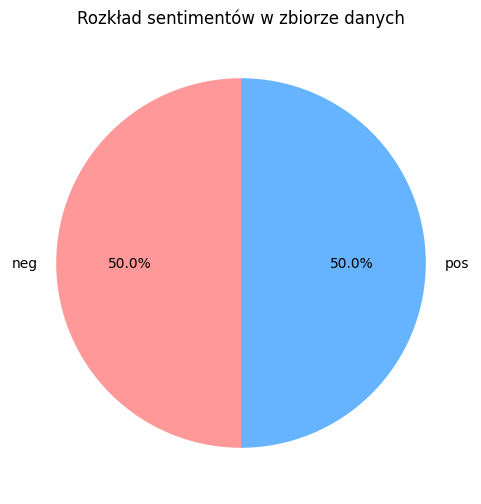

In [31]:
import pandas as pd

sentiment_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Rozkład sentimentów w zbiorze danych')
plt.show()


Dodatkowe:


Zastosuj inne techniki przetwarzania tekstu, takie jak TF-IDF, zamiast CountVectorizer.